# Advanced Lane Lines Finding 

In this project our goal is to write a software pipeline to identify the road lane lines in a video from a front-facing camera on a car. We will detect and calculate curved line as well as detecting the relative position of the car with regard to the center of the road. In order to acheive please find bellow our action plan :

1. Compute the camera calibration matrix and distortion coefficients given a set of chessboard images.
2. Apply a distortion correction to raw images.
3. Use color transforms, gradients, etc., to create a thresholded binary image. 
4. Apply a perspective transform to rectify our image ("birds-eye view").
5. Detect lane pixels and fit to find the lane boundary.
6. Determine the curvature of the lane and vehicle position with respect to center.
7. Warp the detected lane boundaries back onto the original image.
8. Output visual display of the lane boundaries and numerical estimation of lane curvature and vehicle position.
9. Final pipeline implementation.
10. Test our pipeline for video processing.

## 1. Camera Calibration

### Imports

Thanks to OpenCV most of the function needed for us to Calibrating our camera will be native OpenCV function , lets do our imports!

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import glob
import cv2

### Define our calibration function

In order for use to calibrate our camera we will use a chessboard of wich we know the dimensions and number of intercection.
The number of corners in any given row will be noted nx. Similarly,the number of corners in a given column will be noted ny.
Taking different picture of the chessboard under different angles we will allow us to calibrate our camera.

In [2]:
def camera_calibration(images, nx, ny):
    
    #Prepare object points
    objp = np.zeros((ny*nx, 3), np.float32)
    objp[:, :2] = np.mgrid[0:nx, 0:ny].transpose().reshape(-1, 2)
    objpoints = []
    imgpoints = []
    
    for sample_img in images:
        
        #read image
        img = cv2.imread(sample_img)       
        #get image size
        img_size = (img.shape[1], img.shape[0])  
        #convert our image to grayscale
        gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)      
        #find the chessboard corners
        ret, corners = cv2.findChessboardCorners(gray, (nx, ny), None)
        #if corners found
        if ret:
            objpoints.append(objp)
            imgpoints.append(corners)
    
    #calculate the camera calibration matrix and the distortion coefficient based on our objectpoint and image points
    ret, mtx, dist, _, _ = cv2.calibrateCamera(objpoints, imgpoints, img_size, None, None)   
    return mtx, dist

In [3]:
images = glob.glob("camera_cal/calibration*.jpg")
mtx, dist = camera_calibration(images, 9, 6)

Now that we have been calculating the calibration matrix and the distortion coefficients we can know undistorted image comming from the camera.

## 2. Image distortion
Lets use the previous calibration matrix and the distortion coefficients to build an image undistort function

In [4]:
def undistort(img):
    return cv2.undistort(img, mtx, dist, None, mtx)

### Apply a distortion correction to a raw image

In [5]:
#Lets apply a distortion correction to a raw image and check the result
test_img = plt.imread("test_images/test4.jpg")

undist_test_img = undistort(test_img)

chess = plt.imread("camera_cal/calibration1.jpg")
undist_chess = undistort(chess)

fig = plt.figure(figsize=(18, 10))
plt.subplot(2,2,1)
plt.imshow(test_img)
plt.title('Raw Camera image',fontsize=15)
plt.axis('off')
plt.subplot(2,2,2)
plt.imshow(undist_test_img)
plt.title('Undistorted image',fontsize=15)
plt.axis('off')
plt.subplot(2,2,3)
plt.imshow(chess)
plt.title('Raw Camera image',fontsize=15)
plt.axis('off')
plt.subplot(2,2,4)
plt.imshow(undist_chess)
plt.title('Undistorted image',fontsize=15)
plt.axis('off')

(-0.5, 1279.5, 719.5, -0.5)

We can know undistort images from the camera and start to work on our pipeline ! Please note that I have displayed a chessboard image so that the undistortion get more visible for our human eyes but it can be seen also on our test image looking at the car hood for instance.

## 3.  Creating a thresholded binary image 

### Colorspace 
In this section we will explore different colorpsace and select the one that will be the most useful for us to detect the lane line.

C:\Users\Fly_Boy\Anaconda3\lib\site-packages\matplotlib\cbook\deprecation.py:106: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)


(-0.5, 1279.5, 719.5, -0.5)

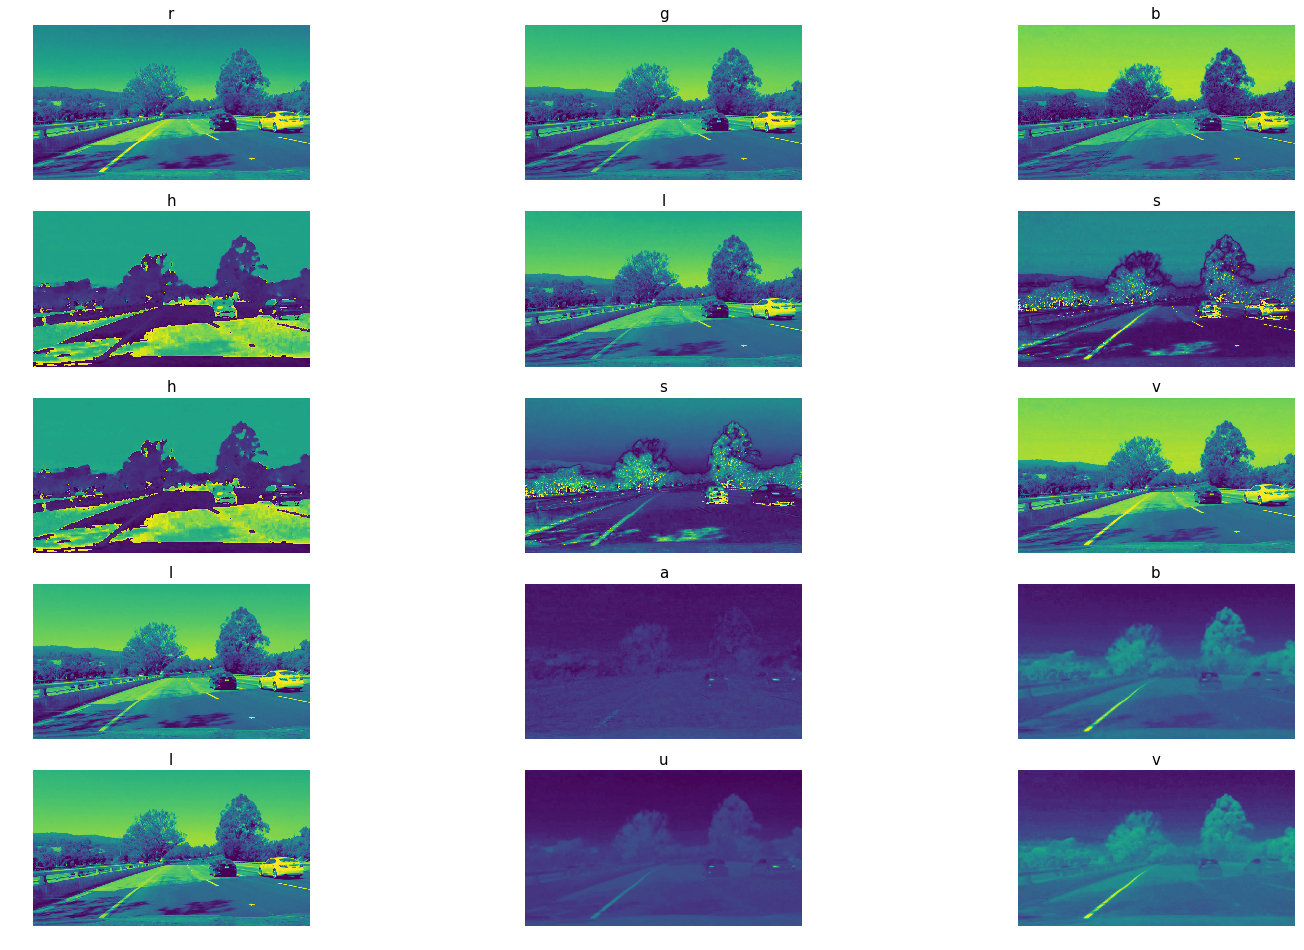

In [6]:
#initial RGB image
rgb = test_img

r_channel = rgb[:,:,0]
g_channel = rgb[:,:,1]
b_channel = rgb[:,:,2]

#HLS colorspace
hls = cv2.cvtColor(test_img, cv2.COLOR_RGB2HLS)

hls_h_channel = hls[:,:,0]
hls_l_channel = hls[:,:,1]
hls_s_channel = hls[:,:,2]

#HSV colorspace
hsv = cv2.cvtColor(test_img, cv2.COLOR_RGB2HSV)

hsv_h_channel = hsv[:,:,0] #h – Hue ( Dominant Wavelength ).
hsv_s_channel = hsv[:,:,1] #s – Saturation ( Purity / shades of the color ).
hsv_v_channel = hsv[:,:,2] #v – Value ( Intensity ).

#LAB colorspace
lab = cv2.cvtColor(test_img, cv2.COLOR_RGB2Lab)

lab_l_channel = lab[:,:,0] #l – Lightness ( Intensity ).
lab_a_channel = lab[:,:,1] #a – color component ranging from Green to Magenta.
lab_b_channel = lab[:,:,2] #b – color component ranging from Blue to Yellow.

#LAB colorspace
yuv = cv2.cvtColor(test_img, cv2.COLOR_RGB2YUV)

yuv_y_channel = yuv[:,:,0] #y
yuv_u_channel = yuv[:,:,1] #u
yuv_v_channel = yuv[:,:,2] #v 

#Luv COLORSPACE[:,:,0] 
luv = cv2.cvtColor(test_img, cv2.COLOR_RGB2LUV)

luv_l_channel = luv[:,:,0] #l
luv_u_channel = luv[:,:,1] #u
luv_v_channel = luv[:,:,2] #v 


fig = plt.figure(figsize=(25, 20))
#rgb
plt.subplot(6,3,1)
plt.imshow(r_channel)
plt.title('r',fontsize=15)
plt.axis('off')
plt.subplot(6,3,2)
plt.imshow(g_channel)
plt.title('g',fontsize=15)
plt.axis('off')
plt.subplot(6,3,3)
plt.imshow(b_channel)
plt.title('b',fontsize=15)
plt.axis('off')

#hls
plt.subplot(6,3,4)
plt.imshow(hls_h_channel)
plt.title('h',fontsize=15)
plt.axis('off')
plt.subplot(6,3,5)
plt.imshow(hls_l_channel)
plt.title('l',fontsize=15)
plt.axis('off')
plt.subplot(6,3,6)
plt.imshow(hls_s_channel)
plt.title('s',fontsize=15)
plt.axis('off')

#hsv
plt.subplot(6,3,7)
plt.imshow(hsv_h_channel)
plt.title('h',fontsize=15)
plt.axis('off')
plt.subplot(6,3,8)
plt.imshow(hsv_s_channel)
plt.title('s',fontsize=15)
plt.axis('off')
plt.subplot(6,3,9)
plt.imshow(hsv_v_channel)
plt.title('v',fontsize=15)
plt.axis('off')

#lab
plt.subplot(6,3,10)
plt.imshow(lab_l_channel)
plt.title('l',fontsize=15)
plt.axis('off')
plt.subplot(6,3,11)
plt.imshow(lab_a_channel)
plt.title('a',fontsize=15)
plt.axis('off')
plt.subplot(6,3,12)
plt.imshow(lab_b_channel)
plt.title('b',fontsize=15)
plt.axis('off')

#yuv
plt.subplot(6,3,13)
plt.imshow(yuv_y_channel)
plt.title('y',fontsize=15)
plt.axis('off')
plt.subplot(6,3,14)
plt.imshow(yuv_u_channel)
plt.title('u',fontsize=15)
plt.axis('off')
plt.subplot(6,3,15)
plt.imshow(yuv_v_channel)
plt.title('v',fontsize=15)
plt.axis('off')

#luvl_channel = cv2.cvtColor(warped, cv2.COLOR_RGB2LUV)[:,:,0] 
plt.subplot(6,3,13)
plt.imshow(luv_l_channel)
plt.title('l',fontsize=15)
plt.axis('off')
plt.subplot(6,3,14)
plt.imshow(luv_u_channel)
plt.title('u',fontsize=15)
plt.axis('off')
plt.subplot(6,3,15)
plt.imshow(luv_v_channel)
plt.title('v',fontsize=15)
plt.axis('off')


We can see that the hls s channel give pretty consistent result for both blank and white line , without being too much impacted by shadow. the LAB B channel sounds pretty good at detecting yellow lane as well and respectively the l channel for the white lane.Lets see if we can filter the hls_l_channel and the lab_b_channel to further improve the results.

#### Thresholding the hls l channel

After testing we've dcided to implement a map function so we can adapt our thershold with regards to the image HSV V channel mean value

In [7]:
def map_threshold_hls_l(value):

    HSV_means = [57, 79,100, 135, 140, 150]
    HLS_thresholds = [173, 175,190, 190, 215, 215]
    value = np.interp(value, HSV_means, HLS_thresholds)  
    return value

In [8]:
map_threshold_hls_l(79)

175.0

In [9]:
#convert rgb image to hls , isolate the l channel , thershold it and return a binary image

def img_to_threshold_hls_l(img,setmin=None):
    
    if setmin != None:
        min =setmin
    else:
        #HSV colorspace for adaptive filtering
        hsv = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
        hsv_v_channel = hsv[:,:,2] #v – Value ( Intensity ).
        #Adaptive thresholding
        min = map_threshold_hls_l(hsv_v_channel.mean())
    max =255
    # convert img to HLS
    hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
    #isolate the l channel
    hls_l = hls[:,:,1]
    #create our array that will contained the thresholded l channel
    thresholded_img = np.zeros_like(hls_l)
    #threshold the l channel and return a binary image
    thresholded_img[(hls_l > min) & (hls_l <= max)] = 1
    return thresholded_img

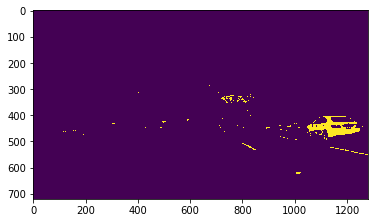

In [10]:
plt.imshow(img_to_threshold_hls_l(test_img))

We can see that our thresholding make a good job at detecting the white line

#### Thresholding the lab b channel

In [11]:
def map_threshold_lab_b(value):

    HSV_means = [57, 79, 129, 135, 140, 150]
    LAB_thresholds = [150, 150, 150, 160, 160, 160]
    value = np.interp(value, HSV_means, LAB_thresholds)  
    return value

In [12]:
#convert rgb image to lab , isolate the b channel , thershold it and return a binary image

def img_to_threshold_lab_b(img,setmin=None):
    
    if setmin != None:
        min =setmin
        
    else:
        #HSV colorspace for adaptive filtering
        hsv = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
        hsv_v_channel = hsv[:,:,2] #v – Value ( Intensity ).
        #Adaptive thresholding
        min = map_threshold_lab_b(hsv_v_channel.mean())
    max =255
    # convert img to lab
    lab = cv2.cvtColor(img, cv2.COLOR_RGB2Lab)
    #isolate the b channel
    lab_b = lab[:,:,2]
    #create our array that will contained the thresholded l channel
    thresholded_img = np.zeros_like(lab_b)
    #thershold the s channel and return a binary image
    thresholded_img[(lab_b > min) & (lab_b <= max)] = 1
    return thresholded_img

In [13]:
plt.imshow(img_to_threshold_lab_b(test_img))

We can clearly see that this thresholding make a good job at detecting the yellow line.

#### Thresholding the luv l channel

In [14]:
#convert rgb image to lab , isolate the b channel , thershold it and return a binary image

def img_to_threshold_luv_l(img,setmin=215):
    min =setmin   
    max =255
    # convert img to luv
    luv = cv2.cvtColor(img, cv2.COLOR_RGB2LUV)
    #isolate the l channel
    luv_l_channel = luv[:,:,0] #l
    #create our array that will contained the thresholded l channel
    thresholded_img = np.zeros_like(luv_l_channel)
    #thershold the s channel and return a binary image
    thresholded_img[(luv_l_channel > min) & (luv_l_channel <= max)] = 1
    return thresholded_img

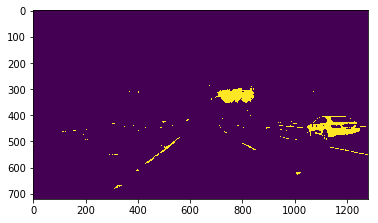

In [15]:
plt.imshow(img_to_threshold_luv_l(test_img))

#### Thresholding the hls s channel

In [16]:
def img_to_threshold_hls_s(img,setmin=215):
    min =setmin   
    max =255
    # convert img to luv
    luv = cv2.cvtColor(img, cv2.COLOR_RGB2LUV)
    #isolate the l channel
    luv_l_channel = luv[:,:,0] #l
    #create our array that will contained the thresholded l channel
    thresholded_img = np.zeros_like(luv_l_channel)
    #thershold the s channel and return a binary image
    thresholded_img[(luv_l_channel > min) & (luv_l_channel <= max)] = 1
    return thresholded_img

#### Combining the color channels

In [17]:
img = plt.imread("test_images/test4.jpg")
hls_l = img_to_threshold_hls_l(img)
lab_b = img_to_threshold_lab_b(img)
luv_l = img_to_threshold_luv_l(img)
combined_binary = np.zeros_like(lab_b)
combined_binary[(hls_l == 1) | (lab_b == 1) | (luv_l==1)] = 1

##### Display the result

In [18]:

plt.imshow(combined_binary)
plt.title('Augmented image',fontsize=15)
plt.axis('off')

(-0.5, 1279.5, 719.5, -0.5)

Alright the result look very promising as we can easily detect both lines lets continue building our pipeline !

### Gradient

lets use the sobel operator at the heart of the Canny edge detection algorithm to compute vertical and horizontal gradients to best detect our line.

In [19]:
def sobel_xy_threshold(img, xmin=10 , xmax=255, ymin=50 ,ymax=255):
    
    #Image to gray
    gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)

    # Sobel x and y
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0) # Take the derivative in x
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1) # Take the derivative in y
    
    abs_sobelx = np.absolute(sobelx) # Absolute x derivative to accentuate lines away from horizontal
    abs_sobely = np.absolute(sobely) # Absolute y derivative to accentuate lines away from vertical
    
    scaled_sobelx = np.uint8(255*abs_sobelx/np.max(abs_sobelx))
    scaled_sobely = np.uint8(255*abs_sobely/np.max(abs_sobely))

    sxbinary = np.zeros_like(scaled_sobelx)
    sxbinary[(scaled_sobelx >= xmin) & (scaled_sobelx <= xmax)] = 1 

    sybinary = np.zeros_like(scaled_sobely)
    sybinary[(scaled_sobely >= ymin) & (scaled_sobely <= ymax)] = 1
    
    combined = np.zeros_like(scaled_sobelx)
    combined[((sxbinary == 1) & (sybinary == 1))] = 1
    
    return combined

(-0.5, 1279.5, 719.5, -0.5)

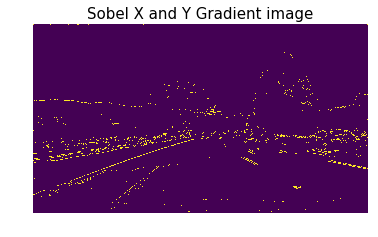

In [20]:
gradient_image = sobel_xy_threshold(test_img)
plt.imshow(gradient_image)
plt.title('Sobel X and Y Gradient image',fontsize=15)
plt.axis('off')

In [21]:
def sobel_magnitude_threshold(img, mmin=40 , mmax=255):
    
   #Image to gray
    gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)

    # Sobel x and y
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0) # Take the derivative in x
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1) # Take the derivative in y
    
    # Calculate the gradient magnitude
    sobelm = np.sqrt(sobelx ** 2 + sobely ** 2)
    scaled_sobelm = np.uint8(255*sobelm/np.max(sobelm))
    
    # Create a copy and apply the threshold
    combined = np.zeros_like(scaled_sobelm)
    combined[(scaled_sobelm > mmin) & (scaled_sobelm < mmax)] = 1
    
    return combined

In [22]:
gradient_image = sobel_magnitude_threshold(test_img)
plt.imshow(gradient_image)
plt.title('Magnitude Gradient image',fontsize=15)
plt.axis('off')

(-0.5, 1279.5, 719.5, -0.5)

In [45]:
def augmented_colorspace(img):
    # Gaussian Blur
    kernel_size = 5
    img = cv2.GaussianBlur(img, (kernel_size, kernel_size), 0)
    
    hls_l = img_to_threshold_hls_l(img)
    lab_b = img_to_threshold_lab_b(img)
#     luv_l = img_to_threshold_luv_l(img)
#     gradxy = sobel_xy_threshold(img)
    #mag = sobel_magnitude_threshold(img)
    combined_binary = np.zeros_like(lab_b)
    combined_binary[(hls_l == 1) | (lab_b == 1)] = 1
    return combined_binary

#### Display the result

(-0.5, 1279.5, 719.5, -0.5)

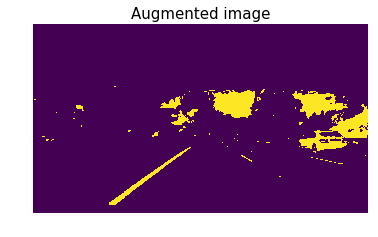

In [46]:
augmented_image = augmented_colorspace(test_img)
plt.imshow(augmented_image)
plt.title('Augmented image',fontsize=15)
plt.axis('off')

The gradient filtering  seems to add a little more in area where than the color channel filtering struggle , lets add sobelx filtering mooving forward in our pipeline.



## 4. Region of interest and Perspective transform  



At this stage we have had good results with detecting the lane, lets now definie a region of interest and do a perspective transform

In [47]:
def bird_eye_view(img, getMinv=False):
    #set dest and source point
    src = np.float32([(575,464),(707,464),(258,682),(1049,682)])
    dst = np.float32([(450,0),(img.shape[1]-450,0),(450,img.shape[0]),(img.shape[1]-450,img.shape[0])])
    
    #get the perpective transform Matrix
    M = cv2.getPerspectiveTransform(src, dst)
    
    #get theinverse transform Matrix
    Minv = cv2.getPerspectiveTransform(dst, src)
    
    # use warp the image
    warped = cv2.warpPerspective(img, M, (img.shape[1],img.shape[0]), flags=cv2.INTER_LINEAR)
    
    if getMinv==False:
        return warped
    else:
        return warped, Minv

In [65]:
test_img = plt.imread("test_images/test4.jpg") 
fig = plt.figure(figsize=(20, 50))
plt.subplot(1,2,1)
plt.imshow(test_img)
plt.title('initial image',fontsize=15)

plt.subplot(1,2,2)
plt.imshow(bird_eye_view(test_img))
plt.title('bird_eye_view image',fontsize=15)

Text(0.5,1,'bird_eye_view image')

Here are our bird eye view image ! Lets test it on other sample images !

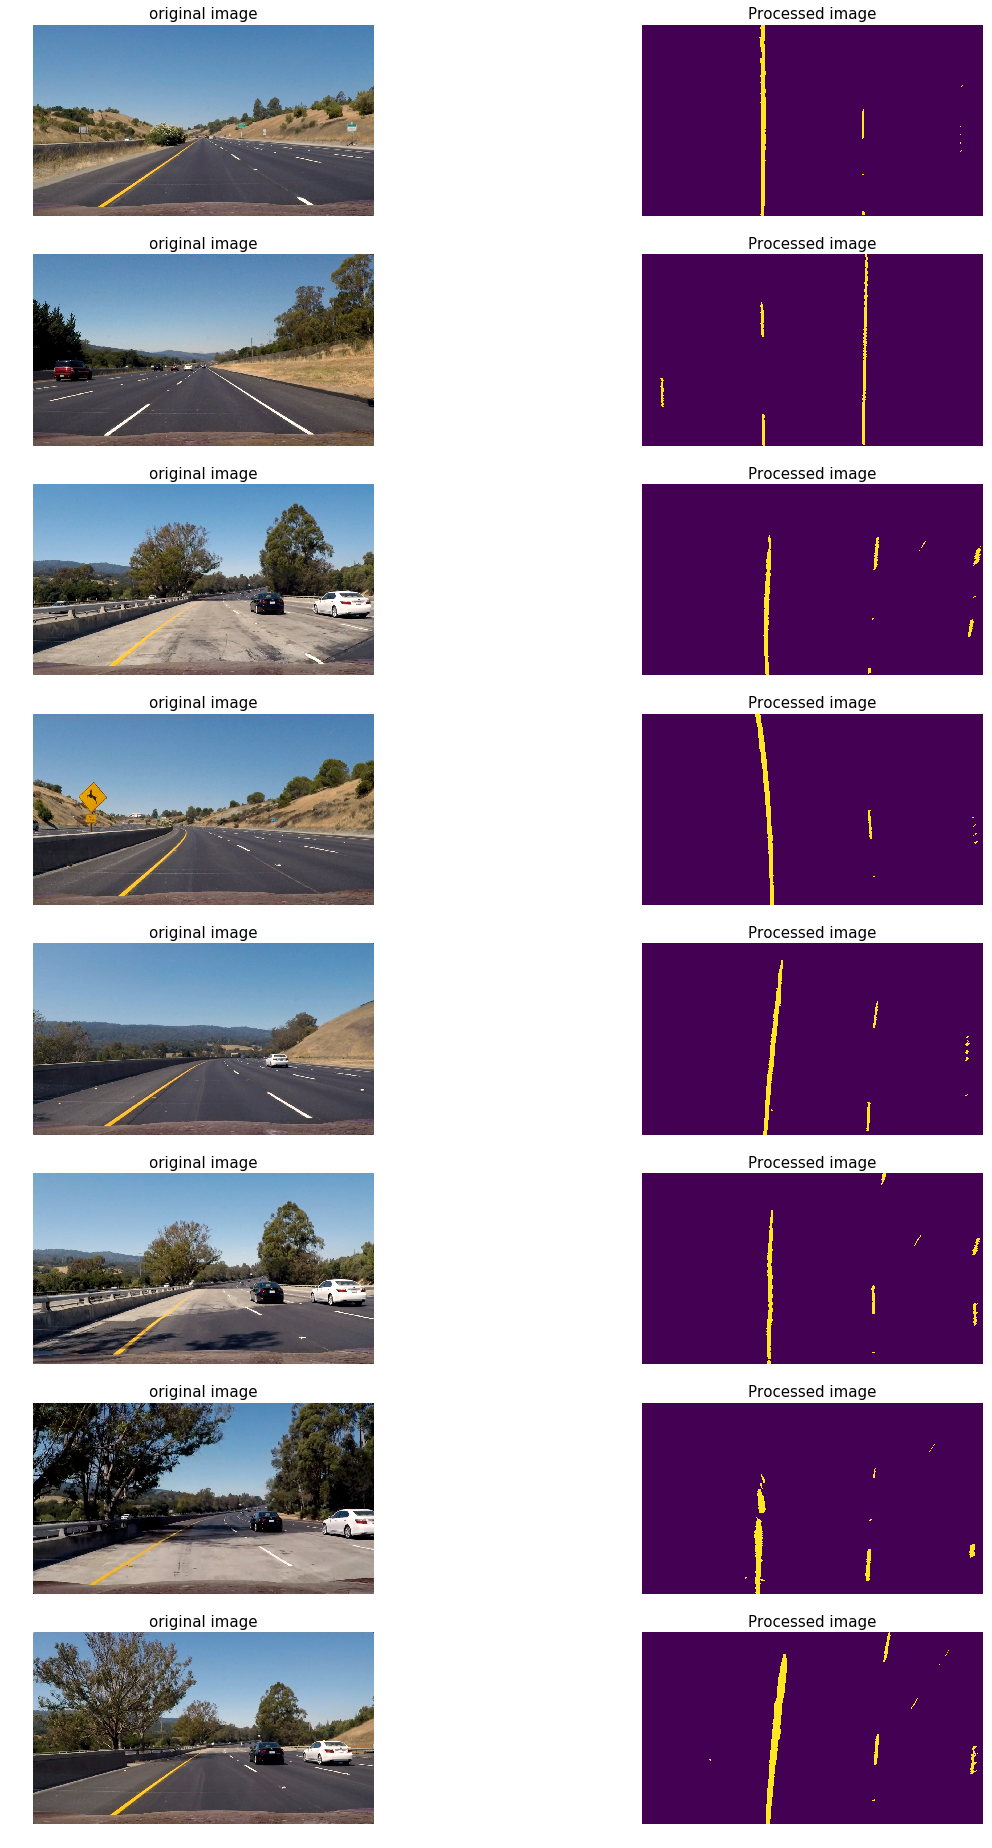

In [49]:
test_img = glob.glob('./test_images/*.jpg')
fig = plt.figure(figsize=(20, 50))
i=1

for img_path in test_img:
    img = plt.imread(img_path)
    
    plt.subplot(12,2,i)
    plt.imshow(img)
    plt.title('original image',fontsize=15)
    plt.axis('off')
    i=i+1
    plt.subplot(12,2,i)
    plt.imshow(bird_eye_view(augmented_colorspace(img)))
    plt.title('Processed image',fontsize=15)
    plt.axis('off')
    i=i+1

Unless tiny noise , we can see that our model is doing pretty good , lets continue to design our pipeline , time to Detect lane pixels and fit to find the lane boundary !

## 5. Detect lane pixels and fit to find the lane boundary

At this stage , we still need to decide explicitly which pixels are part of the lines and which belong to the left line and which belong to the right line.

In [50]:
test_img = glob.glob('./test_images/*.jpg')
fig = plt.figure(figsize=(15, 60))
i=1

for img_path in test_img:
    
    img = plt.imread(img_path)
    augmented_img = bird_eye_view(augmented_colorspace(img))
    
    plt.subplot(16,2,i)
    plt.imshow(augmented_img)
    plt.title('Bird eye view image',fontsize=15)
    i=i+1
    
    plt.subplot(16,2,i)
    histogram = np.sum(augmented_img[augmented_img.shape[0]//2:,:], axis=0)
    plt.plot(histogram)
    plt.title('Historgram',fontsize=15)
    i=i+1

With this histogram we will be adding up the pixel values along each column in the image. as in our thresholded binary image, pixels are either 0 or 1, the two most prominent peaks in this histogram will be good indicators of the x-position of the base of the lane lines. we can use that as a starting point for where to search for the lines. From that point, we can use a sliding window, placed around the line centers, to find and follow the lines up to the top of the frame.

### First fit search

In [51]:
def first_polynomfit_with_sliding_windows(img):

    #look at the bottom part of the image and sum pixels values
    histogram = np.sum(img[img.shape[0]//2:,:], axis=0)

    #cut the bottom image in 4 part (3 separations) and get the max value for each part
    point_1 = np.int(np.int(histogram.shape[0]//4));
    point_2 = np.int(np.int(histogram.shape[0]//2));
    point_3 = point_2 + point_1

    #get the argmax for each part
    max_section_1 = np.argmax(histogram[:point_1])
    max_section_2 = np.argmax(histogram[point_1:point_2]) + point_1
    max_section_3 = np.argmax(histogram[point_2:point_3]) + point_2
    max_section_4 = np.argmax(histogram[point_3:]) + point_3

    #lets assume the closest line to the center of the image taken by the camera centered on the car
    #correspond to the line of the road section we are

    detected_lane_list=[max_section_1,max_section_2,max_section_3,max_section_4]   

    def find_nearest(array, value):
        array = np.asarray(array)
        idx = (np.abs(array - value)).argmin()
        return array[idx]

    first_lane=find_nearest(detected_lane_list,histogram.shape[0]//2)
    detected_lane_list.remove(first_lane)
    second_lane=find_nearest(detected_lane_list,histogram.shape[0]//2)

    #awesome we have the 2 lane corresponding to our driving section but which is the left and th right lane ?

    if second_lane > first_lane:
        leftx_base = first_lane
        rightx_base = second_lane
    else:
        leftx_base = second_lane
        rightx_base = first_lane
        
        print(leftx_base,rightx_base)
        
    #Allright we have identifyed our left and right lane base!
    
    # Choose the number of sliding windows
    nwindows = 10
    # Set height of windows
    window_height = np.int(img.shape[0]//nwindows)
    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = img.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    # Current positions to be updated for each window
    leftx_current = leftx_base
    rightx_current = rightx_base
    # Set the width of the windows +/- margin
    margin = 80
    # Set minimum number of pixels found to recenter window
    minpix = 40
    # Create empty lists to receive left and right lane pixel indices
    left_lane_inds = []
    right_lane_inds = []
    #save rectangle
    rectangles = []

    # Step through the windows one by one
    for window in range(nwindows):
        
        # Identify window boundaries in x and y (and right and left)
        win_y_low = img.shape[0] - (window+1)*window_height
        win_y_high = img.shape[0] - window*window_height
        win_xleft_low = leftx_current - margin
        win_xleft_high = leftx_current + margin
        win_xright_low = rightx_current - margin
        win_xright_high = rightx_current + margin
        
        # save the rectangles
        rectangles.append((win_y_low, win_y_high, win_xleft_low, win_xleft_high, win_xright_low, win_xright_high))
        
        # Identify the nonzero pixels in x and y within the window
        good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
        (nonzerox >= win_xleft_low) &  (nonzerox < win_xleft_high)).nonzero()[0]
        good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
        (nonzerox >= win_xright_low) &  (nonzerox < win_xright_high)).nonzero()[0]
        
        # Append these indices to the lists
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)
        # If you found > minpix pixels, recenter next window on their mean position
        if len(good_left_inds) > minpix:
            leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
        if len(good_right_inds) > minpix:        
            rightx_current = np.int(np.mean(nonzerox[good_right_inds]))

    # Concatenate the arrays of indices
    left_lane_inds = np.concatenate(left_lane_inds)
    right_lane_inds = np.concatenate(right_lane_inds)

    # Extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds] 

    # Fit a second order polynomial to each
    if len(leftx) != 0:
        left_fit = np.polyfit(lefty, leftx, 2)
    else:
        left_fit = None
    if len(rightx) != 0:
        right_fit = np.polyfit(righty, rightx, 2)
    else:
        right_fit = None
    
    return left_fit, right_fit, left_lane_inds, right_lane_inds, rectangles   

#### Visualization and test of our first fit search function

[(648, 720, 410, 570, 717, 877), (576, 648, 414, 574, 717, 877), (504, 576, 429, 589, 717, 877), (432, 504, 429, 589, 717, 877), (360, 432, 429, 589, 717, 877), (288, 360, 429, 589, 717, 877), (216, 288, 429, 589, 717, 877), (144, 216, 429, 589, 717, 877), (72, 144, 429, 589, 717, 877), (0, 72, 429, 589, 717, 877)]


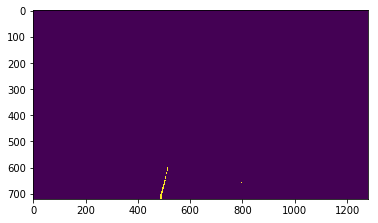

In [52]:
#load our test image
# test_img = plt.imread("test_images/test4.jpg")
test_img = plt.imread("camera_input/challenge_video/frame277.jpg")

augmented_img = bird_eye_view(augmented_colorspace(test_img))
plt.imshow(augmented_img)
rectangles = []

#apply our search function
left_fit, right_fit, left_lane_inds, right_lane_inds, rectangles = first_polynomfit_with_sliding_windows(augmented_img)

print(rectangles)

# Generate x and y values for plotting
ploty = np.linspace(0, augmented_img.shape[0]-1, augmented_img.shape[0])
left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]

# Create an output image to draw on and  visualize the result
out_img = np.uint8(np.dstack((augmented_img, augmented_img, augmented_img))*255)

# Identify the x and y positions of all nonzero pixels in the image
nonzero = augmented_img.nonzero()
nonzeroy = np.array(nonzero[0])
nonzerox = np.array(nonzero[1])
out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [100, 200, 255]

#draw the rectangles used in the window search
for i in range(len(rectangles)):
# Draw the windows on the visualization image
    cv2.rectangle(out_img,(rectangles[i][2],rectangles[i][0]),(rectangles[i][3],rectangles[i][1]),(0,255,0), 2) 
    cv2.rectangle(out_img,(rectangles[i][4],rectangles[i][0]),(rectangles[i][5],rectangles[i][1]),(0,255,0), 2) 
    
# fig = plt.figure(figsize=(10, 30))
# plt.imshow(out_img)
# plt.plot(left_fitx, ploty, color='yellow')
# plt.plot(right_fitx, ploty, color='yellow')
# plt.xlim(0, 1280)
# plt.ylim(720, 0)

Awesome , we've managed to fit a second order polynome to our detected lane line using a windows search, as the lane lines position in the next image of a videoframe is likely to have +- the same position we won't run this detection algorithme each time but instead just search in a margin around the previous line position a starting point for the next frame. 

### Next fit search

In [53]:
def next_polynomfit_with_sliding_windows(img, old_left_fit, old_right_fit,margin=100):
      
    #get non zeros pixel from image
    nonzero = img.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    
    # Identify the nonzero pixels in x and y within the window
    left_lane_inds = ((nonzerox > (old_left_fit[0]*(nonzeroy**2) + old_left_fit[1]*nonzeroy + old_left_fit[2] - margin)) & 
                      (nonzerox < (old_left_fit[0]*(nonzeroy**2) + old_left_fit[1]*nonzeroy + old_left_fit[2] + margin))) 
    right_lane_inds = ((nonzerox > (old_right_fit[0]*(nonzeroy**2) + old_right_fit[1]*nonzeroy + old_right_fit[2] - margin)) & 
                       (nonzerox < (old_right_fit[0]*(nonzeroy**2) + old_right_fit[1]*nonzeroy + old_right_fit[2] + margin)))  

    # Extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds] 
     
     # Fit a second order polynomial to each
    if len(leftx) != 0:
        new_left_fit = np.polyfit(lefty, leftx, 2)
    else:
        new_left_fit=None      
    if len(rightx) != 0:
        new_right_fit = np.polyfit(righty, rightx, 2)
    else:
        new_right_fit=None      
    return new_left_fit, new_right_fit, left_lane_inds, right_lane_inds, margin

Awesome , lets now used some images to test our function , test images 4,5 and 6 will be adapted as they follow each other and can moke a video frame just for testing

#### Visualization and testing of our Next fit search function

(720, 0)

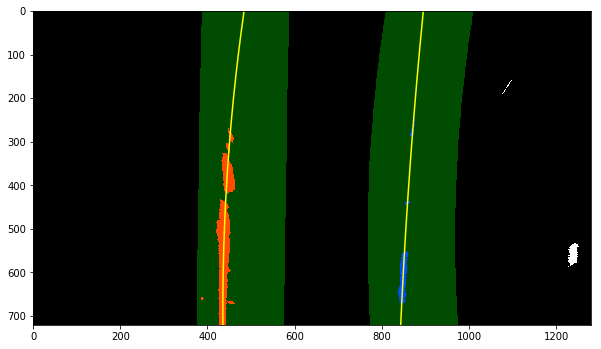

In [54]:
#load our test image
test_img = plt.imread("test_images/test4.jpg") 
augmented_img1 = bird_eye_view(augmented_colorspace(test_img))

test_img = plt.imread("test_images/test5.jpg") 
augmented_img2 = bird_eye_view(augmented_colorspace(test_img))

#apply our initial search function
left_fit, right_fit, left_lane_inds, right_lane_inds, rectangles = first_polynomfit_with_sliding_windows(augmented_img1)

#apply our next search function
new_left_fit, new_right_fit, new_left_lane_inds, new_right_lane_inds, margin = next_polynomfit_with_sliding_windows(augmented_img2,left_fit,right_fit)

# Generate x and y values for plotting
ploty = np.linspace(0, augmented_img2.shape[0]-1, augmented_img2.shape[0] )

#old fit
left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]

#new fit
new_left_fitx = new_left_fit[0]*ploty**2 + new_left_fit[1]*ploty + new_left_fit[2]
new_right_fitx = new_right_fit[0]*ploty**2 + new_right_fit[1]*ploty + new_right_fit[2]

# Create an image to draw on and an image to show the selection window
out_img = np.dstack((augmented_img2, augmented_img2, augmented_img2))*255
window_img = np.zeros_like(out_img)

# Identify the x and y positions of all nonzero pixels in the image
nonzero = augmented_img2.nonzero()
nonzeroy = np.array(nonzero[0])
nonzerox = np.array(nonzero[1])

# Color in left and right line pixels
out_img[nonzeroy[new_left_lane_inds], nonzerox[new_left_lane_inds]] = [255, 0, 0]
out_img[nonzeroy[new_right_lane_inds], nonzerox[new_right_lane_inds]] = [0, 0, 255]

# Generate a polygon to illustrate the search window area
# And recast the x and y points into usable format for cv2.fillPoly()
left_line_window1 = np.array([np.transpose(np.vstack([left_fitx-margin, ploty]))])
left_line_window2 = np.array([np.flipud(np.transpose(np.vstack([left_fitx+margin,ploty])))])
left_line_pts = np.hstack((left_line_window1, left_line_window2))

right_line_window1 = np.array([np.transpose(np.vstack([right_fitx-margin, ploty]))])
right_line_window2 = np.array([np.flipud(np.transpose(np.vstack([right_fitx+margin,ploty])))])
right_line_pts = np.hstack((right_line_window1, right_line_window2))

# Draw the lane onto the warped blank image
fig = plt.figure(figsize=(10, 30))
cv2.fillPoly(window_img, np.int_([left_line_pts]), (0,255, 0))
cv2.fillPoly(window_img, np.int_([right_line_pts]), (0,255, 0))
result = cv2.addWeighted(out_img, 1, window_img, 0.3, 0)
plt.imshow(result)
plt.plot(new_left_fitx, ploty, color='yellow')
plt.plot(new_right_fitx, ploty, color='yellow')
plt.xlim(0, 1280)
plt.ylim(720, 0)

It sounds like our lightweight search functionperform well based on our margin aproximation,  it time to continue exctracting information from these lines.

## 6. Determine the curvature of the lane and vehicle position with respect to center.

Now that we were able to modelize our lanes with a polynome , lets build a function that would help us calculating the curvature of the lane and the position with respect to the center of our vehicle.

#### Curvature of the lane and center position

In [55]:
def get_curve_and_center(img,left_fit, right_fit, left_lane_inds, right_lane_inds):
   
    # Define conversions in x and y from pixels space to meters
    ym_per_pix = 30/720 # meters per pixel in y dimension
    xm_per_pix = 3.7/700 # meters per pixel in x dimension
    
    # get the x and y positions of all nonzero pixels in the image
    nonzero = img.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    
    # Extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    rightx = nonzerox[right_lane_inds]
    
    if len(leftx) != 0 and len(rightx) != 0:
        #Define value where we evaluate the radius (here we will evaluate it at the bottom of the image)
        ploty_l = np.linspace(0, img.shape[0]-1, len(leftx))
        ploty_r = np.linspace(0, img.shape[0]-1, len(rightx))
        y_eval = np.max(ploty_l)
    
    left_curverad = None
    right_curverad = None
    curvature = None
    
    if len(leftx) != 0 and len(rightx) != 0:
        # Fit new polynomials to x,y in world space
        left_fit_cr = np.polyfit(ploty_l*ym_per_pix, leftx*xm_per_pix, 2)
        right_fit_cr = np.polyfit(ploty_r*ym_per_pix, rightx*xm_per_pix, 2)

        # Calculate the radii of curvature
        left_curverad = ((1 + (2*left_fit_cr[0]*y_eval*ym_per_pix + left_fit_cr[1])**2)**1.5) / np.absolute(2*left_fit_cr[0])
        right_curverad = ((1 + (2*right_fit_cr[0]*y_eval*ym_per_pix + right_fit_cr[1])**2)**1.5) / np.absolute(2*right_fit_cr[0])

        curvature = (left_curverad + right_curverad) / 2
        # Now our radius of curvature is in meters
        #print(left_curverad, 'm', right_curverad, 'm')
        # Example values: 632.1 m    626.2 m
    
    #calculate the distance from the center , thank you to jeremy-shannon for his help on the formula for this part
    #where Distance from center is image x midpoint - mean of l_fit and r_fit intercepts 
    center_dist_m = None
    if left_fit is not None and right_fit is not None:
        
        #Assuming the camera is perfectly centered on the car
        car_position = img.shape[1]/2
        #calculate left and right intercetion point with midpoint
        left_fit_x_intercept = left_fit[0]*img.shape[0]**2 + left_fit[1]*img.shape[0] + left_fit[2]
        right_fit_x_intercept = right_fit[0]*img.shape[0]**2 + right_fit[1]*img.shape[0] + right_fit[2]
        #Determine the road center
        road_center = (right_fit_x_intercept + left_fit_x_intercept) /2
        center_dist = (car_position - road_center) 
        #get the value in meters
        center_dist_m = center_dist* xm_per_pix
    
    return  curvature,left_curverad, right_curverad, center_dist_m

#### Curvature of the lane and center position - Test

In [56]:
#load our test image
test_img = plt.imread("test_images/test6.jpg") 
augmented_img1 = bird_eye_view(augmented_colorspace(test_img))

#apply our initial search function
left_fit, right_fit, left_lane_inds, right_lane_inds, rectangles = first_polynomfit_with_sliding_windows(augmented_img1)
curvature,left_curverad, right_curverad, center_dist_m = get_curve_and_center(img ,left_fit, right_fit, left_lane_inds, right_lane_inds)

print("Curvature :",curvature, "center_dist_m :",center_dist_m)

Curvature : 237.3613353268783 center_dist_m : -0.15763083894999735


Our function now work and is able to calculate the curvature and the distance of the car relative to the center of the road !

## 7. Warp the detected lane boundaries back onto the original image.

Now that we were able to detect lanes , modelise both of them with a 2nd order polynom and calculate the radius and the relative car center position, it is time to display these information back on to the original image.

In [57]:
def draw_lanes(img, augmented_img, left_fit, right_fit, Minv):
    
    #handle the possibility where we miss fitting a frame in the videoframe
    if left_fit is not None and right_fit is not None:

        # Create an empty image that will be loaded with our targeted result
        drawing_img = np.zeros_like(augmented_img).astype(np.uint8)
        drawing_img = np.dstack((drawing_img, drawing_img, drawing_img))

        # Generate x and y values for plotting
        ploty = np.linspace(0, augmented_img.shape[0]-1, augmented_img.shape[0])
        left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
        right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
        
        #Recast the x and y points into usable format for cv2.fillPoly()
        pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
        pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
        pts = np.hstack((pts_left, pts_right))
        
        # lets now Draw the lane on our result image using opencv
        
        #Draw the left lane in red (like the aerospace navigation lights)
        cv2.polylines(drawing_img, np.int32([pts_left]), isClosed=False, color=(255,0,0), thickness=13)
        #Draw the right lane in green (like the aerospace navigation lights)
        cv2.polylines(drawing_img, np.int32([pts_right]), isClosed=False, color=(0,255,0), thickness=13)
        #Draw a blue surface between the 2 lanes
        cv2.fillPoly(drawing_img, np.int_([pts]), (0,0, 255))
        
        #lets transform our image to fit in the original perspective
        drawing_img = cv2.warpPerspective(drawing_img, Minv, (img.shape[1], img.shape[0])) 
           
        #assertion check before merging
        assert drawing_img.shape[0] == img.shape[0]
        assert drawing_img.shape[1] == img.shape[1]
        
        #lets use cv2 to add our original image with our drawings ,
        #we will use the blend function to give a 50% transaprency effect to our drawing
        out_img = cv2.addWeighted(img, 1, drawing_img, 0.5,0)
        
        return out_img
    else:
        return img  

#### Function testing


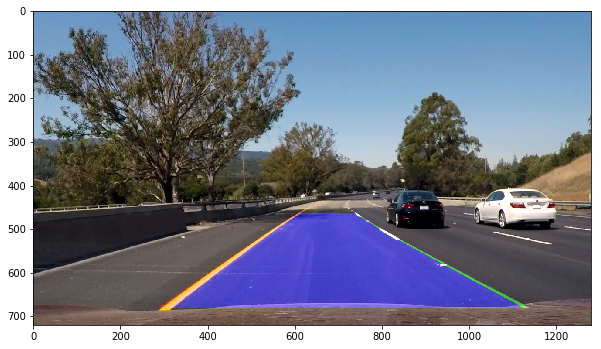

In [58]:
#load our test image
img = plt.imread("test_images/test6.jpg") 
augmented_img1, Minv = bird_eye_view(augmented_colorspace(img),getMinv=True)

#apply our initial search function
left_fit, right_fit,_,_,_ = first_polynomfit_with_sliding_windows(augmented_img1)

#apply our draw line function and display the result
fig = plt.figure(figsize=(10, 30))
plt.imshow(draw_lanes(img, augmented_img, left_fit, right_fit, Minv))

Our draw_lanes function seems to work fine and we can now thee the result on our image, lets now add the captured information on top of the image using opencv.

 ## 8. Output visual display for the numerical estimation of lane curvature and vehicle position.

In [59]:
def draw_data(img, curvature, center_dist_m):
    
    out_img = img
    if curvature is not None and center_dist_m is not None: 
#         #Text string to be drawn.
#         if curvature <=0:
#             text1 = "Road direction     : <- (Left )"
#         else:
#             text1 = "Road direction     : -> (Right)"

        text2 = "Lane curve radius : " + '{:04.2f}'.format(curvature) +"m"
        text3 = "Center distance    : "+ '{:04.2f}'.format(center_dist_m) +"m"

        #Bottom-left corner of the text string in the image.
        org1 = (40,75)
        org2 = (40,125)
        org3 = (40,175)

        #font – CvFont 
        font = cv2.FONT_HERSHEY_DUPLEX  
        #fontScale – Font scale factor that is multiplied by the font-specific base size.
        fontScale = 1.2
        #color – Text color.
        color =(255,255,255)
        #thickness – Thickness of the lines used to draw a text.
        thickness = 2
        #lineType – Line type. See the line for details.
        lineType = cv2.LINE_AA

#         # Add Turn direction
#         cv2.putText(img, text1, org1, font, fontScale, color, thickness, lineType)

        # Add Radius 
        cv2.putText(img, text2, org1, font, fontScale, color, thickness, lineType)

        # Add Center position 
        cv2.putText(img, text3, org2, font, fontScale, color, thickness, lineType)

        return out_img
    else:
        return img

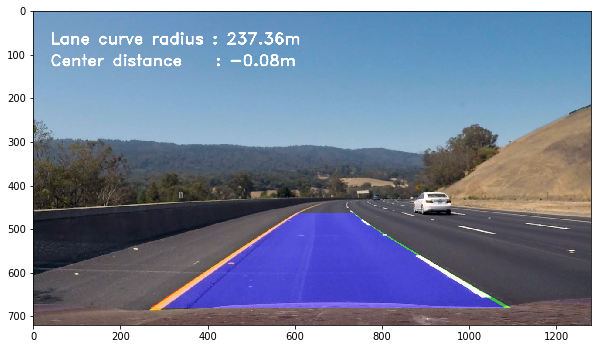

In [60]:
#load our test image
img = plt.imread("test_images/test3.jpg") 
augmented_img1, Minv = bird_eye_view(augmented_colorspace(img),getMinv=True)

#apply our initial search function
left_fit, right_fit,_,_,_ = first_polynomfit_with_sliding_windows(augmented_img1)

#get lane informations
curvature,_, _, center_dist_m = get_curve_and_center(img ,left_fit, right_fit, left_lane_inds, right_lane_inds)

#apply our draw line function and display the result
fig = plt.figure(figsize=(10, 30))
plt.imshow(draw_data(draw_lanes(img, augmented_img, left_fit, right_fit, Minv),curvature,center_dist_m))

We have successfully printed the information on our original sample image. acheiving the end goal for this pipeline,  lets now build the pipeline to process a video input.

## 9. Final Pipeline

After few trials and attempt on our pipeline , I've decided to create a lane class, this to help chosing to run a full window search if the lane is not detected or skip it if the lane as beend detected. The lane class will also help filtering bad fit for optimizing our pipeline output result.

In [61]:
#define a Lane class
class lane:
    def __init__(self):
        self.leftisdetected = False
        self.rightisdetected = False
        self.left_fit = []
        self.right_fit = []
        self.average_left_fit = []
        self.average_right_fit = []
        self.left_good_fit = []
        self.right_good_fit = []   
        
    def __del__(self):
        print("lane deleted")
        
    def log_left_fit(self, left_fit):
        a = left_fit[0]
        b = left_fit[1]
        c = left_fit[2]
        
        self.left_fit.append([a,b,c])
        print("left_fit logged as :",self.left_fit[-1])
    
    def log_right_fit(self, right_fit):
        a = right_fit[0]
        b = right_fit[1]
        c = right_fit[2]
        
        self.right_fit.append([a,b,c])
        print("right_fit logged as :",self.right_fit[-1])
        
    def last_left_fit(self):
        #Average on the last n frame
        nframe=5
        a=0
        b=0
        c=0
        
        #average the last 5 detections
        if len(self.left_fit)>nframe+1:
            for i in range(nframe):
                #sum lane coefficient
                a = a+ self.left_fit[-(i+1)][0]
                b = b+ self.left_fit[-(i+1)][1]
                c = c+ self.left_fit[-(i+1)][2]
                
            self.average_left_fit = [a/nframe , b/nframe , c/nframe]
            print("average left fit :",self.average_left_fit)
    
        #if we have a good fit in the past compare it
        if len(self.left_good_fit)>0 and len(self.average_left_fit)>0:
             
            #if the new detected lane coef are further than a specific range from our last good match, it is a bad fit, else it sounds like a good fit 
            if (abs(self.left_fit[-1][0]-self.left_good_fit[-1][0])>0.001 and
            abs(self.left_fit[-1][1]-self.left_good_fit[-1][1])>1.0 and
            abs(self.left_fit[-1][2]-self.left_good_fit[-1][2])>100.):
                
                #if we have no goodfit lets use the average for the last 5 frames
                self.leftisdetected = False
                self.left_good_fit.append(self.average_left_fit)
                print("left fit output (Average):",self.average_left_fit)
                return self.average_left_fit
            else:
                #if this is a good fit
                self.leftisdetected = True
                self.left_good_fit.append(self.left_fit[-1])
                print("left fit output (New Good Fit):",self.left_fit[-1])
                return self.left_good_fit[-1]
       
        #if no average return last detection
        else:
            print("left fit output (Last detection):",self.left_fit[-1])
            self.left_good_fit.append(self.left_fit[-1])
            self.leftisdetected = False
            return self.left_fit[-1]        
    
    def last_right_fit(self):
        #Average on the last n frame
        nframe=3
        a=0
        b=0
        c=0
        
        #average the last 5 detections
        if len(self.right_fit)>nframe+1:
            for i in range(nframe):
                #sum lane coefficient
                a = a+ self.right_fit[-(i+1)][0]
                b = b+ self.right_fit[-(i+1)][1]
                c = c+ self.right_fit[-(i+1)][2]
                
            self.average_right_fit = [a/nframe , b/nframe , c/nframe]
            print("average right fit :",self.average_right_fit)
    
        #if we have a good fit in the past compare it
        if len(self.right_good_fit)>0 and len(self.average_right_fit)>0:
             
            #if the new detected lane coef are further than a specific range from our last good match, it is a bad fit, else it sounds like a good fit 
            if(abs(self.right_fit[-1][0]-self.right_good_fit[-1][0])>0.001 and
            abs(self.right_fit[-1][1]-self.right_good_fit[-1][1])>1.0 and
            abs(self.right_fit[-1][2]-self.right_good_fit[-1][2])>100.):
                                
                #if we have no goodfit lets use the average for the last 5 frames
                print("right fit output (Average):",self.average_right_fit)
                self.rightisdetected = False
                self.right_good_fit.append(self.average_right_fit)
                return self.average_right_fit
           
            else:
                #if this is a good fit
                self.rightisdetected = True
                self.right_good_fit.append(self.right_fit[-1])
                print("right fit output (New Good Fit):",self.right_fit[-1])
                return self.right_good_fit[-1]

        #if no average return last detection
        else:
            print("right fit output (Last detection):",self.right_fit[-1])
            self.rightisdetected = False
            self.right_good_fit.append(self.right_fit[-1])
            return self.right_fit[-1]   
    
    def leftisdetected(self):
        return self.leftisdetected
    
    def rightisdetected(self):
        return self.rightisdetected

lane deleted


In [62]:
lane = lane()   

def Process_video_frame(img):
    
    #undistort the image
    undistorted_img = undistort(img)
    
    #get image augmented colorspace
    aug_img = augmented_colorspace(undistorted_img)
    
    #Transform perspective to bird eye view
    top_aug_img, Minv = bird_eye_view(aug_img, getMinv=True)
    
    if lane.leftisdetected == False or lane.rightisdetected == False:
        
        print("windows search...")
        
        #windows lane search
        left_fit, right_fit, left_lane_inds, right_lane_inds, rectangles = first_polynomfit_with_sliding_windows(top_aug_img)
        
        if left_fit is not None:
            lane.log_left_fit(left_fit)
        if right_fit is not None:
            lane.log_right_fit(right_fit)
   
    else:
        #if lane already detected
        print("Next search...")   
        
        left_fit =lane.last_left_fit()
        right_fit = lane.last_right_fit()
        
       
        left_fit, right_fit, left_lane_inds, right_lane_inds, margin = next_polynomfit_with_sliding_windows(top_aug_img,left_fit,right_fit)     
       
        if left_fit is not None:
            lane.log_left_fit(left_fit)
        if right_fit is not None:
            lane.log_right_fit(right_fit) 
       
    #get the filtered lane fit
    left_fit = lane.last_left_fit()
    right_fit = lane.last_right_fit()
    
    print("lane.last_left_fit :",left_fit)
    print("lane.last_right_fit :",right_fit)
        
    #get lane curvature and center distance
    curvature,_, _, center_dist_m = get_curve_and_center(top_aug_img ,left_fit, right_fit, left_lane_inds, right_lane_inds)
    
    #drane lane
    img_with_lane = draw_lanes(img, top_aug_img, left_fit, right_fit, Minv)
    
    #draw data
    img_with_data = draw_data(img_with_lane,curvature,center_dist_m)
    
    return img_with_data

In [63]:
# "TROUBLESHOOTING"
# #test our pipeline 
# print("leftisdetected :",lane.leftisdetected)
# print("rightisdetected :",lane.rightisdetected)
# #load our test image
# img1 = plt.imread("camera_input/challenge_video/frame128.jpg") 
# #test our pipeline
# out_img= Process_video_frame(img1)
# print("leftisdetected :",lane.leftisdetected)
# print("rightisdetected :",lane.rightisdetected)

# img1 = plt.imread("camera_input/challenge_video/frame129.jpg") 
# #test our pipeline
# out_img= Process_video_frame(img1)
# print("leftisdetected :",lane.leftisdetected)
# print("rightisdetected :",lane.rightisdetected)

# img1 = plt.imread("camera_input/challenge_video/frame130.jpg") 
# #test our pipeline
# out_img= Process_video_frame(img1)
# print("leftisdetected :",lane.leftisdetected)
# print("rightisdetected :",lane.rightisdetected)

# img1 = plt.imread("camera_input/challenge_video/frame131.jpg") 
# #test our pipeline
# out_img= Process_video_frame(img1)
# print("leftisdetected :",lane.leftisdetected)
# print("rightisdetected :",lane.rightisdetected)

# img1 = plt.imread("camera_input/challenge_video/frame132.jpg") 
# #test our pipeline
# out_img= Process_video_frame(img1)
# print("leftisdetected :",lane.leftisdetected)
# print("rightisdetected :",lane.rightisdetected)

# img1 = plt.imread("camera_input/challenge_video/frame133.jpg") 
# #test our pipeline
# out_img= Process_video_frame(img1)
# print("leftisdetected :",lane.leftisdetected)
# print("rightisdetected :",lane.rightisdetected)

# img1 = plt.imread("camera_input/challenge_video/frame134.jpg") 
# #test our pipeline
# out_img= Process_video_frame(img1)
# print("leftisdetected :",lane.leftisdetected)
# print("rightisdetected :",lane.rightisdetected)

# img1 = plt.imread("camera_input/challenge_video/frame135.jpg") 
# #test our pipeline
# out_img= Process_video_frame(img1)
# print("leftisdetected :",lane.leftisdetected)
# print("rightisdetected :",lane.rightisdetected)

# img1 = plt.imread("camera_input/challenge_video/frame136.jpg") 
# #test our pipeline
# out_img= Process_video_frame(img1)
# print("leftisdetected :",lane.leftisdetected)
# print("rightisdetected :",lane.rightisdetected)

# img1 = plt.imread("camera_input/challenge_video/frame137.jpg") 
# #test our pipeline
# out_img= Process_video_frame(img1)
# print("leftisdetected :",lane.leftisdetected)
# print("rightisdetected :",lane.rightisdetected)

# img1 = plt.imread("camera_input/challenge_video/frame138.jpg") 
# #test our pipeline
# out_img= Process_video_frame(img1)
# print("leftisdetected :",lane.leftisdetected)
# print("rightisdetected :",lane.rightisdetected)


# img1 = plt.imread("camera_input/challenge_video/frame139.jpg") 
# #test our pipeline
# out_img= Process_video_frame(img1)
# print("leftisdetected :",lane.leftisdetected)
# print("rightisdetected :",lane.rightisdetected)

# plt.imshow(out_img)

## Process the Video with our pipeline

In [64]:
from moviepy.editor import VideoFileClip

output = 'process_output/processed_project_video.mp4'
clip1 = VideoFileClip('camera_input/project_video.mp4')
output_clip = clip1.fl_image(Process_video_frame)
%time output_clip.write_videofile(output, audio=False)

windows search...
left_fit logged as : [-0.00010128532868152456, 0.14040712963766896, 435.07305602944206]
right_fit logged as : [-7.979091689505713e-05, 0.1286171555310988, 817.067861790542]
left fit output (Last detection): [-0.00010128532868152456, 0.14040712963766896, 435.07305602944206]
right fit output (Last detection): [-7.979091689505713e-05, 0.1286171555310988, 817.067861790542]
lane.last_left_fit : [-0.00010128532868152456, 0.14040712963766896, 435.07305602944206]
lane.last_right_fit : [-7.979091689505713e-05, 0.1286171555310988, 817.067861790542]
[MoviePy] >>>> Building video process_output/processed_project_video.mp4
[MoviePy] Writing video process_output/processed_project_video.mp4


  0%|                                                                                         | 0/1261 [00:00<?, ?it/s]

windows search...
left_fit logged as : [-0.00010128532868152456, 0.14040712963766896, 435.07305602944206]
right_fit logged as : [-7.979091689505713e-05, 0.1286171555310988, 817.067861790542]
left fit output (Last detection): [-0.00010128532868152456, 0.14040712963766896, 435.07305602944206]
right fit output (Last detection): [-7.979091689505713e-05, 0.1286171555310988, 817.067861790542]
lane.last_left_fit : [-0.00010128532868152456, 0.14040712963766896, 435.07305602944206]
lane.last_right_fit : [-7.979091689505713e-05, 0.1286171555310988, 817.067861790542]


  0%|                                                                                 | 1/1261 [00:00<02:12,  9.48it/s]

windows search...
left_fit logged as : [-0.0001115526565547829, 0.14950781999015436, 434.0132903795613]
right_fit logged as : [-6.886988905208891e-05, 0.1240995340389843, 814.6482860471926]
left fit output (Last detection): [-0.0001115526565547829, 0.14950781999015436, 434.0132903795613]
right fit output (Last detection): [-6.886988905208891e-05, 0.1240995340389843, 814.6482860471926]
lane.last_left_fit : [-0.0001115526565547829, 0.14950781999015436, 434.0132903795613]
lane.last_right_fit : [-6.886988905208891e-05, 0.1240995340389843, 814.6482860471926]


  0%|▏                                                                                | 2/1261 [00:00<02:13,  9.41it/s]

windows search...
left_fit logged as : [-0.0001126594678843136, 0.15092435006608454, 433.9899497158619]
right_fit logged as : [-7.887421880325818e-05, 0.13636621246055164, 810.2754978359353]
left fit output (Last detection): [-0.0001126594678843136, 0.15092435006608454, 433.9899497158619]
right fit output (Last detection): [-7.887421880325818e-05, 0.13636621246055164, 810.2754978359353]
lane.last_left_fit : [-0.0001126594678843136, 0.15092435006608454, 433.9899497158619]
lane.last_right_fit : [-7.887421880325818e-05, 0.13636621246055164, 810.2754978359353]


  0%|▏                                                                                | 3/1261 [00:00<02:15,  9.29it/s]

windows search...
left_fit logged as : [-0.00012258983953436983, 0.16012686100527804, 432.48705817514536]
right_fit logged as : [-7.960179148053964e-05, 0.1399082453664028, 808.0305645777382]
left fit output (Last detection): [-0.00012258983953436983, 0.16012686100527804, 432.48705817514536]
average right fit : [-7.578196644529558e-05, 0.13345799728864627, 810.9847828202887]
right fit output (New Good Fit): [-7.960179148053964e-05, 0.1399082453664028, 808.0305645777382]
lane.last_left_fit : [-0.00012258983953436983, 0.16012686100527804, 432.48705817514536]
lane.last_right_fit : [-7.960179148053964e-05, 0.1399082453664028, 808.0305645777382]


  0%|▎                                                                                | 4/1261 [00:00<02:19,  9.04it/s]

windows search...
left_fit logged as : [-0.0001229167583709603, 0.16291857073678484, 431.404708073604]
right_fit logged as : [-8.724145319497016e-05, 0.14834547445457572, 805.7641444134443]
left fit output (Last detection): [-0.0001229167583709603, 0.16291857073678484, 431.404708073604]
average right fit : [-8.190582115958932e-05, 0.14153997742717672, 808.023402275706]
right fit output (New Good Fit): [-8.724145319497016e-05, 0.14834547445457572, 805.7641444134443]
lane.last_left_fit : [-0.0001229167583709603, 0.16291857073678484, 431.404708073604]
lane.last_right_fit : [-8.724145319497016e-05, 0.14834547445457572, 805.7641444134443]


  0%|▎                                                                                | 5/1261 [00:00<02:18,  9.05it/s]

windows search...
left_fit logged as : [-0.0001221815659936153, 0.1648641435507372, 430.72359773707086]
right_fit logged as : [-9.320796176812439e-05, 0.1594415377247275, 800.487695946779]
average left fit : [-0.00011838005766760839, 0.1576683490698078, 432.5237208162487]
left fit output (New Good Fit): [-0.0001221815659936153, 0.1648641435507372, 430.72359773707086]
average right fit : [-8.66837354812114e-05, 0.14923175251523535, 804.7608016459872]
right fit output (New Good Fit): [-9.320796176812439e-05, 0.1594415377247275, 800.487695946779]
lane.last_left_fit : [-0.0001221815659936153, 0.1648641435507372, 430.72359773707086]
lane.last_right_fit : [-9.320796176812439e-05, 0.1594415377247275, 800.487695946779]


  0%|▍                                                                                | 6/1261 [00:00<02:21,  8.87it/s]

Next search...
average left fit : [-0.00011838005766760839, 0.1576683490698078, 432.5237208162487]
left fit output (New Good Fit): [-0.0001221815659936153, 0.1648641435507372, 430.72359773707086]
average right fit : [-8.66837354812114e-05, 0.14923175251523535, 804.7608016459872]
right fit output (New Good Fit): [-9.320796176812439e-05, 0.1594415377247275, 800.487695946779]
left_fit logged as : [-0.00011928258443978739, 0.16599545635290353, 429.12312080534764]
right_fit logged as : [-0.00011659135709035504, 0.1819117675124213, 796.4348043142522]
average left fit : [-0.0001199260432446093, 0.16096587634235762, 431.54568690140593]
left fit output (New Good Fit): [-0.00011928258443978739, 0.16599545635290353, 429.12312080534764]
average right fit : [-9.90135906844832e-05, 0.16323292656390817, 800.8955482248252]
right fit output (New Good Fit): [-0.00011659135709035504, 0.1819117675124213, 796.4348043142522]
lane.last_left_fit : [-0.00011928258443978739, 0.16599545635290353, 429.12312080534

  1%|▍                                                                                | 7/1261 [00:00<02:25,  8.63it/s]

Next search...
average left fit : [-0.0001199260432446093, 0.16096587634235762, 431.54568690140593]
left fit output (New Good Fit): [-0.00011928258443978739, 0.16599545635290353, 429.12312080534764]
average right fit : [-9.90135906844832e-05, 0.16323292656390817, 800.8955482248252]
right fit output (New Good Fit): [-0.00011659135709035504, 0.1819117675124213, 796.4348043142522]
left_fit logged as : [-0.0001209907295221802, 0.17000644110729, 428.32418547156544]
right_fit logged as : [-1.319264850434979e-05, 0.09692148016016408, 811.0101367442994]
average left fit : [-0.0001215922955721826, 0.16478229455059873, 430.4125340525467]
left fit output (New Good Fit): [-0.0001209907295221802, 0.17000644110729, 428.32418547156544]
average right fit : [-7.433065578760974e-05, 0.14609159513243763, 802.6442123351102]
right fit output (New Good Fit): [-1.319264850434979e-05, 0.09692148016016408, 811.0101367442994]
lane.last_left_fit : [-0.0001209907295221802, 0.17000644110729, 428.32418547156544]
la

  1%|▌                                                                                | 8/1261 [00:00<02:26,  8.56it/s]

Next search...
average left fit : [-0.0001215922955721826, 0.16478229455059873, 430.4125340525467]
left fit output (New Good Fit): [-0.0001209907295221802, 0.17000644110729, 428.32418547156544]
average right fit : [-7.433065578760974e-05, 0.14609159513243763, 802.6442123351102]
right fit output (New Good Fit): [-1.319264850434979e-05, 0.09692148016016408, 811.0101367442994]
left_fit logged as : [-0.00011876987667283464, 0.17040778428545997, 426.5754558762821]
right_fit logged as : [1.2809760913605794e-05, 0.06417269372144795, 821.3960513609771]
average left fit : [-0.00012082830299987557, 0.1668384792066351, 429.230213592774]
left fit output (New Good Fit): [-0.00011876987667283464, 0.17040778428545997, 426.5754558762821]
average right fit : [-3.899141489369968e-05, 0.1143353137980111, 809.613664139843]
right fit output (New Good Fit): [1.2809760913605794e-05, 0.06417269372144795, 821.3960513609771]
lane.last_left_fit : [-0.00011876987667283464, 0.17040778428545997, 426.5754558762821]


  1%|▌                                                                                | 9/1261 [00:01<02:27,  8.48it/s]

Next search...
average left fit : [-0.00012082830299987557, 0.1668384792066351, 429.230213592774]
left fit output (New Good Fit): [-0.00011876987667283464, 0.17040778428545997, 426.5754558762821]
average right fit : [-3.899141489369968e-05, 0.1143353137980111, 809.613664139843]
right fit output (New Good Fit): [1.2809760913605794e-05, 0.06417269372144795, 821.3960513609771]
left_fit logged as : [-0.00011679643998809938, 0.17134044921304412, 424.81216894546355]
right_fit logged as : [-7.647631146532138e-05, 0.15244038889329245, 799.8328541285357]
average left fit : [-0.00011960423932330338, 0.16852285490188695, 427.9117057671459]
left fit output (New Good Fit): [-0.00011679643998809938, 0.17134044921304412, 424.81216894546355]
average right fit : [-2.561973301868846e-05, 0.10451152092496814, 810.7463474112707]
right fit output (New Good Fit): [-7.647631146532138e-05, 0.15244038889329245, 799.8328541285357]
lane.last_left_fit : [-0.00011679643998809938, 0.17134044921304412, 424.812168945

  1%|▋                                                                               | 10/1261 [00:01<02:27,  8.48it/s]

Next search...
average left fit : [-0.00011960423932330338, 0.16852285490188695, 427.9117057671459]
left fit output (New Good Fit): [-0.00011679643998809938, 0.17134044921304412, 424.81216894546355]
average right fit : [-2.561973301868846e-05, 0.10451152092496814, 810.7463474112707]
right fit output (New Good Fit): [-7.647631146532138e-05, 0.15244038889329245, 799.8328541285357]
left_fit logged as : [-0.00011096080018519745, 0.1687619460311834, 424.4213724033102]
right_fit logged as : [-7.464812642227702e-05, 0.15490228526345332, 796.7502909725208]
average left fit : [-0.00011736008616161982, 0.16930241539797622, 426.6512607003938]
left fit output (New Good Fit): [-0.00011096080018519745, 0.1687619460311834, 424.4213724033102]
average right fit : [-4.61048923246642e-05, 0.12383845595939791, 805.9930654873446]
right fit output (New Good Fit): [-7.464812642227702e-05, 0.15490228526345332, 796.7502909725208]
lane.last_left_fit : [-0.00011096080018519745, 0.1687619460311834, 424.4213724033

  1%|▋                                                                               | 11/1261 [00:01<02:28,  8.41it/s]

Next search...
average left fit : [-0.00011736008616161982, 0.16930241539797622, 426.6512607003938]
left fit output (New Good Fit): [-0.00011096080018519745, 0.1687619460311834, 424.4213724033102]
average right fit : [-4.61048923246642e-05, 0.12383845595939791, 805.9930654873446]
right fit output (New Good Fit): [-7.464812642227702e-05, 0.15490228526345332, 796.7502909725208]
left_fit logged as : [-0.00010242300312659991, 0.16640760102409513, 420.646269619387]
right_fit logged as : [-6.742414041285228e-05, 0.13623006370761573, 807.3582855177953]
average left fit : [-0.00011398816989898231, 0.16938484433221454, 424.9558904632016]
left fit output (New Good Fit): [-0.00010242300312659991, 0.16640760102409513, 420.646269619387]
average right fit : [-7.284952610015023e-05, 0.1478575792881205, 801.313810206284]
right fit output (New Good Fit): [-6.742414041285228e-05, 0.13623006370761573, 807.3582855177953]
lane.last_left_fit : [-0.00010242300312659991, 0.16640760102409513, 420.646269619387]

  1%|▊                                                                               | 12/1261 [00:01<02:28,  8.40it/s]

Next search...
average left fit : [-0.00011398816989898231, 0.16938484433221454, 424.9558904632016]
left fit output (New Good Fit): [-0.00010242300312659991, 0.16640760102409513, 420.646269619387]
average right fit : [-7.284952610015023e-05, 0.1478575792881205, 801.313810206284]
right fit output (New Good Fit): [-6.742414041285228e-05, 0.13623006370761573, 807.3582855177953]
left_fit logged as : [-9.809442226459864e-05, 0.16476321295165078, 420.1299387911823]
right_fit logged as : [-0.00010141439784322538, 0.16536493024320076, 800.1389518622133]
average left fit : [-0.00010940890844746601, 0.16833619870108668, 423.31704112712504]
left fit output (New Good Fit): [-9.809442226459864e-05, 0.16476321295165078, 420.1299387911823]
average right fit : [-8.116222155945156e-05, 0.1521657597380899, 801.4158427841763]
right fit output (New Good Fit): [-0.00010141439784322538, 0.16536493024320076, 800.1389518622133]
lane.last_left_fit : [-9.809442226459864e-05, 0.16476321295165078, 420.12993879118

  1%|▊                                                                               | 13/1261 [00:01<02:28,  8.39it/s]

Next search...
average left fit : [-0.00010940890844746601, 0.16833619870108668, 423.31704112712504]
left fit output (New Good Fit): [-9.809442226459864e-05, 0.16476321295165078, 420.1299387911823]
average right fit : [-8.116222155945156e-05, 0.1521657597380899, 801.4158427841763]
right fit output (New Good Fit): [-0.00010141439784322538, 0.16536493024320076, 800.1389518622133]
left_fit logged as : [-9.109355206188285e-05, 0.16053339934470048, 420.13139630237305]
right_fit logged as : [-7.871498723552764e-05, 0.15092982278842113, 800.3012296587323]
average left fit : [-0.00010387364352527566, 0.16636132171293477, 422.02822921234326]
left fit output (New Good Fit): [-9.109355206188285e-05, 0.16053339934470048, 420.13139630237305]
average right fit : [-8.251784183053509e-05, 0.15084160557974588, 802.5994890129136]
right fit output (New Good Fit): [-7.871498723552764e-05, 0.15092982278842113, 800.3012296587323]
lane.last_left_fit : [-9.109355206188285e-05, 0.16053339934470048, 420.1313963

  1%|▉                                                                               | 14/1261 [00:01<02:28,  8.39it/s]

Next search...
average left fit : [-0.00010387364352527566, 0.16636132171293477, 422.02822921234326]
left fit output (New Good Fit): [-9.109355206188285e-05, 0.16053339934470048, 420.13139630237305]
average right fit : [-8.251784183053509e-05, 0.15084160557974588, 802.5994890129136]
right fit output (New Good Fit): [-7.871498723552764e-05, 0.15092982278842113, 800.3012296587323]
left_fit logged as : [-8.739732224424026e-05, 0.15658701901959052, 421.786737317305]
right_fit logged as : [-7.116044205098741e-05, 0.15699800741435635, 791.1593262803007]
average left fit : [-9.799381997650382e-05, 0.16341063567424408, 421.4231428867115]
left fit output (New Good Fit): [-8.739732224424026e-05, 0.15658701901959052, 421.786737317305]
average right fit : [-8.376327570991348e-05, 0.15776425348199274, 797.1998359337487]
right fit output (New Good Fit): [-7.116044205098741e-05, 0.15699800741435635, 791.1593262803007]
lane.last_left_fit : [-8.739732224424026e-05, 0.15658701901959052, 421.786737317305

  1%|▉                                                                               | 15/1261 [00:01<02:28,  8.37it/s]

Next search...
average left fit : [-9.799381997650382e-05, 0.16341063567424408, 421.4231428867115]
left fit output (New Good Fit): [-8.739732224424026e-05, 0.15658701901959052, 421.786737317305]
average right fit : [-8.376327570991348e-05, 0.15776425348199274, 797.1998359337487]
right fit output (New Good Fit): [-7.116044205098741e-05, 0.15699800741435635, 791.1593262803007]
left_fit logged as : [-8.18992040035996e-05, 0.1514884837624418, 423.0895831353508]
right_fit logged as : [-8.893607554459645e-05, 0.17915187937491794, 781.3517224875859]
average left fit : [-9.218150074018425e-05, 0.15995594322049572, 421.15678503311966]
left fit output (New Good Fit): [-8.18992040035996e-05, 0.1514884837624418, 423.0895831353508]
average right fit : [-7.960383494370383e-05, 0.16235990319256513, 790.9374261422063]
right fit output (New Good Fit): [-8.893607554459645e-05, 0.17915187937491794, 781.3517224875859]
lane.last_left_fit : [-8.18992040035996e-05, 0.1514884837624418, 423.0895831353508]
lane

  1%|█                                                                               | 16/1261 [00:01<02:30,  8.30it/s]

Next search...
average left fit : [-9.218150074018425e-05, 0.15995594322049572, 421.15678503311966]
left fit output (New Good Fit): [-8.18992040035996e-05, 0.1514884837624418, 423.0895831353508]
average right fit : [-7.960383494370383e-05, 0.16235990319256513, 790.9374261422063]
right fit output (New Good Fit): [-8.893607554459645e-05, 0.17915187937491794, 781.3517224875859]
left_fit logged as : [-7.91525424195999e-05, 0.14793539380695342, 423.47042884468635]
right_fit logged as : [-8.316112180037173e-05, 0.1744560726553815, 781.0109416313649]
average left fit : [-8.752740859878425e-05, 0.15626150177706738, 421.72161687817953]
left fit output (New Good Fit): [-7.91525424195999e-05, 0.14793539380695342, 423.47042884468635]
average right fit : [-8.108587979865186e-05, 0.17020198648155194, 784.5073301330839]
right fit output (New Good Fit): [-8.316112180037173e-05, 0.1744560726553815, 781.0109416313649]
lane.last_left_fit : [-7.91525424195999e-05, 0.14793539380695342, 423.47042884468635]


  1%|█                                                                               | 17/1261 [00:02<02:30,  8.29it/s]

Next search...
average left fit : [-8.752740859878425e-05, 0.15626150177706738, 421.72161687817953]
left fit output (New Good Fit): [-7.91525424195999e-05, 0.14793539380695342, 423.47042884468635]
average right fit : [-8.108587979865186e-05, 0.17020198648155194, 784.5073301330839]
right fit output (New Good Fit): [-8.316112180037173e-05, 0.1744560726553815, 781.0109416313649]
left_fit logged as : [-7.19423224012548e-05, 0.1419227428828181, 424.27629704369156]
right_fit logged as : [-4.178478827655893e-05, 0.1364443261885628, 786.5989718726652]
average left fit : [-8.229698862611547e-05, 0.15169340776330084, 422.5508885286814]
left fit output (New Good Fit): [-7.19423224012548e-05, 0.1419227428828181, 424.27629704369156]
average right fit : [-7.12939952071757e-05, 0.1633507594062874, 782.9872119972052]
right fit output (New Good Fit): [-4.178478827655893e-05, 0.1364443261885628, 786.5989718726652]
lane.last_left_fit : [-7.19423224012548e-05, 0.1419227428828181, 424.27629704369156]
lane.

  1%|█▏                                                                              | 18/1261 [00:02<02:29,  8.29it/s]

Next search...
average left fit : [-8.229698862611547e-05, 0.15169340776330084, 422.5508885286814]
left fit output (New Good Fit): [-7.19423224012548e-05, 0.1419227428828181, 424.27629704369156]
average right fit : [-7.12939952071757e-05, 0.1633507594062874, 782.9872119972052]
right fit output (New Good Fit): [-4.178478827655893e-05, 0.1364443261885628, 786.5989718726652]
left_fit logged as : [-6.332713962887433e-05, 0.1365307817249791, 423.24576743115074]
right_fit logged as : [-7.287756636502553e-06, 0.09407325698252011, 799.6642901899777]
average left fit : [-7.674370613951377e-05, 0.1468928842393566, 423.17376275443684]
left fit output (New Good Fit): [-6.332713962887433e-05, 0.1365307817249791, 423.24576743115074]
average right fit : [-4.407788890447773e-05, 0.13499121860882146, 789.0914012313359]
right fit output (New Good Fit): [-7.287756636502553e-06, 0.09407325698252011, 799.6642901899777]
lane.last_left_fit : [-6.332713962887433e-05, 0.1365307817249791, 423.24576743115074]
la

  2%|█▏                                                                              | 19/1261 [00:02<02:30,  8.27it/s]

Next search...
average left fit : [-7.674370613951377e-05, 0.1468928842393566, 423.17376275443684]
left fit output (New Good Fit): [-6.332713962887433e-05, 0.1365307817249791, 423.24576743115074]
average right fit : [-4.407788890447773e-05, 0.13499121860882146, 789.0914012313359]
right fit output (New Good Fit): [-7.287756636502553e-06, 0.09407325698252011, 799.6642901899777]
left_fit logged as : [-5.5519833409573404e-05, 0.13114853435243964, 422.5059055195561]
right_fit logged as : [-2.6734195763759182e-05, 0.10995861318302237, 798.5993434300947]
average left fit : [-7.036820837258041e-05, 0.14180518730592642, 423.3175963948872]
left fit output (New Good Fit): [-5.5519833409573404e-05, 0.13114853435243964, 422.5059055195561]
average right fit : [-2.5268913558940223e-05, 0.11349206545136843, 794.9542018309126]
right fit output (New Good Fit): [-2.6734195763759182e-05, 0.10995861318302237, 798.5993434300947]
lane.last_left_fit : [-5.5519833409573404e-05, 0.13114853435243964, 422.5059055

  2%|█▎                                                                              | 20/1261 [00:02<02:30,  8.25it/s]

Next search...
average left fit : [-7.036820837258041e-05, 0.14180518730592642, 423.3175963948872]
left fit output (New Good Fit): [-5.5519833409573404e-05, 0.13114853435243964, 422.5059055195561]
average right fit : [-2.5268913558940223e-05, 0.11349206545136843, 794.9542018309126]
right fit output (New Good Fit): [-2.6734195763759182e-05, 0.10995861318302237, 798.5993434300947]
left_fit logged as : [-4.886073986713098e-05, 0.12719745446846834, 421.30311255566465]
right_fit logged as : [6.230616617748434e-05, 0.023635043531573804, 821.1226198611093]
average left fit : [-6.376051554528668e-05, 0.13694698144713172, 422.9603022789499]
left fit output (New Good Fit): [-4.886073986713098e-05, 0.12719745446846834, 421.30311255566465]
average right fit : [9.4280712590742e-06, 0.0758889712323721, 806.4620844937272]
right fit output (New Good Fit): [6.230616617748434e-05, 0.023635043531573804, 821.1226198611093]
lane.last_left_fit : [-4.886073986713098e-05, 0.12719745446846834, 421.303112555664

  2%|█▎                                                                              | 21/1261 [00:02<02:30,  8.24it/s]

Next search...
average left fit : [-6.376051554528668e-05, 0.13694698144713172, 422.9603022789499]
left fit output (New Good Fit): [-4.886073986713098e-05, 0.12719745446846834, 421.30311255566465]
average right fit : [9.4280712590742e-06, 0.0758889712323721, 806.4620844937272]
right fit output (New Good Fit): [6.230616617748434e-05, 0.023635043531573804, 821.1226198611093]
left_fit logged as : [-4.727964316607227e-05, 0.12719758998153743, 419.11651949079885]
right_fit logged as : [8.049535399362122e-05, -0.0087802499475635, 834.4846540991606]
average left fit : [-5.738593569458116e-05, 0.1327994206820485, 422.0895204081724]
left fit output (New Good Fit): [-4.727964316607227e-05, 0.12719758998153743, 419.11651949079885]
average right fit : [3.868910813578212e-05, 0.04160446892234423, 818.068872463455]
right fit output (New Good Fit): [8.049535399362122e-05, -0.0087802499475635, 834.4846540991606]
lane.last_left_fit : [-4.727964316607227e-05, 0.12719758998153743, 419.11651949079885]
lan

  2%|█▍                                                                              | 22/1261 [00:02<02:30,  8.25it/s]

Next search...
average left fit : [-5.738593569458116e-05, 0.1327994206820485, 422.0895204081724]
left fit output (New Good Fit): [-4.727964316607227e-05, 0.12719758998153743, 419.11651949079885]
average right fit : [3.868910813578212e-05, 0.04160446892234423, 818.068872463455]
right fit output (New Good Fit): [8.049535399362122e-05, -0.0087802499475635, 834.4846540991606]
left_fit logged as : [-5.090499731826911e-05, 0.12849596851781034, 417.89101509369107]
right_fit logged as : [5.7185722362915404e-05, 0.0008627998440988664, 836.989534002129]
average left fit : [-5.3178470677984026e-05, 0.130114065809047, 420.81246401817225]
left fit output (New Good Fit): [-5.090499731826911e-05, 0.12849596851781034, 417.89101509369107]
average right fit : [6.666241417800699e-05, 0.005239197809369722, 830.865602654133]
right fit output (New Good Fit): [5.7185722362915404e-05, 0.0008627998440988664, 836.989534002129]
lane.last_left_fit : [-5.090499731826911e-05, 0.12849596851781034, 417.8910150936910

  2%|█▍                                                                              | 23/1261 [00:02<02:30,  8.21it/s]

Next search...
average left fit : [-5.3178470677984026e-05, 0.130114065809047, 420.81246401817225]
left fit output (New Good Fit): [-5.090499731826911e-05, 0.12849596851781034, 417.89101509369107]
average right fit : [6.666241417800699e-05, 0.005239197809369722, 830.865602654133]
right fit output (New Good Fit): [5.7185722362915404e-05, 0.0008627998440988664, 836.989534002129]
left_fit logged as : [-5.4670149909873127e-05, 0.12803922975742857, 419.2726801137394]
right_fit logged as : [6.211237023615162e-05, -0.010425677815137093, 840.4088093006478]
average left fit : [-5.144707273418377e-05, 0.12841575541553688, 420.01784655469]
left fit output (New Good Fit): [-5.4670149909873127e-05, 0.12803922975742857, 419.2726801137394]
average right fit : [6.659781553089608e-05, -0.0061143759728672425, 837.2943324673124]
right fit output (New Good Fit): [6.211237023615162e-05, -0.010425677815137093, 840.4088093006478]
lane.last_left_fit : [-5.4670149909873127e-05, 0.12803922975742857, 419.2726801

  2%|█▌                                                                              | 24/1261 [00:02<02:30,  8.22it/s]

Next search...
average left fit : [-5.144707273418377e-05, 0.12841575541553688, 420.01784655469]
left fit output (New Good Fit): [-5.4670149909873127e-05, 0.12803922975742857, 419.2726801137394]
average right fit : [6.659781553089608e-05, -0.0061143759728672425, 837.2943324673124]
right fit output (New Good Fit): [6.211237023615162e-05, -0.010425677815137093, 840.4088093006478]
left_fit logged as : [-6.165622801189666e-05, 0.13047882057014518, 419.99349059622716]
right_fit logged as : [-2.4980204268961132e-05, 0.07423839863518868, 819.7019360168209]
average left fit : [-5.2674351654648425e-05, 0.12828181265907795, 419.51536357002425]
left fit output (New Good Fit): [-6.165622801189666e-05, 0.13047882057014518, 419.99349059622716]
average right fit : [3.14392961100353e-05, 0.021558506888050152, 832.3667597731992]
right fit output (New Good Fit): [-2.4980204268961132e-05, 0.07423839863518868, 819.7019360168209]
lane.last_left_fit : [-6.165622801189666e-05, 0.13047882057014518, 419.993490

  2%|█▌                                                                              | 25/1261 [00:03<02:30,  8.21it/s]

Next search...
average left fit : [-5.2674351654648425e-05, 0.12828181265907795, 419.51536357002425]
left fit output (New Good Fit): [-6.165622801189666e-05, 0.13047882057014518, 419.99349059622716]
average right fit : [3.14392961100353e-05, 0.021558506888050152, 832.3667597731992]
right fit output (New Good Fit): [-2.4980204268961132e-05, 0.07423839863518868, 819.7019360168209]
left_fit logged as : [-6.248764539197446e-05, 0.1305161237609634, 418.74950084513637]
right_fit logged as : [-7.545882777619685e-05, 0.12072450589987382, 811.9854679426876]
average left fit : [-5.539973275961712e-05, 0.12894554651757698, 419.00464122791857]
left fit output (New Good Fit): [-6.248764539197446e-05, 0.1305161237609634, 418.74950084513637]
average right fit : [-1.2775553936335453e-05, 0.0615124089066418, 824.0320710867187]
right fit output (New Good Fit): [-7.545882777619685e-05, 0.12072450589987382, 811.9854679426876]
lane.last_left_fit : [-6.248764539197446e-05, 0.1305161237609634, 418.7495008451

  2%|█▋                                                                              | 26/1261 [00:03<02:30,  8.20it/s]

Next search...
average left fit : [-5.539973275961712e-05, 0.12894554651757698, 419.00464122791857]
left fit output (New Good Fit): [-6.248764539197446e-05, 0.1305161237609634, 418.74950084513637]
average right fit : [-1.2775553936335453e-05, 0.0615124089066418, 824.0320710867187]
right fit output (New Good Fit): [-7.545882777619685e-05, 0.12072450589987382, 811.9854679426876]
left_fit logged as : [-7.095824760595337e-05, 0.13517806692551582, 418.27619736906587]
right_fit logged as : [-0.00010207118190782788, 0.15333603749143007, 803.1363896810335]
average left fit : [-6.013545364759333e-05, 0.13054164190637266, 418.83657680357203]
left fit output (New Good Fit): [-7.095824760595337e-05, 0.13517806692551582, 418.27619736906587]
average right fit : [-6.75034046509953e-05, 0.1160996473421642, 811.607931213514]
right fit output (New Good Fit): [-0.00010207118190782788, 0.15333603749143007, 803.1363896810335]
lane.last_left_fit : [-7.095824760595337e-05, 0.13517806692551582, 418.2761973690

  2%|█▋                                                                              | 27/1261 [00:03<02:30,  8.20it/s]

Next search...
average left fit : [-6.013545364759333e-05, 0.13054164190637266, 418.83657680357203]
left fit output (New Good Fit): [-7.095824760595337e-05, 0.13517806692551582, 418.27619736906587]
average right fit : [-6.75034046509953e-05, 0.1160996473421642, 811.607931213514]
right fit output (New Good Fit): [-0.00010207118190782788, 0.15333603749143007, 803.1363896810335]
left_fit logged as : [-6.82519457121521e-05, 0.13325266355823526, 417.0429683620049]
right_fit logged as : [-9.035167676255672e-05, 0.1365764276618777, 811.3826763525825]
average left fit : [-6.360484332636996e-05, 0.13149298091445766, 418.66696745723476]
left fit output (New Good Fit): [-6.82519457121521e-05, 0.13325266355823526, 417.0429683620049]
average right fit : [-8.929389548219382e-05, 0.13687899035106052, 808.8348446587679]
right fit output (New Good Fit): [-9.035167676255672e-05, 0.1365764276618777, 811.3826763525825]
lane.last_left_fit : [-6.82519457121521e-05, 0.13325266355823526, 417.0429683620049]
la

  2%|█▊                                                                              | 28/1261 [00:03<02:30,  8.21it/s]

Next search...
average left fit : [-6.360484332636996e-05, 0.13149298091445766, 418.66696745723476]
left fit output (New Good Fit): [-6.82519457121521e-05, 0.13325266355823526, 417.0429683620049]
average right fit : [-8.929389548219382e-05, 0.13687899035106052, 808.8348446587679]
right fit output (New Good Fit): [-9.035167676255672e-05, 0.1365764276618777, 811.3826763525825]
left_fit logged as : [-7.66802800051729e-05, 0.136745980366781, 418.2921194503125]
right_fit logged as : [-8.459450621492719e-05, 0.1371790398131471, 808.3881155652117]
average left fit : [-6.80068693454299e-05, 0.13323433103632815, 418.4708553245494]
left fit output (New Good Fit): [-7.66802800051729e-05, 0.136745980366781, 418.2921194503125]
average right fit : [-9.233912162843727e-05, 0.1423638349888183, 807.6357271996093]
right fit output (New Good Fit): [-8.459450621492719e-05, 0.1371790398131471, 808.3881155652117]
lane.last_left_fit : [-7.66802800051729e-05, 0.136745980366781, 418.2921194503125]
lane.last_ri

  2%|█▊                                                                              | 29/1261 [00:03<02:30,  8.21it/s]

Next search...
average left fit : [-6.80068693454299e-05, 0.13323433103632815, 418.4708553245494]
left fit output (New Good Fit): [-7.66802800051729e-05, 0.136745980366781, 418.2921194503125]
average right fit : [-9.233912162843727e-05, 0.1423638349888183, 807.6357271996093]
right fit output (New Good Fit): [-8.459450621492719e-05, 0.1371790398131471, 808.3881155652117]
left_fit logged as : [-9.266464419336855e-05, 0.14466860075108132, 419.6609726339872]
right_fit logged as : [-9.847850089507409e-05, 0.1565206934729826, 800.7669463473565]
average left fit : [-7.420855258172428e-05, 0.13607228707251537, 418.40435173210136]
left fit output (New Good Fit): [-9.266464419336855e-05, 0.14466860075108132, 419.6609726339872]
average right fit : [-9.114156129085266e-05, 0.14342538698266916, 806.8459127550503]
right fit output (New Good Fit): [-9.847850089507409e-05, 0.1565206934729826, 800.7669463473565]
lane.last_left_fit : [-9.266464419336855e-05, 0.14466860075108132, 419.6609726339872]
lane.

  2%|█▉                                                                              | 30/1261 [00:03<02:29,  8.22it/s]

Next search...
average left fit : [-7.420855258172428e-05, 0.13607228707251537, 418.40435173210136]
left fit output (New Good Fit): [-9.266464419336855e-05, 0.14466860075108132, 419.6609726339872]
average right fit : [-9.114156129085266e-05, 0.14342538698266916, 806.8459127550503]
right fit output (New Good Fit): [-9.847850089507409e-05, 0.1565206934729826, 800.7669463473565]
left_fit logged as : [-9.988359706972582e-05, 0.14773853218508148, 421.5234925809158]
right_fit logged as : [-8.473352321251494e-05, 0.15016799902211506, 798.7210155773292]
average left fit : [-8.168774291727454e-05, 0.13951676875733898, 418.95915007925726]
left fit output (New Good Fit): [-9.988359706972582e-05, 0.14773853218508148, 421.5234925809158]
average right fit : [-8.926884344083875e-05, 0.14795591076941492, 802.6253591632991]
right fit output (New Good Fit): [-8.473352321251494e-05, 0.15016799902211506, 798.7210155773292]
lane.last_left_fit : [-9.988359706972582e-05, 0.14773853218508148, 421.523492580915

  2%|█▉                                                                              | 31/1261 [00:03<02:29,  8.23it/s]

Next search...
average left fit : [-8.168774291727454e-05, 0.13951676875733898, 418.95915007925726]
left fit output (New Good Fit): [-9.988359706972582e-05, 0.14773853218508148, 421.5234925809158]
average right fit : [-8.926884344083875e-05, 0.14795591076941492, 802.6253591632991]
right fit output (New Good Fit): [-8.473352321251494e-05, 0.15016799902211506, 798.7210155773292]
left_fit logged as : [-0.00010761455702577002, 0.15129836657451992, 423.5263831159848]
right_fit logged as : [-8.966919544424457e-05, 0.16159660793570294, 791.8849233153112]
average left fit : [-8.901900480123787e-05, 0.1427408286871398, 420.00918722864105]
left fit output (New Good Fit): [-0.00010761455702577002, 0.15129836657451992, 423.5263831159848]
average right fit : [-9.096040651727787e-05, 0.1560951001436002, 797.1242950799991]
right fit output (New Good Fit): [-8.966919544424457e-05, 0.16159660793570294, 791.8849233153112]
lane.last_left_fit : [-0.00010761455702577002, 0.15129836657451992, 423.5263831159

  3%|██                                                                              | 32/1261 [00:03<02:29,  8.25it/s]

Next search...
average left fit : [-8.901900480123787e-05, 0.1427408286871398, 420.00918722864105]
left fit output (New Good Fit): [-0.00010761455702577002, 0.15129836657451992, 423.5263831159848]
average right fit : [-9.096040651727787e-05, 0.1560951001436002, 797.1242950799991]
right fit output (New Good Fit): [-8.966919544424457e-05, 0.16159660793570294, 791.8849233153112]
left_fit logged as : [-0.00010889414554415194, 0.15323782071314937, 422.2378365993084]
right_fit logged as : [-6.295807433700003e-06, 0.09158149944241775, 808.7571379245001]
average left fit : [-9.714744476763785e-05, 0.14673786011812262, 421.0481608761018]
left fit output (New Good Fit): [-0.00010889414554415194, 0.15323782071314937, 422.2378365993084]
average right fit : [-6.023284203015317e-05, 0.1344487021334119, 799.7876922723802]
right fit output (New Good Fit): [-6.295807433700003e-06, 0.09158149944241775, 808.7571379245001]
lane.last_left_fit : [-0.00010889414554415194, 0.15323782071314937, 422.23783659930

  3%|██                                                                              | 33/1261 [00:04<02:28,  8.25it/s]

Next search...
average left fit : [-9.714744476763785e-05, 0.14673786011812262, 421.0481608761018]
left fit output (New Good Fit): [-0.00010889414554415194, 0.15323782071314937, 422.2378365993084]
average right fit : [-6.023284203015317e-05, 0.1344487021334119, 799.7876922723802]
right fit output (New Good Fit): [-6.295807433700003e-06, 0.09158149944241775, 808.7571379245001]
left_fit logged as : [-0.00011061722338909418, 0.15466643757871282, 423.0401948304803]
right_fit logged as : [-7.784555477052876e-06, 0.09236903417165775, 807.5400163219492]
average left fit : [-0.0001039348334444221, 0.15032195156050898, 421.99777595213527]
left fit output (New Good Fit): [-0.00011061722338909418, 0.15466643757871282, 423.0401948304803]
average right fit : [-3.458318611833248e-05, 0.1151823805165928, 802.7273591872536]
right fit output (New Good Fit): [-7.784555477052876e-06, 0.09236903417165775, 807.5400163219492]
lane.last_left_fit : [-0.00011061722338909418, 0.15466643757871282, 423.0401948304

  3%|██▏                                                                             | 34/1261 [00:04<02:28,  8.25it/s]

Next search...
average left fit : [-0.0001039348334444221, 0.15032195156050898, 421.99777595213527]
left fit output (New Good Fit): [-0.00011061722338909418, 0.15466643757871282, 423.0401948304803]
average right fit : [-3.458318611833248e-05, 0.1151823805165928, 802.7273591872536]
right fit output (New Good Fit): [-7.784555477052876e-06, 0.09236903417165775, 807.5400163219492]
left_fit logged as : [-0.00011758055246052607, 0.1600061140734425, 423.13573098270524]
right_fit logged as : [-7.860931095645838e-06, 0.08890607293141929, 808.9037009187363]
average left fit : [-0.00010891801509785361, 0.15338945422498124, 422.69272762187893]
left fit output (New Good Fit): [-0.00011758055246052607, 0.1600061140734425, 423.13573098270524]
average right fit : [-7.313764668799572e-06, 0.0909522021818316, 808.4002850550619]
right fit output (New Good Fit): [-7.860931095645838e-06, 0.08890607293141929, 808.9037009187363]
lane.last_left_fit : [-0.00011758055246052607, 0.1600061140734425, 423.135730982

  3%|██▏                                                                             | 35/1261 [00:04<02:28,  8.26it/s]

Next search...
average left fit : [-0.00010891801509785361, 0.15338945422498124, 422.69272762187893]
left fit output (New Good Fit): [-0.00011758055246052607, 0.1600061140734425, 423.13573098270524]
average right fit : [-7.313764668799572e-06, 0.0909522021818316, 808.4002850550619]
right fit output (New Good Fit): [-7.860931095645838e-06, 0.08890607293141929, 808.9037009187363]
left_fit logged as : [-0.00012460437141430497, 0.16755297641233363, 422.5329370454961]
right_fit logged as : [-1.785689005625306e-05, 0.10322745433722526, 802.7511721518279]
average left fit : [-0.00011386216996676942, 0.15735234307043164, 422.89461651479496]
left fit output (New Good Fit): [-0.00012460437141430497, 0.16755297641233363, 422.5329370454961]
average right fit : [-1.1167458876317258e-05, 0.09483418714676743, 806.398296464171]
right fit output (New Good Fit): [-1.785689005625306e-05, 0.10322745433722526, 802.7511721518279]
lane.last_left_fit : [-0.00012460437141430497, 0.16755297641233363, 422.532937

  3%|██▎                                                                             | 36/1261 [00:04<02:28,  8.25it/s]

Next search...
average left fit : [-0.00011386216996676942, 0.15735234307043164, 422.89461651479496]
left fit output (New Good Fit): [-0.00012460437141430497, 0.16755297641233363, 422.5329370454961]
average right fit : [-1.1167458876317258e-05, 0.09483418714676743, 806.398296464171]
right fit output (New Good Fit): [-1.785689005625306e-05, 0.10322745433722526, 802.7511721518279]
left_fit logged as : [-0.00012746224071742, 0.17036411884045594, 422.5013111713151]
right_fit logged as : [-4.7414382123379485e-06, 0.07732917745861242, 811.4879214088475]
average left fit : [-0.00011783170670509945, 0.16116549352361886, 422.6896021258611]
left fit output (New Good Fit): [-0.00012746224071742, 0.17036411884045594, 422.5013111713151]
average right fit : [-1.0153086454745616e-05, 0.08982090157575233, 807.7142648264706]
right fit output (New Good Fit): [-4.7414382123379485e-06, 0.07732917745861242, 811.4879214088475]
lane.last_left_fit : [-0.00012746224071742, 0.17036411884045594, 422.501311171315

  3%|██▎                                                                             | 37/1261 [00:04<02:28,  8.23it/s]

Next search...
average left fit : [-0.00011783170670509945, 0.16116549352361886, 422.6896021258611]
left fit output (New Good Fit): [-0.00012746224071742, 0.17036411884045594, 422.5013111713151]
average right fit : [-1.0153086454745616e-05, 0.08982090157575233, 807.7142648264706]
right fit output (New Good Fit): [-4.7414382123379485e-06, 0.07732917745861242, 811.4879214088475]
left_fit logged as : [-0.00013363239827978847, 0.17647717979236632, 422.13574540629594]
right_fit logged as : [-1.7192781638289233e-05, 0.0908603125641123, 807.0972824708306]
average left fit : [-0.00012277935725222671, 0.16581336533946223, 422.66918388725855]
left fit output (New Good Fit): [-0.00013363239827978847, 0.17647717979236632, 422.13574540629594]
average right fit : [-1.3263703302293414e-05, 0.09047231478664998, 807.1121253438354]
right fit output (New Good Fit): [-1.7192781638289233e-05, 0.0908603125641123, 807.0972824708306]
lane.last_left_fit : [-0.00013363239827978847, 0.17647717979236632, 422.1357

  3%|██▍                                                                             | 38/1261 [00:04<02:28,  8.22it/s]

Next search...
average left fit : [-0.00012277935725222671, 0.16581336533946223, 422.66918388725855]
left fit output (New Good Fit): [-0.00013363239827978847, 0.17647717979236632, 422.13574540629594]
average right fit : [-1.3263703302293414e-05, 0.09047231478664998, 807.1121253438354]
right fit output (New Good Fit): [-1.7192781638289233e-05, 0.0908603125641123, 807.0972824708306]
left_fit logged as : [-0.00014269610100899177, 0.18415131014366343, 421.6259584112869]
right_fit logged as : [-9.589275942150711e-05, 0.18055436484518506, 779.8201677661291]
average left fit : [-0.00012919513277620623, 0.17171033985245238, 422.38633660341986]
left fit output (New Good Fit): [-0.00014269610100899177, 0.18415131014366343, 421.6259584112869]
average right fit : [-3.9275659757378096e-05, 0.11624795162263661, 799.468457215269]
right fit output (New Good Fit): [-9.589275942150711e-05, 0.18055436484518506, 779.8201677661291]
lane.last_left_fit : [-0.00014269610100899177, 0.18415131014366343, 421.625

  3%|██▍                                                                             | 39/1261 [00:04<02:28,  8.20it/s]

Next search...
average left fit : [-0.00012919513277620623, 0.17171033985245238, 422.38633660341986]
left fit output (New Good Fit): [-0.00014269610100899177, 0.18415131014366343, 421.6259584112869]
average right fit : [-3.9275659757378096e-05, 0.11624795162263661, 799.468457215269]
right fit output (New Good Fit): [-9.589275942150711e-05, 0.18055436484518506, 779.8201677661291]
left_fit logged as : [-0.00014619684109702175, 0.1895332098623565, 419.55391040915526]
right_fit logged as : [-9.53757910835144e-05, 0.17878202601818072, 781.0112051992644]
average left fit : [-0.00013491839050350538, 0.17761575901023513, 421.66997248870985]
left fit output (New Good Fit): [-0.00014619684109702175, 0.1895332098623565, 419.55391040915526]
average right fit : [-6.948711071443692e-05, 0.15006556780915936, 789.3095518120748]
right fit output (New Good Fit): [-9.53757910835144e-05, 0.17878202601818072, 781.0112051992644]
lane.last_left_fit : [-0.00014619684109702175, 0.1895332098623565, 419.55391040

  3%|██▌                                                                             | 40/1261 [00:04<02:29,  8.18it/s]

Next search...
average left fit : [-0.00013491839050350538, 0.17761575901023513, 421.66997248870985]
left fit output (New Good Fit): [-0.00014619684109702175, 0.1895332098623565, 419.55391040915526]
average right fit : [-6.948711071443692e-05, 0.15006556780915936, 789.3095518120748]
right fit output (New Good Fit): [-9.53757910835144e-05, 0.17878202601818072, 781.0112051992644]
left_fit logged as : [-0.00014211356205967628, 0.18894052465894182, 418.8450821214894]
right_fit logged as : [-0.00010276025300144491, 0.1881109712811139, 778.1068191070303]
average left fit : [-0.00013842022863257966, 0.18189326865955677, 420.93240150390847]
left fit output (New Good Fit): [-0.00014211356205967628, 0.18894052465894182, 418.8450821214894]
average right fit : [-9.800960116882215e-05, 0.18248245404815988, 779.6460640241412]
right fit output (New Good Fit): [-0.00010276025300144491, 0.1881109712811139, 778.1068191070303]
lane.last_left_fit : [-0.00014211356205967628, 0.18894052465894182, 418.845082

  3%|██▌                                                                             | 41/1261 [00:05<02:28,  8.19it/s]

Next search...
average left fit : [-0.00013842022863257966, 0.18189326865955677, 420.93240150390847]
left fit output (New Good Fit): [-0.00014211356205967628, 0.18894052465894182, 418.8450821214894]
average right fit : [-9.800960116882215e-05, 0.18248245404815988, 779.6460640241412]
right fit output (New Good Fit): [-0.00010276025300144491, 0.1881109712811139, 778.1068191070303]
left_fit logged as : [-0.00014833102887612954, 0.1953364555716842, 417.42376000630503]
right_fit logged as : [-0.00010026564610423433, 0.1851447226411661, 779.5083143762333]
average left fit : [-0.00014259398626432156, 0.18688773600580247, 419.9168912709065]
left fit output (New Good Fit): [-0.00014833102887612954, 0.1953364555716842, 417.42376000630503]
average right fit : [-9.946723006306456e-05, 0.1840125733134869, 779.5421128941761]
right fit output (New Good Fit): [-0.00010026564610423433, 0.1851447226411661, 779.5083143762333]
lane.last_left_fit : [-0.00014833102887612954, 0.1953364555716842, 417.42376000

  3%|██▋                                                                             | 42/1261 [00:05<02:28,  8.20it/s]

Next search...
average left fit : [-0.00014259398626432156, 0.18688773600580247, 419.9168912709065]
left fit output (New Good Fit): [-0.00014833102887612954, 0.1953364555716842, 417.42376000630503]
average right fit : [-9.946723006306456e-05, 0.1840125733134869, 779.5421128941761]
right fit output (New Good Fit): [-0.00010026564610423433, 0.1851447226411661, 779.5083143762333]
left_fit logged as : [-0.0001466648650116739, 0.19766263648914387, 415.62323841153534]
right_fit logged as : [-8.014878704715968e-05, 0.16185220554179514, 786.8986542239189]
average left fit : [-0.00014520047961069863, 0.19112482734515795, 418.61438987195436]
left fit output (New Good Fit): [-0.0001466648650116739, 0.19766263648914387, 415.62323841153534]
average right fit : [-9.439156205094631e-05, 0.17836929982135838, 781.5045959023942]
right fit output (New Good Fit): [-8.014878704715968e-05, 0.16185220554179514, 786.8986542239189]
lane.last_left_fit : [-0.0001466648650116739, 0.19766263648914387, 415.62323841

  3%|██▋                                                                             | 43/1261 [00:05<02:28,  8.18it/s]

Next search...
average left fit : [-0.00014520047961069863, 0.19112482734515795, 418.61438987195436]
left fit output (New Good Fit): [-0.0001466648650116739, 0.19766263648914387, 415.62323841153534]
average right fit : [-9.439156205094631e-05, 0.17836929982135838, 781.5045959023942]
right fit output (New Good Fit): [-8.014878704715968e-05, 0.16185220554179514, 786.8986542239189]
left_fit logged as : [-0.0001432389915722553, 0.19762580785732256, 413.96711139069123]
right_fit logged as : [-8.571637444960193e-05, 0.16235411654944062, 789.8281749407615]
average left fit : [-0.00014530905772335137, 0.1938197268878898, 417.0826204678353]
left fit output (New Good Fit): [-0.0001432389915722553, 0.19762580785732256, 413.96711139069123]
average right fit : [-8.871026920033198e-05, 0.1697836815774673, 785.4117145136379]
right fit output (New Good Fit): [-8.571637444960193e-05, 0.16235411654944062, 789.8281749407615]
lane.last_left_fit : [-0.0001432389915722553, 0.19762580785732256, 413.967111390

  3%|██▊                                                                             | 44/1261 [00:05<02:29,  8.16it/s]

Next search...
average left fit : [-0.00014530905772335137, 0.1938197268878898, 417.0826204678353]
left fit output (New Good Fit): [-0.0001432389915722553, 0.19762580785732256, 413.96711139069123]
average right fit : [-8.871026920033198e-05, 0.1697836815774673, 785.4117145136379]
right fit output (New Good Fit): [-8.571637444960193e-05, 0.16235411654944062, 789.8281749407615]
left_fit logged as : [-0.0001448822162815775, 0.20252953288280723, 411.5080894854652]
right_fit logged as : [-9.597153695146045e-05, 0.1704584662526434, 790.01295647183]
average left fit : [-0.0001450461327602625, 0.19641899149197994, 415.4734562830972]
left fit output (New Good Fit): [-0.0001448822162815775, 0.20252953288280723, 411.5080894854652]
average right fit : [-8.727889948274068e-05, 0.16488826278129307, 788.9132618788368]
right fit output (New Good Fit): [-9.597153695146045e-05, 0.1704584662526434, 790.01295647183]
lane.last_left_fit : [-0.0001448822162815775, 0.20252953288280723, 411.5080894854652]
lane

  4%|██▊                                                                             | 45/1261 [00:05<02:28,  8.16it/s]

Next search...
average left fit : [-0.0001450461327602625, 0.19641899149197994, 415.4734562830972]
left fit output (New Good Fit): [-0.0001448822162815775, 0.20252953288280723, 411.5080894854652]
average right fit : [-8.727889948274068e-05, 0.16488826278129307, 788.9132618788368]
right fit output (New Good Fit): [-9.597153695146045e-05, 0.1704584662526434, 790.01295647183]
left_fit logged as : [-0.00014192246890975933, 0.20113407709133332, 411.0091255799879]
right_fit logged as : [-2.5918851836435717e-05, 0.11232030819474022, 801.7218310622103]
average left fit : [-0.0001450079141302791, 0.19885770197845823, 413.9062649747969]
left fit output (New Good Fit): [-0.00014192246890975933, 0.20113407709133332, 411.0091255799879]
average right fit : [-6.920225441249936e-05, 0.14837763033227477, 793.8543208249339]
right fit output (New Good Fit): [-2.5918851836435717e-05, 0.11232030819474022, 801.7218310622103]
lane.last_left_fit : [-0.00014192246890975933, 0.20113407709133332, 411.00912557998

  4%|██▉                                                                             | 46/1261 [00:05<02:28,  8.17it/s]

Next search...
average left fit : [-0.0001450079141302791, 0.19885770197845823, 413.9062649747969]
left fit output (New Good Fit): [-0.00014192246890975933, 0.20113407709133332, 411.0091255799879]
average right fit : [-6.920225441249936e-05, 0.14837763033227477, 793.8543208249339]
right fit output (New Good Fit): [-2.5918851836435717e-05, 0.11232030819474022, 801.7218310622103]
left_fit logged as : [-0.0001366049610241367, 0.19939604180803655, 409.58118941072337]
right_fit logged as : [1.4288478632503006e-05, 0.0695193309274317, 813.4792480021349]
average left fit : [-0.00014266270055988056, 0.1996696192257287, 412.33775085568067]
left fit output (New Good Fit): [-0.0001366049610241367, 0.19939604180803655, 409.58118941072337]
average right fit : [-3.586730338513106e-05, 0.1174327017916051, 801.7380118453917]
right fit output (New Good Fit): [1.4288478632503006e-05, 0.0695193309274317, 813.4792480021349]
lane.last_left_fit : [-0.0001366049610241367, 0.19939604180803655, 409.58118941072

  4%|██▉                                                                             | 47/1261 [00:05<02:28,  8.17it/s]

Next search...
average left fit : [-0.00014266270055988056, 0.1996696192257287, 412.33775085568067]
left fit output (New Good Fit): [-0.0001366049610241367, 0.19939604180803655, 409.58118941072337]
average right fit : [-3.586730338513106e-05, 0.1174327017916051, 801.7380118453917]
right fit output (New Good Fit): [1.4288478632503006e-05, 0.0695193309274317, 813.4792480021349]
left_fit logged as : [-0.00013494287411639492, 0.19978731688798884, 409.0770180135075]
right_fit logged as : [-5.979996205709587e-07, 0.080013538697945, 810.7298442249352]
average left fit : [-0.00014031830238082476, 0.20009455530549772, 411.028506776075]
left fit output (New Good Fit): [-0.00013494287411639492, 0.19978731688798884, 409.0770180135075]
average right fit : [-4.076124274834557e-06, 0.08728439260670563, 808.6436410964267]
right fit output (New Good Fit): [-5.979996205709587e-07, 0.080013538697945, 810.7298442249352]
lane.last_left_fit : [-0.00013494287411639492, 0.19978731688798884, 409.0770180135075]

  4%|███                                                                             | 48/1261 [00:05<02:28,  8.16it/s]

Next search...
average left fit : [-0.00014031830238082476, 0.20009455530549772, 411.028506776075]
left fit output (New Good Fit): [-0.00013494287411639492, 0.19978731688798884, 409.0770180135075]
average right fit : [-4.076124274834557e-06, 0.08728439260670563, 808.6436410964267]
right fit output (New Good Fit): [-5.979996205709587e-07, 0.080013538697945, 810.7298442249352]
left_fit logged as : [-0.0001243486584282185, 0.19482490836633062, 407.3245123631586]
right_fit logged as : [-8.236707147585737e-07, 0.07092519338454462, 817.0025051359986]
average left fit : [-0.0001365402357520174, 0.19953437540729935, 409.69998697056843]
left fit output (New Good Fit): [-0.0001243486584282185, 0.19482490836633062, 407.3245123631586]
average right fit : [4.288936099057825e-06, 0.0734860210033071, 813.737199121023]
right fit output (New Good Fit): [-8.236707147585737e-07, 0.07092519338454462, 817.0025051359986]
lane.last_left_fit : [-0.0001243486584282185, 0.19482490836633062, 407.3245123631586]
l

  4%|███                                                                             | 49/1261 [00:06<02:28,  8.16it/s]

Next search...
average left fit : [-0.0001365402357520174, 0.19953437540729935, 409.69998697056843]
left fit output (New Good Fit): [-0.0001243486584282185, 0.19482490836633062, 407.3245123631586]
average right fit : [4.288936099057825e-06, 0.0734860210033071, 813.737199121023]
right fit output (New Good Fit): [-8.236707147585737e-07, 0.07092519338454462, 817.0025051359986]
left_fit logged as : [-0.00011783106729202895, 0.19138340732250156, 407.1405472848825]
right_fit logged as : [9.998523019172449e-06, 0.052969211671396545, 822.98175196032]
average left fit : [-0.0001311300059541077, 0.19730515029523815, 408.826478530452]
left fit output (New Good Fit): [-0.00011783106729202895, 0.19138340732250156, 407.1405472848825]
average right fit : [2.858950894614305e-06, 0.06796931458462872, 816.904700440418]
right fit output (New Good Fit): [9.998523019172449e-06, 0.052969211671396545, 822.98175196032]
lane.last_left_fit : [-0.00011783106729202895, 0.19138340732250156, 407.1405472848825]
lane

  4%|███▏                                                                            | 50/1261 [00:06<02:28,  8.17it/s]

Next search...
average left fit : [-0.0001311300059541077, 0.19730515029523815, 408.826478530452]
left fit output (New Good Fit): [-0.00011783106729202895, 0.19138340732250156, 407.1405472848825]
average right fit : [2.858950894614305e-06, 0.06796931458462872, 816.904700440418]
right fit output (New Good Fit): [9.998523019172449e-06, 0.052969211671396545, 822.98175196032]
left_fit logged as : [-0.0001117233455826349, 0.18813073218300178, 406.63406670023807]
right_fit logged as : [9.28391915428545e-05, -0.04338902042171366, 850.7208156283822]
average left fit : [-0.0001250901812886828, 0.19470448131357188, 407.95146675450206]
left fit output (New Good Fit): [-0.0001117233455826349, 0.18813073218300178, 406.63406670023807]
average right fit : [3.40046812824228e-05, 0.026835128211409168, 830.2350242415669]
right fit output (New Good Fit): [9.28391915428545e-05, -0.04338902042171366, 850.7208156283822]
lane.last_left_fit : [-0.0001117233455826349, 0.18813073218300178, 406.63406670023807]
l

  4%|███▏                                                                            | 51/1261 [00:06<02:28,  8.17it/s]

Next search...
average left fit : [-0.0001250901812886828, 0.19470448131357188, 407.95146675450206]
left fit output (New Good Fit): [-0.0001117233455826349, 0.18813073218300178, 406.63406670023807]
average right fit : [3.40046812824228e-05, 0.026835128211409168, 830.2350242415669]
right fit output (New Good Fit): [9.28391915428545e-05, -0.04338902042171366, 850.7208156283822]
left_fit logged as : [-0.00010659596307541322, 0.18402034035113105, 407.6475048210777]
right_fit logged as : [-0.00011237702022590857, 0.19069048347809434, 782.5502498255519]
average left fit : [-0.00011908838169893809, 0.19162934102219076, 407.5647298365729]
left fit output (New Good Fit): [-0.00010659596307541322, 0.18402034035113105, 407.6475048210777]
average right fit : [-3.1797685546272043e-06, 0.06675689157592574, 818.7509391380848]
right fit output (New Good Fit): [-0.00011237702022590857, 0.19069048347809434, 782.5502498255519]
lane.last_left_fit : [-0.00010659596307541322, 0.18402034035113105, 407.647504

  4%|███▎                                                                            | 52/1261 [00:06<02:28,  8.17it/s]

Next search...
average left fit : [-0.00011908838169893809, 0.19162934102219076, 407.5647298365729]
left fit output (New Good Fit): [-0.00010659596307541322, 0.18402034035113105, 407.6475048210777]
average right fit : [-3.1797685546272043e-06, 0.06675689157592574, 818.7509391380848]
right fit output (New Good Fit): [-0.00011237702022590857, 0.19069048347809434, 782.5502498255519]
left_fit logged as : [-9.804309897316714e-05, 0.17729564823212166, 408.5379330949719]
right_fit logged as : [-0.00011424344860051504, 0.19679308732690634, 778.362653603177]
average left fit : [-0.00011170842667029253, 0.18713100729101734, 407.45691285286574]
left fit output (New Good Fit): [-9.804309897316714e-05, 0.17729564823212166, 408.5379330949719]
average right fit : [-4.4593759094523044e-05, 0.11469818346109567, 803.8779063523704]
right fit output (New Good Fit): [-0.00011424344860051504, 0.19679308732690634, 778.362653603177]
lane.last_left_fit : [-9.804309897316714e-05, 0.17729564823212166, 408.537933

  4%|███▎                                                                            | 53/1261 [00:06<02:27,  8.16it/s]

Next search...
average left fit : [-0.00011170842667029253, 0.18713100729101734, 407.45691285286574]
left fit output (New Good Fit): [-9.804309897316714e-05, 0.17729564823212166, 408.5379330949719]
average right fit : [-4.4593759094523044e-05, 0.11469818346109567, 803.8779063523704]
right fit output (New Good Fit): [-0.00011424344860051504, 0.19679308732690634, 778.362653603177]
left_fit logged as : [-8.934775271712669e-05, 0.16979858068899656, 409.554203066801]
right_fit logged as : [-0.00011068491725437888, 0.1972401300777938, 776.1331015008963]
average left fit : [-0.00010470824552807416, 0.18212574175555052, 407.90285099359426]
left fit output (New Good Fit): [-8.934775271712669e-05, 0.16979858068899656, 409.554203066801]
average right fit : [-0.00011243512869360082, 0.19490790029426483, 779.0153349765418]
right fit output (New Good Fit): [-0.00011068491725437888, 0.1972401300777938, 776.1331015008963]
lane.last_left_fit : [-8.934775271712669e-05, 0.16979858068899656, 409.554203066

  4%|███▍                                                                            | 54/1261 [00:06<02:27,  8.16it/s]

Next search...
average left fit : [-0.00010470824552807416, 0.18212574175555052, 407.90285099359426]
left fit output (New Good Fit): [-8.934775271712669e-05, 0.16979858068899656, 409.554203066801]
average right fit : [-0.00011243512869360082, 0.19490790029426483, 779.0153349765418]
right fit output (New Good Fit): [-0.00011068491725437888, 0.1972401300777938, 776.1331015008963]
left_fit logged as : [-7.851522091745377e-05, 0.1614803273023078, 409.7844462019952]
right_fit logged as : [-0.00010897802004645687, 0.19448103167299918, 777.5249435046491]
average left fit : [-9.684507625315915e-05, 0.17614512575151176, 408.4316307770168]
left fit output (New Good Fit): [-7.851522091745377e-05, 0.1614803273023078, 409.7844462019952]
average right fit : [-0.00011130212863378361, 0.1961714163592331, 777.3402328695742]
right fit output (New Good Fit): [-0.00010897802004645687, 0.19448103167299918, 777.5249435046491]
lane.last_left_fit : [-7.851522091745377e-05, 0.1614803273023078, 409.784446201995

  4%|███▍                                                                            | 55/1261 [00:06<02:27,  8.16it/s]

Next search...
average left fit : [-9.684507625315915e-05, 0.17614512575151176, 408.4316307770168]
left fit output (New Good Fit): [-7.851522091745377e-05, 0.1614803273023078, 409.7844462019952]
average right fit : [-0.00011130212863378361, 0.1961714163592331, 777.3402328695742]
right fit output (New Good Fit): [-0.00010897802004645687, 0.19448103167299918, 777.5249435046491]
left_fit logged as : [-7.137953332704993e-05, 0.15485869319615553, 410.3267639532696]
right_fit logged as : [-0.00011990849294401259, 0.20364640860215227, 776.7803111423118]
average left fit : [-8.877631380204215e-05, 0.1694907179541425, 409.1701702276231]
left fit output (New Good Fit): [-7.137953332704993e-05, 0.15485869319615553, 410.3267639532696]
average right fit : [-0.00011319047674828278, 0.1984558567843151, 776.812785382619]
right fit output (New Good Fit): [-0.00011990849294401259, 0.20364640860215227, 776.7803111423118]
lane.last_left_fit : [-7.137953332704993e-05, 0.15485869319615553, 410.3267639532696

  4%|███▌                                                                            | 56/1261 [00:06<02:27,  8.15it/s]

Next search...
average left fit : [-8.877631380204215e-05, 0.1694907179541425, 409.1701702276231]
left fit output (New Good Fit): [-7.137953332704993e-05, 0.15485869319615553, 410.3267639532696]
average right fit : [-0.00011319047674828278, 0.1984558567843151, 776.812785382619]
right fit output (New Good Fit): [-0.00011990849294401259, 0.20364640860215227, 776.7803111423118]
left_fit logged as : [-6.0154449748210395e-05, 0.14424393942665206, 412.30599814637026]
right_fit logged as : [-8.980088704488663e-05, 0.17526731564767706, 781.923207851943]
average left fit : [-7.948801113660159e-05, 0.1615354377692467, 410.10186889268164]
left fit output (New Good Fit): [-6.0154449748210395e-05, 0.14424393942665206, 412.30599814637026]
average right fit : [-0.0001062291333451187, 0.19113158530760951, 778.7428208329679]
right fit output (New Good Fit): [-8.980088704488663e-05, 0.17526731564767706, 781.923207851943]
lane.last_left_fit : [-6.0154449748210395e-05, 0.14424393942665206, 412.30599814637

  5%|███▌                                                                            | 57/1261 [00:06<02:27,  8.15it/s]

Next search...
average left fit : [-7.948801113660159e-05, 0.1615354377692467, 410.10186889268164]
left fit output (New Good Fit): [-6.0154449748210395e-05, 0.14424393942665206, 412.30599814637026]
average right fit : [-0.0001062291333451187, 0.19113158530760951, 778.7428208329679]
right fit output (New Good Fit): [-8.980088704488663e-05, 0.17526731564767706, 781.923207851943]
left_fit logged as : [-5.689700898791383e-05, 0.14107893684893677, 412.25885109794467]
right_fit logged as : [-2.6480070531216945e-05, 0.13061265090025284, 789.6831934513604]
average left fit : [-7.125879313955092e-05, 0.15429209549260975, 410.84605249327615]
left fit output (New Good Fit): [-5.689700898791383e-05, 0.14107893684893677, 412.25885109794467]
average right fit : [-7.872981684003872e-05, 0.1698421250500274, 782.795570815205]
right fit output (New Good Fit): [-2.6480070531216945e-05, 0.13061265090025284, 789.6831934513604]
lane.last_left_fit : [-5.689700898791383e-05, 0.14107893684893677, 412.258851097

  5%|███▋                                                                            | 58/1261 [00:07<02:27,  8.16it/s]

Next search...
average left fit : [-7.125879313955092e-05, 0.15429209549260975, 410.84605249327615]
left fit output (New Good Fit): [-5.689700898791383e-05, 0.14107893684893677, 412.25885109794467]
average right fit : [-7.872981684003872e-05, 0.1698421250500274, 782.795570815205]
right fit output (New Good Fit): [-2.6480070531216945e-05, 0.13061265090025284, 789.6831934513604]
left_fit logged as : [-6.119816773462178e-05, 0.13911663662939067, 415.40481272942066]
right_fit logged as : [3.974414531157704e-05, 0.07045582636691305, 799.3405268954002]
average left fit : [-6.562887614304995e-05, 0.14815570668068856, 412.0161744258001]
left fit output (New Good Fit): [-6.119816773462178e-05, 0.13911663662939067, 415.40481272942066]
average right fit : [-2.551227075484218e-05, 0.12544526430494765, 790.3156427329012]
right fit output (New Good Fit): [3.974414531157704e-05, 0.07045582636691305, 799.3405268954002]
lane.last_left_fit : [-6.119816773462178e-05, 0.13911663662939067, 415.404812729420

  5%|███▋                                                                            | 59/1261 [00:07<02:27,  8.15it/s]

Next search...
average left fit : [-6.562887614304995e-05, 0.14815570668068856, 412.0161744258001]
left fit output (New Good Fit): [-6.119816773462178e-05, 0.13911663662939067, 415.40481272942066]
average right fit : [-2.551227075484218e-05, 0.12544526430494765, 790.3156427329012]
right fit output (New Good Fit): [3.974414531157704e-05, 0.07045582636691305, 799.3405268954002]
left_fit logged as : [-6.110232355732401e-05, 0.13481338720682967, 418.0960712394257]
right_fit logged as : [-1.757655765565601e-05, 0.12283949074801072, 783.9094528517865]
average left fit : [-6.2146296671024e-05, 0.14282231866159295, 413.6784994332862]
left fit output (New Good Fit): [-6.110232355732401e-05, 0.13481338720682967, 418.0960712394257]
average right fit : [-1.4374942917653054e-06, 0.10796932267172554, 790.9777243995158]
right fit output (New Good Fit): [-1.757655765565601e-05, 0.12283949074801072, 783.9094528517865]
lane.last_left_fit : [-6.110232355732401e-05, 0.13481338720682967, 418.0960712394257]

  5%|███▊                                                                            | 60/1261 [00:07<02:27,  8.15it/s]

Next search...
average left fit : [-6.2146296671024e-05, 0.14282231866159295, 413.6784994332862]
left fit output (New Good Fit): [-6.110232355732401e-05, 0.13481338720682967, 418.0960712394257]
average right fit : [-1.4374942917653054e-06, 0.10796932267172554, 790.9777243995158]
right fit output (New Good Fit): [-1.757655765565601e-05, 0.12283949074801072, 783.9094528517865]
left_fit logged as : [-7.019733487192144e-05, 0.13854875693641072, 418.6941657464915]
right_fit logged as : [-1.6467128607675325e-06, 0.10392967199959977, 788.0172227961444]
average left fit : [-6.19098569799983e-05, 0.13956033140964397, 415.35197979193055]
left fit output (New Good Fit): [-7.019733487192144e-05, 0.13854875693641072, 418.6941657464915]
average right fit : [6.840291598384499e-06, 0.09907499637150785, 790.4224008477771]
right fit output (New Good Fit): [-1.6467128607675325e-06, 0.10392967199959977, 788.0172227961444]
lane.last_left_fit : [-7.019733487192144e-05, 0.13854875693641072, 418.6941657464915

  5%|███▊                                                                            | 61/1261 [00:07<02:27,  8.15it/s]

Next search...
average left fit : [-6.19098569799983e-05, 0.13956033140964397, 415.35197979193055]
left fit output (New Good Fit): [-7.019733487192144e-05, 0.13854875693641072, 418.6941657464915]
average right fit : [6.840291598384499e-06, 0.09907499637150785, 790.4224008477771]
right fit output (New Good Fit): [-1.6467128607675325e-06, 0.10392967199959977, 788.0172227961444]
left_fit logged as : [-7.826329892665642e-05, 0.14202415555611733, 419.5314996893907]
right_fit logged as : [-1.897348151138459e-05, 0.12094686661389144, 782.0807584747475]
average left fit : [-6.55316268156875e-05, 0.13911637463553703, 416.79708010053463]
left fit output (New Good Fit): [-7.826329892665642e-05, 0.14202415555611733, 419.5314996893907]
average right fit : [-1.2732250675936044e-05, 0.11590534312050065, 784.6691447075594]
right fit output (New Good Fit): [-1.897348151138459e-05, 0.12094686661389144, 782.0807584747475]
lane.last_left_fit : [-7.826329892665642e-05, 0.14202415555611733, 419.531499689390

  5%|███▉                                                                            | 62/1261 [00:07<02:27,  8.15it/s]

Next search...
average left fit : [-6.55316268156875e-05, 0.13911637463553703, 416.79708010053463]
left fit output (New Good Fit): [-7.826329892665642e-05, 0.14202415555611733, 419.5314996893907]
average right fit : [-1.2732250675936044e-05, 0.11590534312050065, 784.6691447075594]
right fit output (New Good Fit): [-1.897348151138459e-05, 0.12094686661389144, 782.0807584747475]
left_fit logged as : [-8.11924468715827e-05, 0.14364219367139844, 418.56003857366943]
right_fit logged as : [-0.0001508877463596024, 0.25432853267469513, 749.031525186662]
average left fit : [-7.039071439242127e-05, 0.13962902600002935, 418.0573175956796]
left fit output (New Good Fit): [-8.11924468715827e-05, 0.14364219367139844, 418.56003857366943]
average right fit : [-5.7169313577251514e-05, 0.15973502376272877, 773.0431688191846]
right fit output (New Good Fit): [-0.0001508877463596024, 0.25432853267469513, 749.031525186662]
lane.last_left_fit : [-8.11924468715827e-05, 0.14364219367139844, 418.56003857366943

  5%|███▉                                                                            | 63/1261 [00:07<02:26,  8.16it/s]

Next search...
average left fit : [-7.039071439242127e-05, 0.13962902600002935, 418.0573175956796]
left fit output (New Good Fit): [-8.11924468715827e-05, 0.14364219367139844, 418.56003857366943]
average right fit : [-5.7169313577251514e-05, 0.15973502376272877, 773.0431688191846]
right fit output (New Good Fit): [-0.0001508877463596024, 0.25432853267469513, 749.031525186662]
left_fit logged as : [-9.112666723726462e-05, 0.14809506355065274, 419.38452108990606]
right_fit logged as : [-0.00011460002296460257, 0.2162620875227469, 758.0875404514784]
average left fit : [-7.637641429294984e-05, 0.14142471138428175, 418.8532592677767]
left fit output (New Good Fit): [-9.112666723726462e-05, 0.14809506355065274, 419.38452108990606]
average right fit : [-9.48204169451965e-05, 0.1971791622704445, 763.0666080376294]
right fit output (New Good Fit): [-0.00011460002296460257, 0.2162620875227469, 758.0875404514784]
lane.last_left_fit : [-9.112666723726462e-05, 0.14809506355065274, 419.3845210899060

  5%|████                                                                            | 64/1261 [00:07<02:26,  8.15it/s]

Next search...
average left fit : [-7.637641429294984e-05, 0.14142471138428175, 418.8532592677767]
left fit output (New Good Fit): [-9.112666723726462e-05, 0.14809506355065274, 419.38452108990606]
average right fit : [-9.48204169451965e-05, 0.1971791622704445, 763.0666080376294]
right fit output (New Good Fit): [-0.00011460002296460257, 0.2162620875227469, 758.0875404514784]
left_fit logged as : [-9.901087360623565e-05, 0.15356824069377384, 417.8758949099859]
right_fit logged as : [-0.00010281038789525856, 0.19982534212429529, 763.9958077657981]
average left fit : [-8.395812430273217e-05, 0.14517568208167062, 418.80922400188877]
left fit output (New Good Fit): [-9.901087360623565e-05, 0.15356824069377384, 417.8758949099859]
average right fit : [-0.00012276605240648785, 0.22347198744057908, 757.0382911346461]
right fit output (New Good Fit): [-0.00010281038789525856, 0.19982534212429529, 763.9958077657981]
lane.last_left_fit : [-9.901087360623565e-05, 0.15356824069377384, 417.8758949099

  5%|████                                                                            | 65/1261 [00:07<02:26,  8.15it/s]

Next search...
average left fit : [-8.395812430273217e-05, 0.14517568208167062, 418.80922400188877]
left fit output (New Good Fit): [-9.901087360623565e-05, 0.15356824069377384, 417.8758949099859]
average right fit : [-0.00012276605240648785, 0.22347198744057908, 757.0382911346461]
right fit output (New Good Fit): [-0.00010281038789525856, 0.19982534212429529, 763.9958077657981]
left_fit logged as : [-9.876218669709144e-05, 0.15106869922838506, 419.4359413791453]
right_fit logged as : [-9.15108967489983e-05, 0.19112238939808948, 764.132869571567]
average left fit : [-8.967109466776616e-05, 0.14767967054006548, 418.95757912841947]
left fit output (New Good Fit): [-9.876218669709144e-05, 0.15106869922838506, 419.4359413791453]
average right fit : [-0.00010297376920295314, 0.20240327301504388, 762.072072596281]
right fit output (New Good Fit): [-9.15108967489983e-05, 0.19112238939808948, 764.132869571567]
lane.last_left_fit : [-9.876218669709144e-05, 0.15106869922838506, 419.4359413791453

  5%|████▏                                                                           | 66/1261 [00:08<02:26,  8.15it/s]

Next search...
average left fit : [-8.967109466776616e-05, 0.14767967054006548, 418.95757912841947]
left fit output (New Good Fit): [-9.876218669709144e-05, 0.15106869922838506, 419.4359413791453]
average right fit : [-0.00010297376920295314, 0.20240327301504388, 762.072072596281]
right fit output (New Good Fit): [-9.15108967489983e-05, 0.19112238939808948, 764.132869571567]
left_fit logged as : [-9.495629039065158e-05, 0.14707825401191196, 419.90338211237633]
right_fit logged as : [-8.68343305952686e-05, 0.18469355081489777, 765.6234281720655]
average left fit : [-9.300969296056521e-05, 0.1486904902312244, 419.0319556130165]
left fit output (New Good Fit): [-9.495629039065158e-05, 0.14707825401191196, 419.90338211237633]
average right fit : [-9.371853841317515e-05, 0.19188042744576084, 764.5840351698101]
right fit output (New Good Fit): [-8.68343305952686e-05, 0.18469355081489777, 765.6234281720655]
lane.last_left_fit : [-9.495629039065158e-05, 0.14707825401191196, 419.90338211237633]

  5%|████▎                                                                           | 67/1261 [00:08<02:26,  8.16it/s]

Next search...
average left fit : [-9.300969296056521e-05, 0.1486904902312244, 419.0319556130165]
left fit output (New Good Fit): [-9.495629039065158e-05, 0.14707825401191196, 419.90338211237633]
average right fit : [-9.371853841317515e-05, 0.19188042744576084, 764.5840351698101]
right fit output (New Good Fit): [-8.68343305952686e-05, 0.18469355081489777, 765.6234281720655]
left_fit logged as : [-0.00010002310364882092, 0.14951901436648163, 418.9236261056685]
right_fit logged as : [-5.3907362339999656e-05, 0.14797194555933926, 775.0802254427255]
average left fit : [-9.677582431601285e-05, 0.14986585437024105, 419.10467311941636]
left fit output (New Good Fit): [-0.00010002310364882092, 0.14951901436648163, 418.9236261056685]
average right fit : [-7.741752989475551e-05, 0.17459596192410884, 768.2788410621193]
right fit output (New Good Fit): [-5.3907362339999656e-05, 0.14797194555933926, 775.0802254427255]
lane.last_left_fit : [-0.00010002310364882092, 0.14951901436648163, 418.92362610

  5%|████▎                                                                           | 68/1261 [00:08<02:26,  8.15it/s]

Next search...
average left fit : [-9.677582431601285e-05, 0.14986585437024105, 419.10467311941636]
left fit output (New Good Fit): [-0.00010002310364882092, 0.14951901436648163, 418.9236261056685]
average right fit : [-7.741752989475551e-05, 0.17459596192410884, 768.2788410621193]
right fit output (New Good Fit): [-5.3907362339999656e-05, 0.14797194555933926, 775.0802254427255]
left_fit logged as : [-0.00010883568340579477, 0.15574122599800613, 418.77358587729265]
right_fit logged as : [-4.047079580614905e-05, 0.13630514551138745, 775.4624619038403]
average left fit : [-0.00010031762754971886, 0.15139508685971173, 418.98248607689374]
left fit output (New Good Fit): [-0.00010883568340579477, 0.15574122599800613, 418.77358587729265]
average right fit : [-6.040416291380577e-05, 0.15632354729520817, 772.0553718395437]
right fit output (New Good Fit): [-4.047079580614905e-05, 0.13630514551138745, 775.4624619038403]
lane.last_left_fit : [-0.00010883568340579477, 0.15574122599800613, 418.773

  5%|████▍                                                                           | 69/1261 [00:08<02:26,  8.15it/s]

Next search...
average left fit : [-0.00010031762754971886, 0.15139508685971173, 418.98248607689374]
left fit output (New Good Fit): [-0.00010883568340579477, 0.15574122599800613, 418.77358587729265]
average right fit : [-6.040416291380577e-05, 0.15632354729520817, 772.0553718395437]
right fit output (New Good Fit): [-4.047079580614905e-05, 0.13630514551138745, 775.4624619038403]
left_fit logged as : [-0.00010459229236650426, 0.15407263585480482, 417.18985701624837]
right_fit logged as : [-4.207406122058991e-05, 0.12990841276629658, 780.8915333050891]
average left fit : [-0.00010143391130177257, 0.1514959658919179, 418.84527849814623]
left fit output (New Good Fit): [-0.00010459229236650426, 0.15407263585480482, 417.18985701624837]
average right fit : [-4.54840731222462e-05, 0.1380618346123411, 777.1447402172183]
right fit output (New Good Fit): [-4.207406122058991e-05, 0.12990841276629658, 780.8915333050891]
lane.last_left_fit : [-0.00010459229236650426, 0.15407263585480482, 417.18985

  6%|████▍                                                                           | 70/1261 [00:08<02:26,  8.15it/s]

Next search...
average left fit : [-0.00010143391130177257, 0.1514959658919179, 418.84527849814623]
left fit output (New Good Fit): [-0.00010459229236650426, 0.15407263585480482, 417.18985701624837]
average right fit : [-4.54840731222462e-05, 0.1380618346123411, 777.1447402172183]
right fit output (New Good Fit): [-4.207406122058991e-05, 0.12990841276629658, 780.8915333050891]
left_fit logged as : [-0.00010374109699043933, 0.15349580560712628, 417.39232623858425]
right_fit logged as : [8.80805135528987e-05, 0.017475379475697127, 804.2234880365996]
average left fit : [-0.00010242969336044219, 0.15198138716766615, 418.436555470034]
left fit output (New Good Fit): [-0.00010374109699043933, 0.15349580560712628, 417.39232623858425]
average right fit : [1.8452188420532482e-06, 0.09456297925112706, 786.859161081843]
right fit output (New Good Fit): [8.80805135528987e-05, 0.017475379475697127, 804.2234880365996]
lane.last_left_fit : [-0.00010374109699043933, 0.15349580560712628, 417.3923262385

  6%|████▌                                                                           | 71/1261 [00:08<02:25,  8.15it/s]

Next search...
average left fit : [-0.00010242969336044219, 0.15198138716766615, 418.436555470034]
left fit output (New Good Fit): [-0.00010374109699043933, 0.15349580560712628, 417.39232623858425]
average right fit : [1.8452188420532482e-06, 0.09456297925112706, 786.859161081843]
right fit output (New Good Fit): [8.80805135528987e-05, 0.017475379475697127, 804.2234880365996]
left_fit logged as : [-9.564203263983568e-05, 0.1490425295469155, 416.4970044323664]
right_fit logged as : [6.926094732445124e-05, 0.023000492020532982, 806.4188869031551]
average left fit : [-0.000102566841810279, 0.15237424227466687, 417.75527993403205]
left fit output (New Good Fit): [-9.564203263983568e-05, 0.1490425295469155, 416.4970044323664]
average right fit : [3.842246655225334e-05, 0.05679476142084223, 797.1779694149478]
right fit output (New Good Fit): [6.926094732445124e-05, 0.023000492020532982, 806.4188869031551]
lane.last_left_fit : [-9.564203263983568e-05, 0.1490425295469155, 416.4970044323664]
la

  6%|████▌                                                                           | 72/1261 [00:08<02:25,  8.15it/s]

Next search...
average left fit : [-0.000102566841810279, 0.15237424227466687, 417.75527993403205]
left fit output (New Good Fit): [-9.564203263983568e-05, 0.1490425295469155, 416.4970044323664]
average right fit : [3.842246655225334e-05, 0.05679476142084223, 797.1779694149478]
right fit output (New Good Fit): [6.926094732445124e-05, 0.023000492020532982, 806.4188869031551]
left_fit logged as : [-9.006874540289654e-05, 0.14630695101610264, 415.6496852376231]
right_fit logged as : [9.400540930432969e-05, -0.011284054615645777, 817.4731378493443]
average left fit : [-0.00010057597016109411, 0.15173182960459106, 417.1004917604229]
left fit output (New Good Fit): [-9.006874540289654e-05, 0.14630695101610264, 415.6496852376231]
average right fit : [8.378229006055989e-05, 0.009730605626861443, 809.3718375963663]
right fit output (New Good Fit): [9.400540930432969e-05, -0.011284054615645777, 817.4731378493443]
lane.last_left_fit : [-9.006874540289654e-05, 0.14630695101610264, 415.649685237623

  6%|████▋                                                                           | 73/1261 [00:08<02:25,  8.14it/s]

Next search...
average left fit : [-0.00010057597016109411, 0.15173182960459106, 417.1004917604229]
left fit output (New Good Fit): [-9.006874540289654e-05, 0.14630695101610264, 415.6496852376231]
average right fit : [8.378229006055989e-05, 0.009730605626861443, 809.3718375963663]
right fit output (New Good Fit): [9.400540930432969e-05, -0.011284054615645777, 817.4731378493443]
left_fit logged as : [-7.592648850394584e-05, 0.13593584013444646, 416.5560647915812]
right_fit logged as : [0.00010065522351556363, -0.029728613706287425, 824.3225314673413]
average left fit : [-9.399413118072432e-05, 0.14777075243187912, 416.6569875432807]
left fit output (New Good Fit): [-7.592648850394584e-05, 0.13593584013444646, 416.5560647915812]
average right fit : [8.797386004811484e-05, -0.006004058767133408, 816.0715187399469]
right fit output (New Good Fit): [0.00010065522351556363, -0.029728613706287425, 824.3225314673413]
lane.last_left_fit : [-7.592648850394584e-05, 0.13593584013444646, 416.556064

  6%|████▋                                                                           | 74/1261 [00:09<02:25,  8.15it/s]

Next search...
average left fit : [-9.399413118072432e-05, 0.14777075243187912, 416.6569875432807]
left fit output (New Good Fit): [-7.592648850394584e-05, 0.13593584013444646, 416.5560647915812]
average right fit : [8.797386004811484e-05, -0.006004058767133408, 816.0715187399469]
right fit output (New Good Fit): [0.00010065522351556363, -0.029728613706287425, 824.3225314673413]
left_fit logged as : [-6.770705803515987e-05, 0.1316536870640503, 415.10284222023586]
right_fit logged as : [1.6265799978885623e-05, 0.04671110462944898, 808.780613460378]
average left fit : [-8.661708431445544e-05, 0.14328696267372823, 416.23958458407816]
left fit output (New Good Fit): [-6.770705803515987e-05, 0.1316536870640503, 415.10284222023586]
average right fit : [7.030881093292631e-05, 0.0018994787691719265, 816.8587609256879]
right fit output (New Good Fit): [1.6265799978885623e-05, 0.04671110462944898, 808.780613460378]
lane.last_left_fit : [-6.770705803515987e-05, 0.1316536870640503, 415.10284222023

  6%|████▊                                                                           | 75/1261 [00:09<02:25,  8.15it/s]

Next search...
average left fit : [-8.661708431445544e-05, 0.14328696267372823, 416.23958458407816]
left fit output (New Good Fit): [-6.770705803515987e-05, 0.1316536870640503, 415.10284222023586]
average right fit : [7.030881093292631e-05, 0.0018994787691719265, 816.8587609256879]
right fit output (New Good Fit): [1.6265799978885623e-05, 0.04671110462944898, 808.780613460378]
left_fit logged as : [-5.715836732829009e-05, 0.12303289540451079, 416.5914171325124]
right_fit logged as : [-8.16131069520311e-05, 0.1524088398096351, 779.9305297661081]
average left fit : [-7.73005383820256e-05, 0.13719438063320516, 416.0794027628638]
left fit output (New Good Fit): [-5.715836732829009e-05, 0.12303289540451079, 416.5914171325124]
average right fit : [1.1769305514139385e-05, 0.05646377691093222, 804.3445582312758]
right fit output (New Good Fit): [-8.16131069520311e-05, 0.1524088398096351, 779.9305297661081]
lane.last_left_fit : [-5.715836732829009e-05, 0.12303289540451079, 416.5914171325124]
la

  6%|████▊                                                                           | 76/1261 [00:09<02:25,  8.15it/s]

Next search...
average left fit : [-7.73005383820256e-05, 0.13719438063320516, 416.0794027628638]
left fit output (New Good Fit): [-5.715836732829009e-05, 0.12303289540451079, 416.5914171325124]
average right fit : [1.1769305514139385e-05, 0.05646377691093222, 804.3445582312758]
right fit output (New Good Fit): [-8.16131069520311e-05, 0.1524088398096351, 779.9305297661081]
left_fit logged as : [-4.5210487351193814e-05, 0.11656991892728741, 414.07418226211826]
right_fit logged as : [-7.933545020225385e-05, 0.13996727182331808, 788.7822230283239]
average left fit : [-6.721422932429722e-05, 0.1306998585092795, 415.59483832881415]
left fit output (New Good Fit): [-4.5210487351193814e-05, 0.11656991892728741, 414.07418226211826]
average right fit : [-4.8227585725133106e-05, 0.11302907208746739, 792.4977887516034]
right fit output (New Good Fit): [-7.933545020225385e-05, 0.13996727182331808, 788.7822230283239]
lane.last_left_fit : [-4.5210487351193814e-05, 0.11656991892728741, 414.0741822621

  6%|████▉                                                                           | 77/1261 [00:09<02:25,  8.15it/s]

Next search...
average left fit : [-6.721422932429722e-05, 0.1306998585092795, 415.59483832881415]
left fit output (New Good Fit): [-4.5210487351193814e-05, 0.11656991892728741, 414.07418226211826]
average right fit : [-4.8227585725133106e-05, 0.11302907208746739, 792.4977887516034]
right fit output (New Good Fit): [-7.933545020225385e-05, 0.13996727182331808, 788.7822230283239]
left_fit logged as : [-3.928884520103038e-05, 0.11270250907606738, 413.3081284912255]
right_fit logged as : [-7.577367509549265e-05, 0.13490812406998687, 791.2900052264847]
average left fit : [-5.7058249283923997e-05, 0.12397897012127249, 415.1265269795346]
left fit output (New Good Fit): [-3.928884520103038e-05, 0.11270250907606738, 413.3081284912255]
average right fit : [-7.890741074992586e-05, 0.1424280785676467, 786.6675860069722]
right fit output (New Good Fit): [-7.577367509549265e-05, 0.13490812406998687, 791.2900052264847]
lane.last_left_fit : [-3.928884520103038e-05, 0.11270250907606738, 413.3081284912

  6%|████▉                                                                           | 78/1261 [00:09<02:25,  8.15it/s]

Next search...
average left fit : [-5.7058249283923997e-05, 0.12397897012127249, 415.1265269795346]
left fit output (New Good Fit): [-3.928884520103038e-05, 0.11270250907606738, 413.3081284912255]
average right fit : [-7.890741074992586e-05, 0.1424280785676467, 786.6675860069722]
right fit output (New Good Fit): [-7.577367509549265e-05, 0.13490812406998687, 791.2900052264847]
left_fit logged as : [-3.377237497482407e-05, 0.10702116563956782, 413.27100321375167]
right_fit logged as : [-7.218819222888068e-05, 0.12840336177856224, 794.2959631238535]
average left fit : [-4.862742657809965e-05, 0.11819603522229674, 414.46951466396877]
left fit output (New Good Fit): [-3.377237497482407e-05, 0.10702116563956782, 413.27100321375167]
average right fit : [-7.576577250887572e-05, 0.13442625255728907, 791.4560637928874]
right fit output (New Good Fit): [-7.218819222888068e-05, 0.12840336177856224, 794.2959631238535]
lane.last_left_fit : [-3.377237497482407e-05, 0.10702116563956782, 413.2710032137

  6%|█████                                                                           | 79/1261 [00:09<02:25,  8.14it/s]

Next search...
average left fit : [-4.862742657809965e-05, 0.11819603522229674, 414.46951466396877]
left fit output (New Good Fit): [-3.377237497482407e-05, 0.10702116563956782, 413.27100321375167]
average right fit : [-7.576577250887572e-05, 0.13442625255728907, 791.4560637928874]
right fit output (New Good Fit): [-7.218819222888068e-05, 0.12840336177856224, 794.2959631238535]
left_fit logged as : [-2.958526195216912e-05, 0.10111698152384194, 414.2761633957891]
right_fit logged as : [-6.994639979714436e-05, 0.1247455938545749, 795.1209244691146]
average left fit : [-4.1003067361501495e-05, 0.11208869411425507, 414.3041788990794]
left fit output (New Good Fit): [-2.958526195216912e-05, 0.10111698152384194, 414.2761633957891]
average right fit : [-7.263608904050589e-05, 0.12935235990104132, 793.568964273151]
right fit output (New Good Fit): [-6.994639979714436e-05, 0.1247455938545749, 795.1209244691146]
lane.last_left_fit : [-2.958526195216912e-05, 0.10111698152384194, 414.2761633957891

  6%|█████                                                                           | 80/1261 [00:09<02:24,  8.15it/s]

Next search...
average left fit : [-4.1003067361501495e-05, 0.11208869411425507, 414.3041788990794]
left fit output (New Good Fit): [-2.958526195216912e-05, 0.10111698152384194, 414.2761633957891]
average right fit : [-7.263608904050589e-05, 0.12935235990104132, 793.568964273151]
right fit output (New Good Fit): [-6.994639979714436e-05, 0.1247455938545749, 795.1209244691146]
left_fit logged as : [-2.7765539691252675e-05, 0.09505036086468852, 416.6353557391099]
right_fit logged as : [-7.014255552858847e-05, 0.12760431249747886, 792.2967418868714]
average left fit : [-3.5124501834094006e-05, 0.10649218720629061, 414.3129666203989]
left fit output (New Good Fit): [-2.7765539691252675e-05, 0.09505036086468852, 416.6353557391099]
average right fit : [-7.075904918487116e-05, 0.1269177560435387, 793.9045431599466]
right fit output (New Good Fit): [-7.014255552858847e-05, 0.12760431249747886, 792.2967418868714]
lane.last_left_fit : [-2.7765539691252675e-05, 0.09505036086468852, 416.63535573910

  6%|█████▏                                                                          | 81/1261 [00:09<02:24,  8.14it/s]

Next search...
average left fit : [-3.5124501834094006e-05, 0.10649218720629061, 414.3129666203989]
left fit output (New Good Fit): [-2.7765539691252675e-05, 0.09505036086468852, 416.6353557391099]
average right fit : [-7.075904918487116e-05, 0.1269177560435387, 793.9045431599466]
right fit output (New Good Fit): [-7.014255552858847e-05, 0.12760431249747886, 792.2967418868714]
left_fit logged as : [-2.991970883563494e-05, 0.09542386491076263, 415.8424494774253]
right_fit logged as : [-7.033638400123207e-05, 0.12476487022755353, 794.1747215457754]
average left fit : [-3.2066346130982235e-05, 0.10226297640298565, 414.6666200634603]
left fit output (New Good Fit): [-2.991970883563494e-05, 0.09542386491076263, 415.8424494774253]
average right fit : [-7.014177977565497e-05, 0.12570492552653575, 793.8641293005871]
right fit output (New Good Fit): [-7.033638400123207e-05, 0.12476487022755353, 794.1747215457754]
lane.last_left_fit : [-2.991970883563494e-05, 0.09542386491076263, 415.84244947742

  7%|█████▏                                                                          | 82/1261 [00:10<02:24,  8.14it/s]

Next search...
average left fit : [-3.2066346130982235e-05, 0.10226297640298565, 414.6666200634603]
left fit output (New Good Fit): [-2.991970883563494e-05, 0.09542386491076263, 415.8424494774253]
average right fit : [-7.014177977565497e-05, 0.12570492552653575, 793.8641293005871]
right fit output (New Good Fit): [-7.033638400123207e-05, 0.12476487022755353, 794.1747215457754]
left_fit logged as : [-3.1143725084057564e-05, 0.09392405234199003, 416.23384808290643]
right_fit logged as : [-4.635387631327133e-05, 0.11031568015325406, 796.8840764370581]
average left fit : [-3.0437322107587673e-05, 0.09850728505617018, 415.25176398179644]
left fit output (New Good Fit): [-3.1143725084057564e-05, 0.09392405234199003, 416.23384808290643]
average right fit : [-6.227760528103062e-05, 0.12089495429276216, 794.4518466232348]
right fit output (New Good Fit): [-4.635387631327133e-05, 0.11031568015325406, 796.8840764370581]
lane.last_left_fit : [-3.1143725084057564e-05, 0.09392405234199003, 416.23384

  7%|█████▎                                                                          | 83/1261 [00:10<02:24,  8.15it/s]

Next search...
average left fit : [-3.0437322107587673e-05, 0.09850728505617018, 415.25176398179644]
left fit output (New Good Fit): [-3.1143725084057564e-05, 0.09392405234199003, 416.23384808290643]
average right fit : [-6.227760528103062e-05, 0.12089495429276216, 794.4518466232348]
right fit output (New Good Fit): [-4.635387631327133e-05, 0.11031568015325406, 796.8840764370581]
left_fit logged as : [-2.7414427672432877e-05, 0.09230606382092639, 413.51956709774015]
right_fit logged as : [1.6924578009143955e-05, 0.04215347415399789, 817.8795939729946]
average left fit : [-2.9165732647109436e-05, 0.0955642646924419, 415.30147675859416]
left fit output (New Good Fit): [-2.7414427672432877e-05, 0.09230606382092639, 413.51956709774015]
average right fit : [-3.3255227435119816e-05, 0.09241134151160184, 802.9794639852761]
right fit output (New Good Fit): [1.6924578009143955e-05, 0.04215347415399789, 817.8795939729946]
lane.last_left_fit : [-2.7414427672432877e-05, 0.09230606382092639, 413.51

  7%|█████▎                                                                          | 84/1261 [00:10<02:24,  8.14it/s]

Next search...
average left fit : [-2.9165732647109436e-05, 0.0955642646924419, 415.30147675859416]
left fit output (New Good Fit): [-2.7414427672432877e-05, 0.09230606382092639, 413.51956709774015]
average right fit : [-3.3255227435119816e-05, 0.09241134151160184, 802.9794639852761]
right fit output (New Good Fit): [1.6924578009143955e-05, 0.04215347415399789, 817.8795939729946]
left_fit logged as : [-3.2081245878643556e-05, 0.09224241276930094, 414.7805143276505]
right_fit logged as : [1.6716027557575522e-05, 0.040887975309044707, 818.8044139647343]
average left fit : [-2.9664929432404316e-05, 0.0937893509415337, 415.4023469449665]
left fit output (New Good Fit): [-3.2081245878643556e-05, 0.09224241276930094, 414.7805143276505]
average right fit : [-4.237756915517286e-06, 0.06445237653876555, 811.1893614582623]
right fit output (New Good Fit): [1.6716027557575522e-05, 0.040887975309044707, 818.8044139647343]
lane.last_left_fit : [-3.2081245878643556e-05, 0.09224241276930094, 414.7805

  7%|█████▍                                                                          | 85/1261 [00:10<02:24,  8.14it/s]

Next search...
average left fit : [-2.9664929432404316e-05, 0.0937893509415337, 415.4023469449665]
left fit output (New Good Fit): [-3.2081245878643556e-05, 0.09224241276930094, 414.7805143276505]
average right fit : [-4.237756915517286e-06, 0.06445237653876555, 811.1893614582623]
right fit output (New Good Fit): [1.6716027557575522e-05, 0.040887975309044707, 818.8044139647343]
left_fit logged as : [-4.891070115484831e-05, 0.10353731189501282, 414.0551584001054]
right_fit logged as : [2.9332577495783225e-05, 0.02219772166538195, 824.5364935893166]
average left fit : [-3.3893961725123443e-05, 0.09548674114759856, 414.88630747716553]
left fit output (New Good Fit): [-4.891070115484831e-05, 0.10353731189501282, 414.0551584001054]
average right fit : [2.0991061020834235e-05, 0.03507972370947485, 820.4068338423485]
right fit output (New Good Fit): [2.9332577495783225e-05, 0.02219772166538195, 824.5364935893166]
lane.last_left_fit : [-4.891070115484831e-05, 0.10353731189501282, 414.055158400

  7%|█████▍                                                                          | 86/1261 [00:10<02:24,  8.14it/s]

Next search...
average left fit : [-3.3893961725123443e-05, 0.09548674114759856, 414.88630747716553]
left fit output (New Good Fit): [-4.891070115484831e-05, 0.10353731189501282, 414.0551584001054]
average right fit : [2.0991061020834235e-05, 0.03507972370947485, 820.4068338423485]
right fit output (New Good Fit): [2.9332577495783225e-05, 0.02219772166538195, 824.5364935893166]
left_fit logged as : [-6.263485943630844e-05, 0.1062382149969974, 419.22866758830713]
right_fit logged as : [-8.352373270372796e-05, 0.14932174824240493, 786.545607710162]
average left fit : [-4.043699184525815e-05, 0.09764961116484552, 415.5635510993419]
left fit output (New Good Fit): [-6.263485943630844e-05, 0.1062382149969974, 419.22866758830713]
average right fit : [-1.2491709216789739e-05, 0.07080248173894386, 809.9621717547376]
right fit output (New Good Fit): [-8.352373270372796e-05, 0.14932174824240493, 786.545607710162]
lane.last_left_fit : [-6.263485943630844e-05, 0.1062382149969974, 419.2286675883071

  7%|█████▌                                                                          | 87/1261 [00:10<02:24,  8.14it/s]

Next search...
average left fit : [-4.043699184525815e-05, 0.09764961116484552, 415.5635510993419]
left fit output (New Good Fit): [-6.263485943630844e-05, 0.1062382149969974, 419.22866758830713]
average right fit : [-1.2491709216789739e-05, 0.07080248173894386, 809.9621717547376]
right fit output (New Good Fit): [-8.352373270372796e-05, 0.14932174824240493, 786.545607710162]
left_fit logged as : [-7.852437293095953e-05, 0.1146212441349264, 421.26047053080697]
right_fit logged as : [-0.0001146007216979776, 0.17633537589576068, 778.5012585041901]
average left fit : [-4.991312141463854e-05, 0.10178904952343279, 416.568875588922]
left fit output (New Good Fit): [-7.852437293095953e-05, 0.1146212441349264, 421.26047053080697]
average right fit : [-5.626395896864078e-05, 0.1159516152678492, 796.5277866012229]
right fit output (New Good Fit): [-0.0001146007216979776, 0.17633537589576068, 778.5012585041901]
lane.last_left_fit : [-7.852437293095953e-05, 0.1146212441349264, 421.26047053080697]


  7%|█████▌                                                                          | 88/1261 [00:10<02:24,  8.14it/s]

Next search...
average left fit : [-4.991312141463854e-05, 0.10178904952343279, 416.568875588922]
left fit output (New Good Fit): [-7.852437293095953e-05, 0.1146212441349264, 421.26047053080697]
average right fit : [-5.626395896864078e-05, 0.1159516152678492, 796.5277866012229]
right fit output (New Good Fit): [-0.0001146007216979776, 0.17633537589576068, 778.5012585041901]
left_fit logged as : [-8.656833848873463e-05, 0.11741083637803106, 423.5256290855599]
right_fit logged as : [-0.0001070619082420433, 0.17534643391155055, 775.6645576798406]
average left fit : [-6.17439035778989e-05, 0.10681000403485372, 418.57008798648604]
left fit output (New Good Fit): [-8.656833848873463e-05, 0.11741083637803106, 423.5256290855599]
average right fit : [-0.00010172878754791628, 0.16700118601657207, 780.2371412980642]
right fit output (New Good Fit): [-0.0001070619082420433, 0.17534643391155055, 775.6645576798406]
lane.last_left_fit : [-8.656833848873463e-05, 0.11741083637803106, 423.5256290855599]

  7%|█████▋                                                                          | 89/1261 [00:10<02:24,  8.13it/s]

Next search...
average left fit : [-6.17439035778989e-05, 0.10681000403485372, 418.57008798648604]
left fit output (New Good Fit): [-8.656833848873463e-05, 0.11741083637803106, 423.5256290855599]
average right fit : [-0.00010172878754791628, 0.16700118601657207, 780.2371412980642]
right fit output (New Good Fit): [-0.0001070619082420433, 0.17534643391155055, 775.6645576798406]
left_fit logged as : [-9.415392395229407e-05, 0.1201888277213386, 426.76077383830824]
right_fit logged as : [-0.00012709005808940224, 0.204892847293102, 763.5324581897906]
average left fit : [-7.415843919262899e-05, 0.11239928702526125, 420.96613988861753]
left fit output (New Good Fit): [-9.415392395229407e-05, 0.1201888277213386, 426.76077383830824]
average right fit : [-0.00011625089600980772, 0.18552488570013773, 772.5660914579404]
right fit output (New Good Fit): [-0.00012709005808940224, 0.204892847293102, 763.5324581897906]
lane.last_left_fit : [-9.415392395229407e-05, 0.1201888277213386, 426.7607738383082

  7%|█████▋                                                                          | 90/1261 [00:11<02:23,  8.13it/s]

Next search...
average left fit : [-7.415843919262899e-05, 0.11239928702526125, 420.96613988861753]
left fit output (New Good Fit): [-9.415392395229407e-05, 0.1201888277213386, 426.76077383830824]
average right fit : [-0.00011625089600980772, 0.18552488570013773, 772.5660914579404]
right fit output (New Good Fit): [-0.00012709005808940224, 0.204892847293102, 763.5324581897906]
left_fit logged as : [-9.78419605702715e-05, 0.12552740772387921, 424.7932226585767]
right_fit logged as : [-9.234958863559938e-05, 0.1674561970918718, 774.5937734568116]
average left fit : [-8.394469107571363e-05, 0.11679730619103454, 423.1137527403118]
left fit output (New Good Fit): [-9.78419605702715e-05, 0.12552740772387921, 424.7932226585767]
average right fit : [-0.00010883385165568164, 0.18256515943217477, 771.2635964421476]
right fit output (New Good Fit): [-9.234958863559938e-05, 0.1674561970918718, 774.5937734568116]
lane.last_left_fit : [-9.78419605702715e-05, 0.12552740772387921, 424.7932226585767]
l

  7%|█████▊                                                                          | 91/1261 [00:11<02:23,  8.13it/s]

Next search...
average left fit : [-8.394469107571363e-05, 0.11679730619103454, 423.1137527403118]
left fit output (New Good Fit): [-9.78419605702715e-05, 0.12552740772387921, 424.7932226585767]
average right fit : [-0.00010883385165568164, 0.18256515943217477, 771.2635964421476]
right fit output (New Good Fit): [-9.234958863559938e-05, 0.1674561970918718, 774.5937734568116]
left_fit logged as : [-9.966400041331498e-05, 0.12777890201108652, 424.4565858469819]
right_fit logged as : [-9.397608148232448e-05, 0.166540614515429, 775.9934931290182]
average left fit : [-9.135051927111493e-05, 0.12110544359385236, 424.15933639204667]
left fit output (New Good Fit): [-9.966400041331498e-05, 0.12777890201108652, 424.4565858469819]
average right fit : [-0.00010447190940244203, 0.17962988630013424, 771.3732415918735]
right fit output (New Good Fit): [-9.397608148232448e-05, 0.166540614515429, 775.9934931290182]
lane.last_left_fit : [-9.966400041331498e-05, 0.12777890201108652, 424.4565858469819]
l

  7%|█████▊                                                                          | 92/1261 [00:11<02:23,  8.12it/s]

Next search...
average left fit : [-9.135051927111493e-05, 0.12110544359385236, 424.15933639204667]
left fit output (New Good Fit): [-9.966400041331498e-05, 0.12777890201108652, 424.4565858469819]
average right fit : [-0.00010447190940244203, 0.17962988630013424, 771.3732415918735]
right fit output (New Good Fit): [-9.397608148232448e-05, 0.166540614515429, 775.9934931290182]
left_fit logged as : [-0.00010060582944860927, 0.12589879146655858, 426.8087455557544]
right_fit logged as : [-7.407549943883717e-05, 0.15030482736927667, 777.1208250194715]
average left fit : [-9.57668105746449e-05, 0.1233609530601788, 425.2689913970363]
left fit output (New Good Fit): [-0.00010060582944860927, 0.12589879146655858, 426.8087455557544]
average right fit : [-8.680038985225368e-05, 0.16143387965885914, 775.9026972017672]
right fit output (New Good Fit): [-7.407549943883717e-05, 0.15030482736927667, 777.1208250194715]
lane.last_left_fit : [-0.00010060582944860927, 0.12589879146655858, 426.808745555754

  7%|█████▉                                                                          | 93/1261 [00:11<02:23,  8.12it/s]

Next search...
average left fit : [-9.57668105746449e-05, 0.1233609530601788, 425.2689913970363]
left fit output (New Good Fit): [-0.00010060582944860927, 0.12589879146655858, 426.8087455557544]
average right fit : [-8.680038985225368e-05, 0.16143387965885914, 775.9026972017672]
right fit output (New Good Fit): [-7.407549943883717e-05, 0.15030482736927667, 777.1208250194715]
left_fit logged as : [-0.00010527373565469603, 0.13078331474560206, 426.5559419877676]
right_fit logged as : [-3.835415812343153e-05, 0.11399967737265178, 784.7013154323668]
average left fit : [-9.950789000783718e-05, 0.126035448733693, 425.8750539774777]
left fit output (New Good Fit): [-0.00010527373565469603, 0.13078331474560206, 426.5559419877676]
average right fit : [-6.880191301486439e-05, 0.1436150397524525, 779.2718778602854]
right fit output (New Good Fit): [-3.835415812343153e-05, 0.11399967737265178, 784.7013154323668]
lane.last_left_fit : [-0.00010527373565469603, 0.13078331474560206, 426.5559419877676]

  7%|█████▉                                                                          | 94/1261 [00:11<02:23,  8.12it/s]

Next search...
average left fit : [-9.950789000783718e-05, 0.126035448733693, 425.8750539774777]
left fit output (New Good Fit): [-0.00010527373565469603, 0.13078331474560206, 426.5559419877676]
average right fit : [-6.880191301486439e-05, 0.1436150397524525, 779.2718778602854]
right fit output (New Good Fit): [-3.835415812343153e-05, 0.11399967737265178, 784.7013154323668]
left_fit logged as : [-0.00010492122346260323, 0.1325376190243786, 424.91263140999445]
right_fit logged as : [-3.045883838006836e-05, 0.09858390544685533, 790.9115022459393]
average left fit : [-0.00010166134990989902, 0.12850520699430099, 425.505425491815]
left fit output (New Good Fit): [-0.00010492122346260323, 0.1325376190243786, 424.91263140999445]
average right fit : [-4.762949864744569e-05, 0.12096280339626127, 784.2445475659259]
right fit output (New Good Fit): [-3.045883838006836e-05, 0.09858390544685533, 790.9115022459393]
lane.last_left_fit : [-0.00010492122346260323, 0.1325376190243786, 424.9126314099944

  8%|██████                                                                          | 95/1261 [00:11<02:23,  8.12it/s]

Next search...
average left fit : [-0.00010166134990989902, 0.12850520699430099, 425.505425491815]
left fit output (New Good Fit): [-0.00010492122346260323, 0.1325376190243786, 424.91263140999445]
average right fit : [-4.762949864744569e-05, 0.12096280339626127, 784.2445475659259]
right fit output (New Good Fit): [-3.045883838006836e-05, 0.09858390544685533, 790.9115022459393]
left_fit logged as : [-0.000105250810665776, 0.1337268242396915, 424.6353881931768]
right_fit logged as : [0.00011077152721170036, -0.022273880763851592, 817.1461231266688]
average left fit : [-0.0001031431199289999, 0.13014509029746346, 425.47385859873503]
left fit output (New Good Fit): [-0.000105250810665776, 0.1337268242396915, 424.6353881931768]
average right fit : [1.3986176902733493e-05, 0.06343656735188517, 797.5863136016583]
right fit output (New Good Fit): [0.00011077152721170036, -0.022273880763851592, 817.1461231266688]
lane.last_left_fit : [-0.000105250810665776, 0.1337268242396915, 424.6353881931768

  8%|██████                                                                          | 96/1261 [00:11<02:23,  8.11it/s]

Next search...
average left fit : [-0.0001031431199289999, 0.13014509029746346, 425.47385859873503]
left fit output (New Good Fit): [-0.000105250810665776, 0.1337268242396915, 424.6353881931768]
average right fit : [1.3986176902733493e-05, 0.06343656735188517, 797.5863136016583]
right fit output (New Good Fit): [0.00011077152721170036, -0.022273880763851592, 817.1461231266688]
left_fit logged as : [-9.914890487649007e-05, 0.13047510705819687, 425.0036218515533]
right_fit logged as : [0.00011551168589852457, -0.037335360445448496, 822.9936764056214]
average left fit : [-0.00010304010082163492, 0.13068433130688553, 425.5832657996493]
left fit output (New Good Fit): [-9.914890487649007e-05, 0.13047510705819687, 425.0036218515533]
average right fit : [6.527479157671886e-05, 0.012991554745851749, 810.3504339260766]
right fit output (New Good Fit): [0.00011551168589852457, -0.037335360445448496, 822.9936764056214]
lane.last_left_fit : [-9.914890487649007e-05, 0.13047510705819687, 425.0036218

  8%|██████▏                                                                         | 97/1261 [00:11<02:23,  8.11it/s]

Next search...
average left fit : [-0.00010304010082163492, 0.13068433130688553, 425.5832657996493]
left fit output (New Good Fit): [-9.914890487649007e-05, 0.13047510705819687, 425.0036218515533]
average right fit : [6.527479157671886e-05, 0.012991554745851749, 810.3504339260766]
right fit output (New Good Fit): [0.00011551168589852457, -0.037335360445448496, 822.9936764056214]
left_fit logged as : [-9.651141045731237e-05, 0.12945884311512185, 424.30574176128573]
right_fit logged as : [0.00012857386620878684, -0.06799361712263642, 836.4715864467331]
average left fit : [-0.00010222121702337554, 0.1313963416365982, 425.08266504075556]
left fit output (New Good Fit): [-9.651141045731237e-05, 0.12945884311512185, 424.30574176128573]
average right fit : [0.00011828569310633727, -0.042534286110645504, 825.5371286596745]
right fit output (New Good Fit): [0.00012857386620878684, -0.06799361712263642, 836.4715864467331]
lane.last_left_fit : [-9.651141045731237e-05, 0.12945884311512185, 424.305

  8%|██████▏                                                                         | 98/1261 [00:12<02:23,  8.11it/s]

Next search...
average left fit : [-0.00010222121702337554, 0.1313963416365982, 425.08266504075556]
left fit output (New Good Fit): [-9.651141045731237e-05, 0.12945884311512185, 424.30574176128573]
average right fit : [0.00011828569310633727, -0.042534286110645504, 825.5371286596745]
right fit output (New Good Fit): [0.00012857386620878684, -0.06799361712263642, 836.4715864467331]
left_fit logged as : [-9.594809730011536e-05, 0.13013169992923995, 424.718512749242]
right_fit logged as : [-6.263581461781237e-05, 0.1323448824656866, 783.7009796843597]
average left fit : [-0.0001003560893524594, 0.13126601867332574, 424.7151791930504]
left fit output (New Good Fit): [-9.594809730011536e-05, 0.13013169992923995, 424.718512749242]
average right fit : [6.048324582983301e-05, 0.009005301632533894, 814.3887475122382]
right fit output (New Good Fit): [-6.263581461781237e-05, 0.1323448824656866, 783.7009796843597]
lane.last_left_fit : [-9.594809730011536e-05, 0.13013169992923995, 424.718512749242

  8%|██████▎                                                                         | 99/1261 [00:12<02:23,  8.10it/s]

Next search...
average left fit : [-0.0001003560893524594, 0.13126601867332574, 424.7151791930504]
left fit output (New Good Fit): [-9.594809730011536e-05, 0.13013169992923995, 424.718512749242]
average right fit : [6.048324582983301e-05, 0.009005301632533894, 814.3887475122382]
right fit output (New Good Fit): [-6.263581461781237e-05, 0.1323448824656866, 783.7009796843597]
left_fit logged as : [-9.395042579675656e-05, 0.13006692246323506, 424.0898822029578]
right_fit logged as : [-6.762779918137958e-05, 0.13126087341921294, 786.6646009106906]
average left fit : [-9.816192981929007e-05, 0.13077187936109705, 424.5506293516431]
left fit output (New Good Fit): [-9.395042579675656e-05, 0.13006692246323506, 424.0898822029578]
average right fit : [-5.632491968017041e-07, 0.06520404625408771, 802.2790556805944]
right fit output (New Good Fit): [-6.762779918137958e-05, 0.13126087341921294, 786.6646009106906]
lane.last_left_fit : [-9.395042579675656e-05, 0.13006692246323506, 424.0898822029578]


  8%|██████▎                                                                        | 100/1261 [00:12<02:23,  8.10it/s]

Next search...
average left fit : [-9.816192981929007e-05, 0.13077187936109705, 424.5506293516431]
left fit output (New Good Fit): [-9.395042579675656e-05, 0.13006692246323506, 424.0898822029578]
average right fit : [-5.632491968017041e-07, 0.06520404625408771, 802.2790556805944]
right fit output (New Good Fit): [-6.762779918137958e-05, 0.13126087341921294, 786.6646009106906]
left_fit logged as : [-8.903961697624681e-05, 0.1271110439474946, 424.9398316597287]
right_fit logged as : [-0.0001169003779122635, 0.1664111872693654, 782.188340505247]
average left fit : [-9.491969108138423e-05, 0.12944872330265766, 424.6115180449536]
left fit output (New Good Fit): [-8.903961697624681e-05, 0.1271110439474946, 424.9398316597287]
average right fit : [-8.238799723715182e-05, 0.14333898105142165, 784.1846403667656]
right fit output (New Good Fit): [-0.0001169003779122635, 0.1664111872693654, 782.188340505247]
lane.last_left_fit : [-8.903961697624681e-05, 0.1271110439474946, 424.9398316597287]
lane.

  8%|██████▎                                                                        | 101/1261 [00:12<02:23,  8.10it/s]

Next search...
average left fit : [-9.491969108138423e-05, 0.12944872330265766, 424.6115180449536]
left fit output (New Good Fit): [-8.903961697624681e-05, 0.1271110439474946, 424.9398316597287]
average right fit : [-8.238799723715182e-05, 0.14333898105142165, 784.1846403667656]
right fit output (New Good Fit): [-0.0001169003779122635, 0.1664111872693654, 782.188340505247]
left_fit logged as : [-8.778765817520103e-05, 0.12468757791418027, 426.7226453572953]
right_fit logged as : [-0.00012087797945229922, 0.17297731167143066, 779.2686806250861]
average left fit : [-9.264744174112643e-05, 0.12829121747385433, 424.95532274610196]
left fit output (New Good Fit): [-8.778765817520103e-05, 0.12468757791418027, 426.7226453572953]
average right fit : [-0.00010180205218198075, 0.156883124120003, 782.707207347008]
right fit output (New Good Fit): [-0.00012087797945229922, 0.17297731167143066, 779.2686806250861]
lane.last_left_fit : [-8.778765817520103e-05, 0.12468757791418027, 426.7226453572953]


  8%|██████▍                                                                        | 102/1261 [00:12<02:23,  8.10it/s]

Next search...
average left fit : [-9.264744174112643e-05, 0.12829121747385433, 424.95532274610196]
left fit output (New Good Fit): [-8.778765817520103e-05, 0.12468757791418027, 426.7226453572953]
average right fit : [-0.00010180205218198075, 0.156883124120003, 782.707207347008]
right fit output (New Good Fit): [-0.00012087797945229922, 0.17297731167143066, 779.2686806250861]
left_fit logged as : [-9.0284400628224e-05, 0.127412615353375, 426.26538457864723]
right_fit logged as : [-0.00011506226072785688, 0.16951681000203297, 780.61946521923]
average left fit : [-9.140203977530876e-05, 0.12788197192150497, 425.34725130957423]
left fit output (New Good Fit): [-9.0284400628224e-05, 0.127412615353375, 426.26538457864723]
average right fit : [-0.00011761353936413987, 0.169635102980943, 780.6921621165211]
right fit output (New Good Fit): [-0.00011506226072785688, 0.16951681000203297, 780.61946521923]
lane.last_left_fit : [-9.0284400628224e-05, 0.127412615353375, 426.26538457864723]
lane.last

  8%|██████▍                                                                        | 103/1261 [00:12<02:22,  8.10it/s]

Next search...
average left fit : [-9.140203977530876e-05, 0.12788197192150497, 425.34725130957423]
left fit output (New Good Fit): [-9.0284400628224e-05, 0.127412615353375, 426.26538457864723]
average right fit : [-0.00011761353936413987, 0.169635102980943, 780.6921621165211]
right fit output (New Good Fit): [-0.00011506226072785688, 0.16951681000203297, 780.61946521923]
left_fit logged as : [-8.433084519108715e-05, 0.12244432299010535, 427.8655762154773]
right_fit logged as : [-0.00011424932681399606, 0.17023104136346703, 780.5791669317349]
average left fit : [-8.907858935350311e-05, 0.12634449653367805, 425.9766640028212]
left fit output (New Good Fit): [-8.433084519108715e-05, 0.12244432299010535, 427.8655762154773]
average right fit : [-0.00011672985566471738, 0.1709083876789769, 780.1557709253502]
right fit output (New Good Fit): [-0.00011424932681399606, 0.17023104136346703, 780.5791669317349]
lane.last_left_fit : [-8.433084519108715e-05, 0.12244432299010535, 427.8655762154773]


  8%|██████▌                                                                        | 104/1261 [00:12<02:22,  8.10it/s]

Next search...
average left fit : [-8.907858935350311e-05, 0.12634449653367805, 425.9766640028212]
left fit output (New Good Fit): [-8.433084519108715e-05, 0.12244432299010535, 427.8655762154773]
average right fit : [-0.00011672985566471738, 0.1709083876789769, 780.1557709253502]
right fit output (New Good Fit): [-0.00011424932681399606, 0.17023104136346703, 780.5791669317349]
left_fit logged as : [-8.327676335883088e-05, 0.12338789651167681, 425.82530968085774]
right_fit logged as : [-0.00010735885424703109, 0.1581369933999779, 787.8439285790839]
average left fit : [-8.694385686591797e-05, 0.1250086913433664, 426.32374949840124]
left fit output (New Good Fit): [-8.327676335883088e-05, 0.12338789651167681, 425.82530968085774]
average right fit : [-0.00011222348059629468, 0.16596161492182596, 783.0141869100162]
right fit output (New Good Fit): [-0.00010735885424703109, 0.1581369933999779, 787.8439285790839]
lane.last_left_fit : [-8.327676335883088e-05, 0.12338789651167681, 425.825309680

  8%|██████▌                                                                        | 105/1261 [00:12<02:22,  8.10it/s]

Next search...
average left fit : [-8.694385686591797e-05, 0.1250086913433664, 426.32374949840124]
left fit output (New Good Fit): [-8.327676335883088e-05, 0.12338789651167681, 425.82530968085774]
average right fit : [-0.00011222348059629468, 0.16596161492182596, 783.0141869100162]
right fit output (New Good Fit): [-0.00010735885424703109, 0.1581369933999779, 787.8439285790839]
left_fit logged as : [-8.226687929950437e-05, 0.1235715993470803, 425.3057918412142]
right_fit logged as : [-0.0001028078813190583, 0.15069291318768763, 792.5987192804979]
average left fit : [-8.55893093305695e-05, 0.12430080242328354, 426.3969415346984]
left fit output (New Good Fit): [-8.226687929950437e-05, 0.1235715993470803, 425.3057918412142]
average right fit : [-0.00010813868746002849, 0.1596869826503775, 787.0072715971056]
right fit output (New Good Fit): [-0.0001028078813190583, 0.15069291318768763, 792.5987192804979]
lane.last_left_fit : [-8.226687929950437e-05, 0.1235715993470803, 425.3057918412142]


  8%|██████▋                                                                        | 106/1261 [00:13<02:22,  8.10it/s]

Next search...
average left fit : [-8.55893093305695e-05, 0.12430080242328354, 426.3969415346984]
left fit output (New Good Fit): [-8.226687929950437e-05, 0.1235715993470803, 425.3057918412142]
average right fit : [-0.00010813868746002849, 0.1596869826503775, 787.0072715971056]
right fit output (New Good Fit): [-0.0001028078813190583, 0.15069291318768763, 792.5987192804979]
left_fit logged as : [-8.019798399064754e-05, 0.12243605730925265, 425.04121301080687]
right_fit logged as : [-9.165338387483585e-05, 0.13552947782966016, 799.6448581653098]
average left fit : [-8.407137449365878e-05, 0.12385049830229802, 426.0606550654006]
left fit output (New Good Fit): [-8.019798399064754e-05, 0.12243605730925265, 425.04121301080687]
average right fit : [-0.0001006067064803084, 0.14811979480577522, 793.3625020082973]
right fit output (New Good Fit): [-9.165338387483585e-05, 0.13552947782966016, 799.6448581653098]
lane.last_left_fit : [-8.019798399064754e-05, 0.12243605730925265, 425.0412130108068

  8%|██████▋                                                                        | 107/1261 [00:13<02:22,  8.10it/s]

Next search...
average left fit : [-8.407137449365878e-05, 0.12385049830229802, 426.0606550654006]
left fit output (New Good Fit): [-8.019798399064754e-05, 0.12243605730925265, 425.04121301080687]
average right fit : [-0.0001006067064803084, 0.14811979480577522, 793.3625020082973]
right fit output (New Good Fit): [-9.165338387483585e-05, 0.13552947782966016, 799.6448581653098]
left_fit logged as : [-9.153862649024373e-05, 0.12980221596365082, 426.4010796007937]
right_fit logged as : [-0.00011572722389215583, 0.1686508825249978, 789.0549433673517]
average left fit : [-8.432221966606272e-05, 0.12432841842435319, 426.08779406982995]
left fit output (New Good Fit): [-9.153862649024373e-05, 0.12980221596365082, 426.4010796007937]
average right fit : [-0.00010339616302868332, 0.1516244245141152, 793.7661736043865]
right fit output (New Good Fit): [-0.00011572722389215583, 0.1686508825249978, 789.0549433673517]
lane.last_left_fit : [-9.153862649024373e-05, 0.12980221596365082, 426.40107960079

  9%|██████▊                                                                        | 108/1261 [00:13<02:22,  8.10it/s]

Next search...
average left fit : [-8.432221966606272e-05, 0.12432841842435319, 426.08779406982995]
left fit output (New Good Fit): [-9.153862649024373e-05, 0.12980221596365082, 426.4010796007937]
average right fit : [-0.00010339616302868332, 0.1516244245141152, 793.7661736043865]
right fit output (New Good Fit): [-0.00011572722389215583, 0.1686508825249978, 789.0549433673517]
left_fit logged as : [-9.303914415881215e-05, 0.13060972332397372, 426.71781752544706]
right_fit logged as : [-4.309525503349624e-05, 0.10871088374568408, 801.232162825541]
average left fit : [-8.606387945960774e-05, 0.12596149849112687, 425.85824233182393]
left fit output (New Good Fit): [-9.303914415881215e-05, 0.13060972332397372, 426.71781752544706]
average right fit : [-8.34919542668293e-05, 0.13763041470011403, 796.6439881194009]
right fit output (New Good Fit): [-4.309525503349624e-05, 0.10871088374568408, 801.232162825541]
lane.last_left_fit : [-9.303914415881215e-05, 0.13060972332397372, 426.717817525447

  9%|██████▊                                                                        | 109/1261 [00:13<02:22,  8.10it/s]

Next search...
average left fit : [-8.606387945960774e-05, 0.12596149849112687, 425.85824233182393]
left fit output (New Good Fit): [-9.303914415881215e-05, 0.13060972332397372, 426.71781752544706]
average right fit : [-8.34919542668293e-05, 0.13763041470011403, 796.6439881194009]
right fit output (New Good Fit): [-4.309525503349624e-05, 0.10871088374568408, 801.232162825541]
left_fit logged as : [-9.501224985615152e-05, 0.13256795465743118, 426.48366663256223]
right_fit logged as : [-5.850379700065042e-05, 0.11970795704900845, 800.1605562583719]
average left fit : [-8.841097675907186e-05, 0.12779751012027774, 425.9899137221648]
left fit output (New Good Fit): [-9.501224985615152e-05, 0.13256795465743118, 426.48366663256223]
average right fit : [-7.244209197543415e-05, 0.1323565744398968, 796.8158874837549]
right fit output (New Good Fit): [-5.850379700065042e-05, 0.11970795704900845, 800.1605562583719]
lane.last_left_fit : [-9.501224985615152e-05, 0.13256795465743118, 426.483666632562

  9%|██████▉                                                                        | 110/1261 [00:13<02:22,  8.10it/s]

Next search...
average left fit : [-8.841097675907186e-05, 0.12779751012027774, 425.9899137221648]
left fit output (New Good Fit): [-9.501224985615152e-05, 0.13256795465743118, 426.48366663256223]
average right fit : [-7.244209197543415e-05, 0.1323565744398968, 796.8158874837549]
right fit output (New Good Fit): [-5.850379700065042e-05, 0.11970795704900845, 800.1605562583719]
left_fit logged as : [-0.0001012138892201403, 0.1371486030987325, 426.64341500435427]
right_fit logged as : [-6.007249606111616e-05, 0.12258013183796994, 798.7690166204768]
average left fit : [-9.220037874319905e-05, 0.13051291087060818, 426.2574383547929]
left fit output (New Good Fit): [-0.0001012138892201403, 0.1371486030987325, 426.64341500435427]
average right fit : [-5.389051603175427e-05, 0.11699965754422081, 800.0539119014633]
right fit output (New Good Fit): [-6.007249606111616e-05, 0.12258013183796994, 798.7690166204768]
lane.last_left_fit : [-0.0001012138892201403, 0.1371486030987325, 426.64341500435427

  9%|██████▉                                                                        | 111/1261 [00:13<02:22,  8.10it/s]

Next search...
average left fit : [-9.220037874319905e-05, 0.13051291087060818, 426.2574383547929]
left fit output (New Good Fit): [-0.0001012138892201403, 0.1371486030987325, 426.64341500435427]
average right fit : [-5.389051603175427e-05, 0.11699965754422081, 800.0539119014633]
right fit output (New Good Fit): [-6.007249606111616e-05, 0.12258013183796994, 798.7690166204768]
left_fit logged as : [-0.00010076257881147109, 0.1391504051836171, 424.310913167537]
right_fit logged as : [-5.170232697245476e-05, 0.1057000483091367, 807.9851002429069]
average left fit : [-9.631329770736376e-05, 0.13385578044548105, 426.1113783861389]
left fit output (New Good Fit): [-0.00010076257881147109, 0.1391504051836171, 424.310913167537]
average right fit : [-5.6759540011407115e-05, 0.11599604573203837, 802.3048910405852]
right fit output (New Good Fit): [-5.170232697245476e-05, 0.1057000483091367, 807.9851002429069]
lane.last_left_fit : [-0.00010076257881147109, 0.1391504051836171, 424.310913167537]
la

  9%|███████                                                                        | 112/1261 [00:13<02:22,  8.09it/s]

Next search...
average left fit : [-9.631329770736376e-05, 0.13385578044548105, 426.1113783861389]
left fit output (New Good Fit): [-0.00010076257881147109, 0.1391504051836171, 424.310913167537]
average right fit : [-5.6759540011407115e-05, 0.11599604573203837, 802.3048910405852]
right fit output (New Good Fit): [-5.170232697245476e-05, 0.1057000483091367, 807.9851002429069]
left_fit logged as : [-0.00010568341373655188, 0.14141191899899144, 426.23042005112757]
right_fit logged as : [-6.388491361907213e-05, 0.12170857292575192, 801.2511657670054]
average left fit : [-9.914225515662538e-05, 0.13617772105254916, 426.07724647620563]
left fit output (New Good Fit): [-0.00010568341373655188, 0.14141191899899144, 426.23042005112757]
average right fit : [-5.855324555088102e-05, 0.11666291769095284, 802.668427543463]
right fit output (New Good Fit): [-6.388491361907213e-05, 0.12170857292575192, 801.2511657670054]
lane.last_left_fit : [-0.00010568341373655188, 0.14141191899899144, 426.230420051

  9%|███████                                                                        | 113/1261 [00:13<02:21,  8.09it/s]

Next search...
average left fit : [-9.914225515662538e-05, 0.13617772105254916, 426.07724647620563]
left fit output (New Good Fit): [-0.00010568341373655188, 0.14141191899899144, 426.23042005112757]
average right fit : [-5.855324555088102e-05, 0.11666291769095284, 802.668427543463]
right fit output (New Good Fit): [-6.388491361907213e-05, 0.12170857292575192, 801.2511657670054]
left_fit logged as : [-0.00010555887338821423, 0.14150509303570286, 426.94765015245963]
right_fit logged as : [-5.621697317514549e-05, 0.11495003699366514, 802.6127876901977]
average left fit : [-0.00010164620100250581, 0.13835679499489503, 426.1232130016081]
left fit output (New Good Fit): [-0.00010555887338821423, 0.14150509303570286, 426.94765015245963]
average right fit : [-5.7268071255557466e-05, 0.11411955274285125, 803.9496845667032]
right fit output (New Good Fit): [-5.621697317514549e-05, 0.11495003699366514, 802.6127876901977]
lane.last_left_fit : [-0.00010555887338821423, 0.14150509303570286, 426.9476

  9%|███████▏                                                                       | 114/1261 [00:14<02:21,  8.08it/s]

Next search...
average left fit : [-0.00010164620100250581, 0.13835679499489503, 426.1232130016081]
left fit output (New Good Fit): [-0.00010555887338821423, 0.14150509303570286, 426.94765015245963]
average right fit : [-5.7268071255557466e-05, 0.11411955274285125, 803.9496845667032]
right fit output (New Good Fit): [-5.621697317514549e-05, 0.11495003699366514, 802.6127876901977]
left_fit logged as : [-0.00010972767324752326, 0.14312368935355702, 428.8461645892671]
right_fit logged as : [-6.514860496826711e-05, 0.12605754079911227, 797.9542433211997]
average left fit : [-0.00010458928568078015, 0.1404679419341202, 426.5957125929491]
left fit output (New Good Fit): [-0.00010972767324752326, 0.14312368935355702, 428.8461645892671]
average right fit : [-6.175016392082824e-05, 0.12090538357284313, 800.606065592801]
right fit output (New Good Fit): [-6.514860496826711e-05, 0.12605754079911227, 797.9542433211997]
lane.last_left_fit : [-0.00010972767324752326, 0.14312368935355702, 428.8461645

  9%|███████▏                                                                       | 115/1261 [00:14<02:21,  8.07it/s]

Next search...
average left fit : [-0.00010458928568078015, 0.1404679419341202, 426.5957125929491]
left fit output (New Good Fit): [-0.00010972767324752326, 0.14312368935355702, 428.8461645892671]
average right fit : [-6.175016392082824e-05, 0.12090538357284313, 800.606065592801]
right fit output (New Good Fit): [-6.514860496826711e-05, 0.12605754079911227, 797.9542433211997]
left_fit logged as : [-0.00011083356847490411, 0.14474672214242607, 428.9972350446503]
right_fit logged as : [-6.727302275873621e-05, 0.12897920689989453, 796.0698291889111]
average left fit : [-0.00010651322153173291, 0.1419875657428589, 427.06647660100833]
left fit output (New Good Fit): [-0.00011083356847490411, 0.14474672214242607, 428.9972350446503]
average right fit : [-6.28795336340496e-05, 0.12332892823089064, 798.8789534001029]
right fit output (New Good Fit): [-6.727302275873621e-05, 0.12897920689989453, 796.0698291889111]
lane.last_left_fit : [-0.00011083356847490411, 0.14474672214242607, 428.9972350446

  9%|███████▎                                                                       | 116/1261 [00:14<02:21,  8.07it/s]

Next search...
average left fit : [-0.00010651322153173291, 0.1419875657428589, 427.06647660100833]
left fit output (New Good Fit): [-0.00011083356847490411, 0.14474672214242607, 428.9972350446503]
average right fit : [-6.28795336340496e-05, 0.12332892823089064, 798.8789534001029]
right fit output (New Good Fit): [-6.727302275873621e-05, 0.12897920689989453, 796.0698291889111]
left_fit logged as : [-0.00011036580245091475, 0.14599780963287862, 428.2181459347554]
right_fit logged as : [-6.413532179337918e-05, 0.12387039026872666, 798.2065070844843]
average left fit : [-0.00010843386625962164, 0.14335704663271118, 427.847923154452]
left fit output (New Good Fit): [-0.00011036580245091475, 0.14599780963287862, 428.2181459347554]
average right fit : [-6.551898317346084e-05, 0.12630237932257782, 797.4101931981983]
right fit output (New Good Fit): [-6.413532179337918e-05, 0.12387039026872666, 798.2065070844843]
lane.last_left_fit : [-0.00011036580245091475, 0.14599780963287862, 428.218145934

  9%|███████▎                                                                       | 117/1261 [00:14<02:21,  8.07it/s]

Next search...
average left fit : [-0.00010843386625962164, 0.14335704663271118, 427.847923154452]
left fit output (New Good Fit): [-0.00011036580245091475, 0.14599780963287862, 428.2181459347554]
average right fit : [-6.551898317346084e-05, 0.12630237932257782, 797.4101931981983]
right fit output (New Good Fit): [-6.413532179337918e-05, 0.12387039026872666, 798.2065070844843]
left_fit logged as : [-0.00011335674414239071, 0.14811373762212504, 428.29404511171924]
right_fit logged as : [-6.857621757534847e-05, 0.1271410623514244, 797.82978616163]
average left fit : [-0.00010996853234078943, 0.1446974103573379, 428.2606481665704]
left fit output (New Good Fit): [-0.00011335674414239071, 0.14811373762212504, 428.29404511171924]
average right fit : [-6.666152070915463e-05, 0.12666355317334854, 797.3687074783419]
right fit output (New Good Fit): [-6.857621757534847e-05, 0.1271410623514244, 797.82978616163]
lane.last_left_fit : [-0.00011335674414239071, 0.14811373762212504, 428.2940451117192

  9%|███████▍                                                                       | 118/1261 [00:14<02:21,  8.07it/s]

Next search...
average left fit : [-0.00010996853234078943, 0.1446974103573379, 428.2606481665704]
left fit output (New Good Fit): [-0.00011335674414239071, 0.14811373762212504, 428.29404511171924]
average right fit : [-6.666152070915463e-05, 0.12666355317334854, 797.3687074783419]
right fit output (New Good Fit): [-6.857621757534847e-05, 0.1271410623514244, 797.82978616163]
left_fit logged as : [-0.00011586972654768187, 0.15258526648141418, 427.1334497330656]
right_fit logged as : [-7.888880084688174e-05, 0.13650980613640287, 796.4778792671092]
average left fit : [-0.00011203070297268294, 0.14691344504648018, 428.2978080826915]
left fit output (New Good Fit): [-0.00011586972654768187, 0.15258526648141418, 427.1334497330656]
average right fit : [-7.053344673853646e-05, 0.1291737529188513, 797.5047241710745]
right fit output (New Good Fit): [-7.888880084688174e-05, 0.13650980613640287, 796.4778792671092]
lane.last_left_fit : [-0.00011586972654768187, 0.15258526648141418, 427.13344973306

  9%|███████▍                                                                       | 119/1261 [00:14<02:21,  8.07it/s]

Next search...
average left fit : [-0.00011203070297268294, 0.14691344504648018, 428.2978080826915]
left fit output (New Good Fit): [-0.00011586972654768187, 0.15258526648141418, 427.1334497330656]
average right fit : [-7.053344673853646e-05, 0.1291737529188513, 797.5047241710745]
right fit output (New Good Fit): [-7.888880084688174e-05, 0.13650980613640287, 796.4778792671092]
left_fit logged as : [-0.00012038084405052141, 0.15568644169373838, 428.3576904282986]
right_fit logged as : [-8.503442618775699e-05, 0.1482130555457119, 791.0951492771147]
average left fit : [-0.00011416133713328257, 0.14942599551451646, 428.2001132504978]
left fit output (New Good Fit): [-0.00012038084405052141, 0.15568644169373838, 428.3576904282986]
average right fit : [-7.749981486999572e-05, 0.1372879746778464, 795.1342715686179]
right fit output (New Good Fit): [-8.503442618775699e-05, 0.1482130555457119, 791.0951492771147]
lane.last_left_fit : [-0.00012038084405052141, 0.15568644169373838, 428.35769042829

 10%|███████▌                                                                       | 120/1261 [00:14<02:21,  8.04it/s]

Next search...
average left fit : [-0.00011416133713328257, 0.14942599551451646, 428.2001132504978]
left fit output (New Good Fit): [-0.00012038084405052141, 0.15568644169373838, 428.3576904282986]
average right fit : [-7.749981486999572e-05, 0.1372879746778464, 795.1342715686179]
right fit output (New Good Fit): [-8.503442618775699e-05, 0.1482130555457119, 791.0951492771147]
left_fit logged as : [-0.00011781272704828248, 0.15543801390030784, 427.7715626128451]
right_fit logged as : [4.312268017251293e-05, 0.04021076894504695, 815.7821817292897]
average left fit : [-0.00011555716884795823, 0.1515642538660928, 427.95497876413685]
left fit output (New Good Fit): [-0.00011781272704828248, 0.15543801390030784, 427.7715626128451]
average right fit : [-4.026684895404193e-05, 0.10831121020905392, 801.1184034245044]
right fit output (New Good Fit): [4.312268017251293e-05, 0.04021076894504695, 815.7821817292897]
lane.last_left_fit : [-0.00011781272704828248, 0.15543801390030784, 427.77156261284

 10%|███████▌                                                                       | 121/1261 [00:15<02:21,  8.03it/s]

Next search...
average left fit : [-0.00011555716884795823, 0.1515642538660928, 427.95497876413685]
left fit output (New Good Fit): [-0.00011781272704828248, 0.15543801390030784, 427.7715626128451]
average right fit : [-4.026684895404193e-05, 0.10831121020905392, 801.1184034245044]
right fit output (New Good Fit): [4.312268017251293e-05, 0.04021076894504695, 815.7821817292897]
left_fit logged as : [-0.0001214018517515385, 0.1592950084158612, 427.55134850708697]
right_fit logged as : [1.1966875827289769e-05, 0.06041228906665372, 812.8860654395821]
average left fit : [-0.00011776437870808299, 0.15422369362268934, 427.82161927860307]
left fit output (New Good Fit): [-0.0001214018517515385, 0.1592950084158612, 427.55134850708697]
average right fit : [-9.981623395984763e-06, 0.0829453711858042, 806.5877988153288]
right fit output (New Good Fit): [1.1966875827289769e-05, 0.06041228906665372, 812.8860654395821]
lane.last_left_fit : [-0.0001214018517515385, 0.1592950084158612, 427.551348507086

 10%|███████▋                                                                       | 122/1261 [00:15<02:21,  8.03it/s]

Next search...
average left fit : [-0.00011776437870808299, 0.15422369362268934, 427.82161927860307]
left fit output (New Good Fit): [-0.0001214018517515385, 0.1592950084158612, 427.55134850708697]
average right fit : [-9.981623395984763e-06, 0.0829453711858042, 806.5877988153288]
right fit output (New Good Fit): [1.1966875827289769e-05, 0.06041228906665372, 812.8860654395821]
left_fit logged as : [-0.0001262329463409743, 0.1634566598064734, 427.93726733853833]
right_fit logged as : [-9.551767646173338e-06, 0.07990941343244982, 806.9594512684235]
average left fit : [-0.00012033961914779971, 0.157292278059559, 427.75026372396695]
left fit output (New Good Fit): [-0.0001262329463409743, 0.1634566598064734, 427.93726733853833]
average right fit : [1.517926278454312e-05, 0.06017749048138349, 811.8758994790984]
right fit output (New Good Fit): [-9.551767646173338e-06, 0.07990941343244982, 806.9594512684235]
lane.last_left_fit : [-0.0001262329463409743, 0.1634566598064734, 427.93726733853833

 10%|███████▋                                                                       | 123/1261 [00:15<02:21,  8.03it/s]

Next search...
average left fit : [-0.00012033961914779971, 0.157292278059559, 427.75026372396695]
left fit output (New Good Fit): [-0.0001262329463409743, 0.1634566598064734, 427.93726733853833]
average right fit : [1.517926278454312e-05, 0.06017749048138349, 811.8758994790984]
right fit output (New Good Fit): [-9.551767646173338e-06, 0.07990941343244982, 806.9594512684235]
left_fit logged as : [-0.0001252432497161526, 0.1640046651626154, 427.7555227753574]
right_fit logged as : [-5.827899650620466e-06, 0.07537879390620826, 808.481660031124]
average left fit : [-0.00012221432378149385, 0.15957615779579923, 427.87467833242533]
left fit output (New Good Fit): [-0.0001252432497161526, 0.1640046651626154, 427.7555227753574]
average right fit : [-1.1375971565013448e-06, 0.07190016546843726, 809.4423922463766]
right fit output (New Good Fit): [-5.827899650620466e-06, 0.07537879390620826, 808.481660031124]
lane.last_left_fit : [-0.0001252432497161526, 0.1640046651626154, 427.7555227753574]
l

 10%|███████▊                                                                       | 124/1261 [00:15<02:21,  8.02it/s]

Next search...
average left fit : [-0.00012221432378149385, 0.15957615779579923, 427.87467833242533]
left fit output (New Good Fit): [-0.0001252432497161526, 0.1640046651626154, 427.7555227753574]
average right fit : [-1.1375971565013448e-06, 0.07190016546843726, 809.4423922463766]
right fit output (New Good Fit): [-5.827899650620466e-06, 0.07537879390620826, 808.481660031124]
left_fit logged as : [-0.00012723960744101558, 0.16681695524111548, 427.49013244001924]
right_fit logged as : [-1.1825576363112916e-05, 0.07702896155037835, 809.1994345667936]
average left fit : [-0.0001235860764595927, 0.16180226050527466, 427.7011667347694]
left fit output (New Good Fit): [-0.00012723960744101558, 0.16681695524111548, 427.49013244001924]
average right fit : [-9.06841455330224e-06, 0.07743905629634547, 808.2135152887804]
right fit output (New Good Fit): [-1.1825576363112916e-05, 0.07702896155037835, 809.1994345667936]
lane.last_left_fit : [-0.00012723960744101558, 0.16681695524111548, 427.490132

 10%|███████▊                                                                       | 125/1261 [00:15<02:21,  8.01it/s]

Next search...
average left fit : [-0.0001235860764595927, 0.16180226050527466, 427.7011667347694]
left fit output (New Good Fit): [-0.00012723960744101558, 0.16681695524111548, 427.49013244001924]
average right fit : [-9.06841455330224e-06, 0.07743905629634547, 808.2135152887804]
right fit output (New Good Fit): [-1.1825576363112916e-05, 0.07702896155037835, 809.1994345667936]
left_fit logged as : [-0.00012666852818917076, 0.17033923080906474, 424.5823461889645]
right_fit logged as : [-0.00014333080389074344, 0.20657616400195358, 780.195369366634]
average left fit : [-0.00012535723668777033, 0.16478250388702603, 427.0633234499933]
left fit output (New Good Fit): [-0.00012666852818917076, 0.17033923080906474, 424.5823461889645]
average right fit : [-5.3661426634825605e-05, 0.11966130648618006, 799.2921546548505]
right fit output (New Good Fit): [-0.00014333080389074344, 0.20657616400195358, 780.195369366634]
lane.last_left_fit : [-0.00012666852818917076, 0.17033923080906474, 424.582346

 10%|███████▉                                                                       | 126/1261 [00:15<02:21,  8.02it/s]

Next search...
average left fit : [-0.00012535723668777033, 0.16478250388702603, 427.0633234499933]
left fit output (New Good Fit): [-0.00012666852818917076, 0.17033923080906474, 424.5823461889645]
average right fit : [-5.3661426634825605e-05, 0.11966130648618006, 799.2921546548505]
right fit output (New Good Fit): [-0.00014333080389074344, 0.20657616400195358, 780.195369366634]
left_fit logged as : [-0.00012688661831994366, 0.17143518060511928, 424.6967389641946]
right_fit logged as : [-0.0001419683745169606, 0.211846111978781, 776.8930546641371]
average left fit : [-0.0001264541900014514, 0.16721053832487764, 426.4924015414148]
left fit output (New Good Fit): [-0.00012688661831994366, 0.17143518060511928, 424.6967389641946]
average right fit : [-9.904158492360565e-05, 0.16515041251037096, 788.7626195325216]
right fit output (New Good Fit): [-0.0001419683745169606, 0.211846111978781, 776.8930546641371]
lane.last_left_fit : [-0.00012688661831994366, 0.17143518060511928, 424.69673896419

 10%|███████▉                                                                       | 127/1261 [00:15<02:21,  8.02it/s]

Next search...
average left fit : [-0.0001264541900014514, 0.16721053832487764, 426.4924015414148]
left fit output (New Good Fit): [-0.00012688661831994366, 0.17143518060511928, 424.6967389641946]
average right fit : [-9.904158492360565e-05, 0.16515041251037096, 788.7626195325216]
right fit output (New Good Fit): [-0.0001419683745169606, 0.211846111978781, 776.8930546641371]
left_fit logged as : [-0.00012116083681230524, 0.16872720099389305, 424.23389723480824]
right_fit logged as : [-0.00014047581602897542, 0.20915992020349752, 779.0839911997998]
average left fit : [-0.00012543976809571757, 0.1682646465623616, 425.75172752066885]
left fit output (New Good Fit): [-0.00012116083681230524, 0.16872720099389305, 424.23389723480824]
average right fit : [-0.0001419249981455598, 0.20919406539474403, 778.7241384101903]
right fit output (New Good Fit): [-0.00014047581602897542, 0.20915992020349752, 779.0839911997998]
lane.last_left_fit : [-0.00012116083681230524, 0.16872720099389305, 424.233897

 10%|████████                                                                       | 128/1261 [00:15<02:21,  8.01it/s]

Next search...
average left fit : [-0.00012543976809571757, 0.1682646465623616, 425.75172752066885]
left fit output (New Good Fit): [-0.00012116083681230524, 0.16872720099389305, 424.23389723480824]
average right fit : [-0.0001419249981455598, 0.20919406539474403, 778.7241384101903]
right fit output (New Good Fit): [-0.00014047581602897542, 0.20915992020349752, 779.0839911997998]
left_fit logged as : [-0.0001197434302465085, 0.1677223998643661, 425.8604340207195]
right_fit logged as : [-0.00013467548688413398, 0.21516469572415547, 771.8944700217943]
average left fit : [-0.00012433980420178877, 0.16900819350271173, 425.3727097697412]
left fit output (New Good Fit): [-0.0001197434302465085, 0.1677223998643661, 425.8604340207195]
average right fit : [-0.00013903989247669, 0.21205690930214469, 775.9571719619104]
right fit output (New Good Fit): [-0.00013467548688413398, 0.21516469572415547, 771.8944700217943]
lane.last_left_fit : [-0.0001197434302465085, 0.1677223998643661, 425.86043402071

 10%|████████                                                                       | 129/1261 [00:16<02:21,  8.00it/s]

Next search...
average left fit : [-0.00012433980420178877, 0.16900819350271173, 425.3727097697412]
left fit output (New Good Fit): [-0.0001197434302465085, 0.1677223998643661, 425.8604340207195]
average right fit : [-0.00013903989247669, 0.21205690930214469, 775.9571719619104]
right fit output (New Good Fit): [-0.00013467548688413398, 0.21516469572415547, 771.8944700217943]
left_fit logged as : [-0.00011707349667228247, 0.16623211060884951, 425.2584509926482]
right_fit logged as : [-0.0001358897270535, 0.2156635208428273, 772.243809513575]
average left fit : [-0.00012230658204804212, 0.16889122457625855, 424.92637348026693]
left fit output (New Good Fit): [-0.00011707349667228247, 0.16623211060884951, 425.2584509926482]
average right fit : [-0.00013701367665553646, 0.21332937892349343, 774.4074235783897]
right fit output (New Good Fit): [-0.0001358897270535, 0.2156635208428273, 772.243809513575]
lane.last_left_fit : [-0.00011707349667228247, 0.16623211060884951, 425.2584509926482]
lan

 10%|████████▏                                                                      | 130/1261 [00:16<02:21,  8.00it/s]

Next search...
average left fit : [-0.00012230658204804212, 0.16889122457625855, 424.92637348026693]
left fit output (New Good Fit): [-0.00011707349667228247, 0.16623211060884951, 425.2584509926482]
average right fit : [-0.00013701367665553646, 0.21332937892349343, 774.4074235783897]
right fit output (New Good Fit): [-0.0001358897270535, 0.2156635208428273, 772.243809513575]
left_fit logged as : [-0.00011545768075939326, 0.16557282098051362, 425.366554958088]
right_fit logged as : [-0.00013492285634425245, 0.21803425737619242, 770.7599588009358]
average left fit : [-0.00012006441256208662, 0.16793794261054834, 425.08321523409165]
left fit output (New Good Fit): [-0.00011545768075939326, 0.16557282098051362, 425.366554958088]
average right fit : [-0.00013516269009396215, 0.21628749131439173, 771.6327461121017]
right fit output (New Good Fit): [-0.00013492285634425245, 0.21803425737619242, 770.7599588009358]
lane.last_left_fit : [-0.00011545768075939326, 0.16557282098051362, 425.36655495

 10%|████████▏                                                                      | 131/1261 [00:16<02:21,  8.00it/s]

Next search...
average left fit : [-0.00012006441256208662, 0.16793794261054834, 425.08321523409165]
left fit output (New Good Fit): [-0.00011545768075939326, 0.16557282098051362, 425.366554958088]
average right fit : [-0.00013516269009396215, 0.21628749131439173, 771.6327461121017]
right fit output (New Good Fit): [-0.00013492285634425245, 0.21803425737619242, 770.7599588009358]
left_fit logged as : [-0.00010982847275535264, 0.16029369817316957, 427.4438784429571]
right_fit logged as : [-0.00011498723171369617, 0.2023306602868736, 772.0931105846956]
average left fit : [-0.00011665278344916842, 0.16570964612415837, 425.6326431298442]
left fit output (New Good Fit): [-0.00010982847275535264, 0.16029369817316957, 427.4438784429571]
average right fit : [-0.00012859993837048287, 0.21200947950196447, 771.6989596330687]
right fit output (New Good Fit): [-0.00011498723171369617, 0.2023306602868736, 772.0931105846956]
lane.last_left_fit : [-0.00010982847275535264, 0.16029369817316957, 427.4438

 10%|████████▎                                                                      | 132/1261 [00:16<02:21,  7.99it/s]

Next search...
average left fit : [-0.00011665278344916842, 0.16570964612415837, 425.6326431298442]
left fit output (New Good Fit): [-0.00010982847275535264, 0.16029369817316957, 427.4438784429571]
average right fit : [-0.00012859993837048287, 0.21200947950196447, 771.6989596330687]
right fit output (New Good Fit): [-0.00011498723171369617, 0.2023306602868736, 772.0931105846956]
left_fit logged as : [-0.00010629022602864654, 0.15831259125982053, 427.546442001727]
right_fit logged as : [-0.00010436347535436426, 0.18837986510331323, 777.6842629001383]
average left fit : [-0.0001136786612924367, 0.16362672417734386, 426.295152083228]
left fit output (New Good Fit): [-0.00010629022602864654, 0.15831259125982053, 427.546442001727]
average right fit : [-0.0001180911878041043, 0.20291492758879306, 773.5124440952565]
right fit output (New Good Fit): [-0.00010436347535436426, 0.18837986510331323, 777.6842629001383]
lane.last_left_fit : [-0.00010629022602864654, 0.15831259125982053, 427.54644200

 11%|████████▎                                                                      | 133/1261 [00:16<02:21,  7.98it/s]

Next search...
average left fit : [-0.0001136786612924367, 0.16362672417734386, 426.295152083228]
left fit output (New Good Fit): [-0.00010629022602864654, 0.15831259125982053, 427.546442001727]
average right fit : [-0.0001180911878041043, 0.20291492758879306, 773.5124440952565]
right fit output (New Good Fit): [-0.00010436347535436426, 0.18837986510331323, 777.6842629001383]
left_fit logged as : [-9.935269788519848e-05, 0.15297626310838014, 428.8574095136212]
right_fit logged as : [-6.593768953587969e-05, 0.1588946470610824, 783.1564628979748]
average left fit : [-0.00010960051482017468, 0.16067749682614668, 426.8945471818083]
left fit output (New Good Fit): [-9.935269788519848e-05, 0.15297626310838014, 428.8574095136212]
average right fit : [-9.509613220131339e-05, 0.1832017241504231, 777.644612127603]
right fit output (New Good Fit): [-6.593768953587969e-05, 0.1588946470610824, 783.1564628979748]
lane.last_left_fit : [-9.935269788519848e-05, 0.15297626310838014, 428.8574095136212]
l

 11%|████████▍                                                                      | 134/1261 [00:16<02:21,  7.99it/s]

Next search...
average left fit : [-0.00010960051482017468, 0.16067749682614668, 426.8945471818083]
left fit output (New Good Fit): [-9.935269788519848e-05, 0.15297626310838014, 428.8574095136212]
average right fit : [-9.509613220131339e-05, 0.1832017241504231, 777.644612127603]
right fit output (New Good Fit): [-6.593768953587969e-05, 0.1588946470610824, 783.1564628979748]
left_fit logged as : [-9.810285100955932e-05, 0.1525099549633039, 428.9236906416066]
right_fit logged as : [-4.642744230047642e-05, 0.13783634254179214, 789.5678217957783]
average left fit : [-0.00010580638568763005, 0.15793306569703755, 427.62759511159993]
left fit output (New Good Fit): [-9.810285100955932e-05, 0.1525099549633039, 428.9236906416066]
average right fit : [-7.224286906357346e-05, 0.16170361823539592, 783.4695158646305]
right fit output (New Good Fit): [-4.642744230047642e-05, 0.13783634254179214, 789.5678217957783]
lane.last_left_fit : [-9.810285100955932e-05, 0.1525099549633039, 428.9236906416066]
l

 11%|████████▍                                                                      | 135/1261 [00:16<02:21,  7.98it/s]

Next search...
average left fit : [-0.00010580638568763005, 0.15793306569703755, 427.62759511159993]
left fit output (New Good Fit): [-9.810285100955932e-05, 0.1525099549633039, 428.9236906416066]
average right fit : [-7.224286906357346e-05, 0.16170361823539592, 783.4695158646305]
right fit output (New Good Fit): [-4.642744230047642e-05, 0.13783634254179214, 789.5678217957783]
left_fit logged as : [-9.10785913340028e-05, 0.14764654231860602, 429.16220550862965]
right_fit logged as : [-4.66413375949649e-05, 0.13257199202585834, 793.6988872534748]
average left fit : [-0.00010093056780255195, 0.15434780996465602, 428.3867252217083]
left fit output (New Good Fit): [-9.10785913340028e-05, 0.14764654231860602, 429.16220550862965]
average right fit : [-5.3002156477107007e-05, 0.14310099387624428, 788.8077239824094]
right fit output (New Good Fit): [-4.66413375949649e-05, 0.13257199202585834, 793.6988872534748]
lane.last_left_fit : [-9.10785913340028e-05, 0.14764654231860602, 429.1622055086296

 11%|████████▌                                                                      | 136/1261 [00:17<02:20,  7.98it/s]

Next search...
average left fit : [-0.00010093056780255195, 0.15434780996465602, 428.3867252217083]
left fit output (New Good Fit): [-9.10785913340028e-05, 0.14764654231860602, 429.16220550862965]
average right fit : [-5.3002156477107007e-05, 0.14310099387624428, 788.8077239824094]
right fit output (New Good Fit): [-4.66413375949649e-05, 0.13257199202585834, 793.6988872534748]
left_fit logged as : [-8.809955174288711e-05, 0.14583353082748177, 428.758845316216]
right_fit logged as : [-3.503024502972366e-05, 0.11240204771772157, 802.0519781709592]
average left fit : [-9.658478360005883e-05, 0.15145577649551847, 428.64971859636006]
left fit output (New Good Fit): [-8.809955174288711e-05, 0.14583353082748177, 428.758845316216]
average right fit : [-4.269967497505499e-05, 0.12760346076179066, 795.106229073404]
right fit output (New Good Fit): [-3.503024502972366e-05, 0.11240204771772157, 802.0519781709592]
lane.last_left_fit : [-8.809955174288711e-05, 0.14583353082748177, 428.758845316216]


 11%|████████▌                                                                      | 137/1261 [00:17<02:20,  7.98it/s]

Next search...
average left fit : [-9.658478360005883e-05, 0.15145577649551847, 428.64971859636006]
left fit output (New Good Fit): [-8.809955174288711e-05, 0.14583353082748177, 428.758845316216]
average right fit : [-4.269967497505499e-05, 0.12760346076179066, 795.106229073404]
right fit output (New Good Fit): [-3.503024502972366e-05, 0.11240204771772157, 802.0519781709592]
left_fit logged as : [-8.920765056495621e-05, 0.1470484317451294, 427.423710838719]
right_fit logged as : [-7.666412163959705e-05, 0.15233819573806426, 794.7793296372121]
average left fit : [-9.316826850732076e-05, 0.14920294459258027, 428.62517236375845]
left fit output (New Good Fit): [-8.920765056495621e-05, 0.1470484317451294, 427.423710838719]
average right fit : [-5.277856808809521e-05, 0.13243741182721472, 796.843398353882]
right fit output (New Good Fit): [-7.666412163959705e-05, 0.15233819573806426, 794.7793296372121]
lane.last_left_fit : [-8.920765056495621e-05, 0.1470484317451294, 427.423710838719]
lane.

 11%|████████▋                                                                      | 138/1261 [00:17<02:20,  7.98it/s]

Next search...
average left fit : [-9.316826850732076e-05, 0.14920294459258027, 428.62517236375845]
left fit output (New Good Fit): [-8.920765056495621e-05, 0.1470484317451294, 427.423710838719]
average right fit : [-5.277856808809521e-05, 0.13243741182721472, 796.843398353882]
right fit output (New Good Fit): [-7.666412163959705e-05, 0.15233819573806426, 794.7793296372121]
left_fit logged as : [-8.566601137271866e-05, 0.14340250040657473, 427.73172936057404]
right_fit logged as : [-7.805015770130144e-05, 0.15011071990528466, 796.502783325302]
average left fit : [-9.043093120482482e-05, 0.14728819205221916, 428.4000363331491]
left fit output (New Good Fit): [-8.566601137271866e-05, 0.14340250040657473, 427.73172936057404]
average right fit : [-6.324817479020737e-05, 0.13828365445369015, 797.7780303778244]
right fit output (New Good Fit): [-7.805015770130144e-05, 0.15011071990528466, 796.502783325302]
lane.last_left_fit : [-8.566601137271866e-05, 0.14340250040657473, 427.73172936057404]

 11%|████████▋                                                                      | 139/1261 [00:17<02:20,  7.97it/s]

Next search...
average left fit : [-9.043093120482482e-05, 0.14728819205221916, 428.4000363331491]
left fit output (New Good Fit): [-8.566601137271866e-05, 0.14340250040657473, 427.73172936057404]
average right fit : [-6.324817479020737e-05, 0.13828365445369015, 797.7780303778244]
right fit output (New Good Fit): [-7.805015770130144e-05, 0.15011071990528466, 796.502783325302]
left_fit logged as : [-8.291166392053826e-05, 0.142232120988189, 426.10691681503107]
right_fit logged as : [-9.219287923193566e-05, 0.15695766436214031, 798.8407396725459]
average left fit : [-8.73926937870206e-05, 0.14523262525719619, 427.836681567834]
left fit output (New Good Fit): [-8.291166392053826e-05, 0.142232120988189, 426.10691681503107]
average right fit : [-8.230238619094471e-05, 0.15313552666849642, 796.7076175450198]
right fit output (New Good Fit): [-9.219287923193566e-05, 0.15695766436214031, 798.8407396725459]
lane.last_left_fit : [-8.291166392053826e-05, 0.142232120988189, 426.10691681503107]
lan

 11%|████████▊                                                                      | 140/1261 [00:17<02:20,  7.97it/s]

Next search...
average left fit : [-8.73926937870206e-05, 0.14523262525719619, 427.836681567834]
left fit output (New Good Fit): [-8.291166392053826e-05, 0.142232120988189, 426.10691681503107]
average right fit : [-8.230238619094471e-05, 0.15313552666849642, 796.7076175450198]
right fit output (New Good Fit): [-9.219287923193566e-05, 0.15695766436214031, 798.8407396725459]
left_fit logged as : [-8.379589560899352e-05, 0.14160978395921245, 426.59792408265974]
right_fit logged as : [-8.577382924262484e-05, 0.15444606092349547, 797.5173442741744]
average left fit : [-8.593615464201875e-05, 0.14402527358531747, 427.32382528264]
left fit output (New Good Fit): [-8.379589560899352e-05, 0.14160978395921245, 426.59792408265974]
average right fit : [-8.533895539195397e-05, 0.1538381483969735, 797.6202890906742]
right fit output (New Good Fit): [-8.577382924262484e-05, 0.15444606092349547, 797.5173442741744]
lane.last_left_fit : [-8.379589560899352e-05, 0.14160978395921245, 426.59792408265974]
l

 11%|████████▊                                                                      | 141/1261 [00:17<02:20,  7.97it/s]

Next search...
average left fit : [-8.593615464201875e-05, 0.14402527358531747, 427.32382528264]
left fit output (New Good Fit): [-8.379589560899352e-05, 0.14160978395921245, 426.59792408265974]
average right fit : [-8.533895539195397e-05, 0.1538381483969735, 797.6202890906742]
right fit output (New Good Fit): [-8.577382924262484e-05, 0.15444606092349547, 797.5173442741744]
left_fit logged as : [-9.191815029054575e-05, 0.1460331353060331, 426.3442372610598]
right_fit logged as : [-8.185375097100571e-05, 0.1507606652033449, 797.9387618929626]
average left fit : [-8.669987435155048e-05, 0.14406519448102773, 426.84090367160877]
left fit output (New Good Fit): [-9.191815029054575e-05, 0.1460331353060331, 426.3442372610598]
average right fit : [-8.660681981518875e-05, 0.15405479682966025, 798.0989486132275]
right fit output (New Good Fit): [-8.185375097100571e-05, 0.1507606652033449, 797.9387618929626]
lane.last_left_fit : [-9.191815029054575e-05, 0.1460331353060331, 426.3442372610598]
lane

 11%|████████▉                                                                      | 142/1261 [00:17<02:20,  7.97it/s]

Next search...
average left fit : [-8.669987435155048e-05, 0.14406519448102773, 426.84090367160877]
left fit output (New Good Fit): [-9.191815029054575e-05, 0.1460331353060331, 426.3442372610598]
average right fit : [-8.660681981518875e-05, 0.15405479682966025, 798.0989486132275]
right fit output (New Good Fit): [-8.185375097100571e-05, 0.1507606652033449, 797.9387618929626]
left_fit logged as : [-9.294020874795728e-05, 0.14492440452824565, 427.9046192030912]
right_fit logged as : [-8.643788569455859e-05, 0.162571706377551, 790.7733139425729]
average left fit : [-8.744638598815069e-05, 0.143640389037651, 426.93708534448325]
left fit output (New Good Fit): [-9.294020874795728e-05, 0.14492440452824565, 427.9046192030912]
average right fit : [-8.468848863606305e-05, 0.15592614416813044, 795.4098067032365]
right fit output (New Good Fit): [-8.643788569455859e-05, 0.162571706377551, 790.7733139425729]
lane.last_left_fit : [-9.294020874795728e-05, 0.14492440452824565, 427.9046192030912]
lane

 11%|████████▉                                                                      | 143/1261 [00:17<02:20,  7.97it/s]

Next search...
average left fit : [-8.744638598815069e-05, 0.143640389037651, 426.93708534448325]
left fit output (New Good Fit): [-9.294020874795728e-05, 0.14492440452824565, 427.9046192030912]
average right fit : [-8.468848863606305e-05, 0.15592614416813044, 795.4098067032365]
right fit output (New Good Fit): [-8.643788569455859e-05, 0.162571706377551, 790.7733139425729]
left_fit logged as : [-9.207053109392369e-05, 0.14289218384212488, 428.4483029954578]
right_fit logged as : [-8.746706890535523e-05, 0.16318803928786801, 789.7757556420656]
average left fit : [-8.87272899323917e-05, 0.14353832572476102, 427.0804000714599]
left fit output (New Good Fit): [-9.207053109392369e-05, 0.14289218384212488, 428.4483029954578]
average right fit : [-8.525290185697318e-05, 0.15884013695625462, 792.8292771592004]
right fit output (New Good Fit): [-8.746706890535523e-05, 0.16318803928786801, 789.7757556420656]
lane.last_left_fit : [-9.207053109392369e-05, 0.14289218384212488, 428.4483029954578]
la

 11%|█████████                                                                      | 144/1261 [00:18<02:20,  7.97it/s]

Next search...
average left fit : [-8.87272899323917e-05, 0.14353832572476102, 427.0804000714599]
left fit output (New Good Fit): [-9.207053109392369e-05, 0.14289218384212488, 428.4483029954578]
average right fit : [-8.525290185697318e-05, 0.15884013695625462, 792.8292771592004]
right fit output (New Good Fit): [-8.746706890535523e-05, 0.16318803928786801, 789.7757556420656]
left_fit logged as : [-8.532249519054175e-05, 0.13719182954694736, 429.06626310324333]
right_fit logged as : [-0.00010045355854724172, 0.1760563357941034, 787.5534495596037]
average left fit : [-8.92094561863924e-05, 0.1425302674365127, 427.67226932910233]
left fit output (New Good Fit): [-8.532249519054175e-05, 0.13719182954694736, 429.06626310324333]
average right fit : [-9.145283771571851e-05, 0.16727202715317413, 789.367506381414]
right fit output (New Good Fit): [-0.00010045355854724172, 0.1760563357941034, 787.5534495596037]
lane.last_left_fit : [-8.532249519054175e-05, 0.13719182954694736, 429.06626310324333

 11%|█████████                                                                      | 145/1261 [00:18<02:20,  7.97it/s]

Next search...
average left fit : [-8.92094561863924e-05, 0.1425302674365127, 427.67226932910233]
left fit output (New Good Fit): [-8.532249519054175e-05, 0.13719182954694736, 429.06626310324333]
average right fit : [-9.145283771571851e-05, 0.16727202715317413, 789.367506381414]
right fit output (New Good Fit): [-0.00010045355854724172, 0.1760563357941034, 787.5534495596037]
left_fit logged as : [-8.192089378789813e-05, 0.13297361808406202, 430.87663713410154]
right_fit logged as : [-1.8315929978948213e-05, 0.10788519795773237, 800.1524529674256]
average left fit : [-8.883445582217331e-05, 0.1408030342614826, 428.52801193939075]
left fit output (New Good Fit): [-8.192089378789813e-05, 0.13297361808406202, 430.87663713410154]
average right fit : [-6.874551914384839e-05, 0.1490431910132346, 792.4938860563649]
right fit output (New Good Fit): [-1.8315929978948213e-05, 0.10788519795773237, 800.1524529674256]
lane.last_left_fit : [-8.192089378789813e-05, 0.13297361808406202, 430.87663713410

 12%|█████████▏                                                                     | 146/1261 [00:18<02:19,  7.97it/s]

Next search...
average left fit : [-8.883445582217331e-05, 0.1408030342614826, 428.52801193939075]
left fit output (New Good Fit): [-8.192089378789813e-05, 0.13297361808406202, 430.87663713410154]
average right fit : [-6.874551914384839e-05, 0.1490431910132346, 792.4938860563649]
right fit output (New Good Fit): [-1.8315929978948213e-05, 0.10788519795773237, 800.1524529674256]
left_fit logged as : [-8.155858758656409e-05, 0.1326908533097582, 430.7979259378596]
right_fit logged as : [-2.1102496791663073e-05, 0.10829653027647361, 801.6715060628561]
average left fit : [-8.676254328137699e-05, 0.1381345778622276, 429.4187496747507]
left fit output (New Good Fit): [-8.155858758656409e-05, 0.1326908533097582, 430.7979259378596]
average right fit : [-4.662399510595101e-05, 0.1307460213427698, 796.4591361966285]
right fit output (New Good Fit): [-2.1102496791663073e-05, 0.10829653027647361, 801.6715060628561]
lane.last_left_fit : [-8.155858758656409e-05, 0.1326908533097582, 430.7979259378596]


 12%|█████████▏                                                                     | 147/1261 [00:18<02:19,  7.97it/s]

Next search...
average left fit : [-8.676254328137699e-05, 0.1381345778622276, 429.4187496747507]
left fit output (New Good Fit): [-8.155858758656409e-05, 0.1326908533097582, 430.7979259378596]
average right fit : [-4.662399510595101e-05, 0.1307460213427698, 796.4591361966285]
right fit output (New Good Fit): [-2.1102496791663073e-05, 0.10829653027647361, 801.6715060628561]
left_fit logged as : [-8.158798235299695e-05, 0.129133782918282, 434.9049439901065]
right_fit logged as : [-2.683186738898033e-05, 0.12629888407867615, 790.8653244842841]
average left fit : [-8.449209800238492e-05, 0.1349764535402349, 430.8188146321537]
left fit output (New Good Fit): [-8.158798235299695e-05, 0.129133782918282, 434.9049439901065]
average right fit : [-2.208343138653054e-05, 0.11416020410429405, 797.5630945048553]
right fit output (New Good Fit): [-2.683186738898033e-05, 0.12629888407867615, 790.8653244842841]
lane.last_left_fit : [-8.158798235299695e-05, 0.129133782918282, 434.9049439901065]
lane.la

 12%|█████████▎                                                                     | 148/1261 [00:18<02:19,  7.97it/s]

Next search...
average left fit : [-8.449209800238492e-05, 0.1349764535402349, 430.8188146321537]
left fit output (New Good Fit): [-8.158798235299695e-05, 0.129133782918282, 434.9049439901065]
average right fit : [-2.208343138653054e-05, 0.11416020410429405, 797.5630945048553]
right fit output (New Good Fit): [-2.683186738898033e-05, 0.12629888407867615, 790.8653244842841]
left_fit logged as : [-7.901799688788103e-05, 0.1258765710229165, 436.10372473475644]
right_fit logged as : [7.916974287327007e-06, 0.08423103751511249, 802.7196953769661]
average left fit : [-8.188159116117639e-05, 0.1315733309763932, 432.3498989800135]
left fit output (New Good Fit): [-7.901799688788103e-05, 0.1258765710229165, 436.10372473475644]
average right fit : [-1.3339129964438798e-05, 0.10627548395675408, 798.4188419747021]
right fit output (New Good Fit): [7.916974287327007e-06, 0.08423103751511249, 802.7196953769661]
lane.last_left_fit : [-7.901799688788103e-05, 0.1258765710229165, 436.10372473475644]
lan

 12%|█████████▎                                                                     | 149/1261 [00:18<02:19,  7.97it/s]

Next search...
average left fit : [-8.188159116117639e-05, 0.1315733309763932, 432.3498989800135]
left fit output (New Good Fit): [-7.901799688788103e-05, 0.1258765710229165, 436.10372473475644]
average right fit : [-1.3339129964438798e-05, 0.10627548395675408, 798.4188419747021]
right fit output (New Good Fit): [7.916974287327007e-06, 0.08423103751511249, 802.7196953769661]
left_fit logged as : [-8.31502424126188e-05, 0.13176240333358674, 433.55705376751536]
right_fit logged as : [2.4904930721885686e-06, 0.0772669422440559, 808.6773958958489]
average left fit : [-8.144714060559181e-05, 0.1304874457337211, 433.2480571128679]
left fit output (New Good Fit): [-8.31502424126188e-05, 0.13176240333358674, 433.55705376751536]
average right fit : [-5.474800009821585e-06, 0.09593228794594817, 800.7541385856997]
right fit output (New Good Fit): [2.4904930721885686e-06, 0.0772669422440559, 808.6773958958489]
lane.last_left_fit : [-8.31502424126188e-05, 0.13176240333358674, 433.55705376751536]
la

 12%|█████████▍                                                                     | 150/1261 [00:18<02:19,  7.97it/s]

Next search...
average left fit : [-8.144714060559181e-05, 0.1304874457337211, 433.2480571128679]
left fit output (New Good Fit): [-8.31502424126188e-05, 0.13176240333358674, 433.55705376751536]
average right fit : [-5.474800009821585e-06, 0.09593228794594817, 800.7541385856997]
right fit output (New Good Fit): [2.4904930721885686e-06, 0.0772669422440559, 808.6773958958489]
left_fit logged as : [-7.075988357735263e-05, 0.12276312263956254, 433.77380937078783]
right_fit logged as : [-3.8362255708832606e-06, 0.0813482222239587, 808.3790857708053]
average left fit : [-7.92149385634827e-05, 0.12844534664482118, 433.8274915602051]
left fit output (New Good Fit): [-7.075988357735263e-05, 0.12276312263956254, 433.77380937078783]
average right fit : [2.190413929544105e-06, 0.0809487339943757, 806.5920590145402]
right fit output (New Good Fit): [-3.8362255708832606e-06, 0.0813482222239587, 808.3790857708053]
lane.last_left_fit : [-7.075988357735263e-05, 0.12276312263956254, 433.77380937078783]


 12%|█████████▍                                                                     | 151/1261 [00:18<02:19,  7.97it/s]

Next search...
average left fit : [-7.92149385634827e-05, 0.12844534664482118, 433.8274915602051]
left fit output (New Good Fit): [-7.075988357735263e-05, 0.12276312263956254, 433.77380937078783]
average right fit : [2.190413929544105e-06, 0.0809487339943757, 806.5920590145402]
right fit output (New Good Fit): [-3.8362255708832606e-06, 0.0813482222239587, 808.3790857708053]
left_fit logged as : [-6.988241832250911e-05, 0.12234547500350865, 432.62837623262925]
right_fit logged as : [1.5809585898378432e-05, 0.048135625086838704, 820.8700652159711]
average left fit : [-7.68797047106717e-05, 0.1263762709835713, 434.1935816191591]
left fit output (New Good Fit): [-6.988241832250911e-05, 0.12234547500350865, 432.62837623262925]
average right fit : [4.8212844665612475e-06, 0.06891692985161778, 812.6421822942084]
right fit output (New Good Fit): [1.5809585898378432e-05, 0.048135625086838704, 820.8700652159711]
lane.last_left_fit : [-6.988241832250911e-05, 0.12234547500350865, 432.6283762326292

 12%|█████████▌                                                                     | 152/1261 [00:19<02:19,  7.97it/s]

Next search...
average left fit : [-7.68797047106717e-05, 0.1263762709835713, 434.1935816191591]
left fit output (New Good Fit): [-6.988241832250911e-05, 0.12234547500350865, 432.62837623262925]
average right fit : [4.8212844665612475e-06, 0.06891692985161778, 812.6421822942084]
right fit output (New Good Fit): [1.5809585898378432e-05, 0.048135625086838704, 820.8700652159711]
left_fit logged as : [-7.259541641367633e-05, 0.12331387789111672, 433.37574250972256]
right_fit logged as : [-1.802441482550379e-05, 0.08892908681712973, 806.6750766504185]
average left fit : [-7.508119152280758e-05, 0.12521228997813824, 433.88774132308225]
left fit output (New Good Fit): [-7.259541641367633e-05, 0.12331387789111672, 433.37574250972256]
average right fit : [-2.017018166002873e-06, 0.0728043113759757, 811.9747425457317]
right fit output (New Good Fit): [-1.802441482550379e-05, 0.08892908681712973, 806.6750766504185]
lane.last_left_fit : [-7.259541641367633e-05, 0.12331387789111672, 433.37574250972

 12%|█████████▌                                                                     | 153/1261 [00:19<02:19,  7.97it/s]

Next search...
average left fit : [-7.508119152280758e-05, 0.12521228997813824, 433.88774132308225]
left fit output (New Good Fit): [-7.259541641367633e-05, 0.12331387789111672, 433.37574250972256]
average right fit : [-2.017018166002873e-06, 0.0728043113759757, 811.9747425457317]
right fit output (New Good Fit): [-1.802441482550379e-05, 0.08892908681712973, 806.6750766504185]
left_fit logged as : [-6.592860983663193e-05, 0.12022755881115392, 431.4052236648215]
right_fit logged as : [-4.1124926565916225e-05, 0.11057253054222423, 803.4734820649659]
average left fit : [-7.246331411255776e-05, 0.12408248753578573, 432.94804110909536]
left fit output (New Good Fit): [-6.592860983663193e-05, 0.12022755881115392, 431.4052236648215]
average right fit : [-1.4446585164347193e-05, 0.08254574748206422, 810.3395413104518]
right fit output (New Good Fit): [-4.1124926565916225e-05, 0.11057253054222423, 803.4734820649659]
lane.last_left_fit : [-6.592860983663193e-05, 0.12022755881115392, 431.40522366

 12%|█████████▋                                                                     | 154/1261 [00:19<02:19,  7.96it/s]

Next search...
average left fit : [-7.246331411255776e-05, 0.12408248753578573, 432.94804110909536]
left fit output (New Good Fit): [-6.592860983663193e-05, 0.12022755881115392, 431.4052236648215]
average right fit : [-1.4446585164347193e-05, 0.08254574748206422, 810.3395413104518]
right fit output (New Good Fit): [-4.1124926565916225e-05, 0.11057253054222423, 803.4734820649659]
left_fit logged as : [-6.534188605548924e-05, 0.12034724334683111, 429.7334073983203]
right_fit logged as : [-3.185961161571837e-05, 0.0951535335247172, 809.7818683751913]
average left fit : [-6.890164284113186e-05, 0.1217994555384346, 432.18331183525623]
left fit output (New Good Fit): [-6.534188605548924e-05, 0.12034724334683111, 429.7334073983203]
average right fit : [-3.0336317669046127e-05, 0.09821838362802372, 806.6434756968587]
right fit output (New Good Fit): [-3.185961161571837e-05, 0.0951535335247172, 809.7818683751913]
lane.last_left_fit : [-6.534188605548924e-05, 0.12034724334683111, 429.73340739832

 12%|█████████▋                                                                     | 155/1261 [00:19<02:18,  7.97it/s]

Next search...
average left fit : [-6.890164284113186e-05, 0.1217994555384346, 432.18331183525623]
left fit output (New Good Fit): [-6.534188605548924e-05, 0.12034724334683111, 429.7334073983203]
average right fit : [-3.0336317669046127e-05, 0.09821838362802372, 806.6434756968587]
right fit output (New Good Fit): [-3.185961161571837e-05, 0.0951535335247172, 809.7818683751913]
left_fit logged as : [-6.912170624770174e-05, 0.12348759378226544, 428.59801972233623]
right_fit logged as : [-4.591752707187732e-05, 0.1082048045343532, 806.5342579766399]
average left fit : [-6.857400737520167e-05, 0.12194434976697517, 431.14815390556595]
left fit output (New Good Fit): [-6.912170624770174e-05, 0.12348759378226544, 428.59801972233623]
average right fit : [-3.963402175117064e-05, 0.1046436228670982, 806.5965361389323]
right fit output (New Good Fit): [-4.591752707187732e-05, 0.1082048045343532, 806.5342579766399]
lane.last_left_fit : [-6.912170624770174e-05, 0.12348759378226544, 428.5980197223362

 12%|█████████▊                                                                     | 156/1261 [00:19<02:18,  7.96it/s]

Next search...
average left fit : [-6.857400737520167e-05, 0.12194434976697517, 431.14815390556595]
left fit output (New Good Fit): [-6.912170624770174e-05, 0.12348759378226544, 428.59801972233623]
average right fit : [-3.963402175117064e-05, 0.1046436228670982, 806.5965361389323]
right fit output (New Good Fit): [-4.591752707187732e-05, 0.1082048045343532, 806.5342579766399]
left_fit logged as : [-7.294305843801618e-05, 0.1274991349989503, 426.95760602014485]
right_fit logged as : [-8.328011045717139e-05, 0.1467653910100569, 797.0896023314874]
average left fit : [-6.918613539830308e-05, 0.1229750817660635, 430.01399986306905]
left fit output (New Good Fit): [-7.294305843801618e-05, 0.1274991349989503, 426.95760602014485]
average right fit : [-5.3685749714922364e-05, 0.11670790968970908, 804.4685762277728]
right fit output (New Good Fit): [-8.328011045717139e-05, 0.1467653910100569, 797.0896023314874]
lane.last_left_fit : [-7.294305843801618e-05, 0.1274991349989503, 426.95760602014485]

 12%|█████████▊                                                                     | 157/1261 [00:19<02:18,  7.96it/s]

Next search...
average left fit : [-6.918613539830308e-05, 0.1229750817660635, 430.01399986306905]
left fit output (New Good Fit): [-7.294305843801618e-05, 0.1274991349989503, 426.95760602014485]
average right fit : [-5.3685749714922364e-05, 0.11670790968970908, 804.4685762277728]
right fit output (New Good Fit): [-8.328011045717139e-05, 0.1467653910100569, 797.0896023314874]
left_fit logged as : [-8.315304954786399e-05, 0.1320378345363614, 428.18521843249994]
right_fit logged as : [-0.00010950688831925526, 0.1817048459196931, 783.4449863618079]
average left fit : [-7.12976620251406e-05, 0.12471987309511241, 428.97589504762453]
left fit output (New Good Fit): [-8.315304954786399e-05, 0.1320378345363614, 428.18521843249994]
average right fit : [-7.956817528276799e-05, 0.14555834715470106, 795.6896155566451]
right fit output (New Good Fit): [-0.00010950688831925526, 0.1817048459196931, 783.4449863618079]
lane.last_left_fit : [-8.315304954786399e-05, 0.1320378345363614, 428.18521843249994

 13%|█████████▉                                                                     | 158/1261 [00:19<02:18,  7.97it/s]

Next search...
average left fit : [-7.12976620251406e-05, 0.12471987309511241, 428.97589504762453]
left fit output (New Good Fit): [-8.315304954786399e-05, 0.1320378345363614, 428.18521843249994]
average right fit : [-7.956817528276799e-05, 0.14555834715470106, 795.6896155566451]
right fit output (New Good Fit): [-0.00010950688831925526, 0.1817048459196931, 783.4449863618079]
left_fit logged as : [-8.720481245273779e-05, 0.13672086682236514, 425.5503937802624]
right_fit logged as : [-0.00011323476160381426, 0.18489058500832495, 783.4758554723707]
average left fit : [-7.55529025483618e-05, 0.1280185346973547, 427.8049290707128]
left fit output (New Good Fit): [-8.720481245273779e-05, 0.13672086682236514, 425.5503937802624]
average right fit : [-0.00010200725346008029, 0.17112027397935833, 788.0034813885553]
right fit output (New Good Fit): [-0.00011323476160381426, 0.18489058500832495, 783.4758554723707]
lane.last_left_fit : [-8.720481245273779e-05, 0.13672086682236514, 425.550393780262

 13%|█████████▉                                                                     | 159/1261 [00:19<02:18,  7.97it/s]

Next search...
average left fit : [-7.55529025483618e-05, 0.1280185346973547, 427.8049290707128]
left fit output (New Good Fit): [-8.720481245273779e-05, 0.13672086682236514, 425.5503937802624]
average right fit : [-0.00010200725346008029, 0.17112027397935833, 788.0034813885553]
right fit output (New Good Fit): [-0.00011323476160381426, 0.18489058500832495, 783.4758554723707]
left_fit logged as : [-9.565492065043855e-05, 0.14300476821739008, 424.4795538454168]
right_fit logged as : [-6.558852770236593e-05, 0.14921780834257323, 787.8679019573366]
average left fit : [-8.161550946735164e-05, 0.13255003967146647, 426.754158360132]
left fit output (New Good Fit): [-9.565492065043855e-05, 0.14300476821739008, 424.4795538454168]
average right fit : [-9.611005920847849e-05, 0.1719377464235304, 784.9295812638384]
right fit output (New Good Fit): [-6.558852770236593e-05, 0.14921780834257323, 787.8679019573366]
lane.last_left_fit : [-9.565492065043855e-05, 0.14300476821739008, 424.4795538454168]


 13%|██████████                                                                     | 160/1261 [00:20<02:18,  7.97it/s]

Next search...
average left fit : [-8.161550946735164e-05, 0.13255003967146647, 426.754158360132]
left fit output (New Good Fit): [-9.565492065043855e-05, 0.14300476821739008, 424.4795538454168]
average right fit : [-9.611005920847849e-05, 0.1719377464235304, 784.9295812638384]
right fit output (New Good Fit): [-6.558852770236593e-05, 0.14921780834257323, 787.8679019573366]
left_fit logged as : [-9.278819072632409e-05, 0.14376484572481085, 421.98261956519946]
right_fit logged as : [-8.00537720845537e-05, 0.1554031596266356, 790.1034316022095]
average left fit : [-8.634880636307612e-05, 0.13660549005997555, 425.43107832870464]
left fit output (New Good Fit): [-9.278819072632409e-05, 0.14376484572481085, 421.98261956519946]
average right fit : [-8.629235379691129e-05, 0.16317051765917792, 787.149063010639]
right fit output (New Good Fit): [-8.00537720845537e-05, 0.1554031596266356, 790.1034316022095]
lane.last_left_fit : [-9.278819072632409e-05, 0.14376484572481085, 421.98261956519946]
l

 13%|██████████                                                                     | 161/1261 [00:20<02:18,  7.97it/s]

Next search...
average left fit : [-8.634880636307612e-05, 0.13660549005997555, 425.43107832870464]
left fit output (New Good Fit): [-9.278819072632409e-05, 0.14376484572481085, 421.98261956519946]
average right fit : [-8.629235379691129e-05, 0.16317051765917792, 787.149063010639]
right fit output (New Good Fit): [-8.00537720845537e-05, 0.1554031596266356, 790.1034316022095]
left_fit logged as : [-9.060799995770587e-05, 0.14367727684328807, 420.47251450820295]
right_fit logged as : [-6.0446214831097536e-05, 0.13280386193401522, 796.600913809887]
average left fit : [-8.988179466701407e-05, 0.13984111842884311, 424.13406002631626]
left fit output (New Good Fit): [-9.060799995770587e-05, 0.14367727684328807, 420.47251450820295]
average right fit : [-6.869617153933906e-05, 0.145808276634408, 791.5240824564777]
right fit output (New Good Fit): [-6.0446214831097536e-05, 0.13280386193401522, 796.600913809887]
lane.last_left_fit : [-9.060799995770587e-05, 0.14367727684328807, 420.4725145082029

 13%|██████████▏                                                                    | 162/1261 [00:20<02:17,  7.97it/s]

Next search...
average left fit : [-8.988179466701407e-05, 0.13984111842884311, 424.13406002631626]
left fit output (New Good Fit): [-9.060799995770587e-05, 0.14367727684328807, 420.47251450820295]
average right fit : [-6.869617153933906e-05, 0.145808276634408, 791.5240824564777]
right fit output (New Good Fit): [-6.0446214831097536e-05, 0.13280386193401522, 796.600913809887]
left_fit logged as : [-9.058797221814809e-05, 0.14633889544090375, 417.9797530744613]
right_fit logged as : [-5.97309794674139e-05, 0.12822980195290412, 800.0890523093761]
average left fit : [-9.136877920107089e-05, 0.1427013306097516, 422.0929669547086]
left fit output (New Good Fit): [-9.058797221814809e-05, 0.14633889544090375, 417.9797530744613]
average right fit : [-6.67436554610217e-05, 0.1388122745045183, 795.5977992404909]
right fit output (New Good Fit): [-5.97309794674139e-05, 0.12822980195290412, 800.0890523093761]
lane.last_left_fit : [-9.058797221814809e-05, 0.14633889544090375, 417.9797530744613]
lan

 13%|██████████▏                                                                    | 163/1261 [00:20<02:17,  7.97it/s]

Next search...
average left fit : [-9.136877920107089e-05, 0.1427013306097516, 422.0929669547086]
left fit output (New Good Fit): [-9.058797221814809e-05, 0.14633889544090375, 417.9797530744613]
average right fit : [-6.67436554610217e-05, 0.1388122745045183, 795.5977992404909]
right fit output (New Good Fit): [-5.97309794674139e-05, 0.12822980195290412, 800.0890523093761]
left_fit logged as : [-9.529452022200278e-05, 0.1499435483773962, 417.9559541198525]
right_fit logged as : [-7.655828832001299e-05, 0.151911506686896, 790.3228547644201]
average left fit : [-9.298672075492388e-05, 0.14534586692075777, 420.57407902262656]
left fit output (New Good Fit): [-9.529452022200278e-05, 0.1499435483773962, 417.9559541198525]
average right fit : [-6.55784942061748e-05, 0.13764839019127179, 795.6709402945611]
right fit output (New Good Fit): [-7.655828832001299e-05, 0.151911506686896, 790.3228547644201]
lane.last_left_fit : [-9.529452022200278e-05, 0.1499435483773962, 417.9559541198525]
lane.last

 13%|██████████▎                                                                    | 164/1261 [00:20<02:17,  7.97it/s]

Next search...
average left fit : [-9.298672075492388e-05, 0.14534586692075777, 420.57407902262656]
left fit output (New Good Fit): [-9.529452022200278e-05, 0.1499435483773962, 417.9559541198525]
average right fit : [-6.55784942061748e-05, 0.13764839019127179, 795.6709402945611]
right fit output (New Good Fit): [-7.655828832001299e-05, 0.151911506686896, 790.3228547644201]
left_fit logged as : [-9.975618089608125e-05, 0.15243218991733928, 418.80859250504193]
right_fit logged as : [-0.0001752473280681087, 0.27934113520115056, 746.9693487279905]
average left fit : [-9.38069728040524e-05, 0.14723135126074763, 419.43988675455165]
left fit output (New Good Fit): [-9.975618089608125e-05, 0.15243218991733928, 418.80859250504193]
average right fit : [-0.00010384553195184518, 0.18649414794698357, 779.1270852672623]
right fit output (New Good Fit): [-0.0001752473280681087, 0.27934113520115056, 746.9693487279905]
lane.last_left_fit : [-9.975618089608125e-05, 0.15243218991733928, 418.8085925050419

 13%|██████████▎                                                                    | 165/1261 [00:20<02:17,  7.98it/s]

Next search...
average left fit : [-9.38069728040524e-05, 0.14723135126074763, 419.43988675455165]
left fit output (New Good Fit): [-9.975618089608125e-05, 0.15243218991733928, 418.80859250504193]
average right fit : [-0.00010384553195184518, 0.18649414794698357, 779.1270852672623]
right fit output (New Good Fit): [-0.0001752473280681087, 0.27934113520115056, 746.9693487279905]
left_fit logged as : [-9.837726123749164e-05, 0.1530679477285391, 417.22400121323335]
right_fit logged as : [-7.863502383516982e-05, 0.1657403217323041, 779.9930716170957]
average left fit : [-9.492478690628593e-05, 0.14909197166149327, 418.48816308415843]
left fit output (New Good Fit): [-9.837726123749164e-05, 0.1530679477285391, 417.22400121323335]
average right fit : [-0.00011014688007443051, 0.1989976545401169, 772.4284250365021]
right fit output (New Good Fit): [-7.863502383516982e-05, 0.1657403217323041, 779.9930716170957]
lane.last_left_fit : [-9.837726123749164e-05, 0.1530679477285391, 417.2240012132333

 13%|██████████▍                                                                    | 166/1261 [00:20<02:17,  7.97it/s]

Next search...
average left fit : [-9.492478690628593e-05, 0.14909197166149327, 418.48816308415843]
left fit output (New Good Fit): [-9.837726123749164e-05, 0.1530679477285391, 417.22400121323335]
average right fit : [-0.00011014688007443051, 0.1989976545401169, 772.4284250365021]
right fit output (New Good Fit): [-7.863502383516982e-05, 0.1657403217323041, 779.9930716170957]
left_fit logged as : [-0.00010137479372811673, 0.15349707100143478, 418.37613050860773]
right_fit logged as : [-7.810820387656943e-05, 0.1689394563177943, 776.4796520396885]
average left fit : [-9.707814566036811e-05, 0.15105593049312263, 418.0688862842393]
left fit output (New Good Fit): [-0.00010137479372811673, 0.15349707100143478, 418.37613050860773]
average right fit : [-0.00011066351859328264, 0.20467363775041633, 767.8140241282582]
right fit output (New Good Fit): [-7.810820387656943e-05, 0.1689394563177943, 776.4796520396885]
lane.last_left_fit : [-0.00010137479372811673, 0.15349707100143478, 418.376130508

 13%|██████████▍                                                                    | 167/1261 [00:20<02:17,  7.97it/s]

Next search...
average left fit : [-9.707814566036811e-05, 0.15105593049312263, 418.0688862842393]
left fit output (New Good Fit): [-0.00010137479372811673, 0.15349707100143478, 418.37613050860773]
average right fit : [-0.00011066351859328264, 0.20467363775041633, 767.8140241282582]
right fit output (New Good Fit): [-7.810820387656943e-05, 0.1689394563177943, 776.4796520396885]
left_fit logged as : [-9.451615257379239e-05, 0.15214777513425026, 415.3919456287028]
right_fit logged as : [-4.9723681543732405e-05, 0.13319536242689617, 788.674696928103]
average left fit : [-9.786378173149695e-05, 0.15221770643179194, 417.5513247950877]
left fit output (New Good Fit): [-9.451615257379239e-05, 0.15214777513425026, 415.3919456287028]
average right fit : [-6.88223030851572e-05, 0.1559583801589982, 781.7158068616291]
right fit output (New Good Fit): [-4.9723681543732405e-05, 0.13319536242689617, 788.674696928103]
lane.last_left_fit : [-9.451615257379239e-05, 0.15214777513425026, 415.3919456287028

 13%|██████████▌                                                                    | 168/1261 [00:21<02:17,  7.98it/s]

Next search...
average left fit : [-9.786378173149695e-05, 0.15221770643179194, 417.5513247950877]
left fit output (New Good Fit): [-9.451615257379239e-05, 0.15214777513425026, 415.3919456287028]
average right fit : [-6.88223030851572e-05, 0.1559583801589982, 781.7158068616291]
right fit output (New Good Fit): [-4.9723681543732405e-05, 0.13319536242689617, 788.674696928103]
left_fit logged as : [-9.350983528899256e-05, 0.15413666561121156, 412.9834341963478]
right_fit logged as : [-2.884231231960226e-05, 0.10713481519982535, 796.7185409094709]
average left fit : [-9.750684474489491e-05, 0.153056329878555, 416.5568208103867]
left fit output (New Good Fit): [-9.350983528899256e-05, 0.15413666561121156, 412.9834341963478]
average right fit : [-5.222473257996803e-05, 0.13642321131483862, 787.2909632924208]
right fit output (New Good Fit): [-2.884231231960226e-05, 0.10713481519982535, 796.7185409094709]
lane.last_left_fit : [-9.350983528899256e-05, 0.15413666561121156, 412.9834341963478]
la

 13%|██████████▌                                                                    | 169/1261 [00:21<02:16,  7.98it/s]

Next search...
average left fit : [-9.750684474489491e-05, 0.153056329878555, 416.5568208103867]
left fit output (New Good Fit): [-9.350983528899256e-05, 0.15413666561121156, 412.9834341963478]
average right fit : [-5.222473257996803e-05, 0.13642321131483862, 787.2909632924208]
right fit output (New Good Fit): [-2.884231231960226e-05, 0.10713481519982535, 796.7185409094709]
left_fit logged as : [-8.489929647510678e-05, 0.14925321542945336, 411.19028997628476]
right_fit logged as : [-1.128086392338222e-05, 0.08012281372312205, 806.71835671864]
average left fit : [-9.453546786070001e-05, 0.1524205349809778, 415.0331603046353]
left fit output (New Good Fit): [-8.489929647510678e-05, 0.14925321542945336, 411.19028997628476]
average right fit : [-2.9948952595572294e-05, 0.10681766378328118, 797.3705315187381]
right fit output (New Good Fit): [-1.128086392338222e-05, 0.08012281372312205, 806.71835671864]
lane.last_left_fit : [-8.489929647510678e-05, 0.14925321542945336, 411.19028997628476]
l

 13%|██████████▋                                                                    | 170/1261 [00:21<02:16,  7.98it/s]

Next search...
average left fit : [-9.453546786070001e-05, 0.1524205349809778, 415.0331603046353]
left fit output (New Good Fit): [-8.489929647510678e-05, 0.14925321542945336, 411.19028997628476]
average right fit : [-2.9948952595572294e-05, 0.10681766378328118, 797.3705315187381]
right fit output (New Good Fit): [-1.128086392338222e-05, 0.08012281372312205, 806.71835671864]
left_fit logged as : [-8.028413854161323e-05, 0.14689709361780848, 410.3548910336068]
right_fit logged as : [1.5414934344972477e-05, 0.0561866670743976, 812.5603660563179]
average left fit : [-9.091684332152436e-05, 0.15118636415883166, 413.65933826871003]
left fit output (New Good Fit): [-8.028413854161323e-05, 0.14689709361780848, 410.3548910336068]
average right fit : [-8.236080632670668e-06, 0.08114809866578167, 805.3324212281428]
right fit output (New Good Fit): [1.5414934344972477e-05, 0.0561866670743976, 812.5603660563179]
lane.last_left_fit : [-8.028413854161323e-05, 0.14689709361780848, 410.3548910336068]


 14%|██████████▋                                                                    | 171/1261 [00:21<02:16,  7.98it/s]

Next search...
average left fit : [-9.091684332152436e-05, 0.15118636415883166, 413.65933826871003]
left fit output (New Good Fit): [-8.028413854161323e-05, 0.14689709361780848, 410.3548910336068]
average right fit : [-8.236080632670668e-06, 0.08114809866578167, 805.3324212281428]
right fit output (New Good Fit): [1.5414934344972477e-05, 0.0561866670743976, 812.5603660563179]
left_fit logged as : [-7.738690543640121e-05, 0.14495418876150204, 409.8520753339279]
right_fit logged as : [5.4355896850353535e-05, 0.02167934789203894, 819.6783012087633]
average left fit : [-8.611926566318123e-05, 0.14947778771084513, 411.954527233774]
left fit output (New Good Fit): [-7.738690543640121e-05, 0.14495418876150204, 409.8520753339279]
average right fit : [1.9496655757314593e-05, 0.052662942896519536, 812.9856746612404]
right fit output (New Good Fit): [5.4355896850353535e-05, 0.02167934789203894, 819.6783012087633]
lane.last_left_fit : [-7.738690543640121e-05, 0.14495418876150204, 409.8520753339279

 14%|██████████▊                                                                    | 172/1261 [00:21<02:16,  7.98it/s]

Next search...
average left fit : [-8.611926566318123e-05, 0.14947778771084513, 411.954527233774]
left fit output (New Good Fit): [-7.738690543640121e-05, 0.14495418876150204, 409.8520753339279]
average right fit : [1.9496655757314593e-05, 0.052662942896519536, 812.9856746612404]
right fit output (New Good Fit): [5.4355896850353535e-05, 0.02167934789203894, 819.6783012087633]
left_fit logged as : [-7.479336706227577e-05, 0.14155502740310286, 410.725281214134]
right_fit logged as : [3.006171179769782e-05, 0.03892079328535062, 815.2923462407704]
average left fit : [-8.217470856087792e-05, 0.14735923816461566, 411.02119435086024]
left fit output (New Good Fit): [-7.479336706227577e-05, 0.14155502740310286, 410.725281214134]
average right fit : [3.3277514331007946e-05, 0.038928936083929055, 815.8436711686172]
right fit output (New Good Fit): [3.006171179769782e-05, 0.03892079328535062, 815.2923462407704]
lane.last_left_fit : [-7.479336706227577e-05, 0.14155502740310286, 410.725281214134]
l

 14%|██████████▊                                                                    | 173/1261 [00:21<02:16,  7.98it/s]

Next search...
average left fit : [-8.217470856087792e-05, 0.14735923816461566, 411.02119435086024]
left fit output (New Good Fit): [-7.479336706227577e-05, 0.14155502740310286, 410.725281214134]
average right fit : [3.3277514331007946e-05, 0.038928936083929055, 815.8436711686172]
right fit output (New Good Fit): [3.006171179769782e-05, 0.03892079328535062, 815.2923462407704]
left_fit logged as : [-7.217387465250632e-05, 0.13631456578832712, 413.3942386006459]
right_fit logged as : [3.719984255686813e-05, 0.03251604333736061, 814.1163636713713]
average left fit : [-7.790751643358066e-05, 0.14379481820003875, 411.1033552317199]
left fit output (New Good Fit): [-7.217387465250632e-05, 0.13631456578832712, 413.3942386006459]
average right fit : [4.0539150401639825e-05, 0.03103872817158339, 816.3623370403017]
right fit output (New Good Fit): [3.719984255686813e-05, 0.03251604333736061, 814.1163636713713]
lane.last_left_fit : [-7.217387465250632e-05, 0.13631456578832712, 413.3942386006459]


 14%|██████████▉                                                                    | 174/1261 [00:21<02:16,  7.98it/s]

Next search...
average left fit : [-7.790751643358066e-05, 0.14379481820003875, 411.1033552317199]
left fit output (New Good Fit): [-7.217387465250632e-05, 0.13631456578832712, 413.3942386006459]
average right fit : [4.0539150401639825e-05, 0.03103872817158339, 816.3623370403017]
right fit output (New Good Fit): [3.719984255686813e-05, 0.03251604333736061, 814.1163636713713]
left_fit logged as : [-7.33558424009916e-05, 0.13577968588230918, 414.1438709525899]
right_fit logged as : [4.415391822576147e-05, 0.018993114823019696, 818.2127332399027]
average left fit : [-7.559882561875764e-05, 0.14110011229060992, 411.69407142698094]
left fit output (New Good Fit): [-7.33558424009916e-05, 0.13577968588230918, 414.1438709525899]
average right fit : [3.713849086010914e-05, 0.030143317148576976, 815.8738143840147]
right fit output (New Good Fit): [4.415391822576147e-05, 0.018993114823019696, 818.2127332399027]
lane.last_left_fit : [-7.33558424009916e-05, 0.13577968588230918, 414.1438709525899]
l

 14%|██████████▉                                                                    | 175/1261 [00:21<02:16,  7.98it/s]

Next search...
average left fit : [-7.559882561875764e-05, 0.14110011229060992, 411.69407142698094]
left fit output (New Good Fit): [-7.33558424009916e-05, 0.13577968588230918, 414.1438709525899]
average right fit : [3.713849086010914e-05, 0.030143317148576976, 815.8738143840147]
right fit output (New Good Fit): [4.415391822576147e-05, 0.018993114823019696, 818.2127332399027]
left_fit logged as : [-7.304760510367828e-05, 0.13446053535995556, 414.3576106565848]
right_fit logged as : [0.00015867469277651498, -0.11554811838485071, 857.5412323260751]
average left fit : [-7.415151893117063e-05, 0.13861280063903936, 412.4946153515765]
left fit output (New Good Fit): [-7.304760510367828e-05, 0.13446053535995556, 414.3576106565848]
average right fit : [8.000948451971486e-05, -0.021346320074823465, 829.9567764124498]
right fit output (New Good Fit): [0.00015867469277651498, -0.11554811838485071, 857.5412323260751]
lane.last_left_fit : [-7.304760510367828e-05, 0.13446053535995556, 414.3576106565

 14%|███████████                                                                    | 176/1261 [00:22<02:15,  7.98it/s]

Next search...
average left fit : [-7.415151893117063e-05, 0.13861280063903936, 412.4946153515765]
left fit output (New Good Fit): [-7.304760510367828e-05, 0.13446053535995556, 414.3576106565848]
average right fit : [8.000948451971486e-05, -0.021346320074823465, 829.9567764124498]
right fit output (New Good Fit): [0.00015867469277651498, -0.11554811838485071, 857.5412323260751]
left_fit logged as : [-6.349210997082794e-05, 0.12949604231362702, 412.469309596585]
right_fit logged as : [0.0002057546653868861, -0.19360679831939714, 888.657667518095]
average left fit : [-7.137255983805598e-05, 0.13552117134946434, 413.0180622041079]
left fit output (New Good Fit): [-6.349210997082794e-05, 0.12949604231362702, 412.469309596585]
average right fit : [0.00013619442546305418, -0.09672060062707606, 854.803877694691]
right fit output (New Good Fit): [0.0002057546653868861, -0.19360679831939714, 888.657667518095]
lane.last_left_fit : [-6.349210997082794e-05, 0.12949604231362702, 412.469309596585]
l

 14%|███████████                                                                    | 177/1261 [00:22<02:15,  7.98it/s]

Next search...
average left fit : [-7.137255983805598e-05, 0.13552117134946434, 413.0180622041079]
left fit output (New Good Fit): [-6.349210997082794e-05, 0.12949604231362702, 412.469309596585]
average right fit : [0.00013619442546305418, -0.09672060062707606, 854.803877694691]
right fit output (New Good Fit): [0.0002057546653868861, -0.19360679831939714, 888.657667518095]
left_fit logged as : [-6.017698207147012e-05, 0.12596816370693864, 412.8077734240747]
right_fit logged as : [-0.00010972335868322778, 0.17414097523234226, 783.4933693042017]
average left fit : [-6.844928283989486e-05, 0.1324037986102315, 413.4345606460961]
left fit output (New Good Fit): [-6.017698207147012e-05, 0.12596816370693864, 412.8077734240747]
average right fit : [8.490199982672443e-05, -0.04500464715730187, 843.2307563827907]
right fit output (New Good Fit): [-0.00010972335868322778, 0.17414097523234226, 783.4933693042017]
lane.last_left_fit : [-6.017698207147012e-05, 0.12596816370693864, 412.8077734240747]

 14%|███████████▏                                                                   | 178/1261 [00:22<02:15,  7.98it/s]

Next search...
average left fit : [-6.844928283989486e-05, 0.1324037986102315, 413.4345606460961]
left fit output (New Good Fit): [-6.017698207147012e-05, 0.12596816370693864, 412.8077734240747]
average right fit : [8.490199982672443e-05, -0.04500464715730187, 843.2307563827907]
right fit output (New Good Fit): [-0.00010972335868322778, 0.17414097523234226, 783.4933693042017]
left_fit logged as : [-6.107339646297435e-05, 0.12575399620351124, 413.0072325128812]
right_fit logged as : [-0.00011116853549032503, 0.17464781863800374, 785.1863032938129]
average left fit : [-6.622918720198847e-05, 0.1302916846932683, 413.3571594285431]
left fit output (New Good Fit): [-6.107339646297435e-05, 0.12575399620351124, 413.0072325128812]
average right fit : [-5.045742928888907e-06, 0.051727331850316284, 819.11244670537]
right fit output (New Good Fit): [-0.00011116853549032503, 0.17464781863800374, 785.1863032938129]
lane.last_left_fit : [-6.107339646297435e-05, 0.12575399620351124, 413.0072325128812

 14%|███████████▏                                                                   | 179/1261 [00:22<02:15,  7.98it/s]

Next search...
average left fit : [-6.622918720198847e-05, 0.1302916846932683, 413.3571594285431]
left fit output (New Good Fit): [-6.107339646297435e-05, 0.12575399620351124, 413.0072325128812]
average right fit : [-5.045742928888907e-06, 0.051727331850316284, 819.11244670537]
right fit output (New Good Fit): [-0.00011116853549032503, 0.17464781863800374, 785.1863032938129]
left_fit logged as : [-7.021198109904303e-05, 0.1304660778810088, 412.6447296444615]
right_fit logged as : [-0.00011717585969504073, 0.1753516036724606, 789.2246617119678]
average left fit : [-6.560041494159875e-05, 0.12922896309300827, 413.05733116691744]
left fit output (New Good Fit): [-7.021198109904303e-05, 0.1304660778810088, 412.6447296444615]
average right fit : [-0.0001126892512895312, 0.1747134658476022, 785.9681114366608]
right fit output (New Good Fit): [-0.00011717585969504073, 0.1753516036724606, 789.2246617119678]
lane.last_left_fit : [-7.021198109904303e-05, 0.1304660778810088, 412.6447296444615]
la

 14%|███████████▎                                                                   | 180/1261 [00:22<02:15,  7.98it/s]

Next search...
average left fit : [-6.560041494159875e-05, 0.12922896309300827, 413.05733116691744]
left fit output (New Good Fit): [-7.021198109904303e-05, 0.1304660778810088, 412.6447296444615]
average right fit : [-0.0001126892512895312, 0.1747134658476022, 785.9681114366608]
right fit output (New Good Fit): [-0.00011717585969504073, 0.1753516036724606, 789.2246617119678]
left_fit logged as : [-8.484881786183316e-05, 0.1374505562761192, 414.40950365186166]
right_fit logged as : [-0.0001490125960726665, 0.21518493617458487, 777.1531557022417]
average left fit : [-6.796065749322972e-05, 0.129826967276241, 413.06770976597284]
left fit output (New Good Fit): [-8.484881786183316e-05, 0.1374505562761192, 414.40950365186166]
average right fit : [-0.00012578566375267742, 0.18839478616168306, 783.8547069026741]
right fit output (New Good Fit): [-0.0001490125960726665, 0.21518493617458487, 777.1531557022417]
lane.last_left_fit : [-8.484881786183316e-05, 0.1374505562761192, 414.40950365186166]

 14%|███████████▎                                                                   | 181/1261 [00:22<02:15,  7.98it/s]

Next search...
average left fit : [-6.796065749322972e-05, 0.129826967276241, 413.06770976597284]
left fit output (New Good Fit): [-8.484881786183316e-05, 0.1374505562761192, 414.40950365186166]
average right fit : [-0.00012578566375267742, 0.18839478616168306, 783.8547069026741]
right fit output (New Good Fit): [-0.0001490125960726665, 0.21518493617458487, 777.1531557022417]
left_fit logged as : [-9.155509314703567e-05, 0.14202120044809338, 413.0904635196877]
right_fit logged as : [-0.0001640803727404307, 0.2264217013490069, 777.9260229754107]
average left fit : [-7.357325412847126e-05, 0.13233199890313424, 413.19194055059336]
left fit output (New Good Fit): [-9.155509314703567e-05, 0.14202120044809338, 413.0904635196877]
average right fit : [-0.00014342294283604595, 0.20565274706535078, 781.4346134632068]
right fit output (New Good Fit): [-0.0001640803727404307, 0.2264217013490069, 777.9260229754107]
lane.last_left_fit : [-9.155509314703567e-05, 0.14202120044809338, 413.0904635196877

 14%|███████████▍                                                                   | 182/1261 [00:22<02:15,  7.98it/s]

Next search...
average left fit : [-7.357325412847126e-05, 0.13233199890313424, 413.19194055059336]
left fit output (New Good Fit): [-9.155509314703567e-05, 0.14202120044809338, 413.0904635196877]
average right fit : [-0.00014342294283604595, 0.20565274706535078, 781.4346134632068]
right fit output (New Good Fit): [-0.0001640803727404307, 0.2264217013490069, 777.9260229754107]
left_fit logged as : [-0.00010056622081160424, 0.1448014071585012, 415.3222841985157]
right_fit logged as : [-0.00015559962878528453, 0.2263591939457019, 774.1425199899095]
average left fit : [-8.165110187649809e-05, 0.13609864759344678, 413.69484270548156]
left fit output (New Good Fit): [-0.00010056622081160424, 0.1448014071585012, 415.3222841985157]
average right fit : [-0.00015623086586612724, 0.2226552771564312, 776.4072328891874]
right fit output (New Good Fit): [-0.00015559962878528453, 0.2263591939457019, 774.1425199899095]
lane.last_left_fit : [-0.00010056622081160424, 0.1448014071585012, 415.32228419851

 15%|███████████▍                                                                   | 183/1261 [00:22<02:15,  7.98it/s]

Next search...
average left fit : [-8.165110187649809e-05, 0.13609864759344678, 413.69484270548156]
left fit output (New Good Fit): [-0.00010056622081160424, 0.1448014071585012, 415.3222841985157]
average right fit : [-0.00015623086586612724, 0.2226552771564312, 776.4072328891874]
right fit output (New Good Fit): [-0.00015559962878528453, 0.2263591939457019, 774.1425199899095]
left_fit logged as : [-0.00011230810571308462, 0.15084825151569742, 416.68346137760494]
right_fit logged as : [-9.704575700656471e-05, 0.19005185535007785, 776.6963571634464]
average left fit : [-9.189804372652013e-05, 0.14111749865588402, 414.4300884784264]
left fit output (New Good Fit): [-0.00011230810571308462, 0.15084825151569742, 416.68346137760494]
average right fit : [-0.00013890858617742664, 0.2142775835482622, 776.2549667095888]
right fit output (New Good Fit): [-9.704575700656471e-05, 0.19005185535007785, 776.6963571634464]
lane.last_left_fit : [-0.00011230810571308462, 0.15084825151569742, 416.6834613

 15%|███████████▌                                                                   | 184/1261 [00:23<02:14,  7.98it/s]

Next search...
average left fit : [-9.189804372652013e-05, 0.14111749865588402, 414.4300884784264]
left fit output (New Good Fit): [-0.00011230810571308462, 0.15084825151569742, 416.68346137760494]
average right fit : [-0.00013890858617742664, 0.2142775835482622, 776.2549667095888]
right fit output (New Good Fit): [-9.704575700656471e-05, 0.19005185535007785, 776.6963571634464]
left_fit logged as : [-0.00013139679630477176, 0.16367191881925144, 416.67812054614274]
right_fit logged as : [-0.0001085862678638189, 0.20241404628861454, 771.8828647907677]
average left fit : [-0.00010413500676766589, 0.14775866684353253, 415.2367666587626]
left fit output (New Good Fit): [-0.00013139679630477176, 0.16367191881925144, 416.67812054614274]
average right fit : [-0.00012041055121855605, 0.20627503186146476, 774.2405806480411]
right fit output (New Good Fit): [-0.0001085862678638189, 0.20241404628861454, 771.8828647907677]
lane.last_left_fit : [-0.00013139679630477176, 0.16367191881925144, 416.6781

 15%|███████████▌                                                                   | 185/1261 [00:23<02:14,  7.98it/s]

Next search...
average left fit : [-0.00010413500676766589, 0.14775866684353253, 415.2367666587626]
left fit output (New Good Fit): [-0.00013139679630477176, 0.16367191881925144, 416.67812054614274]
average right fit : [-0.00012041055121855605, 0.20627503186146476, 774.2405806480411]
right fit output (New Good Fit): [-0.0001085862678638189, 0.20241404628861454, 771.8828647907677]
left_fit logged as : [-0.00014873182709080596, 0.17425154861658376, 419.0532122769463]
right_fit logged as : [-0.0001498318693157041, 0.26063770007571324, 748.9919252430527]
average left fit : [-0.00011691160861346044, 0.15511886531162547, 416.1655083837794]
left fit output (New Good Fit): [-0.00014873182709080596, 0.17425154861658376, 419.0532122769463]
average right fit : [-0.00011848796472869592, 0.21770120057146855, 765.8570490657556]
right fit output (New Good Fit): [-0.0001498318693157041, 0.26063770007571324, 748.9919252430527]
lane.last_left_fit : [-0.00014873182709080596, 0.17425154861658376, 419.0532

 15%|███████████▋                                                                   | 186/1261 [00:23<02:14,  7.98it/s]

Next search...
average left fit : [-0.00011691160861346044, 0.15511886531162547, 416.1655083837794]
left fit output (New Good Fit): [-0.00014873182709080596, 0.17425154861658376, 419.0532122769463]
average right fit : [-0.00011848796472869592, 0.21770120057146855, 765.8570490657556]
right fit output (New Good Fit): [-0.0001498318693157041, 0.26063770007571324, 748.9919252430527]
left_fit logged as : [-0.00015526230562258955, 0.18051774312904284, 418.3855048049836]
right_fit logged as : [-9.388557721331679e-05, 0.19660341913050294, 766.6028378599552]
average left fit : [-0.00012965305110857123, 0.16281817384781533, 417.22451664083866]
left fit output (New Good Fit): [-0.00015526230562258955, 0.18051774312904284, 418.3855048049836]
average right fit : [-0.00011743457146427994, 0.21988505516494358, 762.4925426312585]
right fit output (New Good Fit): [-9.388557721331679e-05, 0.19660341913050294, 766.6028378599552]
lane.last_left_fit : [-0.00015526230562258955, 0.18051774312904284, 418.3855

 15%|███████████▋                                                                   | 187/1261 [00:23<02:14,  7.99it/s]

Next search...
average left fit : [-0.00012965305110857123, 0.16281817384781533, 417.22451664083866]
left fit output (New Good Fit): [-0.00015526230562258955, 0.18051774312904284, 418.3855048049836]
average right fit : [-0.00011743457146427994, 0.21988505516494358, 762.4925426312585]
right fit output (New Good Fit): [-9.388557721331679e-05, 0.19660341913050294, 766.6028378599552]
left_fit logged as : [-0.00015848725592032352, 0.18480578281916726, 418.6709361741208]
right_fit logged as : [-0.00023067253603873547, 0.348362596760474, 723.2530902649663]
average left fit : [-0.00014123725813031509, 0.17081904897994854, 417.89424703595967]
left fit output (New Good Fit): [-0.00015848725592032352, 0.18480578281916726, 418.6709361741208]
average right fit : [-0.0001581299941892521, 0.26853457198889674, 746.2826177893248]
right fit output (New Good Fit): [-0.00023067253603873547, 0.348362596760474, 723.2530902649663]
lane.last_left_fit : [-0.00015848725592032352, 0.18480578281916726, 418.670936

 15%|███████████▊                                                                   | 188/1261 [00:23<02:14,  7.99it/s]

Next search...
average left fit : [-0.00014123725813031509, 0.17081904897994854, 417.89424703595967]
left fit output (New Good Fit): [-0.00015848725592032352, 0.18480578281916726, 418.6709361741208]
average right fit : [-0.0001581299941892521, 0.26853457198889674, 746.2826177893248]
right fit output (New Good Fit): [-0.00023067253603873547, 0.348362596760474, 723.2530902649663]
left_fit logged as : [-0.0001546504883893954, 0.1837314996128003, 418.9076573678912]
right_fit logged as : [-0.00011088254486109541, 0.21298127392443025, 761.5698540357512]
average left fit : [-0.00014970573466557724, 0.17739569859936916, 418.3390862340169]
left fit output (New Good Fit): [-0.0001546504883893954, 0.1837314996128003, 418.9076573678912]
average right fit : [-0.0001451468860377159, 0.25264909660513574, 750.4752607202244]
right fit output (New Good Fit): [-0.00011088254486109541, 0.21298127392443025, 761.5698540357512]
lane.last_left_fit : [-0.0001546504883893954, 0.1837314996128003, 418.90765736789

 15%|███████████▊                                                                   | 189/1261 [00:23<02:14,  7.99it/s]

Next search...
average left fit : [-0.00014970573466557724, 0.17739569859936916, 418.3390862340169]
left fit output (New Good Fit): [-0.0001546504883893954, 0.1837314996128003, 418.9076573678912]
average right fit : [-0.0001451468860377159, 0.25264909660513574, 750.4752607202244]
right fit output (New Good Fit): [-0.00011088254486109541, 0.21298127392443025, 761.5698540357512]
left_fit logged as : [-0.0001503707394424945, 0.18249581881889326, 419.34180710656415]
right_fit logged as : [-0.00024156411797462542, 0.3753174427362111, 711.1465725088477]
average left fit : [-0.00015350052329312177, 0.1811604785992975, 418.8718235461012]
left fit output (New Good Fit): [-0.0001503707394424945, 0.18249581881889326, 419.34180710656415]
average right fit : [-0.00019437306629148542, 0.31222043780703845, 731.9898389365218]
right fit output (New Good Fit): [-0.00024156411797462542, 0.3753174427362111, 711.1465725088477]
lane.last_left_fit : [-0.0001503707394424945, 0.18249581881889326, 419.341807106

 15%|███████████▉                                                                   | 190/1261 [00:23<02:14,  7.99it/s]

Next search...
average left fit : [-0.00015350052329312177, 0.1811604785992975, 418.8718235461012]
left fit output (New Good Fit): [-0.0001503707394424945, 0.18249581881889326, 419.34180710656415]
average right fit : [-0.00019437306629148542, 0.31222043780703845, 731.9898389365218]
right fit output (New Good Fit): [-0.00024156411797462542, 0.3753174427362111, 711.1465725088477]
left_fit logged as : [-0.0001481655245351333, 0.18283220929128774, 420.1359005672581]
right_fit logged as : [-0.00016261928834037363, 0.2828088833718698, 737.1390088537426]
average left fit : [-0.00015338726278198725, 0.18287661073423828, 419.08836120416356]
left fit output (New Good Fit): [-0.0001481655245351333, 0.18283220929128774, 420.1359005672581]
average right fit : [-0.0001716886503920315, 0.29036920001083705, 736.6184784661137]
right fit output (New Good Fit): [-0.00016261928834037363, 0.2828088833718698, 737.1390088537426]
lane.last_left_fit : [-0.0001481655245351333, 0.18283220929128774, 420.135900567

 15%|███████████▉                                                                   | 191/1261 [00:23<02:13,  7.99it/s]

Next search...
average left fit : [-0.00015338726278198725, 0.18287661073423828, 419.08836120416356]
left fit output (New Good Fit): [-0.0001481655245351333, 0.18283220929128774, 420.1359005672581]
average right fit : [-0.0001716886503920315, 0.29036920001083705, 736.6184784661137]
right fit output (New Good Fit): [-0.00016261928834037363, 0.2828088833718698, 737.1390088537426]
left_fit logged as : [-0.00014268058270980888, 0.18107987064726372, 419.5477198285406]
right_fit logged as : [-0.0001529447668656422, 0.27041429639778974, 741.9663819943743]
average left fit : [-0.00015087091819943112, 0.18298903623788249, 419.32080420887496]
left fit output (New Good Fit): [-0.00014268058270980888, 0.18107987064726372, 419.5477198285406]
average right fit : [-0.00018570939106021375, 0.30951354083529026, 730.0839877856548]
right fit output (New Good Fit): [-0.0001529447668656422, 0.27041429639778974, 741.9663819943743]
lane.last_left_fit : [-0.00014268058270980888, 0.18107987064726372, 419.54771

 15%|████████████                                                                   | 192/1261 [00:24<02:13,  7.99it/s]

Next search...
average left fit : [-0.00015087091819943112, 0.18298903623788249, 419.32080420887496]
left fit output (New Good Fit): [-0.00014268058270980888, 0.18107987064726372, 419.5477198285406]
average right fit : [-0.00018570939106021375, 0.30951354083529026, 730.0839877856548]
right fit output (New Good Fit): [-0.0001529447668656422, 0.27041429639778974, 741.9663819943743]
left_fit logged as : [-0.0001395541179661469, 0.18069715356384283, 420.34597885168233]
right_fit logged as : [-0.00012904465615956923, 0.2504273559786301, 744.287251314836]
average left fit : [-0.0001470842906085958, 0.1821673103868176, 419.6558127443873]
left fit output (New Good Fit): [-0.0001395541179661469, 0.18069715356384283, 420.34597885168233]
average right fit : [-0.00014820290378852834, 0.26788351191609655, 741.1308807209844]
right fit output (New Good Fit): [-0.00012904465615956923, 0.2504273559786301, 744.287251314836]
lane.last_left_fit : [-0.0001395541179661469, 0.18069715356384283, 420.345978851

 15%|████████████                                                                   | 193/1261 [00:24<02:13,  7.99it/s]

Next search...
average left fit : [-0.0001470842906085958, 0.1821673103868176, 419.6558127443873]
left fit output (New Good Fit): [-0.0001395541179661469, 0.18069715356384283, 420.34597885168233]
average right fit : [-0.00014820290378852834, 0.26788351191609655, 741.1308807209844]
right fit output (New Good Fit): [-0.00012904465615956923, 0.2504273559786301, 744.287251314836]
left_fit logged as : [-0.00013286080350396781, 0.1777207120534611, 420.3202101513906]
right_fit logged as : [-0.00011307875415225398, 0.2296554384732939, 750.7861313048394]
average left fit : [-0.00014272635363151028, 0.18096515287494971, 419.93832330108705]
left fit output (New Good Fit): [-0.00013286080350396781, 0.1777207120534611, 420.3202101513906]
average right fit : [-0.00013168939239248848, 0.2501656969499046, 745.6799215380165]
right fit output (New Good Fit): [-0.00011307875415225398, 0.2296554384732939, 750.7861313048394]
lane.last_left_fit : [-0.00013286080350396781, 0.1777207120534611, 420.32021015139

 15%|████████████▏                                                                  | 194/1261 [00:24<02:13,  7.99it/s]

Next search...
average left fit : [-0.00014272635363151028, 0.18096515287494971, 419.93832330108705]
left fit output (New Good Fit): [-0.00013286080350396781, 0.1777207120534611, 420.3202101513906]
average right fit : [-0.00013168939239248848, 0.2501656969499046, 745.6799215380165]
right fit output (New Good Fit): [-0.00011307875415225398, 0.2296554384732939, 750.7861313048394]
left_fit logged as : [-0.00012883766068933888, 0.17490768457140507, 420.63727228339576]
right_fit logged as : [-0.00011378849578955504, 0.22902104622499647, 751.7230203148038]
average left fit : [-0.00013841973788087915, 0.17944752602545208, 420.19741633645344]
left fit output (New Good Fit): [-0.00012883766068933888, 0.17490768457140507, 420.63727228339576]
average right fit : [-0.00011863730203379276, 0.2363679468923068, 748.932134311493]
right fit output (New Good Fit): [-0.00011378849578955504, 0.22902104622499647, 751.7230203148038]
lane.last_left_fit : [-0.00012883766068933888, 0.17490768457140507, 420.637

 15%|████████████▏                                                                  | 195/1261 [00:24<02:13,  8.00it/s]

Next search...
average left fit : [-0.00013841973788087915, 0.17944752602545208, 420.19741633645344]
left fit output (New Good Fit): [-0.00012883766068933888, 0.17490768457140507, 420.63727228339576]
average right fit : [-0.00011863730203379276, 0.2363679468923068, 748.932134311493]
right fit output (New Good Fit): [-0.00011378849578955504, 0.22902104622499647, 751.7230203148038]
left_fit logged as : [-0.00011238562079010205, 0.16665467801840428, 417.0622641764527]
right_fit logged as : [-5.9736918413154994e-05, 0.16340090624928036, 776.0761588503681]
average left fit : [-0.0001312637571318729, 0.1762120197708754, 419.5826890582924]
left fit output (New Good Fit): [-0.00011238562079010205, 0.16665467801840428, 417.0622641764527]
average right fit : [-9.5534722784988e-05, 0.20735913031585693, 759.5284368233371]
right fit output (New Good Fit): [-5.9736918413154994e-05, 0.16340090624928036, 776.0761588503681]
lane.last_left_fit : [-0.00011238562079010205, 0.16665467801840428, 417.0622641

 16%|████████████▎                                                                  | 196/1261 [00:24<02:13,  7.99it/s]

Next search...
average left fit : [-0.0001312637571318729, 0.1762120197708754, 419.5826890582924]
left fit output (New Good Fit): [-0.00011238562079010205, 0.16665467801840428, 417.0622641764527]
average right fit : [-9.5534722784988e-05, 0.20735913031585693, 759.5284368233371]
right fit output (New Good Fit): [-5.9736918413154994e-05, 0.16340090624928036, 776.0761588503681]
left_fit logged as : [-0.00010550660409089364, 0.16547638250488647, 412.74104672887177]
right_fit logged as : [-5.5347534633860184e-05, 0.14461039352934454, 788.5153888467362]
average left fit : [-0.00012382896140808987, 0.17309132214239994, 418.2213544383587]
left fit output (New Good Fit): [-0.00010550660409089364, 0.16547638250488647, 412.74104672887177]
average right fit : [-7.62909829455234e-05, 0.17901078200120712, 772.1048560039693]
right fit output (New Good Fit): [-5.5347534633860184e-05, 0.14461039352934454, 788.5153888467362]
lane.last_left_fit : [-0.00010550660409089364, 0.16547638250488647, 412.7410467

 16%|████████████▎                                                                  | 197/1261 [00:24<02:13,  7.99it/s]

Next search...
average left fit : [-0.00012382896140808987, 0.17309132214239994, 418.2213544383587]
left fit output (New Good Fit): [-0.00010550660409089364, 0.16547638250488647, 412.74104672887177]
average right fit : [-7.62909829455234e-05, 0.17901078200120712, 772.1048560039693]
right fit output (New Good Fit): [-5.5347534633860184e-05, 0.14461039352934454, 788.5153888467362]
left_fit logged as : [-9.721992293753356e-05, 0.1634236846352107, 408.3261307801978]
right_fit logged as : [-4.8249637137769354e-05, 0.11976855965920385, 802.9355398997229]
average left fit : [-0.00011536212240236718, 0.16963662835667354, 415.8173848240617]
left fit output (New Good Fit): [-9.721992293753356e-05, 0.1634236846352107, 408.3261307801978]
average right fit : [-5.444469672826151e-05, 0.14259328647927627, 789.1756958656091]
right fit output (New Good Fit): [-4.8249637137769354e-05, 0.11976855965920385, 802.9355398997229]
lane.last_left_fit : [-9.721992293753356e-05, 0.1634236846352107, 408.3261307801

 16%|████████████▍                                                                  | 198/1261 [00:24<02:13,  7.99it/s]

Next search...
average left fit : [-0.00011536212240236718, 0.16963662835667354, 415.8173848240617]
left fit output (New Good Fit): [-9.721992293753356e-05, 0.1634236846352107, 408.3261307801978]
average right fit : [-5.444469672826151e-05, 0.14259328647927627, 789.1756958656091]
right fit output (New Good Fit): [-4.8249637137769354e-05, 0.11976855965920385, 802.9355398997229]
left_fit logged as : [-9.165054999865611e-05, 0.1638675322290901, 403.64640952595596]
right_fit logged as : [-4.7983914552839145e-05, 0.10704034319077743, 812.8045935811206]
average left fit : [-0.00010712007170130484, 0.1668659923917993, 412.4826246989748]
left fit output (New Good Fit): [-9.165054999865611e-05, 0.1638675322290901, 403.64640952595596]
average right fit : [-5.052702877482289e-05, 0.12380643212644193, 801.4185074425264]
right fit output (New Good Fit): [-4.7983914552839145e-05, 0.10704034319077743, 812.8045935811206]
lane.last_left_fit : [-9.165054999865611e-05, 0.1638675322290901, 403.64640952595

 16%|████████████▍                                                                  | 199/1261 [00:24<02:12,  7.99it/s]

Next search...
average left fit : [-0.00010712007170130484, 0.1668659923917993, 412.4826246989748]
left fit output (New Good Fit): [-9.165054999865611e-05, 0.1638675322290901, 403.64640952595596]
average right fit : [-5.052702877482289e-05, 0.12380643212644193, 801.4185074425264]
right fit output (New Good Fit): [-4.7983914552839145e-05, 0.10704034319077743, 812.8045935811206]
left_fit logged as : [-9.028254313875096e-05, 0.16172821071145183, 404.14767006393174]
right_fit logged as : [-8.488570200341956e-05, 0.14405487928051414, 802.338376489799]
average left fit : [-9.940904819118726e-05, 0.1642300976198087, 409.18470425508195]
left fit output (New Good Fit): [-9.028254313875096e-05, 0.16172821071145183, 404.14767006393174]
average right fit : [-6.037308456467602e-05, 0.12362126071016515, 806.0261699902143]
right fit output (New Good Fit): [-8.488570200341956e-05, 0.14405487928051414, 802.338376489799]
lane.last_left_fit : [-9.028254313875096e-05, 0.16172821071145183, 404.147670063931

 16%|████████████▌                                                                  | 200/1261 [00:25<02:12,  7.99it/s]

Next search...
average left fit : [-9.940904819118726e-05, 0.1642300976198087, 409.18470425508195]
left fit output (New Good Fit): [-9.028254313875096e-05, 0.16172821071145183, 404.14767006393174]
average right fit : [-6.037308456467602e-05, 0.12362126071016515, 806.0261699902143]
right fit output (New Good Fit): [-8.488570200341956e-05, 0.14405487928051414, 802.338376489799]
left_fit logged as : [-8.32891540103899e-05, 0.1570542761301157, 402.995274572901]
right_fit logged as : [-7.721646574233134e-05, 0.13602939446151413, 804.7320443145468]
average left fit : [-9.358975483524483e-05, 0.16231001724215097, 406.37130633437164]
left fit output (New Good Fit): [-8.32891540103899e-05, 0.1570542761301157, 402.995274572901]
average right fit : [-7.002869409953001e-05, 0.1290415389776019, 806.6250047951554]
right fit output (New Good Fit): [-7.721646574233134e-05, 0.13602939446151413, 804.7320443145468]
lane.last_left_fit : [-8.32891540103899e-05, 0.1570542761301157, 402.995274572901]
lane.la

 16%|████████████▌                                                                  | 201/1261 [00:25<02:12,  7.99it/s]

Next search...
average left fit : [-9.358975483524483e-05, 0.16231001724215097, 406.37130633437164]
left fit output (New Good Fit): [-8.32891540103899e-05, 0.1570542761301157, 402.995274572901]
average right fit : [-7.002869409953001e-05, 0.1290415389776019, 806.6250047951554]
right fit output (New Good Fit): [-7.721646574233134e-05, 0.13602939446151413, 804.7320443145468]
left_fit logged as : [-8.357146792850657e-05, 0.15420612318059163, 404.85057186466014]
right_fit logged as : [-7.592803362850334e-05, 0.14442507179431902, 797.2384233858427]
average left fit : [-8.920272760276741e-05, 0.160055965377292, 404.7932113615293]
left fit output (New Good Fit): [-8.357146792850657e-05, 0.15420612318059163, 404.85057186466014]
average right fit : [-7.934340045808476e-05, 0.14150311517878242, 801.4362813967294]
right fit output (New Good Fit): [-7.592803362850334e-05, 0.14442507179431902, 797.2384233858427]
lane.last_left_fit : [-8.357146792850657e-05, 0.15420612318059163, 404.85057186466014]


 16%|████████████▋                                                                  | 202/1261 [00:25<02:12,  7.98it/s]

Next search...
average left fit : [-8.920272760276741e-05, 0.160055965377292, 404.7932113615293]
left fit output (New Good Fit): [-8.357146792850657e-05, 0.15420612318059163, 404.85057186466014]
average right fit : [-7.934340045808476e-05, 0.14150311517878242, 801.4362813967294]
right fit output (New Good Fit): [-7.592803362850334e-05, 0.14442507179431902, 797.2384233858427]
left_fit logged as : [-8.0276844525699e-05, 0.1482558573820364, 407.25978986066946]
right_fit logged as : [-7.123617607939199e-05, 0.1455880259256977, 792.9844106254958]
average left fit : [-8.581411192040052e-05, 0.15702239992665712, 404.57994317762365]
left fit output (New Good Fit): [-8.0276844525699e-05, 0.1482558573820364, 407.25978986066946]
average right fit : [-7.479355848340889e-05, 0.1420141640605103, 798.318292775295]
right fit output (New Good Fit): [-7.123617607939199e-05, 0.1455880259256977, 792.9844106254958]
lane.last_left_fit : [-8.0276844525699e-05, 0.1482558573820364, 407.25978986066946]
lane.las

 16%|████████████▋                                                                  | 203/1261 [00:25<02:12,  7.98it/s]

Next search...
average left fit : [-8.581411192040052e-05, 0.15702239992665712, 404.57994317762365]
left fit output (New Good Fit): [-8.0276844525699e-05, 0.1482558573820364, 407.25978986066946]
average right fit : [-7.479355848340889e-05, 0.1420141640605103, 798.318292775295]
right fit output (New Good Fit): [-7.123617607939199e-05, 0.1455880259256977, 792.9844106254958]
left_fit logged as : [-8.740153701100984e-05, 0.15286410185629862, 406.2260492788713]
right_fit logged as : [-8.184714397535486e-05, 0.15517810984348418, 790.7260580637309]
average left fit : [-8.496430932287125e-05, 0.15482171385209884, 405.09587112820674]
left fit output (New Good Fit): [-8.740153701100984e-05, 0.15286410185629862, 406.2260492788713]
average right fit : [-7.633711789441673e-05, 0.14839706918783363, 793.6496306916897]
right fit output (New Good Fit): [-8.184714397535486e-05, 0.15517810984348418, 790.7260580637309]
lane.last_left_fit : [-8.740153701100984e-05, 0.15286410185629862, 406.2260492788713]
l

 16%|████████████▊                                                                  | 204/1261 [00:25<02:12,  7.98it/s]

Next search...
average left fit : [-8.496430932287125e-05, 0.15482171385209884, 405.09587112820674]
left fit output (New Good Fit): [-8.740153701100984e-05, 0.15286410185629862, 406.2260492788713]
average right fit : [-7.633711789441673e-05, 0.14839706918783363, 793.6496306916897]
right fit output (New Good Fit): [-8.184714397535486e-05, 0.15517810984348418, 790.7260580637309]
left_fit logged as : [-8.813723545280466e-05, 0.15025956089845544, 408.98003820067834]
right_fit logged as : [-0.0001102438945982604, 0.18936787734124505, 779.0814773625017]
average left fit : [-8.453524778568198e-05, 0.15252798388949956, 406.06234475555607]
left fit output (New Good Fit): [-8.813723545280466e-05, 0.15025956089845544, 408.98003820067834]
average right fit : [-8.777573821766907e-05, 0.1633780043701423, 787.5973153505761]
right fit output (New Good Fit): [-0.0001102438945982604, 0.18936787734124505, 779.0814773625017]
lane.last_left_fit : [-8.813723545280466e-05, 0.15025956089845544, 408.9800382006

 16%|████████████▊                                                                  | 205/1261 [00:25<02:12,  7.98it/s]

Next search...
average left fit : [-8.453524778568198e-05, 0.15252798388949956, 406.06234475555607]
left fit output (New Good Fit): [-8.813723545280466e-05, 0.15025956089845544, 408.98003820067834]
average right fit : [-8.777573821766907e-05, 0.1633780043701423, 787.5973153505761]
right fit output (New Good Fit): [-0.0001102438945982604, 0.18936787734124505, 779.0814773625017]
left_fit logged as : [-9.121396345999319e-05, 0.15131411279870616, 409.9724908898548]
right_fit logged as : [-0.00012226597845181364, 0.20419086294273867, 774.383504574032]
average left fit : [-8.612020967560265e-05, 0.15137995122321762, 407.45778801894687]
left fit output (New Good Fit): [-9.121396345999319e-05, 0.15131411279870616, 409.9724908898548]
average right fit : [-0.00010478567234180963, 0.18291228337582263, 781.3970133334215]
right fit output (New Good Fit): [-0.00012226597845181364, 0.20419086294273867, 774.383504574032]
lane.last_left_fit : [-9.121396345999319e-05, 0.15131411279870616, 409.9724908898

 16%|████████████▉                                                                  | 206/1261 [00:25<02:12,  7.98it/s]

Next search...
average left fit : [-8.612020967560265e-05, 0.15137995122321762, 407.45778801894687]
left fit output (New Good Fit): [-9.121396345999319e-05, 0.15131411279870616, 409.9724908898548]
average right fit : [-0.00010478567234180963, 0.18291228337582263, 781.3970133334215]
right fit output (New Good Fit): [-0.00012226597845181364, 0.20419086294273867, 774.383504574032]
left_fit logged as : [-0.00010147630856771057, 0.15565669877163515, 413.03934531464347]
right_fit logged as : [-0.00011366880174336204, 0.20791297629909694, 766.2984765408942]
average left fit : [-8.970117780344346e-05, 0.15167006634142635, 409.0955427089435]
left fit output (New Good Fit): [-0.00010147630856771057, 0.15565669877163515, 413.03934531464347]
average right fit : [-0.00011539289159781204, 0.2004905721943602, 773.2544861591426]
right fit output (New Good Fit): [-0.00011366880174336204, 0.20791297629909694, 766.2984765408942]
lane.last_left_fit : [-0.00010147630856771057, 0.15565669877163515, 413.0393

 16%|████████████▉                                                                  | 207/1261 [00:25<02:12,  7.98it/s]

Next search...
average left fit : [-8.970117780344346e-05, 0.15167006634142635, 409.0955427089435]
left fit output (New Good Fit): [-0.00010147630856771057, 0.15565669877163515, 413.03934531464347]
average right fit : [-0.00011539289159781204, 0.2004905721943602, 773.2544861591426]
right fit output (New Good Fit): [-0.00011366880174336204, 0.20791297629909694, 766.2984765408942]
left_fit logged as : [-0.00010979613533581942, 0.16109072568032415, 413.77264783370765]
right_fit logged as : [-4.5403234663609046e-05, 0.1559783618370538, 773.8135163134261]
average left fit : [-9.560503596546753e-05, 0.1542370400010839, 410.3981143035511]
left fit output (New Good Fit): [-0.00010979613533581942, 0.16109072568032415, 413.77264783370765]
average right fit : [-9.377933828626158e-05, 0.18936073369296313, 771.4984991427841]
right fit output (New Good Fit): [-4.5403234663609046e-05, 0.1559783618370538, 773.8135163134261]
lane.last_left_fit : [-0.00010979613533581942, 0.16109072568032415, 413.772647

 16%|█████████████                                                                  | 208/1261 [00:26<02:11,  7.98it/s]

Next search...
average left fit : [-9.560503596546753e-05, 0.1542370400010839, 410.3981143035511]
left fit output (New Good Fit): [-0.00010979613533581942, 0.16109072568032415, 413.77264783370765]
average right fit : [-9.377933828626158e-05, 0.18936073369296313, 771.4984991427841]
right fit output (New Good Fit): [-4.5403234663609046e-05, 0.1559783618370538, 773.8135163134261]
left_fit logged as : [-0.00010749014695141325, 0.16154712631149526, 412.20885104036904]
right_fit logged as : [-2.6352264712956478e-05, 0.1290893638518164, 784.3201117559244]
average left fit : [-9.962275795354822e-05, 0.15597364489212323, 411.59467465585067]
left fit output (New Good Fit): [-0.00010749014695141325, 0.16154712631149526, 412.20885104036904]
average right fit : [-6.180810037330918e-05, 0.1643269006626557, 774.8107015367482]
right fit output (New Good Fit): [-2.6352264712956478e-05, 0.1290893638518164, 784.3201117559244]
lane.last_left_fit : [-0.00010749014695141325, 0.16154712631149526, 412.2088510

 17%|█████████████                                                                  | 209/1261 [00:26<02:11,  7.98it/s]

Next search...
average left fit : [-9.962275795354822e-05, 0.15597364489212323, 411.59467465585067]
left fit output (New Good Fit): [-0.00010749014695141325, 0.16154712631149526, 412.20885104036904]
average right fit : [-6.180810037330918e-05, 0.1643269006626557, 774.8107015367482]
right fit output (New Good Fit): [-2.6352264712956478e-05, 0.1290893638518164, 784.3201117559244]
left_fit logged as : [-0.00010497744742365018, 0.16147940144543582, 410.71315943383473]
right_fit logged as : [-8.010597065669446e-05, 0.17438168862954706, 776.5159613252426]
average left fit : [-0.00010299080034771734, 0.1582176130015193, 411.94129890248195]
left fit output (New Good Fit): [-0.00010497744742365018, 0.16147940144543582, 410.71315943383473]
average right fit : [-5.062049001108666e-05, 0.15314980477280574, 778.2165297981977]
right fit output (New Good Fit): [-8.010597065669446e-05, 0.17438168862954706, 776.5159613252426]
lane.last_left_fit : [-0.00010497744742365018, 0.16147940144543582, 410.71315

 17%|█████████████▏                                                                 | 210/1261 [00:26<02:11,  7.98it/s]

Next search...
average left fit : [-0.00010299080034771734, 0.1582176130015193, 411.94129890248195]
left fit output (New Good Fit): [-0.00010497744742365018, 0.16147940144543582, 410.71315943383473]
average right fit : [-5.062049001108666e-05, 0.15314980477280574, 778.2165297981977]
right fit output (New Good Fit): [-8.010597065669446e-05, 0.17438168862954706, 776.5159613252426]
left_fit logged as : [-0.00010139261124052808, 0.16208117115125836, 407.7879199543663]
right_fit logged as : [-8.249805211340019e-05, 0.16669654753958327, 784.3773420603072]
average left fit : [-0.0001050265299038243, 0.16037102467202974, 411.5043847153843]
left fit output (New Good Fit): [-0.00010139261124052808, 0.16208117115125836, 407.7879199543663]
average right fit : [-6.298542916101705e-05, 0.15672253334031558, 781.7378050471581]
right fit output (New Good Fit): [-8.249805211340019e-05, 0.16669654753958327, 784.3773420603072]
lane.last_left_fit : [-0.00010139261124052808, 0.16208117115125836, 407.7879199

 17%|█████████████▏                                                                 | 211/1261 [00:26<02:11,  7.98it/s]

Next search...
average left fit : [-0.0001050265299038243, 0.16037102467202974, 411.5043847153843]
left fit output (New Good Fit): [-0.00010139261124052808, 0.16208117115125836, 407.7879199543663]
average right fit : [-6.298542916101705e-05, 0.15672253334031558, 781.7378050471581]
right fit output (New Good Fit): [-8.249805211340019e-05, 0.16669654753958327, 784.3773420603072]
left_fit logged as : [-0.00010467203413969752, 0.16382947003913145, 408.2015586077334]
right_fit logged as : [-8.424400783173215e-05, 0.1711443017887661, 781.0841360685604]
average left fit : [-0.0001056656750182217, 0.162005578925529, 410.5368273740022]
left fit output (New Good Fit): [-0.00010467203413969752, 0.16382947003913145, 408.2015586077334]
average right fit : [-8.22826768672756e-05, 0.17074084598596548, 780.6591464847033]
right fit output (New Good Fit): [-8.424400783173215e-05, 0.1711443017887661, 781.0841360685604]
lane.last_left_fit : [-0.00010467203413969752, 0.16382947003913145, 408.2015586077334]

 17%|█████████████▎                                                                 | 212/1261 [00:26<02:11,  7.98it/s]

Next search...
average left fit : [-0.0001056656750182217, 0.162005578925529, 410.5368273740022]
left fit output (New Good Fit): [-0.00010467203413969752, 0.16382947003913145, 408.2015586077334]
average right fit : [-8.22826768672756e-05, 0.17074084598596548, 780.6591464847033]
right fit output (New Good Fit): [-8.424400783173215e-05, 0.1711443017887661, 781.0841360685604]
left_fit logged as : [-0.00010780953048583534, 0.16598644667507553, 407.72803841948075]
right_fit logged as : [-8.512777987801364e-05, 0.17053676437705395, 781.1258400169829]
average left fit : [-0.00010526835404822488, 0.16298472312447926, 409.3279054911569]
left fit output (New Good Fit): [-0.00010780953048583534, 0.16598644667507553, 407.72803841948075]
average right fit : [-8.3956613274382e-05, 0.16945920456846778, 782.1957727152835]
right fit output (New Good Fit): [-8.512777987801364e-05, 0.17053676437705395, 781.1258400169829]
lane.last_left_fit : [-0.00010780953048583534, 0.16598644667507553, 407.728038419480

 17%|█████████████▎                                                                 | 213/1261 [00:26<02:11,  7.98it/s]

Next search...
average left fit : [-0.00010526835404822488, 0.16298472312447926, 409.3279054911569]
left fit output (New Good Fit): [-0.00010780953048583534, 0.16598644667507553, 407.72803841948075]
average right fit : [-8.3956613274382e-05, 0.16945920456846778, 782.1957727152835]
right fit output (New Good Fit): [-8.512777987801364e-05, 0.17053676437705395, 781.1258400169829]
left_fit logged as : [-0.00011436087141716088, 0.17088785432281048, 407.1718697635096]
right_fit logged as : [-0.00010586558876138046, 0.19132661992459757, 774.6386322473173]
average left fit : [-0.0001066424989413744, 0.16485286872674235, 408.320509235785]
left fit output (New Good Fit): [-0.00011436087141716088, 0.17088785432281048, 407.1718697635096]
average right fit : [-9.174579215704208e-05, 0.17766922869680588, 778.9495361109535]
right fit output (New Good Fit): [-0.00010586558876138046, 0.19132661992459757, 774.6386322473173]
lane.last_left_fit : [-0.00011436087141716088, 0.17088785432281048, 407.17186976

 17%|█████████████▍                                                                 | 214/1261 [00:26<02:11,  7.98it/s]

Next search...
average left fit : [-0.0001066424989413744, 0.16485286872674235, 408.320509235785]
left fit output (New Good Fit): [-0.00011436087141716088, 0.17088785432281048, 407.1718697635096]
average right fit : [-9.174579215704208e-05, 0.17766922869680588, 778.9495361109535]
right fit output (New Good Fit): [-0.00010586558876138046, 0.19132661992459757, 774.6386322473173]
left_fit logged as : [-0.00012085215522852056, 0.1778204055779464, 405.11127469259617]
right_fit logged as : [-9.635356894541012e-05, 0.18539043134577365, 772.9985075155248]
average left fit : [-0.00010981744050234847, 0.16812106955324446, 407.20013228753726]
left fit output (New Good Fit): [-0.00012085215522852056, 0.1778204055779464, 405.11127469259617]
average right fit : [-9.578231252826806e-05, 0.1824179385491417, 776.2543265932751]
right fit output (New Good Fit): [-9.635356894541012e-05, 0.18539043134577365, 772.9985075155248]
lane.last_left_fit : [-0.00012085215522852056, 0.1778204055779464, 405.111274692

 17%|█████████████▍                                                                 | 215/1261 [00:26<02:11,  7.98it/s]

Next search...
average left fit : [-0.00010981744050234847, 0.16812106955324446, 407.20013228753726]
left fit output (New Good Fit): [-0.00012085215522852056, 0.1778204055779464, 405.11127469259617]
average right fit : [-9.578231252826806e-05, 0.1824179385491417, 776.2543265932751]
right fit output (New Good Fit): [-9.635356894541012e-05, 0.18539043134577365, 772.9985075155248]
left_fit logged as : [-0.00012521308206253967, 0.1812660062104202, 403.8601225148143]
right_fit logged as : [-9.618953975560666e-05, 0.18632247233827148, 771.3007866583984]
average left fit : [-0.00011458153466675078, 0.1719580365650768, 406.41457279962685]
left fit output (New Good Fit): [-0.00012521308206253967, 0.1812660062104202, 403.8601225148143]
average right fit : [-9.946956582079906e-05, 0.18767984120288092, 772.9793088070801]
right fit output (New Good Fit): [-9.618953975560666e-05, 0.18632247233827148, 771.3007866583984]
lane.last_left_fit : [-0.00012521308206253967, 0.1812660062104202, 403.8601225148

 17%|█████████████▌                                                                 | 216/1261 [00:27<02:10,  7.98it/s]

Next search...
average left fit : [-0.00011458153466675078, 0.1719580365650768, 406.41457279962685]
left fit output (New Good Fit): [-0.00012521308206253967, 0.1812660062104202, 403.8601225148143]
average right fit : [-9.946956582079906e-05, 0.18767984120288092, 772.9793088070801]
right fit output (New Good Fit): [-9.618953975560666e-05, 0.18632247233827148, 771.3007866583984]
left_fit logged as : [-0.0001260334853627478, 0.18317090165775302, 403.0061157904695]
right_fit logged as : [-0.00010999580265698, 0.20315150843180188, 764.9290733520209]
average left fit : [-0.00011885382491136085, 0.17582632288880112, 405.3754842361741]
left fit output (New Good Fit): [-0.0001260334853627478, 0.18317090165775302, 403.0061157904695]
average right fit : [-0.00010084630378599894, 0.19162147070528235, 769.7427891753147]
right fit output (New Good Fit): [-0.00010999580265698, 0.20315150843180188, 764.9290733520209]
lane.last_left_fit : [-0.0001260334853627478, 0.18317090165775302, 403.0061157904695]

 17%|█████████████▌                                                                 | 217/1261 [00:27<02:10,  7.98it/s]

Next search...
average left fit : [-0.00011885382491136085, 0.17582632288880112, 405.3754842361741]
left fit output (New Good Fit): [-0.0001260334853627478, 0.18317090165775302, 403.0061157904695]
average right fit : [-0.00010084630378599894, 0.19162147070528235, 769.7427891753147]
right fit output (New Good Fit): [-0.00010999580265698, 0.20315150843180188, 764.9290733520209]
left_fit logged as : [-0.00012131847540915787, 0.18294774576233336, 400.32530638791457]
right_fit logged as : [-0.00011230792447640033, 0.19874189032612088, 768.797665384059]
average left fit : [-0.00012155561389602535, 0.1792185827062527, 403.89493782986085]
left fit output (New Good Fit): [-0.00012131847540915787, 0.18294774576233336, 400.32530638791457]
average right fit : [-0.000106164422296329, 0.19607195703206473, 768.3425084648261]
right fit output (New Good Fit): [-0.00011230792447640033, 0.19874189032612088, 768.797665384059]
lane.last_left_fit : [-0.00012131847540915787, 0.18294774576233336, 400.32530638

 17%|█████████████▋                                                                 | 218/1261 [00:27<02:10,  7.98it/s]

Next search...
average left fit : [-0.00012155561389602535, 0.1792185827062527, 403.89493782986085]
left fit output (New Good Fit): [-0.00012131847540915787, 0.18294774576233336, 400.32530638791457]
average right fit : [-0.000106164422296329, 0.19607195703206473, 768.3425084648261]
right fit output (New Good Fit): [-0.00011230792447640033, 0.19874189032612088, 768.797665384059]
left_fit logged as : [-0.00012180216248495672, 0.18266705589571905, 401.5651788076674]
right_fit logged as : [-0.00011883913945991709, 0.21549873336925873, 759.0819138860068]
average left fit : [-0.00012304387210958453, 0.18157442302083443, 402.7735996386924]
left fit output (New Good Fit): [-0.00012180216248495672, 0.18266705589571905, 401.5651788076674]
average right fit : [-0.00011371428886443247, 0.20579737737572715, 764.2695508740289]
right fit output (New Good Fit): [-0.00011883913945991709, 0.21549873336925873, 759.0819138860068]
lane.last_left_fit : [-0.00012180216248495672, 0.18266705589571905, 401.5651

 17%|█████████████▋                                                                 | 219/1261 [00:27<02:10,  7.98it/s]

Next search...
average left fit : [-0.00012304387210958453, 0.18157442302083443, 402.7735996386924]
left fit output (New Good Fit): [-0.00012180216248495672, 0.18266705589571905, 401.5651788076674]
average right fit : [-0.00011371428886443247, 0.20579737737572715, 764.2695508740289]
right fit output (New Good Fit): [-0.00011883913945991709, 0.21549873336925873, 759.0819138860068]
left_fit logged as : [-0.00010807393216870795, 0.17544568322480145, 399.62399396334297]
right_fit logged as : [-8.036620224179148e-05, 0.1697165298067415, 773.0189664022326]
average left fit : [-0.00012048822749762202, 0.18109947855020542, 401.6761434928418]
left fit output (New Good Fit): [-0.00010807393216870795, 0.17544568322480145, 399.62399396334297]
average right fit : [-0.00010383775539270298, 0.19465238450070702, 766.9661818907662]
right fit output (New Good Fit): [-8.036620224179148e-05, 0.1697165298067415, 773.0189664022326]
lane.last_left_fit : [-0.00010807393216870795, 0.17544568322480145, 399.6239

 17%|█████████████▊                                                                 | 220/1261 [00:27<02:10,  7.98it/s]

Next search...
average left fit : [-0.00012048822749762202, 0.18109947855020542, 401.6761434928418]
left fit output (New Good Fit): [-0.00010807393216870795, 0.17544568322480145, 399.62399396334297]
average right fit : [-0.00010383775539270298, 0.19465238450070702, 766.9661818907662]
right fit output (New Good Fit): [-8.036620224179148e-05, 0.1697165298067415, 773.0189664022326]
left_fit logged as : [-0.00010444713581486861, 0.17528270841139862, 398.42225715492077]
right_fit logged as : [-5.8024601633777505e-05, 0.1608840424597838, 772.196407042361]
average left fit : [-0.00011633503824808779, 0.17990281899040111, 400.58857042086305]
left fit output (New Good Fit): [-0.00010444713581486861, 0.17528270841139862, 398.42225715492077]
average right fit : [-8.574331444516203e-05, 0.18203310187859467, 768.0990957768669]
right fit output (New Good Fit): [-5.8024601633777505e-05, 0.1608840424597838, 772.196407042361]
lane.last_left_fit : [-0.00010444713581486861, 0.17528270841139862, 398.42225

 18%|█████████████▊                                                                 | 221/1261 [00:27<02:10,  7.98it/s]

Next search...
average left fit : [-0.00011633503824808779, 0.17990281899040111, 400.58857042086305]
left fit output (New Good Fit): [-0.00010444713581486861, 0.17528270841139862, 398.42225715492077]
average right fit : [-8.574331444516203e-05, 0.18203310187859467, 768.0990957768669]
right fit output (New Good Fit): [-5.8024601633777505e-05, 0.1608840424597838, 772.196407042361]
left_fit logged as : [-9.858351201123272e-05, 0.1711925007431027, 398.658185614552]
right_fit logged as : [-4.4372416512149574e-05, 0.14841957924285026, 774.35698939375]
average left fit : [-0.00011084504357778479, 0.17750713880747102, 399.7189843856796]
left fit output (New Good Fit): [-9.858351201123272e-05, 0.1711925007431027, 398.658185614552]
average right fit : [-6.092107346257285e-05, 0.15967338383645852, 773.1907876127813]
right fit output (New Good Fit): [-4.4372416512149574e-05, 0.14841957924285026, 774.35698939375]
lane.last_left_fit : [-9.858351201123272e-05, 0.1711925007431027, 398.658185614552]
la

 18%|█████████████▉                                                                 | 222/1261 [00:27<02:10,  7.98it/s]

Next search...
average left fit : [-0.00011084504357778479, 0.17750713880747102, 399.7189843856796]
left fit output (New Good Fit): [-9.858351201123272e-05, 0.1711925007431027, 398.658185614552]
average right fit : [-6.092107346257285e-05, 0.15967338383645852, 773.1907876127813]
right fit output (New Good Fit): [-4.4372416512149574e-05, 0.14841957924285026, 774.35698939375]
left_fit logged as : [-9.190693830162234e-05, 0.16721487554962572, 398.2356072026576]
right_fit logged as : [-4.732575576419951e-05, 0.14614065004652504, 775.9356317445217]
average left fit : [-0.00010496273615627768, 0.1743605647649295, 399.3010445486281]
left fit output (New Good Fit): [-9.190693830162234e-05, 0.16721487554962572, 398.2356072026576]
average right fit : [-4.9907591303375535e-05, 0.1518147572497197, 774.1630093935443]
right fit output (New Good Fit): [-4.732575576419951e-05, 0.14614065004652504, 775.9356317445217]
lane.last_left_fit : [-9.190693830162234e-05, 0.16721487554962572, 398.2356072026576]


 18%|█████████████▉                                                                 | 223/1261 [00:27<02:10,  7.98it/s]

Next search...
average left fit : [-0.00010496273615627768, 0.1743605647649295, 399.3010445486281]
left fit output (New Good Fit): [-9.190693830162234e-05, 0.16721487554962572, 398.2356072026576]
average right fit : [-4.9907591303375535e-05, 0.1518147572497197, 774.1630093935443]
right fit output (New Good Fit): [-4.732575576419951e-05, 0.14614065004652504, 775.9356317445217]
left_fit logged as : [-9.439442679957689e-05, 0.1667458173603729, 400.588391343837]
right_fit logged as : [-4.592077664430601e-05, 0.1519143436155275, 769.1241955958749]
average left fit : [-9.94811890192017e-05, 0.17117631705786027, 399.105687055862]
left fit output (New Good Fit): [-9.439442679957689e-05, 0.1667458173603729, 400.588391343837]
average right fit : [-4.58729829735517e-05, 0.1488248576349676, 773.1389389113823]
right fit output (New Good Fit): [-4.592077664430601e-05, 0.1519143436155275, 769.1241955958749]
lane.last_left_fit : [-9.439442679957689e-05, 0.1667458173603729, 400.588391343837]
lane.last_

 18%|██████████████                                                                 | 224/1261 [00:28<02:09,  7.98it/s]

Next search...
average left fit : [-9.94811890192017e-05, 0.17117631705786027, 399.105687055862]
left fit output (New Good Fit): [-9.439442679957689e-05, 0.1667458173603729, 400.588391343837]
average right fit : [-4.58729829735517e-05, 0.1488248576349676, 773.1389389113823]
right fit output (New Good Fit): [-4.592077664430601e-05, 0.1519143436155275, 769.1241955958749]
left_fit logged as : [-9.023886059949837e-05, 0.1644268411732249, 399.6656844722279]
right_fit logged as : [-3.010753134894762e-05, 0.13473385837212823, 773.7664157126396]
average left fit : [-9.591417470535977e-05, 0.16897254864754496, 399.11402515763905]
left fit output (New Good Fit): [-9.023886059949837e-05, 0.1644268411732249, 399.6656844722279]
average right fit : [-4.111802125248438e-05, 0.14426295067806025, 772.9420810176788]
right fit output (New Good Fit): [-3.010753134894762e-05, 0.13473385837212823, 773.7664157126396]
lane.last_left_fit : [-9.023886059949837e-05, 0.1644268411732249, 399.6656844722279]
lane.la

 18%|██████████████                                                                 | 225/1261 [00:28<02:09,  7.98it/s]

Next search...
average left fit : [-9.591417470535977e-05, 0.16897254864754496, 399.11402515763905]
left fit output (New Good Fit): [-9.023886059949837e-05, 0.1644268411732249, 399.6656844722279]
average right fit : [-4.111802125248438e-05, 0.14426295067806025, 772.9420810176788]
right fit output (New Good Fit): [-3.010753134894762e-05, 0.13473385837212823, 773.7664157126396]
left_fit logged as : [-9.185082262504108e-05, 0.16310098691790545, 401.2481373753424]
right_fit logged as : [-2.7714022464007474e-05, 0.13342113217818666, 770.8200379460501]
average left fit : [-9.339491206739427e-05, 0.16653620434884633, 399.67920120172334]
left fit output (New Good Fit): [-9.185082262504108e-05, 0.16310098691790545, 401.2481373753424]
average right fit : [-3.4580776819087034e-05, 0.14002311138861412, 771.2368830848549]
right fit output (New Good Fit): [-2.7714022464007474e-05, 0.13342113217818666, 770.8200379460501]
lane.last_left_fit : [-9.185082262504108e-05, 0.16310098691790545, 401.248137375

 18%|██████████████▏                                                                | 226/1261 [00:28<02:09,  7.98it/s]

Next search...
average left fit : [-9.339491206739427e-05, 0.16653620434884633, 399.67920120172334]
left fit output (New Good Fit): [-9.185082262504108e-05, 0.16310098691790545, 401.2481373753424]
average right fit : [-3.4580776819087034e-05, 0.14002311138861412, 771.2368830848549]
right fit output (New Good Fit): [-2.7714022464007474e-05, 0.13342113217818666, 770.8200379460501]
left_fit logged as : [-9.023723046719466e-05, 0.16355426528856842, 399.626539372763]
right_fit logged as : [-3.1085926589417564e-05, 0.12971524763788042, 773.3011148938547]
average left fit : [-9.172565575858667e-05, 0.16500855725793948, 399.8728719533656]
left fit output (New Good Fit): [-9.023723046719466e-05, 0.16355426528856842, 399.626539372763]
average right fit : [-2.9635826800790887e-05, 0.13262341272939845, 772.6291895175149]
right fit output (New Good Fit): [-3.1085926589417564e-05, 0.12971524763788042, 773.3011148938547]
lane.last_left_fit : [-9.023723046719466e-05, 0.16355426528856842, 399.626539372

 18%|██████████████▏                                                                | 227/1261 [00:28<02:09,  7.98it/s]

Next search...
average left fit : [-9.172565575858667e-05, 0.16500855725793948, 399.8728719533656]
left fit output (New Good Fit): [-9.023723046719466e-05, 0.16355426528856842, 399.626539372763]
average right fit : [-2.9635826800790887e-05, 0.13262341272939845, 772.6291895175149]
right fit output (New Good Fit): [-3.1085926589417564e-05, 0.12971524763788042, 773.3011148938547]
left_fit logged as : [-8.919922872439966e-05, 0.1621445623339538, 398.5862261460816]
right_fit logged as : [-2.213071514673401e-05, 0.11451643304500682, 778.5010226753727]
average left fit : [-9.118411384314213e-05, 0.1639944946148051, 399.94299574205036]
left fit output (New Good Fit): [-8.919922872439966e-05, 0.1621445623339538, 398.5862261460816]
average right fit : [-2.6976888066719684e-05, 0.12588427095369129, 774.2073918384258]
right fit output (New Good Fit): [-2.213071514673401e-05, 0.11451643304500682, 778.5010226753727]
lane.last_left_fit : [-8.919922872439966e-05, 0.1621445623339538, 398.5862261460816]

 18%|██████████████▎                                                                | 228/1261 [00:28<02:09,  7.98it/s]

Next search...
average left fit : [-9.118411384314213e-05, 0.1639944946148051, 399.94299574205036]
left fit output (New Good Fit): [-8.919922872439966e-05, 0.1621445623339538, 398.5862261460816]
average right fit : [-2.6976888066719684e-05, 0.12588427095369129, 774.2073918384258]
right fit output (New Good Fit): [-2.213071514673401e-05, 0.11451643304500682, 778.5010226753727]
left_fit logged as : [-7.954674902426132e-05, 0.15357280745765978, 399.57836652279127]
right_fit logged as : [-2.3648729515277862e-05, 0.11119639825202876, 779.7033616646563]
average left fit : [-8.821457828807902e-05, 0.16135989263426248, 399.7409907778412]
left fit output (New Good Fit): [-7.954674902426132e-05, 0.15357280745765978, 399.57836652279127]
average right fit : [-2.5621790417143146e-05, 0.11847602631163867, 777.1684997446279]
right fit output (New Good Fit): [-2.3648729515277862e-05, 0.11119639825202876, 779.7033616646563]
lane.last_left_fit : [-7.954674902426132e-05, 0.15357280745765978, 399.57836652

 18%|██████████████▎                                                                | 229/1261 [00:28<02:09,  7.98it/s]

Next search...
average left fit : [-8.821457828807902e-05, 0.16135989263426248, 399.7409907778412]
left fit output (New Good Fit): [-7.954674902426132e-05, 0.15357280745765978, 399.57836652279127]
average right fit : [-2.5621790417143146e-05, 0.11847602631163867, 777.1684997446279]
right fit output (New Good Fit): [-2.3648729515277862e-05, 0.11119639825202876, 779.7033616646563]
left_fit logged as : [-7.33865579906946e-05, 0.15082850753025118, 397.2511137933604]
right_fit logged as : [-3.1401124014045716e-05, 0.1100042491065937, 783.5171934086635]
average left fit : [-8.484411776631827e-05, 0.1586402259056677, 399.25807664206775]
left fit output (New Good Fit): [-7.33865579906946e-05, 0.15082850753025118, 397.2511137933604]
average right fit : [-2.572685622535253e-05, 0.11190569346787643, 780.5738592495642]
right fit output (New Good Fit): [-3.1401124014045716e-05, 0.1100042491065937, 783.5171934086635]
lane.last_left_fit : [-7.33865579906946e-05, 0.15082850753025118, 397.2511137933604

 18%|██████████████▍                                                                | 230/1261 [00:28<02:09,  7.98it/s]

Next search...
average left fit : [-8.484411776631827e-05, 0.1586402259056677, 399.25807664206775]
left fit output (New Good Fit): [-7.33865579906946e-05, 0.15082850753025118, 397.2511137933604]
average right fit : [-2.572685622535253e-05, 0.11190569346787643, 780.5738592495642]
right fit output (New Good Fit): [-3.1401124014045716e-05, 0.1100042491065937, 783.5171934086635]
left_fit logged as : [-7.254599797725504e-05, 0.1496739122087611, 397.39532127291324]
right_fit logged as : [-4.5096545509744564e-05, 0.12308895517651482, 779.5408459200052]
average left fit : [-8.098315283676105e-05, 0.15595481096383884, 398.4875134215819]
left fit output (New Good Fit): [-7.254599797725504e-05, 0.1496739122087611, 397.39532127291324]
average right fit : [-3.338213301302271e-05, 0.11476320084504577, 780.920466997775]
right fit output (New Good Fit): [-4.5096545509744564e-05, 0.12308895517651482, 779.5408459200052]
lane.last_left_fit : [-7.254599797725504e-05, 0.1496739122087611, 397.39532127291324

 18%|██████████████▍                                                                | 231/1261 [00:28<02:08,  7.98it/s]

Next search...
average left fit : [-8.098315283676105e-05, 0.15595481096383884, 398.4875134215819]
left fit output (New Good Fit): [-7.254599797725504e-05, 0.1496739122087611, 397.39532127291324]
average right fit : [-3.338213301302271e-05, 0.11476320084504577, 780.920466997775]
right fit output (New Good Fit): [-4.5096545509744564e-05, 0.12308895517651482, 779.5408459200052]
left_fit logged as : [-7.025716980185487e-05, 0.1498669266316736, 394.5992693881985]
right_fit logged as : [-5.661246635074411e-05, 0.12862573233030106, 780.809966771682]
average left fit : [-7.69871407036931e-05, 0.1532173432324599, 397.48205942466905]
left fit output (New Good Fit): [-7.025716980185487e-05, 0.1498669266316736, 394.5992693881985]
average right fit : [-4.4370045291511464e-05, 0.12057297887113654, 781.2893353667836]
right fit output (New Good Fit): [-5.661246635074411e-05, 0.12862573233030106, 780.809966771682]
lane.last_left_fit : [-7.025716980185487e-05, 0.1498669266316736, 394.5992693881985]
lan

 18%|██████████████▌                                                                | 232/1261 [00:29<02:08,  7.99it/s]

Next search...
average left fit : [-7.69871407036931e-05, 0.1532173432324599, 397.48205942466905]
left fit output (New Good Fit): [-7.025716980185487e-05, 0.1498669266316736, 394.5992693881985]
average right fit : [-4.4370045291511464e-05, 0.12057297887113654, 781.2893353667836]
right fit output (New Good Fit): [-5.661246635074411e-05, 0.12862573233030106, 780.809966771682]
left_fit logged as : [-7.170049887739273e-05, 0.14989353051581072, 394.1839451382554]
right_fit logged as : [-8.232737452349087e-05, 0.15839697611447576, 772.369984874416]
average left fit : [-7.348739473429173e-05, 0.15076713686883128, 396.6016032231038]
left fit output (New Good Fit): [-7.170049887739273e-05, 0.14989353051581072, 394.1839451382554]
average right fit : [-6.134546212799318e-05, 0.1367038878737639, 777.573599188701]
right fit output (New Good Fit): [-8.232737452349087e-05, 0.15839697611447576, 772.369984874416]
lane.last_left_fit : [-7.170049887739273e-05, 0.14989353051581072, 394.1839451382554]
lane

 18%|██████████████▌                                                                | 233/1261 [00:29<02:08,  7.99it/s]

Next search...
average left fit : [-7.348739473429173e-05, 0.15076713686883128, 396.6016032231038]
left fit output (New Good Fit): [-7.170049887739273e-05, 0.14989353051581072, 394.1839451382554]
average right fit : [-6.134546212799318e-05, 0.1367038878737639, 777.573599188701]
right fit output (New Good Fit): [-8.232737452349087e-05, 0.15839697611447576, 772.369984874416]
left_fit logged as : [-7.061778174068094e-05, 0.14874217094372505, 393.6112631177453]
right_fit logged as : [-7.128999058835677e-05, 0.15156727828267189, 772.142106410546]
average left fit : [-7.170160127757563e-05, 0.14980100956604434, 395.40818254209455]
left fit output (New Good Fit): [-7.061778174068094e-05, 0.14874217094372505, 393.6112631177453]
average right fit : [-7.007661048753059e-05, 0.1461966622424829, 775.107352685548]
right fit output (New Good Fit): [-7.128999058835677e-05, 0.15156727828267189, 772.142106410546]
lane.last_left_fit : [-7.061778174068094e-05, 0.14874217094372505, 393.6112631177453]
lane

 19%|██████████████▋                                                                | 234/1261 [00:29<02:08,  7.99it/s]

Next search...
average left fit : [-7.170160127757563e-05, 0.14980100956604434, 395.40818254209455]
left fit output (New Good Fit): [-7.061778174068094e-05, 0.14874217094372505, 393.6112631177453]
average right fit : [-7.007661048753059e-05, 0.1461966622424829, 775.107352685548]
right fit output (New Good Fit): [-7.128999058835677e-05, 0.15156727828267189, 772.142106410546]
left_fit logged as : [-7.103552552634991e-05, 0.1471334685534856, 393.6362525797086]
right_fit logged as : [-7.783573666004765e-05, 0.1579096589149119, 770.2081531311773]
average left fit : [-7.123139478470668e-05, 0.14906200177069123, 394.6852102993642]
left fit output (New Good Fit): [-7.103552552634991e-05, 0.1471334685534856, 393.6362525797086]
average right fit : [-7.71510339239651e-05, 0.15595797110401985, 771.5734148053798]
right fit output (New Good Fit): [-7.783573666004765e-05, 0.1579096589149119, 770.2081531311773]
lane.last_left_fit : [-7.103552552634991e-05, 0.1471334685534856, 393.6362525797086]
lane.l

 19%|██████████████▋                                                                | 235/1261 [00:29<02:08,  8.00it/s]

Next search...
average left fit : [-7.123139478470668e-05, 0.14906200177069123, 394.6852102993642]
left fit output (New Good Fit): [-7.103552552634991e-05, 0.1471334685534856, 393.6362525797086]
average right fit : [-7.71510339239651e-05, 0.15595797110401985, 771.5734148053798]
right fit output (New Good Fit): [-7.783573666004765e-05, 0.1579096589149119, 770.2081531311773]
left_fit logged as : [-7.690293217961268e-05, 0.14774419169203065, 396.1212310557238]
right_fit logged as : [-8.245578370282338e-05, 0.1719947708573754, 761.1054142294397]
average left fit : [-7.210278162517823e-05, 0.14867605766734515, 394.43039225592634]
left fit output (New Good Fit): [-7.690293217961268e-05, 0.14774419169203065, 396.1212310557238]
average right fit : [-7.71938369837426e-05, 0.16049056935165307, 767.8185579237211]
right fit output (New Good Fit): [-8.245578370282338e-05, 0.1719947708573754, 761.1054142294397]
lane.last_left_fit : [-7.690293217961268e-05, 0.14774419169203065, 396.1212310557238]
lan

 19%|██████████████▊                                                                | 236/1261 [00:29<02:08,  8.00it/s]

Next search...
average left fit : [-7.210278162517823e-05, 0.14867605766734515, 394.43039225592634]
left fit output (New Good Fit): [-7.690293217961268e-05, 0.14774419169203065, 396.1212310557238]
average right fit : [-7.71938369837426e-05, 0.16049056935165307, 767.8185579237211]
right fit output (New Good Fit): [-8.245578370282338e-05, 0.1719947708573754, 761.1054142294397]
left_fit logged as : [-7.555269093652066e-05, 0.1457294162130475, 395.99303871379254]
right_fit logged as : [-0.00010819024516435662, 0.18703394192546918, 760.2751082718163]
average left fit : [-7.316188585211139e-05, 0.1478485555836199, 394.70914612104514]
left fit output (New Good Fit): [-7.555269093652066e-05, 0.1457294162130475, 395.99303871379254]
average right fit : [-8.949392184240922e-05, 0.17231279056591883, 763.8628918774779]
right fit output (New Good Fit): [-0.00010819024516435662, 0.18703394192546918, 760.2751082718163]
lane.last_left_fit : [-7.555269093652066e-05, 0.1457294162130475, 395.9930387137925

 19%|██████████████▊                                                                | 237/1261 [00:29<02:08,  8.00it/s]

Next search...
average left fit : [-7.316188585211139e-05, 0.1478485555836199, 394.70914612104514]
left fit output (New Good Fit): [-7.555269093652066e-05, 0.1457294162130475, 395.99303871379254]
average right fit : [-8.949392184240922e-05, 0.17231279056591883, 763.8628918774779]
right fit output (New Good Fit): [-0.00010819024516435662, 0.18703394192546918, 760.2751082718163]
left_fit logged as : [-7.464864149639624e-05, 0.14318839063105626, 397.21028210098]
right_fit logged as : [-0.00010125702738503021, 0.18756642914731744, 757.0893776204462]
average left fit : [-7.37515143759121e-05, 0.14650752760666902, 395.31441351359]
left fit output (New Good Fit): [-7.464864149639624e-05, 0.14318839063105626, 397.21028210098]
average right fit : [-9.730101875073674e-05, 0.18219838064338734, 759.4899667072341]
right fit output (New Good Fit): [-0.00010125702738503021, 0.18756642914731744, 757.0893776204462]
lane.last_left_fit : [-7.464864149639624e-05, 0.14318839063105626, 397.21028210098]
lane

 19%|██████████████▉                                                                | 238/1261 [00:29<02:07,  8.00it/s]

Next search...
average left fit : [-7.37515143759121e-05, 0.14650752760666902, 395.31441351359]
left fit output (New Good Fit): [-7.464864149639624e-05, 0.14318839063105626, 397.21028210098]
average right fit : [-9.730101875073674e-05, 0.18219838064338734, 759.4899667072341]
right fit output (New Good Fit): [-0.00010125702738503021, 0.18756642914731744, 757.0893776204462]
left_fit logged as : [-7.05064838057025e-05, 0.13688487617509676, 399.199191448831]
right_fit logged as : [-9.26274743980162e-05, 0.18229865620716781, 756.2211510280146]
average left fit : [-7.37292547889164e-05, 0.14413606865294337, 396.4319991798072]
left fit output (New Good Fit): [-7.05064838057025e-05, 0.13688487617509676, 399.199191448831]
average right fit : [-0.00010069158231580101, 0.18563300909331815, 757.8618789734256]
right fit output (New Good Fit): [-9.26274743980162e-05, 0.18229865620716781, 756.2211510280146]
lane.last_left_fit : [-7.05064838057025e-05, 0.13688487617509676, 399.199191448831]
lane.last_

 19%|██████████████▉                                                                | 239/1261 [00:29<02:07,  8.00it/s]

Next search...
average left fit : [-7.37292547889164e-05, 0.14413606865294337, 396.4319991798072]
left fit output (New Good Fit): [-7.05064838057025e-05, 0.13688487617509676, 399.199191448831]
average right fit : [-0.00010069158231580101, 0.18563300909331815, 757.8618789734256]
right fit output (New Good Fit): [-9.26274743980162e-05, 0.18229865620716781, 756.2211510280146]
left_fit logged as : [-7.577261674984486e-05, 0.1405601639467671, 398.09372635175527]
right_fit logged as : [-8.503510919710683e-05, 0.1731619747796443, 759.3440870222036]
average left fit : [-7.467667303361539e-05, 0.14282140773159965, 397.3234939342166]
left fit output (New Good Fit): [-7.577261674984486e-05, 0.1405601639467671, 398.09372635175527]
average right fit : [-9.297320366005107e-05, 0.18100902004470987, 757.5515385568882]
right fit output (New Good Fit): [-8.503510919710683e-05, 0.1731619747796443, 759.3440870222036]
lane.last_left_fit : [-7.577261674984486e-05, 0.1405601639467671, 398.09372635175527]
lan

 19%|███████████████                                                                | 240/1261 [00:30<02:07,  8.00it/s]

Next search...
average left fit : [-7.467667303361539e-05, 0.14282140773159965, 397.3234939342166]
left fit output (New Good Fit): [-7.577261674984486e-05, 0.1405601639467671, 398.09372635175527]
average right fit : [-9.297320366005107e-05, 0.18100902004470987, 757.5515385568882]
right fit output (New Good Fit): [-8.503510919710683e-05, 0.1731619747796443, 759.3440870222036]
left_fit logged as : [-8.028434095449527e-05, 0.14319751928874522, 397.7647900934051]
right_fit logged as : [-9.747399359314136e-05, 0.18201940893264426, 758.1802990912877]
average left fit : [-7.53529547885919e-05, 0.14191207325094257, 397.6522057417528]
left fit output (New Good Fit): [-8.028434095449527e-05, 0.14319751928874522, 397.7647900934051]
average right fit : [-9.171219239608812e-05, 0.17916001330648545, 757.9151790471686]
right fit output (New Good Fit): [-9.747399359314136e-05, 0.18201940893264426, 758.1802990912877]
lane.last_left_fit : [-8.028434095449527e-05, 0.14319751928874522, 397.7647900934051]


 19%|███████████████                                                                | 241/1261 [00:30<02:07,  8.00it/s]

Next search...
average left fit : [-7.53529547885919e-05, 0.14191207325094257, 397.6522057417528]
left fit output (New Good Fit): [-8.028434095449527e-05, 0.14319751928874522, 397.7647900934051]
average right fit : [-9.171219239608812e-05, 0.17916001330648545, 757.9151790471686]
right fit output (New Good Fit): [-9.747399359314136e-05, 0.18201940893264426, 758.1802990912877]
left_fit logged as : [-8.161385324073629e-05, 0.145736557215671, 394.90626355717274]
right_fit logged as : [-9.464873978670288e-05, 0.1726791037013988, 764.6968738600968]
average left fit : [-7.656518724943503e-05, 0.14191350145146728, 397.4348507104288]
left fit output (New Good Fit): [-8.161385324073629e-05, 0.145736557215671, 394.90626355717274]
average right fit : [-9.238594752565035e-05, 0.17595349580456246, 760.7404199911961]
right fit output (New Good Fit): [-9.464873978670288e-05, 0.1726791037013988, 764.6968738600968]
lane.last_left_fit : [-8.161385324073629e-05, 0.145736557215671, 394.90626355717274]
lane

 19%|███████████████▏                                                               | 242/1261 [00:30<02:07,  8.00it/s]

Next search...
average left fit : [-7.656518724943503e-05, 0.14191350145146728, 397.4348507104288]
left fit output (New Good Fit): [-8.161385324073629e-05, 0.145736557215671, 394.90626355717274]
average right fit : [-9.238594752565035e-05, 0.17595349580456246, 760.7404199911961]
right fit output (New Good Fit): [-9.464873978670288e-05, 0.1726791037013988, 764.6968738600968]
left_fit logged as : [-8.84547963419279e-05, 0.1475224803744921, 397.2214835600663]
right_fit logged as : [-0.00010426998854514033, 0.18900842418146968, 757.1873585681349]
average left fit : [-7.932641821854137e-05, 0.1427803194001544, 397.4370910022461]
left fit output (New Good Fit): [-8.84547963419279e-05, 0.1475224803744921, 397.2214835600663]
average right fit : [-9.879757397499485e-05, 0.18123564560517091, 760.0215105065066]
right fit output (New Good Fit): [-0.00010426998854514033, 0.18900842418146968, 757.1873585681349]
lane.last_left_fit : [-8.84547963419279e-05, 0.1475224803744921, 397.2214835600663]
lane.

 19%|███████████████▏                                                               | 243/1261 [00:30<02:07,  8.00it/s]

Next search...
average left fit : [-7.932641821854137e-05, 0.1427803194001544, 397.4370910022461]
left fit output (New Good Fit): [-8.84547963419279e-05, 0.1475224803744921, 397.2214835600663]
average right fit : [-9.879757397499485e-05, 0.18123564560517091, 760.0215105065066]
right fit output (New Good Fit): [-0.00010426998854514033, 0.18900842418146968, 757.1873585681349]
left_fit logged as : [-8.861959374104468e-05, 0.14707582336799238, 396.776080562807]
right_fit logged as : [-0.00012322569594322045, 0.2058389245203481, 754.342914404401]
average left fit : [-8.29490402056098e-05, 0.14481850883873354, 396.9524688250413]
left fit output (New Good Fit): [-8.861959374104468e-05, 0.14707582336799238, 396.776080562807]
average right fit : [-0.00010738147475835456, 0.18917548413440555, 758.7423822775442]
right fit output (New Good Fit): [-0.00012322569594322045, 0.2058389245203481, 754.342914404401]
lane.last_left_fit : [-8.861959374104468e-05, 0.14707582336799238, 396.776080562807]
lane.

 19%|███████████████▎                                                               | 244/1261 [00:30<02:07,  8.00it/s]

Next search...
average left fit : [-8.29490402056098e-05, 0.14481850883873354, 396.9524688250413]
left fit output (New Good Fit): [-8.861959374104468e-05, 0.14707582336799238, 396.776080562807]
average right fit : [-0.00010738147475835456, 0.18917548413440555, 758.7423822775442]
right fit output (New Good Fit): [-0.00012322569594322045, 0.2058389245203481, 754.342914404401]
left_fit logged as : [-0.000101362596991973, 0.155059180232407, 396.76774134658604]
right_fit logged as : [-9.961779851733489e-05, 0.1984494631149739, 750.9034475734124]
average left fit : [-8.806703625403543e-05, 0.14771831209586156, 396.6872718240074]
left fit output (New Good Fit): [-0.000101362596991973, 0.155059180232407, 396.76774134658604]
average right fit : [-0.00010903782766856523, 0.19776560393893058, 754.1445735153161]
right fit output (New Good Fit): [-9.961779851733489e-05, 0.1984494631149739, 750.9034475734124]
lane.last_left_fit : [-0.000101362596991973, 0.155059180232407, 396.76774134658604]
lane.la

 19%|███████████████▎                                                               | 245/1261 [00:30<02:07,  8.00it/s]

Next search...
average left fit : [-8.806703625403543e-05, 0.14771831209586156, 396.6872718240074]
left fit output (New Good Fit): [-0.000101362596991973, 0.155059180232407, 396.76774134658604]
average right fit : [-0.00010903782766856523, 0.19776560393893058, 754.1445735153161]
right fit output (New Good Fit): [-9.961779851733489e-05, 0.1984494631149739, 750.9034475734124]
left_fit logged as : [-0.00010378200859000432, 0.15515177668692737, 397.70880943263677]
right_fit logged as : [-0.00010058978547540215, 0.19960496392363875, 748.9915698043465]
average left fit : [-9.276656978113724e-05, 0.15010916357549797, 396.6760756918537]
left fit output (New Good Fit): [-0.00010378200859000432, 0.15515177668692737, 397.70880943263677]
average right fit : [-0.00010781109331198583, 0.2012977838529869, 751.4126439273865]
right fit output (New Good Fit): [-0.00010058978547540215, 0.19960496392363875, 748.9915698043465]
lane.last_left_fit : [-0.00010378200859000432, 0.15515177668692737, 397.70880943

 20%|███████████████▍                                                               | 246/1261 [00:30<02:06,  8.00it/s]

Next search...
average left fit : [-9.276656978113724e-05, 0.15010916357549797, 396.6760756918537]
left fit output (New Good Fit): [-0.00010378200859000432, 0.15515177668692737, 397.70880943263677]
average right fit : [-0.00010781109331198583, 0.2012977838529869, 751.4126439273865]
right fit output (New Good Fit): [-0.00010058978547540215, 0.19960496392363875, 748.9915698043465]
left_fit logged as : [-0.00010676524915564971, 0.1575073374841459, 396.6436359424323]
right_fit logged as : [-9.335115873805697e-05, 0.19079750007787055, 751.821175386362]
average left fit : [-9.779684896411992e-05, 0.15246331962919296, 397.0235501689057]
left fit output (New Good Fit): [-0.00010676524915564971, 0.1575073374841459, 396.6436359424323]
average right fit : [-9.785291424359802e-05, 0.19628397570549438, 750.572064254707]
right fit output (New Good Fit): [-9.335115873805697e-05, 0.19079750007787055, 751.821175386362]
lane.last_left_fit : [-0.00010676524915564971, 0.1575073374841459, 396.6436359424323

 20%|███████████████▍                                                               | 247/1261 [00:30<02:06,  8.00it/s]

Next search...
average left fit : [-9.779684896411992e-05, 0.15246331962919296, 397.0235501689057]
left fit output (New Good Fit): [-0.00010676524915564971, 0.1575073374841459, 396.6436359424323]
average right fit : [-9.785291424359802e-05, 0.19628397570549438, 750.572064254707]
right fit output (New Good Fit): [-9.335115873805697e-05, 0.19079750007787055, 751.821175386362]
left_fit logged as : [-0.00010799565046641532, 0.15650752903863874, 399.0233338806601]
right_fit logged as : [-9.752114734641615e-05, 0.20155365287322977, 744.9897264014015]
average left fit : [-0.0001017050197890174, 0.15426032936202227, 397.38392023302447]
left fit output (New Good Fit): [-0.00010799565046641532, 0.15650752903863874, 399.0233338806601]
average right fit : [-9.715403051995843e-05, 0.19731870562491305, 748.6008238640367]
right fit output (New Good Fit): [-9.752114734641615e-05, 0.20155365287322977, 744.9897264014015]
lane.last_left_fit : [-0.00010799565046641532, 0.15650752903863874, 399.02333388066

 20%|███████████████▌                                                               | 248/1261 [00:31<02:06,  8.00it/s]

Next search...
average left fit : [-0.0001017050197890174, 0.15426032936202227, 397.38392023302447]
left fit output (New Good Fit): [-0.00010799565046641532, 0.15650752903863874, 399.0233338806601]
average right fit : [-9.715403051995843e-05, 0.19731870562491305, 748.6008238640367]
right fit output (New Good Fit): [-9.752114734641615e-05, 0.20155365287322977, 744.9897264014015]
left_fit logged as : [-0.0001025256677819573, 0.15354790790445216, 397.92054875910435]
right_fit logged as : [-0.0001129066697825837, 0.20431386622240333, 749.2451844694278]
average left fit : [-0.00010448623459719992, 0.15555474626931423, 397.61281387228394]
left fit output (New Good Fit): [-0.0001025256677819573, 0.15354790790445216, 397.92054875910435]
average right fit : [-0.00010125965862235227, 0.19888833972450123, 748.6853620857305]
right fit output (New Good Fit): [-0.0001129066697825837, 0.20431386622240333, 749.2451844694278]
lane.last_left_fit : [-0.0001025256677819573, 0.15354790790445216, 397.920548

 20%|███████████████▌                                                               | 249/1261 [00:31<02:06,  7.99it/s]

Next search...
average left fit : [-0.00010448623459719992, 0.15555474626931423, 397.61281387228394]
left fit output (New Good Fit): [-0.0001025256677819573, 0.15354790790445216, 397.92054875910435]
average right fit : [-0.00010125965862235227, 0.19888833972450123, 748.6853620857305]
right fit output (New Good Fit): [-0.0001129066697825837, 0.20431386622240333, 749.2451844694278]
left_fit logged as : [-0.00010054739050014592, 0.15076449657238408, 399.1829374979939]
right_fit logged as : [-0.00010337736352564044, 0.19678460465754308, 749.9127956316198]
average left fit : [-0.00010432319329883451, 0.15469580953730966, 398.0958531025655]
left fit output (New Good Fit): [-0.00010054739050014592, 0.15076449657238408, 399.1829374979939]
average right fit : [-0.0001046017268848801, 0.20088404125105874, 748.0492355008164]
right fit output (New Good Fit): [-0.00010337736352564044, 0.19678460465754308, 749.9127956316198]
lane.last_left_fit : [-0.00010054739050014592, 0.15076449657238408, 399.182

 20%|███████████████▋                                                               | 250/1261 [00:31<02:06,  8.00it/s]

Next search...
average left fit : [-0.00010432319329883451, 0.15469580953730966, 398.0958531025655]
left fit output (New Good Fit): [-0.00010054739050014592, 0.15076449657238408, 399.1829374979939]
average right fit : [-0.0001046017268848801, 0.20088404125105874, 748.0492355008164]
right fit output (New Good Fit): [-0.00010337736352564044, 0.19678460465754308, 749.9127956316198]
left_fit logged as : [-9.22720947092397e-05, 0.1449030508232548, 399.07673912335457]
right_fit logged as : [-0.00010218999041956542, 0.1897169986793962, 754.3178496306506]
average left fit : [-0.0001020212105226816, 0.15264606436457512, 398.36943904070904]
left fit output (New Good Fit): [-9.22720947092397e-05, 0.1449030508232548, 399.07673912335457]
average right fit : [-0.00010615800790926318, 0.1969384898531142, 751.1586099105662]
right fit output (New Good Fit): [-0.00010218999041956542, 0.1897169986793962, 754.3178496306506]
lane.last_left_fit : [-9.22720947092397e-05, 0.1449030508232548, 399.0767391233545

 20%|███████████████▋                                                               | 251/1261 [00:31<02:06,  8.00it/s]

Next search...
average left fit : [-0.0001020212105226816, 0.15264606436457512, 398.36943904070904]
left fit output (New Good Fit): [-9.22720947092397e-05, 0.1449030508232548, 399.07673912335457]
average right fit : [-0.00010615800790926318, 0.1969384898531142, 751.1586099105662]
right fit output (New Good Fit): [-0.00010218999041956542, 0.1897169986793962, 754.3178496306506]
left_fit logged as : [-8.894943744532366e-05, 0.1430612316667104, 398.80836938169193]
right_fit logged as : [-8.925370839987863e-05, 0.17521828135037545, 758.5760387353783]
average left fit : [-9.845804818061638e-05, 0.14975684320108804, 398.802385728561]
left fit output (New Good Fit): [-8.894943744532366e-05, 0.1430612316667104, 398.80836938169193]
average right fit : [-9.82736874483615e-05, 0.18723996156243825, 754.2688946658828]
right fit output (New Good Fit): [-8.925370839987863e-05, 0.17521828135037545, 758.5760387353783]
lane.last_left_fit : [-8.894943744532366e-05, 0.1430612316667104, 398.80836938169193]


 20%|███████████████▊                                                               | 252/1261 [00:31<02:06,  8.00it/s]

Next search...
average left fit : [-9.845804818061638e-05, 0.14975684320108804, 398.802385728561]
left fit output (New Good Fit): [-8.894943744532366e-05, 0.1430612316667104, 398.80836938169193]
average right fit : [-9.82736874483615e-05, 0.18723996156243825, 754.2688946658828]
right fit output (New Good Fit): [-8.925370839987863e-05, 0.17521828135037545, 758.5760387353783]
left_fit logged as : [-9.046748381624432e-05, 0.14186041220395912, 399.94164971645944]
right_fit logged as : [-0.00010061127418533843, 0.184585159889493, 756.6978648275298]
average left fit : [-9.495241485058217e-05, 0.14682741983415212, 398.98604889572084]
left fit output (New Good Fit): [-9.046748381624432e-05, 0.14186041220395912, 399.94164971645944]
average right fit : [-9.735165766826082e-05, 0.18317347997308822, 756.530584397853]
right fit output (New Good Fit): [-0.00010061127418533843, 0.184585159889493, 756.6978648275298]
lane.last_left_fit : [-9.046748381624432e-05, 0.14186041220395912, 399.94164971645944]

 20%|███████████████▊                                                               | 253/1261 [00:31<02:05,  8.00it/s]

Next search...
average left fit : [-9.495241485058217e-05, 0.14682741983415212, 398.98604889572084]
left fit output (New Good Fit): [-9.046748381624432e-05, 0.14186041220395912, 399.94164971645944]
average right fit : [-9.735165766826082e-05, 0.18317347997308822, 756.530584397853]
right fit output (New Good Fit): [-0.00010061127418533843, 0.184585159889493, 756.6978648275298]
left_fit logged as : [-8.249283627426993e-05, 0.1367634334345495, 399.59045629068964]
right_fit logged as : [-9.151099384901654e-05, 0.16944735676897182, 763.5265448334145]
average left fit : [-9.094584854904471e-05, 0.1434705249401716, 399.3200304020379]
left fit output (New Good Fit): [-8.249283627426993e-05, 0.1367634334345495, 399.59045629068964]
average right fit : [-9.379199214474453e-05, 0.17641693266961342, 759.600149465441]
right fit output (New Good Fit): [-9.151099384901654e-05, 0.16944735676897182, 763.5265448334145]
lane.last_left_fit : [-8.249283627426993e-05, 0.1367634334345495, 399.59045629068964]


 20%|███████████████▉                                                               | 254/1261 [00:31<02:05,  8.00it/s]

Next search...
average left fit : [-9.094584854904471e-05, 0.1434705249401716, 399.3200304020379]
left fit output (New Good Fit): [-8.249283627426993e-05, 0.1367634334345495, 399.59045629068964]
average right fit : [-9.379199214474453e-05, 0.17641693266961342, 759.600149465441]
right fit output (New Good Fit): [-9.151099384901654e-05, 0.16944735676897182, 763.5265448334145]
left_fit logged as : [-9.347727996740471e-05, 0.1421947394262159, 401.46166564810204]
right_fit logged as : [-0.00010223461555699501, 0.1843593934728092, 758.0310173625035]
average left fit : [-8.953182644249648e-05, 0.14175657351093796, 399.7757760320596]
left fit output (New Good Fit): [-9.347727996740471e-05, 0.1421947394262159, 401.46166564810204]
average right fit : [-9.811896119711666e-05, 0.179463970043758, 759.4184756744826]
right fit output (New Good Fit): [-0.00010223461555699501, 0.1843593934728092, 758.0310173625035]
lane.last_left_fit : [-9.347727996740471e-05, 0.1421947394262159, 401.46166564810204]
la

 20%|███████████████▉                                                               | 255/1261 [00:31<02:05,  8.00it/s]

Next search...
average left fit : [-8.953182644249648e-05, 0.14175657351093796, 399.7757760320596]
left fit output (New Good Fit): [-9.347727996740471e-05, 0.1421947394262159, 401.46166564810204]
average right fit : [-9.811896119711666e-05, 0.179463970043758, 759.4184756744826]
right fit output (New Good Fit): [-0.00010223461555699501, 0.1843593934728092, 758.0310173625035]
left_fit logged as : [-9.36109984017064e-05, 0.14051362427678074, 402.4338346767566]
right_fit logged as : [-0.00012241389144753288, 0.20229008854439462, 755.3570700701753]
average left fit : [-8.979960718098981e-05, 0.14087868820164312, 400.44719514273993]
left fit output (New Good Fit): [-9.36109984017064e-05, 0.14051362427678074, 402.4338346767566]
average right fit : [-0.0001053865002845148, 0.18536561292872522, 758.9715440886977]
right fit output (New Good Fit): [-0.00012241389144753288, 0.20229008854439462, 755.3570700701753]
lane.last_left_fit : [-9.36109984017064e-05, 0.14051362427678074, 402.4338346767566]


 20%|████████████████                                                               | 256/1261 [00:31<02:05,  8.00it/s]

Next search...
average left fit : [-8.979960718098981e-05, 0.14087868820164312, 400.44719514273993]
left fit output (New Good Fit): [-9.36109984017064e-05, 0.14051362427678074, 402.4338346767566]
average right fit : [-0.0001053865002845148, 0.18536561292872522, 758.9715440886977]
right fit output (New Good Fit): [-0.00012241389144753288, 0.20229008854439462, 755.3570700701753]
left_fit logged as : [-9.51102924088963e-05, 0.13890309033777284, 404.7214101489788]
right_fit logged as : [-7.264422062285486e-05, 0.16605047110711563, 761.0339852315385]
average left fit : [-9.103177817370434e-05, 0.1400470599358556, 401.62980329619734]
left fit output (New Good Fit): [-9.51102924088963e-05, 0.13890309033777284, 404.7214101489788]
average right fit : [-9.909757587579424e-05, 0.18423331770810647, 758.1406908880723]
right fit output (New Good Fit): [-7.264422062285486e-05, 0.16605047110711563, 761.0339852315385]
lane.last_left_fit : [-9.51102924088963e-05, 0.13890309033777284, 404.7214101489788]


 20%|████████████████                                                               | 257/1261 [00:32<02:05,  8.00it/s]

Next search...
average left fit : [-9.103177817370434e-05, 0.1400470599358556, 401.62980329619734]
left fit output (New Good Fit): [-9.51102924088963e-05, 0.13890309033777284, 404.7214101489788]
average right fit : [-9.909757587579424e-05, 0.18423331770810647, 758.1406908880723]
right fit output (New Good Fit): [-7.264422062285486e-05, 0.16605047110711563, 761.0339852315385]
left_fit logged as : [-8.808681372033535e-05, 0.1302376928837989, 408.10196093905313]
right_fit logged as : [-7.513106031031207e-05, 0.16588159367935312, 760.7055168085697]
average left fit : [-9.055564415452254e-05, 0.13772251607182356, 403.26186554071603]
left fit output (New Good Fit): [-8.808681372033535e-05, 0.1302376928837989, 408.10196093905313]
average right fit : [-9.006305746023326e-05, 0.17807405111028776, 759.0321907034278]
right fit output (New Good Fit): [-7.513106031031207e-05, 0.16588159367935312, 760.7055168085697]
lane.last_left_fit : [-8.808681372033535e-05, 0.1302376928837989, 408.10196093905313

 20%|████████████████▏                                                              | 258/1261 [00:32<02:05,  8.00it/s]

Next search...
average left fit : [-9.055564415452254e-05, 0.13772251607182356, 403.26186554071603]
left fit output (New Good Fit): [-8.808681372033535e-05, 0.1302376928837989, 408.10196093905313]
average right fit : [-9.006305746023326e-05, 0.17807405111028776, 759.0321907034278]
right fit output (New Good Fit): [-7.513106031031207e-05, 0.16588159367935312, 760.7055168085697]
left_fit logged as : [-8.717664170377065e-05, 0.12964655313356924, 408.2337614631736]
right_fit logged as : [-6.878311196382295e-05, 0.15390626372791724, 766.3693936111644]
average left fit : [-9.149240524042269e-05, 0.13629914001162752, 404.9905265752128]
left fit output (New Good Fit): [-8.717664170377065e-05, 0.12964655313356924, 408.2337614631736]
average right fit : [-7.218613096566328e-05, 0.16194610950479532, 762.7029652170908]
right fit output (New Good Fit): [-6.878311196382295e-05, 0.15390626372791724, 766.3693936111644]
lane.last_left_fit : [-8.717664170377065e-05, 0.12964655313356924, 408.233761463173

 21%|████████████████▏                                                              | 259/1261 [00:32<02:05,  8.00it/s]

Next search...
average left fit : [-9.149240524042269e-05, 0.13629914001162752, 404.9905265752128]
left fit output (New Good Fit): [-8.717664170377065e-05, 0.12964655313356924, 408.2337614631736]
average right fit : [-7.218613096566328e-05, 0.16194610950479532, 762.7029652170908]
right fit output (New Good Fit): [-6.878311196382295e-05, 0.15390626372791724, 766.3693936111644]
left_fit logged as : [-8.578812685272724e-05, 0.12613548174300454, 411.24760616241485]
right_fit logged as : [-7.147514366026545e-05, 0.15868177105290693, 763.9076022542929]
average left fit : [-8.995457461748719e-05, 0.13308728847498524, 406.9477146780754]
left fit output (New Good Fit): [-8.578812685272724e-05, 0.12613548174300454, 411.24760616241485]
average right fit : [-7.179643864480016e-05, 0.15948987615339244, 763.660837558009]
right fit output (New Good Fit): [-7.147514366026545e-05, 0.15868177105290693, 763.9076022542929]
lane.last_left_fit : [-8.578812685272724e-05, 0.12613548174300454, 411.247606162414

 21%|████████████████▎                                                              | 260/1261 [00:32<02:05,  8.00it/s]

Next search...
average left fit : [-8.995457461748719e-05, 0.13308728847498524, 406.9477146780754]
left fit output (New Good Fit): [-8.578812685272724e-05, 0.12613548174300454, 411.24760616241485]
average right fit : [-7.179643864480016e-05, 0.15948987615339244, 763.660837558009]
right fit output (New Good Fit): [-7.147514366026545e-05, 0.15868177105290693, 763.9076022542929]
left_fit logged as : [-8.334499444351536e-05, 0.12708799460689918, 409.1424072178558]
right_fit logged as : [-8.907242888734982e-05, 0.15857802541133978, 771.194570833601]
average left fit : [-8.790137382584898e-05, 0.13040216254100895, 408.28942918629525]
left fit output (New Good Fit): [-8.334499444351536e-05, 0.12708799460689918, 409.1424072178558]
average right fit : [-7.644356150381274e-05, 0.157055353397388, 767.157188899686]
right fit output (New Good Fit): [-8.907242888734982e-05, 0.15857802541133978, 771.194570833601]
lane.last_left_fit : [-8.334499444351536e-05, 0.12708799460689918, 409.1424072178558]
la

 21%|████████████████▎                                                              | 261/1261 [00:32<02:04,  8.00it/s]

Next search...
average left fit : [-8.790137382584898e-05, 0.13040216254100895, 408.28942918629525]
left fit output (New Good Fit): [-8.334499444351536e-05, 0.12708799460689918, 409.1424072178558]
average right fit : [-7.644356150381274e-05, 0.157055353397388, 767.157188899686]
right fit output (New Good Fit): [-8.907242888734982e-05, 0.15857802541133978, 771.194570833601]
left_fit logged as : [-8.063826160425945e-05, 0.12306373191151879, 411.5164841284793]
right_fit logged as : [-9.093856787559833e-05, 0.15944526783222113, 771.8644629542299]
average left fit : [-8.500696766492161e-05, 0.12723429085575816, 409.6484439821953]
left fit output (New Good Fit): [-8.063826160425945e-05, 0.12306373191151879, 411.5164841284793]
average right fit : [-8.382871347440454e-05, 0.15890168809882263, 768.9888786807079]
right fit output (New Good Fit): [-9.093856787559833e-05, 0.15944526783222113, 771.8644629542299]
lane.last_left_fit : [-8.063826160425945e-05, 0.12306373191151879, 411.5164841284793]
l

 21%|████████████████▍                                                              | 262/1261 [00:32<02:04,  8.00it/s]

Next search...
average left fit : [-8.500696766492161e-05, 0.12723429085575816, 409.6484439821953]
left fit output (New Good Fit): [-8.063826160425945e-05, 0.12306373191151879, 411.5164841284793]
average right fit : [-8.382871347440454e-05, 0.15890168809882263, 768.9888786807079]
right fit output (New Good Fit): [-9.093856787559833e-05, 0.15944526783222113, 771.8644629542299]
left_fit logged as : [-7.70479418338438e-05, 0.11849036228045748, 413.03802292393993]
right_fit logged as : [-9.293294884306061e-05, 0.1566760410006276, 774.7641805797306]
average left fit : [-8.27991932876233e-05, 0.12488482473508984, 410.6356563791727]
left fit output (New Good Fit): [-7.70479418338438e-05, 0.11849036228045748, 413.03802292393993]
average right fit : [-9.098131520200291e-05, 0.1582331114147295, 772.6077381225205]
right fit output (New Good Fit): [-9.293294884306061e-05, 0.1566760410006276, 774.7641805797306]
lane.last_left_fit : [-7.70479418338438e-05, 0.11849036228045748, 413.03802292393993]
la

 21%|████████████████▍                                                              | 263/1261 [00:32<02:04,  8.00it/s]

Next search...
average left fit : [-8.27991932876233e-05, 0.12488482473508984, 410.6356563791727]
left fit output (New Good Fit): [-7.70479418338438e-05, 0.11849036228045748, 413.03802292393993]
average right fit : [-9.098131520200291e-05, 0.1582331114147295, 772.6077381225205]
right fit output (New Good Fit): [-9.293294884306061e-05, 0.1566760410006276, 774.7641805797306]
left_fit logged as : [-6.9110328160106e-05, 0.11053953641127834, 414.5391658645713]
right_fit logged as : [-8.944841907693943e-05, 0.14959430558666326, 778.6329757752668]
average left fit : [-7.918593057889038e-05, 0.12106342139063167, 411.8967372594522]
left fit output (New Good Fit): [-6.9110328160106e-05, 0.11053953641127834, 414.5391658645713]
average right fit : [-9.110664526519945e-05, 0.15523853813983732, 775.087206436409]
right fit output (New Good Fit): [-8.944841907693943e-05, 0.14959430558666326, 778.6329757752668]
lane.last_left_fit : [-6.9110328160106e-05, 0.11053953641127834, 414.5391658645713]
lane.las

 21%|████████████████▌                                                              | 264/1261 [00:32<02:04,  8.00it/s]

Next search...
average left fit : [-7.918593057889038e-05, 0.12106342139063167, 411.8967372594522]
left fit output (New Good Fit): [-6.9110328160106e-05, 0.11053953641127834, 414.5391658645713]
average right fit : [-9.110664526519945e-05, 0.15523853813983732, 775.087206436409]
right fit output (New Good Fit): [-8.944841907693943e-05, 0.14959430558666326, 778.6329757752668]
left_fit logged as : [-7.689141608303251e-05, 0.11470889935477267, 414.51685111140523]
right_fit logged as : [-8.194711267288387e-05, 0.1412060451546791, 781.2251043779396]
average left fit : [-7.740658842495141e-05, 0.11877810491298528, 412.55058624925033]
left fit output (New Good Fit): [-7.689141608303251e-05, 0.11470889935477267, 414.51685111140523]
average right fit : [-8.810949353096129e-05, 0.1491587972473233, 778.2074202443123]
right fit output (New Good Fit): [-8.194711267288387e-05, 0.1412060451546791, 781.2251043779396]
lane.last_left_fit : [-7.689141608303251e-05, 0.11470889935477267, 414.51685111140523]


 21%|████████████████▌                                                              | 265/1261 [00:33<02:04,  8.00it/s]

Next search...
average left fit : [-7.740658842495141e-05, 0.11877810491298528, 412.55058624925033]
left fit output (New Good Fit): [-7.689141608303251e-05, 0.11470889935477267, 414.51685111140523]
average right fit : [-8.810949353096129e-05, 0.1491587972473233, 778.2074202443123]
right fit output (New Good Fit): [-8.194711267288387e-05, 0.1412060451546791, 781.2251043779396]
left_fit logged as : [-7.377196320152299e-05, 0.1142781838071821, 412.4275387309154]
right_fit logged as : [-9.019786587097864e-05, 0.14212031241742615, 785.8775315425709]
average left fit : [-7.549198217655295e-05, 0.11621614275304186, 413.20761255186227]
left fit output (New Good Fit): [-7.377196320152299e-05, 0.1142781838071821, 412.4275387309154]
average right fit : [-8.719779920693399e-05, 0.1443068877195895, 781.911870565259]
right fit output (New Good Fit): [-9.019786587097864e-05, 0.14212031241742615, 785.8775315425709]
lane.last_left_fit : [-7.377196320152299e-05, 0.1142781838071821, 412.4275387309154]
la

 21%|████████████████▋                                                              | 266/1261 [00:33<02:04,  8.00it/s]

Next search...
average left fit : [-7.549198217655295e-05, 0.11621614275304186, 413.20761255186227]
left fit output (New Good Fit): [-7.377196320152299e-05, 0.1142781838071821, 412.4275387309154]
average right fit : [-8.719779920693399e-05, 0.1443068877195895, 781.911870565259]
right fit output (New Good Fit): [-9.019786587097864e-05, 0.14212031241742615, 785.8775315425709]
left_fit logged as : [-7.735325119913479e-05, 0.11426393098412894, 414.6683648998667]
right_fit logged as : [-9.804500270749585e-05, 0.15342718680061396, 781.9624727084595]
average left fit : [-7.4834980095528e-05, 0.11445618256756392, 413.83798870613975]
left fit output (New Good Fit): [-7.735325119913479e-05, 0.11426393098412894, 414.6683648998667]
average right fit : [-9.006332708378613e-05, 0.14558451479090642, 783.0217028763233]
right fit output (New Good Fit): [-9.804500270749585e-05, 0.15342718680061396, 781.9624727084595]
lane.last_left_fit : [-7.735325119913479e-05, 0.11426393098412894, 414.6683648998667]
l

 21%|████████████████▋                                                              | 267/1261 [00:33<02:04,  8.00it/s]

Next search...
average left fit : [-7.4834980095528e-05, 0.11445618256756392, 413.83798870613975]
left fit output (New Good Fit): [-7.735325119913479e-05, 0.11426393098412894, 414.6683648998667]
average right fit : [-9.006332708378613e-05, 0.14558451479090642, 783.0217028763233]
right fit output (New Good Fit): [-9.804500270749585e-05, 0.15342718680061396, 781.9624727084595]
left_fit logged as : [-8.01350633181307e-05, 0.11602506895886078, 414.37999094600093]
right_fit logged as : [-0.00010793577166097792, 0.15961531254312805, 782.8476877341212]
average left fit : [-7.545240439238539e-05, 0.11396312390324456, 414.1063823105519]
left fit output (New Good Fit): [-8.01350633181307e-05, 0.11602506895886078, 414.37999094600093]
average right fit : [-9.87262134131508e-05, 0.1517209372537227, 783.5625639950505]
right fit output (New Good Fit): [-0.00010793577166097792, 0.15961531254312805, 782.8476877341212]
lane.last_left_fit : [-8.01350633181307e-05, 0.11602506895886078, 414.37999094600093]

 21%|████████████████▊                                                              | 268/1261 [00:33<02:04,  8.01it/s]

Next search...
average left fit : [-7.545240439238539e-05, 0.11396312390324456, 414.1063823105519]
left fit output (New Good Fit): [-8.01350633181307e-05, 0.11602506895886078, 414.37999094600093]
average right fit : [-9.87262134131508e-05, 0.1517209372537227, 783.5625639950505]
right fit output (New Good Fit): [-0.00010793577166097792, 0.15961531254312805, 782.8476877341212]
left_fit logged as : [-7.825912918395632e-05, 0.11516481206180652, 413.29657683725105]
right_fit logged as : [-9.984990951309213e-05, 0.14612507018794424, 789.5443592435872]
average left fit : [-7.728216459715545e-05, 0.1148881790333502, 413.85786450508783]
left fit output (New Good Fit): [-7.825912918395632e-05, 0.11516481206180652, 413.29657683725105]
average right fit : [-0.0001019435612938553, 0.15305585651056208, 784.7848398953893]
right fit output (New Good Fit): [-9.984990951309213e-05, 0.14612507018794424, 789.5443592435872]
lane.last_left_fit : [-7.825912918395632e-05, 0.11516481206180652, 413.296576837251

 21%|████████████████▊                                                              | 269/1261 [00:33<02:03,  8.00it/s]

Next search...
average left fit : [-7.728216459715545e-05, 0.1148881790333502, 413.85786450508783]
left fit output (New Good Fit): [-7.825912918395632e-05, 0.11516481206180652, 413.29657683725105]
average right fit : [-0.0001019435612938553, 0.15305585651056208, 784.7848398953893]
right fit output (New Good Fit): [-9.984990951309213e-05, 0.14612507018794424, 789.5443592435872]
left_fit logged as : [-7.957353567251091e-05, 0.11435393416158365, 414.43310745208305]
right_fit logged as : [-7.301377567932521e-05, 0.1333854934493977, 789.4003391960981]
average left fit : [-7.781858851505114e-05, 0.1148171859947124, 413.84111577322346]
left fit output (New Good Fit): [-7.957353567251091e-05, 0.11435393416158365, 414.43310745208305]
average right fit : [-9.359981895113176e-05, 0.14637529206015668, 787.2641287246023]
right fit output (New Good Fit): [-7.301377567932521e-05, 0.1333854934493977, 789.4003391960981]
lane.last_left_fit : [-7.957353567251091e-05, 0.11435393416158365, 414.433107452083

 21%|████████████████▉                                                              | 270/1261 [00:33<02:03,  8.01it/s]

Next search...
average left fit : [-7.781858851505114e-05, 0.1148171859947124, 413.84111577322346]
left fit output (New Good Fit): [-7.957353567251091e-05, 0.11435393416158365, 414.43310745208305]
average right fit : [-9.359981895113176e-05, 0.14637529206015668, 787.2641287246023]
right fit output (New Good Fit): [-7.301377567932521e-05, 0.1333854934493977, 789.4003391960981]
left_fit logged as : [-7.951024297265902e-05, 0.11129528073911234, 417.3213954791051]
right_fit logged as : [-8.051863517908609e-05, 0.14011901364482723, 786.7815445113844]
average left fit : [-7.896624446927835e-05, 0.11422060538109843, 414.8198871228613]
left fit output (New Good Fit): [-7.951024297265902e-05, 0.11129528073911234, 417.3213954791051]
average right fit : [-8.446077345716781e-05, 0.13987652576072304, 788.5754143170233]
right fit output (New Good Fit): [-8.051863517908609e-05, 0.14011901364482723, 786.7815445113844]
lane.last_left_fit : [-7.951024297265902e-05, 0.11129528073911234, 417.3213954791051

 21%|████████████████▉                                                              | 271/1261 [00:33<02:03,  8.01it/s]

Next search...
average left fit : [-7.896624446927835e-05, 0.11422060538109843, 414.8198871228613]
left fit output (New Good Fit): [-7.951024297265902e-05, 0.11129528073911234, 417.3213954791051]
average right fit : [-8.446077345716781e-05, 0.13987652576072304, 788.5754143170233]
right fit output (New Good Fit): [-8.051863517908609e-05, 0.14011901364482723, 786.7815445113844]
left_fit logged as : [-8.432824276538968e-05, 0.11142640751948242, 421.0981164815522]
right_fit logged as : [-8.779367162658434e-05, 0.15718123471715867, 777.7689732171683]
average left fit : [-8.036124278252934e-05, 0.11365310068816914, 416.1058374391984]
left fit output (New Good Fit): [-8.432824276538968e-05, 0.11142640751948242, 421.0981164815522]
average right fit : [-8.044202749499855e-05, 0.14356191393712786, 784.6502856415503]
right fit output (New Good Fit): [-8.779367162658434e-05, 0.15718123471715867, 777.7689732171683]
lane.last_left_fit : [-8.432824276538968e-05, 0.11142640751948242, 421.0981164815522

 22%|█████████████████                                                              | 272/1261 [00:33<02:03,  8.01it/s]

Next search...
average left fit : [-8.036124278252934e-05, 0.11365310068816914, 416.1058374391984]
left fit output (New Good Fit): [-8.432824276538968e-05, 0.11142640751948242, 421.0981164815522]
average right fit : [-8.044202749499855e-05, 0.14356191393712786, 784.6502856415503]
right fit output (New Good Fit): [-8.779367162658434e-05, 0.15718123471715867, 777.7689732171683]
left_fit logged as : [-8.262934807167131e-05, 0.10962187688995138, 422.3602489450932]
right_fit logged as : [-5.400762887573049e-05, 0.1312298356323764, 781.8156273043104]
average left fit : [-8.086009973323745e-05, 0.11237246227438727, 417.7018890390169]
left fit output (New Good Fit): [-8.262934807167131e-05, 0.10962187688995138, 422.3602489450932]
average right fit : [-7.410664522713364e-05, 0.14284336133145412, 782.1220483442877]
right fit output (New Good Fit): [-5.400762887573049e-05, 0.1312298356323764, 781.8156273043104]
lane.last_left_fit : [-8.262934807167131e-05, 0.10962187688995138, 422.3602489450932]


 22%|█████████████████                                                              | 273/1261 [00:34<02:03,  8.01it/s]

Next search...
average left fit : [-8.086009973323745e-05, 0.11237246227438727, 417.7018890390169]
left fit output (New Good Fit): [-8.262934807167131e-05, 0.10962187688995138, 422.3602489450932]
average right fit : [-7.410664522713364e-05, 0.14284336133145412, 782.1220483442877]
right fit output (New Good Fit): [-5.400762887573049e-05, 0.1312298356323764, 781.8156273043104]
left_fit logged as : [-8.614043550631822e-05, 0.10894712281771311, 425.809705636484]
right_fit logged as : [-6.060736368637763e-05, 0.14110386166893868, 776.5731312471924]
average left fit : [-8.243636099770982e-05, 0.11112892442556858, 420.2045147988635]
left fit output (New Good Fit): [-8.614043550631822e-05, 0.10894712281771311, 425.809705636484]
average right fit : [-6.746955472956415e-05, 0.14317164400615792, 778.7192439228903]
right fit output (New Good Fit): [-6.060736368637763e-05, 0.14110386166893868, 776.5731312471924]
lane.last_left_fit : [-8.614043550631822e-05, 0.10894712281771311, 425.809705636484]
la

 22%|█████████████████▏                                                             | 274/1261 [00:34<02:03,  8.01it/s]

Next search...
average left fit : [-8.243636099770982e-05, 0.11112892442556858, 420.2045147988635]
left fit output (New Good Fit): [-8.614043550631822e-05, 0.10894712281771311, 425.809705636484]
average right fit : [-6.746955472956415e-05, 0.14317164400615792, 778.7192439228903]
right fit output (New Good Fit): [-6.060736368637763e-05, 0.14110386166893868, 776.5731312471924]
left_fit logged as : [-8.01678508434576e-05, 0.10526312461541601, 426.02029858599064]
right_fit logged as : [-4.3794732056210086e-05, 0.118798296979937, 784.3002915326015]
average left fit : [-8.255522403189915e-05, 0.10931076251633505, 422.52195302564496]
left fit output (New Good Fit): [-8.01678508434576e-05, 0.10526312461541601, 426.02029858599064]
average right fit : [-5.280324153943939e-05, 0.13037733142708402, 780.8963500280347]
right fit output (New Good Fit): [-4.3794732056210086e-05, 0.118798296979937, 784.3002915326015]
lane.last_left_fit : [-8.01678508434576e-05, 0.10526312461541601, 426.02029858599064]


 22%|█████████████████▏                                                             | 275/1261 [00:34<02:03,  8.01it/s]

Next search...
average left fit : [-8.255522403189915e-05, 0.10931076251633505, 422.52195302564496]
left fit output (New Good Fit): [-8.01678508434576e-05, 0.10526312461541601, 426.02029858599064]
average right fit : [-5.280324153943939e-05, 0.13037733142708402, 780.8963500280347]
right fit output (New Good Fit): [-4.3794732056210086e-05, 0.118798296979937, 784.3002915326015]
left_fit logged as : [-7.716372199858382e-05, 0.10461505324803078, 425.0413818078227]
right_fit logged as : [-4.78559176389452e-05, 0.11454519514384769, 789.7883854256869]
average left fit : [-8.208591983708412e-05, 0.10797471701811874, 424.0659502913885]
left fit output (New Good Fit): [-7.716372199858382e-05, 0.10461505324803078, 425.0413818078227]
average right fit : [-5.075267112717764e-05, 0.12481578459757446, 783.5539360684937]
right fit output (New Good Fit): [-4.78559176389452e-05, 0.11454519514384769, 789.7883854256869]
lane.last_left_fit : [-7.716372199858382e-05, 0.10461505324803078, 425.0413818078227]


 22%|█████████████████▎                                                             | 276/1261 [00:34<02:03,  8.01it/s]

Next search...
average left fit : [-8.208591983708412e-05, 0.10797471701811874, 424.0659502913885]
left fit output (New Good Fit): [-7.716372199858382e-05, 0.10461505324803078, 425.0413818078227]
average right fit : [-5.075267112717764e-05, 0.12481578459757446, 783.5539360684937]
right fit output (New Good Fit): [-4.78559176389452e-05, 0.11454519514384769, 789.7883854256869]
left_fit logged as : [-8.09623530247425e-05, 0.10655585676255476, 425.10426521907897]
right_fit logged as : [-5.434855430737092e-05, 0.11516685577056449, 791.8108759605473]
average left fit : [-8.14127418889547e-05, 0.10700060686673321, 424.86718003889393]
left fit output (New Good Fit): [-8.09623530247425e-05, 0.10655585676255476, 425.10426521907897]
average right fit : [-4.86664013341754e-05, 0.11617011596478305, 788.6331843062785]
right fit output (New Good Fit): [-5.434855430737092e-05, 0.11516685577056449, 791.8108759605473]
lane.last_left_fit : [-8.09623530247425e-05, 0.10655585676255476, 425.10426521907897]


 22%|█████████████████▎                                                             | 277/1261 [00:34<02:02,  8.01it/s]

Next search...
average left fit : [-8.14127418889547e-05, 0.10700060686673321, 424.86718003889393]
left fit output (New Good Fit): [-8.09623530247425e-05, 0.10655585676255476, 425.10426521907897]
average right fit : [-4.86664013341754e-05, 0.11617011596478305, 788.6331843062785]
right fit output (New Good Fit): [-5.434855430737092e-05, 0.11516685577056449, 791.8108759605473]
left_fit logged as : [-7.588791602914266e-05, 0.1046443637659556, 424.27729612079474]
right_fit logged as : [-6.422192233719572e-05, 0.11875252340636155, 794.4667041930488]
average left fit : [-8.006445548044896e-05, 0.10600510424193406, 425.2505894740342]
left fit output (New Good Fit): [-7.588791602914266e-05, 0.1046443637659556, 424.27729612079474]
average right fit : [-5.547546476117061e-05, 0.11615485810692457, 792.0219885264277]
right fit output (New Good Fit): [-6.422192233719572e-05, 0.11875252340636155, 794.4667041930488]
lane.last_left_fit : [-7.588791602914266e-05, 0.1046443637659556, 424.27729612079474]

 22%|█████████████████▍                                                             | 278/1261 [00:34<02:02,  8.01it/s]

Next search...
average left fit : [-8.006445548044896e-05, 0.10600510424193406, 425.2505894740342]
left fit output (New Good Fit): [-7.588791602914266e-05, 0.1046443637659556, 424.27729612079474]
average right fit : [-5.547546476117061e-05, 0.11615485810692457, 792.0219885264277]
right fit output (New Good Fit): [-6.422192233719572e-05, 0.11875252340636155, 794.4667041930488]
left_fit logged as : [-7.914334896918933e-05, 0.10480839160875483, 426.9840061235881]
right_fit logged as : [-8.110440001792865e-05, 0.13843240612816995, 788.1526208247304]
average left fit : [-7.866503817302318e-05, 0.10517735800014238, 425.48544957145504]
left fit output (New Good Fit): [-7.914334896918933e-05, 0.10480839160875483, 426.9840061235881]
average right fit : [-6.655829222083177e-05, 0.12411726176836535, 791.4767336594423]
right fit output (New Good Fit): [-8.110440001792865e-05, 0.13843240612816995, 788.1526208247304]
lane.last_left_fit : [-7.914334896918933e-05, 0.10480839160875483, 426.984006123588

 22%|█████████████████▍                                                             | 279/1261 [00:34<02:02,  8.01it/s]

Next search...
average left fit : [-7.866503817302318e-05, 0.10517735800014238, 425.48544957145504]
left fit output (New Good Fit): [-7.914334896918933e-05, 0.10480839160875483, 426.9840061235881]
average right fit : [-6.655829222083177e-05, 0.12411726176836535, 791.4767336594423]
right fit output (New Good Fit): [-8.110440001792865e-05, 0.13843240612816995, 788.1526208247304]
left_fit logged as : [-7.418636575699684e-05, 0.09918262222530054, 429.05341098539975]
right_fit logged as : [-7.926488125437461e-05, 0.1340982958997524, 789.8933698796732]
average left fit : [-7.746874115573104e-05, 0.1039612575221193, 426.0920720513369]
left fit output (New Good Fit): [-7.418636575699684e-05, 0.09918262222530054, 429.05341098539975]
average right fit : [-7.486373453649966e-05, 0.13042774181142797, 790.8375649658175]
right fit output (New Good Fit): [-7.926488125437461e-05, 0.1340982958997524, 789.8933698796732]
lane.last_left_fit : [-7.418636575699684e-05, 0.09918262222530054, 429.0534109853997

 22%|█████████████████▌                                                             | 280/1261 [00:34<02:02,  8.01it/s]

Next search...
average left fit : [-7.746874115573104e-05, 0.1039612575221193, 426.0920720513369]
left fit output (New Good Fit): [-7.418636575699684e-05, 0.09918262222530054, 429.05341098539975]
average right fit : [-7.486373453649966e-05, 0.13042774181142797, 790.8375649658175]
right fit output (New Good Fit): [-7.926488125437461e-05, 0.1340982958997524, 789.8933698796732]
left_fit logged as : [-7.737875100397898e-05, 0.10180769523574937, 429.35149292169746]
right_fit logged as : [-7.344192583578753e-05, 0.13218019167444853, 790.7452677607649]
average left fit : [-7.751174695681005e-05, 0.103399785919663, 426.95409427411175]
left fit output (New Good Fit): [-7.737875100397898e-05, 0.10180769523574937, 429.35149292169746]
average right fit : [-7.793706903603025e-05, 0.13490363123412363, 789.5970861550562]
right fit output (New Good Fit): [-7.344192583578753e-05, 0.13218019167444853, 790.7452677607649]
lane.last_left_fit : [-7.737875100397898e-05, 0.10180769523574937, 429.3514929216974

 22%|█████████████████▌                                                             | 281/1261 [00:35<02:02,  8.01it/s]

Next search...
average left fit : [-7.751174695681005e-05, 0.103399785919663, 426.95409427411175]
left fit output (New Good Fit): [-7.737875100397898e-05, 0.10180769523574937, 429.35149292169746]
average right fit : [-7.793706903603025e-05, 0.13490363123412363, 789.5970861550562]
right fit output (New Good Fit): [-7.344192583578753e-05, 0.13218019167444853, 790.7452677607649]
left_fit logged as : [-7.711123585418621e-05, 0.09881075533269991, 432.3179317838972]
right_fit logged as : [-6.905614509988871e-05, 0.13218442636132163, 788.7980639908408]
average left fit : [-7.674152352269881e-05, 0.10185076563369204, 428.3968275870755]
left fit output (New Good Fit): [-7.711123585418621e-05, 0.09881075533269991, 432.3179317838972]
average right fit : [-7.392098406335028e-05, 0.13282097131184087, 789.812233877093]
right fit output (New Good Fit): [-6.905614509988871e-05, 0.13218442636132163, 788.7980639908408]
lane.last_left_fit : [-7.711123585418621e-05, 0.09881075533269991, 432.3179317838972]

 22%|█████████████████▋                                                             | 282/1261 [00:35<02:02,  8.01it/s]

Next search...
average left fit : [-7.674152352269881e-05, 0.10185076563369204, 428.3968275870755]
left fit output (New Good Fit): [-7.711123585418621e-05, 0.09881075533269991, 432.3179317838972]
average right fit : [-7.392098406335028e-05, 0.13282097131184087, 789.812233877093]
right fit output (New Good Fit): [-6.905614509988871e-05, 0.13218442636132163, 788.7980639908408]
left_fit logged as : [-7.504689492055205e-05, 0.09952542992520448, 431.17093750765866]
right_fit logged as : [-6.97450654068051e-05, 0.1267488184671207, 793.8781538198913]
average left fit : [-7.657331930098068e-05, 0.10082697886554182, 429.7755558644482]
left fit output (New Good Fit): [-7.504689492055205e-05, 0.09952542992520448, 431.17093750765866]
average right fit : [-7.074771211416045e-05, 0.13037114550096363, 791.1404951904989]
right fit output (New Good Fit): [-6.97450654068051e-05, 0.1267488184671207, 793.8781538198913]
lane.last_left_fit : [-7.504689492055205e-05, 0.09952542992520448, 431.17093750765866]


 22%|█████████████████▋                                                             | 283/1261 [00:35<02:02,  8.01it/s]

Next search...
average left fit : [-7.657331930098068e-05, 0.10082697886554182, 429.7755558644482]
left fit output (New Good Fit): [-7.504689492055205e-05, 0.09952542992520448, 431.17093750765866]
average right fit : [-7.074771211416045e-05, 0.13037114550096363, 791.1404951904989]
right fit output (New Good Fit): [-6.97450654068051e-05, 0.1267488184671207, 793.8781538198913]
left_fit logged as : [-7.182409740667406e-05, 0.09435752854368487, 434.40709488557894]
right_fit logged as : [-6.010086496190954e-05, 0.11823334926898743, 796.3248869052447]
average left fit : [-7.510946898847763e-05, 0.09873680625252784, 431.26017361684643]
left fit output (New Good Fit): [-7.182409740667406e-05, 0.09435752854368487, 434.40709488557894]
average right fit : [-6.630069182286779e-05, 0.12572219803247658, 793.000368238659]
right fit output (New Good Fit): [-6.010086496190954e-05, 0.11823334926898743, 796.3248869052447]
lane.last_left_fit : [-7.182409740667406e-05, 0.09435752854368487, 434.407094885578

 23%|█████████████████▊                                                             | 284/1261 [00:35<02:01,  8.01it/s]

Next search...
average left fit : [-7.510946898847763e-05, 0.09873680625252784, 431.26017361684643]
left fit output (New Good Fit): [-7.182409740667406e-05, 0.09435752854368487, 434.40709488557894]
average right fit : [-6.630069182286779e-05, 0.12572219803247658, 793.000368238659]
right fit output (New Good Fit): [-6.010086496190954e-05, 0.11823334926898743, 796.3248869052447]
left_fit logged as : [-6.573366387800186e-05, 0.0913543380535276, 434.35167455783375]
right_fit logged as : [-5.338016218917518e-05, 0.10663092684044237, 802.2521101079558]
average left fit : [-7.341892861267864e-05, 0.09717114941817324, 432.3198263313332]
left fit output (New Good Fit): [-6.573366387800186e-05, 0.0913543380535276, 434.35167455783375]
average right fit : [-6.107536418596328e-05, 0.11720436485885016, 797.4850502776973]
right fit output (New Good Fit): [-5.338016218917518e-05, 0.10663092684044237, 802.2521101079558]
lane.last_left_fit : [-6.573366387800186e-05, 0.0913543380535276, 434.3516745578337

 23%|█████████████████▊                                                             | 285/1261 [00:35<02:01,  8.01it/s]

Next search...
average left fit : [-7.341892861267864e-05, 0.09717114941817324, 432.3198263313332]
left fit output (New Good Fit): [-6.573366387800186e-05, 0.0913543380535276, 434.35167455783375]
average right fit : [-6.107536418596328e-05, 0.11720436485885016, 797.4850502776973]
right fit output (New Good Fit): [-5.338016218917518e-05, 0.10663092684044237, 802.2521101079558]
left_fit logged as : [-6.0980389147749746e-05, 0.08749782964066302, 434.4980722322847]
right_fit logged as : [-5.267851801146482e-05, 0.09978375900173801, 808.0454488985654]
average left fit : [-7.013925624143279e-05, 0.09430917629915597, 433.34914219345063]
left fit output (New Good Fit): [-6.0980389147749746e-05, 0.08749782964066302, 434.4980722322847]
average right fit : [-5.538651505418318e-05, 0.1082160117037226, 802.2074819705886]
right fit output (New Good Fit): [-5.267851801146482e-05, 0.09978375900173801, 808.0454488985654]
lane.last_left_fit : [-6.0980389147749746e-05, 0.08749782964066302, 434.4980722322

 23%|█████████████████▉                                                             | 286/1261 [00:35<02:01,  8.01it/s]

Next search...
average left fit : [-7.013925624143279e-05, 0.09430917629915597, 433.34914219345063]
left fit output (New Good Fit): [-6.0980389147749746e-05, 0.08749782964066302, 434.4980722322847]
average right fit : [-5.538651505418318e-05, 0.1082160117037226, 802.2074819705886]
right fit output (New Good Fit): [-5.267851801146482e-05, 0.09978375900173801, 808.0454488985654]
left_fit logged as : [-6.099099606141043e-05, 0.0855536768681804, 436.32520013757824]
right_fit logged as : [-5.4321097232338436e-05, 0.0971573643369079, 810.0727321357596]
average left fit : [-6.691520828287763e-05, 0.09165776060625207, 434.1505958641868]
left fit output (New Good Fit): [-6.099099606141043e-05, 0.0855536768681804, 436.32520013757824]
average right fit : [-5.3459925810992815e-05, 0.10119068339302943, 806.7900970474269]
right fit output (New Good Fit): [-5.4321097232338436e-05, 0.0971573643369079, 810.0727321357596]
lane.last_left_fit : [-6.099099606141043e-05, 0.0855536768681804, 436.325200137578

 23%|█████████████████▉                                                             | 287/1261 [00:35<02:01,  8.01it/s]

Next search...
average left fit : [-6.691520828287763e-05, 0.09165776060625207, 434.1505958641868]
left fit output (New Good Fit): [-6.099099606141043e-05, 0.0855536768681804, 436.32520013757824]
average right fit : [-5.3459925810992815e-05, 0.10119068339302943, 806.7900970474269]
right fit output (New Good Fit): [-5.4321097232338436e-05, 0.0971573643369079, 810.0727321357596]
left_fit logged as : [-5.10761495194705e-05, 0.0775233684426535, 437.3570100044836]
right_fit logged as : [-4.538740556518167e-05, 0.08485520267375499, 815.9255015834385]
average left fit : [-6.212105920266132e-05, 0.08725734830974188, 435.38781036355186]
left fit output (New Good Fit): [-5.10761495194705e-05, 0.0775233684426535, 437.3570100044836]
average right fit : [-5.079567360299498e-05, 0.0939321086708003, 811.3478942059213]
right fit output (New Good Fit): [-4.538740556518167e-05, 0.08485520267375499, 815.9255015834385]
lane.last_left_fit : [-5.10761495194705e-05, 0.0775233684426535, 437.3570100044836]
lan

 23%|██████████████████                                                             | 288/1261 [00:35<02:01,  8.01it/s]

Next search...
average left fit : [-6.212105920266132e-05, 0.08725734830974188, 435.38781036355186]
left fit output (New Good Fit): [-5.10761495194705e-05, 0.0775233684426535, 437.3570100044836]
average right fit : [-5.079567360299498e-05, 0.0939321086708003, 811.3478942059213]
right fit output (New Good Fit): [-4.538740556518167e-05, 0.08485520267375499, 815.9255015834385]
left_fit logged as : [-5.429136031852872e-05, 0.07459544165582509, 442.156287475881]
right_fit logged as : [-4.5392796266853955e-05, 0.08830450300457383, 812.481831479835]
average left fit : [-5.861451178503225e-05, 0.08330493093216992, 436.93764888161223]
left fit output (New Good Fit): [-5.429136031852872e-05, 0.07459544165582509, 442.156287475881]
average right fit : [-4.8367099688124684e-05, 0.09010569000507891, 812.8266883996777]
right fit output (New Good Fit): [-4.5392796266853955e-05, 0.08830450300457383, 812.481831479835]
lane.last_left_fit : [-5.429136031852872e-05, 0.07459544165582509, 442.156287475881]
l

 23%|██████████████████                                                             | 289/1261 [00:36<02:01,  8.01it/s]

Next search...
average left fit : [-5.861451178503225e-05, 0.08330493093216992, 436.93764888161223]
left fit output (New Good Fit): [-5.429136031852872e-05, 0.07459544165582509, 442.156287475881]
average right fit : [-4.8367099688124684e-05, 0.09010569000507891, 812.8266883996777]
right fit output (New Good Fit): [-4.5392796266853955e-05, 0.08830450300457383, 812.481831479835]
left_fit logged as : [-5.4993352858302155e-05, 0.07495644726072238, 442.16886200845727]
right_fit logged as : [-5.936897728935861e-05, 0.09787134044986534, 813.1153797489764]
average left fit : [-5.646644958109231e-05, 0.08002535277360887, 438.50108637173696]
left fit output (New Good Fit): [-5.4993352858302155e-05, 0.07495644726072238, 442.16886200845727]
average right fit : [-5.004972637379808e-05, 0.0903436820427314, 813.8409042707499]
right fit output (New Good Fit): [-5.936897728935861e-05, 0.09787134044986534, 813.1153797489764]
lane.last_left_fit : [-5.4993352858302155e-05, 0.07495644726072238, 442.1688620

 23%|██████████████████▏                                                            | 290/1261 [00:36<02:01,  8.01it/s]

Next search...
average left fit : [-5.646644958109231e-05, 0.08002535277360887, 438.50108637173696]
left fit output (New Good Fit): [-5.4993352858302155e-05, 0.07495644726072238, 442.16886200845727]
average right fit : [-5.004972637379808e-05, 0.0903436820427314, 813.8409042707499]
right fit output (New Good Fit): [-5.936897728935861e-05, 0.09787134044986534, 813.1153797489764]
left_fit logged as : [-5.369841690675381e-05, 0.0687692628547527, 447.06731685462165]
right_fit logged as : [-3.5590871068586025e-05, 0.0793554174375414, 814.0587764740416]
average left fit : [-5.501005513289313e-05, 0.07627963941642682, 441.0149352962044]
left fit output (New Good Fit): [-5.369841690675381e-05, 0.0687692628547527, 447.06731685462165]
average right fit : [-4.678421487493286e-05, 0.08851042029732686, 813.2186625676177]
right fit output (New Good Fit): [-3.5590871068586025e-05, 0.0793554174375414, 814.0587764740416]
lane.last_left_fit : [-5.369841690675381e-05, 0.0687692628547527, 447.067316854621

 23%|██████████████████▏                                                            | 291/1261 [00:36<02:01,  8.01it/s]

Next search...
average left fit : [-5.501005513289313e-05, 0.07627963941642682, 441.0149352962044]
left fit output (New Good Fit): [-5.369841690675381e-05, 0.0687692628547527, 447.06731685462165]
average right fit : [-4.678421487493286e-05, 0.08851042029732686, 813.2186625676177]
right fit output (New Good Fit): [-3.5590871068586025e-05, 0.0793554174375414, 814.0587764740416]
left_fit logged as : [-4.9643619200806045e-05, 0.06364886981879361, 449.64264238938165]
right_fit logged as : [-6.231972427082533e-05, 0.10804765847038379, 806.8697722269951]
average left fit : [-5.274057976077225e-05, 0.07189867800654945, 443.67842374656504]
left fit output (New Good Fit): [-4.9643619200806045e-05, 0.06364886981879361, 449.64264238938165]
average right fit : [-5.242652420958999e-05, 0.09509147211926351, 811.3479761500043]
right fit output (New Good Fit): [-6.231972427082533e-05, 0.10804765847038379, 806.8697722269951]
lane.last_left_fit : [-4.9643619200806045e-05, 0.06364886981879361, 449.6426423

 23%|██████████████████▎                                                            | 292/1261 [00:36<02:00,  8.01it/s]

Next search...
average left fit : [-5.274057976077225e-05, 0.07189867800654945, 443.67842374656504]
left fit output (New Good Fit): [-4.9643619200806045e-05, 0.06364886981879361, 449.64264238938165]
average right fit : [-5.242652420958999e-05, 0.09509147211926351, 811.3479761500043]
right fit output (New Good Fit): [-6.231972427082533e-05, 0.10804765847038379, 806.8697722269951]
left_fit logged as : [-4.794911295928737e-05, 0.06283628207144117, 449.57340713962805]
right_fit logged as : [-4.620409355699809e-05, 0.09763427408726238, 809.5475079234976]
average left fit : [-5.211517244873563e-05, 0.06896126073230699, 446.12170317359397]
left fit output (New Good Fit): [-4.794911295928737e-05, 0.06283628207144117, 449.57340713962805]
average right fit : [-4.803822963213649e-05, 0.09501244999839586, 810.1586855415115]
right fit output (New Good Fit): [-4.620409355699809e-05, 0.09763427408726238, 809.5475079234976]
lane.last_left_fit : [-4.794911295928737e-05, 0.06283628207144117, 449.5734071

 23%|██████████████████▎                                                            | 293/1261 [00:36<02:00,  8.01it/s]

Next search...
average left fit : [-5.211517244873563e-05, 0.06896126073230699, 446.12170317359397]
left fit output (New Good Fit): [-4.794911295928737e-05, 0.06283628207144117, 449.57340713962805]
average right fit : [-4.803822963213649e-05, 0.09501244999839586, 810.1586855415115]
right fit output (New Good Fit): [-4.620409355699809e-05, 0.09763427408726238, 809.5475079234976]
left_fit logged as : [-4.797153894167049e-05, 0.06165547114027447, 451.275219591547]
right_fit logged as : [-5.05667112264039e-05, 0.10279308612157749, 807.1990941834749]
average left fit : [-5.0851208173363975e-05, 0.06637326662919686, 447.9454895967271]
left fit output (New Good Fit): [-4.797153894167049e-05, 0.06165547114027447, 451.275219591547]
average right fit : [-5.303017635140911e-05, 0.10282500622640789, 807.8721247779891]
right fit output (New Good Fit): [-5.05667112264039e-05, 0.10279308612157749, 807.1990941834749]
lane.last_left_fit : [-4.797153894167049e-05, 0.06165547114027447, 451.275219591547]


 23%|██████████████████▍                                                            | 294/1261 [00:36<02:00,  8.01it/s]

Next search...
average left fit : [-5.0851208173363975e-05, 0.06637326662919686, 447.9454895967271]
left fit output (New Good Fit): [-4.797153894167049e-05, 0.06165547114027447, 451.275219591547]
average right fit : [-5.303017635140911e-05, 0.10282500622640789, 807.8721247779891]
right fit output (New Good Fit): [-5.05667112264039e-05, 0.10279308612157749, 807.1990941834749]
left_fit logged as : [-4.791521420323407e-05, 0.06306108318591899, 450.42136446493487]
right_fit logged as : [-4.27040955613012e-05, 0.09250410209753558, 811.0256494084606]
average left fit : [-4.9435580442350356e-05, 0.06399419381423618, 449.5959900880227]
left fit output (New Good Fit): [-4.791521420323407e-05, 0.06306108318591899, 450.42136446493487]
average right fit : [-4.64916334482344e-05, 0.09764382076879181, 809.2574171718111]
right fit output (New Good Fit): [-4.27040955613012e-05, 0.09250410209753558, 811.0256494084606]
lane.last_left_fit : [-4.791521420323407e-05, 0.06306108318591899, 450.42136446493487

 23%|██████████████████▍                                                            | 295/1261 [00:36<02:00,  8.01it/s]

Next search...
average left fit : [-4.9435580442350356e-05, 0.06399419381423618, 449.5959900880227]
left fit output (New Good Fit): [-4.791521420323407e-05, 0.06306108318591899, 450.42136446493487]
average right fit : [-4.64916334482344e-05, 0.09764382076879181, 809.2574171718111]
right fit output (New Good Fit): [-4.27040955613012e-05, 0.09250410209753558, 811.0256494084606]
left_fit logged as : [-4.7445878053770945e-05, 0.06193346879185863, 451.60912697518324]
right_fit logged as : [-5.2285662711035454e-05, 0.10191610473662105, 808.0315491842858]
average left fit : [-4.818507267175378e-05, 0.06262703500165738, 450.504352112135]
left fit output (New Good Fit): [-4.7445878053770945e-05, 0.06193346879185863, 451.60912697518324]
average right fit : [-4.8518823166246855e-05, 0.09907109765191137, 808.7520975920737]
right fit output (New Good Fit): [-5.2285662711035454e-05, 0.10191610473662105, 808.0315491842858]
lane.last_left_fit : [-4.7445878053770945e-05, 0.06193346879185863, 451.609126

 23%|██████████████████▌                                                            | 296/1261 [00:36<02:00,  8.01it/s]

Next search...
average left fit : [-4.818507267175378e-05, 0.06262703500165738, 450.504352112135]
left fit output (New Good Fit): [-4.7445878053770945e-05, 0.06193346879185863, 451.60912697518324]
average right fit : [-4.8518823166246855e-05, 0.09907109765191137, 808.7520975920737]
right fit output (New Good Fit): [-5.2285662711035454e-05, 0.10191610473662105, 808.0315491842858]
left_fit logged as : [-4.708377649407048e-05, 0.06251229352592522, 450.6577086921743]
right_fit logged as : [-5.731465696352446e-05, 0.10291660806590866, 809.1979607169435]
average left fit : [-4.767310413040667e-05, 0.06239971974308369, 450.7073653726935]
left fit output (New Good Fit): [-4.708377649407048e-05, 0.06251229352592522, 450.6577086921743]
average right fit : [-5.076813841195371e-05, 0.0991122716333551, 809.4183864365633]
right fit output (New Good Fit): [-5.731465696352446e-05, 0.10291660806590866, 809.1979607169435]
lane.last_left_fit : [-4.708377649407048e-05, 0.06251229352592522, 450.65770869217

 24%|██████████████████▌                                                            | 297/1261 [00:37<02:00,  8.01it/s]

Next search...
average left fit : [-4.767310413040667e-05, 0.06239971974308369, 450.7073653726935]
left fit output (New Good Fit): [-4.708377649407048e-05, 0.06251229352592522, 450.6577086921743]
average right fit : [-5.076813841195371e-05, 0.0991122716333551, 809.4183864365633]
right fit output (New Good Fit): [-5.731465696352446e-05, 0.10291660806590866, 809.1979607169435]
left_fit logged as : [-4.568351934373994e-05, 0.06370505729984288, 449.0153836548049]
right_fit logged as : [-5.265914696231585e-05, 0.09806097601492375, 810.9380752055968]
average left fit : [-4.721998540729718e-05, 0.06257347478876404, 450.5957606757289]
left fit output (New Good Fit): [-4.568351934373994e-05, 0.06370505729984288, 449.0153836548049]
average right fit : [-5.408648887895859e-05, 0.10096456293915117, 809.3891950356087]
right fit output (New Good Fit): [-5.265914696231585e-05, 0.09806097601492375, 810.9380752055968]
lane.last_left_fit : [-4.568351934373994e-05, 0.06370505729984288, 449.0153836548049]

 24%|██████████████████▋                                                            | 298/1261 [00:37<02:00,  8.01it/s]

Next search...
average left fit : [-4.721998540729718e-05, 0.06257347478876404, 450.5957606757289]
left fit output (New Good Fit): [-4.568351934373994e-05, 0.06370505729984288, 449.0153836548049]
average right fit : [-5.408648887895859e-05, 0.10096456293915117, 809.3891950356087]
right fit output (New Good Fit): [-5.265914696231585e-05, 0.09806097601492375, 810.9380752055968]
left_fit logged as : [-4.11745493142205e-05, 0.06128687918442248, 448.615061698414]
right_fit logged as : [-5.427350130851564e-05, 0.09806013785901917, 811.3559988649284]
average left fit : [-4.586058748180719e-05, 0.06249975639759364, 450.0637290971023]
left fit output (New Good Fit): [-4.11745493142205e-05, 0.06128687918442248, 448.615061698414]
average right fit : [-5.474910174478532e-05, 0.09967924064661719, 810.4973449291562]
right fit output (New Good Fit): [-5.427350130851564e-05, 0.09806013785901917, 811.3559988649284]
lane.last_left_fit : [-4.11745493142205e-05, 0.06128687918442248, 448.615061698414]
lane

 24%|██████████████████▋                                                            | 299/1261 [00:37<02:00,  8.01it/s]

Next search...
average left fit : [-4.586058748180719e-05, 0.06249975639759364, 450.0637290971023]
left fit output (New Good Fit): [-4.11745493142205e-05, 0.06128687918442248, 448.615061698414]
average right fit : [-5.474910174478532e-05, 0.09967924064661719, 810.4973449291562]
right fit output (New Good Fit): [-5.427350130851564e-05, 0.09806013785901917, 811.3559988649284]
left_fit logged as : [-3.8421593511882385e-05, 0.06144185511898992, 446.6480956982166]
right_fit logged as : [-6.349518847892644e-05, 0.10230359845906956, 813.4812224480845]
average left fit : [-4.3961863343536853e-05, 0.06217591078420783, 449.30907534375854]
left fit output (New Good Fit): [-3.8421593511882385e-05, 0.06144185511898992, 446.6480956982166]
average right fit : [-5.680927891658598e-05, 0.09947490411100417, 811.9250988395365]
right fit output (New Good Fit): [-6.349518847892644e-05, 0.10230359845906956, 813.4812224480845]
lane.last_left_fit : [-3.8421593511882385e-05, 0.06144185511898992, 446.6480956982

 24%|██████████████████▊                                                            | 300/1261 [00:37<01:59,  8.01it/s]

Next search...
average left fit : [-4.3961863343536853e-05, 0.06217591078420783, 449.30907534375854]
left fit output (New Good Fit): [-3.8421593511882385e-05, 0.06144185511898992, 446.6480956982166]
average right fit : [-5.680927891658598e-05, 0.09947490411100417, 811.9250988395365]
right fit output (New Good Fit): [-6.349518847892644e-05, 0.10230359845906956, 813.4812224480845]
left_fit logged as : [-4.576504663123041e-05, 0.06622701562567132, 446.30279560948446]
right_fit logged as : [-5.584736511014737e-05, 0.09761515294868407, 812.836775167301]
average left fit : [-4.362569705902874e-05, 0.06303462015097036, 448.24780907061887]
left fit output (New Good Fit): [-4.576504663123041e-05, 0.06622701562567132, 446.30279560948446]
average right fit : [-5.7872018299196486e-05, 0.0993262964222576, 812.5579988267714]
right fit output (New Good Fit): [-5.584736511014737e-05, 0.09761515294868407, 812.836775167301]
lane.last_left_fit : [-4.576504663123041e-05, 0.06622701562567132, 446.302795609

 24%|██████████████████▊                                                            | 301/1261 [00:37<01:59,  8.01it/s]

Next search...
average left fit : [-4.362569705902874e-05, 0.06303462015097036, 448.24780907061887]
left fit output (New Good Fit): [-4.576504663123041e-05, 0.06622701562567132, 446.30279560948446]
average right fit : [-5.7872018299196486e-05, 0.0993262964222576, 812.5579988267714]
right fit output (New Good Fit): [-5.584736511014737e-05, 0.09761515294868407, 812.836775167301]
left_fit logged as : [-4.457967364344069e-05, 0.06856335973968573, 443.1325562124226]
right_fit logged as : [-4.7292738883688765e-05, 0.08301141794355027, 819.945298549516]
average left fit : [-4.312487648890279e-05, 0.06424483339372247, 446.7427785746685]
left fit output (New Good Fit): [-4.457967364344069e-05, 0.06856335973968573, 443.1325562124226]
average right fit : [-5.554509749092086e-05, 0.09431005645043462, 815.4210987216338]
right fit output (New Good Fit): [-4.7292738883688765e-05, 0.08301141794355027, 819.945298549516]
lane.last_left_fit : [-4.457967364344069e-05, 0.06856335973968573, 443.132556212422

 24%|██████████████████▉                                                            | 302/1261 [00:37<01:59,  8.01it/s]

Next search...
average left fit : [-4.312487648890279e-05, 0.06424483339372247, 446.7427785746685]
left fit output (New Good Fit): [-4.457967364344069e-05, 0.06856335973968573, 443.1325562124226]
average right fit : [-5.554509749092086e-05, 0.09431005645043462, 815.4210987216338]
right fit output (New Good Fit): [-4.7292738883688765e-05, 0.08301141794355027, 819.945298549516]
left_fit logged as : [-3.8074883360237194e-05, 0.0630845943138092, 443.9216608319229]
right_fit logged as : [-4.8868852259066685e-05, 0.08754503900981811, 817.5338737256335]
average left fit : [-4.160314929220224e-05, 0.06412074079651574, 445.72403401009217]
left fit output (New Good Fit): [-3.8074883360237194e-05, 0.0630845943138092, 443.9216608319229]
average right fit : [-5.0669652084300936e-05, 0.08939053663401748, 816.7719824808169]
right fit output (New Good Fit): [-4.8868852259066685e-05, 0.08754503900981811, 817.5338737256335]
lane.last_left_fit : [-3.8074883360237194e-05, 0.0630845943138092, 443.921660831

 24%|██████████████████▉                                                            | 303/1261 [00:37<01:59,  8.01it/s]

Next search...
average left fit : [-4.160314929220224e-05, 0.06412074079651574, 445.72403401009217]
left fit output (New Good Fit): [-3.8074883360237194e-05, 0.0630845943138092, 443.9216608319229]
average right fit : [-5.0669652084300936e-05, 0.08939053663401748, 816.7719824808169]
right fit output (New Good Fit): [-4.8868852259066685e-05, 0.08754503900981811, 817.5338737256335]
left_fit logged as : [-3.729255219257379e-05, 0.06157968097432485, 444.5991300048618]
right_fit logged as : [-6.145833290226258e-05, 0.10133970544838247, 813.5919614172841]
average left fit : [-4.08267498678729e-05, 0.06417930115449619, 444.9208476713817]
left fit output (New Good Fit): [-3.729255219257379e-05, 0.06157968097432485, 444.5991300048618]
average right fit : [-5.253997468167268e-05, 0.09063205413391695, 817.0237112308113]
right fit output (New Good Fit): [-6.145833290226258e-05, 0.10133970544838247, 813.5919614172841]
lane.last_left_fit : [-3.729255219257379e-05, 0.06157968097432485, 444.59913000486

 24%|███████████████████                                                            | 304/1261 [00:37<01:59,  8.01it/s]

Next search...
average left fit : [-4.08267498678729e-05, 0.06417930115449619, 444.9208476713817]
left fit output (New Good Fit): [-3.729255219257379e-05, 0.06157968097432485, 444.5991300048618]
average right fit : [-5.253997468167268e-05, 0.09063205413391695, 817.0237112308113]
right fit output (New Good Fit): [-6.145833290226258e-05, 0.10133970544838247, 813.5919614172841]
left_fit logged as : [-3.1396068357822125e-05, 0.059071068172779594, 443.2386719528322]
right_fit logged as : [-3.7514680918916006e-05, 0.08522804734756649, 818.0291212365147]
average left fit : [-3.9421644837060844e-05, 0.06370514376525413, 444.2389629223047]
left fit output (New Good Fit): [-3.1396068357822125e-05, 0.059071068172779594, 443.2386719528322]
average right fit : [-4.9280622026748424e-05, 0.09137093060192236, 816.3849854598108]
right fit output (New Good Fit): [-3.7514680918916006e-05, 0.08522804734756649, 818.0291212365147]
lane.last_left_fit : [-3.1396068357822125e-05, 0.059071068172779594, 443.2386

 24%|███████████████████                                                            | 305/1261 [00:38<01:59,  8.01it/s]

Next search...
average left fit : [-3.9421644837060844e-05, 0.06370514376525413, 444.2389629223047]
left fit output (New Good Fit): [-3.1396068357822125e-05, 0.059071068172779594, 443.2386719528322]
average right fit : [-4.9280622026748424e-05, 0.09137093060192236, 816.3849854598108]
right fit output (New Good Fit): [-3.7514680918916006e-05, 0.08522804734756649, 818.0291212365147]
left_fit logged as : [-2.1291383255542662e-05, 0.04535788622232684, 449.3863327916604]
right_fit logged as : [-3.769348207826523e-05, 0.09164530993823321, 811.560939375786]
average left fit : [-3.452691216192329e-05, 0.059531317884585246, 444.85567035874]
left fit output (New Good Fit): [-2.1291383255542662e-05, 0.04535788622232684, 449.3863327916604]
average right fit : [-4.555549863314794e-05, 0.09273768757806072, 814.394007343195]
right fit output (New Good Fit): [-3.769348207826523e-05, 0.09164530993823321, 811.560939375786]
lane.last_left_fit : [-2.1291383255542662e-05, 0.04535788622232684, 449.386332791

 24%|███████████████████▏                                                           | 306/1261 [00:38<01:59,  8.01it/s]

Next search...
average left fit : [-3.452691216192329e-05, 0.059531317884585246, 444.85567035874]
left fit output (New Good Fit): [-2.1291383255542662e-05, 0.04535788622232684, 449.3863327916604]
average right fit : [-4.555549863314794e-05, 0.09273768757806072, 814.394007343195]
right fit output (New Good Fit): [-3.769348207826523e-05, 0.09164530993823321, 811.560939375786]
left_fit logged as : [-2.5746662189632467e-05, 0.05137805041711714, 446.83271672590126]
right_fit logged as : [-3.025581956533566e-05, 0.07916072787956914, 818.2444708083566]
average left fit : [-3.0760309871161645e-05, 0.05609425602007152, 445.5957024614357]
left fit output (New Good Fit): [-2.5746662189632467e-05, 0.05137805041711714, 446.83271672590126]
average right fit : [-3.51546608541723e-05, 0.08534469505512295, 815.9448438068857]
right fit output (New Good Fit): [-3.025581956533566e-05, 0.07916072787956914, 818.2444708083566]
lane.last_left_fit : [-2.5746662189632467e-05, 0.05137805041711714, 446.8327167259

 24%|███████████████████▏                                                           | 307/1261 [00:38<01:59,  8.01it/s]

Next search...
average left fit : [-3.0760309871161645e-05, 0.05609425602007152, 445.5957024614357]
left fit output (New Good Fit): [-2.5746662189632467e-05, 0.05137805041711714, 446.83271672590126]
average right fit : [-3.51546608541723e-05, 0.08534469505512295, 815.9448438068857]
right fit output (New Good Fit): [-3.025581956533566e-05, 0.07916072787956914, 818.2444708083566]
left_fit logged as : [-2.6087861279559702e-05, 0.043698831123921436, 454.1107017622391]
right_fit logged as : [-2.8843642258761007e-05, 0.08882493633479957, 810.1009418218847]
average left fit : [-2.8362905455026146e-05, 0.052217103382093975, 447.63351064749895]
left fit output (New Good Fit): [-2.6087861279559702e-05, 0.043698831123921436, 454.1107017622391]
average right fit : [-3.226431463412063e-05, 0.08654365805086732, 813.3021173353424]
right fit output (New Good Fit): [-2.8843642258761007e-05, 0.08882493633479957, 810.1009418218847]
lane.last_left_fit : [-2.6087861279559702e-05, 0.043698831123921436, 454.

 24%|███████████████████▎                                                           | 308/1261 [00:38<01:58,  8.01it/s]

Next search...
average left fit : [-2.8362905455026146e-05, 0.052217103382093975, 447.63351064749895]
left fit output (New Good Fit): [-2.6087861279559702e-05, 0.043698831123921436, 454.1107017622391]
average right fit : [-3.226431463412063e-05, 0.08654365805086732, 813.3021173353424]
right fit output (New Good Fit): [-2.8843642258761007e-05, 0.08882493633479957, 810.1009418218847]
left_fit logged as : [-2.7618040244060013e-05, 0.04371568282574189, 454.8832916006204]
right_fit logged as : [-1.8980983717725037e-05, 0.07554822901671983, 814.8963535717588]
average left fit : [-2.6428003065323394e-05, 0.048644303752377376, 449.6903429666507]
left fit output (New Good Fit): [-2.7618040244060013e-05, 0.04371568282574189, 454.8832916006204]
average right fit : [-2.6026815180607232e-05, 0.08117796441036285, 814.4139220673334]
right fit output (New Good Fit): [-1.8980983717725037e-05, 0.07554822901671983, 814.8963535717588]
lane.last_left_fit : [-2.7618040244060013e-05, 0.04371568282574189, 454

 25%|███████████████████▎                                                           | 309/1261 [00:38<01:58,  8.01it/s]

Next search...
average left fit : [-2.6428003065323394e-05, 0.048644303752377376, 449.6903429666507]
left fit output (New Good Fit): [-2.7618040244060013e-05, 0.04371568282574189, 454.8832916006204]
average right fit : [-2.6026815180607232e-05, 0.08117796441036285, 814.4139220673334]
right fit output (New Good Fit): [-1.8980983717725037e-05, 0.07554822901671983, 814.8963535717588]
left_fit logged as : [-2.5579457508352323e-05, 0.03899316800122956, 457.8116762733397]
right_fit logged as : [-2.878424868672032e-05, 0.08349438072699326, 812.7904869001305]
average left fit : [-2.5264680895429433e-05, 0.04462872371806738, 452.6049438307522]
left fit output (New Good Fit): [-2.5579457508352323e-05, 0.03899316800122956, 457.8116762733397]
average right fit : [-2.553629155440212e-05, 0.08262251535950423, 812.595927431258]
right fit output (New Good Fit): [-2.878424868672032e-05, 0.08349438072699326, 812.7904869001305]
lane.last_left_fit : [-2.5579457508352323e-05, 0.03899316800122956, 457.81167

 25%|███████████████████▍                                                           | 310/1261 [00:38<01:58,  8.01it/s]

Next search...
average left fit : [-2.5264680895429433e-05, 0.04462872371806738, 452.6049438307522]
left fit output (New Good Fit): [-2.5579457508352323e-05, 0.03899316800122956, 457.8116762733397]
average right fit : [-2.553629155440212e-05, 0.08262251535950423, 812.595927431258]
right fit output (New Good Fit): [-2.878424868672032e-05, 0.08349438072699326, 812.7904869001305]
left_fit logged as : [-2.323135428108199e-05, 0.03343136175668147, 461.7421693449452]
right_fit logged as : [-2.0788241781841606e-05, 0.07772619079930213, 811.3666799122017]
average left fit : [-2.56526751005373e-05, 0.042243418824938296, 455.0761111414091]
left fit output (New Good Fit): [-2.323135428108199e-05, 0.03343136175668147, 461.7421693449452]
average right fit : [-2.2851158062095654e-05, 0.07892293351433839, 813.0178401280303]
right fit output (New Good Fit): [-2.0788241781841606e-05, 0.07772619079930213, 811.3666799122017]
lane.last_left_fit : [-2.323135428108199e-05, 0.03343136175668147, 461.742169344

 25%|███████████████████▍                                                           | 311/1261 [00:38<01:58,  8.01it/s]

Next search...
average left fit : [-2.56526751005373e-05, 0.042243418824938296, 455.0761111414091]
left fit output (New Good Fit): [-2.323135428108199e-05, 0.03343136175668147, 461.7421693449452]
average right fit : [-2.2851158062095654e-05, 0.07892293351433839, 813.0178401280303]
right fit output (New Good Fit): [-2.0788241781841606e-05, 0.07772619079930213, 811.3666799122017]
left_fit logged as : [-1.1735781171931254e-05, 0.022514485905835782, 464.3619466983463]
right_fit logged as : [-7.56347071943134e-06, 0.061805916313917984, 815.8713413236223]
average left fit : [-2.2850498896997058e-05, 0.03647070592268202, 458.5819571358981]
left fit output (New Good Fit): [-1.1735781171931254e-05, 0.022514485905835782, 464.3619466983463]
average right fit : [-1.9045320395997756e-05, 0.07434216261340447, 813.3428360453181]
right fit output (New Good Fit): [-7.56347071943134e-06, 0.061805916313917984, 815.8713413236223]
lane.last_left_fit : [-1.1735781171931254e-05, 0.022514485905835782, 464.361

 25%|███████████████████▌                                                           | 312/1261 [00:38<01:58,  8.01it/s]

Next search...
average left fit : [-2.2850498896997058e-05, 0.03647070592268202, 458.5819571358981]
left fit output (New Good Fit): [-1.1735781171931254e-05, 0.022514485905835782, 464.3619466983463]
average right fit : [-1.9045320395997756e-05, 0.07434216261340447, 813.3428360453181]
right fit output (New Good Fit): [-7.56347071943134e-06, 0.061805916313917984, 815.8713413236223]
left_fit logged as : [-1.715257648432983e-05, 0.01904285303964106, 470.2968970379601]
right_fit logged as : [-1.339730726424164e-05, 0.07296758086841425, 808.8340050880385]
average left fit : [-2.1063441937951083e-05, 0.031539510305825955, 461.81919619104235]
left fit output (New Good Fit): [-1.715257648432983e-05, 0.01904285303964106, 470.2968970379601]
average right fit : [-1.3916339921838195e-05, 0.07083322932721145, 812.0240087746207]
right fit output (New Good Fit): [-1.339730726424164e-05, 0.07296758086841425, 808.8340050880385]
lane.last_left_fit : [-1.715257648432983e-05, 0.01904285303964106, 470.29689

 25%|███████████████████▌                                                           | 313/1261 [00:39<01:58,  8.01it/s]

Next search...
average left fit : [-2.1063441937951083e-05, 0.031539510305825955, 461.81919619104235]
left fit output (New Good Fit): [-1.715257648432983e-05, 0.01904285303964106, 470.2968970379601]
average right fit : [-1.3916339921838195e-05, 0.07083322932721145, 812.0240087746207]
right fit output (New Good Fit): [-1.339730726424164e-05, 0.07296758086841425, 808.8340050880385]
left_fit logged as : [-1.0322557288193407e-05, 0.014154255174042955, 470.64797168144963]
right_fit logged as : [1.4083154701497587e-06, 0.050703577732146975, 817.1910906405875]
average left fit : [-1.7604345346777762e-05, 0.02562722477548617, 464.9721322072081]
left fit output (New Good Fit): [-1.0322557288193407e-05, 0.014154255174042955, 470.64797168144963]
average right fit : [-6.5174875045077415e-06, 0.061825691638159735, 813.965479017416]
right fit output (New Good Fit): [1.4083154701497587e-06, 0.050703577732146975, 817.1910906405875]
lane.last_left_fit : [-1.0322557288193407e-05, 0.014154255174042955, 4

 25%|███████████████████▋                                                           | 314/1261 [00:39<01:58,  8.01it/s]

Next search...
average left fit : [-1.7604345346777762e-05, 0.02562722477548617, 464.9721322072081]
left fit output (New Good Fit): [-1.0322557288193407e-05, 0.014154255174042955, 470.64797168144963]
average right fit : [-6.5174875045077415e-06, 0.061825691638159735, 813.965479017416]
right fit output (New Good Fit): [1.4083154701497587e-06, 0.050703577732146975, 817.1910906405875]
left_fit logged as : [-9.16312477948834e-06, 0.01214522997843197, 471.53441338025584]
right_fit logged as : [1.1354580126324324e-05, 0.0361978000009119, 822.2331794424296]
average left fit : [-1.4321078801004964e-05, 0.020257637170926646, 467.71667962859135]
left fit output (New Good Fit): [-9.16312477948834e-06, 0.01214522997843197, 471.53441338025584]
average right fit : [-2.1147055592251957e-07, 0.0532896528671577, 816.0860917236852]
right fit output (New Good Fit): [1.1354580126324324e-05, 0.0361978000009119, 822.2331794424296]
lane.last_left_fit : [-9.16312477948834e-06, 0.01214522997843197, 471.5344133

 25%|███████████████████▋                                                           | 315/1261 [00:39<01:58,  8.01it/s]

Next search...
average left fit : [-1.4321078801004964e-05, 0.020257637170926646, 467.71667962859135]
left fit output (New Good Fit): [-9.16312477948834e-06, 0.01214522997843197, 471.53441338025584]
average right fit : [-2.1147055592251957e-07, 0.0532896528671577, 816.0860917236852]
right fit output (New Good Fit): [1.1354580126324324e-05, 0.0361978000009119, 822.2331794424296]
left_fit logged as : [-1.227331019705659e-05, 0.014963540472663435, 470.716452999997]
right_fit logged as : [-5.394082248008683e-06, 0.04630407662788164, 823.4235941694067]
average left fit : [-1.2129469984199885e-05, 0.01656407291412304, 469.5115363596018]
left fit output (New Good Fit): [-1.227331019705659e-05, 0.014963540472663435, 470.716452999997]
average right fit : [2.456271116155133e-06, 0.04440181812031351, 820.9492880841412]
right fit output (New Good Fit): [-5.394082248008683e-06, 0.04630407662788164, 823.4235941694067]
lane.last_left_fit : [-1.227331019705659e-05, 0.014963540472663435, 470.7164529999

 25%|███████████████████▊                                                           | 316/1261 [00:39<01:58,  8.01it/s]

Next search...
average left fit : [-1.2129469984199885e-05, 0.01656407291412304, 469.5115363596018]
left fit output (New Good Fit): [-1.227331019705659e-05, 0.014963540472663435, 470.716452999997]
average right fit : [2.456271116155133e-06, 0.04440181812031351, 820.9492880841412]
right fit output (New Good Fit): [-5.394082248008683e-06, 0.04630407662788164, 823.4235941694067]
left_fit logged as : [-1.1598739424819904e-05, 0.01611256637132712, 469.70234441412555]
right_fit logged as : [6.083119127593915e-06, 0.035359343770471535, 828.2223208886787]
average left fit : [-1.2102061634777614e-05, 0.015283689007221306, 470.5796159027576]
left fit output (New Good Fit): [-1.1598739424819904e-05, 0.01611256637132712, 469.70234441412555]
average right fit : [4.0145390019698525e-06, 0.03928707346642169, 824.6263648335049]
right fit output (New Good Fit): [6.083119127593915e-06, 0.035359343770471535, 828.2223208886787]
lane.last_left_fit : [-1.1598739424819904e-05, 0.01611256637132712, 469.702344

 25%|███████████████████▊                                                           | 317/1261 [00:39<01:57,  8.01it/s]

Next search...
average left fit : [-1.2102061634777614e-05, 0.015283689007221306, 470.5796159027576]
left fit output (New Good Fit): [-1.1598739424819904e-05, 0.01611256637132712, 469.70234441412555]
average right fit : [4.0145390019698525e-06, 0.03928707346642169, 824.6263648335049]
right fit output (New Good Fit): [6.083119127593915e-06, 0.035359343770471535, 828.2223208886787]
left_fit logged as : [-1.2264845518346665e-05, 0.009217999460323418, 475.438317938212]
right_fit logged as : [8.32846027490129e-06, 0.03885086471064478, 823.1977314043131]
average left fit : [-1.112451544158098e-05, 0.013318718291357778, 471.607900082808]
left fit output (New Good Fit): [-1.2264845518346665e-05, 0.009217999460323418, 475.438317938212]
average right fit : [3.0058323848288406e-06, 0.04017142836966598, 824.9478821541328]
right fit output (New Good Fit): [8.32846027490129e-06, 0.03885086471064478, 823.1977314043131]
lane.last_left_fit : [-1.2264845518346665e-05, 0.009217999460323418, 475.438317938

 25%|███████████████████▉                                                           | 318/1261 [00:39<01:57,  8.01it/s]

Next search...
average left fit : [-1.112451544158098e-05, 0.013318718291357778, 471.607900082808]
left fit output (New Good Fit): [-1.2264845518346665e-05, 0.009217999460323418, 475.438317938212]
average right fit : [3.0058323848288406e-06, 0.04017142836966598, 824.9478821541328]
right fit output (New Good Fit): [8.32846027490129e-06, 0.03885086471064478, 823.1977314043131]
left_fit logged as : [-3.4763669292319414e-06, 0.00245108939986908, 476.26062322469903]
right_fit logged as : [5.017368211675751e-06, 0.0352863505385373, 826.982523037503]
average left fit : [-9.75527736978869e-06, 0.010978085136523003, 472.73043039145784]
left fit output (New Good Fit): [-3.4763669292319414e-06, 0.00245108939986908, 476.26062322469903]
average right fit : [6.476315871390318e-06, 0.0364988530065512, 826.1341917768317]
right fit output (New Good Fit): [5.017368211675751e-06, 0.0352863505385373, 826.982523037503]
lane.last_left_fit : [-3.4763669292319414e-06, 0.00245108939986908, 476.26062322469903]


 25%|███████████████████▉                                                           | 319/1261 [00:39<01:57,  8.01it/s]

Next search...
average left fit : [-9.75527736978869e-06, 0.010978085136523003, 472.73043039145784]
left fit output (New Good Fit): [-3.4763669292319414e-06, 0.00245108939986908, 476.26062322469903]
average right fit : [6.476315871390318e-06, 0.0364988530065512, 826.1341917768317]
right fit output (New Good Fit): [5.017368211675751e-06, 0.0352863505385373, 826.982523037503]
left_fit logged as : [-6.415792970939523e-06, 0.0009627628041344643, 479.307538348888]
right_fit logged as : [4.029236517151804e-06, 0.03825437851594067, 824.4022945636576]
average left fit : [-9.205811008078925e-06, 0.008741591701663503, 474.2850553851843]
left fit output (New Good Fit): [-6.415792970939523e-06, 0.0009627628041344643, 479.307538348888]
average right fit : [5.791688334576281e-06, 0.03746386458837425, 824.8608496684914]
right fit output (New Good Fit): [4.029236517151804e-06, 0.03825437851594067, 824.4022945636576]
lane.last_left_fit : [-6.415792970939523e-06, 0.0009627628041344643, 479.307538348888]

 25%|████████████████████                                                           | 320/1261 [00:39<01:57,  8.00it/s]

Next search...
average left fit : [-9.205811008078925e-06, 0.008741591701663503, 474.2850553851843]
left fit output (New Good Fit): [-6.415792970939523e-06, 0.0009627628041344643, 479.307538348888]
average right fit : [5.791688334576281e-06, 0.03746386458837425, 824.8608496684914]
right fit output (New Good Fit): [4.029236517151804e-06, 0.03825437851594067, 824.4022945636576]
left_fit logged as : [-4.782124531649208e-06, 0.001963801248215444, 478.00172135302574]
right_fit logged as : [6.5559072134196625e-06, 0.026638307307993932, 831.0383059850201]
average left fit : [-7.707573874997449e-06, 0.006141643856773906, 475.74210905579]
left fit output (New Good Fit): [-4.782124531649208e-06, 0.001963801248215444, 478.00172135302574]
average right fit : [5.200837314082406e-06, 0.03339301212082397, 827.4743745287269]
right fit output (New Good Fit): [6.5559072134196625e-06, 0.026638307307993932, 831.0383059850201]
lane.last_left_fit : [-4.782124531649208e-06, 0.001963801248215444, 478.00172135

 25%|████████████████████                                                           | 321/1261 [00:40<01:57,  8.00it/s]

Next search...
average left fit : [-7.707573874997449e-06, 0.006141643856773906, 475.74210905579]
left fit output (New Good Fit): [-4.782124531649208e-06, 0.001963801248215444, 478.00172135302574]
average right fit : [5.200837314082406e-06, 0.03339301212082397, 827.4743745287269]
right fit output (New Good Fit): [6.5559072134196625e-06, 0.026638307307993932, 831.0383059850201]
left_fit logged as : [5.201521828078925e-06, -0.0045937089053725375, 478.70539906284534]
right_fit logged as : [-2.09657320828089e-05, 0.04554210071931446, 829.3601041614548]
average left fit : [-4.347521624417683e-06, 0.002000388801433974, 477.54271998553406]
left fit output (New Good Fit): [5.201521828078925e-06, -0.0045937089053725375, 478.70539906284534]
average right fit : [-3.460196117412478e-06, 0.03681159551441635, 828.2669015700441]
right fit output (New Good Fit): [-2.09657320828089e-05, 0.04554210071931446, 829.3601041614548]
lane.last_left_fit : [5.201521828078925e-06, -0.0045937089053725375, 478.7053

 26%|████████████████████▏                                                          | 322/1261 [00:40<01:57,  8.00it/s]

Next search...
average left fit : [-4.347521624417683e-06, 0.002000388801433974, 477.54271998553406]
left fit output (New Good Fit): [5.201521828078925e-06, -0.0045937089053725375, 478.70539906284534]
average right fit : [-3.460196117412478e-06, 0.03681159551441635, 828.2669015700441]
right fit output (New Good Fit): [-2.09657320828089e-05, 0.04554210071931446, 829.3601041614548]
left_fit logged as : [1.0003595223903107e-05, -0.010208947975444891, 480.6521999310948]
right_fit logged as : [-1.3619535711628749e-05, 0.0384399038027419, 830.9091561427341]
average left fit : [1.0616652403227183e-07, -0.0018850006857196878, 478.58549638411057]
left fit output (New Good Fit): [1.0003595223903107e-05, -0.010208947975444891, 480.6521999310948]
average right fit : [-9.343120193672662e-06, 0.03687343727668343, 830.4358554297363]
right fit output (New Good Fit): [-1.3619535711628749e-05, 0.0384399038027419, 830.9091561427341]
lane.last_left_fit : [1.0003595223903107e-05, -0.010208947975444891, 480

 26%|████████████████████▏                                                          | 323/1261 [00:40<01:57,  8.00it/s]

Next search...
average left fit : [1.0616652403227183e-07, -0.0018850006857196878, 478.58549638411057]
left fit output (New Good Fit): [1.0003595223903107e-05, -0.010208947975444891, 480.6521999310948]
average right fit : [-9.343120193672662e-06, 0.03687343727668343, 830.4358554297363]
right fit output (New Good Fit): [-1.3619535711628749e-05, 0.0384399038027419, 830.9091561427341]
left_fit logged as : [1.7036393560944777e-05, -0.011645764382032719, 477.6324153854438]
right_fit logged as : [-8.316880854900093e-06, 0.025170440290661324, 839.0605788346895]
average left fit : [4.208718622067615e-06, -0.004704371442100048, 478.8598548162595]
left fit output (New Good Fit): [1.7036393560944777e-05, -0.011645764382032719, 477.6324153854438]
average right fit : [-1.4300716216445914e-05, 0.03638414827090589, 833.1099463796262]
right fit output (New Good Fit): [-8.316880854900093e-06, 0.025170440290661324, 839.0605788346895]
lane.last_left_fit : [1.7036393560944777e-05, -0.011645764382032719, 4

 26%|████████████████████▎                                                          | 324/1261 [00:40<01:57,  8.00it/s]

Next search...
average left fit : [4.208718622067615e-06, -0.004704371442100048, 478.8598548162595]
left fit output (New Good Fit): [1.7036393560944777e-05, -0.011645764382032719, 477.6324153854438]
average right fit : [-1.4300716216445914e-05, 0.03638414827090589, 833.1099463796262]
right fit output (New Good Fit): [-8.316880854900093e-06, 0.025170440290661324, 839.0605788346895]
left_fit logged as : [1.897964170134573e-05, -0.017891018692779388, 480.8516589569212]
right_fit logged as : [-1.936646171087522e-05, 0.03719176565851699, 835.3564573893298]
average left fit : [9.287805556524666e-06, -0.008475127741482819, 479.1686789378662]
left fit output (New Good Fit): [1.897964170134573e-05, -0.017891018692779388, 480.8516589569212]
average right fit : [-1.3767626092468022e-05, 0.033600703250640074, 835.1087307889178]
right fit output (New Good Fit): [-1.936646171087522e-05, 0.03719176565851699, 835.3564573893298]
lane.last_left_fit : [1.897964170134573e-05, -0.017891018692779388, 480.85

 26%|████████████████████▎                                                          | 325/1261 [00:40<01:57,  8.00it/s]

Next search...
average left fit : [9.287805556524666e-06, -0.008475127741482819, 479.1686789378662]
left fit output (New Good Fit): [1.897964170134573e-05, -0.017891018692779388, 480.8516589569212]
average right fit : [-1.3767626092468022e-05, 0.033600703250640074, 835.1087307889178]
right fit output (New Good Fit): [-1.936646171087522e-05, 0.03719176565851699, 835.3564573893298]
left_fit logged as : [1.3716821408681501e-05, -0.014660541952676423, 480.48833506157933]
right_fit logged as : [-1.281377265422815e-05, 0.02925008574358465, 837.9584542775829]
average left fit : [1.2987594744590808e-05, -0.011799996381661192, 479.66600167957694]
left fit output (New Good Fit): [1.3716821408681501e-05, -0.014660541952676423, 480.48833506157933]
average right fit : [-1.349903840666782e-05, 0.030537430564254325, 837.4584968338673]
right fit output (New Good Fit): [-1.281377265422815e-05, 0.02925008574358465, 837.9584542775829]
lane.last_left_fit : [1.3716821408681501e-05, -0.014660541952676423, 4

 26%|████████████████████▍                                                          | 326/1261 [00:40<01:56,  8.00it/s]

Next search...
average left fit : [1.2987594744590808e-05, -0.011799996381661192, 479.66600167957694]
left fit output (New Good Fit): [1.3716821408681501e-05, -0.014660541952676423, 480.48833506157933]
average right fit : [-1.349903840666782e-05, 0.030537430564254325, 837.4584968338673]
right fit output (New Good Fit): [-1.281377265422815e-05, 0.02925008574358465, 837.9584542775829]
left_fit logged as : [1.720266981501258e-05, -0.015921366606170127, 478.8654970148025]
right_fit logged as : [-4.186767954851138e-05, 0.05388022715259801, 835.6073642617984]
average left fit : [1.538782434197754e-05, -0.014065527921820711, 479.69802126996836]
left fit output (New Good Fit): [1.720266981501258e-05, -0.015921366606170127, 478.8654970148025]
average right fit : [-2.468263797120492e-05, 0.04010735951823322, 836.3074253095705]
right fit output (New Good Fit): [-4.186767954851138e-05, 0.05388022715259801, 835.6073642617984]
lane.last_left_fit : [1.720266981501258e-05, -0.015921366606170127, 478.8

 26%|████████████████████▍                                                          | 327/1261 [00:40<01:56,  7.99it/s]

Next search...
average left fit : [1.538782434197754e-05, -0.014065527921820711, 479.69802126996836]
left fit output (New Good Fit): [1.720266981501258e-05, -0.015921366606170127, 478.8654970148025]
average right fit : [-2.468263797120492e-05, 0.04010735951823322, 836.3074253095705]
right fit output (New Good Fit): [-4.186767954851138e-05, 0.05388022715259801, 835.6073642617984]
left_fit logged as : [2.3446414252856294e-05, -0.022321313753122827, 479.9542228454537]
right_fit logged as : [-3.810164380547561e-05, 0.049901400492089666, 836.7980144920549]
average left fit : [1.8076388147768176e-05, -0.016488001077356297, 479.55842585284006]
left fit output (New Good Fit): [2.3446414252856294e-05, -0.022321313753122827, 479.9542228454537]
average right fit : [-3.092769866940505e-05, 0.04434390446275744, 836.787944343812]
right fit output (New Good Fit): [-3.810164380547561e-05, 0.049901400492089666, 836.7980144920549]
lane.last_left_fit : [2.3446414252856294e-05, -0.022321313753122827, 479.

 26%|████████████████████▌                                                          | 328/1261 [00:41<01:56,  7.99it/s]

Next search...
average left fit : [1.8076388147768176e-05, -0.016488001077356297, 479.55842585284006]
left fit output (New Good Fit): [2.3446414252856294e-05, -0.022321313753122827, 479.9542228454537]
average right fit : [-3.092769866940505e-05, 0.04434390446275744, 836.787944343812]
right fit output (New Good Fit): [-3.810164380547561e-05, 0.049901400492089666, 836.7980144920549]
left_fit logged as : [1.5458223622011845e-05, -0.01071713387962729, 474.152492071886]
right_fit logged as : [-2.9076360787587188e-05, 0.03843047864796434, 844.4104638378927]
average left fit : [1.7760754159981588e-05, -0.01630227497687521, 478.86244119012855]
left fit output (New Good Fit): [1.5458223622011845e-05, -0.01071713387962729, 474.152492071886]
average right fit : [-3.6348561380524726e-05, 0.047404035430884006, 838.9386141972486]
right fit output (New Good Fit): [-2.9076360787587188e-05, 0.03843047864796434, 844.4104638378927]
lane.last_left_fit : [1.5458223622011845e-05, -0.01071713387962729, 474.1

 26%|████████████████████▌                                                          | 329/1261 [00:41<01:56,  7.99it/s]

Next search...
average left fit : [1.7760754159981588e-05, -0.01630227497687521, 478.86244119012855]
left fit output (New Good Fit): [1.5458223622011845e-05, -0.01071713387962729, 474.152492071886]
average right fit : [-3.6348561380524726e-05, 0.047404035430884006, 838.9386141972486]
right fit output (New Good Fit): [-2.9076360787587188e-05, 0.03843047864796434, 844.4104638378927]
left_fit logged as : [9.687044403284576e-06, -0.010571227319846057, 477.0964121196931]
right_fit logged as : [-2.397097123545147e-05, 0.041887210390946984, 839.5981626565606]
average left fit : [1.590223470036936e-05, -0.014838316702288546, 478.111391822683]
left fit output (New Good Fit): [9.687044403284576e-06, -0.010571227319846057, 477.0964121196931]
average right fit : [-3.038299194283809e-05, 0.04340636317700033, 840.2688803288361]
right fit output (New Good Fit): [-2.397097123545147e-05, 0.041887210390946984, 839.5981626565606]
lane.last_left_fit : [9.687044403284576e-06, -0.010571227319846057, 477.096

 26%|████████████████████▋                                                          | 330/1261 [00:41<01:56,  7.99it/s]

Next search...
average left fit : [1.590223470036936e-05, -0.014838316702288546, 478.111391822683]
left fit output (New Good Fit): [9.687044403284576e-06, -0.010571227319846057, 477.0964121196931]
average right fit : [-3.038299194283809e-05, 0.04340636317700033, 840.2688803288361]
right fit output (New Good Fit): [-2.397097123545147e-05, 0.041887210390946984, 839.5981626565606]
left_fit logged as : [6.396494074028467e-06, -0.012262120139764788, 479.8426697697798]
right_fit logged as : [-2.1774873256144993e-05, 0.043806505512115464, 837.1645507968453]
average left fit : [1.4438169233438754e-05, -0.014358632339706218, 477.982258764323]
left fit output (New Good Fit): [6.396494074028467e-06, -0.012262120139764788, 479.8426697697798]
average right fit : [-2.4940735093061215e-05, 0.04137473151700893, 840.3910590970995]
right fit output (New Good Fit): [-2.1774873256144993e-05, 0.043806505512115464, 837.1645507968453]
lane.last_left_fit : [6.396494074028467e-06, -0.012262120139764788, 479.84

 26%|████████████████████▋                                                          | 331/1261 [00:41<01:56,  7.99it/s]

Next search...
average left fit : [1.4438169233438754e-05, -0.014358632339706218, 477.982258764323]
left fit output (New Good Fit): [6.396494074028467e-06, -0.012262120139764788, 479.8426697697798]
average right fit : [-2.4940735093061215e-05, 0.04137473151700893, 840.3910590970995]
right fit output (New Good Fit): [-2.1774873256144993e-05, 0.043806505512115464, 837.1645507968453]
left_fit logged as : [-3.927121367061741e-06, -0.010964897520666584, 484.6394998019316]
right_fit logged as : [-1.741336580180083e-05, 0.05124218431820759, 828.3572535973411]
average left fit : [1.0212210997023889e-05, -0.01336733852260551, 479.1370593217488]
left fit output (New Good Fit): [-3.927121367061741e-06, -0.010964897520666584, 484.6394998019316]
average right fit : [-2.1053070097799096e-05, 0.045645300073756674, 835.0399890169156]
right fit output (New Good Fit): [-1.741336580180083e-05, 0.05124218431820759, 828.3572535973411]
lane.last_left_fit : [-3.927121367061741e-06, -0.010964897520666584, 484

 26%|████████████████████▊                                                          | 332/1261 [00:41<01:56,  7.99it/s]

Next search...
average left fit : [1.0212210997023889e-05, -0.01336733852260551, 479.1370593217488]
left fit output (New Good Fit): [-3.927121367061741e-06, -0.010964897520666584, 484.6394998019316]
average right fit : [-2.1053070097799096e-05, 0.045645300073756674, 835.0399890169156]
right fit output (New Good Fit): [-1.741336580180083e-05, 0.05124218431820759, 828.3572535973411]
left_fit logged as : [-6.844720580844296e-06, -0.011856405362820524, 486.6906897003704]
right_fit logged as : [-1.705482443199284e-05, 0.05252734289787371, 825.932484696154]
average left fit : [4.153984030283771e-06, -0.011274356844545048, 480.4843526927322]
left fit output (New Good Fit): [-6.844720580844296e-06, -0.011856405362820524, 486.6906897003704]
average right fit : [-1.8747687829979556e-05, 0.04919201090939892, 830.4847630301134]
right fit output (New Good Fit): [-1.705482443199284e-05, 0.05252734289787371, 825.932484696154]
lane.last_left_fit : [-6.844720580844296e-06, -0.011856405362820524, 486.69

 26%|████████████████████▊                                                          | 333/1261 [00:41<01:56,  7.99it/s]

Next search...
average left fit : [4.153984030283771e-06, -0.011274356844545048, 480.4843526927322]
left fit output (New Good Fit): [-6.844720580844296e-06, -0.011856405362820524, 486.6906897003704]
average right fit : [-1.8747687829979556e-05, 0.04919201090939892, 830.4847630301134]
right fit output (New Good Fit): [-1.705482443199284e-05, 0.05252734289787371, 825.932484696154]
left_fit logged as : [-5.127233211332007e-06, -0.011875824175901306, 486.14473879827875]
right_fit logged as : [-2.7043212657658408e-05, 0.057423349085062546, 826.506421844169]
average left fit : [3.6892663614999726e-08, -0.011506094903799852, 482.88280203801077]
left fit output (New Good Fit): [-5.127233211332007e-06, -0.011875824175901306, 486.14473879827875]
average right fit : [-2.050380096381736e-05, 0.05373095876704795, 826.9320533792214]
right fit output (New Good Fit): [-2.7043212657658408e-05, 0.057423349085062546, 826.506421844169]
lane.last_left_fit : [-5.127233211332007e-06, -0.011875824175901306, 4

 26%|████████████████████▉                                                          | 334/1261 [00:41<01:55,  7.99it/s]

Next search...
average left fit : [3.6892663614999726e-08, -0.011506094903799852, 482.88280203801077]
left fit output (New Good Fit): [-5.127233211332007e-06, -0.011875824175901306, 486.14473879827875]
average right fit : [-2.050380096381736e-05, 0.05373095876704795, 826.9320533792214]
right fit output (New Good Fit): [-2.7043212657658408e-05, 0.057423349085062546, 826.506421844169]
left_fit logged as : [-2.626012271390731e-06, -0.012993217611050267, 486.12532218876277]
right_fit logged as : [-1.9026466322544107e-05, 0.05123850583134658, 827.6565812099202]
average left fit : [-2.425718671320062e-06, -0.011990492962040694, 484.68858405182465]
left fit output (New Good Fit): [-2.626012271390731e-06, -0.012993217611050267, 486.12532218876277]
average right fit : [-2.1041501137398452e-05, 0.05372973260476094, 826.6984959167477]
right fit output (New Good Fit): [-1.9026466322544107e-05, 0.05123850583134658, 827.6565812099202]
lane.last_left_fit : [-2.626012271390731e-06, -0.0129932176110502

 27%|████████████████████▉                                                          | 335/1261 [00:41<01:55,  7.99it/s]

Next search...
average left fit : [-2.425718671320062e-06, -0.011990492962040694, 484.68858405182465]
left fit output (New Good Fit): [-2.626012271390731e-06, -0.012993217611050267, 486.12532218876277]
average right fit : [-2.1041501137398452e-05, 0.05372973260476094, 826.6984959167477]
right fit output (New Good Fit): [-1.9026466322544107e-05, 0.05123850583134658, 827.6565812099202]
left_fit logged as : [-7.403021620277681e-07, -0.007132225294240966, 480.3816466528048]
right_fit logged as : [-4.575072955070305e-06, 0.026920995521179825, 839.8678640812115]
average left fit : [-3.853077918531308e-06, -0.010964513992935928, 484.79637942842965]
left fit output (New Good Fit): [-7.403021620277681e-07, -0.007132225294240966, 480.3816466528048]
average right fit : [-1.6881583978424272e-05, 0.045194283479196316, 831.3436223784335]
right fit output (New Good Fit): [-4.575072955070305e-06, 0.026920995521179825, 839.8678640812115]
lane.last_left_fit : [-7.403021620277681e-07, -0.0071322252942409

 27%|█████████████████████                                                          | 336/1261 [00:42<01:55,  7.99it/s]

Next search...
average left fit : [-3.853077918531308e-06, -0.010964513992935928, 484.79637942842965]
left fit output (New Good Fit): [-7.403021620277681e-07, -0.007132225294240966, 480.3816466528048]
average right fit : [-1.6881583978424272e-05, 0.045194283479196316, 831.3436223784335]
right fit output (New Good Fit): [-4.575072955070305e-06, 0.026920995521179825, 839.8678640812115]
left_fit logged as : [-3.56653036166394e-06, -0.006498444602471664, 480.836565194595]
right_fit logged as : [-1.177025225227826e-05, 0.03110566778906531, 840.2797012233252]
average left fit : [-3.7809597174517483e-06, -0.010071223409296944, 484.0357925069623]
left fit output (New Good Fit): [-3.56653036166394e-06, -0.006498444602471664, 480.836565194595]
average right fit : [-1.1790597176630891e-05, 0.036421723047197235, 835.934715504819]
right fit output (New Good Fit): [-1.177025225227826e-05, 0.03110566778906531, 840.2797012233252]
lane.last_left_fit : [-3.56653036166394e-06, -0.006498444602471664, 480.

 27%|█████████████████████                                                          | 337/1261 [00:42<01:55,  7.99it/s]

Next search...
average left fit : [-3.7809597174517483e-06, -0.010071223409296944, 484.0357925069623]
left fit output (New Good Fit): [-3.56653036166394e-06, -0.006498444602471664, 480.836565194595]
average right fit : [-1.1790597176630891e-05, 0.036421723047197235, 835.934715504819]
right fit output (New Good Fit): [-1.177025225227826e-05, 0.03110566778906531, 840.2797012233252]
left_fit logged as : [-5.9604743084813344e-06, -0.003270696652120165, 479.80999269819637]
right_fit logged as : [1.0941438561231024e-06, 0.01663051774118238, 844.3603716547988]
average left fit : [-3.604110462979156e-06, -0.008354081667156874, 482.65965310652757]
left fit output (New Good Fit): [-5.9604743084813344e-06, -0.003270696652120165, 479.80999269819637]
average right fit : [-5.083727117075154e-06, 0.024885727017142506, 841.5026456531118]
right fit output (New Good Fit): [1.0941438561231024e-06, 0.01663051774118238, 844.3603716547988]
lane.last_left_fit : [-5.9604743084813344e-06, -0.003270696652120165

 27%|█████████████████████▏                                                         | 338/1261 [00:42<01:55,  7.99it/s]

Next search...
average left fit : [-3.604110462979156e-06, -0.008354081667156874, 482.65965310652757]
left fit output (New Good Fit): [-5.9604743084813344e-06, -0.003270696652120165, 479.80999269819637]
average right fit : [-5.083727117075154e-06, 0.024885727017142506, 841.5026456531118]
right fit output (New Good Fit): [1.0941438561231024e-06, 0.01663051774118238, 844.3603716547988]
left_fit logged as : [9.02158205237544e-07, -0.009505344937561418, 481.39742289022786]
right_fit logged as : [-1.425527599012823e-05, 0.03216485328245589, 840.651228740024]
average left fit : [-2.398232179665246e-06, -0.007879985819488896, 481.71018992491736]
left fit output (New Good Fit): [9.02158205237544e-07, -0.009505344937561418, 481.39742289022786]
average right fit : [-8.310461462094463e-06, 0.026633679604234527, 841.7637672060495]
right fit output (New Good Fit): [-1.425527599012823e-05, 0.03216485328245589, 840.651228740024]
lane.last_left_fit : [9.02158205237544e-07, -0.009505344937561418, 481.3

 27%|█████████████████████▏                                                         | 339/1261 [00:42<01:55,  7.99it/s]

Next search...
average left fit : [-2.398232179665246e-06, -0.007879985819488896, 481.71018992491736]
left fit output (New Good Fit): [9.02158205237544e-07, -0.009505344937561418, 481.39742289022786]
average right fit : [-8.310461462094463e-06, 0.026633679604234527, 841.7637672060495]
right fit output (New Good Fit): [-1.425527599012823e-05, 0.03216485328245589, 840.651228740024]
left_fit logged as : [3.3757121935811826e-06, -0.015322638381124529, 485.253086752302]
right_fit logged as : [-8.88271281413668e-06, 0.032207125261917595, 837.3281992293274]
average left fit : [-1.197887286670863e-06, -0.008345869973503747, 481.5357428376252]
left fit output (New Good Fit): [3.3757121935811826e-06, -0.015322638381124529, 485.253086752302]
average right fit : [-7.3479483160472694e-06, 0.02700083209518529, 840.77993320805]
right fit output (New Good Fit): [-8.88271281413668e-06, 0.032207125261917595, 837.3281992293274]
lane.last_left_fit : [3.3757121935811826e-06, -0.015322638381124529, 485.2530

 27%|█████████████████████▎                                                         | 340/1261 [00:42<01:55,  7.99it/s]

Next search...
average left fit : [-1.197887286670863e-06, -0.008345869973503747, 481.5357428376252]
left fit output (New Good Fit): [3.3757121935811826e-06, -0.015322638381124529, 485.253086752302]
average right fit : [-7.3479483160472694e-06, 0.02700083209518529, 840.77993320805]
right fit output (New Good Fit): [-8.88271281413668e-06, 0.032207125261917595, 837.3281992293274]
left_fit logged as : [4.852038145138695e-06, -0.016291185371296712, 485.71594395546947]
right_fit logged as : [1.5383084850374965e-05, 0.020089810019736948, 838.7839567435377]
average left fit : [-7.941922523757076e-08, -0.010177661988914897, 482.6026022981581]
left fit output (New Good Fit): [4.852038145138695e-06, -0.016291185371296712, 485.71594395546947]
average right fit : [-2.5849679846299817e-06, 0.028153929521370146, 838.9211282376297]
right fit output (New Good Fit): [1.5383084850374965e-05, 0.020089810019736948, 838.7839567435377]
lane.last_left_fit : [4.852038145138695e-06, -0.016291185371296712, 485.

 27%|█████████████████████▎                                                         | 341/1261 [00:42<01:55,  7.99it/s]

Next search...
average left fit : [-7.941922523757076e-08, -0.010177661988914897, 482.6026022981581]
left fit output (New Good Fit): [4.852038145138695e-06, -0.016291185371296712, 485.71594395546947]
average right fit : [-2.5849679846299817e-06, 0.028153929521370146, 838.9211282376297]
right fit output (New Good Fit): [1.5383084850374965e-05, 0.020089810019736948, 838.7839567435377]
left_fit logged as : [7.8885956026437e-06, -0.02524902478423045, 491.767241671671]
right_fit logged as : [1.9385086881213566e-05, 0.024190906307979043, 832.6965735341765]
average left fit : [2.211605967623958e-06, -0.013927778025266655, 484.7887375935734]
left fit output (New Good Fit): [7.8885956026437e-06, -0.02524902478423045, 491.767241671671]
average right fit : [8.628486305817285e-06, 0.025495947196544532, 836.2695765023473]
right fit output (New Good Fit): [1.9385086881213566e-05, 0.024190906307979043, 832.6965735341765]
lane.last_left_fit : [7.8885956026437e-06, -0.02524902478423045, 491.76724167167

 27%|█████████████████████▍                                                         | 342/1261 [00:42<01:55,  7.99it/s]

Next search...
average left fit : [2.211605967623958e-06, -0.013927778025266655, 484.7887375935734]
left fit output (New Good Fit): [7.8885956026437e-06, -0.02524902478423045, 491.767241671671]
average right fit : [8.628486305817285e-06, 0.025495947196544532, 836.2695765023473]
right fit output (New Good Fit): [1.9385086881213566e-05, 0.024190906307979043, 832.6965735341765]
left_fit logged as : [9.71484721305983e-06, -0.021603000974469076, 488.2443771334433]
right_fit logged as : [2.296625309296329e-05, 0.014641449081210834, 837.4796690780453]
average left fit : [5.3466702719321905e-06, -0.01759423888973644, 486.4756144806227]
left fit output (New Good Fit): [9.71484721305983e-06, -0.021603000974469076, 488.2443771334433]
average right fit : [1.924480827485061e-05, 0.019640721802975606, 836.3200664519198]
right fit output (New Good Fit): [2.296625309296329e-05, 0.014641449081210834, 837.4796690780453]
lane.last_left_fit : [9.71484721305983e-06, -0.021603000974469076, 488.2443771334433

 27%|█████████████████████▍                                                         | 343/1261 [00:42<01:54,  7.99it/s]

Next search...
average left fit : [5.3466702719321905e-06, -0.01759423888973644, 486.4756144806227]
left fit output (New Good Fit): [9.71484721305983e-06, -0.021603000974469076, 488.2443771334433]
average right fit : [1.924480827485061e-05, 0.019640721802975606, 836.3200664519198]
right fit output (New Good Fit): [2.296625309296329e-05, 0.014641449081210834, 837.4796690780453]
left_fit logged as : [1.9467329064755477e-05, -0.025880070345870025, 486.66879687261627]
right_fit logged as : [2.8399807382158438e-05, 0.006092169659116661, 841.1793331979935]
average left fit : [9.059704443835776e-06, -0.020869183971398163, 487.5298892771004]
left fit output (New Good Fit): [1.9467329064755477e-05, -0.025880070345870025, 486.66879687261627]
average right fit : [2.35837157854451e-05, 0.014974841682768846, 837.1185252700717]
right fit output (New Good Fit): [2.8399807382158438e-05, 0.006092169659116661, 841.1793331979935]
lane.last_left_fit : [1.9467329064755477e-05, -0.025880070345870025, 486.66

 27%|█████████████████████▌                                                         | 344/1261 [00:43<01:54,  7.99it/s]

Next search...
average left fit : [9.059704443835776e-06, -0.020869183971398163, 487.5298892771004]
left fit output (New Good Fit): [1.9467329064755477e-05, -0.025880070345870025, 486.66879687261627]
average right fit : [2.35837157854451e-05, 0.014974841682768846, 837.1185252700717]
right fit output (New Good Fit): [2.8399807382158438e-05, 0.006092169659116661, 841.1793331979935]
left_fit logged as : [1.8250411643940536e-05, -0.023558156373448418, 485.6473828973916]
right_fit logged as : [2.1235656212353522e-05, 0.005948679650066777, 843.1932562866064]
average left fit : [1.2034644333907649e-05, -0.022516287569862938, 487.60874850611833]
left fit output (New Good Fit): [1.8250411643940536e-05, -0.023558156373448418, 485.6473828973916]
average right fit : [2.4200572229158418e-05, 0.008894099463464757, 840.6174195208818]
right fit output (New Good Fit): [2.1235656212353522e-05, 0.005948679650066777, 843.1932562866064]
lane.last_left_fit : [1.8250411643940536e-05, -0.023558156373448418, 4

 27%|█████████████████████▌                                                         | 345/1261 [00:43<01:54,  7.99it/s]

Next search...
average left fit : [1.2034644333907649e-05, -0.022516287569862938, 487.60874850611833]
left fit output (New Good Fit): [1.8250411643940536e-05, -0.023558156373448418, 485.6473828973916]
average right fit : [2.4200572229158418e-05, 0.008894099463464757, 840.6174195208818]
right fit output (New Good Fit): [2.1235656212353522e-05, 0.005948679650066777, 843.1932562866064]
left_fit logged as : [2.1671375334899604e-05, -0.022811659085607214, 483.1282246054225]
right_fit logged as : [2.5757653723389465e-05, -0.0038877757871739866, 848.1318296667555]
average left fit : [1.5398511771859832e-05, -0.023820382312725038, 487.09120463610896]
left fit output (New Good Fit): [2.1671375334899604e-05, -0.022811659085607214, 483.1282246054225]
average right fit : [2.513103910596714e-05, 0.0027176911740031504, 844.1681397171184]
right fit output (New Good Fit): [2.5757653723389465e-05, -0.0038877757871739866, 848.1318296667555]
lane.last_left_fit : [2.1671375334899604e-05, -0.02281165908560

 27%|█████████████████████▋                                                         | 346/1261 [00:43<01:54,  7.99it/s]

Next search...
average left fit : [1.5398511771859832e-05, -0.023820382312725038, 487.09120463610896]
left fit output (New Good Fit): [2.1671375334899604e-05, -0.022811659085607214, 483.1282246054225]
average right fit : [2.513103910596714e-05, 0.0027176911740031504, 844.1681397171184]
right fit output (New Good Fit): [2.5757653723389465e-05, -0.0038877757871739866, 848.1318296667555]
left_fit logged as : [2.3425041074116744e-05, -0.02645237378857604, 485.54995483482236]
right_fit logged as : [2.0881125721473663e-05, 0.000933879154953389, 845.525616522376]
average left fit : [1.850580086615444e-05, -0.024061052113594154, 485.8477472687391]
left fit output (New Good Fit): [2.3425041074116744e-05, -0.02645237378857604, 485.54995483482236]
average right fit : [2.2624811885738884e-05, 0.0009982610059487264, 845.6169008252459]
right fit output (New Good Fit): [2.0881125721473663e-05, 0.000933879154953389, 845.525616522376]
lane.last_left_fit : [2.3425041074116744e-05, -0.02645237378857604, 

 28%|█████████████████████▋                                                         | 347/1261 [00:43<01:54,  7.99it/s]

Next search...
average left fit : [1.850580086615444e-05, -0.024061052113594154, 485.8477472687391]
left fit output (New Good Fit): [2.3425041074116744e-05, -0.02645237378857604, 485.54995483482236]
average right fit : [2.2624811885738884e-05, 0.0009982610059487264, 845.6169008252459]
right fit output (New Good Fit): [2.0881125721473663e-05, 0.000933879154953389, 845.525616522376]
left_fit logged as : [2.448555986340861e-05, -0.024107158749473744, 482.95131751078543]
right_fit logged as : [2.1361336199348598e-05, -0.006977672365863917, 851.3309037399038]
average left fit : [2.1459943396224193e-05, -0.024561883668595085, 484.78913534420764]
left fit output (New Good Fit): [2.448555986340861e-05, -0.024107158749473744, 482.95131751078543]
average right fit : [2.2666705214737246e-05, -0.0033105229993615048, 848.3294499763451]
right fit output (New Good Fit): [2.1361336199348598e-05, -0.006977672365863917, 851.3309037399038]
lane.last_left_fit : [2.448555986340861e-05, -0.02410715874947374

 28%|█████████████████████▊                                                         | 348/1261 [00:43<01:54,  7.99it/s]

Next search...
average left fit : [2.1459943396224193e-05, -0.024561883668595085, 484.78913534420764]
left fit output (New Good Fit): [2.448555986340861e-05, -0.024107158749473744, 482.95131751078543]
average right fit : [2.2666705214737246e-05, -0.0033105229993615048, 848.3294499763451]
right fit output (New Good Fit): [2.1361336199348598e-05, -0.006977672365863917, 851.3309037399038]
left_fit logged as : [2.0371172583911875e-05, -0.025309277381685102, 485.36949413828273]
right_fit logged as : [-1.5869123052971822e-06, 0.016695473016845958, 844.7351117154006]
average left fit : [2.1640712100055473e-05, -0.024447725075758105, 484.5292747973409]
left fit output (New Good Fit): [2.0371172583911875e-05, -0.025309277381685102, 485.36949413828273]
average right fit : [1.3551849871841692e-05, 0.00355055993531181, 847.1972106592267]
right fit output (New Good Fit): [-1.5869123052971822e-06, 0.016695473016845958, 844.7351117154006]
lane.last_left_fit : [2.0371172583911875e-05, -0.0253092773816

 28%|█████████████████████▊                                                         | 349/1261 [00:43<01:54,  7.99it/s]

Next search...
average left fit : [2.1640712100055473e-05, -0.024447725075758105, 484.5292747973409]
left fit output (New Good Fit): [2.0371172583911875e-05, -0.025309277381685102, 485.36949413828273]
average right fit : [1.3551849871841692e-05, 0.00355055993531181, 847.1972106592267]
right fit output (New Good Fit): [-1.5869123052971822e-06, 0.016695473016845958, 844.7351117154006]
left_fit logged as : [7.48964416320195e-06, -0.011882714230986243, 481.0112340384275]
right_fit logged as : [1.882655806846536e-05, -0.009118574392511403, 853.4306871908686]
average left fit : [1.9488558603907756e-05, -0.02211263664726567, 483.6020450255481]
left fit output (New Good Fit): [7.48964416320195e-06, -0.011882714230986243, 481.0112340384275]
average right fit : [1.2866993987505592e-05, 0.00019974208615687922, 849.8322342153909]
right fit output (New Good Fit): [1.882655806846536e-05, -0.009118574392511403, 853.4306871908686]
lane.last_left_fit : [7.48964416320195e-06, -0.011882714230986243, 481.

 28%|█████████████████████▉                                                         | 350/1261 [00:43<01:54,  7.99it/s]

Next search...
average left fit : [1.9488558603907756e-05, -0.02211263664726567, 483.6020450255481]
left fit output (New Good Fit): [7.48964416320195e-06, -0.011882714230986243, 481.0112340384275]
average right fit : [1.2866993987505592e-05, 0.00019974208615687922, 849.8322342153909]
right fit output (New Good Fit): [1.882655806846536e-05, -0.009118574392511403, 853.4306871908686]
left_fit logged as : [3.0997042851017464e-06, -0.0105369820910169, 481.65426520731444]
right_fit logged as : [-1.3647062266409454e-05, 0.023118283732784992, 846.404885978066]
average left fit : [1.5774224393948184e-05, -0.019657701248347603, 483.30725314592655]
left fit output (New Good Fit): [3.0997042851017464e-06, -0.0105369820910169, 481.65426520731444]
average right fit : [1.1975278322529079e-06, 0.010231727452373182, 848.1902282947784]
right fit output (New Good Fit): [-1.3647062266409454e-05, 0.023118283732784992, 846.404885978066]
lane.last_left_fit : [3.0997042851017464e-06, -0.0105369820910169, 481.

 28%|█████████████████████▉                                                         | 351/1261 [00:43<01:53,  7.99it/s]

Next search...
average left fit : [1.5774224393948184e-05, -0.019657701248347603, 483.30725314592655]
left fit output (New Good Fit): [3.0997042851017464e-06, -0.0105369820910169, 481.65426520731444]
average right fit : [1.1975278322529079e-06, 0.010231727452373182, 848.1902282947784]
right fit output (New Good Fit): [-1.3647062266409454e-05, 0.023118283732784992, 846.404885978066]
left_fit logged as : [8.466810332179544e-07, -0.008543638495640516, 481.1127087838145]
right_fit logged as : [-9.09244785502071e-06, 0.018188713275229074, 847.5536237225751]
average left fit : [1.1258552385768428e-05, -0.0160759541897605, 482.41980393572493]
left fit output (New Good Fit): [8.466810332179544e-07, -0.008543638495640516, 481.1127087838145]
average right fit : [-1.304317350988268e-06, 0.010729474205167554, 849.1297322971699]
right fit output (New Good Fit): [-9.09244785502071e-06, 0.018188713275229074, 847.5536237225751]
lane.last_left_fit : [8.466810332179544e-07, -0.008543638495640516, 481.11

 28%|██████████████████████                                                         | 352/1261 [00:44<01:53,  7.99it/s]

Next search...
average left fit : [1.1258552385768428e-05, -0.0160759541897605, 482.41980393572493]
left fit output (New Good Fit): [8.466810332179544e-07, -0.008543638495640516, 481.1127087838145]
average right fit : [-1.304317350988268e-06, 0.010729474205167554, 849.1297322971699]
right fit output (New Good Fit): [-9.09244785502071e-06, 0.018188713275229074, 847.5536237225751]
left_fit logged as : [-6.27478190286256e-06, -0.000519164576775066, 477.67271739497346]
right_fit logged as : [6.175531640135305e-06, 0.005732308441523451, 852.6763114048737]
average left fit : [5.106484032514194e-06, -0.011358355355220765, 481.36408391256253]
left fit output (New Good Fit): [-6.27478190286256e-06, -0.000519164576775066, 477.67271739497346]
average right fit : [-5.52132616043162e-06, 0.015679768483179174, 848.8782737018382]
right fit output (New Good Fit): [6.175531640135305e-06, 0.005732308441523451, 852.6763114048737]
lane.last_left_fit : [-6.27478190286256e-06, -0.000519164576775066, 477.672

 28%|██████████████████████                                                         | 353/1261 [00:44<01:53,  7.99it/s]

Next search...
average left fit : [5.106484032514194e-06, -0.011358355355220765, 481.36408391256253]
left fit output (New Good Fit): [-6.27478190286256e-06, -0.000519164576775066, 477.67271739497346]
average right fit : [-5.52132616043162e-06, 0.015679768483179174, 848.8782737018382]
right fit output (New Good Fit): [6.175531640135305e-06, 0.005732308441523451, 852.6763114048737]
left_fit logged as : [-2.1272841791332636e-05, 0.009065286220780814, 477.6349985221343]
right_fit logged as : [1.5736994212716118e-05, 0.0023377430211114656, 851.0436196170629]
average left fit : [-3.2223188425347095e-06, -0.004483442634727582, 479.8171847893328]
left fit output (New Good Fit): [-2.1272841791332636e-05, 0.009065286220780814, 477.6349985221343]
average right fit : [4.273359332610237e-06, 0.008752921579287996, 850.4245182481706]
right fit output (New Good Fit): [1.5736994212716118e-05, 0.0023377430211114656, 851.0436196170629]
lane.last_left_fit : [-2.1272841791332636e-05, 0.009065286220780814, 

 28%|██████████████████████▏                                                        | 354/1261 [00:44<01:53,  7.99it/s]

Next search...
average left fit : [-3.2223188425347095e-06, -0.004483442634727582, 479.8171847893328]
left fit output (New Good Fit): [-2.1272841791332636e-05, 0.009065286220780814, 477.6349985221343]
average right fit : [4.273359332610237e-06, 0.008752921579287996, 850.4245182481706]
right fit output (New Good Fit): [1.5736994212716118e-05, 0.0023377430211114656, 851.0436196170629]
left_fit logged as : [-2.787148276263317e-05, 0.01499151401116908, 475.9254528926678]
right_fit logged as : [2.9191354561189184e-05, -0.009667472020697555, 854.1620409010314]
average left fit : [-1.0294544227701733e-05, 0.0008914030137034821, 478.8000285601809]
left fit output (New Good Fit): [-2.787148276263317e-05, 0.01499151401116908, 475.9254528926678]
average right fit : [1.7034626804680204e-05, -0.0005324735193542127, 852.6273239743226]
right fit output (New Good Fit): [2.9191354561189184e-05, -0.009667472020697555, 854.1620409010314]
lane.last_left_fit : [-2.787148276263317e-05, 0.01499151401116908, 

 28%|██████████████████████▏                                                        | 355/1261 [00:44<01:53,  7.99it/s]

Next search...
average left fit : [-1.0294544227701733e-05, 0.0008914030137034821, 478.8000285601809]
left fit output (New Good Fit): [-2.787148276263317e-05, 0.01499151401116908, 475.9254528926678]
average right fit : [1.7034626804680204e-05, -0.0005324735193542127, 852.6273239743226]
right fit output (New Good Fit): [2.9191354561189184e-05, -0.009667472020697555, 854.1620409010314]
left_fit logged as : [-3.660503081538765e-05, 0.02198250006753278, 475.24245067560133]
right_fit logged as : [1.6673771578623165e-05, -0.0028324405273874504, 853.3479860412186]
average left fit : [-1.823549124779961e-05, 0.00739529944541342, 477.5176656538383]
left fit output (New Good Fit): [-3.660503081538765e-05, 0.02198250006753278, 475.24245067560133]
average right fit : [2.0534040117509487e-05, -0.0033873898423245133, 852.851215519771]
right fit output (New Good Fit): [1.6673771578623165e-05, -0.0028324405273874504, 853.3479860412186]
lane.last_left_fit : [-3.660503081538765e-05, 0.02198250006753278,

 28%|██████████████████████▎                                                        | 356/1261 [00:44<01:53,  7.99it/s]

Next search...
average left fit : [-1.823549124779961e-05, 0.00739529944541342, 477.5176656538383]
left fit output (New Good Fit): [-3.660503081538765e-05, 0.02198250006753278, 475.24245067560133]
average right fit : [2.0534040117509487e-05, -0.0033873898423245133, 852.851215519771]
right fit output (New Good Fit): [1.6673771578623165e-05, -0.0028324405273874504, 853.3479860412186]
left_fit logged as : [-4.3103714268970525e-05, 0.024911698646600814, 477.3244322946682]
right_fit logged as : [9.918133740235582e-06, 0.0055925469973027294, 848.6042374530878]
average left fit : [-2.7025570308237308e-05, 0.014086366873861686, 476.76001035600905]
left fit output (New Good Fit): [-4.3103714268970525e-05, 0.024911698646600814, 477.3244322946682]
average right fit : [1.8594419960015977e-05, -0.002302455183594092, 852.0380881317793]
right fit output (New Good Fit): [9.918133740235582e-06, 0.0055925469973027294, 848.6042374530878]
lane.last_left_fit : [-4.3103714268970525e-05, 0.024911698646600814

 28%|██████████████████████▎                                                        | 357/1261 [00:44<01:53,  7.99it/s]

Next search...
average left fit : [-2.7025570308237308e-05, 0.014086366873861686, 476.76001035600905]
left fit output (New Good Fit): [-4.3103714268970525e-05, 0.024911698646600814, 477.3244322946682]
average right fit : [1.8594419960015977e-05, -0.002302455183594092, 852.0380881317793]
right fit output (New Good Fit): [9.918133740235582e-06, 0.0055925469973027294, 848.6042374530878]
left_fit logged as : [-4.678437114607023e-05, 0.03190791457879333, 474.6019579197398]
right_fit logged as : [2.2007962202729746e-06, 0.0066190632992917595, 850.7850529148152]
average left fit : [-3.512748815687884e-05, 0.02057178270497536, 476.14585846096236]
left fit output (New Good Fit): [-4.678437114607023e-05, 0.03190791457879333, 474.6019579197398]
average right fit : [9.597567179710575e-06, 0.0031263899230690134, 850.9124254697072]
right fit output (New Good Fit): [2.2007962202729746e-06, 0.0066190632992917595, 850.7850529148152]
lane.last_left_fit : [-4.678437114607023e-05, 0.03190791457879333, 474

 28%|██████████████████████▍                                                        | 358/1261 [00:44<01:53,  7.98it/s]

Next search...
average left fit : [-3.512748815687884e-05, 0.02057178270497536, 476.14585846096236]
left fit output (New Good Fit): [-4.678437114607023e-05, 0.03190791457879333, 474.6019579197398]
average right fit : [9.597567179710575e-06, 0.0031263899230690134, 850.9124254697072]
right fit output (New Good Fit): [2.2007962202729746e-06, 0.0066190632992917595, 850.7850529148152]
left_fit logged as : [-2.9631803178637312e-05, 0.016268561143488812, 479.5115801883679]
right_fit logged as : [-8.00817425228779e-06, 0.018408761250102025, 846.0564904745085]
average left fit : [-3.6799280434339776e-05, 0.02201243768951696, 476.52117479420895]
left fit output (New Good Fit): [-2.9631803178637312e-05, 0.016268561143488812, 479.5115801883679]
average right fit : [1.3702519027402554e-06, 0.010206790515565506, 848.4819269474705]
right fit output (New Good Fit): [-8.00817425228779e-06, 0.018408761250102025, 846.0564904745085]
lane.last_left_fit : [-2.9631803178637312e-05, 0.016268561143488812, 479.

 28%|██████████████████████▍                                                        | 359/1261 [00:44<01:52,  7.98it/s]

Next search...
average left fit : [-3.6799280434339776e-05, 0.02201243768951696, 476.52117479420895]
left fit output (New Good Fit): [-2.9631803178637312e-05, 0.016268561143488812, 479.5115801883679]
average right fit : [1.3702519027402554e-06, 0.010206790515565506, 848.4819269474705]
right fit output (New Good Fit): [-8.00817425228779e-06, 0.018408761250102025, 846.0564904745085]
left_fit logged as : [-2.76895189339581e-05, 0.01897701008200806, 477.0577731315437]
right_fit logged as : [-5.216763858185858e-07, 0.008279056620492563, 850.1858093010211]
average left fit : [-3.6762887668604763e-05, 0.022809536903684757, 476.7476388419842]
left fit output (New Good Fit): [-2.76895189339581e-05, 0.01897701008200806, 477.0577731315437]
average right fit : [-2.1096848059444673e-06, 0.01110229372329545, 849.0091175634483]
right fit output (New Good Fit): [-5.216763858185858e-07, 0.008279056620492563, 850.1858093010211]
lane.last_left_fit : [-2.76895189339581e-05, 0.01897701008200806, 477.057773

 29%|██████████████████████▌                                                        | 360/1261 [00:45<01:52,  7.98it/s]

Next search...
average left fit : [-3.6762887668604763e-05, 0.022809536903684757, 476.7476388419842]
left fit output (New Good Fit): [-2.76895189339581e-05, 0.01897701008200806, 477.0577731315437]
average right fit : [-2.1096848059444673e-06, 0.01110229372329545, 849.0091175634483]
right fit output (New Good Fit): [-5.216763858185858e-07, 0.008279056620492563, 850.1858093010211]
left_fit logged as : [-2.132758442126544e-05, 0.013688451473914405, 478.1490624495572]
right_fit logged as : [-3.598928343938818e-06, 0.009043491996178687, 850.9465212409981]
average left fit : [-3.370739838978033e-05, 0.021150727184961082, 477.32896119677537]
left fit output (New Good Fit): [-2.132758442126544e-05, 0.013688451473914405, 478.1490624495572]
average right fit : [-4.042926327348398e-06, 0.011910436622257757, 849.0629403388425]
right fit output (New Good Fit): [-3.598928343938818e-06, 0.009043491996178687, 850.9465212409981]
lane.last_left_fit : [-2.132758442126544e-05, 0.013688451473914405, 478.14

 29%|██████████████████████▌                                                        | 361/1261 [00:45<01:52,  7.99it/s]

Next search...
average left fit : [-3.370739838978033e-05, 0.021150727184961082, 477.32896119677537]
left fit output (New Good Fit): [-2.132758442126544e-05, 0.013688451473914405, 478.1490624495572]
average right fit : [-4.042926327348398e-06, 0.011910436622257757, 849.0629403388425]
right fit output (New Good Fit): [-3.598928343938818e-06, 0.009043491996178687, 850.9465212409981]
left_fit logged as : [-3.853268046952722e-06, -0.001079404080715985, 481.7186672905272]
right_fit logged as : [-5.7452022966889575e-06, 0.013550080110220346, 847.7140283396235]
average left fit : [-2.5857309145376765e-05, 0.015952506639497724, 478.2078081959471]
left fit output (New Good Fit): [-3.853268046952722e-06, -0.001079404080715985, 481.7186672905272]
average right fit : [-3.2886023421487872e-06, 0.010290876242297199, 849.6154529605475]
right fit output (New Good Fit): [-5.7452022966889575e-06, 0.013550080110220346, 847.7140283396235]
lane.last_left_fit : [-3.853268046952722e-06, -0.001079404080715985

 29%|██████████████████████▋                                                        | 362/1261 [00:45<01:52,  7.99it/s]

Next search...
average left fit : [-2.5857309145376765e-05, 0.015952506639497724, 478.2078081959471]
left fit output (New Good Fit): [-3.853268046952722e-06, -0.001079404080715985, 481.7186672905272]
average right fit : [-3.2886023421487872e-06, 0.010290876242297199, 849.6154529605475]
right fit output (New Good Fit): [-5.7452022966889575e-06, 0.013550080110220346, 847.7140283396235]
left_fit logged as : [7.576364353572718e-06, -0.00826714460665159, 482.39694663019094]
right_fit logged as : [-2.526142545434068e-05, 0.03110156209870505, 845.3840027905525]
average left fit : [-1.498516204544817e-05, 0.007917494802408739, 479.7668059380374]
left fit output (New Good Fit): [7.576364353572718e-06, -0.00826714460665159, 482.39694663019094]
average right fit : [-1.1535185364989487e-05, 0.01789837806836803, 848.0148507903914]
right fit output (New Good Fit): [-2.526142545434068e-05, 0.03110156209870505, 845.3840027905525]
lane.last_left_fit : [7.576364353572718e-06, -0.00826714460665159, 482.3

 29%|██████████████████████▋                                                        | 363/1261 [00:45<01:52,  7.99it/s]

Next search...
average left fit : [-1.498516204544817e-05, 0.007917494802408739, 479.7668059380374]
left fit output (New Good Fit): [7.576364353572718e-06, -0.00826714460665159, 482.39694663019094]
average right fit : [-1.1535185364989487e-05, 0.01789837806836803, 848.0148507903914]
right fit output (New Good Fit): [-2.526142545434068e-05, 0.03110156209870505, 845.3840027905525]
left_fit logged as : [2.5960397707591712e-05, -0.028384463283613992, 489.4981955448002]
right_fit logged as : [-2.0369248482941557e-05, 0.03573811305434961, 838.9742519769277]
average left fit : [-3.866721868202367e-06, -0.0010131100830118207, 481.76412900932394]
left fit output (New Good Fit): [2.5960397707591712e-05, -0.028384463283613992, 489.4981955448002]
average right fit : [-1.7125292077990398e-05, 0.02679658508775834, 844.0240943690345]
right fit output (New Good Fit): [-2.0369248482941557e-05, 0.03573811305434961, 838.9742519769277]
lane.last_left_fit : [2.5960397707591712e-05, -0.028384463283613992, 4

 29%|██████████████████████▊                                                        | 364/1261 [00:45<01:52,  7.99it/s]

Next search...
average left fit : [-3.866721868202367e-06, -0.0010131100830118207, 481.76412900932394]
left fit output (New Good Fit): [2.5960397707591712e-05, -0.028384463283613992, 489.4981955448002]
average right fit : [-1.7125292077990398e-05, 0.02679658508775834, 844.0240943690345]
right fit output (New Good Fit): [-2.0369248482941557e-05, 0.03573811305434961, 838.9742519769277]
left_fit logged as : [3.1957341108782936e-05, -0.030799241586580258, 488.3765383437605]
right_fit logged as : [-8.468191280464508e-06, 0.025626999935209595, 842.7769665865035]
average left fit : [8.06265014034584e-06, -0.010968360416729484, 484.0278820517672]
left fit output (New Good Fit): [3.1957341108782936e-05, -0.030799241586580258, 488.3765383437605]
average right fit : [-1.803295507258225e-05, 0.03082222502942142, 842.3784071179945]
right fit output (New Good Fit): [-8.468191280464508e-06, 0.025626999935209595, 842.7769665865035]
lane.last_left_fit : [3.1957341108782936e-05, -0.030799241586580258, 4

 29%|██████████████████████▊                                                        | 365/1261 [00:45<01:52,  7.99it/s]

Next search...
average left fit : [8.06265014034584e-06, -0.010968360416729484, 484.0278820517672]
left fit output (New Good Fit): [3.1957341108782936e-05, -0.030799241586580258, 488.3765383437605]
average right fit : [-1.803295507258225e-05, 0.03082222502942142, 842.3784071179945]
right fit output (New Good Fit): [-8.468191280464508e-06, 0.025626999935209595, 842.7769665865035]
left_fit logged as : [4.8470091276847146e-05, -0.045152883896522986, 491.12206090851726]
right_fit logged as : [-1.7198334725911328e-06, 0.02451686395403723, 841.9958927259185]
average left fit : [2.202218527996836e-05, -0.022736627490816962, 486.6224817435592]
left fit output (New Good Fit): [4.8470091276847146e-05, -0.045152883896522986, 491.12206090851726]
average right fit : [-1.0185757745332399e-05, 0.02862732564786548, 841.24903709645]
right fit output (New Good Fit): [-1.7198334725911328e-06, 0.02451686395403723, 841.9958927259185]
lane.last_left_fit : [4.8470091276847146e-05, -0.045152883896522986, 491.

 29%|██████████████████████▉                                                        | 366/1261 [00:45<01:52,  7.99it/s]

Next search...
average left fit : [2.202218527996836e-05, -0.022736627490816962, 486.6224817435592]
left fit output (New Good Fit): [4.8470091276847146e-05, -0.045152883896522986, 491.12206090851726]
average right fit : [-1.0185757745332399e-05, 0.02862732564786548, 841.24903709645]
right fit output (New Good Fit): [-1.7198334725911328e-06, 0.02451686395403723, 841.9958927259185]
left_fit logged as : [5.315666115111708e-05, -0.048164760979505845, 490.3513254144821]
right_fit logged as : [1.0655254963242579e-07, 0.018681439422587286, 844.9029184231572]
average left fit : [3.342417111958232e-05, -0.03215369887057494, 488.3490133683502]
left fit output (New Good Fit): [5.315666115111708e-05, -0.048164760979505845, 490.3513254144821]
average right fit : [-3.360490734474405e-06, 0.02294176777061137, 843.2252592451931]
right fit output (New Good Fit): [1.0655254963242579e-07, 0.018681439422587286, 844.9029184231572]
lane.last_left_fit : [5.315666115111708e-05, -0.048164760979505845, 490.3513

 29%|██████████████████████▉                                                        | 367/1261 [00:45<01:51,  7.99it/s]

Next search...
average left fit : [3.342417111958232e-05, -0.03215369887057494, 488.3490133683502]
left fit output (New Good Fit): [5.315666115111708e-05, -0.048164760979505845, 490.3513254144821]
average right fit : [-3.360490734474405e-06, 0.02294176777061137, 843.2252592451931]
right fit output (New Good Fit): [1.0655254963242579e-07, 0.018681439422587286, 844.9029184231572]
left_fit logged as : [6.684347442797212e-05, -0.056558936808648666, 489.4193187137087]
right_fit logged as : [-3.8864758145343005e-06, 0.01674374815670379, 847.8444199269879]
average left fit : [4.52775931344622e-05, -0.04181205731097435, 489.7534877850538]
left fit output (New Good Fit): [6.684347442797212e-05, -0.056558936808648666, 489.4193187137087]
average right fit : [-1.8332522458310024e-06, 0.01998068384444277, 844.9144103586879]
right fit output (New Good Fit): [-3.8864758145343005e-06, 0.01674374815670379, 847.8444199269879]
lane.last_left_fit : [6.684347442797212e-05, -0.056558936808648666, 489.419318

 29%|███████████████████████                                                        | 368/1261 [00:46<01:51,  7.99it/s]

Next search...
average left fit : [4.52775931344622e-05, -0.04181205731097435, 489.7534877850538]
left fit output (New Good Fit): [6.684347442797212e-05, -0.056558936808648666, 489.4193187137087]
average right fit : [-1.8332522458310024e-06, 0.01998068384444277, 844.9144103586879]
right fit output (New Good Fit): [-3.8864758145343005e-06, 0.01674374815670379, 847.8444199269879]
left_fit logged as : [6.858387123215045e-05, -0.06401455980201852, 493.7348056372219]
right_fit logged as : [-8.676246438167822e-06, 0.026016985186659708, 842.0099210297282]
average left fit : [5.380228783937394e-05, -0.048938076614655254, 490.600809803538]
left fit output (New Good Fit): [6.858387123215045e-05, -0.06401455980201852, 493.7348056372219]
average right fit : [-4.152056567689899e-06, 0.02048072425531693, 844.9190864599577]
right fit output (New Good Fit): [-8.676246438167822e-06, 0.026016985186659708, 842.0099210297282]
lane.last_left_fit : [6.858387123215045e-05, -0.06401455980201852, 493.734805637

 29%|███████████████████████                                                        | 369/1261 [00:46<01:51,  7.99it/s]

Next search...
average left fit : [5.380228783937394e-05, -0.048938076614655254, 490.600809803538]
left fit output (New Good Fit): [6.858387123215045e-05, -0.06401455980201852, 493.7348056372219]
average right fit : [-4.152056567689899e-06, 0.02048072425531693, 844.9190864599577]
right fit output (New Good Fit): [-8.676246438167822e-06, 0.026016985186659708, 842.0099210297282]
left_fit logged as : [6.661405169608769e-05, -0.06174921445767668, 491.604771068824]
right_fit logged as : [-7.4659468902497235e-06, 0.020053767783461268, 845.8361252183806]
average left fit : [6.0733629956834896e-05, -0.05512807118887454, 491.2464563485508]
left fit output (New Good Fit): [6.661405169608769e-05, -0.06174921445767668, 491.604771068824]
average right fit : [-6.676223047650616e-06, 0.020938167042274924, 845.230155391699]
right fit output (New Good Fit): [-7.4659468902497235e-06, 0.020053767783461268, 845.8361252183806]
lane.last_left_fit : [6.661405169608769e-05, -0.06174921445767668, 491.604771068

 29%|███████████████████████▏                                                       | 370/1261 [00:46<01:51,  7.99it/s]

Next search...
average left fit : [6.0733629956834896e-05, -0.05512807118887454, 491.2464563485508]
left fit output (New Good Fit): [6.661405169608769e-05, -0.06174921445767668, 491.604771068824]
average right fit : [-6.676223047650616e-06, 0.020938167042274924, 845.230155391699]
right fit output (New Good Fit): [-7.4659468902497235e-06, 0.020053767783461268, 845.8361252183806]
left_fit logged as : [6.811701792173629e-05, -0.06667901289798352, 493.1316359422984]
right_fit logged as : [8.597243883468416e-06, 0.006866517874507424, 847.725348474509]
average left fit : [6.466301528581274e-05, -0.05943329698916664, 491.64837135530695]
left fit output (New Good Fit): [6.811701792173629e-05, -0.06667901289798352, 493.1316359422984]
average right fit : [-2.5149831483163765e-06, 0.017645756948209468, 845.1904649075392]
right fit output (New Good Fit): [8.597243883468416e-06, 0.006866517874507424, 847.725348474509]
lane.last_left_fit : [6.811701792173629e-05, -0.06667901289798352, 493.1316359422

 29%|███████████████████████▏                                                       | 371/1261 [00:46<01:51,  7.99it/s]

Next search...
average left fit : [6.466301528581274e-05, -0.05943329698916664, 491.64837135530695]
left fit output (New Good Fit): [6.811701792173629e-05, -0.06667901289798352, 493.1316359422984]
average right fit : [-2.5149831483163765e-06, 0.017645756948209468, 845.1904649075392]
right fit output (New Good Fit): [8.597243883468416e-06, 0.006866517874507424, 847.725348474509]
left_fit logged as : [6.45145757665172e-05, -0.06205627189159615, 490.0323899628629]
right_fit logged as : [2.7312024210290414e-06, 0.007345990721933242, 849.807488696125]
average left fit : [6.693459820889275e-05, -0.0622115991715847, 491.58458426498316]
left fit output (New Good Fit): [6.45145757665172e-05, -0.06205627189159615, 490.0323899628629]
average right fit : [1.2874998047492446e-06, 0.011422092126633978, 847.7896541296717]
right fit output (New Good Fit): [2.7312024210290414e-06, 0.007345990721933242, 849.807488696125]
lane.last_left_fit : [6.45145757665172e-05, -0.06205627189159615, 490.0323899628629

 30%|███████████████████████▎                                                       | 372/1261 [00:46<01:51,  7.99it/s]

Next search...
average left fit : [6.693459820889275e-05, -0.0622115991715847, 491.58458426498316]
left fit output (New Good Fit): [6.45145757665172e-05, -0.06205627189159615, 490.0323899628629]
average right fit : [1.2874998047492446e-06, 0.011422092126633978, 847.7896541296717]
right fit output (New Good Fit): [2.7312024210290414e-06, 0.007345990721933242, 849.807488696125]
left_fit logged as : [5.603365888815233e-05, -0.05819431213278158, 489.1571987690728]
right_fit logged as : [4.942098844204163e-06, 0.0026830575213051583, 851.876734996805]
average left fit : [6.477263510092879e-05, -0.06253867423641128, 491.53216027605606]
left fit output (New Good Fit): [5.603365888815233e-05, -0.05819431213278158, 489.1571987690728]
average right fit : [5.423515049567207e-06, 0.005631855372581942, 849.8031907224798]
right fit output (New Good Fit): [4.942098844204163e-06, 0.0026830575213051583, 851.876734996805]
lane.last_left_fit : [5.603365888815233e-05, -0.05819431213278158, 489.157198769072

 30%|███████████████████████▎                                                       | 373/1261 [00:46<01:51,  7.98it/s]

Next search...
average left fit : [6.477263510092879e-05, -0.06253867423641128, 491.53216027605606]
left fit output (New Good Fit): [5.603365888815233e-05, -0.05819431213278158, 489.1571987690728]
average right fit : [5.423515049567207e-06, 0.005631855372581942, 849.8031907224798]
right fit output (New Good Fit): [4.942098844204163e-06, 0.0026830575213051583, 851.876734996805]
left_fit logged as : [5.947388945862571e-05, -0.06711339344437842, 492.94179735738396]
right_fit logged as : [-2.2409742825879737e-05, 0.03314388185970259, 842.3495320095869]
average left fit : [6.295063874622384e-05, -0.06315844096488327, 491.37355862008843]
left fit output (New Good Fit): [5.947388945862571e-05, -0.06711339344437842, 492.94179735738396]
average right fit : [-4.912147186882178e-06, 0.014390976700980329, 848.0112519008389]
right fit output (New Good Fit): [-2.2409742825879737e-05, 0.03314388185970259, 842.3495320095869]
lane.last_left_fit : [5.947388945862571e-05, -0.06711339344437842, 492.941797

 30%|███████████████████████▍                                                       | 374/1261 [00:46<01:51,  7.98it/s]

Next search...
average left fit : [6.295063874622384e-05, -0.06315844096488327, 491.37355862008843]
left fit output (New Good Fit): [5.947388945862571e-05, -0.06711339344437842, 492.94179735738396]
average right fit : [-4.912147186882178e-06, 0.014390976700980329, 848.0112519008389]
right fit output (New Good Fit): [-2.2409742825879737e-05, 0.03314388185970259, 842.3495320095869]
left_fit logged as : [4.7281848790843034e-05, -0.06133686189872703, 493.6216074654606]
right_fit logged as : [-8.623209591970939e-06, 0.0218130908033522, 843.0703939597502]
average left fit : [5.908419816517491e-05, -0.06307597045309335, 491.7769258994158]
left fit output (New Good Fit): [4.7281848790843034e-05, -0.06133686189872703, 493.6216074654606]
average right fit : [-8.696951191215505e-06, 0.01921334339478665, 845.7655536553807]
right fit output (New Good Fit): [-8.623209591970939e-06, 0.0218130908033522, 843.0703939597502]
lane.last_left_fit : [4.7281848790843034e-05, -0.06133686189872703, 493.62160746

 30%|███████████████████████▍                                                       | 375/1261 [00:46<01:50,  7.99it/s]

Next search...
average left fit : [5.908419816517491e-05, -0.06307597045309335, 491.7769258994158]
left fit output (New Good Fit): [4.7281848790843034e-05, -0.06133686189872703, 493.6216074654606]
average right fit : [-8.696951191215505e-06, 0.01921334339478665, 845.7655536553807]
right fit output (New Good Fit): [-8.623209591970939e-06, 0.0218130908033522, 843.0703939597502]
left_fit logged as : [3.0984115044936875e-05, -0.05792045809676334, 498.32258934840024]
right_fit logged as : [-5.910196796931837e-06, 0.026849081325099413, 836.9063197864714]
average left fit : [5.165761758981503e-05, -0.061324259492849295, 492.8151165806361]
left fit output (New Good Fit): [3.0984115044936875e-05, -0.05792045809676334, 498.32258934840024]
average right fit : [-1.2314383071594171e-05, 0.027268684662718066, 840.7754152519361]
right fit output (New Good Fit): [-5.910196796931837e-06, 0.026849081325099413, 836.9063197864714]
lane.last_left_fit : [3.0984115044936875e-05, -0.05792045809676334, 498.322

 30%|███████████████████████▌                                                       | 376/1261 [00:47<01:50,  7.99it/s]

Next search...
average left fit : [5.165761758981503e-05, -0.061324259492849295, 492.8151165806361]
left fit output (New Good Fit): [3.0984115044936875e-05, -0.05792045809676334, 498.32258934840024]
average right fit : [-1.2314383071594171e-05, 0.027268684662718066, 840.7754152519361]
right fit output (New Good Fit): [-5.910196796931837e-06, 0.026849081325099413, 836.9063197864714]
left_fit logged as : [1.8792903939054592e-05, -0.04884621749316561, 496.83850179337435]
right_fit logged as : [2.846266892246734e-05, 0.007955014100134912, 839.2810005261819]
average left fit : [4.2513283224322505e-05, -0.05868224861316319, 494.1763389467384]
left fit output (New Good Fit): [1.8792903939054592e-05, -0.04884621749316561, 496.83850179337435]
average right fit : [4.643087511188188e-06, 0.01887239540952884, 839.7525714241345]
right fit output (New Good Fit): [2.846266892246734e-05, 0.007955014100134912, 839.2810005261819]
lane.last_left_fit : [1.8792903939054592e-05, -0.04884621749316561, 496.83

 30%|███████████████████████▌                                                       | 377/1261 [00:47<01:50,  7.98it/s]

Next search...
average left fit : [4.2513283224322505e-05, -0.05868224861316319, 494.1763389467384]
left fit output (New Good Fit): [1.8792903939054592e-05, -0.04884621749316561, 496.83850179337435]
average right fit : [4.643087511188188e-06, 0.01887239540952884, 839.7525714241345]
right fit output (New Good Fit): [2.846266892246734e-05, 0.007955014100134912, 839.2810005261819]
left_fit logged as : [6.206463615415653e-06, -0.041237415720921794, 497.1460091304518]
right_fit logged as : [2.9568110301654155e-05, 0.005860755901928457, 838.9967828586589]
average left fit : [3.254784416977518e-05, -0.055290869330791234, 495.77410101901415]
left fit output (New Good Fit): [6.206463615415653e-06, -0.041237415720921794, 497.1460091304518]
average right fit : [1.7373527475729884e-05, 0.013554950442387595, 838.394701057104]
right fit output (New Good Fit): [2.9568110301654155e-05, 0.005860755901928457, 838.9967828586589]
lane.last_left_fit : [6.206463615415653e-06, -0.041237415720921794, 497.1460

 30%|███████████████████████▋                                                       | 378/1261 [00:47<01:50,  7.98it/s]

Next search...
average left fit : [3.254784416977518e-05, -0.055290869330791234, 495.77410101901415]
left fit output (New Good Fit): [6.206463615415653e-06, -0.041237415720921794, 497.1460091304518]
average right fit : [1.7373527475729884e-05, 0.013554950442387595, 838.394701057104]
right fit output (New Good Fit): [2.9568110301654155e-05, 0.005860755901928457, 838.9967828586589]
left_fit logged as : [-3.101944727332395e-06, -0.030916676402716645, 493.94137834910237]
right_fit logged as : [2.076007527475845e-05, 0.0054241391613023765, 842.6736346015069]
average left fit : [2.0032677332583552e-05, -0.048051525922458885, 495.97401721735787]
left fit output (New Good Fit): [-3.101944727332395e-06, -0.030916676402716645, 493.94137834910237]
average right fit : [2.6263618166293316e-05, 0.006413303054455248, 840.3171393287826]
right fit output (New Good Fit): [2.076007527475845e-05, 0.0054241391613023765, 842.6736346015069]
lane.last_left_fit : [-3.101944727332395e-06, -0.030916676402716645,

 30%|███████████████████████▋                                                       | 379/1261 [00:47<01:50,  7.98it/s]

Next search...
average left fit : [2.0032677332583552e-05, -0.048051525922458885, 495.97401721735787]
left fit output (New Good Fit): [-3.101944727332395e-06, -0.030916676402716645, 493.94137834910237]
average right fit : [2.6263618166293316e-05, 0.006413303054455248, 840.3171393287826]
right fit output (New Good Fit): [2.076007527475845e-05, 0.0054241391613023765, 842.6736346015069]
left_fit logged as : [-1.1919593905432885e-05, -0.021605183887812185, 491.4879541756437]
right_fit logged as : [2.089865015708388e-05, 0.0018951080955639393, 845.7000607949168]
average left fit : [8.192388793328368e-06, -0.040105190320275916, 495.54728655939454]
left fit output (New Good Fit): [-1.1919593905432885e-05, -0.021605183887812185, 491.4879541756437]
average right fit : [2.3742278577832163e-05, 0.004393334386264924, 842.4568260850275]
right fit output (New Good Fit): [2.089865015708388e-05, 0.0018951080955639393, 845.7000607949168]
lane.last_left_fit : [-1.1919593905432885e-05, -0.021605183887812

 30%|███████████████████████▊                                                       | 380/1261 [00:47<01:50,  7.98it/s]

Next search...
average left fit : [8.192388793328368e-06, -0.040105190320275916, 495.54728655939454]
left fit output (New Good Fit): [-1.1919593905432885e-05, -0.021605183887812185, 491.4879541756437]
average right fit : [2.3742278577832163e-05, 0.004393334386264924, 842.4568260850275]
right fit output (New Good Fit): [2.089865015708388e-05, 0.0018951080955639393, 845.7000607949168]
left_fit logged as : [-2.0489076992494333e-05, -0.009940340012205392, 487.5608632608587]
right_fit logged as : [2.3417515020598024e-05, -0.004391877985806473, 848.9667058471053]
average left fit : [-2.1022496141578744e-06, -0.030509166703364326, 493.3949413418862]
left fit output (New Good Fit): [-2.0489076992494333e-05, -0.009940340012205392, 487.5608632608587]
average right fit : [2.1692080150813454e-05, 0.0009757897570199476, 845.780133747843]
right fit output (New Good Fit): [2.3417515020598024e-05, -0.004391877985806473, 848.9667058471053]
lane.last_left_fit : [-2.0489076992494333e-05, -0.0099403400122

 30%|███████████████████████▊                                                       | 381/1261 [00:47<01:50,  7.98it/s]

Next search...
average left fit : [-2.1022496141578744e-06, -0.030509166703364326, 493.3949413418862]
left fit output (New Good Fit): [-2.0489076992494333e-05, -0.009940340012205392, 487.5608632608587]
average right fit : [2.1692080150813454e-05, 0.0009757897570199476, 845.780133747843]
right fit output (New Good Fit): [2.3417515020598024e-05, -0.004391877985806473, 848.9667058471053]
left_fit logged as : [-1.7433053929322627e-05, -0.010597325405456633, 486.959503472148]
right_fit logged as : [2.8415502611931815e-05, -0.012872575612440129, 851.5179654418395]
average left fit : [-9.347441187833317e-06, -0.02285938828582253, 491.4191416776409]
left fit output (New Good Fit): [-1.7433053929322627e-05, -0.010597325405456633, 486.959503472148]
average right fit : [2.4243889263204572e-05, -0.005123115167560887, 848.7282440279538]
right fit output (New Good Fit): [2.8415502611931815e-05, -0.012872575612440129, 851.5179654418395]
lane.last_left_fit : [-1.7433053929322627e-05, -0.01059732540545

 30%|███████████████████████▉                                                       | 382/1261 [00:47<01:50,  7.98it/s]

Next search...
average left fit : [-9.347441187833317e-06, -0.02285938828582253, 491.4191416776409]
left fit output (New Good Fit): [-1.7433053929322627e-05, -0.010597325405456633, 486.959503472148]
average right fit : [2.4243889263204572e-05, -0.005123115167560887, 848.7282440279538]
right fit output (New Good Fit): [2.8415502611931815e-05, -0.012872575612440129, 851.5179654418395]
left_fit logged as : [-2.409426487865748e-05, -0.006947473948573156, 488.1152004342169]
right_fit logged as : [2.565418790894484e-05, -0.00933500189349619, 849.3508985745461]
average left fit : [-1.5407586886647943e-05, -0.016001399931352803, 489.6129799383939]
left fit output (New Good Fit): [-2.409426487865748e-05, -0.006947473948573156, 488.1152004342169]
average right fit : [2.5829068513824893e-05, -0.008866485163914264, 849.945189954497]
right fit output (New Good Fit): [2.565418790894484e-05, -0.00933500189349619, 849.3508985745461]
lane.last_left_fit : [-2.409426487865748e-05, -0.006947473948573156, 

 30%|███████████████████████▉                                                       | 383/1261 [00:47<01:49,  7.98it/s]

Next search...
average left fit : [-1.5407586886647943e-05, -0.016001399931352803, 489.6129799383939]
left fit output (New Good Fit): [-2.409426487865748e-05, -0.006947473948573156, 488.1152004342169]
average right fit : [2.5829068513824893e-05, -0.008866485163914264, 849.945189954497]
right fit output (New Good Fit): [2.565418790894484e-05, -0.00933500189349619, 849.3508985745461]
left_fit logged as : [-2.0485912961356435e-05, -0.008474993157017347, 488.2077151659149]
right_fit logged as : [2.4172468555584904e-05, -0.009597910261559222, 849.4847969474448]
average left fit : [-1.888438053345275e-05, -0.011513063282212943, 488.4662473017564]
left fit output (New Good Fit): [-2.0485912961356435e-05, -0.008474993157017347, 488.2077151659149]
average right fit : [2.608071969215385e-05, -0.010601829255831847, 850.1178869879435]
right fit output (New Good Fit): [2.4172468555584904e-05, -0.009597910261559222, 849.4847969474448]
lane.last_left_fit : [-2.0485912961356435e-05, -0.008474993157017

 30%|████████████████████████                                                       | 384/1261 [00:48<01:49,  7.98it/s]

Next search...
average left fit : [-1.888438053345275e-05, -0.011513063282212943, 488.4662473017564]
left fit output (New Good Fit): [-2.0485912961356435e-05, -0.008474993157017347, 488.2077151659149]
average right fit : [2.608071969215385e-05, -0.010601829255831847, 850.1178869879435]
right fit output (New Good Fit): [2.4172468555584904e-05, -0.009597910261559222, 849.4847969474448]
left_fit logged as : [-1.545579795831477e-05, -0.010777454303443929, 487.74664851518713]
right_fit logged as : [2.5457065381677767e-05, -0.012595215185964917, 850.9951021103907]
average left fit : [-1.9591621344029128e-05, -0.009347517365339291, 487.71798616966515]
left fit output (New Good Fit): [-1.545579795831477e-05, -0.010777454303443929, 487.74664851518713]
average right fit : [2.509457394873584e-05, -0.010509375780340108, 849.9435992107939]
right fit output (New Good Fit): [2.5457065381677767e-05, -0.012595215185964917, 850.9951021103907]
lane.last_left_fit : [-1.545579795831477e-05, -0.010777454303

 31%|████████████████████████                                                       | 385/1261 [00:48<01:49,  7.98it/s]

Next search...
average left fit : [-1.9591621344029128e-05, -0.009347517365339291, 487.71798616966515]
left fit output (New Good Fit): [-1.545579795831477e-05, -0.010777454303443929, 487.74664851518713]
average right fit : [2.509457394873584e-05, -0.010509375780340108, 849.9435992107939]
right fit output (New Good Fit): [2.5457065381677767e-05, -0.012595215185964917, 850.9951021103907]
left_fit logged as : [-1.6432147103655752e-05, -0.00555591845348023, 484.6232066719563]
right_fit logged as : [3.1334356125525454e-05, -0.021698522941466767, 854.4417881894885]
average left fit : [-1.8780235366261413e-05, -0.008470633053594257, 487.1304548518847]
left fit output (New Good Fit): [-1.6432147103655752e-05, -0.00555591845348023, 484.6232066719563]
average right fit : [2.698796335426271e-05, -0.014630549462996967, 851.6405624157746]
right fit output (New Good Fit): [3.1334356125525454e-05, -0.021698522941466767, 854.4417881894885]
lane.last_left_fit : [-1.6432147103655752e-05, -0.005555918453

 31%|████████████████████████▏                                                      | 386/1261 [00:48<01:49,  7.98it/s]

Next search...
average left fit : [-1.8780235366261413e-05, -0.008470633053594257, 487.1304548518847]
left fit output (New Good Fit): [-1.6432147103655752e-05, -0.00555591845348023, 484.6232066719563]
average right fit : [2.698796335426271e-05, -0.014630549462996967, 851.6405624157746]
right fit output (New Good Fit): [3.1334356125525454e-05, -0.021698522941466767, 854.4417881894885]
left_fit logged as : [-1.540683205130651e-05, 0.00015261007189096529, 480.1758895717045]
right_fit logged as : [2.7438354670848843e-05, -0.023647392195947997, 858.246507114267]
average left fit : [-1.837499099065819e-05, -0.006320645958124739, 485.77373207179596]
left fit output (New Good Fit): [-1.540683205130651e-05, 0.00015261007189096529, 480.1758895717045]
average right fit : [2.807659205935069e-05, -0.019313710107793227, 854.5611324713822]
right fit output (New Good Fit): [2.7438354670848843e-05, -0.023647392195947997, 858.246507114267]
lane.last_left_fit : [-1.540683205130651e-05, 0.0001526100718909

 31%|████████████████████████▏                                                      | 387/1261 [00:48<01:49,  7.97it/s]

Next search...
average left fit : [-1.837499099065819e-05, -0.006320645958124739, 485.77373207179596]
left fit output (New Good Fit): [-1.540683205130651e-05, 0.00015261007189096529, 480.1758895717045]
average right fit : [2.807659205935069e-05, -0.019313710107793227, 854.5611324713822]
right fit output (New Good Fit): [2.7438354670848843e-05, -0.023647392195947997, 858.246507114267]
left_fit logged as : [-1.4352643830880015e-05, -0.0004890842848314107, 480.9860243039924]
right_fit logged as : [-6.840800672389787e-06, 0.014730354334334603, 847.6257119321534]
average left fit : [-1.6426666781102698e-05, -0.00502896802537639, 484.34789684575105]
left fit output (New Good Fit): [-1.4352643830880015e-05, -0.0004890842848314107, 480.9860243039924]
average right fit : [1.7310636707994835e-05, -0.010205186934360054, 853.4380024119697]
right fit output (New Good Fit): [-6.840800672389787e-06, 0.014730354334334603, 847.6257119321534]
lane.last_left_fit : [-1.4352643830880015e-05, -0.00048908428

 31%|████████████████████████▎                                                      | 388/1261 [00:48<01:49,  7.96it/s]

Next search...
average left fit : [-1.6426666781102698e-05, -0.00502896802537639, 484.34789684575105]
left fit output (New Good Fit): [-1.4352643830880015e-05, -0.0004890842848314107, 480.9860243039924]
average right fit : [1.7310636707994835e-05, -0.010205186934360054, 853.4380024119697]
right fit output (New Good Fit): [-6.840800672389787e-06, 0.014730354334334603, 847.6257119321534]
left_fit logged as : [-7.068981372074365e-06, -0.002068740649493567, 478.76738809551284]
right_fit logged as : [4.973067614288433e-06, 0.003832290245949669, 851.2187124738052]
average left fit : [-1.3743280463246284e-05, -0.003747717523871634, 482.4598314316706]
left fit output (New Good Fit): [-7.068981372074365e-06, -0.002068740649493567, 478.76738809551284]
average right fit : [8.523540537582496e-06, -0.0016949158718879084, 852.3636438400753]
right fit output (New Good Fit): [4.973067614288433e-06, 0.003832290245949669, 851.2187124738052]
lane.last_left_fit : [-7.068981372074365e-06, -0.00206874064949

 31%|████████████████████████▎                                                      | 389/1261 [00:48<01:49,  7.96it/s]

Next search...
average left fit : [-1.3743280463246284e-05, -0.003747717523871634, 482.4598314316706]
left fit output (New Good Fit): [-7.068981372074365e-06, -0.002068740649493567, 478.76738809551284]
average right fit : [8.523540537582496e-06, -0.0016949158718879084, 852.3636438400753]
right fit output (New Good Fit): [4.973067614288433e-06, 0.003832290245949669, 851.2187124738052]
left_fit logged as : [-5.341270056322721e-07, -0.003374715776644702, 476.53143761760674]
right_fit logged as : [1.1824316334418142e-05, -0.000970244846842757, 852.4261652221658]
average left fit : [-1.0758946272709783e-05, -0.002267169818511789, 480.21678925215457]
left fit output (New Good Fit): [-5.341270056322721e-07, -0.003374715776644702, 476.53143761760674]
average right fit : [3.3188610921055954e-06, 0.005864133244480505, 850.4235298760415]
right fit output (New Good Fit): [1.1824316334418142e-05, -0.000970244846842757, 852.4261652221658]
lane.last_left_fit : [-5.341270056322721e-07, -0.003374715776

 31%|████████████████████████▍                                                      | 390/1261 [00:48<01:49,  7.96it/s]

Next search...
average left fit : [-1.0758946272709783e-05, -0.002267169818511789, 480.21678925215457]
left fit output (New Good Fit): [-5.341270056322721e-07, -0.003374715776644702, 476.53143761760674]
average right fit : [3.3188610921055954e-06, 0.005864133244480505, 850.4235298760415]
right fit output (New Good Fit): [1.1824316334418142e-05, -0.000970244846842757, 852.4261652221658]
left_fit logged as : [-5.4274841919201896e-06, 0.0024128575529550685, 474.7363691500617]
right_fit logged as : [2.150466177424067e-05, -0.00726043944094577, 852.3411421453185]
average left fit : [-8.558013690362671e-06, -0.0006734146172247291, 478.23942174777557]
left fit output (New Good Fit): [-5.4274841919201896e-06, 0.0024128575529550685, 474.7363691500617]
average right fit : [1.2767348574315748e-05, -0.0014661313472796196, 851.9953399470965]
right fit output (New Good Fit): [2.150466177424067e-05, -0.00726043944094577, 852.3411421453185]
lane.last_left_fit : [-5.4274841919201896e-06, 0.002412857552

 31%|████████████████████████▍                                                      | 391/1261 [00:49<01:49,  7.96it/s]

Next search...
average left fit : [-8.558013690362671e-06, -0.0006734146172247291, 478.23942174777557]
left fit output (New Good Fit): [-5.4274841919201896e-06, 0.0024128575529550685, 474.7363691500617]
average right fit : [1.2767348574315748e-05, -0.0014661313472796196, 851.9953399470965]
right fit output (New Good Fit): [2.150466177424067e-05, -0.00726043944094577, 852.3411421453185]
left_fit logged as : [2.717716293615112e-07, 0.0014475701500018927, 472.58965727139184]
right_fit logged as : [2.2467630482963794e-05, -0.011088506238399966, 853.8161932657016]
average left fit : [-5.422292954229066e-06, -0.0004144226016025437, 476.72217528771307]
left fit output (New Good Fit): [2.717716293615112e-07, 0.0014475701500018927, 472.58965727139184]
average right fit : [1.859886953054087e-05, -0.006439730175396165, 852.8611668777286]
right fit output (New Good Fit): [2.2467630482963794e-05, -0.011088506238399966, 853.8161932657016]
lane.last_left_fit : [2.717716293615112e-07, 0.00144757015000

 31%|████████████████████████▌                                                      | 392/1261 [00:49<01:49,  7.96it/s]

Next search...
average left fit : [-5.422292954229066e-06, -0.0004144226016025437, 476.72217528771307]
left fit output (New Good Fit): [2.717716293615112e-07, 0.0014475701500018927, 472.58965727139184]
average right fit : [1.859886953054087e-05, -0.006439730175396165, 852.8611668777286]
right fit output (New Good Fit): [2.2467630482963794e-05, -0.011088506238399966, 853.8161932657016]
left_fit logged as : [-1.244707395690145e-06, 0.00020009106407619826, 474.74926090792496]
right_fit logged as : [1.7195796052870182e-05, -0.0012634877289852942, 847.5749807456485]
average left fit : [-2.800705667191092e-06, -0.00027658753182102197, 475.47482260849966]
left fit output (New Good Fit): [-1.244707395690145e-06, 0.00020009106407619826, 474.74926090792496]
average right fit : [2.0389362770024884e-05, -0.0065374778027770105, 851.2441053855563]
right fit output (New Good Fit): [1.7195796052870182e-05, -0.0012634877289852942, 847.5749807456485]
lane.last_left_fit : [-1.244707395690145e-06, 0.00020

 31%|████████████████████████▌                                                      | 393/1261 [00:49<01:49,  7.96it/s]

Next search...
average left fit : [-2.800705667191092e-06, -0.00027658753182102197, 475.47482260849966]
left fit output (New Good Fit): [-1.244707395690145e-06, 0.00020009106407619826, 474.74926090792496]
average right fit : [2.0389362770024884e-05, -0.0065374778027770105, 851.2441053855563]
right fit output (New Good Fit): [1.7195796052870182e-05, -0.0012634877289852942, 847.5749807456485]
left_fit logged as : [1.8227602676014731e-06, 0.0010637141794821443, 472.06296268601864]
right_fit logged as : [1.740824614192763e-05, -0.006562185683859853, 850.3263351419669]
average left fit : [-1.0223573392559245e-06, 0.0003499034339741202, 474.1339375266008]
left fit output (New Good Fit): [1.8227602676014731e-06, 0.0010637141794821443, 472.06296268601864]
average right fit : [1.90238908925872e-05, -0.006304726550415037, 850.5725030511057]
right fit output (New Good Fit): [1.740824614192763e-05, -0.006562185683859853, 850.3263351419669]
lane.last_left_fit : [1.8227602676014731e-06, 0.0010637141

 31%|████████████████████████▋                                                      | 394/1261 [00:49<01:48,  7.96it/s]

Next search...
average left fit : [-1.0223573392559245e-06, 0.0003499034339741202, 474.1339375266008]
left fit output (New Good Fit): [1.8227602676014731e-06, 0.0010637141794821443, 472.06296268601864]
average right fit : [1.90238908925872e-05, -0.006304726550415037, 850.5725030511057]
right fit output (New Good Fit): [1.740824614192763e-05, -0.006562185683859853, 850.3263351419669]
left_fit logged as : [-4.132975486177379e-06, 0.006286997222768346, 470.87208530649923]
right_fit logged as : [-1.869172211462246e-07, 0.009486331861110272, 845.8495266527614]
average left fit : [-1.742127035364946e-06, 0.0022822460338567303, 473.0020670643793]
left fit output (New Good Fit): [-4.132975486177379e-06, 0.006286997222768346, 470.87208530649923]
average right fit : [1.1472374991217197e-05, 0.000553552816088375, 847.9169475134589]
right fit output (New Good Fit): [-1.869172211462246e-07, 0.009486331861110272, 845.8495266527614]
lane.last_left_fit : [-4.132975486177379e-06, 0.006286997222768346, 

 31%|████████████████████████▋                                                      | 395/1261 [00:49<01:48,  7.96it/s]

Next search...
average left fit : [-1.742127035364946e-06, 0.0022822460338567303, 473.0020670643793]
left fit output (New Good Fit): [-4.132975486177379e-06, 0.006286997222768346, 470.87208530649923]
average right fit : [1.1472374991217197e-05, 0.000553552816088375, 847.9169475134589]
right fit output (New Good Fit): [-1.869172211462246e-07, 0.009486331861110272, 845.8495266527614]
left_fit logged as : [-9.309888563409207e-06, 0.011776432181079436, 468.8457314647127]
right_fit logged as : [1.7015243647191123e-05, -0.005181634555388977, 847.7244882499776]
average left fit : [-2.5186079096627496e-06, 0.004154960959481603, 471.82393952730945]
left fit output (New Good Fit): [-9.309888563409207e-06, 0.011776432181079436, 468.8457314647127]
average right fit : [1.1412190855990842e-05, -0.000752496126046186, 847.9667833482354]
right fit output (New Good Fit): [1.7015243647191123e-05, -0.005181634555388977, 847.7244882499776]
lane.last_left_fit : [-9.309888563409207e-06, 0.011776432181079436,

 31%|████████████████████████▊                                                      | 396/1261 [00:49<01:48,  7.96it/s]

Next search...
average left fit : [-2.5186079096627496e-06, 0.004154960959481603, 471.82393952730945]
left fit output (New Good Fit): [-9.309888563409207e-06, 0.011776432181079436, 468.8457314647127]
average right fit : [1.1412190855990842e-05, -0.000752496126046186, 847.9667833482354]
right fit output (New Good Fit): [1.7015243647191123e-05, -0.005181634555388977, 847.7244882499776]
left_fit logged as : [-2.1938448267632367e-05, 0.023830049996137817, 464.97572965355204]
right_fit logged as : [1.2082228816866244e-05, -0.0042253290125980275, 849.6099991291597]
average left fit : [-6.960651889061523e-06, 0.008631456928708788, 470.30115400374154]
left fit output (New Good Fit): [-2.1938448267632367e-05, 0.023830049996137817, 464.97572965355204]
average right fit : [9.636851747637048e-06, 2.645609770775559e-05, 847.7280046772997]
right fit output (New Good Fit): [1.2082228816866244e-05, -0.0042253290125980275, 849.6099991291597]
lane.last_left_fit : [-2.1938448267632367e-05, 0.023830049996

 31%|████████████████████████▊                                                      | 397/1261 [00:49<01:48,  7.96it/s]

Next search...
average left fit : [-6.960651889061523e-06, 0.008631456928708788, 470.30115400374154]
left fit output (New Good Fit): [-2.1938448267632367e-05, 0.023830049996137817, 464.97572965355204]
average right fit : [9.636851747637048e-06, 2.645609770775559e-05, 847.7280046772997]
right fit output (New Good Fit): [1.2082228816866244e-05, -0.0042253290125980275, 849.6099991291597]
left_fit logged as : [-2.697716265230607e-05, 0.027383705545387802, 464.1881645118327]
right_fit logged as : [5.084104301273967e-06, 0.0024896423747007173, 847.9375959434817]
average left fit : [-1.2107142940384709e-05, 0.014068179824971109, 468.1889347245231]
left fit output (New Good Fit): [-2.697716265230607e-05, 0.027383705545387802, 464.1881645118327]
average right fit : [1.1393858921777111e-05, -0.002305773731095429, 848.4240277742064]
right fit output (New Good Fit): [5.084104301273967e-06, 0.0024896423747007173, 847.9375959434817]
lane.last_left_fit : [-2.697716265230607e-05, 0.027383705545387802,

 32%|████████████████████████▉                                                      | 398/1261 [00:49<01:48,  7.96it/s]

Next search...
average left fit : [-1.2107142940384709e-05, 0.014068179824971109, 468.1889347245231]
left fit output (New Good Fit): [-2.697716265230607e-05, 0.027383705545387802, 464.1881645118327]
average right fit : [1.1393858921777111e-05, -0.002305773731095429, 848.4240277742064]
right fit output (New Good Fit): [5.084104301273967e-06, 0.0024896423747007173, 847.9375959434817]
left_fit logged as : [-2.592969743105106e-05, 0.028171023152746343, 462.6115844498097]
right_fit logged as : [2.8931758667685635e-05, -0.02341178719460809, 854.521132686388]
average left fit : [-1.7657634480115217e-05, 0.019489641619623948, 466.2986590772813]
left fit output (New Good Fit): [-2.592969743105106e-05, 0.028171023152746343, 462.6115844498097]
average right fit : [1.536603059527528e-05, -0.0083824912775018, 850.6895759196765]
right fit output (New Good Fit): [2.8931758667685635e-05, -0.02341178719460809, 854.521132686388]
lane.last_left_fit : [-2.592969743105106e-05, 0.028171023152746343, 462.611

 32%|████████████████████████▉                                                      | 399/1261 [00:50<01:48,  7.96it/s]

Next search...
average left fit : [-1.7657634480115217e-05, 0.019489641619623948, 466.2986590772813]
left fit output (New Good Fit): [-2.592969743105106e-05, 0.028171023152746343, 462.6115844498097]
average right fit : [1.536603059527528e-05, -0.0083824912775018, 850.6895759196765]
right fit output (New Good Fit): [2.8931758667685635e-05, -0.02341178719460809, 854.521132686388]
left_fit logged as : [-3.0534689063093086e-05, 0.03123977316528533, 462.4490424331349]
right_fit logged as : [1.247351926966764e-05, -0.005350493068094679, 849.7764257738742]
average left fit : [-2.293797719549836e-05, 0.024480196808127345, 464.6140505026084]
left fit output (New Good Fit): [-3.0534689063093086e-05, 0.03123977316528533, 462.4490424331349]
average right fit : [1.549646074620908e-05, -0.00875754596266735, 850.7450514679145]
right fit output (New Good Fit): [1.247351926966764e-05, -0.005350493068094679, 849.7764257738742]
lane.last_left_fit : [-3.0534689063093086e-05, 0.03123977316528533, 462.44904

 32%|█████████████████████████                                                      | 400/1261 [00:50<01:48,  7.96it/s]

Next search...
average left fit : [-2.293797719549836e-05, 0.024480196808127345, 464.6140505026084]
left fit output (New Good Fit): [-3.0534689063093086e-05, 0.03123977316528533, 462.4490424331349]
average right fit : [1.549646074620908e-05, -0.00875754596266735, 850.7450514679145]
right fit output (New Good Fit): [1.247351926966764e-05, -0.005350493068094679, 849.7764257738742]
left_fit logged as : [-2.3899764506338612e-05, 0.02858232280906724, 461.1281369239869]
right_fit logged as : [1.3438658701604816e-05, -0.004890383676643921, 850.3410481494593]
average left fit : [-2.585595238408424e-05, 0.027841374933724905, 463.0705315944633]
left fit output (New Good Fit): [-2.3899764506338612e-05, 0.02858232280906724, 461.1281369239869]
average right fit : [1.8281312212986028e-05, -0.011217554646448897, 851.5462022032403]
right fit output (New Good Fit): [1.3438658701604816e-05, -0.004890383676643921, 850.3410481494593]
lane.last_left_fit : [-2.3899764506338612e-05, 0.02858232280906724, 461.

 32%|█████████████████████████                                                      | 401/1261 [00:50<01:47,  7.96it/s]

Next search...
average left fit : [-2.585595238408424e-05, 0.027841374933724905, 463.0705315944633]
left fit output (New Good Fit): [-2.3899764506338612e-05, 0.02858232280906724, 461.1281369239869]
average right fit : [1.8281312212986028e-05, -0.011217554646448897, 851.5462022032403]
right fit output (New Good Fit): [1.3438658701604816e-05, -0.004890383676643921, 850.3410481494593]
left_fit logged as : [-2.590974802506758e-05, 0.030616242779920366, 460.35825052018697]
right_fit logged as : [2.8327466224652053e-05, -0.013624404215736676, 851.1888651300022]
average left fit : [-2.665021233557128e-05, 0.029198613490481418, 462.1470357677902]
left fit output (New Good Fit): [-2.590974802506758e-05, 0.030616242779920366, 460.35825052018697]
average right fit : [1.8079881398641505e-05, -0.007955093653491759, 850.4354463511119]
right fit output (New Good Fit): [2.8327466224652053e-05, -0.013624404215736676, 851.1888651300022]
lane.last_left_fit : [-2.590974802506758e-05, 0.030616242779920366,

 32%|█████████████████████████▏                                                     | 402/1261 [00:50<01:47,  7.97it/s]

Next search...
average left fit : [-2.665021233557128e-05, 0.029198613490481418, 462.1470357677902]
left fit output (New Good Fit): [-2.590974802506758e-05, 0.030616242779920366, 460.35825052018697]
average right fit : [1.8079881398641505e-05, -0.007955093653491759, 850.4354463511119]
right fit output (New Good Fit): [2.8327466224652053e-05, -0.013624404215736676, 851.1888651300022]
left_fit logged as : [-1.5513083720160713e-05, 0.021832807251248233, 462.484558408145]
right_fit logged as : [2.1935725550285063e-05, -0.008256935632122079, 847.916055079718]
average left fit : [-2.435739654914221e-05, 0.028088433831653502, 461.8063145470527]
left fit output (New Good Fit): [-1.5513083720160713e-05, 0.021832807251248233, 462.484558408145]
average right fit : [2.1233950158847314e-05, -0.008923907841500892, 849.8153227863932]
right fit output (New Good Fit): [2.1935725550285063e-05, -0.008256935632122079, 847.916055079718]
lane.last_left_fit : [-1.5513083720160713e-05, 0.021832807251248233, 4

 32%|█████████████████████████▏                                                     | 403/1261 [00:50<01:47,  7.97it/s]

Next search...
average left fit : [-2.435739654914221e-05, 0.028088433831653502, 461.8063145470527]
left fit output (New Good Fit): [-1.5513083720160713e-05, 0.021832807251248233, 462.484558408145]
average right fit : [2.1233950158847314e-05, -0.008923907841500892, 849.8153227863932]
right fit output (New Good Fit): [2.1935725550285063e-05, -0.008256935632122079, 847.916055079718]
left_fit logged as : [-1.1737481516029778e-05, 0.022063865110865374, 459.98706564901767]
right_fit logged as : [2.88944665029904e-05, -0.017505843674919055, 851.5552222836186]
average left fit : [-2.1518953366137953e-05, 0.026867002223277307, 461.28141078689424]
left fit output (New Good Fit): [-1.1737481516029778e-05, 0.022063865110865374, 459.98706564901767]
average right fit : [2.6385886092642507e-05, -0.013129061174259271, 850.2200474977795]
right fit output (New Good Fit): [2.88944665029904e-05, -0.017505843674919055, 851.5552222836186]
lane.last_left_fit : [-1.1737481516029778e-05, 0.022063865110865374,

 32%|█████████████████████████▎                                                     | 404/1261 [00:50<01:47,  7.97it/s]

Next search...
average left fit : [-2.1518953366137953e-05, 0.026867002223277307, 461.28141078689424]
left fit output (New Good Fit): [-1.1737481516029778e-05, 0.022063865110865374, 459.98706564901767]
average right fit : [2.6385886092642507e-05, -0.013129061174259271, 850.2200474977795]
right fit output (New Good Fit): [2.88944665029904e-05, -0.017505843674919055, 851.5552222836186]
left_fit logged as : [-8.523211910423658e-06, 0.0178209680225866, 461.8204974927352]
right_fit logged as : [3.2057979584888217e-05, -0.017216841295391323, 848.5730299142032]
average left fit : [-1.711665793560407e-05, 0.02418324119473756, 461.15570179881433]
left fit output (New Good Fit): [-8.523211910423658e-06, 0.0178209680225866, 461.8204974927352]
average right fit : [2.762939054605456e-05, -0.014326540200810818, 849.3481024258466]
right fit output (New Good Fit): [3.2057979584888217e-05, -0.017216841295391323, 848.5730299142032]
lane.last_left_fit : [-8.523211910423658e-06, 0.0178209680225866, 461.82

 32%|█████████████████████████▎                                                     | 405/1261 [00:50<01:47,  7.97it/s]

Next search...
average left fit : [-1.711665793560407e-05, 0.02418324119473756, 461.15570179881433]
left fit output (New Good Fit): [-8.523211910423658e-06, 0.0178209680225866, 461.8204974927352]
average right fit : [2.762939054605456e-05, -0.014326540200810818, 849.3481024258466]
right fit output (New Good Fit): [3.2057979584888217e-05, -0.017216841295391323, 848.5730299142032]
left_fit logged as : [6.665031591952984e-06, 0.00831035627150307, 461.057516819293]
right_fit logged as : [2.562277248720711e-05, -0.018378491474235304, 851.1440215150303]
average left fit : [-1.100369871594575e-05, 0.020128847887224726, 461.14157777787557]
left fit output (New Good Fit): [6.665031591952984e-06, 0.00831035627150307, 461.057516819293]
average right fit : [2.8858406191695243e-05, -0.017700392148181893, 850.4240912376173]
right fit output (New Good Fit): [2.562277248720711e-05, -0.018378491474235304, 851.1440215150303]
lane.last_left_fit : [6.665031591952984e-06, 0.00831035627150307, 461.057516819

 32%|█████████████████████████▍                                                     | 406/1261 [00:50<01:47,  7.96it/s]

Next search...
average left fit : [-1.100369871594575e-05, 0.020128847887224726, 461.14157777787557]
left fit output (New Good Fit): [6.665031591952984e-06, 0.00831035627150307, 461.057516819293]
average right fit : [2.8858406191695243e-05, -0.017700392148181893, 850.4240912376173]
right fit output (New Good Fit): [2.562277248720711e-05, -0.018378491474235304, 851.1440215150303]
left_fit logged as : [5.788738476517325e-06, 0.009953779598528997, 459.62754712811466]
right_fit logged as : [1.6210475563691212e-05, -0.013102522462776324, 850.9471068806763]
average left fit : [-4.664001415628768e-06, 0.015996355250946455, 460.9954370994611]
left fit output (New Good Fit): [5.788738476517325e-06, 0.009953779598528997, 459.62754712811466]
average right fit : [2.4630409211928845e-05, -0.016232618410800984, 850.2213861033033]
right fit output (New Good Fit): [1.6210475563691212e-05, -0.013102522462776324, 850.9471068806763]
lane.last_left_fit : [5.788738476517325e-06, 0.009953779598528997, 459.6

 32%|█████████████████████████▍                                                     | 407/1261 [00:51<01:47,  7.96it/s]

Next search...
average left fit : [-4.664001415628768e-06, 0.015996355250946455, 460.9954370994611]
left fit output (New Good Fit): [5.788738476517325e-06, 0.009953779598528997, 459.62754712811466]
average right fit : [2.4630409211928845e-05, -0.016232618410800984, 850.2213861033033]
right fit output (New Good Fit): [1.6210475563691212e-05, -0.013102522462776324, 850.9471068806763]
left_fit logged as : [1.2425127154135837e-05, 0.00440432240103237, 460.16733829839603]
right_fit logged as : [2.6695668847898603e-05, -0.022063868655306185, 851.4719886612577]
average left fit : [9.236407592305415e-07, 0.01251065828090328, 460.5319930775113]
left fit output (New Good Fit): [1.2425127154135837e-05, 0.00440432240103237, 460.16733829839603]
average right fit : [2.2842972299598973e-05, -0.01784829419743927, 851.1877056856547]
right fit output (New Good Fit): [2.6695668847898603e-05, -0.022063868655306185, 851.4719886612577]
lane.last_left_fit : [1.2425127154135837e-05, 0.00440432240103237, 460.1

 32%|█████████████████████████▌                                                     | 408/1261 [00:51<01:47,  7.96it/s]

Next search...
average left fit : [9.236407592305415e-07, 0.01251065828090328, 460.5319930775113]
left fit output (New Good Fit): [1.2425127154135837e-05, 0.00440432240103237, 460.16733829839603]
average right fit : [2.2842972299598973e-05, -0.01784829419743927, 851.1877056856547]
right fit output (New Good Fit): [2.6695668847898603e-05, -0.022063868655306185, 851.4719886612577]
left_fit logged as : [1.2691405033901291e-05, 0.00273955950420803, 460.20979608361864]
right_fit logged as : [3.468675733953411e-05, -0.0314772024903039, 853.6029680978716]
average left fit : [5.809418069216756e-06, 0.008645797159571813, 460.5765391644315]
left fit output (New Good Fit): [1.2691405033901291e-05, 0.00273955950420803, 460.20979608361864]
average right fit : [2.586430058370798e-05, -0.02221453120279547, 852.0073545466017]
right fit output (New Good Fit): [3.468675733953411e-05, -0.0314772024903039, 853.6029680978716]
lane.last_left_fit : [1.2691405033901291e-05, 0.00273955950420803, 460.2097960836

 32%|█████████████████████████▌                                                     | 409/1261 [00:51<01:47,  7.96it/s]

Next search...
average left fit : [5.809418069216756e-06, 0.008645797159571813, 460.5765391644315]
left fit output (New Good Fit): [1.2691405033901291e-05, 0.00273955950420803, 460.20979608361864]
average right fit : [2.586430058370798e-05, -0.02221453120279547, 852.0073545466017]
right fit output (New Good Fit): [3.468675733953411e-05, -0.0314772024903039, 853.6029680978716]
left_fit logged as : [1.0800801853486267e-05, 0.0011748813457969297, 461.84117148064877]
right_fit logged as : [3.034607651101412e-05, -0.02534437297005794, 850.3103723538574]
average left fit : [9.67422082199874e-06, 0.0053165798242138795, 460.5806739620142]
left fit output (New Good Fit): [1.0800801853486267e-05, 0.0011748813457969297, 461.84117148064877]
average right fit : [3.0576167566148945e-05, -0.02629514803855601, 851.7951097043288]
right fit output (New Good Fit): [3.034607651101412e-05, -0.02534437297005794, 850.3103723538574]
lane.last_left_fit : [1.0800801853486267e-05, 0.0011748813457969297, 461.8411

 33%|█████████████████████████▋                                                     | 410/1261 [00:51<01:46,  7.96it/s]

Next search...
average left fit : [9.67422082199874e-06, 0.0053165798242138795, 460.5806739620142]
left fit output (New Good Fit): [1.0800801853486267e-05, 0.0011748813457969297, 461.84117148064877]
average right fit : [3.0576167566148945e-05, -0.02629514803855601, 851.7951097043288]
right fit output (New Good Fit): [3.034607651101412e-05, -0.02534437297005794, 850.3103723538574]
left_fit logged as : [8.84735770123058e-06, 0.002197041141797601, 460.96879186019476]
right_fit logged as : [3.343058837082238e-05, -0.031197300360440813, 852.5305192395309]
average left fit : [1.011068604385426e-05, 0.004093916798272786, 460.56292897019455]
left fit output (New Good Fit): [8.84735770123058e-06, 0.002197041141797601, 460.96879186019476]
average right fit : [3.282114074045687e-05, -0.029339625273600883, 852.1479532304198]
right fit output (New Good Fit): [3.343058837082238e-05, -0.031197300360440813, 852.5305192395309]
lane.last_left_fit : [8.84735770123058e-06, 0.002197041141797601, 460.968791

 33%|█████████████████████████▋                                                     | 411/1261 [00:51<01:46,  7.96it/s]

Next search...
average left fit : [1.011068604385426e-05, 0.004093916798272786, 460.56292897019455]
left fit output (New Good Fit): [8.84735770123058e-06, 0.002197041141797601, 460.96879186019476]
average right fit : [3.282114074045687e-05, -0.029339625273600883, 852.1479532304198]
right fit output (New Good Fit): [3.343058837082238e-05, -0.031197300360440813, 852.5305192395309]
left_fit logged as : [1.3122946595908958e-05, -0.00212505451359971, 461.66837924277513]
right_fit logged as : [1.948947552590589e-05, -0.016632959122001998, 848.6810121478524]
average left fit : [1.1577527667732587e-05, 0.001678149975847044, 460.9710953931266]
left fit output (New Good Fit): [1.3122946595908958e-05, -0.00212505451359971, 461.66837924277513]
average right fit : [2.775538013591413e-05, -0.024391544150833583, 850.5073012470802]
right fit output (New Good Fit): [1.948947552590589e-05, -0.016632959122001998, 848.6810121478524]
lane.last_left_fit : [1.3122946595908958e-05, -0.00212505451359971, 461.6

 33%|█████████████████████████▊                                                     | 412/1261 [00:51<01:46,  7.95it/s]

Next search...
average left fit : [1.1577527667732587e-05, 0.001678149975847044, 460.9710953931266]
left fit output (New Good Fit): [1.3122946595908958e-05, -0.00212505451359971, 461.66837924277513]
average right fit : [2.775538013591413e-05, -0.024391544150833583, 850.5073012470802]
right fit output (New Good Fit): [1.948947552590589e-05, -0.016632959122001998, 848.6810121478524]
left_fit logged as : [9.421530264146339e-06, -0.00010865382289128101, 461.16202519549086]
right_fit logged as : [-6.249927725311349e-06, 0.00978613547928596, 842.2500719673818]
average left fit : [1.0976808289734685e-05, 0.0007755547310623139, 461.1700327725456]
left fit output (New Good Fit): [9.421530264146339e-06, -0.00010865382289128101, 461.16202519549086]
average right fit : [1.5556712057138975e-05, -0.01268137466771895, 847.8205344515883]
right fit output (New Good Fit): [-6.249927725311349e-06, 0.00978613547928596, 842.2500719673818]
lane.last_left_fit : [9.421530264146339e-06, -0.00010865382289128101

 33%|█████████████████████████▊                                                     | 413/1261 [00:51<01:46,  7.95it/s]

Next search...
average left fit : [1.0976808289734685e-05, 0.0007755547310623139, 461.1700327725456]
left fit output (New Good Fit): [9.421530264146339e-06, -0.00010865382289128101, 461.16202519549086]
average right fit : [1.5556712057138975e-05, -0.01268137466771895, 847.8205344515883]
right fit output (New Good Fit): [-6.249927725311349e-06, 0.00978613547928596, 842.2500719673818]
left_fit logged as : [1.1589517719078933e-05, -0.0036552053243861233, 462.28626807287526]
right_fit logged as : [5.495154044896909e-06, 0.00442822224469354, 842.0745965825716]
average left fit : [1.0756430826770215e-05, -0.0005033982346565167, 461.58532717039697]
left fit output (New Good Fit): [1.1589517719078933e-05, -0.0036552053243861233, 462.28626807287526]
average right fit : [6.2449006151638165e-06, -0.0008062004660074999, 844.3352268992686]
right fit output (New Good Fit): [5.495154044896909e-06, 0.00442822224469354, 842.0745965825716]
lane.last_left_fit : [1.1589517719078933e-05, -0.003655205324386

 33%|█████████████████████████▉                                                     | 414/1261 [00:52<01:46,  7.95it/s]

Next search...
average left fit : [1.0756430826770215e-05, -0.0005033982346565167, 461.58532717039697]
left fit output (New Good Fit): [1.1589517719078933e-05, -0.0036552053243861233, 462.28626807287526]
average right fit : [6.2449006151638165e-06, -0.0008062004660074999, 844.3352268992686]
right fit output (New Good Fit): [5.495154044896909e-06, 0.00442822224469354, 842.0745965825716]
left_fit logged as : [-5.684198090376803e-06, 0.003908435087410164, 464.48469854573574]
right_fit logged as : [1.292081630960218e-05, 0.004054107098241371, 837.8584990402466]
average left fit : [7.4594308379976016e-06, 4.3312513666130154e-05, 462.1140325834144]
left fit output (New Good Fit): [-5.684198090376803e-06, 0.003908435087410164, 464.48469854573574]
average right fit : [4.055347543062581e-06, 0.006089488274073623, 840.7277225300667]
right fit output (New Good Fit): [1.292081630960218e-05, 0.004054107098241371, 837.8584990402466]
lane.last_left_fit : [-5.684198090376803e-06, 0.003908435087410164,

 33%|█████████████████████████▉                                                     | 415/1261 [00:52<01:46,  7.95it/s]

Next search...
average left fit : [7.4594308379976016e-06, 4.3312513666130154e-05, 462.1140325834144]
left fit output (New Good Fit): [-5.684198090376803e-06, 0.003908435087410164, 464.48469854573574]
average right fit : [4.055347543062581e-06, 0.006089488274073623, 840.7277225300667]
right fit output (New Good Fit): [1.292081630960218e-05, 0.004054107098241371, 837.8584990402466]
left_fit logged as : [-9.931587192264652e-06, 0.012146971617968514, 459.4385782360927]
right_fit logged as : [2.121885229479092e-05, -0.00913671137696161, 843.7466411371965]
average left fit : [3.7036418592985545e-06, 0.0020332986089003128, 461.807989858594]
left fit output (New Good Fit): [-9.931587192264652e-06, 0.012146971617968514, 459.4385782360927]
average right fit : [1.3211607549763338e-05, -0.00021812734467556642, 841.226578920005]
right fit output (New Good Fit): [2.121885229479092e-05, -0.00913671137696161, 843.7466411371965]
lane.last_left_fit : [-9.931587192264652e-06, 0.012146971617968514, 459.4

 33%|██████████████████████████                                                     | 416/1261 [00:52<01:46,  7.95it/s]

Next search...
average left fit : [3.7036418592985545e-06, 0.0020332986089003128, 461.807989858594]
left fit output (New Good Fit): [-9.931587192264652e-06, 0.012146971617968514, 459.4385782360927]
average right fit : [1.3211607549763338e-05, -0.00021812734467556642, 841.226578920005]
right fit output (New Good Fit): [2.121885229479092e-05, -0.00913671137696161, 843.7466411371965]
left_fit logged as : [-1.3700098911664052e-05, 0.011609364674504179, 461.31531093184356]
right_fit logged as : [2.787279179648252e-05, -0.00979497641659239, 840.7150480650315]
average left fit : [-1.6609672422160474e-06, 0.004780182446521091, 461.7373761964076]
left fit output (New Good Fit): [-1.3700098911664052e-05, 0.011609364674504179, 461.31531093184356]
average right fit : [2.0670820133625204e-05, -0.00495919356510421, 840.7733960808249]
right fit output (New Good Fit): [2.787279179648252e-05, -0.00979497641659239, 840.7150480650315]
lane.last_left_fit : [-1.3700098911664052e-05, 0.011609364674504179, 4

 33%|██████████████████████████                                                     | 417/1261 [00:52<01:46,  7.95it/s]

Next search...
average left fit : [-1.6609672422160474e-06, 0.004780182446521091, 461.7373761964076]
left fit output (New Good Fit): [-1.3700098911664052e-05, 0.011609364674504179, 461.31531093184356]
average right fit : [2.0670820133625204e-05, -0.00495919356510421, 840.7733960808249]
right fit output (New Good Fit): [2.787279179648252e-05, -0.00979497641659239, 840.7150480650315]
left_fit logged as : [-1.4696724912258874e-05, 0.01434420455301324, 459.49195602712484]
right_fit logged as : [3.0168501104921768e-05, -0.015335986285170336, 842.8359482650546]
average left fit : [-6.48461827749709e-06, 0.007670754121701995, 461.4033623627344]
left fit output (New Good Fit): [-1.4696724912258874e-05, 0.01434420455301324, 459.49195602712484]
average right fit : [2.6420048398731736e-05, -0.011422558026241444, 842.4325458224275]
right fit output (New Good Fit): [3.0168501104921768e-05, -0.015335986285170336, 842.8359482650546]
lane.last_left_fit : [-1.4696724912258874e-05, 0.01434420455301324, 

 33%|██████████████████████████▏                                                    | 418/1261 [00:52<01:46,  7.95it/s]

Next search...
average left fit : [-6.48461827749709e-06, 0.007670754121701995, 461.4033623627344]
left fit output (New Good Fit): [-1.4696724912258874e-05, 0.01434420455301324, 459.49195602712484]
average right fit : [2.6420048398731736e-05, -0.011422558026241444, 842.4325458224275]
right fit output (New Good Fit): [3.0168501104921768e-05, -0.015335986285170336, 842.8359482650546]
left_fit logged as : [-1.857081838771224e-05, 0.019529370019690656, 457.46622377498505]
right_fit logged as : [3.317391040917912e-05, -0.01992028421475956, 844.4169708698944]
average left fit : [-1.2516685498855322e-05, 0.01230766919051735, 460.43935350315644]
left fit output (New Good Fit): [-1.857081838771224e-05, 0.019529370019690656, 457.46622377498505]
average right fit : [3.0405067770194473e-05, -0.015017082305507428, 842.6559890666603]
right fit output (New Good Fit): [3.317391040917912e-05, -0.01992028421475956, 844.4169708698944]
lane.last_left_fit : [-1.857081838771224e-05, 0.019529370019690656, 45

 33%|██████████████████████████▏                                                    | 419/1261 [00:52<01:46,  7.94it/s]

Next search...
average left fit : [-1.2516685498855322e-05, 0.01230766919051735, 460.43935350315644]
left fit output (New Good Fit): [-1.857081838771224e-05, 0.019529370019690656, 457.46622377498505]
average right fit : [3.0405067770194473e-05, -0.015017082305507428, 842.6559890666603]
right fit output (New Good Fit): [3.317391040917912e-05, -0.01992028421475956, 844.4169708698944]
left_fit logged as : [-2.3842755342173625e-05, 0.021403368048914826, 459.22551637522236]
right_fit logged as : [1.918662698674324e-05, -0.007200311448413975, 840.1309718471833]
average left fit : [-1.614839694921469e-05, 0.015806655782818282, 459.3875170690537]
left fit output (New Good Fit): [-2.3842755342173625e-05, 0.021403368048914826, 459.22551637522236]
average right fit : [2.7509679500281373e-05, -0.014152193982781289, 842.4612969940441]
right fit output (New Good Fit): [1.918662698674324e-05, -0.007200311448413975, 840.1309718471833]
lane.last_left_fit : [-2.3842755342173625e-05, 0.021403368048914826

 33%|██████████████████████████▎                                                    | 420/1261 [00:52<01:45,  7.94it/s]

Next search...
average left fit : [-1.614839694921469e-05, 0.015806655782818282, 459.3875170690537]
left fit output (New Good Fit): [-2.3842755342173625e-05, 0.021403368048914826, 459.22551637522236]
average right fit : [2.7509679500281373e-05, -0.014152193982781289, 842.4612969940441]
right fit output (New Good Fit): [1.918662698674324e-05, -0.007200311448413975, 840.1309718471833]
left_fit logged as : [-2.0214820960672225e-05, 0.018038529068748116, 459.6181558724754]
right_fit logged as : [2.946118500198426e-05, -0.019356476622876772, 843.0996797077904]
average left fit : [-1.82050437028962e-05, 0.016984967272974206, 459.42343259633026]
left fit output (New Good Fit): [-2.0214820960672225e-05, 0.018038529068748116, 459.6181558724754]
average right fit : [2.7273907465968873e-05, -0.015492357428683436, 842.549207474956]
right fit output (New Good Fit): [2.946118500198426e-05, -0.019356476622876772, 843.0996797077904]
lane.last_left_fit : [-2.0214820960672225e-05, 0.018038529068748116, 

 33%|██████████████████████████▍                                                    | 421/1261 [00:53<01:45,  7.94it/s]

Next search...
average left fit : [-1.82050437028962e-05, 0.016984967272974206, 459.42343259633026]
left fit output (New Good Fit): [-2.0214820960672225e-05, 0.018038529068748116, 459.6181558724754]
average right fit : [2.7273907465968873e-05, -0.015492357428683436, 842.549207474956]
right fit output (New Good Fit): [2.946118500198426e-05, -0.019356476622876772, 843.0996797077904]
left_fit logged as : [-1.5573490649427125e-05, 0.01036484063059871, 463.45022456168414]
right_fit logged as : [4.2347885761573713e-05, -0.027232442555670863, 841.1303248646628]
average left fit : [-1.8579722050448816e-05, 0.01673606246419311, 459.8504153222983]
left fit output (New Good Fit): [-1.5573490649427125e-05, 0.01036484063059871, 463.45022456168414]
average right fit : [3.0331899250100404e-05, -0.017929743542320537, 841.4536588065456]
right fit output (New Good Fit): [4.2347885761573713e-05, -0.027232442555670863, 841.1303248646628]
lane.last_left_fit : [-1.5573490649427125e-05, 0.01036484063059871, 

 33%|██████████████████████████▍                                                    | 422/1261 [00:53<01:45,  7.94it/s]

Next search...
average left fit : [-1.8579722050448816e-05, 0.01673606246419311, 459.8504153222983]
left fit output (New Good Fit): [-1.5573490649427125e-05, 0.01036484063059871, 463.45022456168414]
average right fit : [3.0331899250100404e-05, -0.017929743542320537, 841.4536588065456]
right fit output (New Good Fit): [4.2347885761573713e-05, -0.027232442555670863, 841.1303248646628]
left_fit logged as : [-1.5522521691456817e-05, 0.013211287509866429, 460.47427217783513]
right_fit logged as : [5.150493987981944e-05, -0.04239408524489867, 846.8715237297165]
average left fit : [-1.8744881406288405e-05, 0.01650947905556375, 460.0468785524404]
left fit output (New Good Fit): [-1.5522521691456817e-05, 0.013211287509866429, 460.47427217783513]
average right fit : [4.110467021445914e-05, -0.029661001474482102, 843.7005094340566]
right fit output (New Good Fit): [5.150493987981944e-05, -0.04239408524489867, 846.8715237297165]
lane.last_left_fit : [-1.5522521691456817e-05, 0.013211287509866429, 

 34%|██████████████████████████▌                                                    | 423/1261 [00:53<01:45,  7.94it/s]

Next search...
average left fit : [-1.8744881406288405e-05, 0.01650947905556375, 460.0468785524404]
left fit output (New Good Fit): [-1.5522521691456817e-05, 0.013211287509866429, 460.47427217783513]
average right fit : [4.110467021445914e-05, -0.029661001474482102, 843.7005094340566]
right fit output (New Good Fit): [5.150493987981944e-05, -0.04239408524489867, 846.8715237297165]
left_fit logged as : [-2.098173408010792e-05, 0.02011744779125132, 457.7613766146153]
right_fit logged as : [-3.4041004674381276e-06, 0.011846971359380483, 835.1899325491869]
average left fit : [-1.922706454476754e-05, 0.01662709460987588, 460.1059091203665]
left fit output (New Good Fit): [-2.098173408010792e-05, 0.02011744779125132, 457.7613766146153]
average right fit : [3.0149575057985008e-05, -0.01925985214706302, 841.0639270478554]
right fit output (New Good Fit): [-3.4041004674381276e-06, 0.011846971359380483, 835.1899325491869]
lane.last_left_fit : [-2.098173408010792e-05, 0.02011744779125132, 457.761

 34%|██████████████████████████▌                                                    | 424/1261 [00:53<01:45,  7.94it/s]

Next search...
average left fit : [-1.922706454476754e-05, 0.01662709460987588, 460.1059091203665]
left fit output (New Good Fit): [-2.098173408010792e-05, 0.02011744779125132, 457.7613766146153]
average right fit : [3.0149575057985008e-05, -0.01925985214706302, 841.0639270478554]
right fit output (New Good Fit): [-3.4041004674381276e-06, 0.011846971359380483, 835.1899325491869]
left_fit logged as : [-2.3737069430288396e-05, 0.023857824702556485, 456.2772192494562]
right_fit logged as : [8.180019478900998e-06, 0.0026960783830185307, 835.9774137025643]
average left fit : [-1.9205927362390496e-05, 0.017117985940604215, 459.5162496952133]
left fit output (New Good Fit): [-2.3737069430288396e-05, 0.023857824702556485, 456.2772192494562]
average right fit : [1.8760286297094105e-05, -0.009283678500833219, 839.3462899938226]
right fit output (New Good Fit): [8.180019478900998e-06, 0.0026960783830185307, 835.9774137025643]
lane.last_left_fit : [-2.3737069430288396e-05, 0.023857824702556485, 45

 34%|██████████████████████████▋                                                    | 425/1261 [00:53<01:45,  7.94it/s]

Next search...
average left fit : [-1.9205927362390496e-05, 0.017117985940604215, 459.5162496952133]
left fit output (New Good Fit): [-2.3737069430288396e-05, 0.023857824702556485, 456.2772192494562]
average right fit : [1.8760286297094105e-05, -0.009283678500833219, 839.3462899938226]
right fit output (New Good Fit): [8.180019478900998e-06, 0.0026960783830185307, 835.9774137025643]
left_fit logged as : [-2.0597948157979928e-05, 0.027168113444748215, 451.4934500147471]
right_fit logged as : [2.070168221764496e-06, -0.000574241436044832, 840.8148335469126]
average left fit : [-1.928255280185204e-05, 0.018943902815804235, 457.8913085236676]
left fit output (New Good Fit): [-2.0597948157979928e-05, 0.027168113444748215, 451.4934500147471]
average right fit : [2.282029077742456e-06, 0.004656269435451394, 837.3273932662213]
right fit output (New Good Fit): [2.070168221764496e-06, -0.000574241436044832, 840.8148335469126]
lane.last_left_fit : [-2.0597948157979928e-05, 0.027168113444748215, 4

 34%|██████████████████████████▋                                                    | 426/1261 [00:53<01:45,  7.94it/s]

Next search...
average left fit : [-1.928255280185204e-05, 0.018943902815804235, 457.8913085236676]
left fit output (New Good Fit): [-2.0597948157979928e-05, 0.027168113444748215, 451.4934500147471]
average right fit : [2.282029077742456e-06, 0.004656269435451394, 837.3273932662213]
right fit output (New Good Fit): [2.070168221764496e-06, -0.000574241436044832, 840.8148335469126]
left_fit logged as : [-1.626826541683955e-05, 0.022883295311398082, 452.7690048122532]
right_fit logged as : [1.4199840025461716e-05, -0.006308659974056827, 839.5760058592443]
average left fit : [-1.9421507755334522e-05, 0.02144759375196411, 455.7550645737814]
left fit output (New Good Fit): [-1.626826541683955e-05, 0.022883295311398082, 452.7690048122532]
average right fit : [8.150009242042403e-06, -0.0013956076756943762, 838.789417702907]
right fit output (New Good Fit): [1.4199840025461716e-05, -0.006308659974056827, 839.5760058592443]
lane.last_left_fit : [-1.626826541683955e-05, 0.022883295311398082, 452.

 34%|██████████████████████████▊                                                    | 427/1261 [00:53<01:45,  7.94it/s]

Next search...
average left fit : [-1.9421507755334522e-05, 0.02144759375196411, 455.7550645737814]
left fit output (New Good Fit): [-1.626826541683955e-05, 0.022883295311398082, 452.7690048122532]
average right fit : [8.150009242042403e-06, -0.0013956076756943762, 838.789417702907]
right fit output (New Good Fit): [1.4199840025461716e-05, -0.006308659974056827, 839.5760058592443]
left_fit logged as : [-1.6561552470313644e-05, 0.023659557713806678, 451.96606027782207]
right_fit logged as : [2.4333459947224776e-05, -0.013397129503614137, 839.852376234368]
average left fit : [-1.9629313911105888e-05, 0.02353724779275216, 454.05342219377883]
left fit output (New Good Fit): [-1.6561552470313644e-05, 0.023659557713806678, 451.96606027782207]
average right fit : [1.353448939815033e-05, -0.006760010304571931, 840.0810718801749]
right fit output (New Good Fit): [2.4333459947224776e-05, -0.013397129503614137, 839.852376234368]
lane.last_left_fit : [-1.6561552470313644e-05, 0.023659557713806678,

 34%|██████████████████████████▊                                                    | 428/1261 [00:53<01:44,  7.94it/s]

Next search...
average left fit : [-1.9629313911105888e-05, 0.02353724779275216, 454.05342219377883]
left fit output (New Good Fit): [-1.6561552470313644e-05, 0.023659557713806678, 451.96606027782207]
average right fit : [1.353448939815033e-05, -0.006760010304571931, 840.0810718801749]
right fit output (New Good Fit): [2.4333459947224776e-05, -0.013397129503614137, 839.852376234368]
left_fit logged as : [-1.563904236220205e-05, 0.02203868294687982, 452.7520890320797]
right_fit logged as : [2.4279720883728344e-05, -0.011828496079602686, 837.2161367966577]
average left fit : [-1.856077556752471e-05, 0.023921494823877856, 453.05156467727164]
left fit output (New Good Fit): [-1.563904236220205e-05, 0.02203868294687982, 452.7520890320797]
average right fit : [2.0937673618804945e-05, -0.010511428519091218, 838.8815062967566]
right fit output (New Good Fit): [2.4279720883728344e-05, -0.011828496079602686, 837.2161367966577]
lane.last_left_fit : [-1.563904236220205e-05, 0.02203868294687982, 45

 34%|██████████████████████████▉                                                    | 429/1261 [00:54<01:44,  7.94it/s]

Next search...
average left fit : [-1.856077556752471e-05, 0.023921494823877856, 453.05156467727164]
left fit output (New Good Fit): [-1.563904236220205e-05, 0.02203868294687982, 452.7520890320797]
average right fit : [2.0937673618804945e-05, -0.010511428519091218, 838.8815062967566]
right fit output (New Good Fit): [2.4279720883728344e-05, -0.011828496079602686, 837.2161367966577]
left_fit logged as : [-9.801510752918629e-06, 0.017776605971730242, 452.7045013208558]
right_fit logged as : [1.2207732387921633e-05, -0.006106956439034024, 836.8868486702754]
average left fit : [-1.577366383205076e-05, 0.02270525107771261, 452.33702109155155]
left fit output (New Good Fit): [-9.801510752918629e-06, 0.017776605971730242, 452.7045013208558]
average right fit : [2.0273637739624917e-05, -0.010444194007416951, 837.9851205671004]
right fit output (New Good Fit): [1.2207732387921633e-05, -0.006106956439034024, 836.8868486702754]
lane.last_left_fit : [-9.801510752918629e-06, 0.017776605971730242, 4

 34%|██████████████████████████▉                                                    | 430/1261 [00:54<01:44,  7.93it/s]

Next search...
average left fit : [-1.577366383205076e-05, 0.02270525107771261, 452.33702109155155]
left fit output (New Good Fit): [-9.801510752918629e-06, 0.017776605971730242, 452.7045013208558]
average right fit : [2.0273637739624917e-05, -0.010444194007416951, 837.9851205671004]
right fit output (New Good Fit): [1.2207732387921633e-05, -0.006106956439034024, 836.8868486702754]
left_fit logged as : [-8.704518252485131e-06, 0.020787054909112125, 448.8870021441401]
right_fit logged as : [1.3034539762752768e-05, -0.011730613291741809, 840.975657497587]
average left fit : [-1.3394977850951801e-05, 0.021429039370585393, 451.81573151743015]
left fit output (New Good Fit): [-8.704518252485131e-06, 0.020787054909112125, 448.8870021441401]
average right fit : [1.650733101146758e-05, -0.009888688603459506, 838.35954765484]
right fit output (New Good Fit): [1.3034539762752768e-05, -0.011730613291741809, 840.975657497587]
lane.last_left_fit : [-8.704518252485131e-06, 0.020787054909112125, 448.

 34%|███████████████████████████                                                    | 431/1261 [00:54<01:44,  7.93it/s]

Next search...
average left fit : [-1.3394977850951801e-05, 0.021429039370585393, 451.81573151743015]
left fit output (New Good Fit): [-8.704518252485131e-06, 0.020787054909112125, 448.8870021441401]
average right fit : [1.650733101146758e-05, -0.009888688603459506, 838.35954765484]
right fit output (New Good Fit): [1.3034539762752768e-05, -0.011730613291741809, 840.975657497587]
left_fit logged as : [-8.186074221917159e-06, 0.02020749855657818, 448.912619136006]
right_fit logged as : [1.1553372561652965e-05, -0.01014585194465747, 840.0573688218042]
average left fit : [-1.1778539611967322e-05, 0.02089388001962141, 451.04445438218073]
left fit output (New Good Fit): [-8.186074221917159e-06, 0.02020749855657818, 448.912619136006]
average right fit : [1.2265214904109121e-05, -0.009327807225144435, 839.3066249965556]
right fit output (New Good Fit): [1.1553372561652965e-05, -0.01014585194465747, 840.0573688218042]
lane.last_left_fit : [-8.186074221917159e-06, 0.02020749855657818, 448.91261

 34%|███████████████████████████                                                    | 432/1261 [00:54<01:44,  7.94it/s]

Next search...
average left fit : [-1.1778539611967322e-05, 0.02089388001962141, 451.04445438218073]
left fit output (New Good Fit): [-8.186074221917159e-06, 0.02020749855657818, 448.912619136006]
average right fit : [1.2265214904109121e-05, -0.009327807225144435, 839.3066249965556]
right fit output (New Good Fit): [1.1553372561652965e-05, -0.01014585194465747, 840.0573688218042]
left_fit logged as : [-1.5248653494847036e-05, 0.030965520087296822, 442.92268506699287]
right_fit logged as : [1.1414114573057074e-05, -0.017299457907041987, 845.7285374869264]
average left fit : [-1.1515959816874001e-05, 0.02235507249431944, 449.23577934001486]
left fit output (New Good Fit): [-1.5248653494847036e-05, 0.030965520087296822, 442.92268506699287]
average right fit : [1.2000675632487601e-05, -0.013058641047813754, 842.2538546021059]
right fit output (New Good Fit): [1.1414114573057074e-05, -0.017299457907041987, 845.7285374869264]
lane.last_left_fit : [-1.5248653494847036e-05, 0.03096552008729682

 34%|███████████████████████████▏                                                   | 433/1261 [00:54<01:44,  7.94it/s]

Next search...
average left fit : [-1.1515959816874001e-05, 0.02235507249431944, 449.23577934001486]
left fit output (New Good Fit): [-1.5248653494847036e-05, 0.030965520087296822, 442.92268506699287]
average right fit : [1.2000675632487601e-05, -0.013058641047813754, 842.2538546021059]
right fit output (New Good Fit): [1.1414114573057074e-05, -0.017299457907041987, 845.7285374869264]
left_fit logged as : [-6.466646362095053e-06, 0.020629902122428836, 445.97298360375726]
right_fit logged as : [2.0722784963875037e-05, -0.023359282718617, 845.0971082815886]
average left fit : [-9.681480616852602e-06, 0.02207331632942924, 447.87995825435047]
left fit output (New Good Fit): [-6.466646362095053e-06, 0.020629902122428836, 445.97298360375726]
average right fit : [1.4563424032861691e-05, -0.016934864190105484, 843.6276715301065]
right fit output (New Good Fit): [2.0722784963875037e-05, -0.023359282718617, 845.0971082815886]
lane.last_left_fit : [-6.466646362095053e-06, 0.020629902122428836, 44

 34%|███████████████████████████▏                                                   | 434/1261 [00:54<01:44,  7.94it/s]

Next search...
average left fit : [-9.681480616852602e-06, 0.02207331632942924, 447.87995825435047]
left fit output (New Good Fit): [-6.466646362095053e-06, 0.020629902122428836, 445.97298360375726]
average right fit : [1.4563424032861691e-05, -0.016934864190105484, 843.6276715301065]
right fit output (New Good Fit): [2.0722784963875037e-05, -0.023359282718617, 845.0971082815886]
left_fit logged as : [-9.593620429109572e-06, 0.02327511382711292, 445.27561165028345]
right_fit logged as : [9.143262353983253e-06, -0.013453572425928026, 843.5537137906466]
average left fit : [-9.63990255209079e-06, 0.023173017900505778, 446.39418032023593]
left fit output (New Good Fit): [-9.593620429109572e-06, 0.02327511382711292, 445.27561165028345]
average right fit : [1.3760053963638454e-05, -0.018037437683862338, 844.7931198530538]
right fit output (New Good Fit): [9.143262353983253e-06, -0.013453572425928026, 843.5537137906466]
lane.last_left_fit : [-9.593620429109572e-06, 0.02327511382711292, 445.27

 34%|███████████████████████████▎                                                   | 435/1261 [00:54<01:44,  7.94it/s]

Next search...
average left fit : [-9.63990255209079e-06, 0.023173017900505778, 446.39418032023593]
left fit output (New Good Fit): [-9.593620429109572e-06, 0.02327511382711292, 445.27561165028345]
average right fit : [1.3760053963638454e-05, -0.018037437683862338, 844.7931198530538]
right fit output (New Good Fit): [9.143262353983253e-06, -0.013453572425928026, 843.5537137906466]
left_fit logged as : [-5.276744886780304e-06, 0.015910047169633075, 448.2507884405518]
right_fit logged as : [2.4578673123115248e-05, -0.027397892012978115, 845.3693927445875]
average left fit : [-8.954347878949825e-06, 0.022197616352609965, 446.26693757951836]
left fit output (New Good Fit): [-5.276744886780304e-06, 0.015910047169633075, 448.2507884405518]
average right fit : [1.814824014699118e-05, -0.021403582385841047, 844.673404938941]
right fit output (New Good Fit): [2.4578673123115248e-05, -0.027397892012978115, 845.3693927445875]
lane.last_left_fit : [-5.276744886780304e-06, 0.015910047169633075, 448

 35%|███████████████████████████▎                                                   | 436/1261 [00:54<01:43,  7.94it/s]

Next search...
average left fit : [-8.954347878949825e-06, 0.022197616352609965, 446.26693757951836]
left fit output (New Good Fit): [-5.276744886780304e-06, 0.015910047169633075, 448.2507884405518]
average right fit : [1.814824014699118e-05, -0.021403582385841047, 844.673404938941]
right fit output (New Good Fit): [2.4578673123115248e-05, -0.027397892012978115, 845.3693927445875]
left_fit logged as : [1.008978612355699e-07, 0.006730230864551708, 453.04612381178555]
right_fit logged as : [1.0704226301316538e-06, 0.008762712503149254, 832.3142912159008]
average left fit : [-7.296953462319279e-06, 0.019502162814204672, 447.0936385146741]
left fit output (New Good Fit): [1.008978612355699e-07, 0.006730230864551708, 453.04612381178555]
average right fit : [1.1597452702410053e-05, -0.010696250645252295, 840.4124659170449]
right fit output (New Good Fit): [1.0704226301316538e-06, 0.008762712503149254, 832.3142912159008]
lane.last_left_fit : [1.008978612355699e-07, 0.006730230864551708, 453.0

 35%|███████████████████████████▍                                                   | 437/1261 [00:55<01:43,  7.94it/s]

Next search...
average left fit : [-7.296953462319279e-06, 0.019502162814204672, 447.0936385146741]
left fit output (New Good Fit): [1.008978612355699e-07, 0.006730230864551708, 453.04612381178555]
average right fit : [1.1597452702410053e-05, -0.010696250645252295, 840.4124659170449]
right fit output (New Good Fit): [1.0704226301316538e-06, 0.008762712503149254, 832.3142912159008]
left_fit logged as : [4.963318865562323e-06, 0.005719499347714107, 450.52202999374833]
right_fit logged as : [-3.572845653551065e-06, 0.006594684759900223, 835.698314450401]
average left fit : [-3.2545589902374066e-06, 0.014452958666288129, 448.6135075000253]
left fit output (New Good Fit): [4.963318865562323e-06, 0.005719499347714107, 450.52202999374833]
average right fit : [7.358750033231946e-06, -0.004013498249976213, 837.7939994702964]
right fit output (New Good Fit): [-3.572845653551065e-06, 0.006594684759900223, 835.698314450401]
lane.last_left_fit : [4.963318865562323e-06, 0.005719499347714107, 450.522

 35%|███████████████████████████▍                                                   | 438/1261 [00:55<01:43,  7.93it/s]

Next search...
average left fit : [-3.2545589902374066e-06, 0.014452958666288129, 448.6135075000253]
left fit output (New Good Fit): [4.963318865562323e-06, 0.005719499347714107, 450.52202999374833]
average right fit : [7.358750033231946e-06, -0.004013498249976213, 837.7939994702964]
right fit output (New Good Fit): [-3.572845653551065e-06, 0.006594684759900223, 835.698314450401]
left_fit logged as : [9.197395687101701e-06, -0.0031433979210727914, 455.7014339183822]
right_fit logged as : [-1.5283795301940249e-06, 0.011747177462457022, 830.3157358445224]
average left fit : [-1.2175058039805633e-07, 0.009698298657587803, 450.55919756295026]
left fit output (New Good Fit): [9.197395687101701e-06, -0.0031433979210727914, 455.7014339183822]
average right fit : [-1.3436008512044788e-06, 0.0090348582418355, 832.7761138369415]
right fit output (New Good Fit): [-1.5283795301940249e-06, 0.011747177462457022, 830.3157358445224]
lane.last_left_fit : [9.197395687101701e-06, -0.0031433979210727914, 

 35%|███████████████████████████▌                                                   | 439/1261 [00:55<01:43,  7.94it/s]

Next search...
average left fit : [-1.2175058039805633e-07, 0.009698298657587803, 450.55919756295026]
left fit output (New Good Fit): [9.197395687101701e-06, -0.0031433979210727914, 455.7014339183822]
average right fit : [-1.3436008512044788e-06, 0.0090348582418355, 832.7761138369415]
right fit output (New Good Fit): [-1.5283795301940249e-06, 0.011747177462457022, 830.3157358445224]
left_fit logged as : [1.940080000093527e-05, -0.018279862789013997, 462.1115952308938]
right_fit logged as : [7.429028243823155e-06, 0.010047464372387495, 826.8950214416278]
average left fit : [5.6771335056109125e-06, 0.0013873033343624205, 453.9263942790723]
left fit output (New Good Fit): [1.940080000093527e-05, -0.018279862789013997, 462.1115952308938]
average right fit : [7.759343533593547e-07, 0.009463108864914914, 830.9696905788504]
right fit output (New Good Fit): [7.429028243823155e-06, 0.010047464372387495, 826.8950214416278]
lane.last_left_fit : [1.940080000093527e-05, -0.018279862789013997, 462.1

 35%|███████████████████████████▌                                                   | 440/1261 [00:55<01:43,  7.94it/s]

Next search...
average left fit : [5.6771335056109125e-06, 0.0013873033343624205, 453.9263942790723]
left fit output (New Good Fit): [1.940080000093527e-05, -0.018279862789013997, 462.1115952308938]
average right fit : [7.759343533593547e-07, 0.009463108864914914, 830.9696905788504]
right fit output (New Good Fit): [7.429028243823155e-06, 0.010047464372387495, 826.8950214416278]
left_fit logged as : [2.3856217235696344e-05, -0.020285086161979944, 460.6377258910104]
right_fit logged as : [5.273976895886463e-06, 0.008906553917414406, 829.0148513844919]
average left fit : [1.1503725930106242e-05, -0.005851723331960183, 456.403781769164]
left fit output (New Good Fit): [2.3856217235696344e-05, -0.020285086161979944, 460.6377258910104]
average right fit : [3.7248752031718643e-06, 0.010233731917419641, 828.7418695568807]
right fit output (New Good Fit): [5.273976895886463e-06, 0.008906553917414406, 829.0148513844919]
lane.last_left_fit : [2.3856217235696344e-05, -0.020285086161979944, 460.63

 35%|███████████████████████████▋                                                   | 441/1261 [00:55<01:43,  7.94it/s]

Next search...
average left fit : [1.1503725930106242e-05, -0.005851723331960183, 456.403781769164]
left fit output (New Good Fit): [2.3856217235696344e-05, -0.020285086161979944, 460.6377258910104]
average right fit : [3.7248752031718643e-06, 0.010233731917419641, 828.7418695568807]
right fit output (New Good Fit): [5.273976895886463e-06, 0.008906553917414406, 829.0148513844919]
left_fit logged as : [2.3051076020854884e-05, -0.019517903471157477, 460.0518153090068]
right_fit logged as : [8.480229129987494e-06, 0.003842530180132938, 830.3866380497649]
average left fit : [1.6093761562030103e-05, -0.011101350199102019, 457.80492006860834]
left fit output (New Good Fit): [2.3051076020854884e-05, -0.019517903471157477, 460.0518153090068]
average right fit : [7.061078089899037e-06, 0.007598849489978281, 828.7655036252949]
right fit output (New Good Fit): [8.480229129987494e-06, 0.003842530180132938, 830.3866380497649]
lane.last_left_fit : [2.3051076020854884e-05, -0.019517903471157477, 460.

 35%|███████████████████████████▋                                                   | 442/1261 [00:55<01:43,  7.94it/s]

Next search...
average left fit : [1.6093761562030103e-05, -0.011101350199102019, 457.80492006860834]
left fit output (New Good Fit): [2.3051076020854884e-05, -0.019517903471157477, 460.0518153090068]
average right fit : [7.061078089899037e-06, 0.007598849489978281, 828.7655036252949]
right fit output (New Good Fit): [8.480229129987494e-06, 0.003842530180132938, 830.3866380497649]
left_fit logged as : [2.425768355054371e-05, -0.012554797894532562, 452.4875656674329]
right_fit logged as : [6.491249970635264e-07, -0.0016386204458053914, 838.500568657359]
average left fit : [1.995263449902638e-05, -0.014756209647551356, 458.1980272033452]
left fit output (New Good Fit): [2.425768355054371e-05, -0.012554797894532562, 452.4875656674329]
average right fit : [4.801110340979161e-06, 0.003703487883913984, 832.634019363872]
right fit output (New Good Fit): [6.491249970635264e-07, -0.0016386204458053914, 838.500568657359]
lane.last_left_fit : [2.425768355054371e-05, -0.012554797894532562, 452.487

 35%|███████████████████████████▊                                                   | 443/1261 [00:55<01:43,  7.94it/s]

Next search...
average left fit : [1.995263449902638e-05, -0.014756209647551356, 458.1980272033452]
left fit output (New Good Fit): [2.425768355054371e-05, -0.012554797894532562, 452.4875656674329]
average right fit : [4.801110340979161e-06, 0.003703487883913984, 832.634019363872]
right fit output (New Good Fit): [6.491249970635264e-07, -0.0016386204458053914, 838.500568657359]
left_fit logged as : [3.335503860148481e-05, -0.0230672000612344, 455.12507799472496]
right_fit logged as : [2.972074656121047e-06, -0.002583137156546776, 837.6847983459614]
average left fit : [2.4784163081903005e-05, -0.018740970075583677, 458.0827560186138]
left fit output (New Good Fit): [3.335503860148481e-05, -0.0230672000612344, 455.12507799472496]
average right fit : [4.033809594390689e-06, -0.00012640914073974328, 835.5240016843618]
right fit output (New Good Fit): [2.972074656121047e-06, -0.002583137156546776, 837.6847983459614]
lane.last_left_fit : [3.335503860148481e-05, -0.0230672000612344, 455.12507

 35%|███████████████████████████▊                                                   | 444/1261 [00:55<01:42,  7.94it/s]

Next search...
average left fit : [2.4784163081903005e-05, -0.018740970075583677, 458.0827560186138]
left fit output (New Good Fit): [3.335503860148481e-05, -0.0230672000612344, 455.12507799472496]
average right fit : [4.033809594390689e-06, -0.00012640914073974328, 835.5240016843618]
right fit output (New Good Fit): [2.972074656121047e-06, -0.002583137156546776, 837.6847983459614]
left_fit logged as : [2.805601953724464e-05, -0.019165395127930817, 452.92622304583267]
right_fit logged as : [-3.558790975570084e-06, 0.0003887171749509975, 838.7070108296685]
average left fit : [2.651520698916488e-05, -0.01891807654336704, 456.24568158160156]
left fit output (New Good Fit): [2.805601953724464e-05, -0.019165395127930817, 452.92622304583267]
average right fit : [2.0802892538163e-08, -0.0012776801424670568, 838.297459277663]
right fit output (New Good Fit): [-3.558790975570084e-06, 0.0003887171749509975, 838.7070108296685]
lane.last_left_fit : [2.805601953724464e-05, -0.019165395127930817, 45

 35%|███████████████████████████▉                                                   | 445/1261 [00:56<01:42,  7.94it/s]

Next search...
average left fit : [2.651520698916488e-05, -0.01891807654336704, 456.24568158160156]
left fit output (New Good Fit): [2.805601953724464e-05, -0.019165395127930817, 452.92622304583267]
average right fit : [2.0802892538163e-08, -0.0012776801424670568, 838.297459277663]
right fit output (New Good Fit): [-3.558790975570084e-06, 0.0003887171749509975, 838.7070108296685]
left_fit logged as : [2.876794379089173e-05, -0.02238568864522833, 454.5604402315945]
right_fit logged as : [2.2314141943608387e-05, -0.02223683441717538, 841.7555750690781]
average left fit : [2.749755230020395e-05, -0.01933819704001672, 455.0302244497184]
left fit output (New Good Fit): [2.876794379089173e-05, -0.02238568864522833, 454.5604402315945]
average right fit : [7.242475208053116e-06, -0.008143751466257053, 839.3824614149027]
right fit output (New Good Fit): [2.2314141943608387e-05, -0.02223683441717538, 841.7555750690781]
lane.last_left_fit : [2.876794379089173e-05, -0.02238568864522833, 454.560440

 35%|███████████████████████████▉                                                   | 446/1261 [00:56<01:42,  7.94it/s]

Next search...
average left fit : [2.749755230020395e-05, -0.01933819704001672, 455.0302244497184]
left fit output (New Good Fit): [2.876794379089173e-05, -0.02238568864522833, 454.5604402315945]
average right fit : [7.242475208053116e-06, -0.008143751466257053, 839.3824614149027]
right fit output (New Good Fit): [2.2314141943608387e-05, -0.02223683441717538, 841.7555750690781]
left_fit logged as : [2.795420703687126e-05, -0.028838484513451126, 459.5307503979335]
right_fit logged as : [-2.693595211967606e-06, 0.007873603526349133, 831.7562785627614]
average left fit : [2.8478178503407233e-05, -0.02120231324847545, 454.92601146750377]
left fit output (New Good Fit): [2.795420703687126e-05, -0.028838484513451126, 459.5307503979335]
average right fit : [5.353918585356899e-06, -0.004658171238625084, 837.406288153836]
right fit output (New Good Fit): [-2.693595211967606e-06, 0.007873603526349133, 831.7562785627614]
lane.last_left_fit : [2.795420703687126e-05, -0.028838484513451126, 459.5307

 35%|████████████████████████████                                                   | 447/1261 [00:56<01:42,  7.94it/s]

Next search...
average left fit : [2.8478178503407233e-05, -0.02120231324847545, 454.92601146750377]
left fit output (New Good Fit): [2.795420703687126e-05, -0.028838484513451126, 459.5307503979335]
average right fit : [5.353918585356899e-06, -0.004658171238625084, 837.406288153836]
right fit output (New Good Fit): [-2.693595211967606e-06, 0.007873603526349133, 831.7562785627614]
left_fit logged as : [2.42263610036088e-05, -0.02684749943041607, 458.7806704064448]
right_fit logged as : [-1.9658287273788146e-05, 0.023797047210598683, 829.4179507743235]
average left fit : [2.8471913994020245e-05, -0.02406085355565215, 456.18463241530606]
left fit output (New Good Fit): [2.42263610036088e-05, -0.02684749943041607, 458.7806704064448]
average right fit : [-1.2580180715788498e-08, 0.0031446054399241453, 834.3099348020543]
right fit output (New Good Fit): [-1.9658287273788146e-05, 0.023797047210598683, 829.4179507743235]
lane.last_left_fit : [2.42263610036088e-05, -0.02684749943041607, 458.780

 36%|████████████████████████████                                                   | 448/1261 [00:56<01:42,  7.94it/s]

Next search...
average left fit : [2.8471913994020245e-05, -0.02406085355565215, 456.18463241530606]
left fit output (New Good Fit): [2.42263610036088e-05, -0.02684749943041607, 458.7806704064448]
average right fit : [-1.2580180715788498e-08, 0.0031446054399241453, 834.3099348020543]
right fit output (New Good Fit): [-1.9658287273788146e-05, 0.023797047210598683, 829.4179507743235]
left_fit logged as : [2.250851915574287e-05, -0.03054199648672172, 461.99907276624384]
right_fit logged as : [-1.2170658633837215e-06, 0.017086795426622357, 827.4473067530078]
average left fit : [2.6302610104871856e-05, -0.025555812840749613, 457.55943136960985]
left fit output (New Good Fit): [2.250851915574287e-05, -0.03054199648672172, 461.99907276624384]
average right fit : [-7.856316116379825e-06, 0.01625248205452339, 829.540512030031]
right fit output (New Good Fit): [-1.2170658633837215e-06, 0.017086795426622357, 827.4473067530078]
lane.last_left_fit : [2.250851915574287e-05, -0.03054199648672172, 461

 36%|████████████████████████████▏                                                  | 449/1261 [00:56<01:42,  7.94it/s]

Next search...
average left fit : [2.6302610104871856e-05, -0.025555812840749613, 457.55943136960985]
left fit output (New Good Fit): [2.250851915574287e-05, -0.03054199648672172, 461.99907276624384]
average right fit : [-7.856316116379825e-06, 0.01625248205452339, 829.540512030031]
right fit output (New Good Fit): [-1.2170658633837215e-06, 0.017086795426622357, 827.4473067530078]
left_fit logged as : [1.5498301744021482e-05, -0.025589624711889004, 460.9712754402538]
right_fit logged as : [1.0505445850684572e-05, 0.008322546118454338, 829.3482798393187]
average left fit : [2.3791066546227228e-05, -0.02684065875754125, 459.16844184849407]
left fit output (New Good Fit): [1.5498301744021482e-05, -0.025589624711889004, 460.9712754402538]
average right fit : [-3.456635762162432e-06, 0.016402129585225123, 828.7378457888832]
right fit output (New Good Fit): [1.0505445850684572e-05, 0.008322546118454338, 829.3482798393187]
lane.last_left_fit : [1.5498301744021482e-05, -0.025589624711889004, 4

 36%|████████████████████████████▏                                                  | 450/1261 [00:56<01:42,  7.94it/s]

Next search...
average left fit : [2.3791066546227228e-05, -0.02684065875754125, 459.16844184849407]
left fit output (New Good Fit): [1.5498301744021482e-05, -0.025589624711889004, 460.9712754402538]
average right fit : [-3.456635762162432e-06, 0.016402129585225123, 828.7378457888832]
right fit output (New Good Fit): [1.0505445850684572e-05, 0.008322546118454338, 829.3482798393187]
left_fit logged as : [2.1715759230303133e-05, -0.0334046394917689, 463.5431487670543]
right_fit logged as : [3.1150197968348315e-06, 0.011934063691290454, 828.9314368601455]
average left fit : [2.2380629634109508e-05, -0.029044448926849365, 460.96498355558606]
left fit output (New Good Fit): [2.1715759230303133e-05, -0.0334046394917689, 463.5431487670543]
average right fit : [4.134466594711894e-06, 0.012447801745455718, 828.5756744841574]
right fit output (New Good Fit): [3.1150197968348315e-06, 0.011934063691290454, 828.9314368601455]
lane.last_left_fit : [2.1715759230303133e-05, -0.0334046394917689, 463.54

 36%|████████████████████████████▎                                                  | 451/1261 [00:56<01:42,  7.94it/s]

Next search...
average left fit : [2.2380629634109508e-05, -0.029044448926849365, 460.96498355558606]
left fit output (New Good Fit): [2.1715759230303133e-05, -0.0334046394917689, 463.5431487670543]
average right fit : [4.134466594711894e-06, 0.012447801745455718, 828.5756744841574]
right fit output (New Good Fit): [3.1150197968348315e-06, 0.011934063691290454, 828.9314368601455]
left_fit logged as : [2.306602239431615e-05, -0.034754152481000986, 463.88884654487816]
right_fit logged as : [9.837459317301791e-06, 0.004658274057172183, 830.7939208535373]
average left fit : [2.1402992705598486e-05, -0.030227582520359335, 461.836602784975]
left fit output (New Good Fit): [2.306602239431615e-05, -0.034754152481000986, 463.88884654487816]
average right fit : [7.819308321607065e-06, 0.008304961288972325, 829.6912125176672]
right fit output (New Good Fit): [9.837459317301791e-06, 0.004658274057172183, 830.7939208535373]
lane.last_left_fit : [2.306602239431615e-05, -0.034754152481000986, 463.888

 36%|████████████████████████████▎                                                  | 452/1261 [00:56<01:41,  7.94it/s]

Next search...
average left fit : [2.1402992705598486e-05, -0.030227582520359335, 461.836602784975]
left fit output (New Good Fit): [2.306602239431615e-05, -0.034754152481000986, 463.88884654487816]
average right fit : [7.819308321607065e-06, 0.008304961288972325, 829.6912125176672]
right fit output (New Good Fit): [9.837459317301791e-06, 0.004658274057172183, 830.7939208535373]
left_fit logged as : [1.6265669780158294e-05, -0.02825628998701193, 461.69669653372637]
right_fit logged as : [9.949630324262883e-06, -0.0005618849544556225, 834.4355517113024]
average left fit : [1.9810854460908385e-05, -0.030509340631678504, 462.41980801043127]
left fit output (New Good Fit): [1.6265669780158294e-05, -0.02825628998701193, 461.69669653372637]
average right fit : [7.634036479466502e-06, 0.0053434842646690045, 831.3869698083284]
right fit output (New Good Fit): [9.949630324262883e-06, -0.0005618849544556225, 834.4355517113024]
lane.last_left_fit : [1.6265669780158294e-05, -0.02825628998701193, 4

 36%|████████████████████████████▍                                                  | 453/1261 [00:57<01:41,  7.94it/s]

Next search...
average left fit : [1.9810854460908385e-05, -0.030509340631678504, 462.41980801043127]
left fit output (New Good Fit): [1.6265669780158294e-05, -0.02825628998701193, 461.69669653372637]
average right fit : [7.634036479466502e-06, 0.0053434842646690045, 831.3869698083284]
right fit output (New Good Fit): [9.949630324262883e-06, -0.0005618849544556225, 834.4355517113024]
left_fit logged as : [1.8363635499144475e-05, -0.03621040694335779, 467.684831136026]
right_fit logged as : [-1.4466244386537622e-05, 0.021699703264348037, 828.3303342848532]
average left fit : [1.8981877729588708e-05, -0.03164302272300572, 463.5569596843878]
left fit output (New Good Fit): [1.8363635499144475e-05, -0.03621040694335779, 467.684831136026]
average right fit : [1.7736150850090175e-06, 0.0085986974556882, 831.186602283231]
right fit output (New Good Fit): [-1.4466244386537622e-05, 0.021699703264348037, 828.3303342848532]
lane.last_left_fit : [1.8363635499144475e-05, -0.03621040694335779, 467.6

 36%|████████████████████████████▍                                                  | 454/1261 [00:57<01:41,  7.94it/s]

Next search...
average left fit : [1.8981877729588708e-05, -0.03164302272300572, 463.5569596843878]
left fit output (New Good Fit): [1.8363635499144475e-05, -0.03621040694335779, 467.684831136026]
average right fit : [1.7736150850090175e-06, 0.0085986974556882, 831.186602283231]
right fit output (New Good Fit): [-1.4466244386537622e-05, 0.021699703264348037, 828.3303342848532]
left_fit logged as : [7.935864915019123e-06, -0.029266315879656276, 467.72168190502583]
right_fit logged as : [-6.788711813415943e-06, 0.014023861820756848, 830.440042106677]
average left fit : [1.7469390363788235e-05, -0.03237836095655918, 464.90704097734215]
left fit output (New Good Fit): [7.935864915019123e-06, -0.029266315879656276, 467.72168190502583]
average right fit : [-3.7684419585635604e-06, 0.011720560043549754, 831.0686427009441]
right fit output (New Good Fit): [-6.788711813415943e-06, 0.014023861820756848, 830.440042106677]
lane.last_left_fit : [7.935864915019123e-06, -0.029266315879656276, 467.721

 36%|████████████████████████████▌                                                  | 455/1261 [00:57<01:41,  7.94it/s]

Next search...
average left fit : [1.7469390363788235e-05, -0.03237836095655918, 464.90704097734215]
left fit output (New Good Fit): [7.935864915019123e-06, -0.029266315879656276, 467.72168190502583]
average right fit : [-3.7684419585635604e-06, 0.011720560043549754, 831.0686427009441]
right fit output (New Good Fit): [-6.788711813415943e-06, 0.014023861820756848, 830.440042106677]
left_fit logged as : [1.2907906344505417e-05, -0.03411017437062173, 469.26920557258006]
right_fit logged as : [1.2417964414541507e-06, 0.005434886054233128, 833.0055112761352]
average left fit : [1.570781978662869e-05, -0.03251946793232974, 466.0522523384473]
left fit output (New Good Fit): [1.2907906344505417e-05, -0.03411017437062173, 469.26920557258006]
average right fit : [-6.671053252833137e-06, 0.01371948371311267, 830.5919625558885]
right fit output (New Good Fit): [1.2417964414541507e-06, 0.005434886054233128, 833.0055112761352]
lane.last_left_fit : [1.2907906344505417e-05, -0.03411017437062173, 469.

 36%|████████████████████████████▌                                                  | 456/1261 [00:57<01:41,  7.94it/s]

Next search...
average left fit : [1.570781978662869e-05, -0.03251946793232974, 466.0522523384473]
left fit output (New Good Fit): [1.2907906344505417e-05, -0.03411017437062173, 469.26920557258006]
average right fit : [-6.671053252833137e-06, 0.01371948371311267, 830.5919625558885]
right fit output (New Good Fit): [1.2417964414541507e-06, 0.005434886054233128, 833.0055112761352]
left_fit logged as : [9.536179098671859e-06, -0.03208270543616231, 470.02693045390265]
right_fit logged as : [-5.38330297680308e-06, 0.011062664284391822, 831.9116462859456]
average left fit : [1.3001851127499834e-05, -0.03198517852336201, 467.27986912025216]
left fit output (New Good Fit): [9.536179098671859e-06, -0.03208270543616231, 470.02693045390265]
average right fit : [-3.6434061162549576e-06, 0.010173804053127266, 831.7857332229192]
right fit output (New Good Fit): [-5.38330297680308e-06, 0.011062664284391822, 831.9116462859456]
lane.last_left_fit : [9.536179098671859e-06, -0.03208270543616231, 470.0269

 36%|████████████████████████████▋                                                  | 457/1261 [00:57<01:41,  7.94it/s]

Next search...
average left fit : [1.3001851127499834e-05, -0.03198517852336201, 467.27986912025216]
left fit output (New Good Fit): [9.536179098671859e-06, -0.03208270543616231, 470.02693045390265]
average right fit : [-3.6434061162549576e-06, 0.010173804053127266, 831.7857332229192]
right fit output (New Good Fit): [-5.38330297680308e-06, 0.011062664284391822, 831.9116462859456]
left_fit logged as : [1.249166133373786e-05, -0.034145148321606665, 470.67808023963136]
right_fit logged as : [-1.8176944555712458e-07, 0.0038913270411326723, 834.9992600921413]
average left fit : [1.2247049438215748e-05, -0.033162950190280954, 469.0761458614332]
left fit output (New Good Fit): [1.249166133373786e-05, -0.034145148321606665, 470.67808023963136]
average right fit : [-1.4410919936353513e-06, 0.006796292459919207, 833.3054725514074]
right fit output (New Good Fit): [-1.8176944555712458e-07, 0.0038913270411326723, 834.9992600921413]
lane.last_left_fit : [1.249166133373786e-05, -0.03414514832160666

 36%|████████████████████████████▋                                                  | 458/1261 [00:57<01:41,  7.94it/s]

Next search...
average left fit : [1.2247049438215748e-05, -0.033162950190280954, 469.0761458614332]
left fit output (New Good Fit): [1.249166133373786e-05, -0.034145148321606665, 470.67808023963136]
average right fit : [-1.4410919936353513e-06, 0.006796292459919207, 833.3054725514074]
right fit output (New Good Fit): [-1.8176944555712458e-07, 0.0038913270411326723, 834.9992600921413]
left_fit logged as : [7.667870427084598e-06, -0.03694465705868627, 475.9031858479767]
right_fit logged as : [-1.7858004312827243e-05, 0.026163926875425396, 827.2397388899693]
average left fit : [1.0107896423803771e-05, -0.03330980021334665, 470.71981680382333]
left fit output (New Good Fit): [7.667870427084598e-06, -0.03694465705868627, 475.9031858479767]
average right fit : [-7.807692245062483e-06, 0.013705972733649964, 831.3835484226853]
right fit output (New Good Fit): [-1.7858004312827243e-05, 0.026163926875425396, 827.2397388899693]
lane.last_left_fit : [7.667870427084598e-06, -0.03694465705868627, 4

 36%|████████████████████████████▊                                                  | 459/1261 [00:57<01:41,  7.94it/s]

Next search...
average left fit : [1.0107896423803771e-05, -0.03330980021334665, 470.71981680382333]
left fit output (New Good Fit): [7.667870427084598e-06, -0.03694465705868627, 475.9031858479767]
average right fit : [-7.807692245062483e-06, 0.013705972733649964, 831.3835484226853]
right fit output (New Good Fit): [-1.7858004312827243e-05, 0.026163926875425396, 827.2397388899693]
left_fit logged as : [5.730928727013417e-07, -0.030213902796925707, 473.9385927614371]
right_fit logged as : [-1.4087727636193092e-05, 0.019424097743851926, 830.1974573909063]
average left fit : [8.635342015340214e-06, -0.03349931759680054, 471.96319897510557]
left fit output (New Good Fit): [5.730928727013417e-07, -0.030213902796925707, 473.9385927614371]
average right fit : [-1.070916713152582e-05, 0.016493117220136664, 830.8121521243389]
right fit output (New Good Fit): [-1.4087727636193092e-05, 0.019424097743851926, 830.1974573909063]
lane.last_left_fit : [5.730928727013417e-07, -0.030213902796925707, 473

 36%|████████████████████████████▊                                                  | 460/1261 [00:57<01:40,  7.94it/s]

Next search...
average left fit : [8.635342015340214e-06, -0.03349931759680054, 471.96319897510557]
left fit output (New Good Fit): [5.730928727013417e-07, -0.030213902796925707, 473.9385927614371]
average right fit : [-1.070916713152582e-05, 0.016493117220136664, 830.8121521243389]
right fit output (New Good Fit): [-1.4087727636193092e-05, 0.019424097743851926, 830.1974573909063]
left_fit logged as : [-9.893188750620778e-08, -0.02893782500543539, 473.7142308220025]
right_fit logged as : [4.1130593062774465e-06, 0.008400806526468883, 832.0606131285875]
average left fit : [6.0339743689378894e-06, -0.03246484772376327, 472.8522040249901]
left fit output (New Good Fit): [-9.893188750620778e-08, -0.02893782500543539, 473.7142308220025]
average right fit : [-9.277557547580964e-06, 0.01799627704858207, 829.8326031364877]
right fit output (New Good Fit): [4.1130593062774465e-06, 0.008400806526468883, 832.0606131285875]
lane.last_left_fit : [-9.893188750620778e-08, -0.02893782500543539, 473.71

 37%|████████████████████████████▉                                                  | 461/1261 [00:58<01:40,  7.94it/s]

Next search...
average left fit : [6.0339743689378894e-06, -0.03246484772376327, 472.8522040249901]
left fit output (New Good Fit): [-9.893188750620778e-08, -0.02893782500543539, 473.7142308220025]
average right fit : [-9.277557547580964e-06, 0.01799627704858207, 829.8326031364877]
right fit output (New Good Fit): [4.1130593062774465e-06, 0.008400806526468883, 832.0606131285875]
left_fit logged as : [-2.783673473555597e-06, -0.023704182684286538, 470.63728663713147]
right_fit logged as : [5.524024947032211e-06, 0.0012771117549856034, 836.7197489070755]
average left fit : [3.5700038544923992e-06, -0.03078914317338811, 472.97427526163585]
left fit output (New Good Fit): [-2.783673473555597e-06, -0.023704182684286538, 470.63728663713147]
average right fit : [-1.4835477942944782e-06, 0.00970067200843547, 832.9926064755231]
right fit output (New Good Fit): [5.524024947032211e-06, 0.0012771117549856034, 836.7197489070755]
lane.last_left_fit : [-2.783673473555597e-06, -0.023704182684286538, 4

 37%|████████████████████████████▉                                                  | 462/1261 [00:58<01:40,  7.94it/s]

Next search...
average left fit : [3.5700038544923992e-06, -0.03078914317338811, 472.97427526163585]
left fit output (New Good Fit): [-2.783673473555597e-06, -0.023704182684286538, 470.63728663713147]
average right fit : [-1.4835477942944782e-06, 0.00970067200843547, 832.9926064755231]
right fit output (New Good Fit): [5.524024947032211e-06, 0.0012771117549856034, 836.7197489070755]
left_fit logged as : [-9.520185815993457e-06, -0.013132735164644603, 466.1533646808179]
right_fit logged as : [7.676957077914028e-06, -0.00532915665929884, 841.3120538979454]
average left fit : [-8.323655754538643e-07, -0.0265866605419957, 472.0693321498731]
left fit output (New Good Fit): [-9.520185815993457e-06, -0.013132735164644603, 466.1533646808179]
average right fit : [5.771347110407895e-06, 0.0014495872073852153, 836.6974719778696]
right fit output (New Good Fit): [7.676957077914028e-06, -0.00532915665929884, 841.3120538979454]
lane.last_left_fit : [-9.520185815993457e-06, -0.013132735164644603, 466

 37%|█████████████████████████████                                                  | 463/1261 [00:58<01:40,  7.94it/s]

Next search...
average left fit : [-8.323655754538643e-07, -0.0265866605419957, 472.0693321498731]
left fit output (New Good Fit): [-9.520185815993457e-06, -0.013132735164644603, 466.1533646808179]
average right fit : [5.771347110407895e-06, 0.0014495872073852153, 836.6974719778696]
right fit output (New Good Fit): [7.676957077914028e-06, -0.00532915665929884, 841.3120538979454]
left_fit logged as : [-2.618390549678648e-05, -0.005043231686122597, 468.9948481141371]
right_fit logged as : [2.2327907042410055e-05, -0.01175704682068529, 838.3432618126435]
average left fit : [-7.6027207602280806e-06, -0.020206375467482968, 470.68766460310525]
left fit output (New Good Fit): [-2.618390549678648e-05, -0.005043231686122597, 468.9948481141371]
average right fit : [1.1842963022452098e-05, -0.005269697241666176, 838.7916882058881]
right fit output (New Good Fit): [2.2327907042410055e-05, -0.01175704682068529, 838.3432618126435]
lane.last_left_fit : [-2.618390549678648e-05, -0.005043231686122597, 

 37%|█████████████████████████████                                                  | 464/1261 [00:58<01:40,  7.94it/s]

Next search...
average left fit : [-7.6027207602280806e-06, -0.020206375467482968, 470.68766460310525]
left fit output (New Good Fit): [-2.618390549678648e-05, -0.005043231686122597, 468.9948481141371]
average right fit : [1.1842963022452098e-05, -0.005269697241666176, 838.7916882058881]
right fit output (New Good Fit): [2.2327907042410055e-05, -0.01175704682068529, 838.3432618126435]
left_fit logged as : [-2.468779018003356e-05, -0.00519696950070106, 468.88229513458396]
right_fit logged as : [1.946314952936015e-05, -0.011715357825213204, 838.922831691514]
average left fit : [-1.2654897370775059e-05, -0.015202988808238038, 469.67640507773456]
left fit output (New Good Fit): [-2.468779018003356e-05, -0.00519696950070106, 468.88229513458396]
average right fit : [1.6489337883228077e-05, -0.009600520435065778, 839.5260491340345]
right fit output (New Good Fit): [1.946314952936015e-05, -0.011715357825213204, 838.922831691514]
lane.last_left_fit : [-2.468779018003356e-05, -0.0051969695007010

 37%|█████████████████████████████▏                                                 | 465/1261 [00:58<01:40,  7.94it/s]

Next search...
average left fit : [-1.2654897370775059e-05, -0.015202988808238038, 469.67640507773456]
left fit output (New Good Fit): [-2.468779018003356e-05, -0.00519696950070106, 468.88229513458396]
average right fit : [1.6489337883228077e-05, -0.009600520435065778, 839.5260491340345]
right fit output (New Good Fit): [1.946314952936015e-05, -0.011715357825213204, 838.922831691514]
left_fit logged as : [-3.4677634264809294e-05, 0.00027606225598191203, 470.42316484553146]
right_fit logged as : [1.442250897111384e-05, -0.0045529541203238235, 835.10104909886]
average left fit : [-1.957063784623568e-05, -0.009360211355954577, 469.0181918824404]
left fit output (New Good Fit): [-3.4677634264809294e-05, 0.00027606225598191203, 470.42316484553146]
average right fit : [1.8737855180961348e-05, -0.00934178625540744, 837.4557142010059]
right fit output (New Good Fit): [1.442250897111384e-05, -0.0045529541203238235, 835.10104909886]
lane.last_left_fit : [-3.4677634264809294e-05, 0.00027606225598

 37%|█████████████████████████████▏                                                 | 466/1261 [00:58<01:40,  7.94it/s]

Next search...
average left fit : [-1.957063784623568e-05, -0.009360211355954577, 469.0181918824404]
left fit output (New Good Fit): [-3.4677634264809294e-05, 0.00027606225598191203, 470.42316484553146]
average right fit : [1.8737855180961348e-05, -0.00934178625540744, 837.4557142010059]
right fit output (New Good Fit): [1.442250897111384e-05, -0.0045529541203238235, 835.10104909886]
left_fit logged as : [-3.571130086599727e-05, 0.004177395388321953, 468.4775205256828]
right_fit logged as : [1.6538221682500962e-05, -0.009576190027710645, 837.0145936647408]
average left fit : [-2.6156163324724013e-05, -0.0037838957414328784, 468.58623866015057]
left fit output (New Good Fit): [-3.571130086599727e-05, 0.004177395388321953, 468.4775205256828]
average right fit : [1.680796006099165e-05, -0.008614833991082557, 837.0128248183715]
right fit output (New Good Fit): [1.6538221682500962e-05, -0.009576190027710645, 837.0145936647408]
lane.last_left_fit : [-3.571130086599727e-05, 0.0041773953883219

 37%|█████████████████████████████▎                                                 | 467/1261 [00:58<01:39,  7.94it/s]

Next search...
average left fit : [-2.6156163324724013e-05, -0.0037838957414328784, 468.58623866015057]
left fit output (New Good Fit): [-3.571130086599727e-05, 0.004177395388321953, 468.4775205256828]
average right fit : [1.680796006099165e-05, -0.008614833991082557, 837.0128248183715]
right fit output (New Good Fit): [1.6538221682500962e-05, -0.009576190027710645, 837.0145936647408]
left_fit logged as : [-3.854416127893605e-05, 0.00879165113491966, 467.3347623376424]
right_fit logged as : [2.5194087512169972e-05, -0.018434152909123255, 838.8558572589982]
average left fit : [-3.1960958417312526e-05, 0.0006009815184799736, 468.82251819151554]
left fit output (New Good Fit): [-3.854416127893605e-05, 0.00879165113491966, 467.3347623376424]
average right fit : [1.8718272721928258e-05, -0.010854432352385908, 836.9905000075331]
right fit output (New Good Fit): [2.5194087512169972e-05, -0.018434152909123255, 838.8558572589982]
lane.last_left_fit : [-3.854416127893605e-05, 0.00879165113491966

 37%|█████████████████████████████▎                                                 | 468/1261 [00:58<01:39,  7.94it/s]

Next search...
average left fit : [-3.1960958417312526e-05, 0.0006009815184799736, 468.82251819151554]
left fit output (New Good Fit): [-3.854416127893605e-05, 0.00879165113491966, 467.3347623376424]
average right fit : [1.8718272721928258e-05, -0.010854432352385908, 836.9905000075331]
right fit output (New Good Fit): [2.5194087512169972e-05, -0.018434152909123255, 838.8558572589982]
left_fit logged as : [-3.874591969409387e-05, 0.00843775385180002, 467.87007928741656]
right_fit logged as : [2.133595772817846e-05, -0.016128968037969833, 838.2224989841367]
average left fit : [-3.447336125677401e-05, 0.0032971786260644976, 468.59756442617146]
left fit output (New Good Fit): [-3.874591969409387e-05, 0.00843775385180002, 467.87007928741656]
average right fit : [2.10227556409498e-05, -0.01471310365826791, 838.0309833026253]
right fit output (New Good Fit): [2.133595772817846e-05, -0.016128968037969833, 838.2224989841367]
lane.last_left_fit : [-3.874591969409387e-05, 0.00843775385180002, 467

 37%|█████████████████████████████▍                                                 | 469/1261 [00:59<01:39,  7.94it/s]

Next search...
average left fit : [-3.447336125677401e-05, 0.0032971786260644976, 468.59756442617146]
left fit output (New Good Fit): [-3.874591969409387e-05, 0.00843775385180002, 467.87007928741656]
average right fit : [2.10227556409498e-05, -0.01471310365826791, 838.0309833026253]
right fit output (New Good Fit): [2.133595772817846e-05, -0.016128968037969833, 838.2224989841367]
left_fit logged as : [-3.2957572165225656e-05, 0.011558176969268438, 462.73559886105033]
right_fit logged as : [2.5745438286579852e-05, -0.027987293799240153, 844.9038070058051]
average left fit : [-3.612731765381242e-05, 0.006648207920058396, 467.36822517146476]
left fit output (New Good Fit): [-3.2957572165225656e-05, 0.011558176969268438, 462.73559886105033]
average right fit : [2.4091827842309427e-05, -0.02085013824877775, 840.6607210829801]
right fit output (New Good Fit): [2.5745438286579852e-05, -0.027987293799240153, 844.9038070058051]
lane.last_left_fit : [-3.2957572165225656e-05, 0.011558176969268438

 37%|█████████████████████████████▍                                                 | 470/1261 [00:59<01:39,  7.94it/s]

Next search...
average left fit : [-3.612731765381242e-05, 0.006648207920058396, 467.36822517146476]
left fit output (New Good Fit): [-3.2957572165225656e-05, 0.011558176969268438, 462.73559886105033]
average right fit : [2.4091827842309427e-05, -0.02085013824877775, 840.6607210829801]
right fit output (New Good Fit): [2.5745438286579852e-05, -0.027987293799240153, 844.9038070058051]
left_fit logged as : [-3.464548162798066e-05, 0.01189989405840306, 464.40904235570093]
right_fit logged as : [3.8685741416621626e-05, -0.03721842322017999, 844.162140211116]
average left fit : [-3.61208871264467e-05, 0.008972974280542627, 466.1654006734986]
left fit output (New Good Fit): [-3.464548162798066e-05, 0.01189989405840306, 464.40904235570093]
average right fit : [2.858904581045998e-05, -0.02711156168579666, 842.4294820670193]
right fit output (New Good Fit): [3.8685741416621626e-05, -0.03721842322017999, 844.162140211116]
lane.last_left_fit : [-3.464548162798066e-05, 0.01189989405840306, 464.409

 37%|█████████████████████████████▌                                                 | 471/1261 [00:59<01:39,  7.94it/s]

Next search...
average left fit : [-3.61208871264467e-05, 0.008972974280542627, 466.1654006734986]
left fit output (New Good Fit): [-3.464548162798066e-05, 0.01189989405840306, 464.40904235570093]
average right fit : [2.858904581045998e-05, -0.02711156168579666, 842.4294820670193]
right fit output (New Good Fit): [3.8685741416621626e-05, -0.03721842322017999, 844.162140211116]
left_fit logged as : [-2.8663968410156678e-05, 0.01059355766863254, 462.95029223730205]
right_fit logged as : [2.041922291607234e-05, -0.021578462694275925, 841.9868462791362]
average left fit : [-3.471142063527858e-05, 0.010256206736604743, 465.0599550158225]
left fit output (New Good Fit): [-2.8663968410156678e-05, 0.01059355766863254, 462.95029223730205]
average right fit : [2.8283467539757937e-05, -0.02892805990456536, 843.6842644986858]
right fit output (New Good Fit): [2.041922291607234e-05, -0.021578462694275925, 841.9868462791362]
lane.last_left_fit : [-2.8663968410156678e-05, 0.01059355766863254, 462.950

 37%|█████████████████████████████▌                                                 | 472/1261 [00:59<01:39,  7.94it/s]

Next search...
average left fit : [-3.471142063527858e-05, 0.010256206736604743, 465.0599550158225]
left fit output (New Good Fit): [-2.8663968410156678e-05, 0.01059355766863254, 462.95029223730205]
average right fit : [2.8283467539757937e-05, -0.02892805990456536, 843.6842644986858]
right fit output (New Good Fit): [2.041922291607234e-05, -0.021578462694275925, 841.9868462791362]
left_fit logged as : [-2.0603183576150916e-05, 0.00678336893104943, 462.93605945855944]
right_fit logged as : [3.553184113779105e-05, -0.033284966612316745, 844.3829387455029]
average left fit : [-3.1123225094721555e-05, 0.009854550295830699, 464.1802144400059]
left fit output (New Good Fit): [-2.0603183576150916e-05, 0.00678336893104943, 462.93605945855944]
average right fit : [3.1545601823495e-05, -0.030693950842257556, 843.5106417452516]
right fit output (New Good Fit): [3.553184113779105e-05, -0.033284966612316745, 844.3829387455029]
lane.last_left_fit : [-2.0603183576150916e-05, 0.00678336893104943, 462.

 38%|█████████████████████████████▋                                                 | 473/1261 [00:59<01:39,  7.94it/s]

Next search...
average left fit : [-3.1123225094721555e-05, 0.009854550295830699, 464.1802144400059]
left fit output (New Good Fit): [-2.0603183576150916e-05, 0.00678336893104943, 462.93605945855944]
average right fit : [3.1545601823495e-05, -0.030693950842257556, 843.5106417452516]
right fit output (New Good Fit): [3.553184113779105e-05, -0.033284966612316745, 844.3829387455029]
left_fit logged as : [-2.1770605681369754e-05, 0.007053355156253817, 463.9890606012224]
right_fit logged as : [3.074598778196992e-05, -0.02927417141719653, 842.3595492479075]
average left fit : [-2.7728162292176733e-05, 0.009577670556721457, 463.40401070276704]
left fit output (New Good Fit): [-2.1770605681369754e-05, 0.007053355156253817, 463.9890606012224]
average right fit : [2.88990172786111e-05, -0.02804586690792973, 842.9097780908488]
right fit output (New Good Fit): [3.074598778196992e-05, -0.02927417141719653, 842.3595492479075]
lane.last_left_fit : [-2.1770605681369754e-05, 0.007053355156253817, 463.9

 38%|█████████████████████████████▋                                                 | 474/1261 [00:59<01:39,  7.94it/s]

Next search...
average left fit : [-2.7728162292176733e-05, 0.009577670556721457, 463.40401070276704]
left fit output (New Good Fit): [-2.1770605681369754e-05, 0.007053355156253817, 463.9890606012224]
average right fit : [2.88990172786111e-05, -0.02804586690792973, 842.9097780908488]
right fit output (New Good Fit): [3.074598778196992e-05, -0.02927417141719653, 842.3595492479075]
left_fit logged as : [-1.3416318604951036e-05, 0.007244522551477034, 459.6963754992884]
right_fit logged as : [3.268228687468828e-05, -0.0379717464382545, 848.8029890110712]
average left fit : [-2.381991158012181e-05, 0.008714939673163176, 462.7961660304146]
left fit output (New Good Fit): [-1.3416318604951036e-05, 0.007244522551477034, 459.6963754992884]
average right fit : [3.2986705264816415e-05, -0.033510294822589264, 845.1818256681605]
right fit output (New Good Fit): [3.268228687468828e-05, -0.0379717464382545, 848.8029890110712]
lane.last_left_fit : [-1.3416318604951036e-05, 0.007244522551477034, 459.69

 38%|█████████████████████████████▊                                                 | 475/1261 [00:59<01:38,  7.94it/s]

Next search...
average left fit : [-2.381991158012181e-05, 0.008714939673163176, 462.7961660304146]
left fit output (New Good Fit): [-1.3416318604951036e-05, 0.007244522551477034, 459.6963754992884]
average right fit : [3.2986705264816415e-05, -0.033510294822589264, 845.1818256681605]
right fit output (New Good Fit): [3.268228687468828e-05, -0.0379717464382545, 848.8029890110712]
left_fit logged as : [-7.907365404894374e-06, 0.0029007978467857232, 461.0299307276843]
right_fit logged as : [2.984314335438774e-05, -0.036628006871961424, 848.4339019122951]
average left fit : [-1.8472288335504553e-05, 0.00691512043083971, 462.1203437048113]
left fit output (New Good Fit): [-7.907365404894374e-06, 0.0029007978467857232, 461.0299307276843]
average right fit : [3.1090472670348644e-05, -0.03462464157580415, 846.532146723758]
right fit output (New Good Fit): [2.984314335438774e-05, -0.036628006871961424, 848.4339019122951]
lane.last_left_fit : [-7.907365404894374e-06, 0.0029007978467857232, 461.

 38%|█████████████████████████████▊                                                 | 476/1261 [00:59<01:38,  7.94it/s]

Next search...
average left fit : [-1.8472288335504553e-05, 0.00691512043083971, 462.1203437048113]
left fit output (New Good Fit): [-7.907365404894374e-06, 0.0029007978467857232, 461.0299307276843]
average right fit : [3.1090472670348644e-05, -0.03462464157580415, 846.532146723758]
right fit output (New Good Fit): [2.984314335438774e-05, -0.036628006871961424, 848.4339019122951]
left_fit logged as : [-8.535570687900037e-06, 0.008357572086127663, 456.98595356495434]
right_fit logged as : [1.7504801948737604e-05, -0.036289071217734295, 853.4478028558422]
average left fit : [-1.4446608791053223e-05, 0.006467923314338733, 460.92747597034185]
left fit output (New Good Fit): [-8.535570687900037e-06, 0.008357572086127663, 456.98595356495434]
average right fit : [2.667674405927121e-05, -0.03696294150931674, 850.2282312597362]
right fit output (New Good Fit): [1.7504801948737604e-05, -0.036289071217734295, 853.4478028558422]
lane.last_left_fit : [-8.535570687900037e-06, 0.008357572086127663, 4

 38%|█████████████████████████████▉                                                 | 477/1261 [01:00<01:38,  7.94it/s]

Next search...
average left fit : [-1.4446608791053223e-05, 0.006467923314338733, 460.92747597034185]
left fit output (New Good Fit): [-8.535570687900037e-06, 0.008357572086127663, 456.98595356495434]
average right fit : [2.667674405927121e-05, -0.03696294150931674, 850.2282312597362]
right fit output (New Good Fit): [1.7504801948737604e-05, -0.036289071217734295, 853.4478028558422]
left_fit logged as : [-5.932157289086949e-07, 0.004216143509776208, 456.37176192394617]
right_fit logged as : [1.7605799500074883e-05, -0.038760798197136306, 855.9094103737751]
average left fit : [-1.0444615221604779e-05, 0.005954478230084089, 459.6146164634191]
left fit output (New Good Fit): [-5.932157289086949e-07, 0.004216143509776208, 456.37176192394617]
average right fit : [2.165124826773341e-05, -0.03722595876227734, 852.5970383806374]
right fit output (New Good Fit): [1.7605799500074883e-05, -0.038760798197136306, 855.9094103737751]
lane.last_left_fit : [-5.932157289086949e-07, 0.004216143509776208,

 38%|█████████████████████████████▉                                                 | 478/1261 [01:00<01:38,  7.94it/s]

Next search...
average left fit : [-1.0444615221604779e-05, 0.005954478230084089, 459.6146164634191]
left fit output (New Good Fit): [-5.932157289086949e-07, 0.004216143509776208, 456.37176192394617]
average right fit : [2.165124826773341e-05, -0.03722595876227734, 852.5970383806374]
right fit output (New Good Fit): [1.7605799500074883e-05, -0.038760798197136306, 855.9094103737751]
left_fit logged as : [6.307532303847488e-06, -0.00030569968094676543, 456.29235029496067]
right_fit logged as : [2.506897156091961e-05, -0.046857672318097975, 858.5576058945079]
average left fit : [-4.828987624561331e-06, 0.004482667262643973, 458.0752744021668]
left fit output (New Good Fit): [6.307532303847488e-06, -0.00030569968094676543, 456.29235029496067]
average right fit : [2.0059857669910697e-05, -0.040635847244322856, 855.9716063747084]
right fit output (New Good Fit): [2.506897156091961e-05, -0.046857672318097975, 858.5576058945079]
lane.last_left_fit : [6.307532303847488e-06, -0.00030569968094676

 38%|██████████████████████████████                                                 | 479/1261 [01:00<01:38,  7.94it/s]

Next search...
average left fit : [-4.828987624561331e-06, 0.004482667262643973, 458.0752744021668]
left fit output (New Good Fit): [6.307532303847488e-06, -0.00030569968094676543, 456.29235029496067]
average right fit : [2.0059857669910697e-05, -0.040635847244322856, 855.9716063747084]
right fit output (New Good Fit): [2.506897156091961e-05, -0.046857672318097975, 858.5576058945079]
left_fit logged as : [1.295746440670797e-05, -0.0023549386929105397, 454.06549721988586]
right_fit logged as : [1.4334276537284152e-05, -0.042591858094593364, 861.6714005636874]
average left fit : [4.4576897777047027e-07, 0.0025627750137664574, 456.94909874628627]
left fit output (New Good Fit): [1.295746440670797e-05, -0.0023549386929105397, 454.06549721988586]
average right fit : [1.9003015866092885e-05, -0.04273677620327588, 858.7128056106568]
right fit output (New Good Fit): [1.4334276537284152e-05, -0.042591858094593364, 861.6714005636874]
lane.last_left_fit : [1.295746440670797e-05, -0.00235493869291

 38%|██████████████████████████████                                                 | 480/1261 [01:00<01:38,  7.94it/s]

Next search...
average left fit : [4.4576897777047027e-07, 0.0025627750137664574, 456.94909874628627]
left fit output (New Good Fit): [1.295746440670797e-05, -0.0023549386929105397, 454.06549721988586]
average right fit : [1.9003015866092885e-05, -0.04273677620327588, 858.7128056106568]
right fit output (New Good Fit): [1.4334276537284152e-05, -0.042591858094593364, 861.6714005636874]
left_fit logged as : [1.2145195442675527e-05, -0.007098676587021052, 457.4649814723171]
right_fit logged as : [1.2754490152452812e-05, -0.03871280353393329, 859.5843569180395]
average left fit : [4.456281147284451e-06, 0.0005628801270051026, 456.2361088952128]
left fit output (New Good Fit): [1.2145195442675527e-05, -0.007098676587021052, 457.4649814723171]
average right fit : [1.738591275021886e-05, -0.04272077798220821, 859.9377877920783]
right fit output (New Good Fit): [1.2754490152452812e-05, -0.03871280353393329, 859.5843569180395]
lane.last_left_fit : [1.2145195442675527e-05, -0.007098676587021052,

 38%|██████████████████████████████▏                                                | 481/1261 [01:00<01:38,  7.94it/s]

Next search...
average left fit : [4.456281147284451e-06, 0.0005628801270051026, 456.2361088952128]
left fit output (New Good Fit): [1.2145195442675527e-05, -0.007098676587021052, 457.4649814723171]
average right fit : [1.738591275021886e-05, -0.04272077798220821, 859.9377877920783]
right fit output (New Good Fit): [1.2754490152452812e-05, -0.03871280353393329, 859.5843569180395]
left_fit logged as : [1.689378001074345e-05, -0.00777937972106123, 454.45605757123667]
right_fit logged as : [1.1666760973284552e-05, -0.04316547071016284, 864.0481127924605]
average left fit : [9.542151287013148e-06, -0.0026645102344326757, 455.73012969646925]
left fit output (New Good Fit): [1.689378001074345e-05, -0.00777937972106123, 454.45605757123667]
average right fit : [1.2918509221007172e-05, -0.0414900441128965, 861.7679567580625]
right fit output (New Good Fit): [1.1666760973284552e-05, -0.04316547071016284, 864.0481127924605]
lane.last_left_fit : [1.689378001074345e-05, -0.00777937972106123, 454.45

 38%|██████████████████████████████▏                                                | 482/1261 [01:00<01:38,  7.94it/s]

Next search...
average left fit : [9.542151287013148e-06, -0.0026645102344326757, 455.73012969646925]
left fit output (New Good Fit): [1.689378001074345e-05, -0.00777937972106123, 454.45605757123667]
average right fit : [1.2918509221007172e-05, -0.0414900441128965, 861.7679567580625]
right fit output (New Good Fit): [1.1666760973284552e-05, -0.04316547071016284, 864.0481127924605]
left_fit logged as : [2.100040494328877e-05, -0.010982722238800745, 453.90545562256847]
right_fit logged as : [1.2589637253747693e-05, -0.04634906681374072, 866.4278416230038]
average left fit : [1.3860875421452642e-05, -0.005704283384148066, 455.2368684361938]
left fit output (New Good Fit): [2.100040494328877e-05, -0.010982722238800745, 453.90545562256847]
average right fit : [1.2336962793161687e-05, -0.04274244701927895, 863.3534371111679]
right fit output (New Good Fit): [1.2589637253747693e-05, -0.04634906681374072, 866.4278416230038]
lane.last_left_fit : [2.100040494328877e-05, -0.010982722238800745, 45

 38%|██████████████████████████████▎                                                | 483/1261 [01:00<01:37,  7.94it/s]

Next search...
average left fit : [1.3860875421452642e-05, -0.005704283384148066, 455.2368684361938]
left fit output (New Good Fit): [2.100040494328877e-05, -0.010982722238800745, 453.90545562256847]
average right fit : [1.2336962793161687e-05, -0.04274244701927895, 863.3534371111679]
right fit output (New Good Fit): [1.2589637253747693e-05, -0.04634906681374072, 866.4278416230038]
left_fit logged as : [2.015145779637059e-05, -0.014869960275484505, 457.1968172634032]
right_fit logged as : [1.7240093444068917e-06, -0.03164068987961047, 861.3181384179908]
average left fit : [1.6629660519957265e-05, -0.008617135503055614, 455.41776182988224]
left fit output (New Good Fit): [2.015145779637059e-05, -0.014869960275484505, 457.1968172634032]
average right fit : [8.660135857146378e-06, -0.040385075801171344, 863.9313642778184]
right fit output (New Good Fit): [1.7240093444068917e-06, -0.03164068987961047, 861.3181384179908]
lane.last_left_fit : [2.015145779637059e-05, -0.014869960275484505, 45

 38%|██████████████████████████████▎                                                | 484/1261 [01:00<01:37,  7.94it/s]

Next search...
average left fit : [1.6629660519957265e-05, -0.008617135503055614, 455.41776182988224]
left fit output (New Good Fit): [2.015145779637059e-05, -0.014869960275484505, 457.1968172634032]
average right fit : [8.660135857146378e-06, -0.040385075801171344, 863.9313642778184]
right fit output (New Good Fit): [1.7240093444068917e-06, -0.03164068987961047, 861.3181384179908]
left_fit logged as : [1.8981960226202154e-05, -0.01625454692789755, 457.9466974203022]
right_fit logged as : [-9.368205922267118e-06, -0.0168472647742661, 857.8666985509877]
average left fit : [1.7834559683856097e-05, -0.011397057150053017, 456.1940018699655]
left fit output (New Good Fit): [1.8981960226202154e-05, -0.01625454692789755, 457.9466974203022]
average right fit : [1.6484802252958222e-06, -0.03161234048920576, 861.8708928639941]
right fit output (New Good Fit): [-9.368205922267118e-06, -0.0168472647742661, 857.8666985509877]
lane.last_left_fit : [1.8981960226202154e-05, -0.01625454692789755, 457.9

 38%|██████████████████████████████▍                                                | 485/1261 [01:01<01:37,  7.94it/s]

Next search...
average left fit : [1.7834559683856097e-05, -0.011397057150053017, 456.1940018699655]
left fit output (New Good Fit): [1.8981960226202154e-05, -0.01625454692789755, 457.9466974203022]
average right fit : [1.6484802252958222e-06, -0.03161234048920576, 861.8708928639941]
right fit output (New Good Fit): [-9.368205922267118e-06, -0.0168472647742661, 857.8666985509877]
left_fit logged as : [9.827928384794677e-06, -0.014071542409047674, 461.073545061947]
right_fit logged as : [3.5209359173171213e-06, -0.020119162431929086, 854.4256428752425]
average left fit : [1.737110627227993e-05, -0.012791630314458341, 456.9157145878915]
left fit output (New Good Fit): [9.827928384794677e-06, -0.014071542409047674, 461.073545061947]
average right fit : [-1.3744202201810349e-06, -0.022869039028601882, 857.8701599480737]
right fit output (New Good Fit): [3.5209359173171213e-06, -0.020119162431929086, 854.4256428752425]
lane.last_left_fit : [9.827928384794677e-06, -0.014071542409047674, 461.

 39%|██████████████████████████████▍                                                | 486/1261 [01:01<01:37,  7.94it/s]

Next search...
average left fit : [1.737110627227993e-05, -0.012791630314458341, 456.9157145878915]
left fit output (New Good Fit): [9.827928384794677e-06, -0.014071542409047674, 461.073545061947]
average right fit : [-1.3744202201810349e-06, -0.022869039028601882, 857.8701599480737]
right fit output (New Good Fit): [3.5209359173171213e-06, -0.020119162431929086, 854.4256428752425]
left_fit logged as : [4.473484282641154e-06, -0.011607397872017023, 462.0059711282263]
right_fit logged as : [-1.9681008084868943e-06, -0.015413418503732783, 853.6489286373472]
average left fit : [1.4887047126659471e-05, -0.0135572339446495, 458.42569729928937]
left fit output (New Good Fit): [4.473484282641154e-06, -0.011607397872017023, 462.0059711282263]
average right fit : [-2.6051236044789636e-06, -0.01745994856997599, 855.3137566878592]
right fit output (New Good Fit): [-1.9681008084868943e-06, -0.015413418503732783, 853.6489286373472]
lane.last_left_fit : [4.473484282641154e-06, -0.011607397872017023,

 39%|██████████████████████████████▌                                                | 487/1261 [01:01<01:37,  7.94it/s]

Next search...
average left fit : [1.4887047126659471e-05, -0.0135572339446495, 458.42569729928937]
left fit output (New Good Fit): [4.473484282641154e-06, -0.011607397872017023, 462.0059711282263]
average right fit : [-2.6051236044789636e-06, -0.01745994856997599, 855.3137566878592]
right fit output (New Good Fit): [-1.9681008084868943e-06, -0.015413418503732783, 853.6489286373472]
left_fit logged as : [6.713865425317018e-06, -0.01924674064431257, 467.07518396823934]
right_fit logged as : [8.36688250770334e-06, -0.01663123036667724, 849.9590431461144]
average left fit : [1.2029739223065118e-05, -0.015210037625751866, 461.0596429684236]
left fit output (New Good Fit): [6.713865425317018e-06, -0.01924674064431257, 467.07518396823934]
average right fit : [3.3065725388445223e-06, -0.017387937100779703, 852.6778715529014]
right fit output (New Good Fit): [8.36688250770334e-06, -0.01663123036667724, 849.9590431461144]
lane.last_left_fit : [6.713865425317018e-06, -0.01924674064431257, 467.07

 39%|██████████████████████████████▌                                                | 488/1261 [01:01<01:37,  7.94it/s]

Next search...
average left fit : [1.2029739223065118e-05, -0.015210037625751866, 461.0596429684236]
left fit output (New Good Fit): [6.713865425317018e-06, -0.01924674064431257, 467.07518396823934]
average right fit : [3.3065725388445223e-06, -0.017387937100779703, 852.6778715529014]
right fit output (New Good Fit): [8.36688250770334e-06, -0.01663123036667724, 849.9590431461144]
left_fit logged as : [2.4995502258128293e-06, -0.01845354929501503, 469.23259864081626]
right_fit logged as : [2.8551479058521427e-06, -0.01028966316241016, 846.848286342924]
average left fit : [8.499357708953567e-06, -0.01592675542965797, 463.46679924390617]
left fit output (New Good Fit): [2.4995502258128293e-06, -0.01845354929501503, 469.23259864081626]
average right fit : [3.0846432016895293e-06, -0.014111437344273394, 850.1520860421284]
right fit output (New Good Fit): [2.8551479058521427e-06, -0.01028966316241016, 846.848286342924]
lane.last_left_fit : [2.4995502258128293e-06, -0.01845354929501503, 469.2

 39%|██████████████████████████████▋                                                | 489/1261 [01:01<01:37,  7.94it/s]

Next search...
average left fit : [8.499357708953567e-06, -0.01592675542965797, 463.46679924390617]
left fit output (New Good Fit): [2.4995502258128293e-06, -0.01845354929501503, 469.23259864081626]
average right fit : [3.0846432016895293e-06, -0.014111437344273394, 850.1520860421284]
right fit output (New Good Fit): [2.8551479058521427e-06, -0.01028966316241016, 846.848286342924]
left_fit logged as : [3.4043419409770113e-06, -0.019278508574212514, 469.50035843244643]
right_fit logged as : [1.5299540263506425e-05, -0.020677929383975287, 849.0302248086944]
average left fit : [5.383834051908538e-06, -0.01653154775892096, 465.77753144633505]
left fit output (New Good Fit): [3.4043419409770113e-06, -0.019278508574212514, 469.50035843244643]
average right fit : [8.840523559020636e-06, -0.01586627430435423, 848.6125180992443]
right fit output (New Good Fit): [1.5299540263506425e-05, -0.020677929383975287, 849.0302248086944]
lane.last_left_fit : [3.4043419409770113e-06, -0.019278508574212514,

 39%|██████████████████████████████▋                                                | 490/1261 [01:01<01:37,  7.94it/s]

Next search...
average left fit : [5.383834051908538e-06, -0.01653154775892096, 465.77753144633505]
left fit output (New Good Fit): [3.4043419409770113e-06, -0.019278508574212514, 469.50035843244643]
average right fit : [8.840523559020636e-06, -0.01586627430435423, 848.6125180992443]
right fit output (New Good Fit): [1.5299540263506425e-05, -0.020677929383975287, 849.0302248086944]
left_fit logged as : [2.8470618567434463e-06, -0.018972514737708692, 470.22513397486085]
right_fit logged as : [1.2256132402110476e-05, -0.01755876309410664, 847.6330349666238]
average left fit : [3.987660746298292e-06, -0.017511742224653164, 467.6078492289178]
left fit output (New Good Fit): [2.8470618567434463e-06, -0.018972514737708692, 470.22513397486085]
average right fit : [1.0136940190489682e-05, -0.01617545188016403, 847.8371820394141]
right fit output (New Good Fit): [1.2256132402110476e-05, -0.01755876309410664, 847.6330349666238]
lane.last_left_fit : [2.8470618567434463e-06, -0.018972514737708692,

 39%|██████████████████████████████▊                                                | 491/1261 [01:01<01:36,  7.94it/s]

Next search...
average left fit : [3.987660746298292e-06, -0.017511742224653164, 467.6078492289178]
left fit output (New Good Fit): [2.8470618567434463e-06, -0.018972514737708692, 470.22513397486085]
average right fit : [1.0136940190489682e-05, -0.01617545188016403, 847.8371820394141]
right fit output (New Good Fit): [1.2256132402110476e-05, -0.01755876309410664, 847.6330349666238]
left_fit logged as : [-1.5458484668577908e-06, -0.010374901202869876, 465.91422067750267]
right_fit logged as : [2.6607588320001937e-06, -0.0148020233786653, 850.4320169272476]
average left fit : [2.783794196398503e-06, -0.017265242890823738, 468.38949913877315]
left fit output (New Good Fit): [-1.5458484668577908e-06, -0.010374901202869876, 465.91422067750267]
average right fit : [1.0072143832539032e-05, -0.017679571952249076, 849.0317589008552]
right fit output (New Good Fit): [2.6607588320001937e-06, -0.0148020233786653, 850.4320169272476]
lane.last_left_fit : [-1.5458484668577908e-06, -0.0103749012028698

 39%|██████████████████████████████▊                                                | 492/1261 [01:01<01:36,  7.94it/s]

Next search...
average left fit : [2.783794196398503e-06, -0.017265242890823738, 468.38949913877315]
left fit output (New Good Fit): [-1.5458484668577908e-06, -0.010374901202869876, 465.91422067750267]
average right fit : [1.0072143832539032e-05, -0.017679571952249076, 849.0317589008552]
right fit output (New Good Fit): [2.6607588320001937e-06, -0.0148020233786653, 850.4320169272476]
left_fit logged as : [-7.454556160456025e-07, -0.012246040110243613, 466.52743658495245]
right_fit logged as : [1.2899675458746628e-05, -0.023750428621139866, 851.8441957538453]
average left fit : [1.2919299881259788e-06, -0.015865102784009943, 468.2799496621157]
left fit output (New Good Fit): [-7.454556160456025e-07, -0.012246040110243613, 466.52743658495245]
average right fit : [9.2721888976191e-06, -0.018703738364637266, 849.9697492159056]
right fit output (New Good Fit): [1.2899675458746628e-05, -0.023750428621139866, 851.8441957538453]
lane.last_left_fit : [-7.454556160456025e-07, -0.0122460401102436

 39%|██████████████████████████████▉                                                | 493/1261 [01:02<01:36,  7.94it/s]

Next search...
average left fit : [1.2919299881259788e-06, -0.015865102784009943, 468.2799496621157]
left fit output (New Good Fit): [-7.454556160456025e-07, -0.012246040110243613, 466.52743658495245]
average right fit : [9.2721888976191e-06, -0.018703738364637266, 849.9697492159056]
right fit output (New Good Fit): [1.2899675458746628e-05, -0.023750428621139866, 851.8441957538453]
left_fit logged as : [-6.002214729800369e-06, -0.0027787748645007873, 461.694205236086]
right_fit logged as : [1.2634881407271816e-05, -0.030060540799311804, 856.9083434915808]
average left fit : [-4.08423002996661e-07, -0.012730147897907097, 466.77227098116975]
left fit output (New Good Fit): [-6.002214729800369e-06, -0.0027787748645007873, 461.694205236086]
average right fit : [9.398438566006213e-06, -0.02287099759970566, 853.0615187242246]
right fit output (New Good Fit): [1.2634881407271816e-05, -0.030060540799311804, 856.9083434915808]
lane.last_left_fit : [-6.002214729800369e-06, -0.0027787748645007873

 39%|██████████████████████████████▉                                                | 494/1261 [01:02<01:36,  7.94it/s]

Next search...
average left fit : [-4.08423002996661e-07, -0.012730147897907097, 466.77227098116975]
left fit output (New Good Fit): [-6.002214729800369e-06, -0.0027787748645007873, 461.694205236086]
average right fit : [9.398438566006213e-06, -0.02287099759970566, 853.0615187242246]
right fit output (New Good Fit): [1.2634881407271816e-05, -0.030060540799311804, 856.9083434915808]
left_fit logged as : [-2.1666793473316025e-06, -0.003819911721983027, 460.3729633472333]
right_fit logged as : [6.816746538966178e-06, -0.026795304514524533, 857.7569862852812]
average left fit : [-1.5226272606583835e-06, -0.009638428527461199, 464.9467919641271]
left fit output (New Good Fit): [-2.1666793473316025e-06, -0.003819911721983027, 460.3729633472333]
average right fit : [1.078376780166154e-05, -0.0268687579783254, 855.5031751769025]
right fit output (New Good Fit): [6.816746538966178e-06, -0.026795304514524533, 857.7569862852812]
lane.last_left_fit : [-2.1666793473316025e-06, -0.003819911721983027

 39%|███████████████████████████████                                                | 495/1261 [01:02<01:36,  7.94it/s]

Next search...
average left fit : [-1.5226272606583835e-06, -0.009638428527461199, 464.9467919641271]
left fit output (New Good Fit): [-2.1666793473316025e-06, -0.003819911721983027, 460.3729633472333]
average right fit : [1.078376780166154e-05, -0.0268687579783254, 855.5031751769025]
right fit output (New Good Fit): [6.816746538966178e-06, -0.026795304514524533, 857.7569862852812]
left_fit logged as : [6.31194590027951e-06, -0.01194170753566836, 462.4187088778028]
right_fit logged as : [-2.7113440745841787e-05, 0.009908520597449273, 847.893206574399]
average left fit : [-8.296504519511712e-07, -0.008232267087053134, 463.3855069447154]
left fit output (New Good Fit): [6.31194590027951e-06, -0.01194170753566836, 462.4187088778028]
average right fit : [-2.553937599867931e-06, -0.015649108238795686, 854.1861787837537]
right fit output (New Good Fit): [-2.7113440745841787e-05, 0.009908520597449273, 847.893206574399]
lane.last_left_fit : [6.31194590027951e-06, -0.01194170753566836, 462.4187

 39%|███████████████████████████████                                                | 496/1261 [01:02<01:36,  7.94it/s]

Next search...
average left fit : [-8.296504519511712e-07, -0.008232267087053134, 463.3855069447154]
left fit output (New Good Fit): [6.31194590027951e-06, -0.01194170753566836, 462.4187088778028]
average right fit : [-2.553937599867931e-06, -0.015649108238795686, 854.1861787837537]
right fit output (New Good Fit): [-2.7113440745841787e-05, 0.009908520597449273, 847.893206574399]
left_fit logged as : [1.4409069163171632e-05, -0.018722220530904977, 463.50871135252976]
right_fit logged as : [-2.3572600222201762e-05, 0.005654181260597421, 848.9557193704073]
average left fit : [2.3613330740547133e-06, -0.009901730952660153, 462.9044050797208]
left fit output (New Good Fit): [1.4409069163171632e-05, -0.018722220530904977, 463.50871135252976]
average right fit : [-1.462309814302579e-05, -0.003744200885492613, 851.5353040766959]
right fit output (New Good Fit): [-2.3572600222201762e-05, 0.005654181260597421, 848.9557193704073]
lane.last_left_fit : [1.4409069163171632e-05, -0.01872222053090497

 39%|███████████████████████████████▏                                               | 497/1261 [01:02<01:36,  7.94it/s]

Next search...
average left fit : [2.3613330740547133e-06, -0.009901730952660153, 462.9044050797208]
left fit output (New Good Fit): [1.4409069163171632e-05, -0.018722220530904977, 463.50871135252976]
average right fit : [-1.462309814302579e-05, -0.003744200885492613, 851.5353040766959]
right fit output (New Good Fit): [-2.3572600222201762e-05, 0.005654181260597421, 848.9557193704073]
left_fit logged as : [1.1347909812777446e-05, -0.018597098630222682, 465.29212653054486]
right_fit logged as : [-6.6857582786246005e-06, 0.000431126340175058, 846.071135048079]
average left fit : [4.780006159819323e-06, -0.011171942656655966, 462.65734306883934]
left fit output (New Good Fit): [1.1347909812777446e-05, -0.018597098630222682, 465.29212653054486]
average right fit : [-1.9123933082222717e-05, 0.005331276066073917, 847.6400203309618]
right fit output (New Good Fit): [-6.6857582786246005e-06, 0.000431126340175058, 846.071135048079]
lane.last_left_fit : [1.1347909812777446e-05, -0.01859709863022

 39%|███████████████████████████████▏                                               | 498/1261 [01:02<01:36,  7.94it/s]

Next search...
average left fit : [4.780006159819323e-06, -0.011171942656655966, 462.65734306883934]
left fit output (New Good Fit): [1.1347909812777446e-05, -0.018597098630222682, 465.29212653054486]
average right fit : [-1.9123933082222717e-05, 0.005331276066073917, 847.6400203309618]
right fit output (New Good Fit): [-6.6857582786246005e-06, 0.000431126340175058, 846.071135048079]
left_fit logged as : [3.854222417924176e-06, -0.009173738979537839, 461.27610832469463]
right_fit logged as : [-1.0728663912918154e-06, -0.006207005587397098, 849.0705021977491]
average left fit : [6.751293589364233e-06, -0.012450935479663377, 462.57372368656104]
left fit output (New Good Fit): [3.854222417924176e-06, -0.009173738979537839, 461.27610832469463]
average right fit : [-1.044374163070606e-05, -4.056599554153976e-05, 848.0324522054117]
right fit output (New Good Fit): [-1.0728663912918154e-06, -0.006207005587397098, 849.0705021977491]
lane.last_left_fit : [3.854222417924176e-06, -0.0091737389795

 40%|███████████████████████████████▎                                               | 499/1261 [01:02<01:35,  7.94it/s]

Next search...
average left fit : [6.751293589364233e-06, -0.012450935479663377, 462.57372368656104]
left fit output (New Good Fit): [3.854222417924176e-06, -0.009173738979537839, 461.27610832469463]
average right fit : [-1.044374163070606e-05, -4.056599554153976e-05, 848.0324522054117]
right fit output (New Good Fit): [-1.0728663912918154e-06, -0.006207005587397098, 849.0705021977491]
left_fit logged as : [-9.111496813552785e-07, -0.00014236271539807153, 456.22764951452973]
right_fit logged as : [-1.6192901958276056e-06, -0.011244637027278665, 853.7045831954208]
average left fit : [7.002399522559497e-06, -0.011715425678346386, 461.7446609200204]
left fit output (New Good Fit): [-9.111496813552785e-07, -0.00014236271539807153, 456.22764951452973]
average right fit : [-3.125971621914674e-06, -0.005673505424833569, 849.6154068137497]
right fit output (New Good Fit): [-1.6192901958276056e-06, -0.011244637027278665, 853.7045831954208]
lane.last_left_fit : [-9.111496813552785e-07, -0.000142

 40%|███████████████████████████████▎                                               | 500/1261 [01:02<01:35,  7.95it/s]

Next search...
average left fit : [7.002399522559497e-06, -0.011715425678346386, 461.7446609200204]
left fit output (New Good Fit): [-9.111496813552785e-07, -0.00014236271539807153, 456.22764951452973]
average right fit : [-3.125971621914674e-06, -0.005673505424833569, 849.6154068137497]
right fit output (New Good Fit): [-1.6192901958276056e-06, -0.011244637027278665, 853.7045831954208]
left_fit logged as : [-4.714036345412953e-06, 0.007443410155450763, 452.4123908551566]
right_fit logged as : [5.726230426798395e-06, -0.01974315242657415, 857.8167098527725]
average left fit : [4.797203073421004e-06, -0.00783840214012256, 459.74339731549117]
left fit output (New Good Fit): [-4.714036345412953e-06, 0.007443410155450763, 452.4123908551566]
average right fit : [1.011357946559658e-06, -0.012398265013749972, 853.5305984153142]
right fit output (New Good Fit): [5.726230426798395e-06, -0.01974315242657415, 857.8167098527725]
lane.last_left_fit : [-4.714036345412953e-06, 0.007443410155450763, 4

 40%|███████████████████████████████▍                                               | 501/1261 [01:03<01:35,  7.94it/s]

Next search...
average left fit : [4.797203073421004e-06, -0.00783840214012256, 459.74339731549117]
left fit output (New Good Fit): [-4.714036345412953e-06, 0.007443410155450763, 452.4123908551566]
average right fit : [1.011357946559658e-06, -0.012398265013749972, 853.5305984153142]
right fit output (New Good Fit): [5.726230426798395e-06, -0.01974315242657415, 857.8167098527725]
left_fit logged as : [9.184468932040661e-06, 0.0010293499430289693, 450.35935690506926]
right_fit logged as : [9.504515323530443e-06, -0.027825009277882787, 863.504629273817]
average left fit : [3.75228302719481e-06, -0.003888088045335772, 457.11352642599905]
left fit output (New Good Fit): [9.184468932040661e-06, 0.0010293499430289693, 450.35935690506926]
average right fit : [4.5371518515004104e-06, -0.01960426624391187, 858.3419741073367]
right fit output (New Good Fit): [9.504515323530443e-06, -0.027825009277882787, 863.504629273817]
lane.last_left_fit : [9.184468932040661e-06, 0.0010293499430289693, 450.359

 40%|███████████████████████████████▍                                               | 502/1261 [01:03<01:35,  7.94it/s]

Next search...
average left fit : [3.75228302719481e-06, -0.003888088045335772, 457.11352642599905]
left fit output (New Good Fit): [9.184468932040661e-06, 0.0010293499430289693, 450.35935690506926]
average right fit : [4.5371518515004104e-06, -0.01960426624391187, 858.3419741073367]
right fit output (New Good Fit): [9.504515323530443e-06, -0.027825009277882787, 863.504629273817]
left_fit logged as : [8.29507742218674e-06, -0.0035099952300966454, 455.0435005999835]
right_fit logged as : [1.3553672632268308e-05, -0.026252735315079545, 859.7616009187683]
average left fit : [3.1417165490766693e-06, -0.0008706673653105648, 455.06380123988674]
left fit output (New Good Fit): [8.29507742218674e-06, -0.0035099952300966454, 455.0435005999835]
average right fit : [9.594806127532382e-06, -0.024606965673178827, 860.3609800151193]
right fit output (New Good Fit): [1.3553672632268308e-05, -0.026252735315079545, 859.7616009187683]
lane.last_left_fit : [8.29507742218674e-06, -0.0035099952300966454, 4

 40%|███████████████████████████████▌                                               | 503/1261 [01:03<01:35,  7.95it/s]

Next search...
average left fit : [3.1417165490766693e-06, -0.0008706673653105648, 455.06380123988674]
left fit output (New Good Fit): [8.29507742218674e-06, -0.0035099952300966454, 455.0435005999835]
average right fit : [9.594806127532382e-06, -0.024606965673178827, 860.3609800151193]
right fit output (New Good Fit): [1.3553672632268308e-05, -0.026252735315079545, 859.7616009187683]
left_fit logged as : [4.538858588309116e-06, -0.0014814471995272785, 455.0694256475395]
right_fit logged as : [2.1511434064127653e-05, -0.03543967647613086, 862.3470728249844]
average left fit : [3.2786437831536576e-06, 0.0006677909906915474, 453.8224647044557]
left fit output (New Good Fit): [4.538858588309116e-06, -0.0014814471995272785, 455.0694256475395]
average right fit : [1.4856540673308799e-05, -0.029839140356364396, 861.8711010058565]
right fit output (New Good Fit): [2.1511434064127653e-05, -0.03543967647613086, 862.3470728249844]
lane.last_left_fit : [4.538858588309116e-06, -0.001481447199527278

 40%|███████████████████████████████▌                                               | 504/1261 [01:03<01:35,  7.95it/s]

Next search...
average left fit : [3.2786437831536576e-06, 0.0006677909906915474, 453.8224647044557]
left fit output (New Good Fit): [4.538858588309116e-06, -0.0014814471995272785, 455.0694256475395]
average right fit : [1.4856540673308799e-05, -0.029839140356364396, 861.8711010058565]
right fit output (New Good Fit): [2.1511434064127653e-05, -0.03543967647613086, 862.3470728249844]
left_fit logged as : [-4.383269369601326e-06, 0.0050977164193293685, 454.0642199336802]
right_fit logged as : [1.0394784203452998e-05, -0.026012592157488773, 860.8694463177485]
average left fit : [2.584219845504448e-06, 0.0017158068176370354, 453.3897787882858]
left fit output (New Good Fit): [-4.383269369601326e-06, 0.0050977164193293685, 454.0642199336802]
average right fit : [1.5153296966616319e-05, -0.02923500131623306, 860.992706687167]
right fit output (New Good Fit): [1.0394784203452998e-05, -0.026012592157488773, 860.8694463177485]
lane.last_left_fit : [-4.383269369601326e-06, 0.0050977164193293685,

 40%|███████████████████████████████▋                                               | 505/1261 [01:03<01:35,  7.95it/s]

Next search...
average left fit : [2.584219845504448e-06, 0.0017158068176370354, 453.3897787882858]
left fit output (New Good Fit): [-4.383269369601326e-06, 0.0050977164193293685, 454.0642199336802]
average right fit : [1.5153296966616319e-05, -0.02923500131623306, 860.992706687167]
right fit output (New Good Fit): [1.0394784203452998e-05, -0.026012592157488773, 860.8694463177485]
left_fit logged as : [-6.033758288361731e-06, 0.006309407492316762, 454.1557810369115]
right_fit logged as : [7.092328464847168e-06, -0.022577773881686004, 859.6740377178534]
average left fit : [2.3202754569146926e-06, 0.0014890062850102356, 453.7384568246367]
left fit output (New Good Fit): [-6.033758288361731e-06, 0.006309407492316762, 454.1557810369115]
average right fit : [1.299951557747594e-05, -0.028010014171768544, 860.9635189535288]
right fit output (New Good Fit): [7.092328464847168e-06, -0.022577773881686004, 859.6740377178534]
lane.last_left_fit : [-6.033758288361731e-06, 0.006309407492316762, 454.

 40%|███████████████████████████████▋                                               | 506/1261 [01:03<01:35,  7.95it/s]

Next search...
average left fit : [2.3202754569146926e-06, 0.0014890062850102356, 453.7384568246367]
left fit output (New Good Fit): [-6.033758288361731e-06, 0.006309407492316762, 454.1557810369115]
average right fit : [1.299951557747594e-05, -0.028010014171768544, 860.9635189535288]
right fit output (New Good Fit): [7.092328464847168e-06, -0.022577773881686004, 859.6740377178534]
left_fit logged as : [-1.1021054288780802e-05, 0.013247828614138316, 451.0013844482929]
right_fit logged as : [1.4486851492414751e-05, -0.03157702634935393, 862.8774177331785]
average left fit : [-1.7208291872496005e-06, 0.003932702019232105, 453.86686233328146]
left fit output (New Good Fit): [-1.1021054288780802e-05, 0.013247828614138316, 451.0013844482929]
average right fit : [1.065798805357164e-05, -0.02672246412950957, 861.1403005895935]
right fit output (New Good Fit): [1.4486851492414751e-05, -0.03157702634935393, 862.8774177331785]
lane.last_left_fit : [-1.1021054288780802e-05, 0.013247828614138316, 4

 40%|███████████████████████████████▊                                               | 507/1261 [01:03<01:34,  7.95it/s]

Next search...
average left fit : [-1.7208291872496005e-06, 0.003932702019232105, 453.86686233328146]
left fit output (New Good Fit): [-1.1021054288780802e-05, 0.013247828614138316, 451.0013844482929]
average right fit : [1.065798805357164e-05, -0.02672246412950957, 861.1403005895935]
right fit output (New Good Fit): [1.4486851492414751e-05, -0.03157702634935393, 862.8774177331785]
left_fit logged as : [-1.4024296453534057e-05, 0.014872323630250494, 451.4141166368581]
right_fit logged as : [1.0679392205659462e-05, -0.024850497707676812, 859.4322788059604]
average left fit : [-6.18470396239376e-06, 0.007609165791301531, 453.1409855406564]
left fit output (New Good Fit): [-1.4024296453534057e-05, 0.014872323630250494, 451.4141166368581]
average right fit : [1.0752857387640462e-05, -0.02633509931290558, 860.6612447523307]
right fit output (New Good Fit): [1.0679392205659462e-05, -0.024850497707676812, 859.4322788059604]
lane.last_left_fit : [-1.4024296453534057e-05, 0.014872323630250494, 

 40%|███████████████████████████████▊                                               | 508/1261 [01:03<01:34,  7.95it/s]

Next search...
average left fit : [-6.18470396239376e-06, 0.007609165791301531, 453.1409855406564]
left fit output (New Good Fit): [-1.4024296453534057e-05, 0.014872323630250494, 451.4141166368581]
average right fit : [1.0752857387640462e-05, -0.02633509931290558, 860.6612447523307]
right fit output (New Good Fit): [1.0679392205659462e-05, -0.024850497707676812, 859.4322788059604]
left_fit logged as : [-9.09133943960911e-06, 0.013273967010739521, 449.5427417453689]
right_fit logged as : [0.00016653174239898832, -0.15063142229354354, 885.0041212125623]
average left fit : [-8.910743567977404e-06, 0.01056024863335489, 452.0356487602223]
left fit output (New Good Fit): [-9.09133943960911e-06, 0.013273967010739521, 449.5427417453689]
average right fit : [6.389932869902083e-05, -0.06901964878352475, 869.1046059172337]
right fit output (New Good Fit): [0.00016653174239898832, -0.15063142229354354, 885.0041212125623]
lane.last_left_fit : [-9.09133943960911e-06, 0.013273967010739521, 449.542741

 40%|███████████████████████████████▉                                               | 509/1261 [01:04<01:34,  7.95it/s]

Next search...
average left fit : [-8.910743567977404e-06, 0.01056024863335489, 452.0356487602223]
left fit output (New Good Fit): [-9.09133943960911e-06, 0.013273967010739521, 449.5427417453689]
average right fit : [6.389932869902083e-05, -0.06901964878352475, 869.1046059172337]
right fit output (New Good Fit): [0.00016653174239898832, -0.15063142229354354, 885.0041212125623]
left_fit logged as : [-4.849481839337215e-06, 0.00976574155707428, 450.57623646404465]
right_fit logged as : [2.9334191500253413e-05, -0.026448389291858956, 856.026494798699]
average left fit : [-9.003986061924582e-06, 0.011493853660903875, 451.33805206629523]
left fit output (New Good Fit): [-4.849481839337215e-06, 0.00976574155707428, 450.57623646404465]
average right fit : [6.884844203496706e-05, -0.0673101030976931, 866.8209649390739]
right fit output (New Good Fit): [2.9334191500253413e-05, -0.026448389291858956, 856.026494798699]
lane.last_left_fit : [-4.849481839337215e-06, 0.00976574155707428, 450.5762364

 40%|███████████████████████████████▉                                               | 510/1261 [01:04<01:34,  7.95it/s]

Next search...
average left fit : [-9.003986061924582e-06, 0.011493853660903875, 451.33805206629523]
left fit output (New Good Fit): [-4.849481839337215e-06, 0.00976574155707428, 450.57623646404465]
average right fit : [6.884844203496706e-05, -0.0673101030976931, 866.8209649390739]
right fit output (New Good Fit): [2.9334191500253413e-05, -0.026448389291858956, 856.026494798699]
left_fit logged as : [-8.179829677752749e-06, 0.013069042340128864, 449.88879712769625]
right_fit logged as : [2.733333457202036e-05, -0.02651494005874723, 855.0127723490075]
average left fit : [-9.433200339802786e-06, 0.012845780630466295, 450.4846552844521]
left fit output (New Good Fit): [-8.179829677752749e-06, 0.013069042340128864, 449.88879712769625]
average right fit : [7.439975615708736e-05, -0.06786491721471657, 865.3477961200897]
right fit output (New Good Fit): [2.733333457202036e-05, -0.02651494005874723, 855.0127723490075]
lane.last_left_fit : [-8.179829677752749e-06, 0.013069042340128864, 449.8887

 41%|████████████████████████████████                                               | 511/1261 [01:04<01:34,  7.95it/s]

Next search...
average left fit : [-9.433200339802786e-06, 0.012845780630466295, 450.4846552844521]
left fit output (New Good Fit): [-8.179829677752749e-06, 0.013069042340128864, 449.88879712769625]
average right fit : [7.439975615708736e-05, -0.06786491721471657, 865.3477961200897]
right fit output (New Good Fit): [2.733333457202036e-05, -0.02651494005874723, 855.0127723490075]
left_fit logged as : [-1.1772514774200927e-05, 0.016516965793547337, 449.707627695473]
right_fit logged as : [2.2415727498201053e-05, -0.02363215358631588, 853.1309070632726]
average left fit : [-9.583492436886811e-06, 0.013499608066348099, 450.22590393388816]
left fit output (New Good Fit): [-1.1772514774200927e-05, 0.016516965793547337, 449.707627695473]
average right fit : [2.636108452349161e-05, -0.025531827645640687, 854.7233914036597]
right fit output (New Good Fit): [2.2415727498201053e-05, -0.02363215358631588, 853.1309070632726]
lane.last_left_fit : [-1.1772514774200927e-05, 0.016516965793547337, 449.7

 41%|████████████████████████████████                                               | 512/1261 [01:04<01:34,  7.95it/s]

Next search...
average left fit : [-9.583492436886811e-06, 0.013499608066348099, 450.22590393388816]
left fit output (New Good Fit): [-1.1772514774200927e-05, 0.016516965793547337, 449.707627695473]
average right fit : [2.636108452349161e-05, -0.025531827645640687, 854.7233914036597]
right fit output (New Good Fit): [2.2415727498201053e-05, -0.02363215358631588, 853.1309070632726]
left_fit logged as : [-7.467249999077453e-06, 0.008334212066779383, 454.42721611136744]
right_fit logged as : [5.804863541444542e-06, -0.010023681613943297, 847.3208736410855]
average left fit : [-8.27208314599549e-06, 0.012191985753653878, 450.82852382879]
left fit output (New Good Fit): [-7.467249999077453e-06, 0.008334212066779383, 454.42721611136744]
average right fit : [1.8517975203888653e-05, -0.02005692508633547, 851.8215176844551]
right fit output (New Good Fit): [5.804863541444542e-06, -0.010023681613943297, 847.3208736410855]
lane.last_left_fit : [-7.467249999077453e-06, 0.008334212066779383, 454.42

 41%|████████████████████████████████▏                                              | 513/1261 [01:04<01:34,  7.95it/s]

Next search...
average left fit : [-8.27208314599549e-06, 0.012191985753653878, 450.82852382879]
left fit output (New Good Fit): [-7.467249999077453e-06, 0.008334212066779383, 454.42721611136744]
average right fit : [1.8517975203888653e-05, -0.02005692508633547, 851.8215176844551]
right fit output (New Good Fit): [5.804863541444542e-06, -0.010023681613943297, 847.3208736410855]
left_fit logged as : [6.466073153257504e-07, 0.005772826006838687, 452.594726849937]
right_fit logged as : [4.949601141285241e-07, -0.007795810832521388, 847.9017891338074]
average left fit : [-6.324493795008518e-06, 0.01069175755287371, 451.43892084970366]
left fit output (New Good Fit): [6.466073153257504e-07, 0.005772826006838687, 452.594726849937]
average right fit : [9.571850384591373e-06, -0.013817215344260189, 849.4511899460553]
right fit output (New Good Fit): [4.949601141285241e-07, -0.007795810832521388, 847.9017891338074]
lane.last_left_fit : [6.466073153257504e-07, 0.005772826006838687, 452.594726849

 41%|████████████████████████████████▏                                              | 514/1261 [01:04<01:33,  7.95it/s]

Next search...
average left fit : [-6.324493795008518e-06, 0.01069175755287371, 451.43892084970366]
left fit output (New Good Fit): [6.466073153257504e-07, 0.005772826006838687, 452.594726849937]
average right fit : [9.571850384591373e-06, -0.013817215344260189, 849.4511899460553]
right fit output (New Good Fit): [4.949601141285241e-07, -0.007795810832521388, 847.9017891338074]
left_fit logged as : [-9.743799709997174e-06, 0.013696487352970233, 451.9428215238829]
right_fit logged as : [8.183121271121994e-06, -0.012325075175851203, 847.4913078345817]
average left fit : [-7.303357369140511e-06, 0.0114779067120529, 451.71223786167127]
left fit output (New Good Fit): [-9.743799709997174e-06, 0.013696487352970233, 451.9428215238829]
average right fit : [4.8276483088983535e-06, -0.01004818920743863, 847.5713235364915]
right fit output (New Good Fit): [8.183121271121994e-06, -0.012325075175851203, 847.4913078345817]
lane.last_left_fit : [-9.743799709997174e-06, 0.013696487352970233, 451.94282

 41%|████████████████████████████████▎                                              | 515/1261 [01:04<01:33,  7.95it/s]

Next search...
average left fit : [-7.303357369140511e-06, 0.0114779067120529, 451.71223786167127]
left fit output (New Good Fit): [-9.743799709997174e-06, 0.013696487352970233, 451.9428215238829]
average right fit : [4.8276483088983535e-06, -0.01004818920743863, 847.5713235364915]
right fit output (New Good Fit): [8.183121271121994e-06, -0.012325075175851203, 847.4913078345817]
left_fit logged as : [-1.2480905712912878e-05, 0.020602514415092983, 448.0388869685886]
right_fit logged as : [8.498435626554636e-06, -0.01737224995762733, 850.9474430943906]
average left fit : [-8.163572576172537e-06, 0.012984601127045725, 451.3422558298498]
left fit output (New Good Fit): [-1.2480905712912878e-05, 0.020602514415092983, 448.0388869685886]
average right fit : [5.725505670601718e-06, -0.012497711988666641, 848.7801800209267]
right fit output (New Good Fit): [8.498435626554636e-06, -0.01737224995762733, 850.9474430943906]
lane.last_left_fit : [-1.2480905712912878e-05, 0.020602514415092983, 448.03

 41%|████████████████████████████████▎                                              | 516/1261 [01:04<01:33,  7.95it/s]

Next search...
average left fit : [-8.163572576172537e-06, 0.012984601127045725, 451.3422558298498]
left fit output (New Good Fit): [-1.2480905712912878e-05, 0.020602514415092983, 448.0388869685886]
average right fit : [5.725505670601718e-06, -0.012497711988666641, 848.7801800209267]
right fit output (New Good Fit): [8.498435626554636e-06, -0.01737224995762733, 850.9474430943906]
left_fit logged as : [-2.074064476512531e-05, 0.028762520274864613, 445.11151166264017]
right_fit logged as : [-5.419556522169775e-06, -0.009548736206184604, 852.3348919401634]
average left fit : [-9.957198574357413e-06, 0.01543371202330918, 450.42303262328323]
left fit output (New Good Fit): [-2.074064476512531e-05, 0.028762520274864613, 445.11151166264017]
average right fit : [3.7540001251689516e-06, -0.013082020446554382, 850.2578809563785]
right fit output (New Good Fit): [-5.419556522169775e-06, -0.009548736206184604, 852.3348919401634]
lane.last_left_fit : [-2.074064476512531e-05, 0.028762520274864613, 4

 41%|████████████████████████████████▍                                              | 517/1261 [01:05<01:33,  7.95it/s]

Next search...
average left fit : [-9.957198574357413e-06, 0.01543371202330918, 450.42303262328323]
left fit output (New Good Fit): [-2.074064476512531e-05, 0.028762520274864613, 445.11151166264017]
average right fit : [3.7540001251689516e-06, -0.013082020446554382, 850.2578809563785]
right fit output (New Good Fit): [-5.419556522169775e-06, -0.009548736206184604, 852.3348919401634]
left_fit logged as : [-2.4475650948054396e-05, 0.03166109192053885, 445.1548281693357]
right_fit logged as : [-8.969714698962377e-06, -0.005902822403552107, 850.9698182100224]
average left fit : [-1.3358878764152803e-05, 0.02009908799406107, 448.56855503487685]
left fit output (New Good Fit): [-2.4475650948054396e-05, 0.03166109192053885, 445.1548281693357]
average right fit : [-1.963611864859172e-06, -0.01094126952245468, 851.4173844148587]
right fit output (New Good Fit): [-8.969714698962377e-06, -0.005902822403552107, 850.9698182100224]
lane.last_left_fit : [-2.4475650948054396e-05, 0.03166109192053885, 

 41%|████████████████████████████████▍                                              | 518/1261 [01:05<01:33,  7.94it/s]

Next search...
average left fit : [-1.3358878764152803e-05, 0.02009908799406107, 448.56855503487685]
left fit output (New Good Fit): [-2.4475650948054396e-05, 0.03166109192053885, 445.1548281693357]
average right fit : [-1.963611864859172e-06, -0.01094126952245468, 851.4173844148587]
right fit output (New Good Fit): [-8.969714698962377e-06, -0.005902822403552107, 850.9698182100224]
left_fit logged as : [-9.900279009601865e-06, 0.021106076527725073, 445.8290948779916]
right_fit logged as : [-3.235610139718978e-05, 0.012269547220455075, 850.5633298764546]
average left fit : [-1.5468256029138325e-05, 0.02316573809823835, 447.21542864048786]
left fit output (New Good Fit): [-9.900279009601865e-06, 0.021106076527725073, 445.8290948779916]
average right fit : [-1.5581790872773977e-05, -0.0010606704630938789, 851.2893466755468]
right fit output (New Good Fit): [-3.235610139718978e-05, 0.012269547220455075, 850.5633298764546]
lane.last_left_fit : [-9.900279009601865e-06, 0.021106076527725073, 

 41%|████████████████████████████████▌                                              | 519/1261 [01:05<01:33,  7.94it/s]

Next search...
average left fit : [-1.5468256029138325e-05, 0.02316573809823835, 447.21542864048786]
left fit output (New Good Fit): [-9.900279009601865e-06, 0.021106076527725073, 445.8290948779916]
average right fit : [-1.5581790872773977e-05, -0.0010606704630938789, 851.2893466755468]
right fit output (New Good Fit): [-3.235610139718978e-05, 0.012269547220455075, 850.5633298764546]
left_fit logged as : [1.4981856327747006e-05, -0.005738630488172862, 454.27335884523063]
right_fit logged as : [-2.3558555715491636e-05, 0.008010444461671706, 848.9733028543274]
average left fit : [-1.052312482158949e-05, 0.019278714530009733, 447.6815361047573]
left fit output (New Good Fit): [1.4981856327747006e-05, -0.005738630488172862, 454.27335884523063]
average right fit : [-2.1628123937214597e-05, 0.004792389759524892, 850.1688169802682]
right fit output (New Good Fit): [-2.3558555715491636e-05, 0.008010444461671706, 848.9733028543274]
lane.last_left_fit : [1.4981856327747006e-05, -0.00573863048817

 41%|████████████████████████████████▌                                              | 520/1261 [01:05<01:33,  7.94it/s]

Next search...
average left fit : [-1.052312482158949e-05, 0.019278714530009733, 447.6815361047573]
left fit output (New Good Fit): [1.4981856327747006e-05, -0.005738630488172862, 454.27335884523063]
average right fit : [-2.1628123937214597e-05, 0.004792389759524892, 850.1688169802682]
right fit output (New Good Fit): [-2.3558555715491636e-05, 0.008010444461671706, 848.9733028543274]
left_fit logged as : [1.7858459092167284e-05, -0.010173059155686944, 456.0587116419889]
right_fit logged as : [-7.99552022517158e-06, 0.002545524845895984, 849.1760210093373]
average left fit : [-4.4552518605734555e-06, 0.013123599815853745, 449.28550103943746]
left fit output (New Good Fit): [1.7858459092167284e-05, -0.010173059155686944, 456.0587116419889]
average right fit : [-2.1303392445950993e-05, 0.007608505509340922, 849.5708845800397]
right fit output (New Good Fit): [-7.99552022517158e-06, 0.002545524845895984, 849.1760210093373]
lane.last_left_fit : [1.7858459092167284e-05, -0.010173059155686944

 41%|████████████████████████████████▋                                              | 521/1261 [01:05<01:33,  7.95it/s]

Next search...
average left fit : [-4.4552518605734555e-06, 0.013123599815853745, 449.28550103943746]
left fit output (New Good Fit): [1.7858459092167284e-05, -0.010173059155686944, 456.0587116419889]
average right fit : [-2.1303392445950993e-05, 0.007608505509340922, 849.5708845800397]
right fit output (New Good Fit): [-7.99552022517158e-06, 0.002545524845895984, 849.1760210093373]
left_fit logged as : [1.837448526591553e-05, -0.01207335064211078, 457.2905571388739]
right_fit logged as : [-2.8391091728157143e-07, -0.0049299449023988764, 851.5615692549572]
average left fit : [3.367774145634711e-06, 0.0049564256324586674, 451.72131013468413]
left fit output (New Good Fit): [1.837448526591553e-05, -0.01207335064211078, 457.2905571388739]
average right fit : [-1.0612662285981596e-05, 0.0018753414683896046, 849.9036310395408]
right fit output (New Good Fit): [-2.8391091728157143e-07, -0.0049299449023988764, 851.5615692549572]
lane.last_left_fit : [1.837448526591553e-05, -0.0120733506421107

 41%|████████████████████████████████▋                                              | 522/1261 [01:05<01:33,  7.95it/s]

Next search...
average left fit : [3.367774145634711e-06, 0.0049564256324586674, 451.72131013468413]
left fit output (New Good Fit): [1.837448526591553e-05, -0.01207335064211078, 457.2905571388739]
average right fit : [-1.0612662285981596e-05, 0.0018753414683896046, 849.9036310395408]
right fit output (New Good Fit): [-2.8391091728157143e-07, -0.0049299449023988764, 851.5615692549572]
left_fit logged as : [1.892365009330211e-05, -0.015374428017195433, 459.85512116212414]
right_fit logged as : [3.0323261164240734e-06, -0.009613126822225036, 852.1938412616827]
average left fit : [1.2047634353906013e-05, -0.00445067835508819, 454.66136873324183]
left fit output (New Good Fit): [1.892365009330211e-05, -0.015374428017195433, 459.85512116212414]
average right fit : [-1.749035008676359e-06, -0.003999182292909309, 850.9771438419924]
right fit output (New Good Fit): [3.0323261164240734e-06, -0.009613126822225036, 852.1938412616827]
lane.last_left_fit : [1.892365009330211e-05, -0.015374428017195

 41%|████████████████████████████████▊                                              | 523/1261 [01:05<01:32,  7.95it/s]

Next search...
average left fit : [1.2047634353906013e-05, -0.00445067835508819, 454.66136873324183]
left fit output (New Good Fit): [1.892365009330211e-05, -0.015374428017195433, 459.85512116212414]
average right fit : [-1.749035008676359e-06, -0.003999182292909309, 850.9771438419924]
right fit output (New Good Fit): [3.0323261164240734e-06, -0.009613126822225036, 852.1938412616827]
left_fit logged as : [7.804630977875524e-06, -0.011290273039881362, 461.85354891080823]
right_fit logged as : [7.086335305312465e-06, -0.011840965389533921, 851.093797572898]
average left fit : [1.558861635140149e-05, -0.010929948268609475, 457.8662595398052]
left fit output (New Good Fit): [7.804630977875524e-06, -0.011290273039881362, 461.85354891080823]
average right fit : [3.278250168151656e-06, -0.008794679038052611, 851.6164026965126]
right fit output (New Good Fit): [7.086335305312465e-06, -0.011840965389533921, 851.093797572898]
lane.last_left_fit : [7.804630977875524e-06, -0.011290273039881362, 46

 42%|████████████████████████████████▊                                              | 524/1261 [01:05<01:32,  7.94it/s]

Next search...
average left fit : [1.558861635140149e-05, -0.010929948268609475, 457.8662595398052]
left fit output (New Good Fit): [7.804630977875524e-06, -0.011290273039881362, 461.85354891080823]
average right fit : [3.278250168151656e-06, -0.008794679038052611, 851.6164026965126]
right fit output (New Good Fit): [7.086335305312465e-06, -0.011840965389533921, 851.093797572898]
left_fit logged as : [-7.66099377495493e-06, -0.00034611431346858736, 461.7889523676614]
right_fit logged as : [1.4192375247374325e-05, -0.01445532178778941, 848.9960962637754]
average left fit : [1.1060046330861101e-05, -0.00985144503366862, 459.36937824429134]
left fit output (New Good Fit): [-7.66099377495493e-06, -0.00034611431346858736, 461.7889523676614]
average right fit : [8.103678889703621e-06, -0.011969804666516122, 850.7612450327853]
right fit output (New Good Fit): [1.4192375247374325e-05, -0.01445532178778941, 848.9960962637754]
lane.last_left_fit : [-7.66099377495493e-06, -0.00034611431346858736,

 42%|████████████████████████████████▉                                              | 525/1261 [01:06<01:32,  7.94it/s]

Next search...
average left fit : [1.1060046330861101e-05, -0.00985144503366862, 459.36937824429134]
left fit output (New Good Fit): [-7.66099377495493e-06, -0.00034611431346858736, 461.7889523676614]
average right fit : [8.103678889703621e-06, -0.011969804666516122, 850.7612450327853]
right fit output (New Good Fit): [1.4192375247374325e-05, -0.01445532178778941, 848.9960962637754]
left_fit logged as : [-1.3062381849310314e-05, 0.00959250012723579, 456.11344164676035]
right_fit logged as : [1.176855055152472e-05, -0.022244197548899437, 855.7972252245384]
average left fit : [4.875878142565583e-06, -0.0058983331770840735, 459.3803242452456]
left fit output (New Good Fit): [-1.3062381849310314e-05, 0.00959250012723579, 456.11344164676035]
average right fit : [1.1015753701403837e-05, -0.016180161575407588, 851.9623730204039]
right fit output (New Good Fit): [1.176855055152472e-05, -0.022244197548899437, 855.7972252245384]
lane.last_left_fit : [-1.3062381849310314e-05, 0.00959250012723579,

 42%|████████████████████████████████▉                                              | 526/1261 [01:06<01:32,  7.94it/s]

Next search...
average left fit : [4.875878142565583e-06, -0.0058983331770840735, 459.3803242452456]
left fit output (New Good Fit): [-1.3062381849310314e-05, 0.00959250012723579, 456.11344164676035]
average right fit : [1.1015753701403837e-05, -0.016180161575407588, 851.9623730204039]
right fit output (New Good Fit): [1.176855055152472e-05, -0.022244197548899437, 855.7972252245384]
left_fit logged as : [-2.523174443631674e-05, 0.019955593863171413, 453.40145628609434]
right_fit logged as : [3.259119700903854e-06, -0.020194851002910512, 857.7979954159305]
average left fit : [-3.845367797880869e-06, 0.0005074557239723648, 458.60250407468965]
left fit output (New Good Fit): [-2.523174443631674e-05, 0.019955593863171413, 453.40145628609434]
average right fit : [9.740015166600967e-06, -0.01896479011319979, 854.197105634748]
right fit output (New Good Fit): [3.259119700903854e-06, -0.020194851002910512, 857.7979954159305]
lane.last_left_fit : [-2.523174443631674e-05, 0.019955593863171413, 4

 42%|█████████████████████████████████                                              | 527/1261 [01:06<01:32,  7.94it/s]

Next search...
average left fit : [-3.845367797880869e-06, 0.0005074557239723648, 458.60250407468965]
left fit output (New Good Fit): [-2.523174443631674e-05, 0.019955593863171413, 453.40145628609434]
average right fit : [9.740015166600967e-06, -0.01896479011319979, 854.197105634748]
right fit output (New Good Fit): [3.259119700903854e-06, -0.020194851002910512, 857.7979954159305]
left_fit logged as : [-2.3215733017711312e-05, 0.023774229473978406, 449.07588827432016]
right_fit logged as : [8.335864594026871e-06, -0.03194375850585326, 864.1740558624215]
average left fit : [-1.2273244420083556e-05, 0.008337187222207132, 456.44665749712885]
left fit output (New Good Fit): [-2.3215733017711312e-05, 0.023774229473978406, 449.07588827432016]
average right fit : [7.787844948818483e-06, -0.024794269019221066, 859.2564255009635]
right fit output (New Good Fit): [8.335864594026871e-06, -0.03194375850585326, 864.1740558624215]
lane.last_left_fit : [-2.3215733017711312e-05, 0.023774229473978406, 

 42%|█████████████████████████████████                                              | 528/1261 [01:06<01:32,  7.94it/s]

Next search...
average left fit : [-1.2273244420083556e-05, 0.008337187222207132, 456.44665749712885]
left fit output (New Good Fit): [-2.3215733017711312e-05, 0.023774229473978406, 449.07588827432016]
average right fit : [7.787844948818483e-06, -0.024794269019221066, 859.2564255009635]
right fit output (New Good Fit): [8.335864594026871e-06, -0.03194375850585326, 864.1740558624215]
left_fit logged as : [-4.145334217783217e-05, 0.036066769503327226, 448.8193319303132]
right_fit logged as : [1.1193517396887664e-05, -0.032428500267371325, 862.4701639320322]
average left fit : [-2.2124839051225092e-05, 0.01780859573084885, 453.8398141010299]
left fit output (New Good Fit): [-4.145334217783217e-05, 0.036066769503327226, 448.8193319303132]
average right fit : [7.59616723060613e-06, -0.028189036592045035, 861.4807384034615]
right fit output (New Good Fit): [1.1193517396887664e-05, -0.032428500267371325, 862.4701639320322]
lane.last_left_fit : [-4.145334217783217e-05, 0.036066769503327226, 44

 42%|█████████████████████████████████▏                                             | 529/1261 [01:06<01:32,  7.94it/s]

Next search...
average left fit : [-2.2124839051225092e-05, 0.01780859573084885, 453.8398141010299]
left fit output (New Good Fit): [-4.145334217783217e-05, 0.036066769503327226, 448.8193319303132]
average right fit : [7.59616723060613e-06, -0.028189036592045035, 861.4807384034615]
right fit output (New Good Fit): [1.1193517396887664e-05, -0.032428500267371325, 862.4701639320322]
left_fit logged as : [-1.489818972296017e-05, 0.007252484542043463, 458.99218579586955]
right_fit logged as : [-6.74825411137651e-06, -0.00820607814109536, 852.3133235437755]
average left fit : [-2.357227824082614e-05, 0.019328315501951264, 453.2804607866715]
left fit output (New Good Fit): [-1.489818972296017e-05, 0.007252484542043463, 458.99218579586955]
average right fit : [4.2603759598460085e-06, -0.024192778971439982, 859.6525144460765]
right fit output (New Good Fit): [-6.74825411137651e-06, -0.00820607814109536, 852.3133235437755]
lane.last_left_fit : [-1.489818972296017e-05, 0.007252484542043463, 458.9

 42%|█████████████████████████████████▏                                             | 530/1261 [01:06<01:32,  7.94it/s]

Next search...
average left fit : [-2.357227824082614e-05, 0.019328315501951264, 453.2804607866715]
left fit output (New Good Fit): [-1.489818972296017e-05, 0.007252484542043463, 458.99218579586955]
average right fit : [4.2603759598460085e-06, -0.024192778971439982, 859.6525144460765]
right fit output (New Good Fit): [-6.74825411137651e-06, -0.00820607814109536, 852.3133235437755]
left_fit logged as : [-1.0950455036818903e-05, -0.00019720806148909616, 463.45121059935786]
right_fit logged as : [-2.3116816134551115e-05, 0.011759458450647214, 845.4147710584634]
average left fit : [-2.314989287832786e-05, 0.017370373864206284, 454.74801457719104]
left fit output (New Good Fit): [-1.0950455036818903e-05, -0.00019720806148909616, 463.45121059935786]
average right fit : [-6.2238509496799875e-06, -0.009625039985939823, 853.3994195114237]
right fit output (New Good Fit): [-2.3116816134551115e-05, 0.011759458450647214, 845.4147710584634]
lane.last_left_fit : [-1.0950455036818903e-05, -0.00019720

 42%|█████████████████████████████████▎                                             | 531/1261 [01:06<01:31,  7.94it/s]

Next search...
average left fit : [-2.314989287832786e-05, 0.017370373864206284, 454.74801457719104]
left fit output (New Good Fit): [-1.0950455036818903e-05, -0.00019720806148909616, 463.45121059935786]
average right fit : [-6.2238509496799875e-06, -0.009625039985939823, 853.3994195114237]
right fit output (New Good Fit): [-2.3116816134551115e-05, 0.011759458450647214, 845.4147710584634]
left_fit logged as : [-1.6689504089768427e-05, -0.0034294875667212326, 469.7855020966394]
right_fit logged as : [-1.439811998664117e-05, 0.014719729210136954, 837.7820991699259]
average left fit : [-2.1441444809018198e-05, 0.012693357578227754, 458.0248237393001]
left fit output (New Good Fit): [-1.6689504089768427e-05, -0.0034294875667212326, 469.7855020966394]
average right fit : [-1.47543967441896e-05, 0.006091036506562936, 845.1700645907216]
right fit output (New Good Fit): [-1.439811998664117e-05, 0.014719729210136954, 837.7820991699259]
lane.last_left_fit : [-1.6689504089768427e-05, -0.003429487

 42%|█████████████████████████████████▎                                             | 532/1261 [01:07<01:31,  7.93it/s]

Next search...
average left fit : [-2.1441444809018198e-05, 0.012693357578227754, 458.0248237393001]
left fit output (New Good Fit): [-1.6689504089768427e-05, -0.0034294875667212326, 469.7855020966394]
average right fit : [-1.47543967441896e-05, 0.006091036506562936, 845.1700645907216]
right fit output (New Good Fit): [-1.439811998664117e-05, 0.014719729210136954, 837.7820991699259]
left_fit logged as : [-1.221720996955019e-05, -0.00818169686531213, 471.3126952786836]
right_fit logged as : [-3.6306684221482926e-05, 0.03034164530666848, 835.4311352424045]
average left fit : [-1.924174019938597e-05, 0.006302172310369646, 462.47218514017277]
left fit output (New Good Fit): [-1.221720996955019e-05, -0.00818169686531213, 471.3126952786836]
average right fit : [-2.460720678089174e-05, 0.018940277655817548, 839.5426684902646]
right fit output (New Good Fit): [-3.6306684221482926e-05, 0.03034164530666848, 835.4311352424045]
lane.last_left_fit : [-1.221720996955019e-05, -0.00818169686531213, 47

 42%|█████████████████████████████████▍                                             | 533/1261 [01:07<01:31,  7.93it/s]

Next search...
average left fit : [-1.924174019938597e-05, 0.006302172310369646, 462.47218514017277]
left fit output (New Good Fit): [-1.221720996955019e-05, -0.00818169686531213, 471.3126952786836]
average right fit : [-2.460720678089174e-05, 0.018940277655817548, 839.5426684902646]
right fit output (New Good Fit): [-3.6306684221482926e-05, 0.03034164530666848, 835.4311352424045]
left_fit logged as : [-3.4795761479822145e-05, 0.01252411123999506, 467.3292248689248]
right_fit logged as : [-4.884056938063453e-06, 0.013299897855086196, 837.4349622883473]
average left fit : [-1.7910224059783967e-05, 0.0015936406577032128, 466.174163727895]
left fit output (New Good Fit): [-3.4795761479822145e-05, 0.01252411123999506, 467.3292248689248]
average right fit : [-1.8529620382062516e-05, 0.019453757457297213, 836.8827322335592]
right fit output (New Good Fit): [-4.884056938063453e-06, 0.013299897855086196, 837.4349622883473]
lane.last_left_fit : [-3.4795761479822145e-05, 0.01252411123999506, 467

 42%|█████████████████████████████████▍                                             | 534/1261 [01:07<01:31,  7.93it/s]

Next search...
average left fit : [-1.7910224059783967e-05, 0.0015936406577032128, 466.174163727895]
left fit output (New Good Fit): [-3.4795761479822145e-05, 0.01252411123999506, 467.3292248689248]
average right fit : [-1.8529620382062516e-05, 0.019453757457297213, 836.8827322335592]
right fit output (New Good Fit): [-4.884056938063453e-06, 0.013299897855086196, 837.4349622883473]
left_fit logged as : [-2.934712742805558e-05, 0.013636621895329873, 464.2260349832222]
right_fit logged as : [2.9663487121403185e-07, 0.004589745451927646, 842.199161425191]
average left fit : [-2.080001160080305e-05, 0.0028704681283604943, 467.2209335653655]
left fit output (New Good Fit): [-2.934712742805558e-05, 0.013636621895329873, 464.2260349832222]
average right fit : [-1.3631368762777449e-05, 0.016077096204560774, 838.3550863186477]
right fit output (New Good Fit): [2.9663487121403185e-07, 0.004589745451927646, 842.199161425191]
lane.last_left_fit : [-2.934712742805558e-05, 0.013636621895329873, 464.

 42%|█████████████████████████████████▌                                             | 535/1261 [01:07<01:31,  7.93it/s]

Next search...
average left fit : [-2.080001160080305e-05, 0.0028704681283604943, 467.2209335653655]
left fit output (New Good Fit): [-2.934712742805558e-05, 0.013636621895329873, 464.2260349832222]
average right fit : [-1.3631368762777449e-05, 0.016077096204560774, 838.3550863186477]
right fit output (New Good Fit): [2.9663487121403185e-07, 0.004589745451927646, 842.199161425191]
left_fit logged as : [-5.252784504846505e-05, 0.039469302597354504, 456.27062069759336]
right_fit logged as : [-1.2528718233932357e-05, 0.0035167764151672527, 848.8169829700038]
average left fit : [-2.9115489603132276e-05, 0.010803770260129214, 465.7848155850126]
left fit output (New Good Fit): [-5.252784504846505e-05, 0.039469302597354504, 456.27062069759336]
average right fit : [-5.705380100260593e-06, 0.007135473240727032, 842.8170355611807]
right fit output (New Good Fit): [-1.2528718233932357e-05, 0.0035167764151672527, 848.8169829700038]
lane.last_left_fit : [-5.252784504846505e-05, 0.039469302597354504

 43%|█████████████████████████████████▌                                             | 536/1261 [01:07<01:31,  7.93it/s]

Next search...
average left fit : [-2.9115489603132276e-05, 0.010803770260129214, 465.7848155850126]
left fit output (New Good Fit): [-5.252784504846505e-05, 0.039469302597354504, 456.27062069759336]
average right fit : [-5.705380100260593e-06, 0.007135473240727032, 842.8170355611807]
right fit output (New Good Fit): [-1.2528718233932357e-05, 0.0035167764151672527, 848.8169829700038]
left_fit logged as : [-4.366859389240593e-05, 0.03332035058080405, 457.2493854017338]
right_fit logged as : [-1.1426775630533092e-05, 0.0028957742192848414, 848.8291411594423]
average left fit : [-3.451130756365978e-05, 0.01815373788963427, 463.2775922460316]
left fit output (New Good Fit): [-4.366859389240593e-05, 0.03332035058080405, 457.2493854017338]
average right fit : [-7.886286331083804e-06, 0.003667432028793247, 846.615095184879]
right fit output (New Good Fit): [-1.1426775630533092e-05, 0.0028957742192848414, 848.8291411594423]
lane.last_left_fit : [-4.366859389240593e-05, 0.03332035058080405, 457

 43%|█████████████████████████████████▋                                             | 537/1261 [01:07<01:31,  7.93it/s]

Next search...
average left fit : [-3.451130756365978e-05, 0.01815373788963427, 463.2775922460316]
left fit output (New Good Fit): [-4.366859389240593e-05, 0.03332035058080405, 457.2493854017338]
average right fit : [-7.886286331083804e-06, 0.003667432028793247, 846.615095184879]
right fit output (New Good Fit): [-1.1426775630533092e-05, 0.0028957742192848414, 848.8291411594423]
left_fit logged as : [-2.433448414453573e-05, 0.022277565871343802, 456.1318647508295]
right_fit logged as : [2.0609651873060346e-06, -0.014814767488021725, 856.1170717106169]
average left fit : [-3.693476239865689e-05, 0.024245590436965454, 460.24142614046076]
left fit output (New Good Fit): [-2.433448414453573e-05, 0.022277565871343802, 456.1318647508295]
average right fit : [-7.298176225719805e-06, -0.002800738951189877, 851.2543986133543]
right fit output (New Good Fit): [2.0609651873060346e-06, -0.014814767488021725, 856.1170717106169]
lane.last_left_fit : [-2.433448414453573e-05, 0.022277565871343802, 456

 43%|█████████████████████████████████▋                                             | 538/1261 [01:07<01:31,  7.93it/s]

Next search...
average left fit : [-3.693476239865689e-05, 0.024245590436965454, 460.24142614046076]
left fit output (New Good Fit): [-2.433448414453573e-05, 0.022277565871343802, 456.1318647508295]
average right fit : [-7.298176225719805e-06, -0.002800738951189877, 851.2543986133543]
right fit output (New Good Fit): [2.0609651873060346e-06, -0.014814767488021725, 856.1170717106169]
left_fit logged as : [-1.6159347372171923e-05, 0.015090643351123999, 458.554229443845]
right_fit logged as : [-1.2790150145449111e-05, 0.001698268472633476, 850.6842416160827]
average left fit : [-3.320747957712685e-05, 0.024758896859191245, 458.4864270554447]
left fit output (New Good Fit): [-1.6159347372171923e-05, 0.015090643351123999, 458.554229443845]
average right fit : [-7.38532019622539e-06, -0.003406908265367803, 851.8768181620472]
right fit output (New Good Fit): [-1.2790150145449111e-05, 0.001698268472633476, 850.6842416160827]
lane.last_left_fit : [-1.6159347372171923e-05, 0.015090643351123999, 

 43%|█████████████████████████████████▊                                             | 539/1261 [01:07<01:31,  7.93it/s]

Next search...
average left fit : [-3.320747957712685e-05, 0.024758896859191245, 458.4864270554447]
left fit output (New Good Fit): [-1.6159347372171923e-05, 0.015090643351123999, 458.554229443845]
average right fit : [-7.38532019622539e-06, -0.003406908265367803, 851.8768181620472]
right fit output (New Good Fit): [-1.2790150145449111e-05, 0.001698268472633476, 850.6842416160827]
left_fit logged as : [-9.807529926783232e-05, 0.0825398427028688, 447.1537967144113]
right_fit logged as : [1.5484078001022463e-05, -0.024137812221328124, 855.8924771581893]
average left fit : [-4.695311394508219e-05, 0.03853954102069903, 455.0719794016826]
left fit output (New Good Fit): [-9.807529926783232e-05, 0.0825398427028688, 447.1537967144113]
average right fit : [1.584964347626462e-06, -0.012418103745572125, 854.231263494963]
right fit output (New Good Fit): [1.5484078001022463e-05, -0.024137812221328124, 855.8924771581893]
lane.last_left_fit : [-9.807529926783232e-05, 0.0825398427028688, 447.1537967

 43%|█████████████████████████████████▊                                             | 540/1261 [01:08<01:30,  7.93it/s]

Next search...
average left fit : [-4.695311394508219e-05, 0.03853954102069903, 455.0719794016826]
left fit output (New Good Fit): [-9.807529926783232e-05, 0.0825398427028688, 447.1537967144113]
average right fit : [1.584964347626462e-06, -0.012418103745572125, 854.231263494963]
right fit output (New Good Fit): [1.5484078001022463e-05, -0.024137812221328124, 855.8924771581893]
left_fit logged as : [-0.00018387080643802114, 0.1539547047771652, 435.9258082259995]
right_fit logged as : [4.6337619653675275e-05, -0.046069160649428106, 856.4523024809206]
average left fit : [-7.32217062229934e-05, 0.06143662145666118, 451.00301690736376]
left fit output (New Good Fit): [-0.00018387080643802114, 0.1539547047771652, 435.9258082259995]
average right fit : [1.6343849169749545e-05, -0.022836234799374248, 854.3430070850642]
right fit output (New Good Fit): [4.6337619653675275e-05, -0.046069160649428106, 856.4523024809206]
lane.last_left_fit : [-0.00018387080643802114, 0.1539547047771652, 435.925808

 43%|█████████████████████████████████▉                                             | 541/1261 [01:08<01:30,  7.93it/s]

Next search...
average left fit : [-7.32217062229934e-05, 0.06143662145666118, 451.00301690736376]
left fit output (New Good Fit): [-0.00018387080643802114, 0.1539547047771652, 435.9258082259995]
average right fit : [1.6343849169749545e-05, -0.022836234799374248, 854.3430070850642]
right fit output (New Good Fit): [4.6337619653675275e-05, -0.046069160649428106, 856.4523024809206]
left_fit logged as : [-0.00029715427831902266, 0.2666582093827707, 410.8862911189667]
right_fit logged as : [5.7009723003622645e-05, -0.05742363649218761, 857.6393484547843]
average left fit : [-0.00012391884310831674, 0.10810419321705449, 441.73039805081044]
left fit output (New Good Fit): [-0.00029715427831902266, 0.2666582093827707, 410.8862911189667]
average right fit : [3.961047355277346e-05, -0.042543536454314614, 856.661376031298]
right fit output (New Good Fit): [5.7009723003622645e-05, -0.05742363649218761, 857.6393484547843]
lane.last_left_fit : [-0.00029715427831902266, 0.2666582093827707, 410.88629

 43%|█████████████████████████████████▉                                             | 542/1261 [01:08<01:30,  7.93it/s]

Next search...
average left fit : [-0.00012391884310831674, 0.10810419321705449, 441.73039805081044]
left fit output (New Good Fit): [-0.00029715427831902266, 0.2666582093827707, 410.8862911189667]
average right fit : [3.961047355277346e-05, -0.042543536454314614, 856.661376031298]
right fit output (New Good Fit): [5.7009723003622645e-05, -0.05742363649218761, 857.6393484547843]
left_fit logged as : [-5.366914915270263e-06, -0.0034877825557775083, 465.9465739987722]
right_fit logged as : [3.885796834065111e-05, -0.04886211832349561, 859.7547434259174]
average left fit : [-0.00012012532926246365, 0.10295112353163023, 443.69333990039894]
left fit output (New Good Fit): [-5.366914915270263e-06, -0.0034877825557775083, 465.9465739987722]
average right fit : [4.7401770332649675e-05, -0.05078497182170377, 857.9487981205407]
right fit output (New Good Fit): [3.885796834065111e-05, -0.04886211832349561, 859.7547434259174]
lane.last_left_fit : [-5.366914915270263e-06, -0.0034877825557775083, 46

 43%|██████████████████████████████████                                             | 543/1261 [01:08<01:30,  7.93it/s]

Next search...
average left fit : [-0.00012012532926246365, 0.10295112353163023, 443.69333990039894]
left fit output (New Good Fit): [-5.366914915270263e-06, -0.0034877825557775083, 465.9465739987722]
average right fit : [4.7401770332649675e-05, -0.05078497182170377, 857.9487981205407]
right fit output (New Good Fit): [3.885796834065111e-05, -0.04886211832349561, 859.7547434259174]
left_fit logged as : [-2.0412110575993752e-05, 0.009383383335043809, 464.62748153348156]
right_fit logged as : [3.455810183974761e-05, -0.04415805413967751, 857.1341642584637]
average left fit : [-0.00012097588190322802, 0.1018096715284142, 444.9079903183262]
left fit output (New Good Fit): [-2.0412110575993752e-05, 0.009383383335043809, 464.62748153348156]
average right fit : [4.3475264394673784e-05, -0.05014793631845358, 858.1760853797218]
right fit output (New Good Fit): [3.455810183974761e-05, -0.04415805413967751, 857.1341642584637]
lane.last_left_fit : [-2.0412110575993752e-05, 0.009383383335043809, 46

 43%|██████████████████████████████████                                             | 544/1261 [01:08<01:30,  7.93it/s]

Next search...
average left fit : [-0.00012097588190322802, 0.1018096715284142, 444.9079903183262]
left fit output (New Good Fit): [-2.0412110575993752e-05, 0.009383383335043809, 464.62748153348156]
average right fit : [4.3475264394673784e-05, -0.05014793631845358, 858.1760853797218]
right fit output (New Good Fit): [3.455810183974761e-05, -0.04415805413967751, 857.1341642584637]
left_fit logged as : [-3.383735301778399e-05, 0.02536806732885456, 459.19872414813057]
right_fit logged as : [5.731083925697638e-05, -0.06321030211701889, 862.0213678676911]
average left fit : [-0.00010812829265321837, 0.09037531645361134, 447.31697580507006]
left fit output (New Good Fit): [-3.383735301778399e-05, 0.02536806732885456, 459.19872414813057]
average right fit : [4.357563647912503e-05, -0.05207682486006401, 859.6367585173574]
right fit output (New Good Fit): [5.731083925697638e-05, -0.06321030211701889, 862.0213678676911]
lane.last_left_fit : [-3.383735301778399e-05, 0.02536806732885456, 459.19872

 43%|██████████████████████████████████▏                                            | 545/1261 [01:08<01:30,  7.93it/s]

Next search...
average left fit : [-0.00010812829265321837, 0.09037531645361134, 447.31697580507006]
left fit output (New Good Fit): [-3.383735301778399e-05, 0.02536806732885456, 459.19872414813057]
average right fit : [4.357563647912503e-05, -0.05207682486006401, 859.6367585173574]
right fit output (New Good Fit): [5.731083925697638e-05, -0.06321030211701889, 862.0213678676911]
left_fit logged as : [-4.672473149563617e-05, 0.04039035002684781, 455.24268253316933]
right_fit logged as : [5.7141403298339474e-05, -0.06432204887574457, 862.106216510952]
average left fit : [-8.069907766474137e-05, 0.06766244550354787, 451.18035066650407]
left fit output (New Good Fit): [-4.672473149563617e-05, 0.04039035002684781, 455.24268253316933]
average right fit : [4.9670114798354495e-05, -0.05723013504414698, 860.4205828790355]
right fit output (New Good Fit): [5.7141403298339474e-05, -0.06432204887574457, 862.106216510952]
lane.last_left_fit : [-4.672473149563617e-05, 0.04039035002684781, 455.242682

 43%|██████████████████████████████████▏                                            | 546/1261 [01:08<01:30,  7.93it/s]

Next search...
average left fit : [-8.069907766474137e-05, 0.06766244550354787, 451.18035066650407]
left fit output (New Good Fit): [-4.672473149563617e-05, 0.04039035002684781, 455.24268253316933]
average right fit : [4.9670114798354495e-05, -0.05723013504414698, 860.4205828790355]
right fit output (New Good Fit): [5.7141403298339474e-05, -0.06432204887574457, 862.106216510952]
left_fit logged as : [-3.922250609906723e-05, 0.03498606567171335, 455.18261896627877]
right_fit logged as : [6.858453442188091e-05, -0.07904041817085135, 867.3609476850578]
average left fit : [-2.911272322075028e-05, 0.021328016761336405, 460.0396162359665]
left fit output (New Good Fit): [-3.922250609906723e-05, 0.03498606567171335, 455.18261896627877]
average right fit : [6.1012258992398916e-05, -0.06885758972120494, 863.8295106879003]
right fit output (New Good Fit): [6.858453442188091e-05, -0.07904041817085135, 867.3609476850578]
lane.last_left_fit : [-3.922250609906723e-05, 0.03498606567171335, 455.182618

 43%|██████████████████████████████████▎                                            | 547/1261 [01:09<01:30,  7.93it/s]

Next search...
average left fit : [-2.911272322075028e-05, 0.021328016761336405, 460.0396162359665]
left fit output (New Good Fit): [-3.922250609906723e-05, 0.03498606567171335, 455.18261896627877]
average right fit : [6.1012258992398916e-05, -0.06885758972120494, 863.8295106879003]
right fit output (New Good Fit): [6.858453442188091e-05, -0.07904041817085135, 867.3609476850578]
left_fit logged as : [-4.5096763524877475e-05, 0.04299652139971131, 452.5308420298329]
right_fit logged as : [7.330489051412254e-05, -0.08829454331945594, 870.9559146832335]
average left fit : [-3.7058692942671725e-05, 0.03062487755243417, 457.3564698421786]
left fit output (New Good Fit): [-4.5096763524877475e-05, 0.04299652139971131, 452.5308420298329]
average right fit : [6.634360941144764e-05, -0.07721900345535061, 866.8076929597478]
right fit output (New Good Fit): [7.330489051412254e-05, -0.08829454331945594, 870.9559146832335]
lane.last_left_fit : [-4.5096763524877475e-05, 0.04299652139971131, 452.530842

 43%|██████████████████████████████████▎                                            | 548/1261 [01:09<01:29,  7.93it/s]

Next search...
average left fit : [-3.7058692942671725e-05, 0.03062487755243417, 457.3564698421786]
left fit output (New Good Fit): [-4.5096763524877475e-05, 0.04299652139971131, 452.5308420298329]
average right fit : [6.634360941144764e-05, -0.07721900345535061, 866.8076929597478]
right fit output (New Good Fit): [7.330489051412254e-05, -0.08829454331945594, 870.9559146832335]
left_fit logged as : [-4.442263675676299e-05, 0.04718228115272035, 449.8075598382382]
right_fit logged as : [6.757908215411666e-05, -0.08917823706642292, 873.5165181554117]
average left fit : [-4.1860798178825574e-05, 0.03818465711596948, 454.39248550312993]
left fit output (New Good Fit): [-4.442263675676299e-05, 0.04718228115272035, 449.8075598382382]
average right fit : [6.982283569670671e-05, -0.08550439951891008, 870.6111268412343]
right fit output (New Good Fit): [6.757908215411666e-05, -0.08917823706642292, 873.5165181554117]
lane.last_left_fit : [-4.442263675676299e-05, 0.04718228115272035, 449.807559838

 44%|██████████████████████████████████▍                                            | 549/1261 [01:09<01:29,  7.93it/s]

Next search...
average left fit : [-4.1860798178825574e-05, 0.03818465711596948, 454.39248550312993]
left fit output (New Good Fit): [-4.442263675676299e-05, 0.04718228115272035, 449.8075598382382]
average right fit : [6.982283569670671e-05, -0.08550439951891008, 870.6111268412343]
right fit output (New Good Fit): [6.757908215411666e-05, -0.08917823706642292, 873.5165181554117]
left_fit logged as : [-4.6443912934904766e-06, 0.01727448183583416, 450.83552067312115]
right_fit logged as : [6.69259482309367e-05, -0.10178970215048251, 884.2914017126479]
average left fit : [-3.6022205833966863e-05, 0.03656594001736539, 452.7198448081281]
left fit output (New Good Fit): [-4.6443912934904766e-06, 0.01727448183583416, 450.83552067312115]
average right fit : [6.926997363305863e-05, -0.0930874941787871, 876.2546115170977]
right fit output (New Good Fit): [6.69259482309367e-05, -0.10178970215048251, 884.2914017126479]
lane.last_left_fit : [-4.6443912934904766e-06, 0.01727448183583416, 450.83552067

 44%|██████████████████████████████████▍                                            | 550/1261 [01:09<01:29,  7.93it/s]

Next search...
average left fit : [-3.6022205833966863e-05, 0.03656594001736539, 452.7198448081281]
left fit output (New Good Fit): [-4.6443912934904766e-06, 0.01727448183583416, 450.83552067312115]
average right fit : [6.926997363305863e-05, -0.0930874941787871, 876.2546115170977]
right fit output (New Good Fit): [6.69259482309367e-05, -0.10178970215048251, 884.2914017126479]
left_fit logged as : [4.815763989926886e-07, 0.011122922748281134, 452.35331038022923]
right_fit logged as : [6.2513921839452e-05, -0.10274323948173199, 886.7438220607369]
average left fit : [-2.6580944255041097e-05, 0.03071245456165206, 452.14197037754]
left fit output (New Good Fit): [4.815763989926886e-07, 0.011122922748281134, 452.35331038022923]
average right fit : [6.567298407483512e-05, -0.09790372623287913, 881.5172473095989]
right fit output (New Good Fit): [6.2513921839452e-05, -0.10274323948173199, 886.7438220607369]
lane.last_left_fit : [4.815763989926886e-07, 0.011122922748281134, 452.35331038022923]

 44%|██████████████████████████████████▌                                            | 551/1261 [01:09<01:29,  7.93it/s]

Next search...
average left fit : [-2.6580944255041097e-05, 0.03071245456165206, 452.14197037754]
left fit output (New Good Fit): [4.815763989926886e-07, 0.011122922748281134, 452.35331038022923]
average right fit : [6.567298407483512e-05, -0.09790372623287913, 881.5172473095989]
right fit output (New Good Fit): [6.2513921839452e-05, -0.10274323948173199, 886.7438220607369]
left_fit logged as : [1.5091019153540358e-05, 0.00025917016662644195, 452.3421044873736]
right_fit logged as : [4.428708575188135e-05, -0.09167588381519623, 888.4374974912893]
average left fit : [-1.571823920451958e-05, 0.02376707546063468, 451.57386748175907]
left fit output (New Good Fit): [1.5091019153540358e-05, 0.00025917016662644195, 452.3421044873736]
average right fit : [5.790898527409001e-05, -0.09873627514913691, 886.4909070882246]
right fit output (New Good Fit): [4.428708575188135e-05, -0.09167588381519623, 888.4374974912893]
lane.last_left_fit : [1.5091019153540358e-05, 0.00025917016662644195, 452.34210

 44%|██████████████████████████████████▌                                            | 552/1261 [01:09<01:29,  7.93it/s]

Next search...
average left fit : [-1.571823920451958e-05, 0.02376707546063468, 451.57386748175907]
left fit output (New Good Fit): [1.5091019153540358e-05, 0.00025917016662644195, 452.3421044873736]
average right fit : [5.790898527409001e-05, -0.09873627514913691, 886.4909070882246]
right fit output (New Good Fit): [4.428708575188135e-05, -0.09167588381519623, 888.4374974912893]
left_fit logged as : [1.2613658311662008e-05, -9.541428528194973e-06, 453.6642221172775]
right_fit logged as : [4.5111973496565195e-05, -0.0935270457581073, 889.7271506118819]
average left fit : [-4.176154837211682e-06, 0.015165862894986778, 451.80054349924796]
left fit output (New Good Fit): [1.2613658311662008e-05, -9.541428528194973e-06, 453.6642221172775]
average right fit : [5.063766036263285e-05, -0.0959820563516785, 888.3028233879694]
right fit output (New Good Fit): [4.5111973496565195e-05, -0.0935270457581073, 889.7271506118819]
lane.last_left_fit : [1.2613658311662008e-05, -9.541428528194973e-06, 453

 44%|██████████████████████████████████▋                                            | 553/1261 [01:09<01:29,  7.93it/s]

Next search...
average left fit : [-4.176154837211682e-06, 0.015165862894986778, 451.80054349924796]
left fit output (New Good Fit): [1.2613658311662008e-05, -9.541428528194973e-06, 453.6642221172775]
average right fit : [5.063766036263285e-05, -0.0959820563516785, 888.3028233879694]
right fit output (New Good Fit): [4.5111973496565195e-05, -0.0935270457581073, 889.7271506118819]
left_fit logged as : [1.3002343600501594e-05, 0.0005106801218949011, 452.3491260804821]
right_fit logged as : [-1.6616233228145887e-05, -0.030069118124279034, 875.346874370806]
average left fit : [7.308841234241235e-06, 0.0058315426888216875, 452.3088567476967]
left fit output (New Good Fit): [1.3002343600501594e-05, 0.0005106801218949011, 452.3491260804821]
average right fit : [2.4260942006766887e-05, -0.07175734923252752, 884.503840824659]
right fit output (New Good Fit): [-1.6616233228145887e-05, -0.030069118124279034, 875.346874370806]
lane.last_left_fit : [1.3002343600501594e-05, 0.0005106801218949011, 45

 44%|██████████████████████████████████▋                                            | 554/1261 [01:09<01:29,  7.93it/s]

Next search...
average left fit : [7.308841234241235e-06, 0.0058315426888216875, 452.3088567476967]
left fit output (New Good Fit): [1.3002343600501594e-05, 0.0005106801218949011, 452.3491260804821]
average right fit : [2.4260942006766887e-05, -0.07175734923252752, 884.503840824659]
right fit output (New Good Fit): [-1.6616233228145887e-05, -0.030069118124279034, 875.346874370806]
left_fit logged as : [2.0694777756115484e-05, -0.009476512943809245, 456.2088958933004]
right_fit logged as : [-7.608951463890281e-06, -0.036372961430485226, 875.6266302018533]
average left fit : [1.2376675044162427e-05, 0.0004813437328930071, 453.38353179173254]
left fit output (New Good Fit): [2.0694777756115484e-05, -0.009476512943809245, 456.2088958933004]
average right fit : [6.962262934843009e-06, -0.05332304177095718, 880.2335517281804]
right fit output (New Good Fit): [-7.608951463890281e-06, -0.036372961430485226, 875.6266302018533]
lane.last_left_fit : [2.0694777756115484e-05, -0.009476512943809245,

 44%|██████████████████████████████████▊                                            | 555/1261 [01:09<01:29,  7.93it/s]

Next search...
average left fit : [1.2376675044162427e-05, 0.0004813437328930071, 453.38353179173254]
left fit output (New Good Fit): [2.0694777756115484e-05, -0.009476512943809245, 456.2088958933004]
average right fit : [6.962262934843009e-06, -0.05332304177095718, 880.2335517281804]
right fit output (New Good Fit): [-7.608951463890281e-06, -0.036372961430485226, 875.6266302018533]
left_fit logged as : [2.41945038075833e-05, -0.0182198994937535, 461.53016442625096]
right_fit logged as : [9.143967372800783e-06, -0.03990218840901509, 871.3840863244822]
average left fit : [1.711926052588055e-05, -0.00538722071551392, 455.2189026009369]
left fit output (New Good Fit): [2.41945038075833e-05, -0.0182198994937535, 461.53016442625096]
average right fit : [-5.027072439745128e-06, -0.035448089321259785, 874.1191969657139]
right fit output (New Good Fit): [9.143967372800783e-06, -0.03990218840901509, 871.3840863244822]
lane.last_left_fit : [2.41945038075833e-05, -0.0182198994937535, 461.53016442

 44%|██████████████████████████████████▊                                            | 556/1261 [01:10<01:28,  7.93it/s]

Next search...
average left fit : [1.711926052588055e-05, -0.00538722071551392, 455.2189026009369]
left fit output (New Good Fit): [2.41945038075833e-05, -0.0182198994937535, 461.53016442625096]
average right fit : [-5.027072439745128e-06, -0.035448089321259785, 874.1191969657139]
right fit output (New Good Fit): [9.143967372800783e-06, -0.03990218840901509, 871.3840863244822]
left_fit logged as : [1.304417809712861e-05, -0.012778081507090476, 462.67211328900163]
right_fit logged as : [5.00759150855809e-06, -0.03547167925751194, 869.1333809595423]
average left fit : [1.67098923145982e-05, -0.007994671050257304, 457.2849043612626]
left fit output (New Good Fit): [1.304417809712861e-05, -0.012778081507090476, 462.67211328900163]
average right fit : [2.1808691391561972e-06, -0.037248943032337424, 872.0480324952927]
right fit output (New Good Fit): [5.00759150855809e-06, -0.03547167925751194, 869.1333809595423]
lane.last_left_fit : [1.304417809712861e-05, -0.012778081507090476, 462.6721132

 44%|██████████████████████████████████▉                                            | 557/1261 [01:10<01:28,  7.93it/s]

Next search...
average left fit : [1.67098923145982e-05, -0.007994671050257304, 457.2849043612626]
left fit output (New Good Fit): [1.304417809712861e-05, -0.012778081507090476, 462.67211328900163]
average right fit : [2.1808691391561972e-06, -0.037248943032337424, 872.0480324952927]
right fit output (New Good Fit): [5.00759150855809e-06, -0.03547167925751194, 869.1333809595423]
left_fit logged as : [-5.460646201301519e-06, 0.008020620570205762, 455.2374671710535]
right_fit logged as : [1.2019318150572252e-05, -0.04302554124270708, 872.5132790925265]
average left fit : [1.3095031412005493e-05, -0.006388638650510511, 457.59955337201774]
left fit output (New Good Fit): [-5.460646201301519e-06, 0.008020620570205762, 455.2374671710535]
average right fit : [8.723625677310375e-06, -0.039466469636411365, 871.0102487921837]
right fit output (New Good Fit): [1.2019318150572252e-05, -0.04302554124270708, 872.5132790925265]
lane.last_left_fit : [-5.460646201301519e-06, 0.008020620570205762, 455.2

 44%|██████████████████████████████████▉                                            | 558/1261 [01:10<01:28,  7.93it/s]

Next search...
average left fit : [1.3095031412005493e-05, -0.006388638650510511, 457.59955337201774]
left fit output (New Good Fit): [-5.460646201301519e-06, 0.008020620570205762, 455.2374671710535]
average right fit : [8.723625677310375e-06, -0.039466469636411365, 871.0102487921837]
right fit output (New Good Fit): [1.2019318150572252e-05, -0.04302554124270708, 872.5132790925265]
left_fit logged as : [7.351525204354799e-06, 0.008075340850927046, 445.92182038076254]
right_fit logged as : [6.482786761858968e-06, -0.05579704810768799, 888.1966158363923]
average left fit : [1.1964867732776135e-05, -0.004875706504704083, 456.31409223207385]
left fit output (New Good Fit): [7.351525204354799e-06, 0.008075340850927046, 445.92182038076254]
average right fit : [7.836565473663104e-06, -0.04476475620263567, 876.6144252961536]
right fit output (New Good Fit): [6.482786761858968e-06, -0.05579704810768799, 888.1966158363923]
lane.last_left_fit : [7.351525204354799e-06, 0.008075340850927046, 445.92

 44%|███████████████████████████████████                                            | 559/1261 [01:10<01:28,  7.93it/s]

Next search...
average left fit : [1.1964867732776135e-05, -0.004875706504704083, 456.31409223207385]
left fit output (New Good Fit): [7.351525204354799e-06, 0.008075340850927046, 445.92182038076254]
average right fit : [7.836565473663104e-06, -0.04476475620263567, 876.6144252961536]
right fit output (New Good Fit): [6.482786761858968e-06, -0.05579704810768799, 888.1966158363923]
left_fit logged as : [-1.2663725683140395e-05, 0.05627873889567855, 417.5892403021521]
right_fit logged as : [2.0421404820439198e-05, -0.09366781802783185, 916.2391092793765]
average left fit : [5.293167044924959e-06, 0.008275343863193476, 448.5901611138441]
left fit output (New Good Fit): [-1.2663725683140395e-05, 0.05627873889567855, 417.5892403021521]
average right fit : [1.297450324429014e-05, -0.06416346912607564, 892.3163347360984]
right fit output (New Good Fit): [2.0421404820439198e-05, -0.09366781802783185, 916.2391092793765]
lane.last_left_fit : [-1.2663725683140395e-05, 0.05627873889567855, 417.5892

 44%|███████████████████████████████████                                            | 560/1261 [01:10<01:28,  7.93it/s]

Next search...
average left fit : [5.293167044924959e-06, 0.008275343863193476, 448.5901611138441]
left fit output (New Good Fit): [-1.2663725683140395e-05, 0.05627873889567855, 417.5892403021521]
average right fit : [1.297450324429014e-05, -0.06416346912607564, 892.3163347360984]
right fit output (New Good Fit): [2.0421404820439198e-05, -0.09366781802783185, 916.2391092793765]
left_fit logged as : [-1.97750778214616e-05, 0.06681145631242695, 410.452753159918]
right_fit logged as : [2.3477064218871302e-05, -0.10730163772960971, 924.3642858094825]
average left fit : [-3.5007492808840214e-06, 0.02528161502442956, 438.37467886057755]
left fit output (New Good Fit): [-1.97750778214616e-05, 0.06681145631242695, 410.452753159918]
average right fit : [1.6793751933723155e-05, -0.08558883462170985, 909.6000036417505]
right fit output (New Good Fit): [2.3477064218871302e-05, -0.10730163772960971, 924.3642858094825]
lane.last_left_fit : [-1.97750778214616e-05, 0.06681145631242695, 410.45275315991

 44%|███████████████████████████████████▏                                           | 561/1261 [01:10<01:28,  7.93it/s]

Next search...
average left fit : [-3.5007492808840214e-06, 0.02528161502442956, 438.37467886057755]
left fit output (New Good Fit): [-1.97750778214616e-05, 0.06681145631242695, 410.452753159918]
average right fit : [1.6793751933723155e-05, -0.08558883462170985, 909.6000036417505]
right fit output (New Good Fit): [2.3477064218871302e-05, -0.10730163772960971, 924.3642858094825]
left_fit logged as : [-1.2806917680438786e-05, 0.06734037969394202, 404.9343780352037]
right_fit logged as : [1.7617197870075472e-05, -0.11089858693674631, 932.8345107515985]
average left fit : [-8.670968436397501e-06, 0.04130530726463606, 426.8271318098179]
left fit output (New Good Fit): [-1.2806917680438786e-05, 0.06734037969394202, 404.9343780352037]
average right fit : [2.0505222303128658e-05, -0.10395601423139596, 924.4793019468192]
right fit output (New Good Fit): [1.7617197870075472e-05, -0.11089858693674631, 932.8345107515985]
lane.last_left_fit : [-1.2806917680438786e-05, 0.06734037969394202, 404.93437

 45%|███████████████████████████████████▏                                           | 562/1261 [01:10<01:28,  7.93it/s]

Next search...
average left fit : [-8.670968436397501e-06, 0.04130530726463606, 426.8271318098179]
left fit output (New Good Fit): [-1.2806917680438786e-05, 0.06734037969394202, 404.9343780352037]
average right fit : [2.0505222303128658e-05, -0.10395601423139596, 924.4793019468192]
right fit output (New Good Fit): [1.7617197870075472e-05, -0.11089858693674631, 932.8345107515985]
left_fit logged as : [-2.6293344924821514e-05, 0.055836518166254095, 421.36793408906163]
right_fit logged as : [2.266428440034779e-05, -0.08830683302258233, 909.5609190144887]
average left fit : [-1.2837508181101498e-05, 0.050868486783845736, 420.0532251934196]
left fit output (New Good Fit): [-2.6293344924821514e-05, 0.055836518166254095, 421.36793408906163]
average right fit : [2.1252848829764855e-05, -0.10216901922964612, 922.2532385251898]
right fit output (New Good Fit): [2.266428440034779e-05, -0.08830683302258233, 909.5609190144887]
lane.last_left_fit : [-2.6293344924821514e-05, 0.055836518166254095, 421

 45%|███████████████████████████████████▎                                           | 563/1261 [01:10<01:27,  7.93it/s]

Next search...
average left fit : [-1.2837508181101498e-05, 0.050868486783845736, 420.0532251934196]
left fit output (New Good Fit): [-2.6293344924821514e-05, 0.055836518166254095, 421.36793408906163]
average right fit : [2.1252848829764855e-05, -0.10216901922964612, 922.2532385251898]
right fit output (New Good Fit): [2.266428440034779e-05, -0.08830683302258233, 909.5609190144887]
left_fit logged as : [-2.8015817069983475e-05, 0.038035074033563515, 437.6311774851632]
right_fit logged as : [2.2759508347530452e-05, -0.06235128798573758, 887.0452150818014]
average left fit : [-1.9910976635969156e-05, 0.05686043342037302, 418.39509661429975]
left fit output (New Good Fit): [-2.8015817069983475e-05, 0.038035074033563515, 437.6311774851632]
average right fit : [2.1013663539317903e-05, -0.08718556931502208, 909.8135482826295]
right fit output (New Good Fit): [2.2759508347530452e-05, -0.06235128798573758, 887.0452150818014]
lane.last_left_fit : [-2.8015817069983475e-05, 0.038035074033563515, 

 45%|███████████████████████████████████▎                                           | 564/1261 [01:11<01:27,  7.93it/s]

Next search...
average left fit : [-1.9910976635969156e-05, 0.05686043342037302, 418.39509661429975]
left fit output (New Good Fit): [-2.8015817069983475e-05, 0.038035074033563515, 437.6311774851632]
average right fit : [2.1013663539317903e-05, -0.08718556931502208, 909.8135482826295]
right fit output (New Good Fit): [2.2759508347530452e-05, -0.06235128798573758, 887.0452150818014]
left_fit logged as : [-2.2427326799299668e-05, 0.025443886291942237, 446.29883235470146]
right_fit logged as : [-8.80013826887266e-06, -0.018716467600650932, 868.0308071353987]
average left fit : [-2.186369685920101e-05, 0.050693462899625764, 424.1370150248096]
left fit output (New Good Fit): [-2.2427326799299668e-05, 0.025443886291942237, 446.29883235470146]
average right fit : [1.2207884826335194e-05, -0.05645819620299028, 888.2123137438963]
right fit output (New Good Fit): [-8.80013826887266e-06, -0.018716467600650932, 868.0308071353987]
lane.last_left_fit : [-2.2427326799299668e-05, 0.025443886291942237,

 45%|███████████████████████████████████▍                                           | 565/1261 [01:11<01:27,  7.93it/s]

Next search...
average left fit : [-2.186369685920101e-05, 0.050693462899625764, 424.1370150248096]
left fit output (New Good Fit): [-2.2427326799299668e-05, 0.025443886291942237, 446.29883235470146]
average right fit : [1.2207884826335194e-05, -0.05645819620299028, 888.2123137438963]
right fit output (New Good Fit): [-8.80013826887266e-06, -0.018716467600650932, 868.0308071353987]
left_fit logged as : [-3.2332573509261614e-05, 0.024125012945189546, 454.2317645416502]
right_fit logged as : [1.9558118826412964e-05, -0.026977221411017906, 859.549963043234]
average left fit : [-2.437519599676101e-05, 0.04215617422617828, 432.8928173011561]
left fit output (New Good Fit): [-3.2332573509261614e-05, 0.024125012945189546, 454.2317645416502]
average right fit : [1.1172496301690252e-05, -0.036014992332468805, 871.5419950868114]
right fit output (New Good Fit): [1.9558118826412964e-05, -0.026977221411017906, 859.549963043234]
lane.last_left_fit : [-3.2332573509261614e-05, 0.024125012945189546, 4

 45%|███████████████████████████████████▍                                           | 566/1261 [01:11<01:27,  7.93it/s]

Next search...
average left fit : [-2.437519599676101e-05, 0.04215617422617828, 432.8928173011561]
left fit output (New Good Fit): [-3.2332573509261614e-05, 0.024125012945189546, 454.2317645416502]
average right fit : [1.1172496301690252e-05, -0.036014992332468805, 871.5419950868114]
right fit output (New Good Fit): [1.9558118826412964e-05, -0.026977221411017906, 859.549963043234]
left_fit logged as : [6.733971471112832e-06, -0.020115599183261022, 468.15044801362245]
right_fit logged as : [2.5760970032887576e-05, -0.025829057411194907, 854.3524597645209]
average left fit : [-2.046701816645069e-05, 0.024664978450737673, 445.5360312968398]
left fit output (New Good Fit): [6.733971471112832e-06, -0.020115599183261022, 468.15044801362245]
average right fit : [1.2172983530142626e-05, -0.023840915474287915, 860.6444099810511]
right fit output (New Good Fit): [2.5760970032887576e-05, -0.025829057411194907, 854.3524597645209]
lane.last_left_fit : [6.733971471112832e-06, -0.020115599183261022, 

 45%|███████████████████████████████████▌                                           | 567/1261 [01:11<01:27,  7.93it/s]

Next search...
average left fit : [-2.046701816645069e-05, 0.024664978450737673, 445.5360312968398]
left fit output (New Good Fit): [6.733971471112832e-06, -0.020115599183261022, 468.15044801362245]
average right fit : [1.2172983530142626e-05, -0.023840915474287915, 860.6444099810511]
right fit output (New Good Fit): [2.5760970032887576e-05, -0.025829057411194907, 854.3524597645209]
left_fit logged as : [2.028694424841771e-05, -0.03423644888994617, 472.8350385556068]
right_fit logged as : [2.4266074603401403e-05, -0.02743332164120363, 855.2916003779501]
average left fit : [-1.1150960331802844e-05, 0.006650385039497622, 455.8294521901488]
left fit output (New Good Fit): [2.028694424841771e-05, -0.03423644888994617, 472.8350385556068]
average right fit : [2.3195054487567315e-05, -0.02674653348780548, 856.3980077285684]
right fit output (New Good Fit): [2.4266074603401403e-05, -0.02743332164120363, 855.2916003779501]
lane.last_left_fit : [2.028694424841771e-05, -0.03423644888994617, 472.8

 45%|███████████████████████████████████▌                                           | 568/1261 [01:11<01:27,  7.93it/s]

Next search...
average left fit : [-1.1150960331802844e-05, 0.006650385039497622, 455.8294521901488]
left fit output (New Good Fit): [2.028694424841771e-05, -0.03423644888994617, 472.8350385556068]
average right fit : [2.3195054487567315e-05, -0.02674653348780548, 856.3980077285684]
right fit output (New Good Fit): [2.4266074603401403e-05, -0.02743332164120363, 855.2916003779501]
left_fit logged as : [3.076141710111913e-05, -0.037472129421842054, 469.17161092404456]
right_fit logged as : [6.0212819400077355e-06, -0.023875173325965685, 861.8750290815763]
average left fit : [6.044865024176792e-07, -0.008451055651583498, 462.13753887792507]
left fit output (New Good Fit): [3.076141710111913e-05, -0.037472129421842054, 469.17161092404456]
average right fit : [1.868277552543224e-05, -0.025712517459454742, 857.1730297413491]
right fit output (New Good Fit): [6.0212819400077355e-06, -0.023875173325965685, 861.8750290815763]
lane.last_left_fit : [3.076141710111913e-05, -0.037472129421842054, 4

 45%|███████████████████████████████████▋                                           | 569/1261 [01:11<01:27,  7.93it/s]

Next search...
average left fit : [6.044865024176792e-07, -0.008451055651583498, 462.13753887792507]
left fit output (New Good Fit): [3.076141710111913e-05, -0.037472129421842054, 469.17161092404456]
average right fit : [1.868277552543224e-05, -0.025712517459454742, 857.1730297413491]
right fit output (New Good Fit): [6.0212819400077355e-06, -0.023875173325965685, 861.8750290815763]
left_fit logged as : [1.1189412982437374e-05, -0.013037040538228968, 461.41527310506945]
right_fit logged as : [1.0557163066962293e-05, -0.03267543865551157, 867.5850871437569]
average left fit : [7.327834458765085e-06, -0.016147241017617737, 465.16082702799866]
left fit output (New Good Fit): [1.1189412982437374e-05, -0.013037040538228968, 461.41527310506945]
average right fit : [1.361483987012381e-05, -0.02799464454089363, 861.5839055344277]
right fit output (New Good Fit): [1.0557163066962293e-05, -0.03267543865551157, 867.5850871437569]
lane.last_left_fit : [1.1189412982437374e-05, -0.013037040538228968

 45%|███████████████████████████████████▋                                           | 570/1261 [01:11<01:27,  7.93it/s]

Next search...
average left fit : [7.327834458765085e-06, -0.016147241017617737, 465.16082702799866]
left fit output (New Good Fit): [1.1189412982437374e-05, -0.013037040538228968, 461.41527310506945]
average right fit : [1.361483987012381e-05, -0.02799464454089363, 861.5839055344277]
right fit output (New Good Fit): [1.0557163066962293e-05, -0.03267543865551157, 867.5850871437569]
left_fit logged as : [-1.5255983741947757e-05, 0.02343341754072705, 447.08309840237786]
right_fit logged as : [-3.9055869708164774e-07, -0.03843318229192175, 877.6755911452558]
average left fit : [1.0743152412227858e-05, -0.016285560098510232, 463.7310938001442]
left fit output (New Good Fit): [-1.5255983741947757e-05, 0.02343341754072705, 447.08309840237786]
average right fit : [5.395962103296128e-06, -0.031661264757799665, 869.0452357901963]
right fit output (New Good Fit): [-3.9055869708164774e-07, -0.03843318229192175, 877.6755911452558]
lane.last_left_fit : [-1.5255983741947757e-05, 0.02343341754072705,

 45%|███████████████████████████████████▊                                           | 571/1261 [01:11<01:26,  7.93it/s]

Next search...
average left fit : [1.0743152412227858e-05, -0.016285560098510232, 463.7310938001442]
left fit output (New Good Fit): [-1.5255983741947757e-05, 0.02343341754072705, 447.08309840237786]
average right fit : [5.395962103296128e-06, -0.031661264757799665, 869.0452357901963]
right fit output (New Good Fit): [-3.9055869708164774e-07, -0.03843318229192175, 877.6755911452558]
left_fit logged as : [-3.946008954218212e-05, 0.04796405783593029, 442.0597470894987]
right_fit logged as : [5.2029267233143545e-06, -0.04254650308570043, 878.2055780787767]
average left fit : [1.5043402095688686e-06, -0.0026696286946719717, 458.5129536153195]
left fit output (New Good Fit): [-3.946008954218212e-05, 0.04796405783593029, 442.0597470894987]
average right fit : [5.123177031065e-06, -0.037885041344377916, 874.4887521225965]
right fit output (New Good Fit): [5.2029267233143545e-06, -0.04254650308570043, 878.2055780787767]
lane.last_left_fit : [-3.946008954218212e-05, 0.04796405783593029, 442.059

 45%|███████████████████████████████████▊                                           | 572/1261 [01:12<01:26,  7.93it/s]

Next search...
average left fit : [1.5043402095688686e-06, -0.0026696286946719717, 458.5129536153195]
left fit output (New Good Fit): [-3.946008954218212e-05, 0.04796405783593029, 442.0597470894987]
average right fit : [5.123177031065e-06, -0.037885041344377916, 874.4887521225965]
right fit output (New Good Fit): [5.2029267233143545e-06, -0.04254650308570043, 878.2055780787767]
left_fit logged as : [-1.5896358570212745e-05, 0.02689512124837089, 444.84685710561905]
right_fit logged as : [3.859155664426932e-06, -0.045753441886109865, 882.0331604148105]
average left fit : [-5.732320354157222e-06, 0.009556685332991444, 452.91531732532195]
left fit output (New Good Fit): [-1.5896358570212745e-05, 0.02689512124837089, 444.84685710561905]
average right fit : [2.8905078968865466e-06, -0.042244375754577346, 879.304776546281]
right fit output (New Good Fit): [3.859155664426932e-06, -0.045753441886109865, 882.0331604148105]
lane.last_left_fit : [-1.5896358570212745e-05, 0.02689512124837089, 444.8

 45%|███████████████████████████████████▉                                           | 573/1261 [01:12<01:26,  7.93it/s]

Next search...
average left fit : [-5.732320354157222e-06, 0.009556685332991444, 452.91531732532195]
left fit output (New Good Fit): [-1.5896358570212745e-05, 0.02689512124837089, 444.84685710561905]
average right fit : [2.8905078968865466e-06, -0.042244375754577346, 879.304776546281]
right fit output (New Good Fit): [3.859155664426932e-06, -0.045753441886109865, 882.0331604148105]
left_fit logged as : [-1.5057762147753828e-05, 0.023690517940431127, 447.7942705206613]
right_fit logged as : [-6.7475366200826285e-06, -0.03174306430797368, 878.6708795752654]
average left fit : [-1.4896156203931816e-05, 0.02178921480544608, 448.6398492446453]
left fit output (New Good Fit): [-1.5057762147753828e-05, 0.023690517940431127, 447.7942705206613]
average right fit : [7.715152558862193e-07, -0.04001433642659466, 879.6365393562842]
right fit output (New Good Fit): [-6.7475366200826285e-06, -0.03174306430797368, 878.6708795752654]
lane.last_left_fit : [-1.5057762147753828e-05, 0.023690517940431127, 

 46%|███████████████████████████████████▉                                           | 574/1261 [01:12<01:26,  7.93it/s]

Next search...
average left fit : [-1.4896156203931816e-05, 0.02178921480544608, 448.6398492446453]
left fit output (New Good Fit): [-1.5057762147753828e-05, 0.023690517940431127, 447.7942705206613]
average right fit : [7.715152558862193e-07, -0.04001433642659466, 879.6365393562842]
right fit output (New Good Fit): [-6.7475366200826285e-06, -0.03174306430797368, 878.6708795752654]
left_fit logged as : [-6.458654138224477e-06, 0.012947253253412606, 451.58412882370686]
right_fit logged as : [-1.1079284668127046e-05, -0.026032231753905087, 876.9648658767059]
average left fit : [-1.8425769628064184e-05, 0.026986073563774395, 446.67362038837274]
left fit output (New Good Fit): [-6.458654138224477e-06, 0.012947253253412606, 451.58412882370686]
average right fit : [-4.6558885412609145e-06, -0.034509579315996214, 879.2229686222605]
right fit output (New Good Fit): [-1.1079284668127046e-05, -0.026032231753905087, 876.9648658767059]
lane.last_left_fit : [-6.458654138224477e-06, 0.012947253253412

 46%|████████████████████████████████████                                           | 575/1261 [01:12<01:26,  7.93it/s]

Next search...
average left fit : [-1.8425769628064184e-05, 0.026986073563774395, 446.67362038837274]
left fit output (New Good Fit): [-6.458654138224477e-06, 0.012947253253412606, 451.58412882370686]
average right fit : [-4.6558885412609145e-06, -0.034509579315996214, 879.2229686222605]
right fit output (New Good Fit): [-1.1079284668127046e-05, -0.026032231753905087, 876.9648658767059]
left_fit logged as : [1.700124901509201e-05, -0.014043929005967725, 460.1934610760085]
right_fit logged as : [-4.672799236682738e-05, 0.01592094454596052, 865.1535468702663]
average left fit : [-1.1974323076656232e-05, 0.019490604254435436, 449.2956929230989]
left fit output (New Good Fit): [1.700124901509201e-05, -0.014043929005967725, 460.1934610760085]
average right fit : [-2.1518271218345684e-05, -0.013951450505306084, 873.5964307740792]
right fit output (New Good Fit): [-4.672799236682738e-05, 0.01592094454596052, 865.1535468702663]
lane.last_left_fit : [1.700124901509201e-05, -0.014043929005967725

 46%|████████████████████████████████████                                           | 576/1261 [01:12<01:26,  7.93it/s]

Next search...
average left fit : [-1.1974323076656232e-05, 0.019490604254435436, 449.2956929230989]
left fit output (New Good Fit): [1.700124901509201e-05, -0.014043929005967725, 460.1934610760085]
average right fit : [-2.1518271218345684e-05, -0.013951450505306084, 873.5964307740792]
right fit output (New Good Fit): [-4.672799236682738e-05, 0.01592094454596052, 865.1535468702663]
left_fit logged as : [3.1355606985666225e-05, -0.03270248433663522, 466.6414220762622]
right_fit logged as : [-4.519511440447556e-05, 0.020276566157660273, 860.6775287812901]
average left fit : [2.188816228913437e-06, 0.003357295819922337, 454.2120279204516]
left fit output (New Good Fit): [3.1355606985666225e-05, -0.03270248433663522, 466.6414220762622]
average right fit : [-3.433413047981e-05, 0.0033884263165719006, 867.5986471760874]
right fit output (New Good Fit): [-4.519511440447556e-05, 0.020276566157660273, 860.6775287812901]
lane.last_left_fit : [3.1355606985666225e-05, -0.03270248433663522, 466.641

 46%|████████████████████████████████████▏                                          | 577/1261 [01:12<01:26,  7.93it/s]

Next search...
average left fit : [2.188816228913437e-06, 0.003357295819922337, 454.2120279204516]
left fit output (New Good Fit): [3.1355606985666225e-05, -0.03270248433663522, 466.6414220762622]
average right fit : [-3.433413047981e-05, 0.0033884263165719006, 867.5986471760874]
right fit output (New Good Fit): [-4.519511440447556e-05, 0.020276566157660273, 860.6775287812901]
left_fit logged as : [1.398681880778522e-05, -0.0201135092418269, 466.2471115702563]
right_fit logged as : [-3.939616467277964e-05, 0.028141643996193056, 853.8587684888192]
average left fit : [8.165451704513031e-06, -0.006044430278117222, 458.49207881337895]
left fit output (New Good Fit): [1.398681880778522e-05, -0.0201135092418269, 466.2471115702563]
average right fit : [-4.377309048136086e-05, 0.021446384899937953, 859.8966147134585]
right fit output (New Good Fit): [-3.939616467277964e-05, 0.028141643996193056, 853.8587684888192]
lane.last_left_fit : [1.398681880778522e-05, -0.0201135092418269, 466.2471115702

 46%|████████████████████████████████████▏                                          | 578/1261 [01:12<01:26,  7.93it/s]

Next search...
average left fit : [8.165451704513031e-06, -0.006044430278117222, 458.49207881337895]
left fit output (New Good Fit): [1.398681880778522e-05, -0.0201135092418269, 466.2471115702563]
average right fit : [-4.377309048136086e-05, 0.021446384899937953, 859.8966147134585]
right fit output (New Good Fit): [-3.939616467277964e-05, 0.028141643996193056, 853.8587684888192]
left_fit logged as : [5.116024524356376e-06, -0.01185620766580988, 465.26246763471016]
right_fit logged as : [-3.9864599049246125e-05, 0.03500706368115317, 848.3713058013616]
average left fit : [1.2200209038935069e-05, -0.013153775399365426, 461.98571823618886]
left fit output (New Good Fit): [5.116024524356376e-06, -0.01185620766580988, 465.26246763471016]
average right fit : [-4.1485292708833774e-05, 0.02780842461166883, 854.302534357157]
right fit output (New Good Fit): [-3.9864599049246125e-05, 0.03500706368115317, 848.3713058013616]
lane.last_left_fit : [5.116024524356376e-06, -0.01185620766580988, 465.262

 46%|████████████████████████████████████▎                                          | 579/1261 [01:13<01:26,  7.93it/s]

Next search...
average left fit : [1.2200209038935069e-05, -0.013153775399365426, 461.98571823618886]
left fit output (New Good Fit): [5.116024524356376e-06, -0.01185620766580988, 465.26246763471016]
average right fit : [-4.1485292708833774e-05, 0.02780842461166883, 854.302534357157]
right fit output (New Good Fit): [-3.9864599049246125e-05, 0.03500706368115317, 848.3713058013616]
left_fit logged as : [2.4160052667937475e-05, -0.03261080571864543, 470.70229124408735]
right_fit logged as : [-3.299291152646428e-05, 0.029738035364193303, 850.122588985653]
average left fit : [1.832395040016746e-05, -0.022265387193777027, 465.8093507202649]
left fit output (New Good Fit): [2.4160052667937475e-05, -0.03261080571864543, 470.70229124408735]
average right fit : [-3.7417891749496685e-05, 0.030962247680513175, 850.7842210919447]
right fit output (New Good Fit): [-3.299291152646428e-05, 0.029738035364193303, 850.122588985653]
lane.last_left_fit : [2.4160052667937475e-05, -0.03261080571864543, 470.

 46%|████████████████████████████████████▎                                          | 580/1261 [01:13<01:25,  7.93it/s]

Next search...
average left fit : [1.832395040016746e-05, -0.022265387193777027, 465.8093507202649]
left fit output (New Good Fit): [2.4160052667937475e-05, -0.03261080571864543, 470.70229124408735]
average right fit : [-3.7417891749496685e-05, 0.030962247680513175, 850.7842210919447]
right fit output (New Good Fit): [-3.299291152646428e-05, 0.029738035364193303, 850.122588985653]
left_fit logged as : [1.631079405486798e-05, -0.024142277512193097, 468.4120949025935]
right_fit logged as : [-2.9007318733955975e-05, 0.02932564320982921, 849.5291562213457]
average left fit : [1.8185859408122655e-05, -0.024285056895022104, 467.4530774855819]
left fit output (New Good Fit): [1.631079405486798e-05, -0.024142277512193097, 468.4120949025935]
average right fit : [-3.395494310322213e-05, 0.031356914085058564, 849.3410170027868]
right fit output (New Good Fit): [-2.9007318733955975e-05, 0.02932564320982921, 849.5291562213457]
lane.last_left_fit : [1.631079405486798e-05, -0.024142277512193097, 468.

 46%|████████████████████████████████████▍                                          | 581/1261 [01:13<01:25,  7.93it/s]

Next search...
average left fit : [1.8185859408122655e-05, -0.024285056895022104, 467.4530774855819]
left fit output (New Good Fit): [1.631079405486798e-05, -0.024142277512193097, 468.4120949025935]
average right fit : [-3.395494310322213e-05, 0.031356914085058564, 849.3410170027868]
right fit output (New Good Fit): [-2.9007318733955975e-05, 0.02932564320982921, 849.5291562213457]
left_fit logged as : [-8.276804793853067e-06, 0.005704072278856474, 458.818573907958]
right_fit logged as : [-3.9994576604482345e-05, 0.03729999868254662, 847.9670563282972]
average left fit : [1.0259377052218796e-05, -0.01660374557192377, 465.8885078519211]
left fit output (New Good Fit): [-8.276804793853067e-06, 0.005704072278856474, 458.818573907958]
average right fit : [-3.399826895496753e-05, 0.03212122575218971, 849.206267178432]
right fit output (New Good Fit): [-3.9994576604482345e-05, 0.03729999868254662, 847.9670563282972]
lane.last_left_fit : [-8.276804793853067e-06, 0.005704072278856474, 458.81857

 46%|████████████████████████████████████▍                                          | 582/1261 [01:13<01:25,  7.93it/s]

Next search...
average left fit : [1.0259377052218796e-05, -0.01660374557192377, 465.8885078519211]
left fit output (New Good Fit): [-8.276804793853067e-06, 0.005704072278856474, 458.818573907958]
average right fit : [-3.399826895496753e-05, 0.03212122575218971, 849.206267178432]
right fit output (New Good Fit): [-3.9994576604482345e-05, 0.03729999868254662, 847.9670563282972]
left_fit logged as : [-2.931512815993837e-05, 0.027290773301251535, 453.3491942736182]
right_fit logged as : [-4.0419265974850665e-05, 0.04197529188448149, 843.6050293589353]
average left fit : [1.5989876586740781e-06, -0.007122889063308079, 463.30892439259344]
left fit output (New Good Fit): [-2.931512815993837e-05, 0.027290773301251535, 453.3491942736182]
average right fit : [-3.6473720437762996e-05, 0.03620031125895244, 847.0337473028594]
right fit output (New Good Fit): [-4.0419265974850665e-05, 0.04197529188448149, 843.6050293589353]
lane.last_left_fit : [-2.931512815993837e-05, 0.027290773301251535, 453.349

 46%|████████████████████████████████████▌                                          | 583/1261 [01:13<01:25,  7.93it/s]

Next search...
average left fit : [1.5989876586740781e-06, -0.007122889063308079, 463.30892439259344]
left fit output (New Good Fit): [-2.931512815993837e-05, 0.027290773301251535, 453.3491942736182]
average right fit : [-3.6473720437762996e-05, 0.03620031125895244, 847.0337473028594]
right fit output (New Good Fit): [-4.0419265974850665e-05, 0.04197529188448149, 843.6050293589353]
left_fit logged as : [-3.6834473483216956e-05, 0.03283269744278008, 453.9611355418381]
right_fit logged as : [-2.890036718075781e-05, 0.04150468102760254, 837.3305403724985]
average left fit : [-6.791111942840588e-06, 0.0018148919584099117, 461.04865797401897]
left fit output (New Good Fit): [-3.6834473483216956e-05, 0.03283269744278008, 453.9611355418381]
average right fit : [-3.643806992003027e-05, 0.04025999053154355, 842.9675420199104]
right fit output (New Good Fit): [-2.890036718075781e-05, 0.04150468102760254, 837.3305403724985]
lane.last_left_fit : [-3.6834473483216956e-05, 0.03283269744278008, 453.9

 46%|████████████████████████████████████▌                                          | 584/1261 [01:13<01:25,  7.93it/s]

Next search...
average left fit : [-6.791111942840588e-06, 0.0018148919584099117, 461.04865797401897]
left fit output (New Good Fit): [-3.6834473483216956e-05, 0.03283269744278008, 453.9611355418381]
average right fit : [-3.643806992003027e-05, 0.04025999053154355, 842.9675420199104]
right fit output (New Good Fit): [-2.890036718075781e-05, 0.04150468102760254, 837.3305403724985]
left_fit logged as : [-7.135108151397756e-06, 0.0079956356508561, 455.3345669683781]
right_fit logged as : [-2.744165609543122e-05, 0.03337522751734607, 842.2092250095687]
average left fit : [-1.3050144106707635e-05, 0.009936180232310219, 457.9751131188772]
left fit output (New Good Fit): [-7.135108151397756e-06, 0.0079956356508561, 455.3345669683781]
average right fit : [-3.2253763083679894e-05, 0.0389517334764767, 841.0482649136675]
right fit output (New Good Fit): [-2.744165609543122e-05, 0.03337522751734607, 842.2092250095687]
lane.last_left_fit : [-7.135108151397756e-06, 0.0079956356508561, 455.3345669683

 46%|████████████████████████████████████▋                                          | 585/1261 [01:13<01:25,  7.93it/s]

Next search...
average left fit : [-1.3050144106707635e-05, 0.009936180232310219, 457.9751131188772]
left fit output (New Good Fit): [-7.135108151397756e-06, 0.0079956356508561, 455.3345669683781]
average right fit : [-3.2253763083679894e-05, 0.0389517334764767, 841.0482649136675]
right fit output (New Good Fit): [-2.744165609543122e-05, 0.03337522751734607, 842.2092250095687]
left_fit logged as : [2.2617943865613018e-05, -0.02968319542262956, 469.24693251420587]
right_fit logged as : [7.662226631800842e-06, 0.0069697194201686205, 843.6414348590273]
average left fit : [-1.1788714144558627e-05, 0.008827996650222925, 458.14208064119964]
left fit output (New Good Fit): [2.2617943865613018e-05, -0.02968319542262956, 469.24693251420587]
average right fit : [-1.622659888146273e-05, 0.027283209321705745, 841.0604000803647]
right fit output (New Good Fit): [7.662226631800842e-06, 0.0069697194201686205, 843.6414348590273]
lane.last_left_fit : [2.2617943865613018e-05, -0.02968319542262956, 469.2

 46%|████████████████████████████████████▋                                          | 586/1261 [01:13<01:25,  7.93it/s]

Next search...
average left fit : [-1.1788714144558627e-05, 0.008827996650222925, 458.14208064119964]
left fit output (New Good Fit): [2.2617943865613018e-05, -0.02968319542262956, 469.24693251420587]
average right fit : [-1.622659888146273e-05, 0.027283209321705745, 841.0604000803647]
right fit output (New Good Fit): [7.662226631800842e-06, 0.0069697194201686205, 843.6414348590273]
left_fit logged as : [2.3404734327362072e-05, -0.025873523795535983, 465.2546682246286]
right_fit logged as : [4.4301464502399735e-05, -0.03483048828361399, 854.5631784015184]
average left fit : [-5.452406320315599e-06, 0.002512477435344433, 459.4292995045338]
left fit output (New Good Fit): [2.3404734327362072e-05, -0.025873523795535983, 465.2546682246286]
average right fit : [8.174011679589785e-06, 0.0018381528846335659, 846.8046127567048]
right fit output (New Good Fit): [4.4301464502399735e-05, -0.03483048828361399, 854.5631784015184]
lane.last_left_fit : [2.3404734327362072e-05, -0.025873523795535983, 

 47%|████████████████████████████████████▊                                          | 587/1261 [01:14<01:24,  7.93it/s]

Next search...
average left fit : [-5.452406320315599e-06, 0.002512477435344433, 459.4292995045338]
left fit output (New Good Fit): [2.3404734327362072e-05, -0.025873523795535983, 465.2546682246286]
average right fit : [8.174011679589785e-06, 0.0018381528846335659, 846.8046127567048]
right fit output (New Good Fit): [4.4301464502399735e-05, -0.03483048828361399, 854.5631784015184]
left_fit logged as : [2.5352650689399786e-05, -0.029495129385469263, 467.95490933495245]
right_fit logged as : [6.577688483275072e-05, -0.0573267316765136, 858.7326187770396]
average left fit : [5.4811494495520334e-06, -0.008844703101999722, 462.3504425168006]
left fit output (New Good Fit): [2.5352650689399786e-05, -0.029495129385469263, 467.95490933495245]
average right fit : [3.924685865565044e-05, -0.02839583351331966, 852.3124106791952]
right fit output (New Good Fit): [6.577688483275072e-05, -0.0573267316765136, 858.7326187770396]
lane.last_left_fit : [2.5352650689399786e-05, -0.029495129385469263, 467.

 47%|████████████████████████████████████▊                                          | 588/1261 [01:14<01:24,  7.93it/s]

Next search...
average left fit : [5.4811494495520334e-06, -0.008844703101999722, 462.3504425168006]
left fit output (New Good Fit): [2.5352650689399786e-05, -0.029495129385469263, 467.95490933495245]
average right fit : [3.924685865565044e-05, -0.02839583351331966, 852.3124106791952]
right fit output (New Good Fit): [6.577688483275072e-05, -0.0573267316765136, 858.7326187770396]
left_fit logged as : [1.4898973394867024e-05, -0.014794706286631116, 462.2228230213664]
right_fit logged as : [0.00013242828780089027, -0.11592478135507032, 872.6873469999986]
average left fit : [1.582783882516883e-05, -0.018370183847881964, 464.00278001270624]
left fit output (New Good Fit): [1.4898973394867024e-05, -0.014794706286631116, 462.2228230213664]
average right fit : [8.083554571201358e-05, -0.06936066710506597, 861.9943813928521]
right fit output (New Good Fit): [0.00013242828780089027, -0.11592478135507032, 872.6873469999986]
lane.last_left_fit : [1.4898973394867024e-05, -0.014794706286631116, 462

 47%|████████████████████████████████████▉                                          | 589/1261 [01:14<01:24,  7.93it/s]

Next search...
average left fit : [1.582783882516883e-05, -0.018370183847881964, 464.00278001270624]
left fit output (New Good Fit): [1.4898973394867024e-05, -0.014794706286631116, 462.2228230213664]
average right fit : [8.083554571201358e-05, -0.06936066710506597, 861.9943813928521]
right fit output (New Good Fit): [0.00013242828780089027, -0.11592478135507032, 872.6873469999986]
left_fit logged as : [-3.0297019539667163e-06, 0.013732273913471064, 449.5164788406521]
right_fit logged as : [0.0001554856393135571, -0.14793802217011473, 886.4477779239613]
average left fit : [1.664892006465504e-05, -0.01722285619535897, 462.8391623871611]
left fit output (New Good Fit): [-3.0297019539667163e-06, 0.013732273913471064, 449.5164788406521]
average right fit : [0.0001178969373157327, -0.10706317840056621, 872.6225812336666]
right fit output (New Good Fit): [0.0001554856393135571, -0.14793802217011473, 886.4477779239613]
lane.last_left_fit : [-3.0297019539667163e-06, 0.013732273913471064, 449.51

 47%|████████████████████████████████████▉                                          | 590/1261 [01:14<01:24,  7.93it/s]

Next search...
average left fit : [1.664892006465504e-05, -0.01722285619535897, 462.8391623871611]
left fit output (New Good Fit): [-3.0297019539667163e-06, 0.013732273913471064, 449.5164788406521]
average right fit : [0.0001178969373157327, -0.10706317840056621, 872.6225812336666]
right fit output (New Good Fit): [0.0001554856393135571, -0.14793802217011473, 886.4477779239613]
left_fit logged as : [-5.584267099227294e-05, 0.0721447727504505, 431.37373564641507]
right_fit logged as : [0.0001208923884990282, -0.1283229336759554, 885.9519070671897]
average left fit : [9.567970930778464e-07, 0.0031427374392570422, 455.26452301360285]
left fit output (New Good Fit): [-5.584267099227294e-05, 0.0721447727504505, 431.37373564641507]
average right fit : [0.00013626877187115853, -0.13072857906704682, 881.6956773303832]
right fit output (New Good Fit): [0.0001208923884990282, -0.1283229336759554, 885.9519070671897]
lane.last_left_fit : [-5.584267099227294e-05, 0.0721447727504505, 431.37373564641

 47%|█████████████████████████████████████                                          | 591/1261 [01:14<01:24,  7.93it/s]

Next search...
average left fit : [9.567970930778464e-07, 0.0031427374392570422, 455.26452301360285]
left fit output (New Good Fit): [-5.584267099227294e-05, 0.0721447727504505, 431.37373564641507]
average right fit : [0.00013626877187115853, -0.13072857906704682, 881.6956773303832]
right fit output (New Good Fit): [0.0001208923884990282, -0.1283229336759554, 885.9519070671897]
left_fit logged as : [-6.85885464217708e-05, 0.08507522080726736, 428.1280815675756]
right_fit logged as : [3.333454785631089e-05, -0.04338361711090071, 864.2128905699059]
average left fit : [-1.744185905674873e-05, 0.025332486359817708, 447.8392056821923]
left fit output (New Good Fit): [-6.85885464217708e-05, 0.08507522080726736, 428.1280815675756]
average right fit : [0.0001032375252229654, -0.10654819098565695, 878.8708585203523]
right fit output (New Good Fit): [3.333454785631089e-05, -0.04338361711090071, 864.2128905699059]
lane.last_left_fit : [-6.85885464217708e-05, 0.08507522080726736, 428.1280815675756

 47%|█████████████████████████████████████                                          | 592/1261 [01:14<01:24,  7.93it/s]

Next search...
average left fit : [-1.744185905674873e-05, 0.025332486359817708, 447.8392056821923]
left fit output (New Good Fit): [-6.85885464217708e-05, 0.08507522080726736, 428.1280815675756]
average right fit : [0.0001032375252229654, -0.10654819098565695, 878.8708585203523]
right fit output (New Good Fit): [3.333454785631089e-05, -0.04338361711090071, 864.2128905699059]
left_fit logged as : [-5.368422767367675e-05, 0.07251326523295096, 428.7264944518793]
right_fit logged as : [-8.122597311026915e-05, 0.07531176616565635, 832.5873943972329]
average left fit : [-3.324923472936404e-05, 0.04573416528350175, 439.99352270557773]
left fit output (New Good Fit): [-5.368422767367675e-05, 0.07251326523295096, 428.7264944518793]
average right fit : [2.433365441502332e-05, -0.03213159487373326, 860.9173973447763]
right fit output (New Good Fit): [-8.122597311026915e-05, 0.07531176616565635, 832.5873943972329]
lane.last_left_fit : [-5.368422767367675e-05, 0.07251326523295096, 428.726494451879

 47%|█████████████████████████████████████▏                                         | 593/1261 [01:14<01:24,  7.93it/s]

Next search...
average left fit : [-3.324923472936404e-05, 0.04573416528350175, 439.99352270557773]
left fit output (New Good Fit): [-5.368422767367675e-05, 0.07251326523295096, 428.7264944518793]
average right fit : [2.433365441502332e-05, -0.03213159487373326, 860.9173973447763]
right fit output (New Good Fit): [-8.122597311026915e-05, 0.07531176616565635, 832.5873943972329]
left_fit logged as : [-4.1583642893009456e-05, 0.06168795247640111, 429.55294077207674]
right_fit logged as : [6.446480364345816e-05, -0.09096202189953911, 880.1612709573686]
average left fit : [-4.4545757986939336e-05, 0.061030697036108195, 433.4595462557198]
left fit output (New Good Fit): [-4.1583642893009456e-05, 0.06168795247640111, 429.55294077207674]
average right fit : [5.524459463166636e-06, -0.019677957614927823, 858.9871853081692]
right fit output (New Good Fit): [6.446480364345816e-05, -0.09096202189953911, 880.1612709573686]
lane.last_left_fit : [-4.1583642893009456e-05, 0.06168795247640111, 429.5529

 47%|█████████████████████████████████████▏                                         | 594/1261 [01:14<01:24,  7.93it/s]

Next search...
average left fit : [-4.4545757986939336e-05, 0.061030697036108195, 433.4595462557198]
left fit output (New Good Fit): [-4.1583642893009456e-05, 0.06168795247640111, 429.55294077207674]
average right fit : [5.524459463166636e-06, -0.019677957614927823, 858.9871853081692]
right fit output (New Good Fit): [6.446480364345816e-05, -0.09096202189953911, 880.1612709573686]
left_fit logged as : [-4.563107370229159e-05, 0.06592797650288179, 428.8393008354196]
right_fit logged as : [3.171462114278581e-05, -0.04939952692297803, 865.8207417891814]
average left fit : [-5.306603233660431e-05, 0.07146983755399035, 429.3241106546733]
left fit output (New Good Fit): [-4.563107370229159e-05, 0.06592797650288179, 428.8393008354196]
average right fit : [4.984483891991608e-06, -0.021683260885620264, 859.5231357145943]
right fit output (New Good Fit): [3.171462114278581e-05, -0.04939952692297803, 865.8207417891814]
lane.last_left_fit : [-4.563107370229159e-05, 0.06592797650288179, 428.8393008

 47%|█████████████████████████████████████▎                                         | 595/1261 [01:14<01:23,  7.93it/s]

Next search...
average left fit : [-5.306603233660431e-05, 0.07146983755399035, 429.3241106546733]
left fit output (New Good Fit): [-4.563107370229159e-05, 0.06592797650288179, 428.8393008354196]
average right fit : [4.984483891991608e-06, -0.021683260885620264, 859.5231357145943]
right fit output (New Good Fit): [3.171462114278581e-05, -0.04939952692297803, 865.8207417891814]
left_fit logged as : [-1.4705108045081278e-05, 0.03906023733038235, 432.2171886577761]
right_fit logged as : [2.8227547721054468e-05, -0.05228854860855149, 870.5517943426053]
average left fit : [-4.483851974716598e-05, 0.06485293046997671, 429.4928012569454]
left fit output (New Good Fit): [-1.4705108045081278e-05, 0.03906023733038235, 432.2171886577761]
average right fit : [4.146899083576615e-05, -0.06421669914368955, 872.1779356963851]
right fit output (New Good Fit): [2.8227547721054468e-05, -0.05228854860855149, 870.5517943426053]
lane.last_left_fit : [-1.4705108045081278e-05, 0.03906023733038235, 432.2171886

 47%|█████████████████████████████████████▎                                         | 596/1261 [01:15<01:23,  7.94it/s]

Next search...
average left fit : [-4.483851974716598e-05, 0.06485293046997671, 429.4928012569454]
left fit output (New Good Fit): [-1.4705108045081278e-05, 0.03906023733038235, 432.2171886577761]
average right fit : [4.146899083576615e-05, -0.06421669914368955, 872.1779356963851]
right fit output (New Good Fit): [2.8227547721054468e-05, -0.05228854860855149, 870.5517943426053]
left_fit logged as : [-5.455634811134095e-06, 0.03364879315872037, 431.09495449438947]
right_fit logged as : [3.607606307231486e-05, -0.0632818031442999, 874.8737420207945]
average left fit : [-3.221193742503863e-05, 0.054567644940267314, 430.08617584230825]
left fit output (New Good Fit): [-5.455634811134095e-06, 0.03364879315872037, 431.09495449438947]
average right fit : [3.200607731205171e-05, -0.05498995955860981, 870.4154260508603]
right fit output (New Good Fit): [3.607606307231486e-05, -0.0632818031442999, 874.8737420207945]
lane.last_left_fit : [-5.455634811134095e-06, 0.03364879315872037, 431.094954494

 47%|█████████████████████████████████████▍                                         | 597/1261 [01:15<01:23,  7.94it/s]

Next search...
average left fit : [-3.221193742503863e-05, 0.054567644940267314, 430.08617584230825]
left fit output (New Good Fit): [-5.455634811134095e-06, 0.03364879315872037, 431.09495449438947]
average right fit : [3.200607731205171e-05, -0.05498995955860981, 870.4154260508603]
right fit output (New Good Fit): [3.607606307231486e-05, -0.0632818031442999, 874.8737420207945]
left_fit logged as : [-4.466057035544918e-06, 0.033531380676360745, 429.4276881119665]
right_fit logged as : [2.0320469915623868e-05, -0.05059259395912658, 873.3140354033445]
average left fit : [-2.2368303297412267e-05, 0.04677126802894928, 430.22641457432576]
left fit output (New Good Fit): [-4.466057035544918e-06, 0.033531380676360745, 429.4276881119665]
average right fit : [2.820802690299773e-05, -0.05538764857065933, 872.9131905889147]
right fit output (New Good Fit): [2.0320469915623868e-05, -0.05059259395912658, 873.3140354033445]
lane.last_left_fit : [-4.466057035544918e-06, 0.033531380676360745, 429.4276

 47%|█████████████████████████████████████▍                                         | 598/1261 [01:15<01:23,  7.94it/s]

Next search...
average left fit : [-2.2368303297412267e-05, 0.04677126802894928, 430.22641457432576]
left fit output (New Good Fit): [-4.466057035544918e-06, 0.033531380676360745, 429.4276881119665]
average right fit : [2.820802690299773e-05, -0.05538764857065933, 872.9131905889147]
right fit output (New Good Fit): [2.0320469915623868e-05, -0.05059259395912658, 873.3140354033445]
left_fit logged as : [4.080963519748337e-06, 0.0250357462377665, 430.1963955879844]
right_fit logged as : [3.149659912381299e-05, -0.0638146447735423, 876.7516419289122]
average left fit : [-1.3235382014860708e-05, 0.039440826781222356, 430.3551055375072]
left fit output (New Good Fit): [4.080963519748337e-06, 0.0250357462377665, 430.1963955879844]
average right fit : [2.9297710703917237e-05, -0.05922968062565626, 874.979806451017]
right fit output (New Good Fit): [3.149659912381299e-05, -0.0638146447735423, 876.7516419289122]
lane.last_left_fit : [4.080963519748337e-06, 0.0250357462377665, 430.1963955879844]


 48%|█████████████████████████████████████▌                                         | 599/1261 [01:15<01:23,  7.94it/s]

Next search...
average left fit : [-1.3235382014860708e-05, 0.039440826781222356, 430.3551055375072]
left fit output (New Good Fit): [4.080963519748337e-06, 0.0250357462377665, 430.1963955879844]
average right fit : [2.9297710703917237e-05, -0.05922968062565626, 874.979806451017]
right fit output (New Good Fit): [3.149659912381299e-05, -0.0638146447735423, 876.7516419289122]
left_fit logged as : [1.2666103735045561e-05, 0.015580856490458057, 432.2103498901656]
right_fit logged as : [2.2690022038373155e-05, -0.05851498461212553, 876.3678472165476]
average left fit : [-1.5759465273932788e-06, 0.029371402778737603, 431.0293153484564]
left fit output (New Good Fit): [1.2666103735045561e-05, 0.015580856490458057, 432.2103498901656]
average right fit : [2.4835697025936673e-05, -0.05764074111493147, 875.4778415162681]
right fit output (New Good Fit): [2.2690022038373155e-05, -0.05851498461212553, 876.3678472165476]
lane.last_left_fit : [1.2666103735045561e-05, 0.015580856490458057, 432.210349

 48%|█████████████████████████████████████▌                                         | 600/1261 [01:15<01:23,  7.94it/s]

Next search...
average left fit : [-1.5759465273932788e-06, 0.029371402778737603, 431.0293153484564]
left fit output (New Good Fit): [1.2666103735045561e-05, 0.015580856490458057, 432.2103498901656]
average right fit : [2.4835697025936673e-05, -0.05764074111493147, 875.4778415162681]
right fit output (New Good Fit): [2.2690022038373155e-05, -0.05851498461212553, 876.3678472165476]
left_fit logged as : [3.608056839232361e-05, -0.0037649855482797304, 432.58077280728236]
right_fit logged as : [1.7330744928601614e-05, -0.0630480759576059, 882.9649517717564]
average left fit : [8.5811887600877e-06, 0.020806358203005186, 431.1020321783577]
left fit output (New Good Fit): [3.608056839232361e-05, -0.0037649855482797304, 432.58077280728236]
average right fit : [2.3839122030262587e-05, -0.06179256844775791, 878.6948136390721]
right fit output (New Good Fit): [1.7330744928601614e-05, -0.0630480759576059, 882.9649517717564]
lane.last_left_fit : [3.608056839232361e-05, -0.0037649855482797304, 432.5

 48%|█████████████████████████████████████▋                                         | 601/1261 [01:15<01:23,  7.94it/s]

Next search...
average left fit : [8.5811887600877e-06, 0.020806358203005186, 431.1020321783577]
left fit output (New Good Fit): [3.608056839232361e-05, -0.0037649855482797304, 432.58077280728236]
average right fit : [2.3839122030262587e-05, -0.06179256844775791, 878.6948136390721]
right fit output (New Good Fit): [1.7330744928601614e-05, -0.0630480759576059, 882.9649517717564]
left_fit logged as : [4.8978294920928984e-05, -0.014741838337929478, 433.01038650142397]
right_fit logged as : [-3.78820335151881e-06, -0.044847250137717946, 882.4488781686343]
average left fit : [1.9467974706500315e-05, 0.011128231903675217, 431.48511857976456]
left fit output (New Good Fit): [4.8978294920928984e-05, -0.014741838337929478, 433.01038650142397]
average right fit : [1.2077521205151986e-05, -0.055470103569149797, 880.5938923856461]
right fit output (New Good Fit): [-3.78820335151881e-06, -0.044847250137717946, 882.4488781686343]
lane.last_left_fit : [4.8978294920928984e-05, -0.014741838337929478, 4

 48%|█████████████████████████████████████▋                                         | 602/1261 [01:15<01:23,  7.94it/s]

Next search...
average left fit : [1.9467974706500315e-05, 0.011128231903675217, 431.48511857976456]
left fit output (New Good Fit): [4.8978294920928984e-05, -0.014741838337929478, 433.01038650142397]
average right fit : [1.2077521205151986e-05, -0.055470103569149797, 880.5938923856461]
right fit output (New Good Fit): [-3.78820335151881e-06, -0.044847250137717946, 882.4488781686343]
left_fit logged as : [3.484190033633067e-05, -0.005450199580928125, 431.7394282849697]
right_fit logged as : [2.4877814788707816e-05, -0.07362390702824008, 889.9455334428765]
average left fit : [2.7329566180875433e-05, 0.0033319158522174446, 431.9474666143652]
left fit output (New Good Fit): [3.484190033633067e-05, -0.005450199580928125, 431.7394282849697]
average right fit : [1.2806785455263541e-05, -0.06050641104118798, 885.1197877944223]
right fit output (New Good Fit): [2.4877814788707816e-05, -0.07362390702824008, 889.9455334428765]
lane.last_left_fit : [3.484190033633067e-05, -0.005450199580928125, 4

 48%|█████████████████████████████████████▊                                         | 603/1261 [01:15<01:22,  7.94it/s]

Next search...
average left fit : [2.7329566180875433e-05, 0.0033319158522174446, 431.9474666143652]
left fit output (New Good Fit): [3.484190033633067e-05, -0.005450199580928125, 431.7394282849697]
average right fit : [1.2806785455263541e-05, -0.06050641104118798, 885.1197877944223]
right fit output (New Good Fit): [2.4877814788707816e-05, -0.07362390702824008, 889.9455334428765]
left_fit logged as : [5.43901583167653e-05, -0.030922829063537157, 439.6040250181931]
right_fit logged as : [1.3254124833745926e-05, -0.05758100138195491, 884.7540582558983]
average left fit : [3.739140514027882e-05, -0.007859799208043286, 433.8289925004069]
left fit output (New Good Fit): [5.43901583167653e-05, -0.030922829063537157, 439.6040250181931]
average right fit : [1.1447912090311644e-05, -0.058684052849304315, 885.7161566224698]
right fit output (New Good Fit): [1.3254124833745926e-05, -0.05758100138195491, 884.7540582558983]
lane.last_left_fit : [5.43901583167653e-05, -0.030922829063537157, 439.604

 48%|█████████████████████████████████████▊                                         | 604/1261 [01:16<01:22,  7.94it/s]

Next search...
average left fit : [3.739140514027882e-05, -0.007859799208043286, 433.8289925004069]
left fit output (New Good Fit): [5.43901583167653e-05, -0.030922829063537157, 439.6040250181931]
average right fit : [1.1447912090311644e-05, -0.058684052849304315, 885.7161566224698]
right fit output (New Good Fit): [1.3254124833745926e-05, -0.05758100138195491, 884.7540582558983]
left_fit logged as : [6.723805869219024e-05, -0.058419479531877594, 452.8917528083748]
right_fit logged as : [6.49075641792292e-05, -0.10099224764372053, 888.9845771774496]
average left fit : [4.8305796131707765e-05, -0.02265986641251042, 437.96527308404876]
left fit output (New Good Fit): [6.723805869219024e-05, -0.058419479531877594, 452.8917528083748]
average right fit : [3.434650126722764e-05, -0.07739905201797183, 887.8947229587415]
right fit output (New Good Fit): [6.49075641792292e-05, -0.10099224764372053, 888.9845771774496]
lane.last_left_fit : [6.723805869219024e-05, -0.058419479531877594, 452.891752

 48%|█████████████████████████████████████▉                                         | 605/1261 [01:16<01:22,  7.94it/s]

Next search...
average left fit : [4.8305796131707765e-05, -0.02265986641251042, 437.96527308404876]
left fit output (New Good Fit): [6.723805869219024e-05, -0.058419479531877594, 452.8917528083748]
average right fit : [3.434650126722764e-05, -0.07739905201797183, 887.8947229587415]
right fit output (New Good Fit): [6.49075641792292e-05, -0.10099224764372053, 888.9845771774496]
left_fit logged as : [3.326349899603367e-05, -0.03615634412403349, 453.81072764831833]
right_fit logged as : [4.737621406220302e-05, -0.068218421786361, 871.2949261266518]
average left fit : [4.774238225244977e-05, -0.029138138127661167, 442.21126405225596]
left fit output (New Good Fit): [3.326349899603367e-05, -0.03615634412403349, 453.81072764831833]
average right fit : [4.1845967691726036e-05, -0.07559722360401215, 881.6778538533332]
right fit output (New Good Fit): [4.737621406220302e-05, -0.068218421786361, 871.2949261266518]
lane.last_left_fit : [3.326349899603367e-05, -0.03615634412403349, 453.8107276483

 48%|█████████████████████████████████████▉                                         | 606/1261 [01:16<01:22,  7.94it/s]

Next search...
average left fit : [4.774238225244977e-05, -0.029138138127661167, 442.21126405225596]
left fit output (New Good Fit): [3.326349899603367e-05, -0.03615634412403349, 453.81072764831833]
average right fit : [4.1845967691726036e-05, -0.07559722360401215, 881.6778538533332]
right fit output (New Good Fit): [4.737621406220302e-05, -0.068218421786361, 871.2949261266518]
left_fit logged as : [3.535194456176801e-05, -0.04504100279227925, 459.0208024310863]
right_fit logged as : [6.262013921540303e-05, -0.07359950379229968, 866.1149210808538]
average left fit : [4.501711218061758e-05, -0.03519797101853113, 447.41334723818846]
left fit output (New Good Fit): [3.535194456176801e-05, -0.04504100279227925, 459.0208024310863]
average right fit : [5.830130581894508e-05, -0.0809367244074604, 875.4648081283185]
right fit output (New Good Fit): [6.262013921540303e-05, -0.07359950379229968, 866.1149210808538]
lane.last_left_fit : [3.535194456176801e-05, -0.04504100279227925, 459.02080243108

 48%|██████████████████████████████████████                                         | 607/1261 [01:16<01:22,  7.94it/s]

Next search...
average left fit : [4.501711218061758e-05, -0.03519797101853113, 447.41334723818846]
left fit output (New Good Fit): [3.535194456176801e-05, -0.04504100279227925, 459.0208024310863]
average right fit : [5.830130581894508e-05, -0.0809367244074604, 875.4648081283185]
right fit output (New Good Fit): [6.262013921540303e-05, -0.07359950379229968, 866.1149210808538]
left_fit logged as : [1.8993530893869752e-05, -0.02512093606631493, 450.59244298303116]
right_fit logged as : [7.091352611525705e-05, -0.08676213975631798, 870.9124961452344]
average left fit : [4.184743829212539e-05, -0.039132118315608484, 451.18395017780074]
left fit output (New Good Fit): [1.8993530893869752e-05, -0.02512093606631493, 450.59244298303116]
average right fit : [6.030329313095437e-05, -0.07619335511165955, 869.4407811175801]
right fit output (New Good Fit): [7.091352611525705e-05, -0.08676213975631798, 870.9124961452344]
lane.last_left_fit : [1.8993530893869752e-05, -0.02512093606631493, 450.592442

 48%|██████████████████████████████████████                                         | 608/1261 [01:16<01:22,  7.94it/s]

Next search...
average left fit : [4.184743829212539e-05, -0.039132118315608484, 451.18395017780074]
left fit output (New Good Fit): [1.8993530893869752e-05, -0.02512093606631493, 450.59244298303116]
average right fit : [6.030329313095437e-05, -0.07619335511165955, 869.4407811175801]
right fit output (New Good Fit): [7.091352611525705e-05, -0.08676213975631798, 870.9124961452344]
left_fit logged as : [-5.124966419430016e-06, 0.004820032644116453, 439.69643979933346]
right_fit logged as : [7.478880440988803e-05, -0.09356954963366977, 872.5373480857902]
average left fit : [2.9944413344886334e-05, -0.031983545974077765, 451.2024331340288]
left fit output (New Good Fit): [-5.124966419430016e-06, 0.004820032644116453, 439.69643979933346]
average right fit : [6.944082324684937e-05, -0.08464373106076246, 869.8549217706262]
right fit output (New Good Fit): [7.478880440988803e-05, -0.09356954963366977, 872.5373480857902]
lane.last_left_fit : [-5.124966419430016e-06, 0.004820032644116453, 439.69

 48%|██████████████████████████████████████▏                                        | 609/1261 [01:16<01:22,  7.94it/s]

Next search...
average left fit : [2.9944413344886334e-05, -0.031983545974077765, 451.2024331340288]
left fit output (New Good Fit): [-5.124966419430016e-06, 0.004820032644116453, 439.69643979933346]
average right fit : [6.944082324684937e-05, -0.08464373106076246, 869.8549217706262]
right fit output (New Good Fit): [7.478880440988803e-05, -0.09356954963366977, 872.5373480857902]
left_fit logged as : [8.151136353905948e-05, -0.07531865325045371, 454.83795244196284]
right_fit logged as : [0.00012231329668339712, -0.1358851945246756, 878.1297947784302]
average left fit : [3.2799074314260185e-05, -0.035363380717792985, 451.5916730607464]
left fit output (New Good Fit): [8.151136353905948e-05, -0.07531865325045371, 454.83795244196284]
average right fit : [8.93385424028474e-05, -0.10540562797155445, 873.8598796698183]
right fit output (New Good Fit): [0.00012231329668339712, -0.1358851945246756, 878.1297947784302]
lane.last_left_fit : [8.151136353905948e-05, -0.07531865325045371, 454.837952

 48%|██████████████████████████████████████▏                                        | 610/1261 [01:16<01:22,  7.94it/s]

Next search...
average left fit : [3.2799074314260185e-05, -0.035363380717792985, 451.5916730607464]
left fit output (New Good Fit): [8.151136353905948e-05, -0.07531865325045371, 454.83795244196284]
average right fit : [8.93385424028474e-05, -0.10540562797155445, 873.8598796698183]
right fit output (New Good Fit): [0.00012231329668339712, -0.1358851945246756, 878.1297947784302]
left_fit logged as : [9.491254689614477e-05, -0.08550651296191038, 454.55386269643924]
right_fit logged as : [0.00010931869318361812, -0.1288668986228524, 878.0348768201961]
average left fit : [4.51288838942824e-05, -0.04523341448536836, 451.7403000703706]
left fit output (New Good Fit): [9.491254689614477e-05, -0.08550651296191038, 454.55386269643924]
average right fit : [0.00010214026475896776, -0.11944054759373259, 876.2340065614721]
right fit output (New Good Fit): [0.00010931869318361812, -0.1288668986228524, 878.0348768201961]
lane.last_left_fit : [9.491254689614477e-05, -0.08550651296191038, 454.553862696

 48%|██████████████████████████████████████▎                                        | 611/1261 [01:16<01:21,  7.94it/s]

Next search...
average left fit : [4.51288838942824e-05, -0.04523341448536836, 451.7403000703706]
left fit output (New Good Fit): [9.491254689614477e-05, -0.08550651296191038, 454.55386269643924]
average right fit : [0.00010214026475896776, -0.11944054759373259, 876.2340065614721]
right fit output (New Good Fit): [0.00010931869318361812, -0.1288668986228524, 878.0348768201961]
left_fit logged as : [0.00012877077850487092, -0.12305152635559526, 466.3929075607903]
right_fit logged as : [0.00015994801684381896, -0.17417329859642108, 883.0375816632355]
average left fit : [6.381265068290299e-05, -0.06083551919803156, 453.2147210963114]
left fit output (New Good Fit): [0.00012877077850487092, -0.12305152635559526, 466.3929075607903]
average right fit : [0.0001305266689036114, -0.1463084639146497, 879.7340844206205]
right fit output (New Good Fit): [0.00015994801684381896, -0.17417329859642108, 883.0375816632355]
lane.last_left_fit : [0.00012877077850487092, -0.12305152635559526, 466.39290756

 49%|██████████████████████████████████████▎                                        | 612/1261 [01:17<01:21,  7.94it/s]

Next search...
average left fit : [6.381265068290299e-05, -0.06083551919803156, 453.2147210963114]
left fit output (New Good Fit): [0.00012877077850487092, -0.12305152635559526, 466.3929075607903]
average right fit : [0.0001305266689036114, -0.1463084639146497, 879.7340844206205]
right fit output (New Good Fit): [0.00015994801684381896, -0.17417329859642108, 883.0375816632355]
left_fit logged as : [0.0001150264339001303, -0.11701994947186614, 466.8887153437577]
right_fit logged as : [0.00019729723103279994, -0.2001426580104574, 888.299431797816]
average left fit : [8.301923128415509e-05, -0.0792153218791418, 456.4739755684567]
left fit output (New Good Fit): [0.0001150264339001303, -0.11701994947186614, 466.8887153437577]
average right fit : [0.00015552131368674568, -0.16772761840991027, 883.1239634270827]
right fit output (New Good Fit): [0.00019729723103279994, -0.2001426580104574, 888.299431797816]
lane.last_left_fit : [0.0001150264339001303, -0.11701994947186614, 466.8887153437577]

 49%|██████████████████████████████████████▍                                        | 613/1261 [01:17<01:21,  7.94it/s]

Next search...
average left fit : [8.301923128415509e-05, -0.0792153218791418, 456.4739755684567]
left fit output (New Good Fit): [0.0001150264339001303, -0.11701994947186614, 466.8887153437577]
average right fit : [0.00015552131368674568, -0.16772761840991027, 883.1239634270827]
right fit output (New Good Fit): [0.00019729723103279994, -0.2001426580104574, 888.299431797816]
left_fit logged as : [0.00015436528716802696, -0.16084962773176228, 478.6063713815483]
right_fit logged as : [0.00020253205460797955, -0.2140308572302659, 891.4500149438003]
average left fit : [0.00011491728200164648, -0.11234925395431754, 464.25596188489965]
left fit output (New Good Fit): [0.00015436528716802696, -0.16084962773176228, 478.6063713815483]
average right fit : [0.00018659243416153278, -0.19611560461238145, 887.5956761349506]
right fit output (New Good Fit): [0.00020253205460797955, -0.2140308572302659, 891.4500149438003]
lane.last_left_fit : [0.00015436528716802696, -0.16084962773176228, 478.60637138

 49%|██████████████████████████████████████▍                                        | 614/1261 [01:17<01:21,  7.94it/s]

Next search...
average left fit : [0.00011491728200164648, -0.11234925395431754, 464.25596188489965]
left fit output (New Good Fit): [0.00015436528716802696, -0.16084962773176228, 478.6063713815483]
average right fit : [0.00018659243416153278, -0.19611560461238145, 887.5956761349506]
right fit output (New Good Fit): [0.00020253205460797955, -0.2140308572302659, 891.4500149438003]
left_fit logged as : [0.00017027421663295695, -0.17811738328065913, 481.67748051318927]
right_fit logged as : [0.00020029223407403508, -0.2229193953214736, 896.8120224795996]
average left fit : [0.000132669852620426, -0.13290899996035863, 469.6238674991449]
left fit output (New Good Fit): [0.00017027421663295695, -0.17811738328065913, 481.67748051318927]
average right fit : [0.00020004050657160486, -0.2123643035207323, 892.1871564070719]
right fit output (New Good Fit): [0.00020029223407403508, -0.2229193953214736, 896.8120224795996]
lane.last_left_fit : [0.00017027421663295695, -0.17811738328065913, 481.67748

 49%|██████████████████████████████████████▌                                        | 615/1261 [01:17<01:21,  7.94it/s]

Next search...
average left fit : [0.000132669852620426, -0.13290899996035863, 469.6238674991449]
left fit output (New Good Fit): [0.00017027421663295695, -0.17811738328065913, 481.67748051318927]
average right fit : [0.00020004050657160486, -0.2123643035207323, 892.1871564070719]
right fit output (New Good Fit): [0.00020029223407403508, -0.2229193953214736, 896.8120224795996]
left_fit logged as : [0.00014873036202265024, -0.17244280185892424, 486.5670722028767]
right_fit logged as : [0.0001177641186001083, -0.1431269585116743, 877.5386385169282]
average left fit : [0.00014343341564572706, -0.1502962577397614, 476.0265094004325]
left fit output (New Good Fit): [0.00014873036202265024, -0.17244280185892424, 486.5670722028767]
average right fit : [0.000173529469094041, -0.19335907035447128, 888.6002253134428]
right fit output (New Good Fit): [0.0001177641186001083, -0.1431269585116743, 877.5386385169282]
lane.last_left_fit : [0.00014873036202265024, -0.17244280185892424, 486.567072202876

 49%|██████████████████████████████████████▌                                        | 616/1261 [01:17<01:21,  7.94it/s]

Next search...
average left fit : [0.00014343341564572706, -0.1502962577397614, 476.0265094004325]
left fit output (New Good Fit): [0.00014873036202265024, -0.17244280185892424, 486.5670722028767]
average right fit : [0.000173529469094041, -0.19335907035447128, 888.6002253134428]
right fit output (New Good Fit): [0.0001177641186001083, -0.1431269585116743, 877.5386385169282]
left_fit logged as : [0.00012877042110547458, -0.16353320060761511, 489.3769981521666]
right_fit logged as : [0.00010483728704733314, -0.14169531210215278, 877.548348288584]
average left fit : [0.0001434333441658478, -0.1583925925901654, 480.6233275187077]
left fit output (New Good Fit): [0.00012877042110547458, -0.16353320060761511, 489.3769981521666]
average right fit : [0.0001409645465738255, -0.16924722197843356, 883.9663364283706]
right fit output (New Good Fit): [0.00010483728704733314, -0.14169531210215278, 877.548348288584]
lane.last_left_fit : [0.00012877042110547458, -0.16353320060761511, 489.376998152166

 49%|██████████████████████████████████████▋                                        | 617/1261 [01:17<01:21,  7.94it/s]

Next search...
average left fit : [0.0001434333441658478, -0.1583925925901654, 480.6233275187077]
left fit output (New Good Fit): [0.00012877042110547458, -0.16353320060761511, 489.3769981521666]
average right fit : [0.0001409645465738255, -0.16924722197843356, 883.9663364283706]
right fit output (New Good Fit): [0.00010483728704733314, -0.14169531210215278, 877.548348288584]
left_fit logged as : [0.00010171521744722961, -0.1423082780367491, 486.2627148047631]
right_fit logged as : [0.00010154476674616149, -0.14416764824826667, 880.2972433626303]
average left fit : [0.00014077110087526765, -0.16345025830314197, 484.4981274109088]
left fit output (New Good Fit): [0.00010171521744722961, -0.1423082780367491, 486.2627148047631]
average right fit : [0.00010804872413120099, -0.14299663962069795, 878.4614100560475]
right fit output (New Good Fit): [0.00010154476674616149, -0.14416764824826667, 880.2972433626303]
lane.last_left_fit : [0.00010171521744722961, -0.1423082780367491, 486.262714804

 49%|██████████████████████████████████████▋                                        | 618/1261 [01:17<01:20,  7.94it/s]

Next search...
average left fit : [0.00014077110087526765, -0.16345025830314197, 484.4981274109088]
left fit output (New Good Fit): [0.00010171521744722961, -0.1423082780367491, 486.2627148047631]
average right fit : [0.00010804872413120099, -0.14299663962069795, 878.4614100560475]
right fit output (New Good Fit): [0.00010154476674616149, -0.14416764824826667, 880.2972433626303]
left_fit logged as : [7.480903285921837e-05, -0.13033901730547465, 491.36847550046065]
right_fit logged as : [0.00011583475283513116, -0.15362362734079738, 878.9373987880273]
average left fit : [0.00012485985001350598, -0.15734813621788443, 487.0505482346913]
left fit output (New Good Fit): [7.480903285921837e-05, -0.13033901730547465, 491.36847550046065]
average right fit : [0.00010740560220954194, -0.14649552923040562, 878.9276634797471]
right fit output (New Good Fit): [0.00011583475283513116, -0.15362362734079738, 878.9373987880273]
lane.last_left_fit : [7.480903285921837e-05, -0.13033901730547465, 491.3684

 49%|██████████████████████████████████████▊                                        | 619/1261 [01:17<01:20,  7.94it/s]

Next search...
average left fit : [0.00012485985001350598, -0.15734813621788443, 487.0505482346913]
left fit output (New Good Fit): [7.480903285921837e-05, -0.13033901730547465, 491.36847550046065]
average right fit : [0.00010740560220954194, -0.14649552923040562, 878.9276634797471]
right fit output (New Good Fit): [0.00011583475283513116, -0.15362362734079738, 878.9373987880273]
left_fit logged as : [6.797285919734605e-05, -0.12722784541415458, 491.69685870953725]
right_fit logged as : [0.0001030470887949071, -0.15220897879458123, 883.2091687977088]
average left fit : [0.00010439957852638377, -0.14717022864458354, 489.0544238739609]
left fit output (New Good Fit): [6.797285919734605e-05, -0.12722784541415458, 491.69685870953725]
average right fit : [0.00010680886945873325, -0.15000008479454843, 880.8146036494554]
right fit output (New Good Fit): [0.0001030470887949071, -0.15220897879458123, 883.2091687977088]
lane.last_left_fit : [6.797285919734605e-05, -0.12722784541415458, 491.69685

 49%|██████████████████████████████████████▊                                        | 620/1261 [01:18<01:20,  7.94it/s]

Next search...
average left fit : [0.00010439957852638377, -0.14717022864458354, 489.0544238739609]
left fit output (New Good Fit): [6.797285919734605e-05, -0.12722784541415458, 491.69685870953725]
average right fit : [0.00010680886945873325, -0.15000008479454843, 880.8146036494554]
right fit output (New Good Fit): [0.0001030470887949071, -0.15220897879458123, 883.2091687977088]
left_fit logged as : [8.538490514939383e-05, -0.1562209311861315, 503.6360492627501]
right_fit logged as : [6.683503707670769e-05, -0.1293175238570734, 881.2774190223041]
average left fit : [9.173048715173249e-05, -0.143925854510025, 492.46821928593556]
left fit output (New Good Fit): [8.538490514939383e-05, -0.1562209311861315, 503.6360492627501]
average right fit : [9.52389595689153e-05, -0.14505004333081734, 881.1413288693467]
right fit output (New Good Fit): [6.683503707670769e-05, -0.1293175238570734, 881.2774190223041]
lane.last_left_fit : [8.538490514939383e-05, -0.1562209311861315, 503.6360492627501]
la

 49%|██████████████████████████████████████▉                                        | 621/1261 [01:18<01:20,  7.94it/s]

Next search...
average left fit : [9.173048715173249e-05, -0.143925854510025, 492.46821928593556]
left fit output (New Good Fit): [8.538490514939383e-05, -0.1562209311861315, 503.6360492627501]
average right fit : [9.52389595689153e-05, -0.14505004333081734, 881.1413288693467]
right fit output (New Good Fit): [6.683503707670769e-05, -0.1293175238570734, 881.2774190223041]
left_fit logged as : [0.00010755061823499359, -0.17456189843134112, 506.2610480846724]
right_fit logged as : [6.680664324649434e-05, -0.1361959464824398, 888.7213994526063]
average left fit : [8.74865265776363e-05, -0.1461315940747702, 495.84502927243665]
left fit output (New Good Fit): [0.00010755061823499359, -0.17456189843134112, 506.2610480846724]
average right fit : [7.889625637270304e-05, -0.13924081637803148, 884.4026624242064]
right fit output (New Good Fit): [6.680664324649434e-05, -0.1361959464824398, 888.7213994526063]
lane.last_left_fit : [0.00010755061823499359, -0.17456189843134112, 506.2610480846724]
la

 49%|██████████████████████████████████████▉                                        | 622/1261 [01:18<01:20,  7.94it/s]

Next search...
average left fit : [8.74865265776363e-05, -0.1461315940747702, 495.84502927243665]
left fit output (New Good Fit): [0.00010755061823499359, -0.17456189843134112, 506.2610480846724]
average right fit : [7.889625637270304e-05, -0.13924081637803148, 884.4026624242064]
right fit output (New Good Fit): [6.680664324649434e-05, -0.1361959464824398, 888.7213994526063]
left_fit logged as : [0.00011986821121513869, -0.1891861168977075, 512.6040782942069]
right_fit logged as : [5.954124371974219e-05, -0.1348698575761359, 893.1762597785124]
average left fit : [9.11171253312181e-05, -0.1555071618469619, 501.1133019703255]
left fit output (New Good Fit): [0.00011986821121513869, -0.1891861168977075, 512.6040782942069]
average right fit : [6.439430801431474e-05, -0.13346110930521637, 887.7250260844743]
right fit output (New Good Fit): [5.954124371974219e-05, -0.1348698575761359, 893.1762597785124]
lane.last_left_fit : [0.00011986821121513869, -0.1891861168977075, 512.6040782942069]
lan

 49%|███████████████████████████████████████                                        | 623/1261 [01:18<01:20,  7.94it/s]

Next search...
average left fit : [9.11171253312181e-05, -0.1555071618469619, 501.1133019703255]
left fit output (New Good Fit): [0.00011986821121513869, -0.1891861168977075, 512.6040782942069]
average right fit : [6.439430801431474e-05, -0.13346110930521637, 887.7250260844743]
right fit output (New Good Fit): [5.954124371974219e-05, -0.1348698575761359, 893.1762597785124]
left_fit logged as : [0.00012493724839413047, -0.1976754491043374, 517.6986557159223]
right_fit logged as : [6.195285760334196e-05, -0.14151035735222792, 897.5085571286645]
average left fit : [0.00010114276843820054, -0.1689744482067344, 506.3793380134178]
left fit output (New Good Fit): [0.00012493724839413047, -0.1976754491043374, 517.6986557159223]
average right fit : [6.276691485652616e-05, -0.13752538713693455, 893.1354054532611]
right fit output (New Good Fit): [6.195285760334196e-05, -0.14151035735222792, 897.5085571286645]
lane.last_left_fit : [0.00012493724839413047, -0.1976754491043374, 517.6986557159223]
l

 49%|███████████████████████████████████████                                        | 624/1261 [01:18<01:20,  7.94it/s]

Next search...
average left fit : [0.00010114276843820054, -0.1689744482067344, 506.3793380134178]
left fit output (New Good Fit): [0.00012493724839413047, -0.1976754491043374, 517.6986557159223]
average right fit : [6.276691485652616e-05, -0.13752538713693455, 893.1354054532611]
right fit output (New Good Fit): [6.195285760334196e-05, -0.14151035735222792, 897.5085571286645]
left_fit logged as : [0.00016067644357696724, -0.25676187894330815, 547.2433348799585]
right_fit logged as : [7.66253710344855e-05, -0.14397268098001162, 891.257824849431]
average left fit : [0.00011968348531412474, -0.19488125491256514, 517.488633247502]
left fit output (New Good Fit): [0.00016067644357696724, -0.25676187894330815, 547.2433348799585]
average right fit : [6.603982411918988e-05, -0.14011763196945848, 893.9808805855359]
right fit output (New Good Fit): [7.66253710344855e-05, -0.14397268098001162, 891.257824849431]
lane.last_left_fit : [0.00016067644357696724, -0.25676187894330815, 547.2433348799585]

 50%|███████████████████████████████████████▏                                       | 625/1261 [01:18<01:20,  7.94it/s]

Next search...
average left fit : [0.00011968348531412474, -0.19488125491256514, 517.488633247502]
left fit output (New Good Fit): [0.00016067644357696724, -0.25676187894330815, 547.2433348799585]
average right fit : [6.603982411918988e-05, -0.14011763196945848, 893.9808805855359]
right fit output (New Good Fit): [7.66253710344855e-05, -0.14397268098001162, 891.257824849431]
left_fit logged as : [0.00017516403788355367, -0.2740574795945535, 554.9653744765004]
right_fit logged as : [8.555064705623178e-05, -0.1574930453154761, 897.3521220539052]
average left fit : [0.0001376393118609567, -0.21844856459424955, 527.7544982902521]
left fit output (New Good Fit): [0.00017516403788355367, -0.2740574795945535, 554.9653744765004]
average right fit : [7.470962523135308e-05, -0.14765869454923855, 895.3728346773336]
right fit output (New Good Fit): [8.555064705623178e-05, -0.1574930453154761, 897.3521220539052]
lane.last_left_fit : [0.00017516403788355367, -0.2740574795945535, 554.9653744765004]
l

 50%|███████████████████████████████████████▏                                       | 626/1261 [01:18<01:19,  7.94it/s]

Next search...
average left fit : [0.0001376393118609567, -0.21844856459424955, 527.7544982902521]
left fit output (New Good Fit): [0.00017516403788355367, -0.2740574795945535, 554.9653744765004]
average right fit : [7.470962523135308e-05, -0.14765869454923855, 895.3728346773336]
right fit output (New Good Fit): [8.555064705623178e-05, -0.1574930453154761, 897.3521220539052]
left_fit logged as : [0.000171254719254881, -0.2745114218463686, 557.4758725045103]
right_fit logged as : [5.529359611150669e-05, -0.13031908894088648, 894.0473577033434]
average left fit : [0.00015038013206493422, -0.23843846927725504, 537.9974631742197]
left fit output (New Good Fit): [0.000171254719254881, -0.2745114218463686, 557.4758725045103]
average right fit : [7.248987140074132e-05, -0.14392827174545805, 894.2191015355598]
right fit output (New Good Fit): [5.529359611150669e-05, -0.13031908894088648, 894.0473577033434]
lane.last_left_fit : [0.000171254719254881, -0.2745114218463686, 557.4758725045103]
lane

 50%|███████████████████████████████████████▎                                       | 627/1261 [01:18<01:19,  7.94it/s]

Next search...
average left fit : [0.00015038013206493422, -0.23843846927725504, 537.9974631742197]
left fit output (New Good Fit): [0.000171254719254881, -0.2745114218463686, 557.4758725045103]
average right fit : [7.248987140074132e-05, -0.14392827174545805, 894.2191015355598]
right fit output (New Good Fit): [5.529359611150669e-05, -0.13031908894088648, 894.0473577033434]
left_fit logged as : [0.00014421471488824182, -0.26629226129582634, 566.3815769171493]
right_fit logged as : [5.3990314795966803e-05, -0.12366357279846989, 889.5616486906292]
average left fit : [0.00015524943279955484, -0.25385969815687875, 548.7529628988083]
left fit output (New Good Fit): [0.00014421471488824182, -0.26629226129582634, 566.3815769171493]
average right fit : [6.494485265456842e-05, -0.13715856901827747, 893.6537094826259]
right fit output (New Good Fit): [5.3990314795966803e-05, -0.12366357279846989, 889.5616486906292]
lane.last_left_fit : [0.00014421471488824182, -0.26629226129582634, 566.38157691

 50%|███████████████████████████████████████▎                                       | 628/1261 [01:19<01:19,  7.94it/s]

Next search...
average left fit : [0.00015524943279955484, -0.25385969815687875, 548.7529628988083]
left fit output (New Good Fit): [0.00014421471488824182, -0.26629226129582634, 566.3815769171493]
average right fit : [6.494485265456842e-05, -0.13715856901827747, 893.6537094826259]
right fit output (New Good Fit): [5.3990314795966803e-05, -0.12366357279846989, 889.5616486906292]
left_fit logged as : [0.0001301607305910556, -0.25143053647814884, 561.8335248789214]
right_fit logged as : [7.682308057695083e-05, -0.13940952079299318, 896.4637949451951]
average left fit : [0.00015629412923893988, -0.26461071563164107, 557.579936731408]
left fit output (New Good Fit): [0.0001301607305910556, -0.25143053647814884, 561.8335248789214]
average right fit : [6.203566382814145e-05, -0.13113072751078317, 893.3576004463893]
right fit output (New Good Fit): [7.682308057695083e-05, -0.13940952079299318, 896.4637949451951]
lane.last_left_fit : [0.0001301607305910556, -0.25143053647814884, 561.8335248789

 50%|███████████████████████████████████████▍                                       | 629/1261 [01:19<01:19,  7.94it/s]

Next search...
average left fit : [0.00015629412923893988, -0.26461071563164107, 557.579936731408]
left fit output (New Good Fit): [0.0001301607305910556, -0.25143053647814884, 561.8335248789214]
average right fit : [6.203566382814145e-05, -0.13113072751078317, 893.3576004463893]
right fit output (New Good Fit): [7.682308057695083e-05, -0.13940952079299318, 896.4637949451951]
left_fit logged as : [0.00010678327975674213, -0.2083978773048299, 540.194909776758]
right_fit logged as : [7.389763365436314e-05, -0.1514610118885445, 910.8490577271774]
average left fit : [0.00014551549647489484, -0.2549379153039454, 556.170251710768]
left fit output (New Good Fit): [0.00010678327975674213, -0.2083978773048299, 540.194909776758]
average right fit : [6.823700967576026e-05, -0.13817803516000252, 898.9581671210007]
right fit output (New Good Fit): [7.389763365436314e-05, -0.1514610118885445, 910.8490577271774]
lane.last_left_fit : [0.00010678327975674213, -0.2083978773048299, 540.194909776758]
lane

 50%|███████████████████████████████████████▍                                       | 630/1261 [01:19<01:19,  7.94it/s]

Next search...
average left fit : [0.00014551549647489484, -0.2549379153039454, 556.170251710768]
left fit output (New Good Fit): [0.00010678327975674213, -0.2083978773048299, 540.194909776758]
average right fit : [6.823700967576026e-05, -0.13817803516000252, 898.9581671210007]
right fit output (New Good Fit): [7.389763365436314e-05, -0.1514610118885445, 910.8490577271774]
left_fit logged as : [8.731226865372445e-05, -0.1756684796457281, 523.6141527661624]
right_fit logged as : [6.196619713986023e-05, -0.15226184068127227, 919.2922342175546]
average left fit : [0.00012794514262892898, -0.23526011531418037, 549.9000073687002]
left fit output (New Good Fit): [8.731226865372445e-05, -0.1756684796457281, 523.6141527661624]
average right fit : [7.089563712372473e-05, -0.14771079112093666, 908.8683622966424]
right fit output (New Good Fit): [6.196619713986023e-05, -0.15226184068127227, 919.2922342175546]
lane.last_left_fit : [8.731226865372445e-05, -0.1756684796457281, 523.6141527661624]
lan

 50%|███████████████████████████████████████▌                                       | 631/1261 [01:19<01:19,  7.94it/s]

Next search...
average left fit : [0.00012794514262892898, -0.23526011531418037, 549.9000073687002]
left fit output (New Good Fit): [8.731226865372445e-05, -0.1756684796457281, 523.6141527661624]
average right fit : [7.089563712372473e-05, -0.14771079112093666, 908.8683622966424]
right fit output (New Good Fit): [6.196619713986023e-05, -0.15226184068127227, 919.2922342175546]
left_fit logged as : [7.947241432956264e-05, -0.1584886145879004, 513.5258250749172]
right_fit logged as : [6.0330694451606585e-05, -0.15510568803642238, 924.0223721841801]
average left fit : [0.00010958868164386533, -0.2120555538624867, 541.1099978827816]
left fit output (New Good Fit): [7.947241432956264e-05, -0.1584886145879004, 513.5258250749172]
average right fit : [6.539817508194333e-05, -0.1529428468687464, 918.0545547096373]
right fit output (New Good Fit): [6.0330694451606585e-05, -0.15510568803642238, 924.0223721841801]
lane.last_left_fit : [7.947241432956264e-05, -0.1584886145879004, 513.5258250749172]


 50%|███████████████████████████████████████▌                                       | 632/1261 [01:19<01:19,  7.94it/s]

Next search...
average left fit : [0.00010958868164386533, -0.2120555538624867, 541.1099978827816]
left fit output (New Good Fit): [7.947241432956264e-05, -0.1584886145879004, 513.5258250749172]
average right fit : [6.539817508194333e-05, -0.1529428468687464, 918.0545547096373]
right fit output (New Good Fit): [6.0330694451606585e-05, -0.15510568803642238, 924.0223721841801]
left_fit logged as : [7.245976210247248e-05, -0.15208645880437927, 511.5709215834944]
right_fit logged as : [5.580079420164519e-05, -0.1529099311185829, 923.2330169127814]
average left fit : [9.523769108671145e-05, -0.1892143933641973, 530.1478668160506]
left fit output (New Good Fit): [7.245976210247248e-05, -0.15208645880437927, 511.5709215834944]
average right fit : [5.936589526437067e-05, -0.15342581994542584, 922.1825411048388]
right fit output (New Good Fit): [5.580079420164519e-05, -0.1529099311185829, 923.2330169127814]
lane.last_left_fit : [7.245976210247248e-05, -0.15208645880437927, 511.5709215834944]
la

 50%|███████████████████████████████████████▋                                       | 633/1261 [01:19<01:19,  7.94it/s]

Next search...
average left fit : [9.523769108671145e-05, -0.1892143933641973, 530.1478668160506]
left fit output (New Good Fit): [7.245976210247248e-05, -0.15208645880437927, 511.5709215834944]
average right fit : [5.936589526437067e-05, -0.15342581994542584, 922.1825411048388]
right fit output (New Good Fit): [5.580079420164519e-05, -0.1529099311185829, 923.2330169127814]
left_fit logged as : [7.716519918795522e-05, -0.16716748236414766, 521.0954224932732]
right_fit logged as : [5.4123973664340936e-05, -0.14355559814702035, 915.6327983222296]
average left fit : [8.463858480609138e-05, -0.17236178254139706, 522.000246338921]
left fit output (New Good Fit): [7.716519918795522e-05, -0.16716748236414766, 521.0954224932732]
average right fit : [5.67518207725309e-05, -0.1505237391006752, 920.9627291397304]
right fit output (New Good Fit): [5.4123973664340936e-05, -0.14355559814702035, 915.6327983222296]
lane.last_left_fit : [7.716519918795522e-05, -0.16716748236414766, 521.0954224932732]
l

 50%|███████████████████████████████████████▋                                       | 634/1261 [01:19<01:18,  7.94it/s]

Next search...
average left fit : [8.463858480609138e-05, -0.17236178254139706, 522.000246338921]
left fit output (New Good Fit): [7.716519918795522e-05, -0.16716748236414766, 521.0954224932732]
average right fit : [5.67518207725309e-05, -0.1505237391006752, 920.9627291397304]
right fit output (New Good Fit): [5.4123973664340936e-05, -0.14355559814702035, 915.6327983222296]
left_fit logged as : [8.274846395749074e-05, -0.18863424662413028, 536.9560666617324]
right_fit logged as : [5.219476791154462e-05, -0.12814253369440465, 902.8885073989699]
average left fit : [7.983162164624112e-05, -0.16840905640525713, 521.3524777159159]
left fit output (New Good Fit): [8.274846395749074e-05, -0.18863424662413028, 536.9560666617324]
average right fit : [5.403984525917692e-05, -0.1415360209866693, 913.9181075446603]
right fit output (New Good Fit): [5.219476791154462e-05, -0.12814253369440465, 902.8885073989699]
lane.last_left_fit : [8.274846395749074e-05, -0.18863424662413028, 536.9560666617324]
l

 50%|███████████████████████████████████████▊                                       | 635/1261 [01:19<01:18,  7.94it/s]

Next search...
average left fit : [7.983162164624112e-05, -0.16840905640525713, 521.3524777159159]
left fit output (New Good Fit): [8.274846395749074e-05, -0.18863424662413028, 536.9560666617324]
average right fit : [5.403984525917692e-05, -0.1415360209866693, 913.9181075446603]
right fit output (New Good Fit): [5.219476791154462e-05, -0.12814253369440465, 902.8885073989699]
left_fit logged as : [8.550632283056591e-05, -0.20845456019045508, 553.2165505400811]
right_fit logged as : [5.4445731964955896e-05, -0.1170468329660312, 892.2058963321829]
average left fit : [7.94704324816094e-05, -0.17496627251420255, 527.2729572706996]
left fit output (New Good Fit): [8.550632283056591e-05, -0.20845456019045508, 553.2165505400811]
average right fit : [5.358815784694715e-05, -0.12958165493581872, 903.5757340177942]
right fit output (New Good Fit): [5.4445731964955896e-05, -0.1170468329660312, 892.2058963321829]
lane.last_left_fit : [8.550632283056591e-05, -0.20845456019045508, 553.2165505400811]


 50%|███████████████████████████████████████▊                                       | 636/1261 [01:20<01:18,  7.94it/s]

Next search...
average left fit : [7.94704324816094e-05, -0.17496627251420255, 527.2729572706996]
left fit output (New Good Fit): [8.550632283056591e-05, -0.20845456019045508, 553.2165505400811]
average right fit : [5.358815784694715e-05, -0.12958165493581872, 903.5757340177942]
right fit output (New Good Fit): [5.4445731964955896e-05, -0.1170468329660312, 892.2058963321829]
left_fit logged as : [9.116551649940741e-05, -0.23188039046584014, 571.5565552105779]
right_fit logged as : [0.00010368387949236964, -0.1488616618336165, 889.7058722891127]
average left fit : [8.180905291557835e-05, -0.1896446276897905, 538.8791032978318]
left fit output (New Good Fit): [9.116551649940741e-05, -0.23188039046584014, 571.5565552105779]
average right fit : [7.010812645629005e-05, -0.13135034283135077, 894.9334253400884]
right fit output (New Good Fit): [0.00010368387949236964, -0.1488616618336165, 889.7058722891127]
lane.last_left_fit : [9.116551649940741e-05, -0.23188039046584014, 571.5565552105779]


 51%|███████████████████████████████████████▉                                       | 637/1261 [01:20<01:18,  7.94it/s]

Next search...
average left fit : [8.180905291557835e-05, -0.1896446276897905, 538.8791032978318]
left fit output (New Good Fit): [9.116551649940741e-05, -0.23188039046584014, 571.5565552105779]
average right fit : [7.010812645629005e-05, -0.13135034283135077, 894.9334253400884]
right fit output (New Good Fit): [0.00010368387949236964, -0.1488616618336165, 889.7058722891127]
left_fit logged as : [9.096065714653144e-05, -0.2305021925277169, 573.0695536599999]
right_fit logged as : [0.00010333341074180048, -0.15094766767725104, 891.5489010382831]
average left fit : [8.550923192439014e-05, -0.20532777443445802, 551.1788297131328]
left fit output (New Good Fit): [9.096065714653144e-05, -0.2305021925277169, 573.0695536599999]
average right fit : [8.715434073304201e-05, -0.13895205415896625, 891.153556553193]
right fit output (New Good Fit): [0.00010333341074180048, -0.15094766767725104, 891.5489010382831]
lane.last_left_fit : [9.096065714653144e-05, -0.2305021925277169, 573.0695536599999]
l

 51%|███████████████████████████████████████▉                                       | 638/1261 [01:20<01:18,  7.94it/s]

Next search...
average left fit : [8.550923192439014e-05, -0.20532777443445802, 551.1788297131328]
left fit output (New Good Fit): [9.096065714653144e-05, -0.2305021925277169, 573.0695536599999]
average right fit : [8.715434073304201e-05, -0.13895205415896625, 891.153556553193]
right fit output (New Good Fit): [0.00010333341074180048, -0.15094766767725104, 891.5489010382831]
left_fit logged as : [7.811616050271928e-05, -0.20847571395684883, 563.854523614298]
right_fit logged as : [9.407614191977908e-05, -0.14762106004916947, 895.9513022270875]
average left fit : [8.569942418734296e-05, -0.2135894207529982, 559.7306499373378]
left fit output (New Good Fit): [7.811616050271928e-05, -0.20847571395684883, 563.854523614298]
average right fit : [0.00010036447738464974, -0.149143463186679, 892.4020251848278]
right fit output (New Good Fit): [9.407614191977908e-05, -0.14762106004916947, 895.9513022270875]
lane.last_left_fit : [7.811616050271928e-05, -0.20847571395684883, 563.854523614298]
lane

 51%|████████████████████████████████████████                                       | 639/1261 [01:20<01:18,  7.94it/s]

Next search...
average left fit : [8.569942418734296e-05, -0.2135894207529982, 559.7306499373378]
left fit output (New Good Fit): [7.811616050271928e-05, -0.20847571395684883, 563.854523614298]
average right fit : [0.00010036447738464974, -0.149143463186679, 892.4020251848278]
right fit output (New Good Fit): [9.407614191977908e-05, -0.14762106004916947, 895.9513022270875]
left_fit logged as : [6.747184748042783e-05, -0.17948145265873092, 547.8308312775247]
right_fit logged as : [8.605032096280061e-05, -0.15297859710402692, 906.855655185489]
average left fit : [8.264410089193037e-05, -0.21175886195991836, 561.9056028604963]
left fit output (New Good Fit): [6.747184748042783e-05, -0.17948145265873092, 547.8308312775247]
average right fit : [9.448662454146007e-05, -0.15051577494348248, 898.1186194836199]
right fit output (New Good Fit): [8.605032096280061e-05, -0.15297859710402692, 906.855655185489]
lane.last_left_fit : [6.747184748042783e-05, -0.17948145265873092, 547.8308312775247]
lan

 51%|████████████████████████████████████████                                       | 640/1261 [01:20<01:18,  7.95it/s]

Next search...
average left fit : [8.264410089193037e-05, -0.21175886195991836, 561.9056028604963]
left fit output (New Good Fit): [6.747184748042783e-05, -0.17948145265873092, 547.8308312775247]
average right fit : [9.448662454146007e-05, -0.15051577494348248, 898.1186194836199]
right fit output (New Good Fit): [8.605032096280061e-05, -0.15297859710402692, 906.855655185489]
left_fit logged as : [6.42531512329449e-05, -0.1587994211698923, 533.4233599985364]
right_fit logged as : [7.077384749466723e-05, -0.14966608909684187, 915.8033175922682]
average left fit : [7.839346657240618e-05, -0.20182783415580582, 557.9469647521876]
left fit output (New Good Fit): [6.42531512329449e-05, -0.1587994211698923, 533.4233599985364]
average right fit : [8.363343679241562e-05, -0.1500885820833461, 906.203425001615]
right fit output (New Good Fit): [7.077384749466723e-05, -0.14966608909684187, 915.8033175922682]
lane.last_left_fit : [6.42531512329449e-05, -0.1587994211698923, 533.4233599985364]
lane.la

 51%|████████████████████████████████████████▏                                      | 641/1261 [01:20<01:18,  7.95it/s]

Next search...
average left fit : [7.839346657240618e-05, -0.20182783415580582, 557.9469647521876]
left fit output (New Good Fit): [6.42531512329449e-05, -0.1587994211698923, 533.4233599985364]
average right fit : [8.363343679241562e-05, -0.1500885820833461, 906.203425001615]
right fit output (New Good Fit): [7.077384749466723e-05, -0.14966608909684187, 915.8033175922682]
left_fit logged as : [6.373941262012155e-05, -0.15186560147106845, 529.4730130442006]
right_fit logged as : [6.699216069082103e-05, -0.1513519542277389, 919.3331324771877]
average left fit : [7.2908245796549e-05, -0.18582487635685146, 549.5302563189119]
left fit output (New Good Fit): [6.373941262012155e-05, -0.15186560147106845, 529.4730130442006]
average right fit : [7.460544304942962e-05, -0.15133221347620254, 913.997368418315]
right fit output (New Good Fit): [6.699216069082103e-05, -0.1513519542277389, 919.3331324771877]
lane.last_left_fit : [6.373941262012155e-05, -0.15186560147106845, 529.4730130442006]
lane.la

 51%|████████████████████████████████████████▏                                      | 642/1261 [01:20<01:17,  7.95it/s]

Next search...
average left fit : [7.2908245796549e-05, -0.18582487635685146, 549.5302563189119]
left fit output (New Good Fit): [6.373941262012155e-05, -0.15186560147106845, 529.4730130442006]
average right fit : [7.460544304942962e-05, -0.15133221347620254, 913.997368418315]
right fit output (New Good Fit): [6.699216069082103e-05, -0.1513519542277389, 919.3331324771877]
left_fit logged as : [5.018100363258957e-05, -0.14380301750664778, 531.9004937184956]
right_fit logged as : [8.455677497560837e-05, -0.16040640874259793, 918.75552614341]
average left fit : [6.475231509376063e-05, -0.16848504135263767, 541.2964443306112]
left fit output (New Good Fit): [5.018100363258957e-05, -0.14380301750664778, 531.9004937184956]
average right fit : [7.410759438703222e-05, -0.15380815068905956, 917.9639920709552]
right fit output (New Good Fit): [8.455677497560837e-05, -0.16040640874259793, 918.75552614341]
lane.last_left_fit : [5.018100363258957e-05, -0.14380301750664778, 531.9004937184956]
lane.l

 51%|████████████████████████████████████████▎                                      | 643/1261 [01:20<01:17,  7.95it/s]

Next search...
average left fit : [6.475231509376063e-05, -0.16848504135263767, 541.2964443306112]
left fit output (New Good Fit): [5.018100363258957e-05, -0.14380301750664778, 531.9004937184956]
average right fit : [7.410759438703222e-05, -0.15380815068905956, 917.9639920709552]
right fit output (New Good Fit): [8.455677497560837e-05, -0.16040640874259793, 918.75552614341]
left_fit logged as : [4.435834218659991e-05, -0.14540254054016938, 538.0877481950946]
right_fit logged as : [9.296792365439107e-05, -0.1615821480826272, 915.3308662332003]
average left fit : [5.800075143053675e-05, -0.15587040666930177, 536.1430892467704]
left fit output (New Good Fit): [4.435834218659991e-05, -0.14540254054016938, 538.0877481950946]
average right fit : [8.150561977360683e-05, -0.15778017035098799, 917.8065082845993]
right fit output (New Good Fit): [9.296792365439107e-05, -0.1615821480826272, 915.3308662332003]
lane.last_left_fit : [4.435834218659991e-05, -0.14540254054016938, 538.0877481950946]
la

 51%|████████████████████████████████████████▎                                      | 644/1261 [01:21<01:17,  7.95it/s]

Next search...
average left fit : [5.800075143053675e-05, -0.15587040666930177, 536.1430892467704]
left fit output (New Good Fit): [4.435834218659991e-05, -0.14540254054016938, 538.0877481950946]
average right fit : [8.150561977360683e-05, -0.15778017035098799, 917.8065082845993]
right fit output (New Good Fit): [9.296792365439107e-05, -0.1615821480826272, 915.3308662332003]
left_fit logged as : [4.8071100298284185e-05, -0.14935877009972912, 540.9048802364005]
right_fit logged as : [9.223973717591503e-05, -0.16052747258448893, 914.005819118449]
average left fit : [5.412060199410803e-05, -0.14984587015750142, 534.7578990385455]
left fit output (New Good Fit): [4.8071100298284185e-05, -0.14935877009972912, 540.9048802364005]
average right fit : [8.99214786019715e-05, -0.16083867646990468, 916.0307371650197]
right fit output (New Good Fit): [9.223973717591503e-05, -0.16052747258448893, 914.005819118449]
lane.last_left_fit : [4.8071100298284185e-05, -0.14935877009972912, 540.9048802364005]

 51%|████████████████████████████████████████▍                                      | 645/1261 [01:21<01:17,  7.95it/s]

Next search...
average left fit : [5.412060199410803e-05, -0.14984587015750142, 534.7578990385455]
left fit output (New Good Fit): [4.8071100298284185e-05, -0.14935877009972912, 540.9048802364005]
average right fit : [8.99214786019715e-05, -0.16083867646990468, 916.0307371650197]
right fit output (New Good Fit): [9.223973717591503e-05, -0.16052747258448893, 914.005819118449]
left_fit logged as : [4.985166947075108e-05, -0.15731052924854502, 547.520830642226]
right_fit logged as : [9.190493050698138e-05, -0.15509730705458544, 909.317301541408]
average left fit : [5.124030564166925e-05, -0.14954809177323194, 537.5773931672835]
left fit output (New Good Fit): [4.985166947075108e-05, -0.15731052924854502, 547.520830642226]
average right fit : [9.237086377909581e-05, -0.15906897590723387, 912.8846622976857]
right fit output (New Good Fit): [9.190493050698138e-05, -0.15509730705458544, 909.317301541408]
lane.last_left_fit : [4.985166947075108e-05, -0.15731052924854502, 547.520830642226]
lane

 51%|████████████████████████████████████████▍                                      | 646/1261 [01:21<01:17,  7.95it/s]

Next search...
average left fit : [5.124030564166925e-05, -0.14954809177323194, 537.5773931672835]
left fit output (New Good Fit): [4.985166947075108e-05, -0.15731052924854502, 547.520830642226]
average right fit : [9.237086377909581e-05, -0.15906897590723387, 912.8846622976857]
right fit output (New Good Fit): [9.190493050698138e-05, -0.15509730705458544, 909.317301541408]
left_fit logged as : [5.444067061276915e-05, -0.1571246583129033, 546.2188982862167]
right_fit logged as : [9.162121449874687e-05, -0.15605720268452833, 910.2243502350459]
average left fit : [4.938055724019877e-05, -0.1505999031415989, 540.9265702156866]
left fit output (New Good Fit): [5.444067061276915e-05, -0.1571246583129033, 546.2188982862167]
average right fit : [9.192196072721443e-05, -0.1572273274412009, 911.1824902983009]
right fit output (New Good Fit): [9.162121449874687e-05, -0.15605720268452833, 910.2243502350459]
lane.last_left_fit : [5.444067061276915e-05, -0.1571246583129033, 546.2188982862167]
lane.

 51%|████████████████████████████████████████▌                                      | 647/1261 [01:21<01:17,  7.95it/s]

Next search...
average left fit : [4.938055724019877e-05, -0.1505999031415989, 540.9265702156866]
left fit output (New Good Fit): [5.444067061276915e-05, -0.1571246583129033, 546.2188982862167]
average right fit : [9.192196072721443e-05, -0.1572273274412009, 911.1824902983009]
right fit output (New Good Fit): [9.162121449874687e-05, -0.15605720268452833, 910.2243502350459]
left_fit logged as : [4.690332870419512e-05, -0.14723815664190718, 543.4910309939378]
right_fit logged as : [9.300462365507416e-05, -0.15701404923615125, 910.347726779137]
average left fit : [4.872502225451989e-05, -0.15128693096865078, 543.2446776707751]
left fit output (New Good Fit): [4.690332870419512e-05, -0.14723815664190718, 543.4910309939378]
average right fit : [9.217692288693414e-05, -0.15605618632508833, 909.963126185197]
right fit output (New Good Fit): [9.300462365507416e-05, -0.15701404923615125, 910.347726779137]
lane.last_left_fit : [4.690332870419512e-05, -0.14723815664190718, 543.4910309939378]
lane

 51%|████████████████████████████████████████▌                                      | 648/1261 [01:21<01:17,  7.95it/s]

Next search...
average left fit : [4.872502225451989e-05, -0.15128693096865078, 543.2446776707751]
left fit output (New Good Fit): [4.690332870419512e-05, -0.14723815664190718, 543.4910309939378]
average right fit : [9.217692288693414e-05, -0.15605618632508833, 909.963126185197]
right fit output (New Good Fit): [9.300462365507416e-05, -0.15701404923615125, 910.347726779137]
left_fit logged as : [4.158818181093284e-05, -0.13999947255621625, 541.9290349183103]
right_fit logged as : [8.935094131246773e-05, -0.15368880019522393, 908.8822031629315]
average left fit : [4.817099017938647e-05, -0.15020631737186016, 544.0129350154182]
left fit output (New Good Fit): [4.158818181093284e-05, -0.13999947255621625, 541.9290349183103]
average right fit : [9.132559315542958e-05, -0.1555866840386345, 909.8180933923715]
right fit output (New Good Fit): [8.935094131246773e-05, -0.15368880019522393, 908.8822031629315]
lane.last_left_fit : [4.158818181093284e-05, -0.13999947255621625, 541.9290349183103]
l

 51%|████████████████████████████████████████▋                                      | 649/1261 [01:21<01:17,  7.95it/s]

Next search...
average left fit : [4.817099017938647e-05, -0.15020631737186016, 544.0129350154182]
left fit output (New Good Fit): [4.158818181093284e-05, -0.13999947255621625, 541.9290349183103]
average right fit : [9.132559315542958e-05, -0.1555866840386345, 909.8180933923715]
right fit output (New Good Fit): [8.935094131246773e-05, -0.15368880019522393, 908.8822031629315]
left_fit logged as : [3.8198498331373836e-05, -0.12990125746040762, 536.5686663043219]
right_fit logged as : [7.547949475441441e-05, -0.14381250885402605, 909.2231118835546]
average left fit : [4.6196469786004405e-05, -0.1463148148439959, 543.1456922290025]
left fit output (New Good Fit): [3.8198498331373836e-05, -0.12990125746040762, 536.5686663043219]
average right fit : [8.594501990731877e-05, -0.1515051194284671, 909.4843472752077]
right fit output (New Good Fit): [7.547949475441441e-05, -0.14381250885402605, 909.2231118835546]
lane.last_left_fit : [3.8198498331373836e-05, -0.12990125746040762, 536.568666304321

 52%|████████████████████████████████████████▋                                      | 650/1261 [01:21<01:16,  7.95it/s]

Next search...
average left fit : [4.6196469786004405e-05, -0.1463148148439959, 543.1456922290025]
left fit output (New Good Fit): [3.8198498331373836e-05, -0.12990125746040762, 536.5686663043219]
average right fit : [8.594501990731877e-05, -0.1515051194284671, 909.4843472752077]
right fit output (New Good Fit): [7.547949475441441e-05, -0.14381250885402605, 909.2231118835546]
left_fit logged as : [3.695471973773865e-05, -0.12655269911634176, 535.8090985644162]
right_fit logged as : [9.789909099472363e-05, -0.16223793620850857, 911.4698039073988]
average left fit : [4.361707983940192e-05, -0.1401632488175552, 540.8033458134406]
left fit output (New Good Fit): [3.695471973773865e-05, -0.12655269911634176, 535.8090985644162]
average right fit : [8.757650902053527e-05, -0.15324641508591952, 909.8583729846283]
right fit output (New Good Fit): [9.789909099472363e-05, -0.16223793620850857, 911.4698039073988]
lane.last_left_fit : [3.695471973773865e-05, -0.12655269911634176, 535.8090985644162]

 52%|████████████████████████████████████████▊                                      | 651/1261 [01:21<01:16,  7.95it/s]

Next search...
average left fit : [4.361707983940192e-05, -0.1401632488175552, 540.8033458134406]
left fit output (New Good Fit): [3.695471973773865e-05, -0.12655269911634176, 535.8090985644162]
average right fit : [8.757650902053527e-05, -0.15324641508591952, 909.8583729846283]
right fit output (New Good Fit): [9.789909099472363e-05, -0.16223793620850857, 911.4698039073988]
left_fit logged as : [4.285537256491466e-05, -0.12830272004430315, 535.0498249593572]
right_fit logged as : [8.450513219713531e-05, -0.14920821104464796, 908.7423636676359]
average left fit : [4.130002022983102e-05, -0.1343988611638352, 538.5695311480687]
left fit output (New Good Fit): [4.285537256491466e-05, -0.12830272004430315, 535.0498249593572]
average right fit : [8.596123931542444e-05, -0.15175288536906087, 909.8117598195298]
right fit output (New Good Fit): [8.450513219713531e-05, -0.14920821104464796, 908.7423636676359]
lane.last_left_fit : [4.285537256491466e-05, -0.12830272004430315, 535.0498249593572]


 52%|████████████████████████████████████████▊                                      | 652/1261 [01:22<01:16,  7.95it/s]

Next search...
average left fit : [4.130002022983102e-05, -0.1343988611638352, 538.5695311480687]
left fit output (New Good Fit): [4.285537256491466e-05, -0.12830272004430315, 535.0498249593572]
average right fit : [8.596123931542444e-05, -0.15175288536906087, 909.8117598195298]
right fit output (New Good Fit): [8.450513219713531e-05, -0.14920821104464796, 908.7423636676359]
left_fit logged as : [3.807147946251368e-05, -0.12438674843300793, 535.5684815404729]
right_fit logged as : [8.897498861616778e-05, -0.15079191569644582, 907.5347833345609]
average left fit : [3.9533650381494736e-05, -0.12982857952205534, 536.9850212573757]
left fit output (New Good Fit): [3.807147946251368e-05, -0.12438674843300793, 535.5684815404729]
average right fit : [9.045973726934224e-05, -0.1540793543165341, 909.2489836365318]
right fit output (New Good Fit): [8.897498861616778e-05, -0.15079191569644582, 907.5347833345609]
lane.last_left_fit : [3.807147946251368e-05, -0.12438674843300793, 535.5684815404729]

 52%|████████████████████████████████████████▉                                      | 653/1261 [01:22<01:16,  7.95it/s]

Next search...
average left fit : [3.9533650381494736e-05, -0.12982857952205534, 536.9850212573757]
left fit output (New Good Fit): [3.807147946251368e-05, -0.12438674843300793, 535.5684815404729]
average right fit : [9.045973726934224e-05, -0.1540793543165341, 909.2489836365318]
right fit output (New Good Fit): [8.897498861616778e-05, -0.15079191569644582, 907.5347833345609]
left_fit logged as : [5.392110384852435e-05, -0.13501977653127833, 537.1656831491725]
right_fit logged as : [9.11680192452418e-05, -0.15204228813749548, 908.0092088649183]
average left fit : [4.200023478901304e-05, -0.12883264031706776, 536.0323509035481]
left fit output (New Good Fit): [5.392110384852435e-05, -0.13501977653127833, 537.1656831491725]
average right fit : [8.821604668618162e-05, -0.15068080495952976, 908.095451955705]
right fit output (New Good Fit): [9.11680192452418e-05, -0.15204228813749548, 908.0092088649183]
lane.last_left_fit : [5.392110384852435e-05, -0.13501977653127833, 537.1656831491725]
l

 52%|████████████████████████████████████████▉                                      | 654/1261 [01:22<01:16,  7.95it/s]

Next search...
average left fit : [4.200023478901304e-05, -0.12883264031706776, 536.0323509035481]
left fit output (New Good Fit): [5.392110384852435e-05, -0.13501977653127833, 537.1656831491725]
average right fit : [8.821604668618162e-05, -0.15068080495952976, 908.095451955705]
right fit output (New Good Fit): [9.11680192452418e-05, -0.15204228813749548, 908.0092088649183]
left_fit logged as : [5.860611617726558e-05, -0.13703059577388588, 537.8509318585143]
right_fit logged as : [9.468015608880792e-05, -0.15485336406443473, 908.2019976452779]
average left fit : [4.608175835819139e-05, -0.1302585079797634, 536.2888040143866]
left fit output (New Good Fit): [5.860611617726558e-05, -0.13703059577388588, 537.8509318585143]
average right fit : [9.160772131673916e-05, -0.15256252263279202, 907.9153299482523]
right fit output (New Good Fit): [9.468015608880792e-05, -0.15485336406443473, 908.2019976452779]
lane.last_left_fit : [5.860611617726558e-05, -0.13703059577388588, 537.8509318585143]
l

 52%|█████████████████████████████████████████                                      | 655/1261 [01:22<01:16,  7.95it/s]

Next search...
average left fit : [4.608175835819139e-05, -0.1302585079797634, 536.2888040143866]
left fit output (New Good Fit): [5.860611617726558e-05, -0.13703059577388588, 537.8509318585143]
average right fit : [9.160772131673916e-05, -0.15256252263279202, 907.9153299482523]
right fit output (New Good Fit): [9.468015608880792e-05, -0.15485336406443473, 908.2019976452779]
left_fit logged as : [6.653140504563565e-05, -0.14145424971595108, 538.0560386900754]
right_fit logged as : [9.811435336025458e-05, -0.15580690925923493, 908.8000747755061]
average left fit : [5.199709541977078e-05, -0.1332388180996853, 536.7381920395185]
left fit output (New Good Fit): [6.653140504563565e-05, -0.14145424971595108, 538.0560386900754]
average right fit : [9.465417623143476e-05, -0.1542341871537217, 908.3370937619007]
right fit output (New Good Fit): [9.811435336025458e-05, -0.15580690925923493, 908.8000747755061]
lane.last_left_fit : [6.653140504563565e-05, -0.14145424971595108, 538.0560386900754]
l

 52%|█████████████████████████████████████████                                      | 656/1261 [01:22<01:16,  7.95it/s]

Next search...
average left fit : [5.199709541977078e-05, -0.1332388180996853, 536.7381920395185]
left fit output (New Good Fit): [6.653140504563565e-05, -0.14145424971595108, 538.0560386900754]
average right fit : [9.465417623143476e-05, -0.1542341871537217, 908.3370937619007]
right fit output (New Good Fit): [9.811435336025458e-05, -0.15580690925923493, 908.8000747755061]
left_fit logged as : [8.399477603492021e-05, -0.1560718158193847, 541.0599276941809]
right_fit logged as : [9.859236829198786e-05, -0.15680656332315035, 909.3054903150452]
average left fit : [6.0224976113771895e-05, -0.13879263725470156, 537.9402125864832]
left fit output (New Good Fit): [8.399477603492021e-05, -0.1560718158193847, 541.0599276941809]
average right fit : [9.712895924701678e-05, -0.15582227888227332, 908.7691875786098]
right fit output (New Good Fit): [9.859236829198786e-05, -0.15680656332315035, 909.3054903150452]
lane.last_left_fit : [8.399477603492021e-05, -0.1560718158193847, 541.0599276941809]
la

 52%|█████████████████████████████████████████▏                                     | 657/1261 [01:22<01:15,  7.95it/s]

Next search...
average left fit : [6.0224976113771895e-05, -0.13879263725470156, 537.9402125864832]
left fit output (New Good Fit): [8.399477603492021e-05, -0.1560718158193847, 541.0599276941809]
average right fit : [9.712895924701678e-05, -0.15582227888227332, 908.7691875786098]
right fit output (New Good Fit): [9.859236829198786e-05, -0.15680656332315035, 909.3054903150452]
left_fit logged as : [9.724430921575151e-05, -0.1703670083123799, 545.7479211181804]
right_fit logged as : [9.436675755634042e-05, -0.15278166483369093, 907.2500497624005]
average left fit : [7.205954206441946e-05, -0.147988689230576, 539.9761005020248]
left fit output (New Good Fit): [9.724430921575151e-05, -0.1703670083123799, 545.7479211181804]
average right fit : [9.702449306952762e-05, -0.1551317124720254, 908.4518716176505]
right fit output (New Good Fit): [9.436675755634042e-05, -0.15278166483369093, 907.2500497624005]
lane.last_left_fit : [9.724430921575151e-05, -0.1703670083123799, 545.7479211181804]
lane

 52%|█████████████████████████████████████████▏                                     | 658/1261 [01:22<01:15,  7.95it/s]

Next search...
average left fit : [7.205954206441946e-05, -0.147988689230576, 539.9761005020248]
left fit output (New Good Fit): [9.724430921575151e-05, -0.1703670083123799, 545.7479211181804]
average right fit : [9.702449306952762e-05, -0.1551317124720254, 908.4518716176505]
right fit output (New Good Fit): [9.436675755634042e-05, -0.15278166483369093, 907.2500497624005]
left_fit logged as : [9.69976823016017e-05, -0.16657742387269922, 542.6309507225674]
right_fit logged as : [6.906009700313185e-05, -0.1378288007608482, 907.1847470293721]
average left fit : [8.067485775503492e-05, -0.15430021869886015, 541.0691540167037]
left fit output (New Good Fit): [9.69976823016017e-05, -0.16657742387269922, 542.6309507225674]
average right fit : [8.73397409504867e-05, -0.14913900963922982, 907.913429035606]
right fit output (New Good Fit): [6.906009700313185e-05, -0.1378288007608482, 907.1847470293721]
lane.last_left_fit : [9.69976823016017e-05, -0.16657742387269922, 542.6309507225674]
lane.last

 52%|█████████████████████████████████████████▎                                     | 659/1261 [01:22<01:15,  7.95it/s]

Next search...
average left fit : [8.067485775503492e-05, -0.15430021869886015, 541.0691540167037]
left fit output (New Good Fit): [9.69976823016017e-05, -0.16657742387269922, 542.6309507225674]
average right fit : [8.73397409504867e-05, -0.14913900963922982, 907.913429035606]
right fit output (New Good Fit): [6.906009700313185e-05, -0.1378288007608482, 907.1847470293721]
left_fit logged as : [0.0001051804464081068, -0.17705590611831837, 546.1556763500621]
right_fit logged as : [7.226728369133781e-05, -0.1397337332017357, 906.64276152438]
average left fit : [8.998972380120316e-05, -0.16230528076774667, 542.7301029150133]
left fit output (New Good Fit): [0.0001051804464081068, -0.17705590611831837, 546.1556763500621]
average right fit : [7.856471275027003e-05, -0.14344806626542494, 907.0258527720508]
right fit output (New Good Fit): [7.226728369133781e-05, -0.1397337332017357, 906.64276152438]
lane.last_left_fit : [0.0001051804464081068, -0.17705590611831837, 546.1556763500621]
lane.las

 52%|█████████████████████████████████████████▎                                     | 660/1261 [01:23<01:15,  7.95it/s]

Next search...
average left fit : [8.998972380120316e-05, -0.16230528076774667, 542.7301029150133]
left fit output (New Good Fit): [0.0001051804464081068, -0.17705590611831837, 546.1556763500621]
average right fit : [7.856471275027003e-05, -0.14344806626542494, 907.0258527720508]
right fit output (New Good Fit): [7.226728369133781e-05, -0.1397337332017357, 906.64276152438]
left_fit logged as : [0.00010431324216127494, -0.17160720110826053, 542.3940820651779]
right_fit logged as : [7.648615461089372e-05, -0.1450118444590386, 909.3513408168649]
average left fit : [9.754609122433102e-05, -0.16833587104620856, 543.5977115900338]
left fit output (New Good Fit): [0.00010431324216127494, -0.17160720110826053, 542.3940820651779]
average right fit : [7.260451176845446e-05, -0.14085812614054086, 907.726283123539]
right fit output (New Good Fit): [7.648615461089372e-05, -0.1450118444590386, 909.3513408168649]
lane.last_left_fit : [0.00010431324216127494, -0.17160720110826053, 542.3940820651779]
l

 52%|█████████████████████████████████████████▍                                     | 661/1261 [01:23<01:15,  7.95it/s]

Next search...
average left fit : [9.754609122433102e-05, -0.16833587104620856, 543.5977115900338]
left fit output (New Good Fit): [0.00010431324216127494, -0.17160720110826053, 542.3940820651779]
average right fit : [7.260451176845446e-05, -0.14085812614054086, 907.726283123539]
right fit output (New Good Fit): [7.648615461089372e-05, -0.1450118444590386, 909.3513408168649]
left_fit logged as : [0.00011042493737588226, -0.1735224037345799, 540.5881742015382]
right_fit logged as : [7.426178132660235e-05, -0.14359478049559193, 910.3146294282311]
average left fit : [0.00010283212349252344, -0.17182598862924756, 543.5033608915053]
left fit output (New Good Fit): [0.00011042493737588226, -0.1735224037345799, 540.5881742015382]
average right fit : [7.433840654294463e-05, -0.1427801193854554, 908.7695772564921]
right fit output (New Good Fit): [7.426178132660235e-05, -0.14359478049559193, 910.3146294282311]
lane.last_left_fit : [0.00011042493737588226, -0.1735224037345799, 540.5881742015382]

 52%|█████████████████████████████████████████▍                                     | 662/1261 [01:23<01:15,  7.95it/s]

Next search...
average left fit : [0.00010283212349252344, -0.17182598862924756, 543.5033608915053]
left fit output (New Good Fit): [0.00011042493737588226, -0.1735224037345799, 540.5881742015382]
average right fit : [7.433840654294463e-05, -0.1427801193854554, 908.7695772564921]
right fit output (New Good Fit): [7.426178132660235e-05, -0.14359478049559193, 910.3146294282311]
left_fit logged as : [0.00011418503958247085, -0.17802038118142718, 541.5236238733594]
right_fit logged as : [7.170033751300715e-05, -0.14075077997747718, 909.9430743242751]
average left fit : [0.00010622026956586729, -0.17335666320305704, 542.658501442541]
left fit output (New Good Fit): [0.00011418503958247085, -0.17802038118142718, 541.5236238733594]
average right fit : [7.414942448350107e-05, -0.14311913497736925, 909.8696815231236]
right fit output (New Good Fit): [7.170033751300715e-05, -0.14075077997747718, 909.9430743242751]
lane.last_left_fit : [0.00011418503958247085, -0.17802038118142718, 541.5236238733

 53%|█████████████████████████████████████████▌                                     | 663/1261 [01:23<01:15,  7.95it/s]

Next search...
average left fit : [0.00010622026956586729, -0.17335666320305704, 542.658501442541]
left fit output (New Good Fit): [0.00011418503958247085, -0.17802038118142718, 541.5236238733594]
average right fit : [7.414942448350107e-05, -0.14311913497736925, 909.8696815231236]
right fit output (New Good Fit): [7.170033751300715e-05, -0.14075077997747718, 909.9430743242751]
left_fit logged as : [0.00011486722725730417, -0.1789143791690879, 541.4750022033802]
right_fit logged as : [7.85217876941822e-05, -0.14710062583487185, 911.6580717072975]
average left fit : [0.00010979417855700783, -0.17582405426233477, 542.4273117387036]
left fit output (New Good Fit): [0.00011486722725730417, -0.1789143791690879, 541.4750022033802]
average right fit : [7.482796884459722e-05, -0.14381539543598032, 910.6385918199345]
right fit output (New Good Fit): [7.85217876941822e-05, -0.14710062583487185, 911.6580717072975]
lane.last_left_fit : [0.00011486722725730417, -0.1789143791690879, 541.4750022033802

 53%|█████████████████████████████████████████▌                                     | 664/1261 [01:23<01:15,  7.95it/s]

Next search...
average left fit : [0.00010979417855700783, -0.17582405426233477, 542.4273117387036]
left fit output (New Good Fit): [0.00011486722725730417, -0.1789143791690879, 541.4750022033802]
average right fit : [7.482796884459722e-05, -0.14381539543598032, 910.6385918199345]
right fit output (New Good Fit): [7.85217876941822e-05, -0.14710062583487185, 911.6580717072975]
left_fit logged as : [0.00011372451070722432, -0.1807670579963083, 543.5842290696361]
right_fit logged as : [0.00011075830312212942, -0.1778097109635595, 917.5913407640751]
average left fit : [0.00011150299141683131, -0.17656628463793278, 541.9130222826184]
left fit output (New Good Fit): [0.00011372451070722432, -0.1807670579963083, 543.5842290696361]
average right fit : [8.699347610977292e-05, -0.15522037225863616, 913.0641622652159]
right fit output (New Good Fit): [0.00011075830312212942, -0.1778097109635595, 917.5913407640751]
lane.last_left_fit : [0.00011372451070722432, -0.1807670579963083, 543.584229069636

 53%|█████████████████████████████████████████▋                                     | 665/1261 [01:23<01:14,  7.95it/s]

Next search...
average left fit : [0.00011150299141683131, -0.17656628463793278, 541.9130222826184]
left fit output (New Good Fit): [0.00011372451070722432, -0.1807670579963083, 543.5842290696361]
average right fit : [8.699347610977292e-05, -0.15522037225863616, 913.0641622652159]
right fit output (New Good Fit): [0.00011075830312212942, -0.1778097109635595, 917.5913407640751]
left_fit logged as : [0.00011032107841612288, -0.18547631146372906, 547.8661609984099]
right_fit logged as : [6.250353466840266e-05, -0.124014716294592, 903.0676099086213]
average left fit : [0.0001127045586678009, -0.17934010670902648, 543.0074380692647]
left fit output (New Good Fit): [0.00011032107841612288, -0.18547631146372906, 547.8661609984099]
average right fit : [8.392787516157142e-05, -0.1496416843643411, 910.7723407933313]
right fit output (New Good Fit): [6.250353466840266e-05, -0.124014716294592, 903.0676099086213]
lane.last_left_fit : [0.00011032107841612288, -0.18547631146372906, 547.8661609984099]

 53%|█████████████████████████████████████████▋                                     | 666/1261 [01:23<01:14,  7.95it/s]

Next search...
average left fit : [0.0001127045586678009, -0.17934010670902648, 543.0074380692647]
left fit output (New Good Fit): [0.00011032107841612288, -0.18547631146372906, 547.8661609984099]
average right fit : [8.392787516157142e-05, -0.1496416843643411, 910.7723407933313]
right fit output (New Good Fit): [6.250353466840266e-05, -0.124014716294592, 903.0676099086213]
left_fit logged as : [0.00010900929032103974, -0.18690195219094569, 549.5684903675082]
right_fit logged as : [8.165854273918662e-05, -0.1282563797613923, 901.3524928010794]
average left fit : [0.00011242142925683239, -0.18201601640029963, 544.8035013024588]
left fit output (New Good Fit): [0.00010900929032103974, -0.18690195219094569, 549.5684903675082]
average right fit : [8.49734601765729e-05, -0.14336026900651458, 907.3371478245919]
right fit output (New Good Fit): [8.165854273918662e-05, -0.1282563797613923, 901.3524928010794]
lane.last_left_fit : [0.00010900929032103974, -0.18690195219094569, 549.5684903675082]

 53%|█████████████████████████████████████████▊                                     | 667/1261 [01:23<01:14,  7.95it/s]

Next search...
average left fit : [0.00011242142925683239, -0.18201601640029963, 544.8035013024588]
left fit output (New Good Fit): [0.00010900929032103974, -0.18690195219094569, 549.5684903675082]
average right fit : [8.49734601765729e-05, -0.14336026900651458, 907.3371478245919]
right fit output (New Good Fit): [8.165854273918662e-05, -0.1282563797613923, 901.3524928010794]
left_fit logged as : [9.655476562859936e-05, -0.17014908722080374, 543.3832161728084]
right_fit logged as : [8.105074780347129e-05, -0.13190724968327303, 904.8200979178832]
average left fit : [0.00010889537446605812, -0.18044175760817494, 545.1754197623486]
left fit output (New Good Fit): [9.655476562859936e-05, -0.17014908722080374, 543.3832161728084]
average right fit : [7.507094173702019e-05, -0.12805944857975243, 903.0800668758612]
right fit output (New Good Fit): [8.105074780347129e-05, -0.13190724968327303, 904.8200979178832]
lane.last_left_fit : [9.655476562859936e-05, -0.17014908722080374, 543.383216172808

 53%|█████████████████████████████████████████▊                                     | 668/1261 [01:23<01:14,  7.95it/s]

Next search...
average left fit : [0.00010889537446605812, -0.18044175760817494, 545.1754197623486]
left fit output (New Good Fit): [9.655476562859936e-05, -0.17014908722080374, 543.3832161728084]
average right fit : [7.507094173702019e-05, -0.12805944857975243, 903.0800668758612]
right fit output (New Good Fit): [8.105074780347129e-05, -0.13190724968327303, 904.8200979178832]
left_fit logged as : [8.703735468286808e-05, -0.16161568607196686, 541.3684045625769]
right_fit logged as : [7.97192481885536e-05, -0.13131427935019094, 905.9395249180145]
average left fit : [0.00010332939995117087, -0.1769820189887507, 545.1541002341878]
left fit output (New Good Fit): [8.703735468286808e-05, -0.16161568607196686, 541.3684045625769]
average right fit : [8.080951291040384e-05, -0.13049263626495208, 904.0373718789924]
right fit output (New Good Fit): [7.97192481885536e-05, -0.13131427935019094, 905.9395249180145]
lane.last_left_fit : [8.703735468286808e-05, -0.16161568607196686, 541.3684045625769]

 53%|█████████████████████████████████████████▉                                     | 669/1261 [01:24<01:14,  7.95it/s]

Next search...
average left fit : [0.00010332939995117087, -0.1769820189887507, 545.1541002341878]
left fit output (New Good Fit): [8.703735468286808e-05, -0.16161568607196686, 541.3684045625769]
average right fit : [8.080951291040384e-05, -0.13049263626495208, 904.0373718789924]
right fit output (New Good Fit): [7.97192481885536e-05, -0.13131427935019094, 905.9395249180145]
left_fit logged as : [8.278279782817177e-05, -0.15819327806225306, 540.7997289623788]
right_fit logged as : [8.030693488168078e-05, -0.1333564105756962, 906.9470839836414]
average left fit : [9.714105737536037e-05, -0.17246726300193965, 544.5972002127364]
left fit output (New Good Fit): [8.278279782817177e-05, -0.15819327806225306, 540.7997289623788]
average right fit : [8.03589769579019e-05, -0.13219264653638674, 905.902235606513]
right fit output (New Good Fit): [8.030693488168078e-05, -0.1333564105756962, 906.9470839836414]
lane.last_left_fit : [8.278279782817177e-05, -0.15819327806225306, 540.7997289623788]
lan

 53%|█████████████████████████████████████████▉                                     | 670/1261 [01:24<01:14,  7.95it/s]

Next search...
average left fit : [9.714105737536037e-05, -0.17246726300193965, 544.5972002127364]
left fit output (New Good Fit): [8.278279782817177e-05, -0.15819327806225306, 540.7997289623788]
average right fit : [8.03589769579019e-05, -0.13219264653638674, 905.902235606513]
right fit output (New Good Fit): [8.030693488168078e-05, -0.1333564105756962, 906.9470839836414]
left_fit logged as : [9.220553304254403e-05, -0.16536722281468258, 541.5682625123528]
right_fit logged as : [4.9399403181713316e-05, -0.11397873727945326, 906.0475072124954]
average left fit : [9.35179483006446e-05, -0.16844544527213037, 543.337620515525]
left fit output (New Good Fit): [9.220553304254403e-05, -0.16536722281468258, 541.5682625123528]
average right fit : [6.980852875064923e-05, -0.12621647573511346, 906.3113720380503]
right fit output (New Good Fit): [4.9399403181713316e-05, -0.11397873727945326, 906.0475072124954]
lane.last_left_fit : [9.220553304254403e-05, -0.16536722281468258, 541.5682625123528]
l

 53%|██████████████████████████████████████████                                     | 671/1261 [01:24<01:14,  7.95it/s]

Next search...
average left fit : [9.35179483006446e-05, -0.16844544527213037, 543.337620515525]
left fit output (New Good Fit): [9.220553304254403e-05, -0.16536722281468258, 541.5682625123528]
average right fit : [6.980852875064923e-05, -0.12621647573511346, 906.3113720380503]
right fit output (New Good Fit): [4.9399403181713316e-05, -0.11397873727945326, 906.0475072124954]
left_fit logged as : [8.815282756830844e-05, -0.1668374263991654, 545.0465906627451]
right_fit logged as : [4.774019427695708e-05, -0.10890418251226144, 902.6088414256876]
average left fit : [8.934665575009833e-05, -0.16443254011377434, 542.4332405745724]
left fit output (New Good Fit): [8.815282756830844e-05, -0.1668374263991654, 545.0465906627451]
average right fit : [5.9148844113450386e-05, -0.11874644345580364, 905.2011442072748]
right fit output (New Good Fit): [4.774019427695708e-05, -0.10890418251226144, 902.6088414256876]
lane.last_left_fit : [8.815282756830844e-05, -0.1668374263991654, 545.0465906627451]
l

 53%|██████████████████████████████████████████                                     | 672/1261 [01:24<01:14,  7.96it/s]

Next search...
average left fit : [8.934665575009833e-05, -0.16443254011377434, 542.4332405745724]
left fit output (New Good Fit): [8.815282756830844e-05, -0.1668374263991654, 545.0465906627451]
average right fit : [5.9148844113450386e-05, -0.11874644345580364, 905.2011442072748]
right fit output (New Good Fit): [4.774019427695708e-05, -0.10890418251226144, 902.6088414256876]
left_fit logged as : [7.738675261752843e-05, -0.1572790126493799, 543.0151851838626]
right_fit logged as : [5.1368981681319195e-05, -0.11177534423245811, 903.4775289960875]
average left fit : [8.551305314788414e-05, -0.16185852519948957, 542.3596343767833]
left fit output (New Good Fit): [7.738675261752843e-05, -0.1572790126493799, 543.0151851838626]
average right fit : [4.9502859713329865e-05, -0.11155275467472427, 904.0446258780902]
right fit output (New Good Fit): [5.1368981681319195e-05, -0.11177534423245811, 903.4775289960875]
lane.last_left_fit : [7.738675261752843e-05, -0.1572790126493799, 543.0151851838626

 53%|██████████████████████████████████████████▏                                    | 673/1261 [01:24<01:13,  7.96it/s]

Next search...
average left fit : [8.551305314788414e-05, -0.16185852519948957, 542.3596343767833]
left fit output (New Good Fit): [7.738675261752843e-05, -0.1572790126493799, 543.0151851838626]
average right fit : [4.9502859713329865e-05, -0.11155275467472427, 904.0446258780902]
right fit output (New Good Fit): [5.1368981681319195e-05, -0.11177534423245811, 903.4775289960875]
left_fit logged as : [8.71563594745316e-05, -0.16780866632140418, 546.4242222449219]
right_fit logged as : [5.4892986616987194e-05, -0.11117041499241205, 901.8219712478406]
average left fit : [8.553685410621687e-05, -0.16309712124937703, 543.3707979132523]
left fit output (New Good Fit): [8.71563594745316e-05, -0.16780866632140418, 546.4242222449219]
average right fit : [5.1334054191754484e-05, -0.11061664724571052, 902.6361138898719]
right fit output (New Good Fit): [5.4892986616987194e-05, -0.11117041499241205, 901.8219712478406]
lane.last_left_fit : [8.71563594745316e-05, -0.16780866632140418, 546.424222244921

 53%|██████████████████████████████████████████▏                                    | 674/1261 [01:24<01:13,  7.96it/s]

Next search...
average left fit : [8.553685410621687e-05, -0.16309712124937703, 543.3707979132523]
left fit output (New Good Fit): [8.71563594745316e-05, -0.16780866632140418, 546.4242222449219]
average right fit : [5.1334054191754484e-05, -0.11061664724571052, 902.6361138898719]
right fit output (New Good Fit): [5.4892986616987194e-05, -0.11117041499241205, 901.8219712478406]
left_fit logged as : [6.641618931394501e-05, -0.14905815684826676, 543.3957213117427]
right_fit logged as : [5.554439827586982e-05, -0.11059468847746917, 901.0868092008235]
average left fit : [8.22635324033715e-05, -0.16127009700657977, 543.889996383125]
left fit output (New Good Fit): [6.641618931394501e-05, -0.14905815684826676, 543.3957213117427]
average right fit : [5.393545552472541e-05, -0.11118014923411311, 902.1287698149172]
right fit output (New Good Fit): [5.554439827586982e-05, -0.11059468847746917, 901.0868092008235]
lane.last_left_fit : [6.641618931394501e-05, -0.14905815684826676, 543.3957213117427]

 54%|██████████████████████████████████████████▎                                    | 675/1261 [01:24<01:13,  7.96it/s]

Next search...
average left fit : [8.22635324033715e-05, -0.16127009700657977, 543.889996383125]
left fit output (New Good Fit): [6.641618931394501e-05, -0.14905815684826676, 543.3957213117427]
average right fit : [5.393545552472541e-05, -0.11118014923411311, 902.1287698149172]
right fit output (New Good Fit): [5.554439827586982e-05, -0.11059468847746917, 901.0868092008235]
left_fit logged as : [7.155140999989503e-05, -0.15474811596510166, 545.7207828308813]
right_fit logged as : [6.834251884784295e-05, -0.11972801914775046, 901.3204655660627]
average left fit : [7.813270779484172e-05, -0.1591462756366636, 544.7205004468308]
left fit output (New Good Fit): [7.155140999989503e-05, -0.15474811596510166, 545.7207828308813]
average right fit : [5.959330124689999e-05, -0.11383104087254388, 901.4097486715755]
right fit output (New Good Fit): [6.834251884784295e-05, -0.11972801914775046, 901.3204655660627]
lane.last_left_fit : [7.155140999989503e-05, -0.15474811596510166, 545.7207828308813]
l

 54%|██████████████████████████████████████████▎                                    | 676/1261 [01:24<01:13,  7.96it/s]

Next search...
average left fit : [7.813270779484172e-05, -0.1591462756366636, 544.7205004468308]
left fit output (New Good Fit): [7.155140999989503e-05, -0.15474811596510166, 545.7207828308813]
average right fit : [5.959330124689999e-05, -0.11383104087254388, 901.4097486715755]
right fit output (New Good Fit): [6.834251884784295e-05, -0.11972801914775046, 901.3204655660627]
left_fit logged as : [6.11829853089022e-05, -0.14455380971968324, 543.9466404809746]
right_fit logged as : [6.380699476786874e-05, -0.11397117571072282, 899.6489617258103]
average left fit : [7.273873934296045e-05, -0.15468955230076714, 544.5005104104766]
left fit output (New Good Fit): [6.11829853089022e-05, -0.14455380971968324, 543.9466404809746]
average right fit : [6.256463729719382e-05, -0.11476462777864749, 900.6854121642322]
right fit output (New Good Fit): [6.380699476786874e-05, -0.11397117571072282, 899.6489617258103]
lane.last_left_fit : [6.11829853089022e-05, -0.14455380971968324, 543.9466404809746]
la

 54%|██████████████████████████████████████████▍                                    | 677/1261 [01:25<01:13,  7.96it/s]

Next search...
average left fit : [7.273873934296045e-05, -0.15468955230076714, 544.5005104104766]
left fit output (New Good Fit): [6.11829853089022e-05, -0.14455380971968324, 543.9466404809746]
average right fit : [6.256463729719382e-05, -0.11476462777864749, 900.6854121642322]
right fit output (New Good Fit): [6.380699476786874e-05, -0.11397117571072282, 899.6489617258103]
left_fit logged as : [4.480286322746246e-05, -0.12761024248904781, 539.541673300446]
right_fit logged as : [6.715483433625789e-05, -0.11907589819282492, 902.198735373129]
average left fit : [6.622196146494726e-05, -0.14875579826870072, 543.8058080337933]
left fit output (New Good Fit): [4.480286322746246e-05, -0.12761024248904781, 539.541673300446]
average right fit : [6.643478265065652e-05, -0.11759169768376605, 901.0560542216673]
right fit output (New Good Fit): [6.715483433625789e-05, -0.11907589819282492, 902.198735373129]
lane.last_left_fit : [4.480286322746246e-05, -0.12761024248904781, 539.541673300446]
lane

 54%|██████████████████████████████████████████▍                                    | 678/1261 [01:25<01:13,  7.96it/s]

Next search...
average left fit : [6.622196146494726e-05, -0.14875579826870072, 543.8058080337933]
left fit output (New Good Fit): [4.480286322746246e-05, -0.12761024248904781, 539.541673300446]
average right fit : [6.643478265065652e-05, -0.11759169768376605, 901.0560542216673]
right fit output (New Good Fit): [6.715483433625789e-05, -0.11907589819282492, 902.198735373129]
left_fit logged as : [5.125716824269324e-05, -0.133567605927479, 541.6283105131923]
right_fit logged as : [8.29354587402984e-05, -0.1261145778161044, 901.1285065879342]
average left fit : [5.9042123218579594e-05, -0.14190758618991567, 542.8466256874474]
left fit output (New Good Fit): [5.125716824269324e-05, -0.133567605927479, 541.6283105131923]
average right fit : [7.129909594814168e-05, -0.1197205505732174, 900.9920678956245]
right fit output (New Good Fit): [8.29354587402984e-05, -0.1261145778161044, 901.1285065879342]
lane.last_left_fit : [5.125716824269324e-05, -0.133567605927479, 541.6283105131923]
lane.last_

 54%|██████████████████████████████████████████▌                                    | 679/1261 [01:25<01:13,  7.96it/s]

Next search...
average left fit : [5.9042123218579594e-05, -0.14190758618991567, 542.8466256874474]
left fit output (New Good Fit): [5.125716824269324e-05, -0.133567605927479, 541.6283105131923]
average right fit : [7.129909594814168e-05, -0.1197205505732174, 900.9920678956245]
right fit output (New Good Fit): [8.29354587402984e-05, -0.1261145778161044, 901.1285065879342]
left_fit logged as : [4.557517086773417e-05, -0.12619038586587034, 539.3720371416725]
right_fit logged as : [8.936721662421419e-05, -0.1311856410665858, 902.219198303677]
average left fit : [5.487391952933741e-05, -0.1373340319934364, 542.0418888534334]
left fit output (New Good Fit): [4.557517086773417e-05, -0.12619038586587034, 539.3720371416725]
average right fit : [7.981916990025682e-05, -0.1254587056918384, 901.8488134215801]
right fit output (New Good Fit): [8.936721662421419e-05, -0.1311856410665858, 902.219198303677]
lane.last_left_fit : [4.557517086773417e-05, -0.12619038586587034, 539.3720371416725]
lane.las

 54%|██████████████████████████████████████████▌                                    | 680/1261 [01:25<01:13,  7.96it/s]

Next search...
average left fit : [5.487391952933741e-05, -0.1373340319934364, 542.0418888534334]
left fit output (New Good Fit): [4.557517086773417e-05, -0.12619038586587034, 539.3720371416725]
average right fit : [7.981916990025682e-05, -0.1254587056918384, 901.8488134215801]
right fit output (New Good Fit): [8.936721662421419e-05, -0.1311856410665858, 902.219198303677]
left_fit logged as : [6.206881243218372e-05, -0.14089968449639403, 542.6856635036402]
right_fit logged as : [8.936850046986603e-05, -0.13034962653041798, 901.1958352296492]
average left fit : [5.297740001579516e-05, -0.1345643456996949, 541.4348649879851]
left fit output (New Good Fit): [6.206881243218372e-05, -0.14089968449639403, 542.6856635036402]
average right fit : [8.722372527812621e-05, -0.12921661513770274, 901.5145133737534]
right fit output (New Good Fit): [8.936850046986603e-05, -0.13034962653041798, 901.1958352296492]
lane.last_left_fit : [6.206881243218372e-05, -0.14089968449639403, 542.6856635036402]
lan

 54%|██████████████████████████████████████████▋                                    | 681/1261 [01:25<01:12,  7.96it/s]

Next search...
average left fit : [5.297740001579516e-05, -0.1345643456996949, 541.4348649879851]
left fit output (New Good Fit): [6.206881243218372e-05, -0.14089968449639403, 542.6856635036402]
average right fit : [8.722372527812621e-05, -0.12921661513770274, 901.5145133737534]
right fit output (New Good Fit): [8.936850046986603e-05, -0.13034962653041798, 901.1958352296492]
left_fit logged as : [6.402010857368703e-05, -0.14199822478547133, 542.5954001128077]
right_fit logged as : [8.735222074637021e-05, -0.13115551800759678, 902.087993790578]
average left fit : [5.3544824668752124e-05, -0.1340532287128525, 541.1646169143517]
left fit output (New Good Fit): [6.402010857368703e-05, -0.14199822478547133, 542.5954001128077]
average right fit : [8.869597928015015e-05, -0.13089692853486687, 901.8343424413014]
right fit output (New Good Fit): [8.735222074637021e-05, -0.13115551800759678, 902.087993790578]
lane.last_left_fit : [6.402010857368703e-05, -0.14199822478547133, 542.5954001128077]
l

 54%|██████████████████████████████████████████▋                                    | 682/1261 [01:25<01:12,  7.96it/s]

Next search...
average left fit : [5.3544824668752124e-05, -0.1340532287128525, 541.1646169143517]
left fit output (New Good Fit): [6.402010857368703e-05, -0.14199822478547133, 542.5954001128077]
average right fit : [8.869597928015015e-05, -0.13089692853486687, 901.8343424413014]
right fit output (New Good Fit): [8.735222074637021e-05, -0.13115551800759678, 902.087993790578]
left_fit logged as : [5.8621675232161465e-05, -0.1343773094162573, 540.203476584589]
right_fit logged as : [9.046933905267636e-05, -0.13365713616402913, 902.4875188271989]
average left fit : [5.6308587069691936e-05, -0.1354066420982944, 541.2969775711804]
left fit output (New Good Fit): [5.8621675232161465e-05, -0.1343773094162573, 540.203476584589]
average right fit : [8.906335342297087e-05, -0.13172076023401463, 901.9237826158087]
right fit output (New Good Fit): [9.046933905267636e-05, -0.13365713616402913, 902.4875188271989]
lane.last_left_fit : [5.8621675232161465e-05, -0.1343773094162573, 540.203476584589]
la

 54%|██████████████████████████████████████████▊                                    | 683/1261 [01:25<01:12,  7.96it/s]

Next search...
average left fit : [5.6308587069691936e-05, -0.1354066420982944, 541.2969775711804]
left fit output (New Good Fit): [5.8621675232161465e-05, -0.1343773094162573, 540.203476584589]
average right fit : [8.906335342297087e-05, -0.13172076023401463, 901.9237826158087]
right fit output (New Good Fit): [9.046933905267636e-05, -0.13365713616402913, 902.4875188271989]
left_fit logged as : [5.084459478344614e-05, -0.12349725885543934, 536.0979567986996]
right_fit logged as : [0.0001002403655514202, -0.1435418838098574, 905.1799416777123]
average left fit : [5.6226072377842496e-05, -0.13339257268388643, 540.1909068282819]
left fit output (New Good Fit): [5.084459478344614e-05, -0.12349725885543934, 536.0979567986996]
average right fit : [9.26873084501556e-05, -0.1361181793271611, 903.2518180984963]
right fit output (New Good Fit): [0.0001002403655514202, -0.1435418838098574, 905.1799416777123]
lane.last_left_fit : [5.084459478344614e-05, -0.12349725885543934, 536.0979567986996]
la

 54%|██████████████████████████████████████████▊                                    | 684/1261 [01:25<01:12,  7.96it/s]

Next search...
average left fit : [5.6226072377842496e-05, -0.13339257268388643, 540.1909068282819]
left fit output (New Good Fit): [5.084459478344614e-05, -0.12349725885543934, 536.0979567986996]
average right fit : [9.26873084501556e-05, -0.1361181793271611, 903.2518180984963]
right fit output (New Good Fit): [0.0001002403655514202, -0.1435418838098574, 905.1799416777123]
left_fit logged as : [5.841947489722726e-05, -0.12902992322896406, 537.0519463200613]
right_fit logged as : [9.67888783106399e-05, -0.14139433353466888, 904.715525354871]
average left fit : [5.879493318374112e-05, -0.13396048015650522, 539.7268886639596]
left fit output (New Good Fit): [5.841947489722726e-05, -0.12902992322896406, 537.0519463200613]
average right fit : [9.583286097157882e-05, -0.13953111783618513, 904.1276619532608]
right fit output (New Good Fit): [9.67888783106399e-05, -0.14139433353466888, 904.715525354871]
lane.last_left_fit : [5.841947489722726e-05, -0.12902992322896406, 537.0519463200613]
lane

 54%|██████████████████████████████████████████▉                                    | 685/1261 [01:26<01:12,  7.96it/s]

Next search...
average left fit : [5.879493318374112e-05, -0.13396048015650522, 539.7268886639596]
left fit output (New Good Fit): [5.841947489722726e-05, -0.12902992322896406, 537.0519463200613]
average right fit : [9.583286097157882e-05, -0.13953111783618513, 904.1276619532608]
right fit output (New Good Fit): [9.67888783106399e-05, -0.14139433353466888, 904.715525354871]
left_fit logged as : [5.3099831242244526e-05, -0.12560612974408256, 537.7824126596228]
right_fit logged as : [9.14296252852199e-05, -0.13582348346597445, 902.0053589937846]
average left fit : [5.7001136945753286e-05, -0.1309017692060429, 538.7462384951561]
left fit output (New Good Fit): [5.3099831242244526e-05, -0.12560612974408256, 537.7824126596228]
average right fit : [9.615295638242667e-05, -0.14025323360350025, 903.9669420087894]
right fit output (New Good Fit): [9.14296252852199e-05, -0.13582348346597445, 902.0053589937846]
lane.last_left_fit : [5.3099831242244526e-05, -0.12560612974408256, 537.7824126596228]

 54%|██████████████████████████████████████████▉                                    | 686/1261 [01:26<01:12,  7.96it/s]

Next search...
average left fit : [5.7001136945753286e-05, -0.1309017692060429, 538.7462384951561]
left fit output (New Good Fit): [5.3099831242244526e-05, -0.12560612974408256, 537.7824126596228]
average right fit : [9.615295638242667e-05, -0.14025323360350025, 903.9669420087894]
right fit output (New Good Fit): [9.14296252852199e-05, -0.13582348346597445, 902.0053589937846]
left_fit logged as : [5.572933305830846e-05, -0.12776672084957308, 538.0533133875293]
right_fit logged as : [8.980742282373112e-05, -0.13559292410664114, 902.0593284671887]
average left fit : [5.534298184267757e-05, -0.12805546841886328, 537.8378211501004]
left fit output (New Good Fit): [5.572933305830846e-05, -0.12776672084957308, 538.0533133875293]
average right fit : [9.267530880653029e-05, -0.1376035803690948, 902.9267376052816]
right fit output (New Good Fit): [8.980742282373112e-05, -0.13559292410664114, 902.0593284671887]
lane.last_left_fit : [5.572933305830846e-05, -0.12776672084957308, 538.0533133875293]

 54%|███████████████████████████████████████████                                    | 687/1261 [01:26<01:12,  7.96it/s]

Next search...
average left fit : [5.534298184267757e-05, -0.12805546841886328, 537.8378211501004]
left fit output (New Good Fit): [5.572933305830846e-05, -0.12776672084957308, 538.0533133875293]
average right fit : [9.267530880653029e-05, -0.1376035803690948, 902.9267376052816]
right fit output (New Good Fit): [8.980742282373112e-05, -0.13559292410664114, 902.0593284671887]
left_fit logged as : [6.136760658882681e-05, -0.12810640338534804, 535.8329175146516]
right_fit logged as : [8.49632144797346e-05, -0.13293238879780844, 902.7006611367551]
average left fit : [5.589216811401064e-05, -0.1268012872126814, 536.963709336113]
left fit output (New Good Fit): [6.136760658882681e-05, -0.12810640338534804, 535.8329175146516]
average right fit : [8.873342086289521e-05, -0.13478293212347467, 902.2551161992428]
right fit output (New Good Fit): [8.49632144797346e-05, -0.13293238879780844, 902.7006611367551]
lane.last_left_fit : [6.136760658882681e-05, -0.12810640338534804, 535.8329175146516]
lan

 55%|███████████████████████████████████████████                                    | 688/1261 [01:26<01:11,  7.96it/s]

Next search...
average left fit : [5.589216811401064e-05, -0.1268012872126814, 536.963709336113]
left fit output (New Good Fit): [6.136760658882681e-05, -0.12810640338534804, 535.8329175146516]
average right fit : [8.873342086289521e-05, -0.13478293212347467, 902.2551161992428]
right fit output (New Good Fit): [8.49632144797346e-05, -0.13293238879780844, 902.7006611367551]
left_fit logged as : [6.103209905982316e-05, -0.1208021386269184, 530.504937354508]
right_fit logged as : [9.999895249584066e-05, -0.15345428416430582, 910.462606243939]
average left fit : [5.792966896928604e-05, -0.12626226316697725, 535.8451054472746]
left fit output (New Good Fit): [6.103209905982316e-05, -0.1208021386269184, 530.504937354508]
average right fit : [9.158986326643547e-05, -0.14065986568958513, 905.074198615961]
right fit output (New Good Fit): [9.999895249584066e-05, -0.15345428416430582, 910.462606243939]
lane.last_left_fit : [6.103209905982316e-05, -0.1208021386269184, 530.504937354508]
lane.last_

 55%|███████████████████████████████████████████▏                                   | 689/1261 [01:26<01:11,  7.96it/s]

Next search...
average left fit : [5.792966896928604e-05, -0.12626226316697725, 535.8451054472746]
left fit output (New Good Fit): [6.103209905982316e-05, -0.1208021386269184, 530.504937354508]
average right fit : [9.158986326643547e-05, -0.14065986568958513, 905.074198615961]
right fit output (New Good Fit): [9.999895249584066e-05, -0.15345428416430582, 910.462606243939]
left_fit logged as : [5.4166435591466816e-05, -0.11507314104171447, 529.6314289879891]
right_fit logged as : [6.863728593288184e-05, -0.11990364224875542, 901.9767839730638]
average left fit : [5.7079061108133954e-05, -0.12347090672952732, 534.3610019808602]
left fit output (New Good Fit): [5.4166435591466816e-05, -0.11507314104171447, 529.6314289879891]
average right fit : [8.45331509694857e-05, -0.13543010507028988, 905.046683784586]
right fit output (New Good Fit): [6.863728593288184e-05, -0.11990364224875542, 901.9767839730638]
lane.last_left_fit : [5.4166435591466816e-05, -0.11507314104171447, 529.6314289879891]


 55%|███████████████████████████████████████████▏                                   | 690/1261 [01:26<01:11,  7.96it/s]

Next search...
average left fit : [5.7079061108133954e-05, -0.12347090672952732, 534.3610019808602]
left fit output (New Good Fit): [5.4166435591466816e-05, -0.11507314104171447, 529.6314289879891]
average right fit : [8.45331509694857e-05, -0.13543010507028988, 905.046683784586]
right fit output (New Good Fit): [6.863728593288184e-05, -0.11990364224875542, 901.9767839730638]
left_fit logged as : [5.662193519813165e-05, -0.11742038067165461, 530.1603317339906]
right_fit logged as : [7.114500173227594e-05, -0.12113527018214251, 901.6567964700785]
average left fit : [5.7783481899311375e-05, -0.12183375691504172, 532.8365857957338]
left fit output (New Good Fit): [5.662193519813165e-05, -0.11742038067165461, 530.1603317339906]
average right fit : [7.992708005366615e-05, -0.13149773219840125, 904.6987288956938]
right fit output (New Good Fit): [7.114500173227594e-05, -0.12113527018214251, 901.6567964700785]
lane.last_left_fit : [5.662193519813165e-05, -0.11742038067165461, 530.160331733990

 55%|███████████████████████████████████████████▎                                   | 691/1261 [01:26<01:11,  7.96it/s]

Next search...
average left fit : [5.7783481899311375e-05, -0.12183375691504172, 532.8365857957338]
left fit output (New Good Fit): [5.662193519813165e-05, -0.11742038067165461, 530.1603317339906]
average right fit : [7.992708005366615e-05, -0.13149773219840125, 904.6987288956938]
right fit output (New Good Fit): [7.114500173227594e-05, -0.12113527018214251, 901.6567964700785]
left_fit logged as : [6.857105741038044e-05, -0.1303746269170305, 534.2766308979583]
right_fit logged as : [7.902607618029437e-05, -0.12337859453746895, 899.9015196868379]
average left fit : [6.035182676972577e-05, -0.1223553381285332, 532.0812492978196]
left fit output (New Good Fit): [6.857105741038044e-05, -0.1303746269170305, 534.2766308979583]
average right fit : [7.293612128181739e-05, -0.12147250232278896, 901.1783667099934]
right fit output (New Good Fit): [7.902607618029437e-05, -0.12337859453746895, 899.9015196868379]
lane.last_left_fit : [6.857105741038044e-05, -0.1303746269170305, 534.2766308979583]
l

 55%|███████████████████████████████████████████▎                                   | 692/1261 [01:26<01:11,  7.96it/s]

Next search...
average left fit : [6.035182676972577e-05, -0.1223553381285332, 532.0812492978196]
left fit output (New Good Fit): [6.857105741038044e-05, -0.1303746269170305, 534.2766308979583]
average right fit : [7.293612128181739e-05, -0.12147250232278896, 901.1783667099934]
right fit output (New Good Fit): [7.902607618029437e-05, -0.12337859453746895, 899.9015196868379]
left_fit logged as : [8.837820803029147e-05, -0.14657519050143644, 536.6197290406146]
right_fit logged as : [7.602943217402981e-05, -0.122042015589898, 899.8197677560579]
average left fit : [6.575394705801871e-05, -0.12604909555175087, 532.2386116030121]
left fit output (New Good Fit): [8.837820803029147e-05, -0.14657519050143644, 536.6197290406146]
average right fit : [7.540017002886671e-05, -0.12218529343650315, 900.4593613043247]
right fit output (New Good Fit): [7.602943217402981e-05, -0.122042015589898, 899.8197677560579]
lane.last_left_fit : [8.837820803029147e-05, -0.14657519050143644, 536.6197290406146]
lane

 55%|███████████████████████████████████████████▍                                   | 693/1261 [01:27<01:11,  7.96it/s]

Next search...
average left fit : [6.575394705801871e-05, -0.12604909555175087, 532.2386116030121]
left fit output (New Good Fit): [8.837820803029147e-05, -0.14657519050143644, 536.6197290406146]
average right fit : [7.540017002886671e-05, -0.12218529343650315, 900.4593613043247]
right fit output (New Good Fit): [7.602943217402981e-05, -0.122042015589898, 899.8197677560579]
left_fit logged as : [9.007160251106681e-05, -0.14727457841006408, 535.8556033972042]
right_fit logged as : [8.857702729378017e-05, -0.13122909987368597, 901.0759969804727]
average left fit : [7.156184774826743e-05, -0.13134358350838002, 533.3087448115514]
left fit output (New Good Fit): [9.007160251106681e-05, -0.14727457841006408, 535.8556033972042]
average right fit : [8.121084521603478e-05, -0.1255499033336843, 900.2657614744561]
right fit output (New Good Fit): [8.857702729378017e-05, -0.13122909987368597, 901.0759969804727]
lane.last_left_fit : [9.007160251106681e-05, -0.14727457841006408, 535.8556033972042]
l

 55%|███████████████████████████████████████████▍                                   | 694/1261 [01:27<01:11,  7.96it/s]

Next search...
average left fit : [7.156184774826743e-05, -0.13134358350838002, 533.3087448115514]
left fit output (New Good Fit): [9.007160251106681e-05, -0.14727457841006408, 535.8556033972042]
average right fit : [8.121084521603478e-05, -0.1255499033336843, 900.2657614744561]
right fit output (New Good Fit): [8.857702729378017e-05, -0.13122909987368597, 901.0759969804727]
left_fit logged as : [9.119969293032265e-05, -0.1483459249221275, 535.9654548175753]
right_fit logged as : [7.764238085621697e-05, -0.1229468453665786, 899.5172319330587]
average left fit : [7.89684992160386e-05, -0.1379981402844626, 534.5755499774685]
left fit output (New Good Fit): [9.119969293032265e-05, -0.1483459249221275, 535.9654548175753]
average right fit : [8.074961344134233e-05, -0.12540598694338753, 900.1376655565297]
right fit output (New Good Fit): [7.764238085621697e-05, -0.1229468453665786, 899.5172319330587]
lane.last_left_fit : [9.119969293032265e-05, -0.1483459249221275, 535.9654548175753]
lane.l

 55%|███████████████████████████████████████████▌                                   | 695/1261 [01:27<01:11,  7.96it/s]

Next search...
average left fit : [7.89684992160386e-05, -0.1379981402844626, 534.5755499774685]
left fit output (New Good Fit): [9.119969293032265e-05, -0.1483459249221275, 535.9654548175753]
average right fit : [8.074961344134233e-05, -0.12540598694338753, 900.1376655565297]
right fit output (New Good Fit): [7.764238085621697e-05, -0.1229468453665786, 899.5172319330587]
left_fit logged as : [0.00011202819754076903, -0.16616316869798203, 538.6834910750806]
right_fit logged as : [7.168584831246504e-05, -0.12100505178171793, 900.1107571053019]
average left fit : [9.004975168456608e-05, -0.1477466978897281, 536.2801818456865]
left fit output (New Good Fit): [0.00011202819754076903, -0.16616316869798203, 538.6834910750806]
average right fit : [7.930175215415406e-05, -0.12506033234066083, 900.2346620062777]
right fit output (New Good Fit): [7.168584831246504e-05, -0.12100505178171793, 900.1107571053019]
lane.last_left_fit : [0.00011202819754076903, -0.16616316869798203, 538.6834910750806]


 55%|███████████████████████████████████████████▌                                   | 696/1261 [01:27<01:10,  7.96it/s]

Next search...
average left fit : [9.004975168456608e-05, -0.1477466978897281, 536.2801818456865]
left fit output (New Good Fit): [0.00011202819754076903, -0.16616316869798203, 538.6834910750806]
average right fit : [7.930175215415406e-05, -0.12506033234066083, 900.2346620062777]
right fit output (New Good Fit): [7.168584831246504e-05, -0.12100505178171793, 900.1107571053019]
left_fit logged as : [0.00011474905339179352, -0.17162841244788454, 541.4105822155311]
right_fit logged as : [5.8865653535677316e-05, -0.1078930014142991, 895.988569920682]
average left fit : [9.928535088084868e-05, -0.15599745499589893, 537.7069721092012]
left fit output (New Good Fit): [0.00011474905339179352, -0.17162841244788454, 541.4105822155311]
average right fit : [6.93979609014531e-05, -0.11728163285419853, 898.5388529863476]
right fit output (New Good Fit): [5.8865653535677316e-05, -0.1078930014142991, 895.988569920682]
lane.last_left_fit : [0.00011474905339179352, -0.17162841244788454, 541.4105822155311

 55%|███████████████████████████████████████████▋                                   | 697/1261 [01:27<01:10,  7.96it/s]

Next search...
average left fit : [9.928535088084868e-05, -0.15599745499589893, 537.7069721092012]
left fit output (New Good Fit): [0.00011474905339179352, -0.17162841244788454, 541.4105822155311]
average right fit : [6.93979609014531e-05, -0.11728163285419853, 898.5388529863476]
right fit output (New Good Fit): [5.8865653535677316e-05, -0.1078930014142991, 895.988569920682]
left_fit logged as : [0.00011463985836139749, -0.17524335169960023, 543.832549917726]
right_fit logged as : [4.3143409836193076e-05, -0.09177554944285947, 891.3281110049163]
average left fit : [0.0001045376809470699, -0.1617310872355317, 539.1495362846234]
left fit output (New Good Fit): [0.00011463985836139749, -0.17524335169960023, 543.832549917726]
average right fit : [5.7898303894778476e-05, -0.1068912008796255, 895.8091460103001]
right fit output (New Good Fit): [4.3143409836193076e-05, -0.09177554944285947, 891.3281110049163]
lane.last_left_fit : [0.00011463985836139749, -0.17524335169960023, 543.832549917726

 55%|███████████████████████████████████████████▋                                   | 698/1261 [01:27<01:10,  7.96it/s]

Next search...
average left fit : [0.0001045376809470699, -0.1617310872355317, 539.1495362846234]
left fit output (New Good Fit): [0.00011463985836139749, -0.17524335169960023, 543.832549917726]
average right fit : [5.7898303894778476e-05, -0.1068912008796255, 895.8091460103001]
right fit output (New Good Fit): [4.3143409836193076e-05, -0.09177554944285947, 891.3281110049163]
left_fit logged as : [0.0001178611060145674, -0.17969049150977656, 545.6901951758616]
right_fit logged as : [5.560889943619732e-05, -0.10141864049516408, 892.7256140769009]
average left fit : [0.00011009558164777001, -0.1682142698554742, 541.116454640355]
left fit output (New Good Fit): [0.0001178611060145674, -0.17969049150977656, 545.6901951758616]
average right fit : [5.2539320936022576e-05, -0.10036239711744088, 893.3474316674998]
right fit output (New Good Fit): [5.560889943619732e-05, -0.10141864049516408, 892.7256140769009]
lane.last_left_fit : [0.0001178611060145674, -0.17969049150977656, 545.6901951758616

 55%|███████████████████████████████████████████▊                                   | 699/1261 [01:27<01:10,  7.96it/s]

Next search...
average left fit : [0.00011009558164777001, -0.1682142698554742, 541.116454640355]
left fit output (New Good Fit): [0.0001178611060145674, -0.17969049150977656, 545.6901951758616]
average right fit : [5.2539320936022576e-05, -0.10036239711744088, 893.3474316674998]
right fit output (New Good Fit): [5.560889943619732e-05, -0.10141864049516408, 892.7256140769009]
left_fit logged as : [0.00012328505617559255, -0.1901315686964536, 550.4675878063213]
right_fit logged as : [6.526952622341203e-05, -0.10652501989116889, 891.0234130915458]
average left fit : [0.00011651265429682401, -0.17657139861033938, 544.0168812381041]
left fit output (New Good Fit): [0.00012328505617559255, -0.1901315686964536, 550.4675878063213]
average right fit : [5.467394516526748e-05, -0.09990640327639748, 891.692379391121]
right fit output (New Good Fit): [6.526952622341203e-05, -0.10652501989116889, 891.0234130915458]
lane.last_left_fit : [0.00012328505617559255, -0.1901315686964536, 550.4675878063213

 56%|███████████████████████████████████████████▊                                   | 700/1261 [01:27<01:10,  7.96it/s]

Next search...
average left fit : [0.00011651265429682401, -0.17657139861033938, 544.0168812381041]
left fit output (New Good Fit): [0.00012328505617559255, -0.1901315686964536, 550.4675878063213]
average right fit : [5.467394516526748e-05, -0.09990640327639748, 891.692379391121]
right fit output (New Good Fit): [6.526952622341203e-05, -0.10652501989116889, 891.0234130915458]
left_fit logged as : [0.00012434910007678052, -0.19354630394581704, 552.1818315288479]
right_fit logged as : [7.562403811628841e-05, -0.11652483559047655, 892.5099342207981]
average left fit : [0.0001189768348040263, -0.18204802565990638, 546.7165493288576]
left fit output (New Good Fit): [0.00012434910007678052, -0.19354630394581704, 552.1818315288479]
average right fit : [6.550082125863258e-05, -0.10815616532560317, 892.0863204630815]
right fit output (New Good Fit): [7.562403811628841e-05, -0.11652483559047655, 892.5099342207981]
lane.last_left_fit : [0.00012434910007678052, -0.19354630394581704, 552.1818315288

 56%|███████████████████████████████████████████▉                                   | 701/1261 [01:28<01:10,  7.96it/s]

Next search...
average left fit : [0.0001189768348040263, -0.18204802565990638, 546.7165493288576]
left fit output (New Good Fit): [0.00012434910007678052, -0.19354630394581704, 552.1818315288479]
average right fit : [6.550082125863258e-05, -0.10815616532560317, 892.0863204630815]
right fit output (New Good Fit): [7.562403811628841e-05, -0.11652483559047655, 892.5099342207981]
left_fit logged as : [0.00011573761968456953, -0.18350794786498115, 548.4899743891034]
right_fit logged as : [7.089176463040775e-05, -0.11469308702262572, 893.7560009470066]
average left fit : [0.0001191745480625815, -0.18442393274332572, 548.132427763572]
left fit output (New Good Fit): [0.00011573761968456953, -0.18350794786498115, 548.4899743891034]
average right fit : [7.059510965670273e-05, -0.11258098083475705, 892.4297827531168]
right fit output (New Good Fit): [7.089176463040775e-05, -0.11469308702262572, 893.7560009470066]
lane.last_left_fit : [0.00011573761968456953, -0.18350794786498115, 548.4899743891

 56%|███████████████████████████████████████████▉                                   | 702/1261 [01:28<01:10,  7.96it/s]

Next search...
average left fit : [0.0001191745480625815, -0.18442393274332572, 548.132427763572]
left fit output (New Good Fit): [0.00011573761968456953, -0.18350794786498115, 548.4899743891034]
average right fit : [7.059510965670273e-05, -0.11258098083475705, 892.4297827531168]
right fit output (New Good Fit): [7.089176463040775e-05, -0.11469308702262572, 893.7560009470066]
left_fit logged as : [0.00010273812560507299, -0.1750074581776915, 547.4673156042803]
right_fit logged as : [8.446443683513092e-05, -0.12226151742106664, 894.4771159339795]
average left fit : [0.0001167942015113166, -0.18437675403894396, 548.8593809008829]
left fit output (New Good Fit): [0.00010273812560507299, -0.1750074581776915, 547.4673156042803]
average right fit : [7.699341319394236e-05, -0.11782648001138964, 893.5810170339281]
right fit output (New Good Fit): [8.446443683513092e-05, -0.12226151742106664, 894.4771159339795]
lane.last_left_fit : [0.00010273812560507299, -0.1750074581776915, 547.4673156042803

 56%|████████████████████████████████████████████                                   | 703/1261 [01:28<01:10,  7.96it/s]

Next search...
average left fit : [0.0001167942015113166, -0.18437675403894396, 548.8593809008829]
left fit output (New Good Fit): [0.00010273812560507299, -0.1750074581776915, 547.4673156042803]
average right fit : [7.699341319394236e-05, -0.11782648001138964, 893.5810170339281]
right fit output (New Good Fit): [8.446443683513092e-05, -0.12226151742106664, 894.4771159339795]
left_fit logged as : [0.00010505515632907198, -0.17842356706899096, 548.5358726007483]
right_fit logged as : [0.00010070515108032896, -0.12910046780620663, 894.5223160347463]
average left fit : [0.00011423301157421751, -0.18412336915078686, 549.4285163858602]
left fit output (New Good Fit): [0.00010505515632907198, -0.17842356706899096, 548.5358726007483]
average right fit : [8.535378418195588e-05, -0.12201835741663299, 894.2518109719108]
right fit output (New Good Fit): [0.00010070515108032896, -0.12910046780620663, 894.5223160347463]
lane.last_left_fit : [0.00010505515632907198, -0.17842356706899096, 548.5358726

 56%|████████████████████████████████████████████                                   | 704/1261 [01:28<01:09,  7.96it/s]

Next search...
average left fit : [0.00011423301157421751, -0.18412336915078686, 549.4285163858602]
left fit output (New Good Fit): [0.00010505515632907198, -0.17842356706899096, 548.5358726007483]
average right fit : [8.535378418195588e-05, -0.12201835741663299, 894.2518109719108]
right fit output (New Good Fit): [0.00010070515108032896, -0.12910046780620663, 894.5223160347463]
left_fit logged as : [0.00010904815400534669, -0.185890091962995, 551.4456552526359]
right_fit logged as : [0.00010330421067100211, -0.13036968476102362, 893.3321288248683]
average left fit : [0.00011138563114016834, -0.18327507380409513, 549.6241298751231]
left fit output (New Good Fit): [0.00010904815400534669, -0.185890091962995, 551.4456552526359]
average right fit : [9.615793286215399e-05, -0.12724388999609895, 894.1105202645313]
right fit output (New Good Fit): [0.00010330421067100211, -0.13036968476102362, 893.3321288248683]
lane.last_left_fit : [0.00010904815400534669, -0.185890091962995, 551.4456552526

 56%|████████████████████████████████████████████▏                                  | 705/1261 [01:28<01:09,  7.96it/s]

Next search...
average left fit : [0.00011138563114016834, -0.18327507380409513, 549.6241298751231]
left fit output (New Good Fit): [0.00010904815400534669, -0.185890091962995, 551.4456552526359]
average right fit : [9.615793286215399e-05, -0.12724388999609895, 894.1105202645313]
right fit output (New Good Fit): [0.00010330421067100211, -0.13036968476102362, 893.3321288248683]
left_fit logged as : [9.608268056566171e-05, -0.17450721510375222, 548.6557166756339]
right_fit logged as : [0.0001096752594369712, -0.13776820936930115, 895.6591551234081]
average left fit : [0.00010573234723794457, -0.17946725603568217, 548.9189069044803]
left fit output (New Good Fit): [9.608268056566171e-05, -0.17450721510375222, 548.6557166756339]
average right fit : [0.00010456154039610074, -0.13241278731217712, 894.5045333276743]
right fit output (New Good Fit): [0.0001096752594369712, -0.13776820936930115, 895.6591551234081]
lane.last_left_fit : [9.608268056566171e-05, -0.17450721510375222, 548.6557166756

 56%|████████████████████████████████████████████▏                                  | 706/1261 [01:28<01:09,  7.96it/s]

Next search...
average left fit : [0.00010573234723794457, -0.17946725603568217, 548.9189069044803]
left fit output (New Good Fit): [9.608268056566171e-05, -0.17450721510375222, 548.6557166756339]
average right fit : [0.00010456154039610074, -0.13241278731217712, 894.5045333276743]
right fit output (New Good Fit): [0.0001096752594369712, -0.13776820936930115, 895.6591551234081]
left_fit logged as : [8.393731563390227e-05, -0.16283563527184416, 545.4861612655257]
right_fit logged as : [0.00010721062673548362, -0.13905127128509584, 896.7396776312067]
average left fit : [9.937228642781111e-05, -0.17533279351705477, 548.3181442797649]
left fit output (New Good Fit): [8.393731563390227e-05, -0.16283563527184416, 545.4861612655257]
average right fit : [0.0001067300322811523, -0.1357297218051402, 895.2436538598276]
right fit output (New Good Fit): [0.00010721062673548362, -0.13905127128509584, 896.7396776312067]
lane.last_left_fit : [8.393731563390227e-05, -0.16283563527184416, 545.4861612655

 56%|████████████████████████████████████████████▎                                  | 707/1261 [01:28<01:09,  7.96it/s]

Next search...
average left fit : [9.937228642781111e-05, -0.17533279351705477, 548.3181442797649]
left fit output (New Good Fit): [8.393731563390227e-05, -0.16283563527184416, 545.4861612655257]
average right fit : [0.0001067300322811523, -0.1357297218051402, 895.2436538598276]
right fit output (New Good Fit): [0.00010721062673548362, -0.13905127128509584, 896.7396776312067]
left_fit logged as : [8.399307504111757e-05, -0.16325968784776473, 545.4510892039671]
right_fit logged as : [0.000104394840360592, -0.13944223568365244, 897.1135614820789]
average left fit : [9.562327631502005e-05, -0.17298323945106941, 547.9148989997022]
left fit output (New Good Fit): [8.399307504111757e-05, -0.16325968784776473, 545.4510892039671]
average right fit : [0.00010709357551101559, -0.13875390544601648, 896.5041314122313]
right fit output (New Good Fit): [0.000104394840360592, -0.13944223568365244, 897.1135614820789]
lane.last_left_fit : [8.399307504111757e-05, -0.16325968784776473, 545.4510892039671]

 56%|████████████████████████████████████████████▎                                  | 708/1261 [01:28<01:09,  7.96it/s]

Next search...
average left fit : [9.562327631502005e-05, -0.17298323945106941, 547.9148989997022]
left fit output (New Good Fit): [8.399307504111757e-05, -0.16325968784776473, 545.4510892039671]
average right fit : [0.00010709357551101559, -0.13875390544601648, 896.5041314122313]
right fit output (New Good Fit): [0.000104394840360592, -0.13944223568365244, 897.1135614820789]
left_fit logged as : [8.359785275339128e-05, -0.16482061563752246, 546.8255872161362]
right_fit logged as : [0.00011119241884231725, -0.14531418404164642, 896.7167813401753]
average left fit : [9.13318155998839e-05, -0.1702626491647757, 547.5728419227797]
left fit output (New Good Fit): [8.359785275339128e-05, -0.16482061563752246, 546.8255872161362]
average right fit : [0.00010759929531279761, -0.14126923033679825, 896.856673484487]
right fit output (New Good Fit): [0.00011119241884231725, -0.14531418404164642, 896.7167813401753]
lane.last_left_fit : [8.359785275339128e-05, -0.16482061563752246, 546.8255872161362

 56%|████████████████████████████████████████████▍                                  | 709/1261 [01:29<01:09,  7.96it/s]

Next search...
average left fit : [9.13318155998839e-05, -0.1702626491647757, 547.5728419227797]
left fit output (New Good Fit): [8.359785275339128e-05, -0.16482061563752246, 546.8255872161362]
average right fit : [0.00010759929531279761, -0.14126923033679825, 896.856673484487]
right fit output (New Good Fit): [0.00011119241884231725, -0.14531418404164642, 896.7167813401753]
left_fit logged as : [8.148623181287347e-05, -0.16454584977945666, 547.5956747671977]
right_fit logged as : [0.00011820737007897761, -0.15225966978392685, 897.5846477288474]
average left fit : [8.581943116138927e-05, -0.16599380072806805, 546.802845825692]
left fit output (New Good Fit): [8.148623181287347e-05, -0.16454584977945666, 547.5956747671977]
average right fit : [0.00011126487642729562, -0.14567202983640856, 897.1383301837004]
right fit output (New Good Fit): [0.00011820737007897761, -0.15225966978392685, 897.5846477288474]
lane.last_left_fit : [8.148623181287347e-05, -0.16454584977945666, 547.595674767197

 56%|████████████████████████████████████████████▍                                  | 710/1261 [01:29<01:09,  7.96it/s]

Next search...
average left fit : [8.581943116138927e-05, -0.16599380072806805, 546.802845825692]
left fit output (New Good Fit): [8.148623181287347e-05, -0.16454584977945666, 547.5956747671977]
average right fit : [0.00011126487642729562, -0.14567202983640856, 897.1383301837004]
right fit output (New Good Fit): [0.00011820737007897761, -0.15225966978392685, 897.5846477288474]
left_fit logged as : [7.886522248344134e-05, -0.16041860769383617, 546.3457349505258]
right_fit logged as : [0.00010574286997347406, -0.1442291089470237, 897.2122742100114]
average left fit : [8.237593954494518e-05, -0.16317607924608485, 546.3408494806705]
left fit output (New Good Fit): [7.886522248344134e-05, -0.16041860769383617, 546.3457349505258]
average right fit : [0.00011171421963158963, -0.14726765425753233, 897.1712344263447]
right fit output (New Good Fit): [0.00010574286997347406, -0.1442291089470237, 897.2122742100114]
lane.last_left_fit : [7.886522248344134e-05, -0.16041860769383617, 546.34573495052

 56%|████████████████████████████████████████████▌                                  | 711/1261 [01:29<01:09,  7.95it/s]

Next search...
average left fit : [8.237593954494518e-05, -0.16317607924608485, 546.3408494806705]
left fit output (New Good Fit): [7.886522248344134e-05, -0.16041860769383617, 546.3457349505258]
average right fit : [0.00011171421963158963, -0.14726765425753233, 897.1712344263447]
right fit output (New Good Fit): [0.00010574286997347406, -0.1442291089470237, 897.2122742100114]
left_fit logged as : [7.884458026705952e-05, -0.15756657466643426, 544.0662267145408]
right_fit logged as : [0.00010440526638429216, -0.14687572329514514, 899.3955283379372]
average left fit : [8.135739247157664e-05, -0.16212226712500283, 546.0568625704734]
left fit output (New Good Fit): [7.884458026705952e-05, -0.15756657466643426, 544.0662267145408]
average right fit : [0.00010945183547891461, -0.1477881673420319, 898.0641500922653]
right fit output (New Good Fit): [0.00010440526638429216, -0.14687572329514514, 899.3955283379372]
lane.last_left_fit : [7.884458026705952e-05, -0.15756657466643426, 544.0662267145

 56%|████████████████████████████████████████████▌                                  | 712/1261 [01:29<01:09,  7.95it/s]

Next search...
average left fit : [8.135739247157664e-05, -0.16212226712500283, 546.0568625704734]
left fit output (New Good Fit): [7.884458026705952e-05, -0.15756657466643426, 544.0662267145408]
average right fit : [0.00010945183547891461, -0.1477881673420319, 898.0641500922653]
right fit output (New Good Fit): [0.00010440526638429216, -0.14687572329514514, 899.3955283379372]
left_fit logged as : [7.999672737474935e-05, -0.1559834374310086, 542.5092984210333]
right_fit logged as : [8.296807480319623e-05, -0.12968824154145128, 897.1511115919008]
average left fit : [8.055812293830298e-05, -0.16066701704165162, 545.4685044138866]
left fit output (New Good Fit): [7.999672737474935e-05, -0.1559834374310086, 542.5092984210333]
average right fit : [9.77054037203208e-05, -0.14026435792787337, 897.9196380466165]
right fit output (New Good Fit): [8.296807480319623e-05, -0.12968824154145128, 897.1511115919008]
lane.last_left_fit : [7.999672737474935e-05, -0.1559834374310086, 542.5092984210333]
l

 57%|████████████████████████████████████████████▋                                  | 713/1261 [01:29<01:08,  7.95it/s]

Next search...
average left fit : [8.055812293830298e-05, -0.16066701704165162, 545.4685044138866]
left fit output (New Good Fit): [7.999672737474935e-05, -0.1559834374310086, 542.5092984210333]
average right fit : [9.77054037203208e-05, -0.14026435792787337, 897.9196380466165]
right fit output (New Good Fit): [8.296807480319623e-05, -0.12968824154145128, 897.1511115919008]
left_fit logged as : [8.022615534452021e-05, -0.15898254569779346, 545.3156931482525]
right_fit logged as : [8.73343717037379e-05, -0.13131907707421908, 895.4122520610265]
average left fit : [7.988378345652877e-05, -0.15949940305370583, 545.16652560031]
left fit output (New Good Fit): [8.022615534452021e-05, -0.15898254569779346, 545.3156931482525]
average right fit : [9.156923763040878e-05, -0.13596101397027185, 897.3196306636215]
right fit output (New Good Fit): [8.73343717037379e-05, -0.13131907707421908, 895.4122520610265]
lane.last_left_fit : [8.022615534452021e-05, -0.15898254569779346, 545.3156931482525]
lane

 57%|████████████████████████████████████████████▋                                  | 714/1261 [01:29<01:08,  7.95it/s]

Next search...
average left fit : [7.988378345652877e-05, -0.15949940305370583, 545.16652560031]
left fit output (New Good Fit): [8.022615534452021e-05, -0.15898254569779346, 545.3156931482525]
average right fit : [9.156923763040878e-05, -0.13596101397027185, 897.3196306636215]
right fit output (New Good Fit): [8.73343717037379e-05, -0.13131907707421908, 895.4122520610265]
left_fit logged as : [7.498615300348548e-05, -0.15966367077350832, 548.1276743925838]
right_fit logged as : [9.310473964918071e-05, -0.13603507548315338, 895.6388576631009]
average left fit : [7.858376769465118e-05, -0.15852296725251616, 545.2729255253872]
left fit output (New Good Fit): [7.498615300348548e-05, -0.15966367077350832, 548.1276743925838]
average right fit : [8.780239538537162e-05, -0.13234746469960793, 896.0674071053427]
right fit output (New Good Fit): [9.310473964918071e-05, -0.13603507548315338, 895.6388576631009]
lane.last_left_fit : [7.498615300348548e-05, -0.15966367077350832, 548.1276743925838]
l

 57%|████████████████████████████████████████████▊                                  | 715/1261 [01:29<01:08,  7.95it/s]

Next search...
average left fit : [7.858376769465118e-05, -0.15852296725251616, 545.2729255253872]
left fit output (New Good Fit): [7.498615300348548e-05, -0.15966367077350832, 548.1276743925838]
average right fit : [8.780239538537162e-05, -0.13234746469960793, 896.0674071053427]
right fit output (New Good Fit): [9.310473964918071e-05, -0.13603507548315338, 895.6388576631009]
left_fit logged as : [7.916231251779293e-05, -0.1623182121074715, 548.6484130282842]
right_fit logged as : [0.00010622419560085259, -0.14222627762681067, 896.6410132735238]
average left fit : [7.86431857015215e-05, -0.15890288813524323, 545.733461140939]
left fit output (New Good Fit): [7.916231251779293e-05, -0.1623182121074715, 548.6484130282842]
average right fit : [9.555443565125707e-05, -0.13652681006139436, 895.8973743325505]
right fit output (New Good Fit): [0.00010622419560085259, -0.14222627762681067, 896.6410132735238]
lane.last_left_fit : [7.916231251779293e-05, -0.1623182121074715, 548.6484130282842]
l

 57%|████████████████████████████████████████████▊                                  | 716/1261 [01:30<01:08,  7.95it/s]

Next search...
average left fit : [7.86431857015215e-05, -0.15890288813524323, 545.733461140939]
left fit output (New Good Fit): [7.916231251779293e-05, -0.1623182121074715, 548.6484130282842]
average right fit : [9.555443565125707e-05, -0.13652681006139436, 895.8973743325505]
right fit output (New Good Fit): [0.00010622419560085259, -0.14222627762681067, 896.6410132735238]
left_fit logged as : [7.551917464158061e-05, -0.1549386892657511, 545.0754959222683]
right_fit logged as : [0.00010376903875901233, -0.14693818748612755, 900.8642551181138]
average left fit : [7.797810457642572e-05, -0.1583773110551066, 545.9353149824844]
left fit output (New Good Fit): [7.551917464158061e-05, -0.1549386892657511, 545.0754959222683]
average right fit : [0.00010103265800301521, -0.1417331801986972, 897.7147086849127]
right fit output (New Good Fit): [0.00010376903875901233, -0.14693818748612755, 900.8642551181138]
lane.last_left_fit : [7.551917464158061e-05, -0.1549386892657511, 545.0754959222683]
la

 57%|████████████████████████████████████████████▉                                  | 717/1261 [01:30<01:08,  7.95it/s]

Next search...
average left fit : [7.797810457642572e-05, -0.1583773110551066, 545.9353149824844]
left fit output (New Good Fit): [7.551917464158061e-05, -0.1549386892657511, 545.0754959222683]
average right fit : [0.00010103265800301521, -0.1417331801986972, 897.7147086849127]
right fit output (New Good Fit): [0.00010376903875901233, -0.14693818748612755, 900.8642551181138]
left_fit logged as : [6.808689208648073e-05, -0.14614948824459303, 542.2158782508926]
right_fit logged as : [9.788626433755779e-05, -0.14605989867682098, 903.681438582047]
average left fit : [7.559613751877199e-05, -0.15641052121782348, 545.8766309484563]
left fit output (New Good Fit): [6.808689208648073e-05, -0.14614948824459303, 542.2158782508926]
average right fit : [0.00010262649956580757, -0.14507478792991974, 900.3955689912282]
right fit output (New Good Fit): [9.788626433755779e-05, -0.14605989867682098, 903.681438582047]
lane.last_left_fit : [6.808689208648073e-05, -0.14614948824459303, 542.2158782508926]


 57%|████████████████████████████████████████████▉                                  | 718/1261 [01:30<01:08,  7.95it/s]

Next search...
average left fit : [7.559613751877199e-05, -0.15641052121782348, 545.8766309484563]
left fit output (New Good Fit): [6.808689208648073e-05, -0.14614948824459303, 542.2158782508926]
average right fit : [0.00010262649956580757, -0.14507478792991974, 900.3955689912282]
right fit output (New Good Fit): [9.788626433755779e-05, -0.14605989867682098, 903.681438582047]
left_fit logged as : [6.992993058960683e-05, -0.14873349075177703, 543.5647243994634]
right_fit logged as : [9.933991149975669e-05, -0.150502144691008, 905.9053726821384]
average left fit : [7.353689256778931e-05, -0.1543607102286202, 545.5264371986984]
left fit output (New Good Fit): [6.992993058960683e-05, -0.14873349075177703, 543.5647243994634]
average right fit : [0.0001003317381987756, -0.14783341028465216, 903.4836887940997]
right fit output (New Good Fit): [9.933991149975669e-05, -0.150502144691008, 905.9053726821384]
lane.last_left_fit : [6.992993058960683e-05, -0.14873349075177703, 543.5647243994634]
lan

 57%|█████████████████████████████████████████████                                  | 719/1261 [01:30<01:08,  7.95it/s]

Next search...
average left fit : [7.353689256778931e-05, -0.1543607102286202, 545.5264371986984]
left fit output (New Good Fit): [6.992993058960683e-05, -0.14873349075177703, 543.5647243994634]
average right fit : [0.0001003317381987756, -0.14783341028465216, 903.4836887940997]
right fit output (New Good Fit): [9.933991149975669e-05, -0.150502144691008, 905.9053726821384]
left_fit logged as : [6.422787617476766e-05, -0.14236134254298458, 541.8407992896191]
right_fit logged as : [0.00010818599095074318, -0.16000836155605896, 909.1800442525733]
average left fit : [7.138523720204575e-05, -0.15090024458251547, 544.2690621781055]
left fit output (New Good Fit): [6.422787617476766e-05, -0.14236134254298458, 541.8407992896191]
average right fit : [0.00010180405559601922, -0.15219013497462933, 906.2556185055863]
right fit output (New Good Fit): [0.00010818599095074318, -0.16000836155605896, 909.1800442525733]
lane.last_left_fit : [6.422787617476766e-05, -0.14236134254298458, 541.8407992896191

 57%|█████████████████████████████████████████████                                  | 720/1261 [01:30<01:08,  7.94it/s]

Next search...
average left fit : [7.138523720204575e-05, -0.15090024458251547, 544.2690621781055]
left fit output (New Good Fit): [6.422787617476766e-05, -0.14236134254298458, 541.8407992896191]
average right fit : [0.00010180405559601922, -0.15219013497462933, 906.2556185055863]
right fit output (New Good Fit): [0.00010818599095074318, -0.16000836155605896, 909.1800442525733]
left_fit logged as : [6.773391249825622e-05, -0.14707113430247493, 543.8010977757856]
right_fit logged as : [9.289407240265113e-05, -0.15225540472143556, 910.4905574615456]
average left fit : [6.909955719813842e-05, -0.14785082902151614, 543.2995991276058]
left fit output (New Good Fit): [6.773391249825622e-05, -0.14707113430247493, 543.8010977757856]
average right fit : [0.000100139991617717, -0.1542553036561675, 908.5253247987524]
right fit output (New Good Fit): [9.289407240265113e-05, -0.15225540472143556, 910.4905574615456]
lane.last_left_fit : [6.773391249825622e-05, -0.14707113430247493, 543.8010977757856

 57%|█████████████████████████████████████████████▏                                 | 721/1261 [01:30<01:08,  7.94it/s]

Next search...
average left fit : [6.909955719813842e-05, -0.14785082902151614, 543.2995991276058]
left fit output (New Good Fit): [6.773391249825622e-05, -0.14707113430247493, 543.8010977757856]
average right fit : [0.000100139991617717, -0.1542553036561675, 908.5253247987524]
right fit output (New Good Fit): [9.289407240265113e-05, -0.15225540472143556, 910.4905574615456]
left_fit logged as : [6.878808337619956e-05, -0.14756668113875573, 543.7593956032078]
right_fit logged as : [0.00010130218885838584, -0.16331407255602928, 914.5914477845394]
average left fit : [6.775333894506219e-05, -0.14637642739611706, 543.0363790637937]
left fit output (New Good Fit): [6.878808337619956e-05, -0.14756668113875573, 543.7593956032078]
average right fit : [0.00010079408407059338, -0.15852594627784128, 911.4206831662194]
right fit output (New Good Fit): [0.00010130218885838584, -0.16331407255602928, 914.5914477845394]
lane.last_left_fit : [6.878808337619956e-05, -0.14756668113875573, 543.759395603207

 57%|█████████████████████████████████████████████▏                                 | 722/1261 [01:30<01:07,  7.94it/s]

Next search...
average left fit : [6.775333894506219e-05, -0.14637642739611706, 543.0363790637937]
left fit output (New Good Fit): [6.878808337619956e-05, -0.14756668113875573, 543.7593956032078]
average right fit : [0.00010079408407059338, -0.15852594627784128, 911.4206831662194]
right fit output (New Good Fit): [0.00010130218885838584, -0.16331407255602928, 914.5914477845394]
left_fit logged as : [6.759319648316482e-05, -0.14592186659326753, 543.8138785551171]
right_fit logged as : [0.00010588762814199003, -0.16955507393073674, 917.5931726486693]
average left fit : [6.765459982439901e-05, -0.14633090306585195, 543.3559791246387]
left fit output (New Good Fit): [6.759319648316482e-05, -0.14592186659326753, 543.8138785551171]
average right fit : [0.00010002796313434234, -0.16170818373606718, 914.2250592982514]
right fit output (New Good Fit): [0.00010588762814199003, -0.16955507393073674, 917.5931726486693]
lane.last_left_fit : [6.759319648316482e-05, -0.14592186659326753, 543.81387855

 57%|█████████████████████████████████████████████▎                                 | 723/1261 [01:31<01:07,  7.94it/s]

Next search...
average left fit : [6.765459982439901e-05, -0.14633090306585195, 543.3559791246387]
left fit output (New Good Fit): [6.759319648316482e-05, -0.14592186659326753, 543.8138785551171]
average right fit : [0.00010002796313434234, -0.16170818373606718, 914.2250592982514]
right fit output (New Good Fit): [0.00010588762814199003, -0.16955507393073674, 917.5931726486693]
left_fit logged as : [6.650980762819938e-05, -0.14428485584855594, 543.4246180025305]
right_fit logged as : [9.411115838281398e-05, -0.16242562411555428, 917.9742370056097]
average left fit : [6.697057523211752e-05, -0.14544117608520774, 543.3279578452521]
left fit output (New Good Fit): [6.650980762819938e-05, -0.14428485584855594, 543.4246180025305]
average right fit : [0.00010043365846106328, -0.1650982568674401, 916.7196191462727]
right fit output (New Good Fit): [9.411115838281398e-05, -0.16242562411555428, 917.9742370056097]
lane.last_left_fit : [6.650980762819938e-05, -0.14428485584855594, 543.42461800253

 57%|█████████████████████████████████████████████▎                                 | 724/1261 [01:31<01:07,  7.94it/s]

Next search...
average left fit : [6.697057523211752e-05, -0.14544117608520774, 543.3279578452521]
left fit output (New Good Fit): [6.650980762819938e-05, -0.14428485584855594, 543.4246180025305]
average right fit : [0.00010043365846106328, -0.1650982568674401, 916.7196191462727]
right fit output (New Good Fit): [9.411115838281398e-05, -0.16242562411555428, 917.9742370056097]
left_fit logged as : [7.309033774684549e-05, -0.14541942548837875, 541.3274647018122]
right_fit logged as : [0.00010118625509282236, -0.17529765902925748, 924.6524500777338]
average left fit : [6.87430675465331e-05, -0.14605279267428659, 543.2252909276907]
left fit output (New Good Fit): [7.309033774684549e-05, -0.14541942548837875, 541.3274647018122]
average right fit : [0.00010039501387254213, -0.1690927856918495, 920.0732865773375]
right fit output (New Good Fit): [0.00010118625509282236, -0.17529765902925748, 924.6524500777338]
lane.last_left_fit : [7.309033774684549e-05, -0.14541942548837875, 541.327464701812

 57%|█████████████████████████████████████████████▍                                 | 725/1261 [01:31<01:07,  7.94it/s]

Next search...
average left fit : [6.87430675465331e-05, -0.14605279267428659, 543.2252909276907]
left fit output (New Good Fit): [7.309033774684549e-05, -0.14541942548837875, 541.3274647018122]
average right fit : [0.00010039501387254213, -0.1690927856918495, 920.0732865773375]
right fit output (New Good Fit): [0.00010118625509282236, -0.17529765902925748, 924.6524500777338]
left_fit logged as : [8.157015352543902e-05, -0.15477430755024746, 545.0295550414467]
right_fit logged as : [0.00010187053436347153, -0.17538848077093117, 924.4088500072909]
average left fit : [7.151031575196965e-05, -0.14759342732384106, 543.4709823808229]
left fit output (New Good Fit): [8.157015352543902e-05, -0.15477430755024746, 545.0295550414467]
average right fit : [9.905598261303595e-05, -0.171037254638581, 922.3451790302115]
right fit output (New Good Fit): [0.00010187053436347153, -0.17538848077093117, 924.4088500072909]
lane.last_left_fit : [8.157015352543902e-05, -0.15477430755024746, 545.0295550414467

 58%|█████████████████████████████████████████████▍                                 | 726/1261 [01:31<01:07,  7.94it/s]

Next search...
average left fit : [7.151031575196965e-05, -0.14759342732384106, 543.4709823808229]
left fit output (New Good Fit): [8.157015352543902e-05, -0.15477430755024746, 545.0295550414467]
average right fit : [9.905598261303595e-05, -0.171037254638581, 922.3451790302115]
right fit output (New Good Fit): [0.00010187053436347153, -0.17538848077093117, 924.4088500072909]
left_fit logged as : [8.015006255095083e-05, -0.159034722950528, 548.2604057599883]
right_fit logged as : [7.404377193007514e-05, -0.14664426051561022, 918.5843793631512]
average left fit : [7.37827115869199e-05, -0.14988703568619552, 544.371184412179]
left fit output (New Good Fit): [8.015006255095083e-05, -0.159034722950528, 548.2604057599883]
average right fit : [9.236685379545635e-05, -0.16577680010526627, 922.5485598160586]
right fit output (New Good Fit): [7.404377193007514e-05, -0.14664426051561022, 918.5843793631512]
lane.last_left_fit : [8.015006255095083e-05, -0.159034722950528, 548.2604057599883]
lane.la

 58%|█████████████████████████████████████████████▌                                 | 727/1261 [01:31<01:07,  7.94it/s]

Next search...
average left fit : [7.37827115869199e-05, -0.14988703568619552, 544.371184412179]
left fit output (New Good Fit): [8.015006255095083e-05, -0.159034722950528, 548.2604057599883]
average right fit : [9.236685379545635e-05, -0.16577680010526627, 922.5485598160586]
right fit output (New Good Fit): [7.404377193007514e-05, -0.14664426051561022, 918.5843793631512]
left_fit logged as : [6.959590686101453e-05, -0.15078646685725083, 548.1638249918332]
right_fit logged as : [8.604639092660018e-05, -0.1504895843541457, 918.4610031284639]
average left fit : [7.418325366248985e-05, -0.1508599557389922, 545.2411736995222]
left fit output (New Good Fit): [6.959590686101453e-05, -0.15078646685725083, 548.1638249918332]
average right fit : [8.732023240671561e-05, -0.15750744188022903, 920.484744166302]
right fit output (New Good Fit): [8.604639092660018e-05, -0.1504895843541457, 918.4610031284639]
lane.last_left_fit : [6.959590686101453e-05, -0.15078646685725083, 548.1638249918332]
lane.l

 58%|█████████████████████████████████████████████▌                                 | 728/1261 [01:31<01:07,  7.93it/s]

Next search...
average left fit : [7.418325366248985e-05, -0.1508599557389922, 545.2411736995222]
left fit output (New Good Fit): [6.959590686101453e-05, -0.15078646685725083, 548.1638249918332]
average right fit : [8.732023240671561e-05, -0.15750744188022903, 920.484744166302]
right fit output (New Good Fit): [8.604639092660018e-05, -0.1504895843541457, 918.4610031284639]
left_fit logged as : [7.856959113991828e-05, -0.15987576716541896, 550.947856331929]
right_fit logged as : [8.978022506798007e-05, -0.1558383316370807, 920.1865899800472]
average left fit : [7.659521036483363e-05, -0.1539781380023648, 546.745821365402]
left fit output (New Good Fit): [7.856959113991828e-05, -0.15987576716541896, 550.947856331929]
average right fit : [8.329012930821845e-05, -0.15099072550227888, 919.0773241572207]
right fit output (New Good Fit): [8.978022506798007e-05, -0.1558383316370807, 920.1865899800472]
lane.last_left_fit : [7.856959113991828e-05, -0.15987576716541896, 550.947856331929]
lane.las

 58%|█████████████████████████████████████████████▋                                 | 729/1261 [01:31<01:07,  7.93it/s]

Next search...
average left fit : [7.659521036483363e-05, -0.1539781380023648, 546.745821365402]
left fit output (New Good Fit): [7.856959113991828e-05, -0.15987576716541896, 550.947856331929]
average right fit : [8.329012930821845e-05, -0.15099072550227888, 919.0773241572207]
right fit output (New Good Fit): [8.978022506798007e-05, -0.1558383316370807, 920.1865899800472]
left_fit logged as : [7.398070838103658e-05, -0.15574023684714847, 550.8946820424504]
right_fit logged as : [8.992302872259615e-05, -0.15612258875132004, 921.2434787199053]
average left fit : [7.677328449167186e-05, -0.15604230027411875, 548.6592648335295]
left fit output (New Good Fit): [7.398070838103658e-05, -0.15574023684714847, 550.8946820424504]
average right fit : [8.858321490572546e-05, -0.15415016824751548, 919.9636906094721]
right fit output (New Good Fit): [8.992302872259615e-05, -0.15612258875132004, 921.2434787199053]
lane.last_left_fit : [7.398070838103658e-05, -0.15574023684714847, 550.8946820424504]
la

 58%|█████████████████████████████████████████████▋                                 | 730/1261 [01:32<01:07,  7.92it/s]

Next search...
average left fit : [7.677328449167186e-05, -0.15604230027411875, 548.6592648335295]
left fit output (New Good Fit): [7.398070838103658e-05, -0.15574023684714847, 550.8946820424504]
average right fit : [8.858321490572546e-05, -0.15415016824751548, 919.9636906094721]
right fit output (New Good Fit): [8.992302872259615e-05, -0.15612258875132004, 921.2434787199053]
left_fit logged as : [8.90633662594674e-05, -0.17090826555269925, 555.7545135494154]
right_fit logged as : [8.931004633020929e-05, -0.1560020476186912, 920.9392736896355]
average left fit : [7.827192703847751e-05, -0.15926909187460908, 550.8042565351233]
left fit output (New Good Fit): [8.90633662594674e-05, -0.17090826555269925, 555.7545135494154]
average right fit : [8.967110004026183e-05, -0.15598765600236397, 920.7897807965293]
right fit output (New Good Fit): [8.931004633020929e-05, -0.1560020476186912, 920.9392736896355]
lane.last_left_fit : [8.90633662594674e-05, -0.17090826555269925, 555.7545135494154]
lan

 58%|█████████████████████████████████████████████▊                                 | 731/1261 [01:32<01:06,  7.92it/s]

Next search...
average left fit : [7.827192703847751e-05, -0.15926909187460908, 550.8042565351233]
left fit output (New Good Fit): [8.90633662594674e-05, -0.17090826555269925, 555.7545135494154]
average right fit : [8.967110004026183e-05, -0.15598765600236397, 920.7897807965293]
right fit output (New Good Fit): [8.931004633020929e-05, -0.1560020476186912, 920.9392736896355]
left_fit logged as : [9.096626039141044e-05, -0.17750520415526425, 560.0926084656843]
right_fit logged as : [9.549916951627686e-05, -0.16058083929021097, 920.1342168550859]
average left fit : [8.043516660656945e-05, -0.16296318811555635, 553.1706970762624]
left fit output (New Good Fit): [9.096626039141044e-05, -0.17750520415526425, 560.0926084656843]
average right fit : [9.157741485636077e-05, -0.1575684918867407, 920.7723230882089]
right fit output (New Good Fit): [9.549916951627686e-05, -0.16058083929021097, 920.1342168550859]
lane.last_left_fit : [9.096626039141044e-05, -0.17750520415526425, 560.0926084656843]
l

 58%|█████████████████████████████████████████████▊                                 | 732/1261 [01:32<01:06,  7.92it/s]

Next search...
average left fit : [8.043516660656945e-05, -0.16296318811555635, 553.1706970762624]
left fit output (New Good Fit): [9.096626039141044e-05, -0.17750520415526425, 560.0926084656843]
average right fit : [9.157741485636077e-05, -0.1575684918867407, 920.7723230882089]
right fit output (New Good Fit): [9.549916951627686e-05, -0.16058083929021097, 920.1342168550859]
left_fit logged as : [9.655752051283702e-05, -0.18660808742733806, 564.8670950969374]
right_fit logged as : [9.34218653367615e-05, -0.1554965937850296, 917.3030254602119]
average left fit : [8.582748933693393e-05, -0.17012751222957379, 556.5113510972833]
left fit output (New Good Fit): [9.655752051283702e-05, -0.18660808742733806, 564.8670950969374]
average right fit : [9.274369372774923e-05, -0.15735982689797726, 919.4588386683112]
right fit output (New Good Fit): [9.34218653367615e-05, -0.1554965937850296, 917.3030254602119]
lane.last_left_fit : [9.655752051283702e-05, -0.18660808742733806, 564.8670950969374]
lan

 58%|█████████████████████████████████████████████▉                                 | 733/1261 [01:32<01:06,  7.92it/s]

Next search...
average left fit : [8.582748933693393e-05, -0.17012751222957379, 556.5113510972833]
left fit output (New Good Fit): [9.655752051283702e-05, -0.18660808742733806, 564.8670950969374]
average right fit : [9.274369372774923e-05, -0.15735982689797726, 919.4588386683112]
right fit output (New Good Fit): [9.34218653367615e-05, -0.1554965937850296, 917.3030254602119]
left_fit logged as : [9.294926527962638e-05, -0.18394171042311225, 564.8179605626439]
right_fit logged as : [0.00010329648450286553, -0.16463882851206882, 919.1114182827044]
average left fit : [8.870342416487557e-05, -0.17494070088111244, 559.2853719434263]
left fit output (New Good Fit): [9.294926527962638e-05, -0.18394171042311225, 564.8179605626439]
average right fit : [9.74058397853013e-05, -0.16023875386243647, 918.8495535326674]
right fit output (New Good Fit): [0.00010329648450286553, -0.16463882851206882, 919.1114182827044]
lane.last_left_fit : [9.294926527962638e-05, -0.18394171042311225, 564.8179605626439]

 58%|█████████████████████████████████████████████▉                                 | 734/1261 [01:32<01:06,  7.92it/s]

Next search...
average left fit : [8.870342416487557e-05, -0.17494070088111244, 559.2853719434263]
left fit output (New Good Fit): [9.294926527962638e-05, -0.18394171042311225, 564.8179605626439]
average right fit : [9.74058397853013e-05, -0.16023875386243647, 918.8495535326674]
right fit output (New Good Fit): [0.00010329648450286553, -0.16463882851206882, 919.1114182827044]
left_fit logged as : [9.282375192485496e-05, -0.18233298395432668, 564.1025066086975]
right_fit logged as : [8.423820477591464e-05, -0.15020374631718092, 917.9950428285334]
average left fit : [9.247203287363924e-05, -0.1802592503025481, 561.9269368566756]
left fit output (New Good Fit): [9.282375192485496e-05, -0.18233298395432668, 564.1025066086975]
average right fit : [9.365218487184722e-05, -0.15677972287142644, 918.1364955238165]
right fit output (New Good Fit): [8.423820477591464e-05, -0.15020374631718092, 917.9950428285334]
lane.last_left_fit : [9.282375192485496e-05, -0.18233298395432668, 564.1025066086975]

 58%|██████████████████████████████████████████████                                 | 735/1261 [01:32<01:06,  7.92it/s]

Next search...
average left fit : [9.247203287363924e-05, -0.1802592503025481, 561.9269368566756]
left fit output (New Good Fit): [9.282375192485496e-05, -0.18233298395432668, 564.1025066086975]
average right fit : [9.365218487184722e-05, -0.15677972287142644, 918.1364955238165]
right fit output (New Good Fit): [8.423820477591464e-05, -0.15020374631718092, 917.9950428285334]
left_fit logged as : [9.933511860578756e-05, -0.18898825565810223, 566.3660385469849]
right_fit logged as : [8.14877857956966e-05, -0.14870074051519647, 918.4665966794444]
average left fit : [9.452638334290329e-05, -0.1838752483236287, 564.0492418561896]
left fit output (New Good Fit): [9.933511860578756e-05, -0.18898825565810223, 566.3660385469849]
average right fit : [8.967415835815892e-05, -0.15451443844814872, 918.5243525968941]
right fit output (New Good Fit): [8.14877857956966e-05, -0.14870074051519647, 918.4665966794444]
lane.last_left_fit : [9.933511860578756e-05, -0.18898825565810223, 566.3660385469849]
la

 58%|██████████████████████████████████████████████                                 | 736/1261 [01:32<01:06,  7.92it/s]

Next search...
average left fit : [9.452638334290329e-05, -0.1838752483236287, 564.0492418561896]
left fit output (New Good Fit): [9.933511860578756e-05, -0.18898825565810223, 566.3660385469849]
average right fit : [8.967415835815892e-05, -0.15451443844814872, 918.5243525968941]
right fit output (New Good Fit): [8.14877857956966e-05, -0.14870074051519647, 918.4665966794444]
left_fit logged as : [9.90576230870623e-05, -0.18972390837149117, 567.0566030828211]
right_fit logged as : [5.766368147747493e-05, -0.12720851932922253, 915.2157096651283]
average left fit : [9.614465588203365e-05, -0.18631898916687406, 565.442040779617]
left fit output (New Good Fit): [9.90576230870623e-05, -0.18972390837149117, 567.0566030828211]
average right fit : [7.446322401636206e-05, -0.1420376687205333, 917.225783057702]
right fit output (New Good Fit): [5.766368147747493e-05, -0.12720851932922253, 915.2157096651283]
lane.last_left_fit : [9.90576230870623e-05, -0.18972390837149117, 567.0566030828211]
lane.l

 58%|██████████████████████████████████████████████▏                                | 737/1261 [01:33<01:06,  7.92it/s]

Next search...
average left fit : [9.614465588203365e-05, -0.18631898916687406, 565.442040779617]
left fit output (New Good Fit): [9.90576230870623e-05, -0.18972390837149117, 567.0566030828211]
average right fit : [7.446322401636206e-05, -0.1420376687205333, 917.225783057702]
right fit output (New Good Fit): [5.766368147747493e-05, -0.12720851932922253, 915.2157096651283]
left_fit logged as : [0.00010590365798161314, -0.19749381288687848, 570.1287914911927]
right_fit logged as : [7.795369336786409e-05, -0.1452580268665281, 918.434438772555]
average left fit : [9.801388337578888e-05, -0.18849613425878214, 566.4943800584681]
left fit output (New Good Fit): [0.00010590365798161314, -0.19749381288687848, 570.1287914911927]
average right fit : [7.23683868803452e-05, -0.14038909557031568, 917.3722483723759]
right fit output (New Good Fit): [7.795369336786409e-05, -0.1452580268665281, 918.434438772555]
lane.last_left_fit : [0.00010590365798161314, -0.19749381288687848, 570.1287914911927]
lane

 59%|██████████████████████████████████████████████▏                                | 738/1261 [01:33<01:06,  7.92it/s]

Next search...
average left fit : [9.801388337578888e-05, -0.18849613425878214, 566.4943800584681]
left fit output (New Good Fit): [0.00010590365798161314, -0.19749381288687848, 570.1287914911927]
average right fit : [7.23683868803452e-05, -0.14038909557031568, 917.3722483723759]
right fit output (New Good Fit): [7.795369336786409e-05, -0.1452580268665281, 918.434438772555]
left_fit logged as : [0.00010166777680274119, -0.1927661404650951, 568.4601246927422]
right_fit logged as : [7.723871022725337e-05, -0.14573322398248925, 920.2345643719094]
average left fit : [9.975758568041182e-05, -0.1902610202671787, 567.2228128844878]
left fit output (New Good Fit): [0.00010166777680274119, -0.1927661404650951, 568.4601246927422]
average right fit : [7.09520283575308e-05, -0.13939992339274662, 917.9615709365311]
right fit output (New Good Fit): [7.723871022725337e-05, -0.14573322398248925, 920.2345643719094]
lane.last_left_fit : [0.00010166777680274119, -0.1927661404650951, 568.4601246927422]
la

 59%|██████████████████████████████████████████████▎                                | 739/1261 [01:33<01:05,  7.91it/s]

Next search...
average left fit : [9.975758568041182e-05, -0.1902610202671787, 567.2228128844878]
left fit output (New Good Fit): [0.00010166777680274119, -0.1927661404650951, 568.4601246927422]
average right fit : [7.09520283575308e-05, -0.13939992339274662, 917.9615709365311]
right fit output (New Good Fit): [7.723871022725337e-05, -0.14573322398248925, 920.2345643719094]
left_fit logged as : [0.00011018862439923906, -0.20424367638726915, 573.6872189190356]
right_fit logged as : [0.00011277220572824076, -0.16257562189727745, 919.6783163022938]
average left fit : [0.00010323056017528866, -0.19464315875376723, 569.1397553465553]
left fit output (New Good Fit): [0.00011018862439923906, -0.20424367638726915, 573.6872189190356]
average right fit : [8.932153644111941e-05, -0.15118895758209827, 919.4491064822528]
right fit output (New Good Fit): [0.00011277220572824076, -0.16257562189727745, 919.6783163022938]
lane.last_left_fit : [0.00011018862439923906, -0.20424367638726915, 573.687218919

 59%|██████████████████████████████████████████████▎                                | 740/1261 [01:33<01:05,  7.91it/s]

Next search...
average left fit : [0.00010323056017528866, -0.19464315875376723, 569.1397553465553]
left fit output (New Good Fit): [0.00011018862439923906, -0.20424367638726915, 573.6872189190356]
average right fit : [8.932153644111941e-05, -0.15118895758209827, 919.4491064822528]
right fit output (New Good Fit): [0.00011277220572824076, -0.16257562189727745, 919.6783163022938]
left_fit logged as : [0.0001005613003234815, -0.1973343427973398, 573.3463205826208]
right_fit logged as : [0.00012182838709450143, -0.16986284685450254, 921.0307348477411]
average left fit : [0.00010347579651882742, -0.19631237618161473, 570.5358117536825]
left fit output (New Good Fit): [0.0001005613003234815, -0.1973343427973398, 573.3463205826208]
average right fit : [0.00010394643434999851, -0.1593905642447564, 920.3145385073148]
right fit output (New Good Fit): [0.00012182838709450143, -0.16986284685450254, 921.0307348477411]
lane.last_left_fit : [0.0001005613003234815, -0.1973343427973398, 573.3463205826

 59%|██████████████████████████████████████████████▍                                | 741/1261 [01:33<01:05,  7.91it/s]

Next search...
average left fit : [0.00010347579651882742, -0.19631237618161473, 570.5358117536825]
left fit output (New Good Fit): [0.0001005613003234815, -0.1973343427973398, 573.3463205826208]
average right fit : [0.00010394643434999851, -0.1593905642447564, 920.3145385073148]
right fit output (New Good Fit): [0.00012182838709450143, -0.16986284685450254, 921.0307348477411]
left_fit logged as : [9.083886690482057e-05, -0.19212530991807153, 574.6655752860065]
right_fit logged as : [0.00012398628646155736, -0.17091122935537703, 920.0846348837093]
average left fit : [0.0001018320452823791, -0.19679265649093083, 572.0576061943195]
left fit output (New Good Fit): [9.083886690482057e-05, -0.19212530991807153, 574.6655752860065]
average right fit : [0.0001195289597614332, -0.16778323270238568, 920.264562011248]
right fit output (New Good Fit): [0.00012398628646155736, -0.17091122935537703, 920.0846348837093]
lane.last_left_fit : [9.083886690482057e-05, -0.19212530991807153, 574.66557528600

 59%|██████████████████████████████████████████████▍                                | 742/1261 [01:33<01:05,  7.91it/s]

Next search...
average left fit : [0.0001018320452823791, -0.19679265649093083, 572.0576061943195]
left fit output (New Good Fit): [9.083886690482057e-05, -0.19212530991807153, 574.6655752860065]
average right fit : [0.0001195289597614332, -0.16778323270238568, 920.264562011248]
right fit output (New Good Fit): [0.00012398628646155736, -0.17091122935537703, 920.0846348837093]
left_fit logged as : [8.893481986480221e-05, -0.18899938504540845, 574.213815848875]
right_fit logged as : [0.00011543099166826885, -0.16826029146187937, 920.5218446917871]
average left fit : [9.843827765901691e-05, -0.19509377092263683, 572.874611065856]
left fit output (New Good Fit): [8.893481986480221e-05, -0.18899938504540845, 574.213815848875]
average right fit : [0.00012041522174144254, -0.169678122557253, 920.5457381410791]
right fit output (New Good Fit): [0.00011543099166826885, -0.16826029146187937, 920.5218446917871]
lane.last_left_fit : [8.893481986480221e-05, -0.18899938504540845, 574.213815848875]
l

 59%|██████████████████████████████████████████████▌                                | 743/1261 [01:33<01:05,  7.91it/s]

Next search...
average left fit : [9.843827765901691e-05, -0.19509377092263683, 572.874611065856]
left fit output (New Good Fit): [8.893481986480221e-05, -0.18899938504540845, 574.213815848875]
average right fit : [0.00012041522174144254, -0.169678122557253, 920.5457381410791]
right fit output (New Good Fit): [0.00011543099166826885, -0.16826029146187937, 920.5218446917871]
left_fit logged as : [9.251019550064626e-05, -0.193837643513708, 576.4755568682644]
right_fit logged as : [0.00012358713732809826, -0.17573521455622557, 921.4233904613018]
average left fit : [9.660676139859791e-05, -0.19530807153235938, 574.4776975009605]
left fit output (New Good Fit): [9.251019550064626e-05, -0.193837643513708, 576.4755568682644]
average right fit : [0.00012100147181930815, -0.17163557845782731, 920.6766233455995]
right fit output (New Good Fit): [0.00012358713732809826, -0.17573521455622557, 921.4233904613018]
lane.last_left_fit : [9.251019550064626e-05, -0.193837643513708, 576.4755568682644]
lan

 59%|██████████████████████████████████████████████▌                                | 744/1261 [01:34<01:05,  7.91it/s]

Next search...
average left fit : [9.660676139859791e-05, -0.19530807153235938, 574.4776975009605]
left fit output (New Good Fit): [9.251019550064626e-05, -0.193837643513708, 576.4755568682644]
average right fit : [0.00012100147181930815, -0.17163557845782731, 920.6766233455995]
right fit output (New Good Fit): [0.00012358713732809826, -0.17573521455622557, 921.4233904613018]
left_fit logged as : [8.372746804544254e-05, -0.18346873135617467, 574.0339317632059]
right_fit logged as : [0.00012410812564116514, -0.17961009981296705, 924.0317662621413]
average left fit : [9.131453012783863e-05, -0.1911530825261405, 574.5470400697947]
left fit output (New Good Fit): [8.372746804544254e-05, -0.18346873135617467, 574.0339317632059]
average right fit : [0.0001210420848791774, -0.17453520194369065, 921.9923338050767]
right fit output (New Good Fit): [0.00012410812564116514, -0.17961009981296705, 924.0317662621413]
lane.last_left_fit : [8.372746804544254e-05, -0.18346873135617467, 574.033931763205

 59%|██████████████████████████████████████████████▋                                | 745/1261 [01:34<01:05,  7.91it/s]

Next search...
average left fit : [9.131453012783863e-05, -0.1911530825261405, 574.5470400697947]
left fit output (New Good Fit): [8.372746804544254e-05, -0.18346873135617467, 574.0339317632059]
average right fit : [0.0001210420848791774, -0.17453520194369065, 921.9923338050767]
right fit output (New Good Fit): [0.00012410812564116514, -0.17961009981296705, 924.0317662621413]
left_fit logged as : [7.580785083778425e-05, -0.17537404625558126, 572.1448242464055]
right_fit logged as : [0.0001294286662037168, -0.18806876314552665, 927.6298721373946]
average left fit : [8.636384023069917e-05, -0.18676102321778879, 574.3067408025515]
left fit output (New Good Fit): [7.580785083778425e-05, -0.17537404625558126, 572.1448242464055]
average right fit : [0.0001257079763909934, -0.18113802583823976, 924.361676286946]
right fit output (New Good Fit): [0.0001294286662037168, -0.18806876314552665, 927.6298721373946]
lane.last_left_fit : [7.580785083778425e-05, -0.17537404625558126, 572.1448242464055]

 59%|██████████████████████████████████████████████▋                                | 746/1261 [01:34<01:05,  7.91it/s]

Next search...
average left fit : [8.636384023069917e-05, -0.18676102321778879, 574.3067408025515]
left fit output (New Good Fit): [7.580785083778425e-05, -0.17537404625558126, 572.1448242464055]
average right fit : [0.0001257079763909934, -0.18113802583823976, 924.361676286946]
right fit output (New Good Fit): [0.0001294286662037168, -0.18806876314552665, 927.6298721373946]
left_fit logged as : [8.009404725252882e-05, -0.17658672101238884, 572.1561198180975]
right_fit logged as : [0.00012037978550167836, -0.18447092158100625, 929.6512373555139]
average left fit : [8.421487630024082e-05, -0.18365330543665226, 573.8048497089696]
left fit output (New Good Fit): [8.009404725252882e-05, -0.17658672101238884, 572.1561198180975]
average right fit : [0.0001246388591155201, -0.18404992817983332, 927.10429191835]
right fit output (New Good Fit): [0.00012037978550167836, -0.18447092158100625, 929.6512373555139]
lane.last_left_fit : [8.009404725252882e-05, -0.17658672101238884, 572.1561198180975]

 59%|██████████████████████████████████████████████▊                                | 747/1261 [01:34<01:05,  7.91it/s]

Next search...
average left fit : [8.421487630024082e-05, -0.18365330543665226, 573.8048497089696]
left fit output (New Good Fit): [8.009404725252882e-05, -0.17658672101238884, 572.1561198180975]
average right fit : [0.0001246388591155201, -0.18404992817983332, 927.10429191835]
right fit output (New Good Fit): [0.00012037978550167836, -0.18447092158100625, 929.6512373555139]
left_fit logged as : [7.893016676197613e-05, -0.1722723474289984, 570.3741434302159]
right_fit logged as : [9.345807012606122e-05, -0.16388503146413844, 928.6111496673091]
average left fit : [8.22139456796756e-05, -0.18030789791337026, 573.0369152252379]
left fit output (New Good Fit): [7.893016676197613e-05, -0.1722723474289984, 570.3741434302159]
average right fit : [0.00011442217394381879, -0.17880823873022378, 928.6307530534059]
right fit output (New Good Fit): [9.345807012606122e-05, -0.16388503146413844, 928.6111496673091]
lane.last_left_fit : [7.893016676197613e-05, -0.1722723474289984, 570.3741434302159]
la

 59%|██████████████████████████████████████████████▊                                | 748/1261 [01:34<01:04,  7.91it/s]

Next search...
average left fit : [8.22139456796756e-05, -0.18030789791337026, 573.0369152252379]
left fit output (New Good Fit): [7.893016676197613e-05, -0.1722723474289984, 570.3741434302159]
average right fit : [0.00011442217394381879, -0.17880823873022378, 928.6307530534059]
right fit output (New Good Fit): [9.345807012606122e-05, -0.16388503146413844, 928.6111496673091]
left_fit logged as : [8.131109309377739e-05, -0.1721032630886861, 569.9639710824027]
right_fit logged as : [0.00013065369330115452, -0.20549638743607415, 940.3158076231441]
average left fit : [7.997412519830182e-05, -0.17596102182836587, 571.7345980680655]
left fit output (New Good Fit): [8.131109309377739e-05, -0.1721032630886861, 569.9639710824027]
average right fit : [0.00011483051630963136, -0.18461744682707293, 932.8593982153224]
right fit output (New Good Fit): [0.00013065369330115452, -0.20549638743607415, 940.3158076231441]
lane.last_left_fit : [8.131109309377739e-05, -0.1721032630886861, 569.9639710824027]

 59%|██████████████████████████████████████████████▉                                | 749/1261 [01:34<01:04,  7.91it/s]

Next search...
average left fit : [7.997412519830182e-05, -0.17596102182836587, 571.7345980680655]
left fit output (New Good Fit): [8.131109309377739e-05, -0.1721032630886861, 569.9639710824027]
average right fit : [0.00011483051630963136, -0.18461744682707293, 932.8593982153224]
right fit output (New Good Fit): [0.00013065369330115452, -0.20549638743607415, 940.3158076231441]
left_fit logged as : [8.796252622390272e-05, -0.17931847374345666, 572.820175403522]
right_fit logged as : [8.550963319696442e-05, -0.16078437061608172, 931.5763478832574]
average left fit : [8.082113683399386e-05, -0.17513097030582225, 571.4918467961288]
left fit output (New Good Fit): [8.796252622390272e-05, -0.17931847374345666, 572.820175403522]
average right fit : [0.00010320713220806005, -0.17672192983876478, 933.5011017245703]
right fit output (New Good Fit): [8.550963319696442e-05, -0.16078437061608172, 931.5763478832574]
lane.last_left_fit : [8.796252622390272e-05, -0.17931847374345666, 572.820175403522]

 59%|██████████████████████████████████████████████▉                                | 750/1261 [01:34<01:04,  7.91it/s]

Next search...
average left fit : [8.082113683399386e-05, -0.17513097030582225, 571.4918467961288]
left fit output (New Good Fit): [8.796252622390272e-05, -0.17931847374345666, 572.820175403522]
average right fit : [0.00010320713220806005, -0.17672192983876478, 933.5011017245703]
right fit output (New Good Fit): [8.550963319696442e-05, -0.16078437061608172, 931.5763478832574]
left_fit logged as : [7.511326299944115e-05, -0.17120724100110377, 573.0679285868673]
right_fit logged as : [8.67797248347645e-05, -0.1651601089185268, 934.2599206722892]
average left fit : [8.068221926632524e-05, -0.17429760925492674, 571.6764676642211]
left fit output (New Good Fit): [7.511326299944115e-05, -0.17120724100110377, 573.0679285868673]
average right fit : [0.00010098101711096114, -0.17714695565689423, 935.3840253928969]
right fit output (New Good Fit): [8.67797248347645e-05, -0.1651601089185268, 934.2599206722892]
lane.last_left_fit : [7.511326299944115e-05, -0.17120724100110377, 573.0679285868673]
l

 60%|███████████████████████████████████████████████                                | 751/1261 [01:35<01:04,  7.90it/s]

Next search...
average left fit : [8.068221926632524e-05, -0.17429760925492674, 571.6764676642211]
left fit output (New Good Fit): [7.511326299944115e-05, -0.17120724100110377, 573.0679285868673]
average right fit : [0.00010098101711096114, -0.17714695565689423, 935.3840253928969]
right fit output (New Good Fit): [8.67797248347645e-05, -0.1651601089185268, 934.2599206722892]
left_fit logged as : [7.953967444635881e-05, -0.17300269544995361, 573.1038427357065]
right_fit logged as : [9.970019247558946e-05, -0.17693897511895526, 938.7066624425474]
average left fit : [8.057134470509125e-05, -0.1735808041424397, 571.8660122477429]
left fit output (New Good Fit): [7.953967444635881e-05, -0.17300269544995361, 573.1038427357065]
average right fit : [9.066318350243946e-05, -0.16762781821785458, 934.8476436660313]
right fit output (New Good Fit): [9.970019247558946e-05, -0.17693897511895526, 938.7066624425474]
lane.last_left_fit : [7.953967444635881e-05, -0.17300269544995361, 573.1038427357065]


 60%|███████████████████████████████████████████████                                | 752/1261 [01:35<01:04,  7.90it/s]

Next search...
average left fit : [8.057134470509125e-05, -0.1735808041424397, 571.8660122477429]
left fit output (New Good Fit): [7.953967444635881e-05, -0.17300269544995361, 573.1038427357065]
average right fit : [9.066318350243946e-05, -0.16762781821785458, 934.8476436660313]
right fit output (New Good Fit): [9.970019247558946e-05, -0.17693897511895526, 938.7066624425474]
left_fit logged as : [7.206605180184741e-05, -0.1685841322998788, 574.4171486138677]
right_fit logged as : [0.00010959301935092077, -0.18382004291200038, 940.2599693947598]
average left fit : [7.919852171306551e-05, -0.17284316111661577, 572.6746132844733]
left fit output (New Good Fit): [7.206605180184741e-05, -0.1685841322998788, 574.4171486138677]
average right fit : [9.869097888709158e-05, -0.1753063756498275, 937.7421841698655]
right fit output (New Good Fit): [0.00010959301935092077, -0.18382004291200038, 940.2599693947598]
lane.last_left_fit : [7.206605180184741e-05, -0.1685841322998788, 574.4171486138677]
l

 60%|███████████████████████████████████████████████▏                               | 753/1261 [01:35<01:04,  7.90it/s]

Next search...
average left fit : [7.919852171306551e-05, -0.17284316111661577, 572.6746132844733]
left fit output (New Good Fit): [7.206605180184741e-05, -0.1685841322998788, 574.4171486138677]
average right fit : [9.869097888709158e-05, -0.1753063756498275, 937.7421841698655]
right fit output (New Good Fit): [0.00010959301935092077, -0.18382004291200038, 940.2599693947598]
left_fit logged as : [7.185007577265945e-05, -0.17297727474214084, 579.2343416101736]
right_fit logged as : [0.00011908286565885986, -0.1895784523746596, 940.1830716287448]
average left fit : [7.730631824884189e-05, -0.17301796344730674, 574.5286873900274]
left fit output (New Good Fit): [7.185007577265945e-05, -0.17297727474214084, 579.2343416101736]
average right fit : [0.00010945869249512337, -0.1834458234685384, 939.7165678220173]
right fit output (New Good Fit): [0.00011908286565885986, -0.1895784523746596, 940.1830716287448]
lane.last_left_fit : [7.185007577265945e-05, -0.17297727474214084, 579.2343416101736]

 60%|███████████████████████████████████████████████▏                               | 754/1261 [01:35<01:04,  7.90it/s]

Next search...
average left fit : [7.730631824884189e-05, -0.17301796344730674, 574.5286873900274]
left fit output (New Good Fit): [7.185007577265945e-05, -0.17297727474214084, 579.2343416101736]
average right fit : [0.00010945869249512337, -0.1834458234685384, 939.7165678220173]
right fit output (New Good Fit): [0.00011908286565885986, -0.1895784523746596, 940.1830716287448]
left_fit logged as : [6.883226473923571e-05, -0.17135488276696662, 580.7067039742413]
right_fit logged as : [0.0001180064423847419, -0.1897282257198849, 941.2836148543452]
average left fit : [7.348026595190851e-05, -0.17142524525200872, 576.1059931041713]
left fit output (New Good Fit): [6.883226473923571e-05, -0.17135488276696662, 580.7067039742413]
average right fit : [0.00011556077579817418, -0.18770890700218165, 940.5755519592832]
right fit output (New Good Fit): [0.0001180064423847419, -0.1897282257198849, 941.2836148543452]
lane.last_left_fit : [6.883226473923571e-05, -0.17135488276696662, 580.7067039742413]

 60%|███████████████████████████████████████████████▎                               | 755/1261 [01:35<01:04,  7.90it/s]

Next search...
average left fit : [7.348026595190851e-05, -0.17142524525200872, 576.1059931041713]
left fit output (New Good Fit): [6.883226473923571e-05, -0.17135488276696662, 580.7067039742413]
average right fit : [0.00011556077579817418, -0.18770890700218165, 940.5755519592832]
right fit output (New Good Fit): [0.0001180064423847419, -0.1897282257198849, 941.2836148543452]
left_fit logged as : [7.098330688369059e-05, -0.16911621642109373, 578.7844782990645]
right_fit logged as : [0.00011654015741193562, -0.19547660976626277, 946.7250247397089]
average left fit : [7.265427472875839e-05, -0.17100704033600672, 577.2493030466107]
left fit output (New Good Fit): [7.098330688369059e-05, -0.16911621642109373, 578.7844782990645]
average right fit : [0.00011787648848517913, -0.19159442928693574, 942.7305704075997]
right fit output (New Good Fit): [0.00011654015741193562, -0.19547660976626277, 946.7250247397089]
lane.last_left_fit : [7.098330688369059e-05, -0.16911621642109373, 578.7844782990

 60%|███████████████████████████████████████████████▎                               | 756/1261 [01:35<01:03,  7.90it/s]

Next search...
average left fit : [7.265427472875839e-05, -0.17100704033600672, 577.2493030466107]
left fit output (New Good Fit): [7.098330688369059e-05, -0.16911621642109373, 578.7844782990645]
average right fit : [0.00011787648848517913, -0.19159442928693574, 942.7305704075997]
right fit output (New Good Fit): [0.00011654015741193562, -0.19547660976626277, 946.7250247397089]
left_fit logged as : [6.787234446113936e-05, -0.16399419244766913, 577.5712796113793]
right_fit logged as : [0.00010364643617870283, -0.18849551735152362, 947.9742348920357]
average left fit : [7.032080873171451e-05, -0.16920533973554983, 578.1427904217452]
left fit output (New Good Fit): [6.787234446113936e-05, -0.16399419244766913, 577.5712796113793]
average right fit : [0.00011273101199179345, -0.19123345094589042, 945.3276248286966]
right fit output (New Good Fit): [0.00010364643617870283, -0.18849551735152362, 947.9742348920357]
lane.last_left_fit : [6.787234446113936e-05, -0.16399419244766913, 577.57127961

 60%|███████████████████████████████████████████████▍                               | 757/1261 [01:35<01:03,  7.90it/s]

Next search...
average left fit : [7.032080873171451e-05, -0.16920533973554983, 578.1427904217452]
left fit output (New Good Fit): [6.787234446113936e-05, -0.16399419244766913, 577.5712796113793]
average right fit : [0.00011273101199179345, -0.19123345094589042, 945.3276248286966]
right fit output (New Good Fit): [0.00010364643617870283, -0.18849551735152362, 947.9742348920357]
left_fit logged as : [6.871063263585052e-05, -0.1609452495749531, 575.6881331255852]
right_fit logged as : [0.00010843123633391573, -0.1955058362613739, 950.8994841671953]
average left fit : [6.964972489851513e-05, -0.1676775631905647, 578.3969873240887]
left fit output (New Good Fit): [6.871063263585052e-05, -0.1609452495749531, 575.6881331255852]
average right fit : [0.00010953927664151805, -0.19315932112638678, 948.5329145996466]
right fit output (New Good Fit): [0.00010843123633391573, -0.1955058362613739, 950.8994841671953]
lane.last_left_fit : [6.871063263585052e-05, -0.1609452495749531, 575.6881331255852]

 60%|███████████████████████████████████████████████▍                               | 758/1261 [01:35<01:03,  7.90it/s]

Next search...
average left fit : [6.964972489851513e-05, -0.1676775631905647, 578.3969873240887]
left fit output (New Good Fit): [6.871063263585052e-05, -0.1609452495749531, 575.6881331255852]
average right fit : [0.00010953927664151805, -0.19315932112638678, 948.5329145996466]
right fit output (New Good Fit): [0.00010843123633391573, -0.1955058362613739, 950.8994841671953]
left_fit logged as : [6.278165972158934e-05, -0.15271622176384017, 573.3980548577747]
right_fit logged as : [0.00010742109474426708, -0.19636571357642518, 952.5964297768895]
average left fit : [6.78360416883011e-05, -0.16362535259490457, 577.229729973609]
left fit output (New Good Fit): [6.278165972158934e-05, -0.15271622176384017, 573.3980548577747]
average right fit : [0.00010649958908562856, -0.1934556890631076, 950.4900496120403]
right fit output (New Good Fit): [0.00010742109474426708, -0.19636571357642518, 952.5964297768895]
lane.last_left_fit : [6.278165972158934e-05, -0.15271622176384017, 573.3980548577747]

 60%|███████████████████████████████████████████████▌                               | 759/1261 [01:36<01:03,  7.90it/s]

Next search...
average left fit : [6.78360416883011e-05, -0.16362535259490457, 577.229729973609]
left fit output (New Good Fit): [6.278165972158934e-05, -0.15271622176384017, 573.3980548577747]
average right fit : [0.00010649958908562856, -0.1934556890631076, 950.4900496120403]
right fit output (New Good Fit): [0.00010742109474426708, -0.19636571357642518, 952.5964297768895]
left_fit logged as : [6.757527119395502e-05, -0.15363595153552598, 572.9418216081701]
right_fit logged as : [0.00010659875459665057, -0.196386830902864, 953.2770509890047]
average left fit : [6.758464297924497e-05, -0.16008156634861642, 575.6767535003949]
left fit output (New Good Fit): [6.757527119395502e-05, -0.15363595153552598, 572.9418216081701]
average right fit : [0.00010748369522494447, -0.1960861269135544, 952.2576549776965]
right fit output (New Good Fit): [0.00010659875459665057, -0.196386830902864, 953.2770509890047]
lane.last_left_fit : [6.757527119395502e-05, -0.15363595153552598, 572.9418216081701]
l

 60%|███████████████████████████████████████████████▌                               | 760/1261 [01:36<01:03,  7.90it/s]

Next search...
average left fit : [6.758464297924497e-05, -0.16008156634861642, 575.6767535003949]
left fit output (New Good Fit): [6.757527119395502e-05, -0.15363595153552598, 572.9418216081701]
average right fit : [0.00010748369522494447, -0.1960861269135544, 952.2576549776965]
right fit output (New Good Fit): [0.00010659875459665057, -0.196386830902864, 953.2770509890047]
left_fit logged as : [7.405234972411282e-05, -0.15757780154483994, 573.2703695925758]
right_fit logged as : [0.00011516283223702572, -0.20425558490967613, 954.6508659648226]
average left fit : [6.819845154732942e-05, -0.15777388337336565, 574.5739317590971]
left fit output (New Good Fit): [7.405234972411282e-05, -0.15757780154483994, 573.2703695925758]
average right fit : [0.00010972756052598111, -0.19900270979632176, 953.5081155769057]
right fit output (New Good Fit): [0.00011516283223702572, -0.20425558490967613, 954.6508659648226]
lane.last_left_fit : [7.405234972411282e-05, -0.15757780154483994, 573.27036959257

 60%|███████████████████████████████████████████████▋                               | 761/1261 [01:36<01:03,  7.90it/s]

Next search...
average left fit : [6.819845154732942e-05, -0.15777388337336565, 574.5739317590971]
left fit output (New Good Fit): [7.405234972411282e-05, -0.15757780154483994, 573.2703695925758]
average right fit : [0.00010972756052598111, -0.19900270979632176, 953.5081155769057]
right fit output (New Good Fit): [0.00011516283223702572, -0.20425558490967613, 954.6508659648226]
left_fit logged as : [7.220934412155195e-05, -0.15049308440556797, 569.1890608471416]
right_fit logged as : [0.00012025985714841655, -0.2127793674648108, 959.3814214672209]
average left fit : [6.906585147941193e-05, -0.15507366176494544, 572.8974880062494]
left fit output (New Good Fit): [7.220934412155195e-05, -0.15049308440556797, 569.1890608471416]
average right fit : [0.00011400714799403095, -0.204473927759117, 955.7697794736828]
right fit output (New Good Fit): [0.00012025985714841655, -0.2127793674648108, 959.3814214672209]
lane.last_left_fit : [7.220934412155195e-05, -0.15049308440556797, 569.189060847141

 60%|███████████████████████████████████████████████▋                               | 762/1261 [01:36<01:03,  7.90it/s]

Next search...
average left fit : [6.906585147941193e-05, -0.15507366176494544, 572.8974880062494]
left fit output (New Good Fit): [7.220934412155195e-05, -0.15049308440556797, 569.1890608471416]
average right fit : [0.00011400714799403095, -0.204473927759117, 955.7697794736828]
right fit output (New Good Fit): [0.00012025985714841655, -0.2127793674648108, 959.3814214672209]
left_fit logged as : [7.19400031794588e-05, -0.15056602413099526, 568.9512633771975]
right_fit logged as : [6.890963369164865e-05, -0.15917582764552302, 947.2625821412005]
average left fit : [6.971172558813357e-05, -0.15299781667615386, 571.5501140565718]
left fit output (New Good Fit): [7.19400031794588e-05, -0.15056602413099526, 568.9512633771975]
average right fit : [0.00010144410769236365, -0.19207026000666996, 953.7649565244146]
right fit output (New Good Fit): [6.890963369164865e-05, -0.15917582764552302, 947.2625821412005]
lane.last_left_fit : [7.19400031794588e-05, -0.15056602413099526, 568.9512633771975]
l

 61%|███████████████████████████████████████████████▊                               | 763/1261 [01:36<01:02,  7.91it/s]

Next search...
average left fit : [6.971172558813357e-05, -0.15299781667615386, 571.5501140565718]
left fit output (New Good Fit): [7.19400031794588e-05, -0.15056602413099526, 568.9512633771975]
average right fit : [0.00010144410769236365, -0.19207026000666996, 953.7649565244146]
right fit output (New Good Fit): [6.890963369164865e-05, -0.15917582764552302, 947.2625821412005]
left_fit logged as : [8.000662916725369e-05, -0.15365282131201102, 567.9997135454153]
right_fit logged as : [6.0819366084456194e-05, -0.15582389511077951, 948.1137328594493]
average left fit : [7.315671947726646e-05, -0.15318513658578803, 570.4704457941001]
left fit output (New Good Fit): [8.000662916725369e-05, -0.15365282131201102, 567.9997135454153]
average right fit : [8.332961897484046e-05, -0.17592636340703774, 951.585912155957]
right fit output (New Good Fit): [6.0819366084456194e-05, -0.15582389511077951, 948.1137328594493]
lane.last_left_fit : [8.000662916725369e-05, -0.15365282131201102, 567.999713545415

 61%|███████████████████████████████████████████████▊                               | 764/1261 [01:36<01:02,  7.90it/s]

Next search...
average left fit : [7.315671947726646e-05, -0.15318513658578803, 570.4704457941001]
left fit output (New Good Fit): [8.000662916725369e-05, -0.15365282131201102, 567.9997135454153]
average right fit : [8.332961897484046e-05, -0.17592636340703774, 951.585912155957]
right fit output (New Good Fit): [6.0819366084456194e-05, -0.15582389511077951, 948.1137328594493]
left_fit logged as : [8.435475583966324e-05, -0.15662793977434877, 568.1926180574993]
right_fit logged as : [7.501912173461121e-05, -0.1613370495070422, 948.1988197868284]
average left fit : [7.65126164064081e-05, -0.1537835342335526, 569.5206050839658]
left fit output (New Good Fit): [8.435475583966324e-05, -0.15662793977434877, 568.1926180574993]
average right fit : [6.824937383690536e-05, -0.15877892408778158, 947.8583782624928]
right fit output (New Good Fit): [7.501912173461121e-05, -0.1613370495070422, 948.1988197868284]
lane.last_left_fit : [8.435475583966324e-05, -0.15662793977434877, 568.1926180574993]
la

 61%|███████████████████████████████████████████████▉                               | 765/1261 [01:36<01:02,  7.90it/s]

Next search...
average left fit : [7.65126164064081e-05, -0.1537835342335526, 569.5206050839658]
left fit output (New Good Fit): [8.435475583966324e-05, -0.15662793977434877, 568.1926180574993]
average right fit : [6.824937383690536e-05, -0.15877892408778158, 947.8583782624928]
right fit output (New Good Fit): [7.501912173461121e-05, -0.1613370495070422, 948.1988197868284]
left_fit logged as : [9.983095936929333e-05, -0.17172509583260245, 572.1817438517578]
right_fit logged as : [7.870771761711177e-05, -0.16015406924767875, 945.8756373166959]
average left fit : [8.16683383354442e-05, -0.1566129930911051, 569.3028799358024]
left fit output (New Good Fit): [9.983095936929333e-05, -0.17172509583260245, 572.1817438517578]
average right fit : [7.151540181205972e-05, -0.1591050046218335, 947.3960633209912]
right fit output (New Good Fit): [7.870771761711177e-05, -0.16015406924767875, 945.8756373166959]
lane.last_left_fit : [9.983095936929333e-05, -0.17172509583260245, 572.1817438517578]
lane

 61%|███████████████████████████████████████████████▉                               | 766/1261 [01:36<01:02,  7.90it/s]

Next search...
average left fit : [8.16683383354442e-05, -0.1566129930911051, 569.3028799358024]
left fit output (New Good Fit): [9.983095936929333e-05, -0.17172509583260245, 572.1817438517578]
average right fit : [7.151540181205972e-05, -0.1591050046218335, 947.3960633209912]
right fit output (New Good Fit): [7.870771761711177e-05, -0.16015406924767875, 945.8756373166959]
left_fit logged as : [0.00010466691727279448, -0.17328623441407323, 571.223848531174]
right_fit logged as : [7.281366735930688e-05, -0.15609527150689176, 946.0092080867606]
average left fit : [8.815985296569271e-05, -0.16117162309280617, 569.7098374726087]
left fit output (New Good Fit): [0.00010466691727279448, -0.17328623441407323, 571.223848531174]
average right fit : [7.551350223700995e-05, -0.15919546342053756, 946.6945550634282]
right fit output (New Good Fit): [7.281366735930688e-05, -0.15609527150689176, 946.0092080867606]
lane.last_left_fit : [0.00010466691727279448, -0.17328623441407323, 571.223848531174]
l

 61%|████████████████████████████████████████████████                               | 767/1261 [01:37<01:02,  7.90it/s]

Next search...
average left fit : [8.815985296569271e-05, -0.16117162309280617, 569.7098374726087]
left fit output (New Good Fit): [0.00010466691727279448, -0.17328623441407323, 571.223848531174]
average right fit : [7.551350223700995e-05, -0.15919546342053756, 946.6945550634282]
right fit output (New Good Fit): [7.281366735930688e-05, -0.15609527150689176, 946.0092080867606]
left_fit logged as : [0.00010723214774980606, -0.17818588812124997, 573.4796677746624]
right_fit logged as : [4.067175856110653e-05, -0.13390689289354127, 942.6887452025599]
average left fit : [9.521828187976216e-05, -0.16669559589085708, 570.6155183521017]
left fit output (New Good Fit): [0.00010723214774980606, -0.17818588812124997, 573.4796677746624]
average right fit : [6.406438117917506e-05, -0.15005207788270392, 944.8578635353388]
right fit output (New Good Fit): [4.067175856110653e-05, -0.13390689289354127, 942.6887452025599]
lane.last_left_fit : [0.00010723214774980606, -0.17818588812124997, 573.4796677746

 61%|████████████████████████████████████████████████                               | 768/1261 [01:37<01:02,  7.90it/s]

Next search...
average left fit : [9.521828187976216e-05, -0.16669559589085708, 570.6155183521017]
left fit output (New Good Fit): [0.00010723214774980606, -0.17818588812124997, 573.4796677746624]
average right fit : [6.406438117917506e-05, -0.15005207788270392, 944.8578635353388]
right fit output (New Good Fit): [4.067175856110653e-05, -0.13390689289354127, 942.6887452025599]
left_fit logged as : [0.00011239976892862586, -0.18519144611190103, 576.7147833214859]
right_fit logged as : [5.060764581636223e-05, -0.133965839732923, 939.6285722061705]
average left fit : [0.00010169690983203661, -0.17300332085083509, 572.358532307316]
left fit output (New Good Fit): [0.00011239976892862586, -0.18519144611190103, 576.7147833214859]
average right fit : [5.469769057892521e-05, -0.141322668044452, 942.775508498497]
right fit output (New Good Fit): [5.060764581636223e-05, -0.133965839732923, 939.6285722061705]
lane.last_left_fit : [0.00011239976892862586, -0.18519144611190103, 576.7147833214859]
l

 61%|████████████████████████████████████████████████▏                              | 769/1261 [01:37<01:02,  7.90it/s]

Next search...
average left fit : [0.00010169690983203661, -0.17300332085083509, 572.358532307316]
left fit output (New Good Fit): [0.00011239976892862586, -0.18519144611190103, 576.7147833214859]
average right fit : [5.469769057892521e-05, -0.141322668044452, 942.775508498497]
right fit output (New Good Fit): [5.060764581636223e-05, -0.133965839732923, 939.6285722061705]
left_fit logged as : [0.00011534310759529644, -0.18902353635082386, 578.5603982950666]
right_fit logged as : [4.053663845387487e-05, -0.12233480509254725, 936.7170141946997]
average left fit : [0.00010789458018316324, -0.1794824401661301, 574.4320883548294]
left fit output (New Good Fit): [0.00011534310759529644, -0.18902353635082386, 578.5603982950666]
average right fit : [4.393868094378121e-05, -0.1300691792396705, 939.6781105344767]
right fit output (New Good Fit): [4.053663845387487e-05, -0.12233480509254725, 936.7170141946997]
lane.last_left_fit : [0.00011534310759529644, -0.18902353635082386, 578.5603982950666]


 61%|████████████████████████████████████████████████▏                              | 770/1261 [01:37<01:02,  7.90it/s]

Next search...
average left fit : [0.00010789458018316324, -0.1794824401661301, 574.4320883548294]
left fit output (New Good Fit): [0.00011534310759529644, -0.18902353635082386, 578.5603982950666]
average right fit : [4.393868094378121e-05, -0.1300691792396705, 939.6781105344767]
right fit output (New Good Fit): [4.053663845387487e-05, -0.12233480509254725, 936.7170141946997]
left_fit logged as : [0.00011783106947001538, -0.19044443577412876, 578.4256096360612]
right_fit logged as : [4.235951452172183e-05, -0.1220504887191969, 937.6419602667837]
average left fit : [0.00011149460220330765, -0.18322630815443536, 575.68086151169]
left fit output (New Good Fit): [0.00011783106947001538, -0.19044443577412876, 578.4256096360612]
average right fit : [4.4501266263986316e-05, -0.12611704451488906, 937.995848889218]
right fit output (New Good Fit): [4.235951452172183e-05, -0.1220504887191969, 937.6419602667837]
lane.last_left_fit : [0.00011783106947001538, -0.19044443577412876, 578.4256096360612

 61%|████████████████████████████████████████████████▎                              | 771/1261 [01:37<01:01,  7.90it/s]

Next search...
average left fit : [0.00011149460220330765, -0.18322630815443536, 575.68086151169]
left fit output (New Good Fit): [0.00011783106947001538, -0.19044443577412876, 578.4256096360612]
average right fit : [4.4501266263986316e-05, -0.12611704451488906, 937.995848889218]
right fit output (New Good Fit): [4.235951452172183e-05, -0.1220504887191969, 937.6419602667837]
left_fit logged as : [0.00010715482918817007, -0.17746805147980646, 573.7317887829471]
right_fit logged as : [3.778424729237489e-05, -0.12034161561939906, 940.4166477853697]
average left fit : [0.00011199218458638277, -0.18406267156758202, 576.1824495620446]
left fit output (New Good Fit): [0.00010715482918817007, -0.17746805147980646, 573.7317887829471]
average right fit : [4.0226800089323865e-05, -0.12157563647704774, 938.2585407489511]
right fit output (New Good Fit): [3.778424729237489e-05, -0.12034161561939906, 940.4166477853697]
lane.last_left_fit : [0.00010715482918817007, -0.17746805147980646, 573.731788782

 61%|████████████████████████████████████████████████▎                              | 772/1261 [01:37<01:01,  7.90it/s]

Next search...
average left fit : [0.00011199218458638277, -0.18406267156758202, 576.1824495620446]
left fit output (New Good Fit): [0.00010715482918817007, -0.17746805147980646, 573.7317887829471]
average right fit : [4.0226800089323865e-05, -0.12157563647704774, 938.2585407489511]
right fit output (New Good Fit): [3.778424729237489e-05, -0.12034161561939906, 940.4166477853697]
left_fit logged as : [0.00011099509921468661, -0.18053488475271023, 573.2945832175187]
right_fit logged as : [4.95382686971015e-05, -0.13019832855613456, 942.3934745077787]
average left fit : [0.00011274477487935887, -0.1845324708938741, 576.1454326506159]
left fit output (New Good Fit): [0.00011099509921468661, -0.18053488475271023, 573.2945832175187]
average right fit : [4.322734350373274e-05, -0.12419681096491016, 940.150694186644]
right fit output (New Good Fit): [4.95382686971015e-05, -0.13019832855613456, 942.3934745077787]
lane.last_left_fit : [0.00011099509921468661, -0.18053488475271023, 573.2945832175

 61%|████████████████████████████████████████████████▍                              | 773/1261 [01:37<01:01,  7.90it/s]

Next search...
average left fit : [0.00011274477487935887, -0.1845324708938741, 576.1454326506159]
left fit output (New Good Fit): [0.00011099509921468661, -0.18053488475271023, 573.2945832175187]
average right fit : [4.322734350373274e-05, -0.12419681096491016, 940.150694186644]
right fit output (New Good Fit): [4.95382686971015e-05, -0.13019832855613456, 942.3934745077787]
left_fit logged as : [0.00010592282174399924, -0.17690586878436435, 572.9636353422059]
right_fit logged as : [4.782404878465658e-05, -0.12413212321564078, 940.1191947269646]
average left fit : [0.00011144938544243354, -0.18287535542836672, 575.3952030547599]
left fit output (New Good Fit): [0.00010592282174399924, -0.17690586878436435, 572.9636353422059]
average right fit : [4.5048854924710994e-05, -0.12489068913039146, 940.9764390067044]
right fit output (New Good Fit): [4.782404878465658e-05, -0.12413212321564078, 940.1191947269646]
lane.last_left_fit : [0.00010592282174399924, -0.17690586878436435, 572.963635342

 61%|████████████████████████████████████████████████▍                              | 774/1261 [01:37<01:01,  7.90it/s]

Next search...
average left fit : [0.00011144938544243354, -0.18287535542836672, 575.3952030547599]
left fit output (New Good Fit): [0.00010592282174399924, -0.17690586878436435, 572.9636353422059]
average right fit : [4.5048854924710994e-05, -0.12489068913039146, 940.9764390067044]
right fit output (New Good Fit): [4.782404878465658e-05, -0.12413212321564078, 940.1191947269646]
left_fit logged as : [9.939520721044866e-05, -0.172996554101663, 572.1914736432266]
right_fit logged as : [5.6658031960874314e-05, -0.13034571310192578, 941.0417765742006]
average left fit : [0.000108259805365464, -0.17966995897853458, 574.1214181243919]
left fit output (New Good Fit): [9.939520721044866e-05, -0.172996554101663, 572.1914736432266]
average right fit : [5.134011648087747e-05, -0.1282253882912337, 941.184815269648]
right fit output (New Good Fit): [5.6658031960874314e-05, -0.13034571310192578, 941.0417765742006]
lane.last_left_fit : [9.939520721044866e-05, -0.172996554101663, 572.1914736432266]
la

 61%|████████████████████████████████████████████████▌                              | 775/1261 [01:38<01:01,  7.90it/s]

Next search...
average left fit : [0.000108259805365464, -0.17966995897853458, 574.1214181243919]
left fit output (New Good Fit): [9.939520721044866e-05, -0.172996554101663, 572.1914736432266]
average right fit : [5.134011648087747e-05, -0.1282253882912337, 941.184815269648]
right fit output (New Good Fit): [5.6658031960874314e-05, -0.13034571310192578, 941.0417765742006]
left_fit logged as : [9.693855482016367e-05, -0.1749723501294084, 574.8655339689886]
right_fit logged as : [7.002714681545235e-05, -0.1332808150951446, 938.2844087281444]
average left fit : [0.00010408130243549365, -0.17657554184959048, 573.4094029909774]
left fit output (New Good Fit): [9.693855482016367e-05, -0.1749723501294084, 574.8655339689886]
average right fit : [5.8169742520327747e-05, -0.12925288380423705, 939.8151266764365]
right fit output (New Good Fit): [7.002714681545235e-05, -0.1332808150951446, 938.2844087281444]
lane.last_left_fit : [9.693855482016367e-05, -0.1749723501294084, 574.8655339689886]
lane.

 62%|████████████████████████████████████████████████▌                              | 776/1261 [01:38<01:01,  7.90it/s]

Next search...
average left fit : [0.00010408130243549365, -0.17657554184959048, 573.4094029909774]
left fit output (New Good Fit): [9.693855482016367e-05, -0.1749723501294084, 574.8655339689886]
average right fit : [5.8169742520327747e-05, -0.12925288380423705, 939.8151266764365]
right fit output (New Good Fit): [7.002714681545235e-05, -0.1332808150951446, 938.2844087281444]
left_fit logged as : [9.945319224901744e-05, -0.1786444048531479, 576.5001742313436]
right_fit logged as : [8.24756702983493e-05, -0.1375147478751207, 936.8836226936988]
average left fit : [0.00010254097504766312, -0.17681081252425876, 573.9630800806567]
left fit output (New Good Fit): [9.945319224901744e-05, -0.1786444048531479, 576.5001742313436]
average right fit : [6.972028302489198e-05, -0.13371375869073035, 938.7366026653481]
right fit output (New Good Fit): [8.24756702983493e-05, -0.1375147478751207, 936.8836226936988]
lane.last_left_fit : [9.945319224901744e-05, -0.1786444048531479, 576.5001742313436]
lane

 62%|████████████████████████████████████████████████▋                              | 777/1261 [01:38<01:01,  7.90it/s]

Next search...
average left fit : [0.00010254097504766312, -0.17681081252425876, 573.9630800806567]
left fit output (New Good Fit): [9.945319224901744e-05, -0.1786444048531479, 576.5001742313436]
average right fit : [6.972028302489198e-05, -0.13371375869073035, 938.7366026653481]
right fit output (New Good Fit): [8.24756702983493e-05, -0.1375147478751207, 936.8836226936988]
left_fit logged as : [9.010292737501795e-05, -0.1751474007820162, 578.3842849559663]
right_fit logged as : [8.536717086261907e-05, -0.1338029524899829, 932.300210223098]
average left fit : [9.836254067972941e-05, -0.17573331573011997, 574.9810204283461]
left fit output (New Good Fit): [9.010292737501795e-05, -0.1751474007820162, 578.3842849559663]
average right fit : [7.928999599214024e-05, -0.13486617182008273, 935.8227472149805]
right fit output (New Good Fit): [8.536717086261907e-05, -0.1338029524899829, 932.300210223098]
lane.last_left_fit : [9.010292737501795e-05, -0.1751474007820162, 578.3842849559663]
lane.la

 62%|████████████████████████████████████████████████▋                              | 778/1261 [01:38<01:01,  7.91it/s]

Next search...
average left fit : [9.836254067972941e-05, -0.17573331573011997, 574.9810204283461]
left fit output (New Good Fit): [9.010292737501795e-05, -0.1751474007820162, 578.3842849559663]
average right fit : [7.928999599214024e-05, -0.13486617182008273, 935.8227472149805]
right fit output (New Good Fit): [8.536717086261907e-05, -0.1338029524899829, 932.300210223098]
left_fit logged as : [8.473098882142413e-05, -0.17079796992927593, 577.8613924870426]
right_fit logged as : [8.365850954878041e-05, -0.1324367709460857, 931.6517602003657]
average left fit : [9.412417409521437e-05, -0.1745117359591023, 575.9605718573135]
left fit output (New Good Fit): [8.473098882142413e-05, -0.17079796992927593, 577.8613924870426]
average right fit : [8.383378356991626e-05, -0.13458482377039643, 933.6118643723876]
right fit output (New Good Fit): [8.365850954878041e-05, -0.1324367709460857, 931.6517602003657]
lane.last_left_fit : [8.473098882142413e-05, -0.17079796992927593, 577.8613924870426]
lane

 62%|████████████████████████████████████████████████▊                              | 779/1261 [01:38<01:00,  7.91it/s]

Next search...
average left fit : [9.412417409521437e-05, -0.1745117359591023, 575.9605718573135]
left fit output (New Good Fit): [8.473098882142413e-05, -0.17079796992927593, 577.8613924870426]
average right fit : [8.383378356991626e-05, -0.13458482377039643, 933.6118643723876]
right fit output (New Good Fit): [8.365850954878041e-05, -0.1324367709460857, 931.6517602003657]
left_fit logged as : [7.685088502300829e-05, -0.1620536372704303, 575.4341286905409]
right_fit logged as : [7.35841934509405e-05, -0.12517345574077676, 930.5302752785569]
average left fit : [8.961530965772629e-05, -0.17232315259285574, 576.6091028667764]
left fit output (New Good Fit): [7.685088502300829e-05, -0.1620536372704303, 575.4341286905409]
average right fit : [8.086995795411333e-05, -0.13047105972561512, 931.4940819006737]
right fit output (New Good Fit): [7.35841934509405e-05, -0.12517345574077676, 930.5302752785569]
lane.last_left_fit : [7.685088502300829e-05, -0.1620536372704303, 575.4341286905409]
lane.

 62%|████████████████████████████████████████████████▊                              | 780/1261 [01:38<01:00,  7.91it/s]

Next search...
average left fit : [8.961530965772629e-05, -0.17232315259285574, 576.6091028667764]
left fit output (New Good Fit): [7.685088502300829e-05, -0.1620536372704303, 575.4341286905409]
average right fit : [8.086995795411333e-05, -0.13047105972561512, 931.4940819006737]
right fit output (New Good Fit): [7.35841934509405e-05, -0.12517345574077676, 930.5302752785569]
left_fit logged as : [7.343472716721083e-05, -0.15598425316797845, 572.7857473620164]
right_fit logged as : [7.971599956901602e-05, -0.12958301703554914, 931.8421287659542]
average left fit : [8.491454412713572e-05, -0.16852553320056976, 576.193145545382]
left fit output (New Good Fit): [7.343472716721083e-05, -0.15598425316797845, 572.7857473620164]
average right fit : [7.898623418957898e-05, -0.1290644145741372, 931.3413880816256]
right fit output (New Good Fit): [7.971599956901602e-05, -0.12958301703554914, 931.8421287659542]
lane.last_left_fit : [7.343472716721083e-05, -0.15598425316797845, 572.7857473620164]
la

 62%|████████████████████████████████████████████████▉                              | 781/1261 [01:38<01:00,  7.91it/s]

Next search...
average left fit : [8.491454412713572e-05, -0.16852553320056976, 576.193145545382]
left fit output (New Good Fit): [7.343472716721083e-05, -0.15598425316797845, 572.7857473620164]
average right fit : [7.898623418957898e-05, -0.1290644145741372, 931.3413880816256]
right fit output (New Good Fit): [7.971599956901602e-05, -0.12958301703554914, 931.8421287659542]
left_fit logged as : [6.966601550731026e-05, -0.14610725336256702, 566.9086604417148]
right_fit logged as : [7.438520779423585e-05, -0.1306142563431075, 935.1800990933771]
average left fit : [7.895710877879429e-05, -0.16201810290245358, 574.2748427874562]
left fit output (New Good Fit): [6.966601550731026e-05, -0.14610725336256702, 566.9086604417148]
average right fit : [7.589513360473079e-05, -0.1284569097064778, 932.5175010459628]
right fit output (New Good Fit): [7.438520779423585e-05, -0.1306142563431075, 935.1800990933771]
lane.last_left_fit : [6.966601550731026e-05, -0.14610725336256702, 566.9086604417148]
lan

 62%|████████████████████████████████████████████████▉                              | 782/1261 [01:38<01:00,  7.91it/s]

Next search...
average left fit : [7.895710877879429e-05, -0.16201810290245358, 574.2748427874562]
left fit output (New Good Fit): [6.966601550731026e-05, -0.14610725336256702, 566.9086604417148]
average right fit : [7.589513360473079e-05, -0.1284569097064778, 932.5175010459628]
right fit output (New Good Fit): [7.438520779423585e-05, -0.1306142563431075, 935.1800990933771]
left_fit logged as : [7.177322315051211e-05, -0.14786962784885951, 567.2222433194711]
right_fit logged as : [8.338985982003063e-05, -0.13631927086387247, 933.866476731057]
average left fit : [7.529116793389312e-05, -0.15656254831582225, 572.0424344601572]
left fit output (New Good Fit): [7.177322315051211e-05, -0.14786962784885951, 567.2222433194711]
average right fit : [7.916368906109417e-05, -0.13217218141417636, 933.6295681967962]
right fit output (New Good Fit): [8.338985982003063e-05, -0.13631927086387247, 933.866476731057]
lane.last_left_fit : [7.177322315051211e-05, -0.14786962784885951, 567.2222433194711]
la

 62%|█████████████████████████████████████████████████                              | 783/1261 [01:39<01:00,  7.91it/s]

Next search...
average left fit : [7.529116793389312e-05, -0.15656254831582225, 572.0424344601572]
left fit output (New Good Fit): [7.177322315051211e-05, -0.14786962784885951, 567.2222433194711]
average right fit : [7.916368906109417e-05, -0.13217218141417636, 933.6295681967962]
right fit output (New Good Fit): [8.338985982003063e-05, -0.13631927086387247, 933.866476731057]
left_fit logged as : [6.125865801543431e-05, -0.13535547539797074, 563.24183404507]
right_fit logged as : [7.097115159155578e-05, -0.1241854588030442, 931.1609506003113]
average left fit : [7.059670177269516e-05, -0.14947404940956122, 569.1185227717626]
left fit output (New Good Fit): [6.125865801543431e-05, -0.13535547539797074, 563.24183404507]
average right fit : [7.624873973527409e-05, -0.1303729953366747, 933.4025088082484]
right fit output (New Good Fit): [7.097115159155578e-05, -0.1241854588030442, 931.1609506003113]
lane.last_left_fit : [6.125865801543431e-05, -0.13535547539797074, 563.24183404507]
lane.las

 62%|█████████████████████████████████████████████████                              | 784/1261 [01:39<01:00,  7.91it/s]

Next search...
average left fit : [7.059670177269516e-05, -0.14947404940956122, 569.1185227717626]
left fit output (New Good Fit): [6.125865801543431e-05, -0.13535547539797074, 563.24183404507]
average right fit : [7.624873973527409e-05, -0.1303729953366747, 933.4025088082484]
right fit output (New Good Fit): [7.097115159155578e-05, -0.1241854588030442, 931.1609506003113]
left_fit logged as : [5.815158011462404e-05, -0.12778919876842595, 559.1743587418911]
right_fit logged as : [7.24057602885643e-05, -0.1273034253818716, 932.9046051773997]
average left fit : [6.685684079101831e-05, -0.14262116170916034, 565.8665687820328]
left fit output (New Good Fit): [5.815158011462404e-05, -0.12778919876842595, 559.1743587418911]
average right fit : [7.558892390005024e-05, -0.12926938501626276, 932.6440108362559]
right fit output (New Good Fit): [7.24057602885643e-05, -0.1273034253818716, 932.9046051773997]
lane.last_left_fit : [5.815158011462404e-05, -0.12778919876842595, 559.1743587418911]
lane.l

 62%|█████████████████████████████████████████████████▏                             | 785/1261 [01:39<01:00,  7.91it/s]

Next search...
average left fit : [6.685684079101831e-05, -0.14262116170916034, 565.8665687820328]
left fit output (New Good Fit): [5.815158011462404e-05, -0.12778919876842595, 559.1743587418911]
average right fit : [7.558892390005024e-05, -0.12926938501626276, 932.6440108362559]
right fit output (New Good Fit): [7.24057602885643e-05, -0.1273034253818716, 932.9046051773997]
left_fit logged as : [6.110731493880437e-05, -0.13169627403599157, 561.0568662867088]
right_fit logged as : [6.833275607830813e-05, -0.11836743794128886, 928.6696203920213]
average left fit : [6.439135834533702e-05, -0.13776356588276295, 563.5207925669712]
left fit output (New Good Fit): [6.110731493880437e-05, -0.13169627403599157, 561.0568662867088]
average right fit : [7.056988931947607e-05, -0.12328544070873489, 930.9117253899108]
right fit output (New Good Fit): [6.833275607830813e-05, -0.11836743794128886, 928.6696203920213]
lane.last_left_fit : [6.110731493880437e-05, -0.13169627403599157, 561.0568662867088]


 62%|█████████████████████████████████████████████████▏                             | 786/1261 [01:39<01:00,  7.91it/s]

Next search...
average left fit : [6.439135834533702e-05, -0.13776356588276295, 563.5207925669712]
left fit output (New Good Fit): [6.110731493880437e-05, -0.13169627403599157, 561.0568662867088]
average right fit : [7.056988931947607e-05, -0.12328544070873489, 930.9117253899108]
right fit output (New Good Fit): [6.833275607830813e-05, -0.11836743794128886, 928.6696203920213]
left_fit logged as : [5.611638483939189e-05, -0.12673364867278675, 559.575335059978]
right_fit logged as : [7.698801037134589e-05, -0.12619372831406034, 930.1636727073843]
average left fit : [6.168143221175335e-05, -0.1338888449448069, 562.0541274906238]
left fit output (New Good Fit): [5.611638483939189e-05, -0.12673364867278675, 559.575335059978]
average right fit : [7.257550891273944e-05, -0.12395486387907358, 930.5792994256018]
right fit output (New Good Fit): [7.698801037134589e-05, -0.12619372831406034, 930.1636727073843]
lane.last_left_fit : [5.611638483939189e-05, -0.12673364867278675, 559.575335059978]
la

 62%|█████████████████████████████████████████████████▎                             | 787/1261 [01:39<00:59,  7.91it/s]

Next search...
average left fit : [6.168143221175335e-05, -0.1338888449448069, 562.0541274906238]
left fit output (New Good Fit): [5.611638483939189e-05, -0.12673364867278675, 559.575335059978]
average right fit : [7.257550891273944e-05, -0.12395486387907358, 930.5792994256018]
right fit output (New Good Fit): [7.698801037134589e-05, -0.12619372831406034, 930.1636727073843]
left_fit logged as : [6.861538674585713e-05, -0.1391439275864365, 563.0152409810289]
right_fit logged as : [9.759557776124084e-05, -0.13366599148551125, 928.1186311571729]
average left fit : [6.104986493082235e-05, -0.13214370489232233, 561.2127270229354]
left fit output (New Good Fit): [6.861538674585713e-05, -0.1391439275864365, 563.0152409810289]
average right fit : [8.097211473696495e-05, -0.12607571924695346, 928.9839747521928]
right fit output (New Good Fit): [9.759557776124084e-05, -0.13366599148551125, 928.1186311571729]
lane.last_left_fit : [6.861538674585713e-05, -0.1391439275864365, 563.0152409810289]
lan

 62%|█████████████████████████████████████████████████▎                             | 788/1261 [01:39<00:59,  7.91it/s]

Next search...
average left fit : [6.104986493082235e-05, -0.13214370489232233, 561.2127270229354]
left fit output (New Good Fit): [6.861538674585713e-05, -0.1391439275864365, 563.0152409810289]
average right fit : [8.097211473696495e-05, -0.12607571924695346, 928.9839747521928]
right fit output (New Good Fit): [9.759557776124084e-05, -0.13366599148551125, 928.1186311571729]
left_fit logged as : [8.04514914854264e-05, -0.15115302903153685, 566.8282796837233]
right_fit logged as : [0.00011325644848274062, -0.14138187346769676, 926.2913545748258]
average left fit : [6.488843162482077e-05, -0.13530321561903552, 561.930016150666]
left fit output (New Good Fit): [8.04514914854264e-05, -0.15115302903153685, 566.8282796837233]
average right fit : [9.594667887177578e-05, -0.1337471977557561, 928.1912194797943]
right fit output (New Good Fit): [0.00011325644848274062, -0.14138187346769676, 926.2913545748258]
lane.last_left_fit : [8.04514914854264e-05, -0.15115302903153685, 566.8282796837233]
la

 63%|█████████████████████████████████████████████████▍                             | 789/1261 [01:39<00:59,  7.91it/s]

Next search...
average left fit : [6.488843162482077e-05, -0.13530321561903552, 561.930016150666]
left fit output (New Good Fit): [8.04514914854264e-05, -0.15115302903153685, 566.8282796837233]
average right fit : [9.594667887177578e-05, -0.1337471977557561, 928.1912194797943]
right fit output (New Good Fit): [0.00011325644848274062, -0.14138187346769676, 926.2913545748258]
left_fit logged as : [7.988934318693988e-05, -0.15091400111684752, 567.437985159357]
right_fit logged as : [0.00010547479959553388, -0.13962381299111348, 925.7997850396039]
average left fit : [6.923598423928394e-05, -0.13992817608871985, 563.5827414341593]
left fit output (New Good Fit): [7.988934318693988e-05, -0.15091400111684752, 567.437985159357]
average right fit : [0.00010544227527983845, -0.13822389264810717, 926.7365902572009]
right fit output (New Good Fit): [0.00010547479959553388, -0.13962381299111348, 925.7997850396039]
lane.last_left_fit : [7.988934318693988e-05, -0.15091400111684752, 567.437985159357]


 63%|█████████████████████████████████████████████████▍                             | 790/1261 [01:39<00:59,  7.91it/s]

Next search...
average left fit : [6.923598423928394e-05, -0.13992817608871985, 563.5827414341593]
left fit output (New Good Fit): [7.988934318693988e-05, -0.15091400111684752, 567.437985159357]
average right fit : [0.00010544227527983845, -0.13822389264810717, 926.7365902572009]
right fit output (New Good Fit): [0.00010547479959553388, -0.13962381299111348, 925.7997850396039]
left_fit logged as : [7.911113906524129e-05, -0.1486401834351977, 566.4828106274224]
right_fit logged as : [0.0001194061718384229, -0.1501211129565431, 927.7435339113072]
average left fit : [7.283674906457132e-05, -0.14331695796856106, 564.6679303023019]
left fit output (New Good Fit): [7.911113906524129e-05, -0.1486401834351977, 566.4828106274224]
average right fit : [0.0001127124733055658, -0.1437089331384511, 926.6115578419123]
right fit output (New Good Fit): [0.0001194061718384229, -0.1501211129565431, 927.7435339113072]
lane.last_left_fit : [7.911113906524129e-05, -0.1486401834351977, 566.4828106274224]
lan

 63%|█████████████████████████████████████████████████▌                             | 791/1261 [01:40<00:59,  7.90it/s]

Next search...
average left fit : [7.283674906457132e-05, -0.14331695796856106, 564.6679303023019]
left fit output (New Good Fit): [7.911113906524129e-05, -0.1486401834351977, 566.4828106274224]
average right fit : [0.0001127124733055658, -0.1437089331384511, 926.6115578419123]
right fit output (New Good Fit): [0.0001194061718384229, -0.1501211129565431, 927.7435339113072]
left_fit logged as : [7.80269216273415e-05, -0.14504739075061981, 564.2356558815684]
right_fit logged as : [9.34191143927672e-05, -0.13593585709691675, 927.6484300880804]
average left fit : [7.721885642216123e-05, -0.14697970638412766, 565.59999446662]
left fit output (New Good Fit): [7.80269216273415e-05, -0.14504739075061981, 564.2356558815684]
average right fit : [0.00010610002860890798, -0.14189359434819113, 927.0639163463305]
right fit output (New Good Fit): [9.34191143927672e-05, -0.13593585709691675, 927.6484300880804]
lane.last_left_fit : [7.80269216273415e-05, -0.14504739075061981, 564.2356558815684]
lane.la

 63%|█████████████████████████████████████████████████▌                             | 792/1261 [01:40<00:59,  7.89it/s]

Next search...
average left fit : [7.721885642216123e-05, -0.14697970638412766, 565.59999446662]
left fit output (New Good Fit): [7.80269216273415e-05, -0.14504739075061981, 564.2356558815684]
average right fit : [0.00010610002860890798, -0.14189359434819113, 927.0639163463305]
right fit output (New Good Fit): [9.34191143927672e-05, -0.13593585709691675, 927.6484300880804]
left_fit logged as : [6.414250268256014e-05, -0.13546045967895176, 564.0995096429585]
right_fit logged as : [0.0001013301117969975, -0.14263964022478223, 927.1048504002989]
average left fit : [7.632427960950185e-05, -0.14624301280263072, 565.8168481990059]
left fit output (New Good Fit): [6.414250268256014e-05, -0.13546045967895176, 564.0995096429585]
average right fit : [0.00010471846600939586, -0.14289887009274735, 927.4989381332289]
right fit output (New Good Fit): [0.0001013301117969975, -0.14263964022478223, 927.1048504002989]
lane.last_left_fit : [6.414250268256014e-05, -0.13546045967895176, 564.0995096429585]


 63%|█████████████████████████████████████████████████▋                             | 793/1261 [01:40<00:59,  7.87it/s]

Next search...
average left fit : [7.632427960950185e-05, -0.14624301280263072, 565.8168481990059]
left fit output (New Good Fit): [6.414250268256014e-05, -0.13546045967895176, 564.0995096429585]
average right fit : [0.00010471846600939586, -0.14289887009274735, 927.4989381332289]
right fit output (New Good Fit): [0.0001013301117969975, -0.14263964022478223, 927.1048504002989]
left_fit logged as : [5.56068648505438e-05, -0.1277159005060922, 562.5464585403929]
right_fit logged as : [0.00010043000387356431, -0.14139953047516207, 925.7177443002927]
average left fit : [7.135535428252532e-05, -0.1415555870975418, 564.9604839703399]
left fit output (New Good Fit): [5.56068648505438e-05, -0.1277159005060922, 562.5464585403929]
average right fit : [9.839307668777635e-05, -0.13999167593228704, 926.8236749295575]
right fit output (New Good Fit): [0.00010043000387356431, -0.14139953047516207, 925.7177443002927]
lane.last_left_fit : [5.56068648505438e-05, -0.1277159005060922, 562.5464585403929]
la

 63%|█████████████████████████████████████████████████▋                             | 794/1261 [01:40<00:59,  7.87it/s]

Next search...
average left fit : [7.135535428252532e-05, -0.1415555870975418, 564.9604839703399]
left fit output (New Good Fit): [5.56068648505438e-05, -0.1277159005060922, 562.5464585403929]
average right fit : [9.839307668777635e-05, -0.13999167593228704, 926.8236749295575]
right fit output (New Good Fit): [0.00010043000387356431, -0.14139953047516207, 925.7177443002927]
left_fit logged as : [5.0546753240915774e-05, -0.12371977026463625, 562.5884673876407]
right_fit logged as : [9.987085797631576e-05, -0.14152715418387168, 924.0957529405803]
average left fit : [6.54868362933205e-05, -0.13611674092709952, 563.9905804159965]
left fit output (New Good Fit): [5.0546753240915774e-05, -0.12371977026463625, 562.5884673876407]
average right fit : [0.00010054365788229252, -0.14185544162793864, 925.6394492137239]
right fit output (New Good Fit): [9.987085797631576e-05, -0.14152715418387168, 924.0957529405803]
lane.last_left_fit : [5.0546753240915774e-05, -0.12371977026463625, 562.588467387640

 63%|█████████████████████████████████████████████████▊                             | 795/1261 [01:41<00:59,  7.86it/s]

Next search...
average left fit : [6.54868362933205e-05, -0.13611674092709952, 563.9905804159965]
left fit output (New Good Fit): [5.0546753240915774e-05, -0.12371977026463625, 562.5884673876407]
average right fit : [0.00010054365788229252, -0.14185544162793864, 925.6394492137239]
right fit output (New Good Fit): [9.987085797631576e-05, -0.14152715418387168, 924.0957529405803]
left_fit logged as : [4.314034753473699e-05, -0.11691265960848453, 561.9188913811255]
right_fit logged as : [0.00010354924371228506, -0.1426608416252667, 922.0874701152123]
average left fit : [5.829267798721965e-05, -0.1297712361617569, 563.0777965667372]
left fit output (New Good Fit): [4.314034753473699e-05, -0.11691265960848453, 561.9188913811255]
average right fit : [0.00010128336852072171, -0.1418625087614335, 923.966989118695]
right fit output (New Good Fit): [0.00010354924371228506, -0.1426608416252667, 922.0874701152123]
lane.last_left_fit : [4.314034753473699e-05, -0.11691265960848453, 561.9188913811255]

 63%|█████████████████████████████████████████████████▊                             | 796/1261 [01:41<00:59,  7.86it/s]

Next search...
average left fit : [5.829267798721965e-05, -0.1297712361617569, 563.0777965667372]
left fit output (New Good Fit): [4.314034753473699e-05, -0.11691265960848453, 561.9188913811255]
average right fit : [0.00010128336852072171, -0.1418625087614335, 923.966989118695]
right fit output (New Good Fit): [0.00010354924371228506, -0.1426608416252667, 922.0874701152123]
left_fit logged as : [4.1380899440666674e-05, -0.11148846387944393, 558.9237820694642]
right_fit logged as : [5.49845219910706e-05, -0.09656059751478378, 913.0461958131885]
average left fit : [5.0963473549884676e-05, -0.12305945078752174, 562.0154218043165]
left fit output (New Good Fit): [4.1380899440666674e-05, -0.11148846387944393, 558.9237820694642]
average right fit : [8.613487455989048e-05, -0.12691619777464072, 919.7431396229937]
right fit output (New Good Fit): [5.49845219910706e-05, -0.09656059751478378, 913.0461958131885]
lane.last_left_fit : [4.1380899440666674e-05, -0.11148846387944393, 558.9237820694642

 63%|█████████████████████████████████████████████████▉                             | 797/1261 [01:41<00:59,  7.86it/s]

Next search...
average left fit : [5.0963473549884676e-05, -0.12305945078752174, 562.0154218043165]
left fit output (New Good Fit): [4.1380899440666674e-05, -0.11148846387944393, 558.9237820694642]
average right fit : [8.613487455989048e-05, -0.12691619777464072, 919.7431396229937]
right fit output (New Good Fit): [5.49845219910706e-05, -0.09656059751478378, 913.0461958131885]
left_fit logged as : [3.846417586968226e-05, -0.10623817026094133, 556.8372136640832]
right_fit logged as : [5.8648642537531724e-05, -0.09915637095096447, 912.9223602386769]
average left fit : [4.58278081873091e-05, -0.11721499290391965, 560.5629626085413]
left fit output (New Good Fit): [3.846417586968226e-05, -0.10623817026094133, 556.8372136640832]
average right fit : [7.239413608029579e-05, -0.11279260336367165, 916.018675389026]
right fit output (New Good Fit): [5.8648642537531724e-05, -0.09915637095096447, 912.9223602386769]
lane.last_left_fit : [3.846417586968226e-05, -0.10623817026094133, 556.837213664083

 63%|█████████████████████████████████████████████████▉                             | 798/1261 [01:41<00:58,  7.86it/s]

Next search...
average left fit : [4.58278081873091e-05, -0.11721499290391965, 560.5629626085413]
left fit output (New Good Fit): [3.846417586968226e-05, -0.10623817026094133, 556.8372136640832]
average right fit : [7.239413608029579e-05, -0.11279260336367165, 916.018675389026]
right fit output (New Good Fit): [5.8648642537531724e-05, -0.09915637095096447, 912.9223602386769]
left_fit logged as : [3.0786620753625226e-05, -0.09498398376035386, 551.4276549174544]
right_fit logged as : [5.674188917776945e-05, -0.09953710125748776, 915.1617447259662]
average left fit : [4.0863759367925384e-05, -0.11066860955477198, 558.3392018839536]
left fit output (New Good Fit): [3.0786620753625226e-05, -0.09498398376035386, 551.4276549174544]
average right fit : [5.679168456879059e-05, -0.09841802324107868, 913.7101002592772]
right fit output (New Good Fit): [5.674188917776945e-05, -0.09953710125748776, 915.1617447259662]
lane.last_left_fit : [3.0786620753625226e-05, -0.09498398376035386, 551.4276549174

 63%|██████████████████████████████████████████████████                             | 799/1261 [01:41<00:58,  7.86it/s]

Next search...
average left fit : [4.0863759367925384e-05, -0.11066860955477198, 558.3392018839536]
left fit output (New Good Fit): [3.0786620753625226e-05, -0.09498398376035386, 551.4276549174544]
average right fit : [5.679168456879059e-05, -0.09841802324107868, 913.7101002592772]
right fit output (New Good Fit): [5.674188917776945e-05, -0.09953710125748776, 915.1617447259662]
left_fit logged as : [2.27805087816786e-05, -0.08332998480481658, 546.5511171401156]
right_fit logged as : [6.06447560127541e-05, -0.10247980224890788, 916.9082655148285]
average left fit : [3.531051047607795e-05, -0.10259065246280805, 555.1317318344486]
left fit output (New Good Fit): [2.27805087816786e-05, -0.08332998480481658, 546.5511171401156]
average right fit : [5.867842924268509e-05, -0.10039109148578669, 914.9974568264905]
right fit output (New Good Fit): [6.06447560127541e-05, -0.10247980224890788, 916.9082655148285]
lane.last_left_fit : [2.27805087816786e-05, -0.08332998480481658, 546.5511171401156]
l

 63%|██████████████████████████████████████████████████                             | 800/1261 [01:41<00:58,  7.86it/s]

Next search...
average left fit : [3.531051047607795e-05, -0.10259065246280805, 555.1317318344486]
left fit output (New Good Fit): [2.27805087816786e-05, -0.08332998480481658, 546.5511171401156]
average right fit : [5.867842924268509e-05, -0.10039109148578669, 914.9974568264905]
right fit output (New Good Fit): [6.06447560127541e-05, -0.10247980224890788, 916.9082655148285]
left_fit logged as : [2.5154299690257233e-05, -0.08133597813161822, 543.7007203530362]
right_fit logged as : [6.231519797879735e-05, -0.1039114585090698, 917.4960442105115]
average left fit : [3.1713300907182e-05, -0.09547531616743479, 551.4880976288307]
left fit output (New Good Fit): [2.5154299690257233e-05, -0.08133597813161822, 543.7007203530362]
average right fit : [5.990061438977364e-05, -0.10197612067182181, 916.5220181504354]
right fit output (New Good Fit): [6.231519797879735e-05, -0.1039114585090698, 917.4960442105115]
lane.last_left_fit : [2.5154299690257233e-05, -0.08133597813161822, 543.7007203530362]
l

 64%|██████████████████████████████████████████████████▏                            | 801/1261 [01:41<00:58,  7.86it/s]

Next search...
average left fit : [3.1713300907182e-05, -0.09547531616743479, 551.4880976288307]
left fit output (New Good Fit): [2.5154299690257233e-05, -0.08133597813161822, 543.7007203530362]
average right fit : [5.990061438977364e-05, -0.10197612067182181, 916.5220181504354]
right fit output (New Good Fit): [6.231519797879735e-05, -0.1039114585090698, 917.4960442105115]
left_fit logged as : [3.089066494377547e-05, -0.08316277802980875, 541.9504433567942]
right_fit logged as : [6.236054168638805e-05, -0.10475684204936592, 917.9033585538546]
average left fit : [2.9615254007803757e-05, -0.08981017899750775, 548.0934298862968]
left fit output (New Good Fit): [3.089066494377547e-05, -0.08316277802980875, 541.9504433567942]
average right fit : [6.177349855931317e-05, -0.10371603426911453, 917.4358894263983]
right fit output (New Good Fit): [6.236054168638805e-05, -0.10475684204936592, 917.9033585538546]
lane.last_left_fit : [3.089066494377547e-05, -0.08316277802980875, 541.9504433567942]

 64%|██████████████████████████████████████████████████▏                            | 802/1261 [01:42<00:58,  7.86it/s]

Next search...
average left fit : [2.9615254007803757e-05, -0.08981017899750775, 548.0934298862968]
left fit output (New Good Fit): [3.089066494377547e-05, -0.08316277802980875, 541.9504433567942]
average right fit : [6.177349855931317e-05, -0.10371603426911453, 917.4358894263983]
right fit output (New Good Fit): [6.236054168638805e-05, -0.10475684204936592, 917.9033585538546]
left_fit logged as : [3.0854786335369004e-05, -0.08245637859644837, 541.1029683456765]
right_fit logged as : [5.563474032300311e-05, -0.09736880133369909, 915.424374241117]
average left fit : [2.80933761009411e-05, -0.08505382066460916, 544.9465808226154]
left fit output (New Good Fit): [3.0854786335369004e-05, -0.08245637859644837, 541.1029683456765]
average right fit : [6.010349332939617e-05, -0.10201236729737827, 916.9412590018277]
right fit output (New Good Fit): [5.563474032300311e-05, -0.09736880133369909, 915.424374241117]
lane.last_left_fit : [3.0854786335369004e-05, -0.08245637859644837, 541.102968345676

 64%|██████████████████████████████████████████████████▎                            | 803/1261 [01:42<00:58,  7.86it/s]

Next search...
average left fit : [2.80933761009411e-05, -0.08505382066460916, 544.9465808226154]
left fit output (New Good Fit): [3.0854786335369004e-05, -0.08245637859644837, 541.1029683456765]
average right fit : [6.010349332939617e-05, -0.10201236729737827, 916.9412590018277]
right fit output (New Good Fit): [5.563474032300311e-05, -0.09736880133369909, 915.424374241117]
left_fit logged as : [2.5884385433773614e-05, -0.08119637178346292, 543.2182875836821]
right_fit logged as : [4.653884530882925e-05, -0.08377438544194189, 907.9291908250337]
average left fit : [2.711292903697078e-05, -0.08229629826923097, 543.304707355861]
left fit output (New Good Fit): [2.5884385433773614e-05, -0.08119637178346292, 543.2182875836821]
average right fit : [5.4844709106073467e-05, -0.09530000960833562, 913.7523078733351]
right fit output (New Good Fit): [4.653884530882925e-05, -0.08377438544194189, 907.9291908250337]
lane.last_left_fit : [2.5884385433773614e-05, -0.08119637178346292, 543.21828758368

 64%|██████████████████████████████████████████████████▎                            | 804/1261 [01:42<00:58,  7.85it/s]

Next search...
average left fit : [2.711292903697078e-05, -0.08229629826923097, 543.304707355861]
left fit output (New Good Fit): [2.5884385433773614e-05, -0.08119637178346292, 543.2182875836821]
average right fit : [5.4844709106073467e-05, -0.09530000960833562, 913.7523078733351]
right fit output (New Good Fit): [4.653884530882925e-05, -0.08377438544194189, 907.9291908250337]
left_fit logged as : [3.428273624549273e-05, -0.0895873538505115, 546.2519978172504]
right_fit logged as : [5.839256915600728e-05, -0.08650024767405182, 903.4084269479232]
average left fit : [2.9413374529733606e-05, -0.08354777207836997, 543.2448834912877]
left fit output (New Good Fit): [3.428273624549273e-05, -0.0895873538505115, 546.2519978172504]
average right fit : [5.352205159594655e-05, -0.0892144781498976, 908.9206640046914]
right fit output (New Good Fit): [5.839256915600728e-05, -0.08650024767405182, 903.4084269479232]
lane.last_left_fit : [3.428273624549273e-05, -0.0895873538505115, 546.2519978172504]


 64%|██████████████████████████████████████████████████▍                            | 805/1261 [01:42<00:58,  7.85it/s]

Next search...
average left fit : [2.9413374529733606e-05, -0.08354777207836997, 543.2448834912877]
left fit output (New Good Fit): [3.428273624549273e-05, -0.0895873538505115, 546.2519978172504]
average right fit : [5.352205159594655e-05, -0.0892144781498976, 908.9206640046914]
right fit output (New Good Fit): [5.839256915600728e-05, -0.08650024767405182, 903.4084269479232]
left_fit logged as : [3.837025345198992e-05, -0.09038437405338764, 544.9721586276423]
right_fit logged as : [5.7368755760675786e-05, -0.0844160469582496, 901.5429806651531]
average left fit : [3.2056565282080144e-05, -0.08535745126272384, 543.499171146209]
left fit output (New Good Fit): [3.837025345198992e-05, -0.09038437405338764, 544.9721586276423]
average right fit : [5.4100056741837446e-05, -0.0848968933580811, 904.2935328127033]
right fit output (New Good Fit): [5.7368755760675786e-05, -0.0844160469582496, 901.5429806651531]
lane.last_left_fit : [3.837025345198992e-05, -0.09038437405338764, 544.9721586276423]

 64%|██████████████████████████████████████████████████▍                            | 806/1261 [01:42<00:57,  7.85it/s]

Next search...
average left fit : [3.2056565282080144e-05, -0.08535745126272384, 543.499171146209]
left fit output (New Good Fit): [3.837025345198992e-05, -0.09038437405338764, 544.9721586276423]
average right fit : [5.4100056741837446e-05, -0.0848968933580811, 904.2935328127033]
right fit output (New Good Fit): [5.7368755760675786e-05, -0.0844160469582496, 901.5429806651531]
left_fit logged as : [4.1221167506936846e-05, -0.0890121097012959, 542.7784170784658]
right_fit logged as : [4.676124082405949e-05, -0.07529571662717516, 900.009758712734]
average left fit : [3.4122665794712415e-05, -0.08652731759702129, 543.6647658905433]
left fit output (New Good Fit): [4.1221167506936846e-05, -0.0890121097012959, 542.7784170784658]
average right fit : [5.417418858024752e-05, -0.08207067041982553, 901.6537221086033]
right fit output (New Good Fit): [4.676124082405949e-05, -0.07529571662717516, 900.009758712734]
lane.last_left_fit : [4.1221167506936846e-05, -0.0890121097012959, 542.7784170784658]

 64%|██████████████████████████████████████████████████▌                            | 807/1261 [01:42<00:57,  7.85it/s]

Next search...
average left fit : [3.4122665794712415e-05, -0.08652731759702129, 543.6647658905433]
left fit output (New Good Fit): [4.1221167506936846e-05, -0.0890121097012959, 542.7784170784658]
average right fit : [5.417418858024752e-05, -0.08207067041982553, 901.6537221086033]
right fit output (New Good Fit): [4.676124082405949e-05, -0.07529571662717516, 900.009758712734]
left_fit logged as : [5.010337388689916e-05, -0.09460598536461702, 543.2368815057858]
right_fit logged as : [1.9587007401832433e-05, -0.04529968685063128, 891.7089300018861]
average left fit : [3.797238330501845e-05, -0.08895723895065502, 544.0915485225653]
left fit output (New Good Fit): [5.010337388689916e-05, -0.09460598536461702, 543.2368815057858]
average right fit : [4.1239001328855906e-05, -0.06833715014535201, 897.7538897932577]
right fit output (New Good Fit): [1.9587007401832433e-05, -0.04529968685063128, 891.7089300018861]
lane.last_left_fit : [5.010337388689916e-05, -0.09460598536461702, 543.2368815057

 64%|██████████████████████████████████████████████████▌                            | 808/1261 [01:42<00:57,  7.85it/s]

Next search...
average left fit : [3.797238330501845e-05, -0.08895723895065502, 544.0915485225653]
left fit output (New Good Fit): [5.010337388689916e-05, -0.09460598536461702, 543.2368815057858]
average right fit : [4.1239001328855906e-05, -0.06833715014535201, 897.7538897932577]
right fit output (New Good Fit): [1.9587007401832433e-05, -0.04529968685063128, 891.7089300018861]
left_fit logged as : [6.16192980794218e-05, -0.09650398176380018, 538.9109159089417]
right_fit logged as : [2.0501077379172835e-05, -0.0497873749566234, 895.2162800291266]
average left fit : [4.511936583414809e-05, -0.09201876094672246, 543.2300741876172]
left fit output (New Good Fit): [6.16192980794218e-05, -0.09650398176380018, 538.9109159089417]
average right fit : [2.8949775201688252e-05, -0.05679425947814328, 895.6449895812489]
right fit output (New Good Fit): [2.0501077379172835e-05, -0.0497873749566234, 895.2162800291266]
lane.last_left_fit : [6.16192980794218e-05, -0.09650398176380018, 538.9109159089417

 64%|██████████████████████████████████████████████████▋                            | 809/1261 [01:43<00:57,  7.85it/s]

Next search...
average left fit : [4.511936583414809e-05, -0.09201876094672246, 543.2300741876172]
left fit output (New Good Fit): [6.16192980794218e-05, -0.09650398176380018, 538.9109159089417]
average right fit : [2.8949775201688252e-05, -0.05679425947814328, 895.6449895812489]
right fit output (New Good Fit): [2.0501077379172835e-05, -0.0497873749566234, 895.2162800291266]
left_fit logged as : [6.108671065308285e-05, -0.09144676741170102, 534.6813021747942]
right_fit logged as : [1.6544853585966388e-05, -0.049163011367255656, 896.8306958395866]
average left fit : [5.0480160715666115e-05, -0.09239064365896035, 540.915935059126]
left fit output (New Good Fit): [6.108671065308285e-05, -0.09144676741170102, 534.6813021747942]
average right fit : [1.8877646122323886e-05, -0.048083357724836774, 894.5853019568664]
right fit output (New Good Fit): [1.6544853585966388e-05, -0.049163011367255656, 896.8306958395866]
lane.last_left_fit : [6.108671065308285e-05, -0.09144676741170102, 534.6813021

 64%|██████████████████████████████████████████████████▋                            | 810/1261 [01:43<00:57,  7.85it/s]

Next search...
average left fit : [5.0480160715666115e-05, -0.09239064365896035, 540.915935059126]
left fit output (New Good Fit): [6.108671065308285e-05, -0.09144676741170102, 534.6813021747942]
average right fit : [1.8877646122323886e-05, -0.048083357724836774, 894.5853019568664]
right fit output (New Good Fit): [1.6544853585966388e-05, -0.049163011367255656, 896.8306958395866]
left_fit logged as : [7.471388783126565e-05, -0.10076319515585243, 533.896916699909]
right_fit logged as : [2.447204579905228e-05, -0.05313700911551535, 897.1763349306226]
average left fit : [5.774888759152127e-05, -0.09446640787945332, 538.7008866735792]
left fit output (New Good Fit): [7.471388783126565e-05, -0.10076319515585243, 533.896916699909]
average right fit : [2.05059922547305e-05, -0.05069579847979814, 896.4077702664453]
right fit output (New Good Fit): [2.447204579905228e-05, -0.05313700911551535, 897.1763349306226]
lane.last_left_fit : [7.471388783126565e-05, -0.10076319515585243, 533.896916699909

 64%|██████████████████████████████████████████████████▊                            | 811/1261 [01:43<00:57,  7.85it/s]

Next search...
average left fit : [5.774888759152127e-05, -0.09446640787945332, 538.7008866735792]
left fit output (New Good Fit): [7.471388783126565e-05, -0.10076319515585243, 533.896916699909]
average right fit : [2.05059922547305e-05, -0.05069579847979814, 896.4077702664453]
right fit output (New Good Fit): [2.447204579905228e-05, -0.05313700911551535, 897.1763349306226]
left_fit logged as : [7.483283093153735e-05, -0.09502776069803527, 528.1633466918331]
right_fit logged as : [4.688340486908711e-05, -0.06908986010767386, 902.2059635474445]
average left fit : [6.447122027644136e-05, -0.09566953807880117, 535.7778725962527]
left fit output (New Good Fit): [7.483283093153735e-05, -0.09502776069803527, 528.1633466918331]
average right fit : [2.930010141803526e-05, -0.057129960196814954, 898.7376647725513]
right fit output (New Good Fit): [4.688340486908711e-05, -0.06908986010767386, 902.2059635474445]
lane.last_left_fit : [7.483283093153735e-05, -0.09502776069803527, 528.1633466918331]

 64%|██████████████████████████████████████████████████▊                            | 812/1261 [01:43<00:57,  7.85it/s]

Next search...
average left fit : [6.447122027644136e-05, -0.09566953807880117, 535.7778725962527]
left fit output (New Good Fit): [7.483283093153735e-05, -0.09502776069803527, 528.1633466918331]
average right fit : [2.930010141803526e-05, -0.057129960196814954, 898.7376647725513]
right fit output (New Good Fit): [4.688340486908711e-05, -0.06908986010767386, 902.2059635474445]
left_fit logged as : [8.26143175897831e-05, -0.10062930115087035, 527.1276063592735]
right_fit logged as : [5.03204443554645e-05, -0.07249337152988626, 902.7760524871748]
average left fit : [7.097340901701814e-05, -0.09687420123605184, 532.5560175669502]
left fit output (New Good Fit): [8.26143175897831e-05, -0.10062930115087035, 527.1276063592735]
average right fit : [4.0558631674534626e-05, -0.06490674691769183, 900.7194503217473]
right fit output (New Good Fit): [5.03204443554645e-05, -0.07249337152988626, 902.7760524871748]
lane.last_left_fit : [8.26143175897831e-05, -0.10062930115087035, 527.1276063592735]
l

 64%|██████████████████████████████████████████████████▉                            | 813/1261 [01:43<00:57,  7.85it/s]

Next search...
average left fit : [7.097340901701814e-05, -0.09687420123605184, 532.5560175669502]
left fit output (New Good Fit): [8.26143175897831e-05, -0.10062930115087035, 527.1276063592735]
average right fit : [4.0558631674534626e-05, -0.06490674691769183, 900.7194503217473]
right fit output (New Good Fit): [5.03204443554645e-05, -0.07249337152988626, 902.7760524871748]
left_fit logged as : [8.394328745167454e-05, -0.10118389299500956, 525.3543065835651]
right_fit logged as : [6.115430788118125e-05, -0.07996685373878544, 903.2378605611051]
average left fit : [7.54382068914687e-05, -0.09781018348229371, 529.844695701875]
left fit output (New Good Fit): [8.394328745167454e-05, -0.10118389299500956, 525.3543065835651]
average right fit : [5.278605236857761e-05, -0.07385002845878186, 902.7399588652415]
right fit output (New Good Fit): [6.115430788118125e-05, -0.07996685373878544, 903.2378605611051]
lane.last_left_fit : [8.394328745167454e-05, -0.10118389299500956, 525.3543065835651]
l

 65%|██████████████████████████████████████████████████▉                            | 814/1261 [01:43<00:56,  7.85it/s]

Next search...
average left fit : [7.54382068914687e-05, -0.09781018348229371, 529.844695701875]
left fit output (New Good Fit): [8.394328745167454e-05, -0.10118389299500956, 525.3543065835651]
average right fit : [5.278605236857761e-05, -0.07385002845878186, 902.7399588652415]
right fit output (New Good Fit): [6.115430788118125e-05, -0.07996685373878544, 903.2378605611051]
left_fit logged as : [8.858628825554504e-05, -0.10792326282557506, 526.3511394095601]
right_fit logged as : [6.450337455290027e-05, -0.08141593851414582, 900.9227142030571]
average left fit : [8.093812241196115e-05, -0.10110548256506853, 528.1786631488283]
left fit output (New Good Fit): [8.858628825554504e-05, -0.10792326282557506, 526.3511394095601]
average right fit : [5.865937559651534e-05, -0.07795872126093917, 902.3122090837791]
right fit output (New Good Fit): [6.450337455290027e-05, -0.08141593851414582, 900.9227142030571]
lane.last_left_fit : [8.858628825554504e-05, -0.10792326282557506, 526.3511394095601]


 65%|███████████████████████████████████████████████████                            | 815/1261 [01:43<00:56,  7.85it/s]

Next search...
average left fit : [8.093812241196115e-05, -0.10110548256506853, 528.1786631488283]
left fit output (New Good Fit): [8.858628825554504e-05, -0.10792326282557506, 526.3511394095601]
average right fit : [5.865937559651534e-05, -0.07795872126093917, 902.3122090837791]
right fit output (New Good Fit): [6.450337455290027e-05, -0.08141593851414582, 900.9227142030571]
left_fit logged as : [9.457094582491531e-05, -0.12015207807471302, 531.6003981158071]
right_fit logged as : [6.770958500271683e-05, -0.07605200399941706, 893.2476501717506]
average left fit : [8.490953401069108e-05, -0.10498325914884066, 527.7193594320079]
left fit output (New Good Fit): [9.457094582491531e-05, -0.12015207807471302, 531.6003981158071]
average right fit : [6.44557558122661e-05, -0.0791449320841161, 899.1360749786377]
right fit output (New Good Fit): [6.770958500271683e-05, -0.07605200399941706, 893.2476501717506]
lane.last_left_fit : [9.457094582491531e-05, -0.12015207807471302, 531.6003981158071]


 65%|███████████████████████████████████████████████████                            | 816/1261 [01:43<00:56,  7.85it/s]

Next search...
average left fit : [8.490953401069108e-05, -0.10498325914884066, 527.7193594320079]
left fit output (New Good Fit): [9.457094582491531e-05, -0.12015207807471302, 531.6003981158071]
average right fit : [6.44557558122661e-05, -0.0791449320841161, 899.1360749786377]
right fit output (New Good Fit): [6.770958500271683e-05, -0.07605200399941706, 893.2476501717506]
left_fit logged as : [0.0001027879922204263, -0.13593155055297, 538.3962546519214]
right_fit logged as : [6.605098182851074e-05, -0.06876532510079844, 885.5829407937135]
average left fit : [9.050056626846886e-05, -0.1131640171198276, 529.7659410240254]
left fit output (New Good Fit): [0.0001027879922204263, -0.13593155055297, 538.3962546519214]
average right fit : [6.608798046137594e-05, -0.0754110892047871, 893.2511017228404]
right fit output (New Good Fit): [6.605098182851074e-05, -0.06876532510079844, 885.5829407937135]
lane.last_left_fit : [0.0001027879922204263, -0.13593155055297, 538.3962546519214]
lane.last_r

 65%|███████████████████████████████████████████████████▏                           | 817/1261 [01:44<00:56,  7.85it/s]

Next search...
average left fit : [9.050056626846886e-05, -0.1131640171198276, 529.7659410240254]
left fit output (New Good Fit): [0.0001027879922204263, -0.13593155055297, 538.3962546519214]
average right fit : [6.608798046137594e-05, -0.0754110892047871, 893.2511017228404]
right fit output (New Good Fit): [6.605098182851074e-05, -0.06876532510079844, 885.5829407937135]
left_fit logged as : [9.505378133686196e-05, -0.1318176291313216, 538.2607464693881]
right_fit logged as : [7.516608425713017e-05, -0.07547106148041939, 885.0971540918271]
average left fit : [9.298845901788464e-05, -0.11940168271591785, 531.9925690460484]
left fit output (New Good Fit): [9.505378133686196e-05, -0.1318176291313216, 538.2607464693881]
average right fit : [6.964221702945258e-05, -0.0734294635268783, 887.9759150190971]
right fit output (New Good Fit): [7.516608425713017e-05, -0.07547106148041939, 885.0971540918271]
lane.last_left_fit : [9.505378133686196e-05, -0.1318176291313216, 538.2607464693881]
lane.la

 65%|███████████████████████████████████████████████████▏                           | 818/1261 [01:44<00:56,  7.85it/s]

Next search...
average left fit : [9.298845901788464e-05, -0.11940168271591785, 531.9925690460484]
left fit output (New Good Fit): [9.505378133686196e-05, -0.1318176291313216, 538.2607464693881]
average right fit : [6.964221702945258e-05, -0.0734294635268783, 887.9759150190971]
right fit output (New Good Fit): [7.516608425713017e-05, -0.07547106148041939, 885.0971540918271]
left_fit logged as : [9.420706026561486e-05, -0.12786460676895933, 535.1960589066962]
right_fit logged as : [7.075550240889524e-05, -0.07507571211425083, 886.4718781238043]
average left fit : [9.50412135806727e-05, -0.12473782547070782, 533.9609195106747]
left fit output (New Good Fit): [9.420706026561486e-05, -0.12786460676895933, 535.1960589066962]
average right fit : [7.065752283151205e-05, -0.07310403289848956, 885.7173243364483]
right fit output (New Good Fit): [7.075550240889524e-05, -0.07507571211425083, 886.4718781238043]
lane.last_left_fit : [9.420706026561486e-05, -0.12786460676895933, 535.1960589066962]
l

 65%|███████████████████████████████████████████████████▎                           | 819/1261 [01:44<00:56,  7.85it/s]

Next search...
average left fit : [9.50412135806727e-05, -0.12473782547070782, 533.9609195106747]
left fit output (New Good Fit): [9.420706026561486e-05, -0.12786460676895933, 535.1960589066962]
average right fit : [7.065752283151205e-05, -0.07310403289848956, 885.7173243364483]
right fit output (New Good Fit): [7.075550240889524e-05, -0.07507571211425083, 886.4718781238043]
left_fit logged as : [9.383860308133242e-05, -0.12828266422232032, 534.347013984057]
right_fit logged as : [8.231925778579015e-05, -0.08965287020408802, 890.0840434514613]
average left fit : [9.609167654583015e-05, -0.12880970575005685, 535.5600944255739]
left fit output (New Good Fit): [9.383860308133242e-05, -0.12828266422232032, 534.347013984057]
average right fit : [7.608028148393851e-05, -0.08006654793291941, 887.2176918890309]
right fit output (New Good Fit): [8.231925778579015e-05, -0.08965287020408802, 890.0840434514613]
lane.last_left_fit : [9.383860308133242e-05, -0.12828266422232032, 534.347013984057]
la

 65%|███████████████████████████████████████████████████▎                           | 820/1261 [01:44<00:56,  7.85it/s]

Next search...
average left fit : [9.609167654583015e-05, -0.12880970575005685, 535.5600944255739]
left fit output (New Good Fit): [9.383860308133242e-05, -0.12828266422232032, 534.347013984057]
average right fit : [7.608028148393851e-05, -0.08006654793291941, 887.2176918890309]
right fit output (New Good Fit): [8.231925778579015e-05, -0.08965287020408802, 890.0840434514613]
left_fit logged as : [9.099437519584677e-05, -0.12369619563671642, 531.2316082909409]
right_fit logged as : [0.00010814000665217477, -0.11870332159921824, 897.4175110042524]
average left fit : [9.537636242001646e-05, -0.12951852926245755, 535.4863364606008]
left fit output (New Good Fit): [9.099437519584677e-05, -0.12369619563671642, 531.2316082909409]
average right fit : [8.707158894895339e-05, -0.09447730130585237, 891.324477526506]
right fit output (New Good Fit): [0.00010814000665217477, -0.11870332159921824, 897.4175110042524]
lane.last_left_fit : [9.099437519584677e-05, -0.12369619563671642, 531.2316082909409

 65%|███████████████████████████████████████████████████▍                           | 821/1261 [01:44<00:56,  7.85it/s]

Next search...
average left fit : [9.537636242001646e-05, -0.12951852926245755, 535.4863364606008]
left fit output (New Good Fit): [9.099437519584677e-05, -0.12369619563671642, 531.2316082909409]
average right fit : [8.707158894895339e-05, -0.09447730130585237, 891.324477526506]
right fit output (New Good Fit): [0.00010814000665217477, -0.11870332159921824, 897.4175110042524]
left_fit logged as : [8.111851614095608e-05, -0.11167196761782515, 525.2661602759489]
right_fit logged as : [0.00010885716293258868, -0.12669378490304567, 902.7362444631688]
average left fit : [9.104246720412242e-05, -0.12466661267542856, 532.8603175854063]
left fit output (New Good Fit): [8.111851614095608e-05, -0.11167196761782515, 525.2661602759489]
average right fit : [9.97721424568512e-05, -0.11168332556878398, 896.7459329729609]
right fit output (New Good Fit): [0.00010885716293258868, -0.12669378490304567, 902.7362444631688]
lane.last_left_fit : [8.111851614095608e-05, -0.11167196761782515, 525.266160275948

 65%|███████████████████████████████████████████████████▍                           | 822/1261 [01:44<00:55,  7.85it/s]

Next search...
average left fit : [9.104246720412242e-05, -0.12466661267542856, 532.8603175854063]
left fit output (New Good Fit): [8.111851614095608e-05, -0.11167196761782515, 525.2661602759489]
average right fit : [9.97721424568512e-05, -0.11168332556878398, 896.7459329729609]
right fit output (New Good Fit): [0.00010885716293258868, -0.12669378490304567, 902.7362444631688]
left_fit logged as : [6.140412641182901e-05, -0.09712430110982928, 522.2667406687543]
right_fit logged as : [8.558724959237845e-05, -0.109761474900044, 899.6838738579693]
average left fit : [8.431253621911582e-05, -0.1177279470711301, 529.6615164252795]
left fit output (New Good Fit): [6.140412641182901e-05, -0.09712430110982928, 522.2667406687543]
average right fit : [0.00010086147305904732, -0.11838619380076931, 899.9458764417968]
right fit output (New Good Fit): [8.558724959237845e-05, -0.109761474900044, 899.6838738579693]
lane.last_left_fit : [6.140412641182901e-05, -0.09712430110982928, 522.2667406687543]
la

 65%|███████████████████████████████████████████████████▌                           | 823/1261 [01:44<00:55,  7.85it/s]

Next search...
average left fit : [8.431253621911582e-05, -0.1177279470711301, 529.6615164252795]
left fit output (New Good Fit): [6.140412641182901e-05, -0.09712430110982928, 522.2667406687543]
average right fit : [0.00010086147305904732, -0.11838619380076931, 899.9458764417968]
right fit output (New Good Fit): [8.558724959237845e-05, -0.109761474900044, 899.6838738579693]
left_fit logged as : [5.925062904366095e-05, -0.09734013173286826, 522.2290501122433]
right_fit logged as : [9.49673041395464e-05, -0.11759724305679628, 900.1205446888008]
average left fit : [7.732124997472506e-05, -0.11162305206391188, 527.068114666389]
left fit output (New Good Fit): [5.925062904366095e-05, -0.09734013173286826, 522.2290501122433]
average right fit : [9.647057222150452e-05, -0.11801750095329532, 900.8468876699795]
right fit output (New Good Fit): [9.49673041395464e-05, -0.11759724305679628, 900.1205446888008]
lane.last_left_fit : [5.925062904366095e-05, -0.09734013173286826, 522.2290501122433]
lan

 65%|███████████████████████████████████████████████████▌                           | 824/1261 [01:44<00:55,  7.85it/s]

Next search...
average left fit : [7.732124997472506e-05, -0.11162305206391188, 527.068114666389]
left fit output (New Good Fit): [5.925062904366095e-05, -0.09734013173286826, 522.2290501122433]
average right fit : [9.647057222150452e-05, -0.11801750095329532, 900.8468876699795]
right fit output (New Good Fit): [9.49673041395464e-05, -0.11759724305679628, 900.1205446888008]
left_fit logged as : [6.117557663966172e-05, -0.1025921163093397, 523.9533160545413]
right_fit logged as : [0.00010571449784606339, -0.12560250231016792, 899.6375455777279]
average left fit : [7.07886446863909e-05, -0.10648494248131576, 524.9893750804857]
left fit output (New Good Fit): [6.117557663966172e-05, -0.1025921163093397, 523.9533160545413]
average right fit : [9.542301719266274e-05, -0.11765374008900274, 899.8139880414992]
right fit output (New Good Fit): [0.00010571449784606339, -0.12560250231016792, 899.6375455777279]
lane.last_left_fit : [6.117557663966172e-05, -0.1025921163093397, 523.9533160545413]
la

 65%|███████████████████████████████████████████████████▋                           | 825/1261 [01:45<00:55,  7.86it/s]

Next search...
average left fit : [7.07886446863909e-05, -0.10648494248131576, 524.9893750804857]
left fit output (New Good Fit): [6.117557663966172e-05, -0.1025921163093397, 523.9533160545413]
average right fit : [9.542301719266274e-05, -0.11765374008900274, 899.8139880414992]
right fit output (New Good Fit): [0.00010571449784606339, -0.12560250231016792, 899.6375455777279]
left_fit logged as : [6.485255674810725e-05, -0.10873908102812929, 526.4628455477967]
right_fit logged as : [0.0001154315660053628, -0.13263712284249857, 898.5108719473388]
average left fit : [6.5560280996843e-05, -0.10349351955959833, 524.0356225318569]
left fit output (New Good Fit): [6.485255674810725e-05, -0.10873908102812929, 526.4628455477967]
average right fit : [0.00010537112266365753, -0.12527895606982095, 899.4229874046224]
right fit output (New Good Fit): [0.0001154315660053628, -0.13263712284249857, 898.5108719473388]
lane.last_left_fit : [6.485255674810725e-05, -0.10873908102812929, 526.4628455477967]


 66%|███████████████████████████████████████████████████▋                           | 826/1261 [01:45<00:55,  7.86it/s]

Next search...
average left fit : [6.5560280996843e-05, -0.10349351955959833, 524.0356225318569]
left fit output (New Good Fit): [6.485255674810725e-05, -0.10873908102812929, 526.4628455477967]
average right fit : [0.00010537112266365753, -0.12527895606982095, 899.4229874046224]
right fit output (New Good Fit): [0.0001154315660053628, -0.13263712284249857, 898.5108719473388]
left_fit logged as : [4.880376760854357e-05, -0.09637948086433092, 524.5441124556774]
right_fit logged as : [0.00011179565891809676, -0.13296654591824536, 898.0224630657825]
average left fit : [5.90973312903605e-05, -0.10043502220889948, 523.8912129678026]
left fit output (New Good Fit): [4.880376760854357e-05, -0.09637948086433092, 524.5441124556774]
average right fit : [0.00011098057425650765, -0.13040205702363727, 898.7236268636165]
right fit output (New Good Fit): [0.00011179565891809676, -0.13296654591824536, 898.0224630657825]
lane.last_left_fit : [4.880376760854357e-05, -0.09637948086433092, 524.544112455677

 66%|███████████████████████████████████████████████████▊                           | 827/1261 [01:45<00:55,  7.86it/s]

Next search...
average left fit : [5.90973312903605e-05, -0.10043502220889948, 523.8912129678026]
left fit output (New Good Fit): [4.880376760854357e-05, -0.09637948086433092, 524.5441124556774]
average right fit : [0.00011098057425650765, -0.13040205702363727, 898.7236268636165]
right fit output (New Good Fit): [0.00011179565891809676, -0.13296654591824536, 898.0224630657825]
left_fit logged as : [4.8953755972404736e-05, -0.0970080413475601, 524.5573573588244]
right_fit logged as : [9.680921226182453e-05, -0.12364490305731907, 896.4359532287828]
average left fit : [5.660725720247565e-05, -0.10041177025644565, 524.3493363058167]
left fit output (New Good Fit): [4.8953755972404736e-05, -0.0970080413475601, 524.5573573588244]
average right fit : [0.00010801214572842803, -0.12974952393935432, 897.656429413968]
right fit output (New Good Fit): [9.680921226182453e-05, -0.12364490305731907, 896.4359532287828]
lane.last_left_fit : [4.8953755972404736e-05, -0.0970080413475601, 524.557357358824

 66%|███████████████████████████████████████████████████▊                           | 828/1261 [01:45<00:55,  7.86it/s]

Next search...
average left fit : [5.660725720247565e-05, -0.10041177025644565, 524.3493363058167]
left fit output (New Good Fit): [4.8953755972404736e-05, -0.0970080413475601, 524.5573573588244]
average right fit : [0.00010801214572842803, -0.12974952393935432, 897.656429413968]
right fit output (New Good Fit): [9.680921226182453e-05, -0.12364490305731907, 896.4359532287828]
left_fit logged as : [5.1877551819199355e-05, -0.0995173540127903, 525.1338398812252]
right_fit logged as : [8.715704633305082e-05, -0.11678943946897906, 894.6348350432258]
average left fit : [5.513264175758333e-05, -0.10084721471243005, 524.930294259613]
left fit output (New Good Fit): [5.1877551819199355e-05, -0.0995173540127903, 525.1338398812252]
average right fit : [9.858730583765737e-05, -0.12446696281484783, 896.364417112597]
right fit output (New Good Fit): [8.715704633305082e-05, -0.11678943946897906, 894.6348350432258]
lane.last_left_fit : [5.1877551819199355e-05, -0.0995173540127903, 525.1338398812252]


 66%|███████████████████████████████████████████████████▉                           | 829/1261 [01:45<00:54,  7.86it/s]

Next search...
average left fit : [5.513264175758333e-05, -0.10084721471243005, 524.930294259613]
left fit output (New Good Fit): [5.1877551819199355e-05, -0.0995173540127903, 525.1338398812252]
average right fit : [9.858730583765737e-05, -0.12446696281484783, 896.364417112597]
right fit output (New Good Fit): [8.715704633305082e-05, -0.11678943946897906, 894.6348350432258]
left_fit logged as : [5.8501993453497934e-05, -0.10235755355169468, 523.8869310543276]
right_fit logged as : [9.656925848603466e-05, -0.12872001704963187, 897.6110992517622]
average left fit : [5.459792512035057e-05, -0.10080030216090105, 524.9170172595702]
left fit output (New Good Fit): [5.8501993453497934e-05, -0.10235755355169468, 523.8869310543276]
average right fit : [9.351183902697002e-05, -0.12305145319197668, 896.2272958412569]
right fit output (New Good Fit): [9.656925848603466e-05, -0.12872001704963187, 897.6110992517622]
lane.last_left_fit : [5.8501993453497934e-05, -0.10235755355169468, 523.886931054327

 66%|███████████████████████████████████████████████████▉                           | 830/1261 [01:45<00:54,  7.86it/s]

Next search...
average left fit : [5.459792512035057e-05, -0.10080030216090105, 524.9170172595702]
left fit output (New Good Fit): [5.8501993453497934e-05, -0.10235755355169468, 523.8869310543276]
average right fit : [9.351183902697002e-05, -0.12305145319197668, 896.2272958412569]
right fit output (New Good Fit): [9.656925848603466e-05, -0.12872001704963187, 897.6110992517622]
left_fit logged as : [6.231443511476487e-05, -0.10260881862714219, 522.3750832785373]
right_fit logged as : [9.671137894402331e-05, -0.13185182634287737, 899.1939043688194]
average left fit : [5.4090300793682095e-05, -0.09957424968070364, 524.0994648057183]
left fit output (New Good Fit): [6.231443511476487e-05, -0.10260881862714219, 522.3750832785373]
average right fit : [9.347922792103626e-05, -0.12578709428716278, 897.1466128879359]
right fit output (New Good Fit): [9.671137894402331e-05, -0.13185182634287737, 899.1939043688194]
lane.last_left_fit : [6.231443511476487e-05, -0.10260881862714219, 522.37508327853

 66%|████████████████████████████████████████████████████                           | 831/1261 [01:45<00:54,  7.86it/s]

Next search...
average left fit : [5.4090300793682095e-05, -0.09957424968070364, 524.0994648057183]
left fit output (New Good Fit): [6.231443511476487e-05, -0.10260881862714219, 522.3750832785373]
average right fit : [9.347922792103626e-05, -0.12578709428716278, 897.1466128879359]
right fit output (New Good Fit): [9.671137894402331e-05, -0.13185182634287737, 899.1939043688194]
left_fit logged as : [6.637316270040867e-05, -0.10330563008858702, 520.5786955497042]
right_fit logged as : [8.21365801070787e-05, -0.1206054699723848, 897.5870123759595]
average left fit : [5.7604179812055124e-05, -0.10095947952555487, 523.3063814245237]
left fit output (New Good Fit): [6.637316270040867e-05, -0.10330563008858702, 520.5786955497042]
average right fit : [9.180573917904555e-05, -0.12705910445496468, 898.130671998847]
right fit output (New Good Fit): [8.21365801070787e-05, -0.1206054699723848, 897.5870123759595]
lane.last_left_fit : [6.637316270040867e-05, -0.10330563008858702, 520.5786955497042]
l

 66%|████████████████████████████████████████████████████                           | 832/1261 [01:45<00:54,  7.86it/s]

Next search...
average left fit : [5.7604179812055124e-05, -0.10095947952555487, 523.3063814245237]
left fit output (New Good Fit): [6.637316270040867e-05, -0.10330563008858702, 520.5786955497042]
average right fit : [9.180573917904555e-05, -0.12705910445496468, 898.130671998847]
right fit output (New Good Fit): [8.21365801070787e-05, -0.1206054699723848, 897.5870123759595]
left_fit logged as : [7.175848926796936e-05, -0.10747399742212557, 520.5963287877362]
right_fit logged as : [9.124800440355772e-05, -0.13172659141889223, 900.0091093756085]
average left fit : [6.216512647116804e-05, -0.10305267074046795, 522.5141757103062]
left fit output (New Good Fit): [7.175848926796936e-05, -0.10747399742212557, 520.5963287877362]
average right fit : [9.003198781821991e-05, -0.12806129591138482, 898.9300087067959]
right fit output (New Good Fit): [9.124800440355772e-05, -0.13172659141889223, 900.0091093756085]
lane.last_left_fit : [7.175848926796936e-05, -0.10747399742212557, 520.5963287877362]


 66%|████████████████████████████████████████████████████▏                          | 833/1261 [01:45<00:54,  7.86it/s]

Next search...
average left fit : [6.216512647116804e-05, -0.10305267074046795, 522.5141757103062]
left fit output (New Good Fit): [7.175848926796936e-05, -0.10747399742212557, 520.5963287877362]
average right fit : [9.003198781821991e-05, -0.12806129591138482, 898.9300087067959]
right fit output (New Good Fit): [9.124800440355772e-05, -0.13172659141889223, 900.0091093756085]
left_fit logged as : [6.270409675927819e-05, -0.09310130542805307, 513.5466914356826]
right_fit logged as : [7.726444544265201e-05, -0.1209482193261404, 899.5809989279916]
average left fit : [6.43304354591838e-05, -0.10176946102352051, 520.1967460211976]
left fit output (New Good Fit): [6.270409675927819e-05, -0.09310130542805307, 513.5466914356826]
average right fit : [8.354967665109614e-05, -0.12442676023913914, 899.0590402265199]
right fit output (New Good Fit): [7.726444544265201e-05, -0.1209482193261404, 899.5809989279916]
lane.last_left_fit : [6.270409675927819e-05, -0.09310130542805307, 513.5466914356826]
l

 66%|████████████████████████████████████████████████████▏                          | 834/1261 [01:46<00:54,  7.86it/s]

Next search...
average left fit : [6.43304354591838e-05, -0.10176946102352051, 520.1967460211976]
left fit output (New Good Fit): [6.270409675927819e-05, -0.09310130542805307, 513.5466914356826]
average right fit : [8.354967665109614e-05, -0.12442676023913914, 899.0590402265199]
right fit output (New Good Fit): [7.726444544265201e-05, -0.1209482193261404, 899.5809989279916]
left_fit logged as : [6.361737711802398e-05, -0.09330411804862664, 511.5782709139873]
right_fit logged as : [0.00010152701254809483, -0.1396889546047179, 902.8667383090694]
average left fit : [6.535351219208902e-05, -0.09995877392290689, 517.7350139931295]
left fit output (New Good Fit): [6.361737711802398e-05, -0.09330411804862664, 511.5782709139873]
average right fit : [9.001315413143485e-05, -0.13078792178325016, 900.8189488708899]
right fit output (New Good Fit): [0.00010152701254809483, -0.1396889546047179, 902.8667383090694]
lane.last_left_fit : [6.361737711802398e-05, -0.09330411804862664, 511.5782709139873]


 66%|████████████████████████████████████████████████████▎                          | 835/1261 [01:46<00:54,  7.86it/s]

Next search...
average left fit : [6.535351219208902e-05, -0.09995877392290689, 517.7350139931295]
left fit output (New Good Fit): [6.361737711802398e-05, -0.09330411804862664, 511.5782709139873]
average right fit : [9.001315413143485e-05, -0.13078792178325016, 900.8189488708899]
right fit output (New Good Fit): [0.00010152701254809483, -0.1396889546047179, 902.8667383090694]
left_fit logged as : [6.639485606916253e-05, -0.09040633328765099, 507.05424246928453]
right_fit logged as : [9.913472633356621e-05, -0.14125863771916708, 905.3483693410019]
average left fit : [6.616959638296855e-05, -0.09751827685500866, 514.6708458312789]
left fit output (New Good Fit): [6.639485606916253e-05, -0.09040633328765099, 507.05424246928453]
average right fit : [9.264206144143768e-05, -0.13396527055000848, 902.5987021926876]
right fit output (New Good Fit): [9.913472633356621e-05, -0.14125863771916708, 905.3483693410019]
lane.last_left_fit : [6.639485606916253e-05, -0.09040633328765099, 507.05424246928

 66%|████████████████████████████████████████████████████▎                          | 836/1261 [01:46<00:54,  7.86it/s]

Next search...
average left fit : [6.616959638296855e-05, -0.09751827685500866, 514.6708458312789]
left fit output (New Good Fit): [6.639485606916253e-05, -0.09040633328765099, 507.05424246928453]
average right fit : [9.264206144143768e-05, -0.13396527055000848, 902.5987021926876]
right fit output (New Good Fit): [9.913472633356621e-05, -0.14125863771916708, 905.3483693410019]
left_fit logged as : [7.175456099297407e-05, -0.09051002329088385, 503.1452922703922]
right_fit logged as : [0.00010276866444876964, -0.14787609948704317, 908.163104509601]
average left fit : [6.724587604148162e-05, -0.09495915549546803, 511.1841651754165]
left fit output (New Good Fit): [7.175456099297407e-05, -0.09051002329088385, 503.1452922703922]
average right fit : [0.00010114346777681022, -0.14294123060364272, 905.4594040532241]
right fit output (New Good Fit): [0.00010276866444876964, -0.14787609948704317, 908.163104509601]
lane.last_left_fit : [7.175456099297407e-05, -0.09051002329088385, 503.14529227039

 66%|████████████████████████████████████████████████████▍                          | 837/1261 [01:46<00:53,  7.86it/s]

Next search...
average left fit : [6.724587604148162e-05, -0.09495915549546803, 511.1841651754165]
left fit output (New Good Fit): [7.175456099297407e-05, -0.09051002329088385, 503.1452922703922]
average right fit : [0.00010114346777681022, -0.14294123060364272, 905.4594040532241]
right fit output (New Good Fit): [0.00010276866444876964, -0.14787609948704317, 908.163104509601]
left_fit logged as : [8.760130647730022e-05, -0.10713492802549325, 506.47886691162813]
right_fit logged as : [0.0001091713609261955, -0.15276874883770566, 906.9994375985963]
average left fit : [7.041443948334779e-05, -0.09489134161614156, 508.36067280019495]
left fit output (New Good Fit): [8.760130647730022e-05, -0.10713492802549325, 506.47886691162813]
average right fit : [0.00010369158390284378, -0.14730116201463864, 906.8369704830662]
right fit output (New Good Fit): [0.0001091713609261955, -0.15276874883770566, 906.9994375985963]
lane.last_left_fit : [8.760130647730022e-05, -0.10713492802549325, 506.47886691

 66%|████████████████████████████████████████████████████▍                          | 838/1261 [01:46<00:53,  7.86it/s]

Next search...
average left fit : [7.041443948334779e-05, -0.09489134161614156, 508.36067280019495]
left fit output (New Good Fit): [8.760130647730022e-05, -0.10713492802549325, 506.47886691162813]
average right fit : [0.00010369158390284378, -0.14730116201463864, 906.8369704830662]
right fit output (New Good Fit): [0.0001091713609261955, -0.15276874883770566, 906.9994375985963]
left_fit logged as : [9.580443276060648e-05, -0.11585325947799303, 508.09507850520936]
right_fit logged as : [0.00011685576380923189, -0.15821338469203203, 906.0253272437033]
average left fit : [7.703450668361345e-05, -0.09944173242612955, 507.2703502141003]
left fit output (New Good Fit): [9.580443276060648e-05, -0.11585325947799303, 508.09507850520936]
average right fit : [0.00010959859639473235, -0.15295274433892694, 907.0626231173002]
right fit output (New Good Fit): [0.00011685576380923189, -0.15821338469203203, 906.0253272437033]
lane.last_left_fit : [9.580443276060648e-05, -0.11585325947799303, 508.09507

 67%|████████████████████████████████████████████████████▌                          | 839/1261 [01:46<00:53,  7.86it/s]

Next search...
average left fit : [7.703450668361345e-05, -0.09944173242612955, 507.2703502141003]
left fit output (New Good Fit): [9.580443276060648e-05, -0.11585325947799303, 508.09507850520936]
average right fit : [0.00010959859639473235, -0.15295274433892694, 907.0626231173002]
right fit output (New Good Fit): [0.00011685576380923189, -0.15821338469203203, 906.0253272437033]
left_fit logged as : [0.00010445909353571528, -0.12822011445435214, 511.17383006131143]
right_fit logged as : [0.00011584478221236263, -0.15910801351327963, 904.7754806813331]
average left fit : [8.520284996715172e-05, -0.10642493170727466, 507.1894620435652]
left fit output (New Good Fit): [0.00010445909353571528, -0.12822011445435214, 511.17383006131143]
average right fit : [0.00011395730231593001, -0.15669671568100577, 905.9334151745442]
right fit output (New Good Fit): [0.00011584478221236263, -0.15910801351327963, 904.7754806813331]
lane.last_left_fit : [0.00010445909353571528, -0.12822011445435214, 511.17

 67%|████████████████████████████████████████████████████▌                          | 840/1261 [01:46<00:53,  7.86it/s]

Next search...
average left fit : [8.520284996715172e-05, -0.10642493170727466, 507.1894620435652]
left fit output (New Good Fit): [0.00010445909353571528, -0.12822011445435214, 511.17383006131143]
average right fit : [0.00011395730231593001, -0.15669671568100577, 905.9334151745442]
right fit output (New Good Fit): [0.00011584478221236263, -0.15910801351327963, 904.7754806813331]
left_fit logged as : [9.119550042133981e-05, -0.11446164032010106, 506.4026643146725]
right_fit logged as : [0.00012486845613831314, -0.17063224791097445, 908.0431367591447]
average left fit : [9.016297883758716e-05, -0.11123599311376467, 507.0591464126427]
left fit output (New Good Fit): [9.119550042133981e-05, -0.11446164032010106, 506.4026643146725]
average right fit : [0.00011918966738663588, -0.16265121537209537, 906.2813148947271]
right fit output (New Good Fit): [0.00012486845613831314, -0.17063224791097445, 908.0431367591447]
lane.last_left_fit : [9.119550042133981e-05, -0.11446164032010106, 506.402664

 67%|████████████████████████████████████████████████████▋                          | 841/1261 [01:47<00:53,  7.86it/s]

Next search...
average left fit : [9.016297883758716e-05, -0.11123599311376467, 507.0591464126427]
left fit output (New Good Fit): [9.119550042133981e-05, -0.11446164032010106, 506.4026643146725]
average right fit : [0.00011918966738663588, -0.16265121537209537, 906.2813148947271]
right fit output (New Good Fit): [0.00012486845613831314, -0.17063224791097445, 908.0431367591447]
left_fit logged as : [0.00010146222396049942, -0.11746611967346106, 501.91864830992324]
right_fit logged as : [0.00011319170765403332, -0.16761636820919637, 910.9162601601537]
average left fit : [9.610451143109223e-05, -0.11662721239028011, 506.813817620549]
left fit output (New Good Fit): [0.00010146222396049942, -0.11746611967346106, 501.91864830992324]
average right fit : [0.00011796831533490303, -0.16578554321115016, 907.9116258668772]
right fit output (New Good Fit): [0.00011319170765403332, -0.16761636820919637, 910.9162601601537]
lane.last_left_fit : [0.00010146222396049942, -0.11746611967346106, 501.9186

 67%|████████████████████████████████████████████████████▊                          | 842/1261 [01:47<00:53,  7.86it/s]

Next search...
average left fit : [9.610451143109223e-05, -0.11662721239028011, 506.813817620549]
left fit output (New Good Fit): [0.00010146222396049942, -0.11746611967346106, 501.91864830992324]
average right fit : [0.00011796831533490303, -0.16578554321115016, 907.9116258668772]
right fit output (New Good Fit): [0.00011319170765403332, -0.16761636820919637, 910.9162601601537]
left_fit logged as : [9.853477721303189e-05, -0.11537595733256115, 500.28749199276126]
right_fit logged as : [0.00011522812550954455, -0.17396300439147688, 912.868872487025]
average left fit : [9.829120557823857e-05, -0.1182754182516937, 505.5755426367756]
left fit output (New Good Fit): [9.853477721303189e-05, -0.11537595733256115, 500.28749199276126]
average right fit : [0.00011776276310063035, -0.1707372068372159, 910.609423135441]
right fit output (New Good Fit): [0.00011522812550954455, -0.17396300439147688, 912.868872487025]
lane.last_left_fit : [9.853477721303189e-05, -0.11537595733256115, 500.2874919927

 67%|████████████████████████████████████████████████████▊                          | 843/1261 [01:47<00:53,  7.86it/s]

Next search...
average left fit : [9.829120557823857e-05, -0.1182754182516937, 505.5755426367756]
left fit output (New Good Fit): [9.853477721303189e-05, -0.11537595733256115, 500.28749199276126]
average right fit : [0.00011776276310063035, -0.1707372068372159, 910.609423135441]
right fit output (New Good Fit): [0.00011522812550954455, -0.17396300439147688, 912.868872487025]
left_fit logged as : [9.583227532839329e-05, -0.11114841655462444, 496.724130276921]
right_fit logged as : [0.00010853479345068389, -0.17197064269817344, 914.4534903951271]
average left fit : [9.829677409179593e-05, -0.11733444966701996, 503.3013529911179]
left fit output (New Good Fit): [9.583227532839329e-05, -0.11114841655462444, 496.724130276921]
average right fit : [0.00011231820887142058, -0.1711833384329489, 912.7462076807686]
right fit output (New Good Fit): [0.00010853479345068389, -0.17197064269817344, 914.4534903951271]
lane.last_left_fit : [9.583227532839329e-05, -0.11114841655462444, 496.724130276921]


 67%|████████████████████████████████████████████████████▉                          | 844/1261 [01:47<00:53,  7.86it/s]

Next search...
average left fit : [9.829677409179593e-05, -0.11733444966701996, 503.3013529911179]
left fit output (New Good Fit): [9.583227532839329e-05, -0.11114841655462444, 496.724130276921]
average right fit : [0.00011231820887142058, -0.1711833384329489, 912.7462076807686]
right fit output (New Good Fit): [0.00010853479345068389, -0.17197064269817344, 914.4534903951271]
left_fit logged as : [9.393962155393803e-05, -0.11243243808819293, 496.9862970091731]
right_fit logged as : [8.771798456122783e-05, -0.15259017988543888, 910.2393904362585]
average left fit : [9.619287969544048e-05, -0.11417691439378812, 500.4638463806902]
left fit output (New Good Fit): [9.393962155393803e-05, -0.11243243808819293, 496.9862970091731]
average right fit : [0.00010382696784048543, -0.1661746089916964, 912.5205844394701]
right fit output (New Good Fit): [8.771798456122783e-05, -0.15259017988543888, 910.2393904362585]
lane.last_left_fit : [9.393962155393803e-05, -0.11243243808819293, 496.9862970091731

 67%|████████████████████████████████████████████████████▉                          | 845/1261 [01:47<00:52,  7.86it/s]

Next search...
average left fit : [9.619287969544048e-05, -0.11417691439378812, 500.4638463806902]
left fit output (New Good Fit): [9.393962155393803e-05, -0.11243243808819293, 496.9862970091731]
average right fit : [0.00010382696784048543, -0.1661746089916964, 912.5205844394701]
right fit output (New Good Fit): [8.771798456122783e-05, -0.15259017988543888, 910.2393904362585]
left_fit logged as : [9.419682973294838e-05, -0.12123691545562829, 502.10609935887095]
right_fit logged as : [9.793897749988112e-05, -0.16163152981820658, 910.5594573715834]
average left fit : [9.679314555776221e-05, -0.11553196942089358, 499.60453338952993]
left fit output (New Good Fit): [9.419682973294838e-05, -0.12123691545562829, 502.10609935887095]
average right fit : [9.806391850393095e-05, -0.16206411746727298, 911.7507794009897]
right fit output (New Good Fit): [9.793897749988112e-05, -0.16163152981820658, 910.5594573715834]
lane.last_left_fit : [9.419682973294838e-05, -0.12123691545562829, 502.1060993588

 67%|█████████████████████████████████████████████████████                          | 846/1261 [01:47<00:52,  7.86it/s]

Next search...
average left fit : [9.679314555776221e-05, -0.11553196942089358, 499.60453338952993]
left fit output (New Good Fit): [9.419682973294838e-05, -0.12123691545562829, 502.10609935887095]
average right fit : [9.806391850393095e-05, -0.16206411746727298, 911.7507794009897]
right fit output (New Good Fit): [9.793897749988112e-05, -0.16163152981820658, 910.5594573715834]
left_fit logged as : [9.29250512666402e-05, -0.12200250086753678, 501.8827447397813]
right_fit logged as : [7.645937347154802e-05, -0.1357018210544876, 904.2965188500824]
average left fit : [9.508571101899036e-05, -0.11643924565970871, 499.5973526755015]
left fit output (New Good Fit): [9.29250512666402e-05, -0.12200250086753678, 501.8827447397813]
average right fit : [8.737211184421899e-05, -0.14997451025271102, 908.3651222193081]
right fit output (New Good Fit): [7.645937347154802e-05, -0.1357018210544876, 904.2965188500824]
lane.last_left_fit : [9.29250512666402e-05, -0.12200250086753678, 501.8827447397813]
l

 67%|█████████████████████████████████████████████████████                          | 847/1261 [01:47<00:52,  7.86it/s]

Next search...
average left fit : [9.508571101899036e-05, -0.11643924565970871, 499.5973526755015]
left fit output (New Good Fit): [9.29250512666402e-05, -0.12200250086753678, 501.8827447397813]
average right fit : [8.737211184421899e-05, -0.14997451025271102, 908.3651222193081]
right fit output (New Good Fit): [7.645937347154802e-05, -0.1357018210544876, 904.2965188500824]
left_fit logged as : [8.888537381134281e-05, -0.11654999568481791, 498.3264493506158]
right_fit logged as : [7.936120375040858e-05, -0.14226966933373206, 908.385896078123]
average left fit : [9.315583033865256e-05, -0.11667405333016008, 499.2051441470724]
left fit output (New Good Fit): [8.888537381134281e-05, -0.11654999568481791, 498.3264493506158]
average right fit : [8.458651824061258e-05, -0.14653434006880875, 907.7472907665964]
right fit output (New Good Fit): [7.936120375040858e-05, -0.14226966933373206, 908.385896078123]
lane.last_left_fit : [8.888537381134281e-05, -0.11654999568481791, 498.3264493506158]
la

 67%|█████████████████████████████████████████████████████▏                         | 848/1261 [01:47<00:52,  7.86it/s]

Next search...
average left fit : [9.315583033865256e-05, -0.11667405333016008, 499.2051441470724]
left fit output (New Good Fit): [8.888537381134281e-05, -0.11654999568481791, 498.3264493506158]
average right fit : [8.458651824061258e-05, -0.14653434006880875, 907.7472907665964]
right fit output (New Good Fit): [7.936120375040858e-05, -0.14226966933373206, 908.385896078123]
left_fit logged as : [9.33286674160402e-05, -0.12370506589351848, 500.3262380637727]
right_fit logged as : [8.474971053296715e-05, -0.14893189393539757, 910.6487853223896]
average left fit : [9.265510875618192e-05, -0.11918538319793888, 499.9255657044429]
left fit output (New Good Fit): [9.33286674160402e-05, -0.12370506589351848, 500.3262380637727]
average right fit : [8.019009591830791e-05, -0.1423011281078724, 907.7770667501983]
right fit output (New Good Fit): [8.474971053296715e-05, -0.14893189393539757, 910.6487853223896]
lane.last_left_fit : [9.33286674160402e-05, -0.12370506589351848, 500.3262380637727]
lan

 67%|█████████████████████████████████████████████████████▏                         | 849/1261 [01:48<00:52,  7.86it/s]

Next search...
average left fit : [9.265510875618192e-05, -0.11918538319793888, 499.9255657044429]
left fit output (New Good Fit): [9.33286674160402e-05, -0.12370506589351848, 500.3262380637727]
average right fit : [8.019009591830791e-05, -0.1423011281078724, 907.7770667501983]
right fit output (New Good Fit): [8.474971053296715e-05, -0.14893189393539757, 910.6487853223896]
left_fit logged as : [9.978393927143226e-05, -0.13380455908592254, 503.68073319218155]
right_fit logged as : [8.240763536451613e-05, -0.14899991053736916, 911.2726091419439]
average left fit : [9.382397229968076e-05, -0.12345980739748479, 501.2644529410444]
left fit output (New Good Fit): [9.978393927143226e-05, -0.13380455908592254, 503.68073319218155]
average right fit : [8.217284988263062e-05, -0.14673382460216625, 910.1024301808188]
right fit output (New Good Fit): [8.240763536451613e-05, -0.14899991053736916, 911.2726091419439]
lane.last_left_fit : [9.978393927143226e-05, -0.13380455908592254, 503.6807331921815

 67%|█████████████████████████████████████████████████████▎                         | 850/1261 [01:48<00:52,  7.85it/s]

Next search...
average left fit : [9.382397229968076e-05, -0.12345980739748479, 501.2644529410444]
left fit output (New Good Fit): [9.978393927143226e-05, -0.13380455908592254, 503.68073319218155]
average right fit : [8.217284988263062e-05, -0.14673382460216625, 910.1024301808188]
right fit output (New Good Fit): [8.240763536451613e-05, -0.14899991053736916, 911.2726091419439]
left_fit logged as : [9.293464317226877e-05, -0.13314233039200274, 506.18741389129553]
right_fit logged as : [7.054348555302126e-05, -0.1450151189349681, 912.5176770833133]
average left fit : [9.357153498754484e-05, -0.1258408903847597, 502.08071584752935]
left fit output (New Good Fit): [9.293464317226877e-05, -0.13314233039200274, 506.18741389129553]
average right fit : [7.923361048350152e-05, -0.14764897446924494, 911.4796905158822]
right fit output (New Good Fit): [7.054348555302126e-05, -0.1450151189349681, 912.5176770833133]
lane.last_left_fit : [9.293464317226877e-05, -0.13314233039200274, 506.187413891295

 67%|█████████████████████████████████████████████████████▎                         | 851/1261 [01:48<00:52,  7.85it/s]

Next search...
average left fit : [9.357153498754484e-05, -0.1258408903847597, 502.08071584752935]
left fit output (New Good Fit): [9.293464317226877e-05, -0.13314233039200274, 506.18741389129553]
average right fit : [7.923361048350152e-05, -0.14764897446924494, 911.4796905158822]
right fit output (New Good Fit): [7.054348555302126e-05, -0.1450151189349681, 912.5176770833133]
left_fit logged as : [8.662445607914903e-05, -0.1296963713772676, 505.9092026220694]
right_fit logged as : [7.240405476986453e-05, -0.1493949950754903, 915.6400757198272]
average left fit : [9.23114159500466e-05, -0.12737966448670587, 502.88600742398705]
left fit output (New Good Fit): [8.662445607914903e-05, -0.1296963713772676, 505.9092026220694]
average right fit : [7.511839189580064e-05, -0.14780334151594252, 913.1434539816947]
right fit output (New Good Fit): [7.240405476986453e-05, -0.1493949950754903, 915.6400757198272]
lane.last_left_fit : [8.662445607914903e-05, -0.1296963713772676, 505.9092026220694]
lan

 68%|█████████████████████████████████████████████████████▍                         | 852/1261 [01:48<00:52,  7.85it/s]

Next search...
average left fit : [9.23114159500466e-05, -0.12737966448670587, 502.88600742398705]
left fit output (New Good Fit): [8.662445607914903e-05, -0.1296963713772676, 505.9092026220694]
average right fit : [7.511839189580064e-05, -0.14780334151594252, 913.1434539816947]
right fit output (New Good Fit): [7.240405476986453e-05, -0.1493949950754903, 915.6400757198272]
left_fit logged as : [7.650216624263601e-05, -0.12733169734072172, 508.6797819356915]
right_fit logged as : [7.542969293887381e-05, -0.15069027704664215, 914.8527130776101]
average left fit : [8.983477443630525e-05, -0.1295360048178866, 504.9566739410021]
left fit output (New Good Fit): [7.650216624263601e-05, -0.12733169734072172, 508.6797819356915]
average right fit : [7.279241108725319e-05, -0.14836679701903352, 914.3368219602502]
right fit output (New Good Fit): [7.542969293887381e-05, -0.15069027704664215, 914.8527130776101]
lane.last_left_fit : [7.650216624263601e-05, -0.12733169734072172, 508.6797819356915]
l

 68%|█████████████████████████████████████████████████████▍                         | 853/1261 [01:48<00:51,  7.85it/s]

Next search...
average left fit : [8.983477443630525e-05, -0.1295360048178866, 504.9566739410021]
left fit output (New Good Fit): [7.650216624263601e-05, -0.12733169734072172, 508.6797819356915]
average right fit : [7.279241108725319e-05, -0.14836679701903352, 914.3368219602502]
right fit output (New Good Fit): [7.542969293887381e-05, -0.15069027704664215, 914.8527130776101]
left_fit logged as : [6.064044760553168e-05, -0.11211974523159718, 504.8153827741013]
right_fit logged as : [7.064701184167265e-05, -0.15023604969577695, 917.6737031308487]
average left fit : [8.329713047420356e-05, -0.12721894068550235, 505.8545028830678]
left fit output (New Good Fit): [6.064044760553168e-05, -0.11211974523159718, 504.8153827741013]
average right fit : [7.282691985013699e-05, -0.15010710727263646, 916.0554973094287]
right fit output (New Good Fit): [7.064701184167265e-05, -0.15023604969577695, 917.6737031308487]
lane.last_left_fit : [6.064044760553168e-05, -0.11211974523159718, 504.8153827741013]

 68%|█████████████████████████████████████████████████████▌                         | 854/1261 [01:48<00:51,  7.85it/s]

Next search...
average left fit : [8.329713047420356e-05, -0.12721894068550235, 505.8545028830678]
left fit output (New Good Fit): [6.064044760553168e-05, -0.11211974523159718, 504.8153827741013]
average right fit : [7.282691985013699e-05, -0.15010710727263646, 916.0554973094287]
right fit output (New Good Fit): [7.064701184167265e-05, -0.15023604969577695, 917.6737031308487]
left_fit logged as : [6.073204579549123e-05, -0.11234759658127476, 504.48595340521183]
right_fit logged as : [5.8429963282705615e-05, -0.14215714589156672, 918.2296692368542]
average left fit : [7.548675177901536e-05, -0.12292754818457281, 506.0155469256739]
left fit output (New Good Fit): [6.073204579549123e-05, -0.11234759658127476, 504.48595340521183]
average right fit : [6.816888935441737e-05, -0.14769449087799527, 916.9186951484377]
right fit output (New Good Fit): [5.8429963282705615e-05, -0.14215714589156672, 918.2296692368542]
lane.last_left_fit : [6.073204579549123e-05, -0.11234759658127476, 504.485953405

 68%|█████████████████████████████████████████████████████▌                         | 855/1261 [01:48<00:51,  7.85it/s]

Next search...
average left fit : [7.548675177901536e-05, -0.12292754818457281, 506.0155469256739]
left fit output (New Good Fit): [6.073204579549123e-05, -0.11234759658127476, 504.48595340521183]
average right fit : [6.816888935441737e-05, -0.14769449087799527, 916.9186951484377]
right fit output (New Good Fit): [5.8429963282705615e-05, -0.14215714589156672, 918.2296692368542]
left_fit logged as : [3.550773335515402e-05, -0.09162289966083725, 502.03294806609824]
right_fit logged as : [6.292401718930962e-05, -0.1449836390390969, 918.1103166293877]
average left fit : [6.40013698155924e-05, -0.11462366203833971, 505.1846537606345]
left fit output (New Good Fit): [3.550773335515402e-05, -0.09162289966083725, 502.03294806609824]
average right fit : [6.400033077122929e-05, -0.14579227820881355, 918.0045629990303]
right fit output (New Good Fit): [6.292401718930962e-05, -0.1449836390390969, 918.1103166293877]
lane.last_left_fit : [3.550773335515402e-05, -0.09162289966083725, 502.032948066098

 68%|█████████████████████████████████████████████████████▋                         | 856/1261 [01:49<00:51,  7.85it/s]

Next search...
average left fit : [6.40013698155924e-05, -0.11462366203833971, 505.1846537606345]
left fit output (New Good Fit): [3.550773335515402e-05, -0.09162289966083725, 502.03294806609824]
average right fit : [6.400033077122929e-05, -0.14579227820881355, 918.0045629990303]
right fit output (New Good Fit): [6.292401718930962e-05, -0.1449836390390969, 918.1103166293877]
left_fit logged as : [3.089653217549667e-05, -0.08815116035074198, 501.6910607035808]
right_fit logged as : [5.5496678547054155e-05, -0.1366095076774866, 916.0712702958455]
average left fit : [5.2855785034861927e-05, -0.10631461983303458, 504.3410253769367]
left fit output (New Good Fit): [3.089653217549667e-05, -0.08815116035074198, 501.6910607035808]
average right fit : [5.895021967302313e-05, -0.14125009753605008, 917.4704187206958]
right fit output (New Good Fit): [5.5496678547054155e-05, -0.1366095076774866, 916.0712702958455]
lane.last_left_fit : [3.089653217549667e-05, -0.08815116035074198, 501.6910607035808

 68%|█████████████████████████████████████████████████████▋                         | 857/1261 [01:49<00:51,  7.85it/s]

Next search...
average left fit : [5.2855785034861927e-05, -0.10631461983303458, 504.3410253769367]
left fit output (New Good Fit): [3.089653217549667e-05, -0.08815116035074198, 501.6910607035808]
average right fit : [5.895021967302313e-05, -0.14125009753605008, 917.4704187206958]
right fit output (New Good Fit): [5.5496678547054155e-05, -0.1366095076774866, 916.0712702958455]
left_fit logged as : [3.016144045153196e-05, -0.09200639077263316, 504.5040102183572]
right_fit logged as : [6.376955417006161e-05, -0.13991628218500113, 914.2947710024615]
average left fit : [4.3587639876641115e-05, -0.09924955851941687, 503.5058710334699]
left fit output (New Good Fit): [3.016144045153196e-05, -0.09200639077263316, 504.5040102183572]
average right fit : [6.07300833021418e-05, -0.14050314296719488, 916.1587859758982]
right fit output (New Good Fit): [6.376955417006161e-05, -0.13991628218500113, 914.2947710024615]
lane.last_left_fit : [3.016144045153196e-05, -0.09200639077263316, 504.504010218357

 68%|█████████████████████████████████████████████████████▊                         | 858/1261 [01:49<00:51,  7.85it/s]

Next search...
average left fit : [4.3587639876641115e-05, -0.09924955851941687, 503.5058710334699]
left fit output (New Good Fit): [3.016144045153196e-05, -0.09200639077263316, 504.5040102183572]
average right fit : [6.07300833021418e-05, -0.14050314296719488, 916.1587859758982]
right fit output (New Good Fit): [6.376955417006161e-05, -0.13991628218500113, 914.2947710024615]
left_fit logged as : [3.402048769943823e-05, -0.09552776153453083, 506.1406809447784]
right_fit logged as : [7.37346409965633e-05, -0.1382597730471825, 910.6033333486554]
average left fit : [3.826364789542242e-05, -0.09593116178000359, 503.7709306676053]
left fit output (New Good Fit): [3.402048769943823e-05, -0.09552776153453083, 506.1406809447784]
average right fit : [6.433362457122636e-05, -0.13826185430322344, 913.6564582156542]
right fit output (New Good Fit): [7.37346409965633e-05, -0.1382597730471825, 910.6033333486554]
lane.last_left_fit : [3.402048769943823e-05, -0.09552776153453083, 506.1406809447784]
la

 68%|█████████████████████████████████████████████████████▊                         | 859/1261 [01:49<00:51,  7.85it/s]

Next search...
average left fit : [3.826364789542242e-05, -0.09593116178000359, 503.7709306676053]
left fit output (New Good Fit): [3.402048769943823e-05, -0.09552776153453083, 506.1406809447784]
average right fit : [6.433362457122636e-05, -0.13826185430322344, 913.6564582156542]
right fit output (New Good Fit): [7.37346409965633e-05, -0.1382597730471825, 910.6033333486554]
left_fit logged as : [4.7702299403113974e-05, -0.10547619701802217, 507.09064709554065]
right_fit logged as : [7.727700021850947e-05, -0.1426041349953571, 911.1654369022699]
average left fit : [3.565769861694697e-05, -0.09455688186735309, 504.29186940567104]
left fit output (New Good Fit): [4.7702299403113974e-05, -0.10547619701802217, 507.09064709554065]
average right fit : [7.15937317950448e-05, -0.14026006340918024, 912.0211804177956]
right fit output (New Good Fit): [7.727700021850947e-05, -0.1426041349953571, 911.1654369022699]
lane.last_left_fit : [4.7702299403113974e-05, -0.10547619701802217, 507.090647095540

 68%|█████████████████████████████████████████████████████▉                         | 860/1261 [01:49<00:51,  7.85it/s]

Next search...
average left fit : [3.565769861694697e-05, -0.09455688186735309, 504.29186940567104]
left fit output (New Good Fit): [4.7702299403113974e-05, -0.10547619701802217, 507.09064709554065]
average right fit : [7.15937317950448e-05, -0.14026006340918024, 912.0211804177956]
right fit output (New Good Fit): [7.727700021850947e-05, -0.1426041349953571, 911.1654369022699]
left_fit logged as : [6.195581594635821e-05, -0.11708852001004816, 509.88402487632453]
right_fit logged as : [9.127767418399948e-05, -0.1516098079516391, 911.0514031089751]
average left fit : [4.094731513518781e-05, -0.09965000593719527, 505.86208476771634]
left fit output (New Good Fit): [6.195581594635821e-05, -0.11708852001004816, 509.88402487632453]
average right fit : [8.076310513302408e-05, -0.14415790533139292, 910.9400577866335]
right fit output (New Good Fit): [9.127767418399948e-05, -0.1516098079516391, 911.0514031089751]
lane.last_left_fit : [6.195581594635821e-05, -0.11708852001004816, 509.88402487632

 68%|█████████████████████████████████████████████████████▉                         | 861/1261 [01:49<00:50,  7.85it/s]

Next search...
average left fit : [4.094731513518781e-05, -0.09965000593719527, 505.86208476771634]
left fit output (New Good Fit): [6.195581594635821e-05, -0.11708852001004816, 509.88402487632453]
average right fit : [8.076310513302408e-05, -0.14415790533139292, 910.9400577866335]
right fit output (New Good Fit): [9.127767418399948e-05, -0.1516098079516391, 911.0514031089751]
left_fit logged as : [6.650995331460988e-05, -0.11679419267867142, 507.91408165359326]
right_fit logged as : [9.985608902238385e-05, -0.16046185597142737, 913.2989721486175]
average left fit : [4.806999936301045e-05, -0.10537861240278115, 507.1066889577188]
left fit output (New Good Fit): [6.650995331460988e-05, -0.11679419267867142, 507.91408165359326]
average right fit : [8.947025447496428e-05, -0.15155859963947452, 911.8386040532874]
right fit output (New Good Fit): [9.985608902238385e-05, -0.16046185597142737, 913.2989721486175]
lane.last_left_fit : [6.650995331460988e-05, -0.11679419267867142, 507.9140816535

 68%|██████████████████████████████████████████████████████                         | 862/1261 [01:49<00:50,  7.85it/s]

Next search...
average left fit : [4.806999936301045e-05, -0.10537861240278115, 507.1066889577188]
left fit output (New Good Fit): [6.650995331460988e-05, -0.11679419267867142, 507.91408165359326]
average right fit : [8.947025447496428e-05, -0.15155859963947452, 911.8386040532874]
right fit output (New Good Fit): [9.985608902238385e-05, -0.16046185597142737, 913.2989721486175]
left_fit logged as : [6.41093452151898e-05, -0.11322051298494003, 506.6232559386288]
right_fit logged as : [0.00011435797438164905, -0.17307720016379546, 915.4768157196704]
average left fit : [5.485958031574202e-05, -0.10962143684524253, 507.53053810177306]
left fit output (New Good Fit): [6.41093452151898e-05, -0.11322051298494003, 506.6232559386288]
average right fit : [0.00010183057919601079, -0.16171628802895396, 913.2757303257544]
right fit output (New Good Fit): [0.00011435797438164905, -0.17307720016379546, 915.4768157196704]
lane.last_left_fit : [6.41093452151898e-05, -0.11322051298494003, 506.62325593862

 68%|██████████████████████████████████████████████████████                         | 863/1261 [01:49<00:50,  7.85it/s]

Next search...
average left fit : [5.485958031574202e-05, -0.10962143684524253, 507.53053810177306]
left fit output (New Good Fit): [6.41093452151898e-05, -0.11322051298494003, 506.6232559386288]
average right fit : [0.00010183057919601079, -0.16171628802895396, 913.2757303257544]
right fit output (New Good Fit): [0.00011435797438164905, -0.17307720016379546, 915.4768157196704]
left_fit logged as : [6.613893064143361e-05, -0.10825591731774584, 502.7255791723313]
right_fit logged as : [0.0001115083212438364, -0.17517312370735846, 918.1560204205086]
average left fit : [6.128326890414109e-05, -0.11216706800188551, 506.84751774728375]
left fit output (New Good Fit): [6.613893064143361e-05, -0.10825591731774584, 502.7255791723313]
average right fit : [0.00010857412821595643, -0.16957072661419378, 915.6439360962655]
right fit output (New Good Fit): [0.0001115083212438364, -0.17517312370735846, 918.1560204205086]
lane.last_left_fit : [6.613893064143361e-05, -0.10825591731774584, 502.725579172

 69%|██████████████████████████████████████████████████████▏                        | 864/1261 [01:50<00:50,  7.85it/s]

Next search...
average left fit : [6.128326890414109e-05, -0.11216706800188551, 506.84751774728375]
left fit output (New Good Fit): [6.613893064143361e-05, -0.10825591731774584, 502.7255791723313]
average right fit : [0.00010857412821595643, -0.16957072661419378, 915.6439360962655]
right fit output (New Good Fit): [0.0001115083212438364, -0.17517312370735846, 918.1560204205086]
left_fit logged as : [6.986159225408598e-05, -0.10553562136976662, 498.6118238471162]
right_fit logged as : [9.99905967227201e-05, -0.17256784638127948, 921.1708700410938]
average left fit : [6.57151274743355e-05, -0.11217895287223441, 505.15175309759877]
left fit output (New Good Fit): [6.986159225408598e-05, -0.10553562136976662, 498.6118238471162]
average right fit : [0.00010861896411606851, -0.17360605675081112, 918.2679020604243]
right fit output (New Good Fit): [9.99905967227201e-05, -0.17256784638127948, 921.1708700410938]
lane.last_left_fit : [6.986159225408598e-05, -0.10553562136976662, 498.611823847116

 69%|██████████████████████████████████████████████████████▏                        | 865/1261 [01:50<00:50,  7.85it/s]

Next search...
average left fit : [6.57151274743355e-05, -0.11217895287223441, 505.15175309759877]
left fit output (New Good Fit): [6.986159225408598e-05, -0.10553562136976662, 498.6118238471162]
average right fit : [0.00010861896411606851, -0.17360605675081112, 918.2679020604243]
right fit output (New Good Fit): [9.99905967227201e-05, -0.17256784638127948, 921.1708700410938]
left_fit logged as : [5.84707040900062e-05, -0.09939728420863439, 499.9052488616105]
right_fit logged as : [0.00010213060347923494, -0.17514963311709175, 920.7304445166244]
average left fit : [6.501810510306509e-05, -0.10864070571195165, 503.15599789465597]
left fit output (New Good Fit): [5.84707040900062e-05, -0.09939728420863439, 499.9052488616105]
average right fit : [0.00010454317381526381, -0.17429686773524322, 920.0191116594091]
right fit output (New Good Fit): [0.00010213060347923494, -0.17514963311709175, 920.7304445166244]
lane.last_left_fit : [5.84707040900062e-05, -0.09939728420863439, 499.905248861610

 69%|██████████████████████████████████████████████████████▎                        | 866/1261 [01:50<00:50,  7.84it/s]

Next search...
average left fit : [6.501810510306509e-05, -0.10864070571195165, 503.15599789465597]
left fit output (New Good Fit): [5.84707040900062e-05, -0.09939728420863439, 499.9052488616105]
average right fit : [0.00010454317381526381, -0.17429686773524322, 920.0191116594091]
right fit output (New Good Fit): [0.00010213060347923494, -0.17514963311709175, 920.7304445166244]
left_fit logged as : [5.355425158122186e-05, -0.0887762307838751, 494.2192638864101]
right_fit logged as : [9.999036889841161e-05, -0.17985011684420746, 925.3765772918433]
average left fit : [6.242696475638749e-05, -0.10303711333299241, 500.41703434121945]
left fit output (New Good Fit): [5.355425158122186e-05, -0.0887762307838751, 494.2192638864101]
average right fit : [0.00010070385636678888, -0.17585586544752627, 922.4259639498538]
right fit output (New Good Fit): [9.999036889841161e-05, -0.17985011684420746, 925.3765772918433]
lane.last_left_fit : [5.355425158122186e-05, -0.0887762307838751, 494.219263886410

 69%|██████████████████████████████████████████████████████▎                        | 867/1261 [01:50<00:50,  7.84it/s]

Next search...
average left fit : [6.242696475638749e-05, -0.10303711333299241, 500.41703434121945]
left fit output (New Good Fit): [5.355425158122186e-05, -0.0887762307838751, 494.2192638864101]
average right fit : [0.00010070385636678888, -0.17585586544752627, 922.4259639498538]
right fit output (New Good Fit): [9.999036889841161e-05, -0.17985011684420746, 925.3765772918433]
left_fit logged as : [4.847762836493142e-05, -0.08710705275422204, 495.16503054914796]
right_fit logged as : [9.731808762200948e-05, -0.17875866913374122, 925.1702732121261]
average left fit : [5.930062138633581e-05, -0.09781442128684878, 498.12538926332326]
left fit output (New Good Fit): [4.847762836493142e-05, -0.08710705275422204, 495.16503054914796]
average right fit : [9.981301999988535e-05, -0.17791947303168013, 923.7590983401979]
right fit output (New Good Fit): [9.731808762200948e-05, -0.17875866913374122, 925.1702732121261]
lane.last_left_fit : [4.847762836493142e-05, -0.08710705275422204, 495.165030549

 69%|██████████████████████████████████████████████████████▍                        | 868/1261 [01:50<00:50,  7.84it/s]

Next search...
average left fit : [5.930062138633581e-05, -0.09781442128684878, 498.12538926332326]
left fit output (New Good Fit): [4.847762836493142e-05, -0.08710705275422204, 495.16503054914796]
average right fit : [9.981301999988535e-05, -0.17791947303168013, 923.7590983401979]
right fit output (New Good Fit): [9.731808762200948e-05, -0.17875866913374122, 925.1702732121261]
left_fit logged as : [4.6067359710790185e-05, -0.08784029579343275, 497.22703587880744]
right_fit logged as : [0.0001052416214843531, -0.18542303162451673, 925.5219277391726]
average left fit : [5.528630720020713e-05, -0.09373129698198618, 497.02568060461846]
left fit output (New Good Fit): [4.6067359710790185e-05, -0.08784029579343275, 497.22703587880744]
average right fit : [0.0001008500260015914, -0.1813439392008218, 925.3562594143806]
right fit output (New Good Fit): [0.0001052416214843531, -0.18542303162451673, 925.5219277391726]
lane.last_left_fit : [4.6067359710790185e-05, -0.08784029579343275, 497.227035

 69%|██████████████████████████████████████████████████████▍                        | 869/1261 [01:50<00:49,  7.84it/s]

Next search...
average left fit : [5.528630720020713e-05, -0.09373129698198618, 497.02568060461846]
left fit output (New Good Fit): [4.6067359710790185e-05, -0.08784029579343275, 497.22703587880744]
average right fit : [0.0001008500260015914, -0.1813439392008218, 925.3562594143806]
right fit output (New Good Fit): [0.0001052416214843531, -0.18542303162451673, 925.5219277391726]
left_fit logged as : [4.340566179256256e-05, -0.0863636920348768, 496.55283566502317]
right_fit logged as : [0.00018857120426050877, -0.25884728260013096, 942.5440738748148]
average left fit : [4.9995121107902446e-05, -0.08989691111500822, 496.61388296819985]
left fit output (New Good Fit): [4.340566179256256e-05, -0.0863636920348768, 496.55283566502317]
average right fit : [0.00013037697112229044, -0.20767632778612963, 931.0787582753711]
right fit output (New Good Fit): [0.00018857120426050877, -0.25884728260013096, 942.5440738748148]
lane.last_left_fit : [4.340566179256256e-05, -0.0863636920348768, 496.5528356

 69%|██████████████████████████████████████████████████████▌                        | 870/1261 [01:50<00:49,  7.84it/s]

Next search...
average left fit : [4.9995121107902446e-05, -0.08989691111500822, 496.61388296819985]
left fit output (New Good Fit): [4.340566179256256e-05, -0.0863636920348768, 496.55283566502317]
average right fit : [0.00013037697112229044, -0.20767632778612963, 931.0787582753711]
right fit output (New Good Fit): [0.00018857120426050877, -0.25884728260013096, 942.5440738748148]
left_fit logged as : [4.7455135259931435e-05, -0.09185071752145563, 499.0530375003864]
right_fit logged as : [8.119447802840157e-05, -0.16266112384139597, 921.6262361331501]
average left fit : [4.77920073418875e-05, -0.08838759777757246, 496.443440695955]
left fit output (New Good Fit): [4.7455135259931435e-05, -0.09185071752145563, 499.0530375003864]
average right fit : [0.0001250024345910878, -0.20231047935534788, 929.8974125823792]
right fit output (New Good Fit): [8.119447802840157e-05, -0.16266112384139597, 921.6262361331501]
lane.last_left_fit : [4.7455135259931435e-05, -0.09185071752145563, 499.05303750

 69%|██████████████████████████████████████████████████████▌                        | 871/1261 [01:51<00:49,  7.84it/s]

Next search...
average left fit : [4.77920073418875e-05, -0.08838759777757246, 496.443440695955]
left fit output (New Good Fit): [4.7455135259931435e-05, -0.09185071752145563, 499.0530375003864]
average right fit : [0.0001250024345910878, -0.20231047935534788, 929.8974125823792]
right fit output (New Good Fit): [8.119447802840157e-05, -0.16266112384139597, 921.6262361331501]
left_fit logged as : [4.8804739928325915e-05, -0.08721296041163104, 494.59521087963003]
right_fit logged as : [8.140497830483705e-05, -0.16564185917893268, 925.1611734050678]
average left fit : [4.684210501130831e-05, -0.08807494370312366, 496.518630094599]
left fit output (New Good Fit): [4.8804739928325915e-05, -0.08721296041163104, 494.59521087963003]
average right fit : [0.00011705688686458246, -0.1957167552068199, 929.7771611376775]
right fit output (New Good Fit): [8.140497830483705e-05, -0.16564185917893268, 925.1611734050678]
lane.last_left_fit : [4.8804739928325915e-05, -0.08721296041163104, 494.5952108796

 69%|██████████████████████████████████████████████████████▋                        | 872/1261 [01:51<00:49,  7.84it/s]

Next search...
average left fit : [4.684210501130831e-05, -0.08807494370312366, 496.518630094599]
left fit output (New Good Fit): [4.8804739928325915e-05, -0.08721296041163104, 494.59521087963003]
average right fit : [0.00011705688686458246, -0.1957167552068199, 929.7771611376775]
right fit output (New Good Fit): [8.140497830483705e-05, -0.16564185917893268, 925.1611734050678]
left_fit logged as : [4.944965983578528e-05, -0.08859982806038247, 495.024409140643]
right_fit logged as : [8.449494585246144e-05, -0.17144144628605365, 926.9104318585676]
average left fit : [4.703651130547908e-05, -0.08837349876435574, 496.49050581289805]
left fit output (New Good Fit): [4.944965983578528e-05, -0.08859982806038247, 495.024409140643]
average right fit : [8.236480072856669e-05, -0.16658147643546076, 924.5659471322618]
right fit output (New Good Fit): [8.449494585246144e-05, -0.17144144628605365, 926.9104318585676]
lane.last_left_fit : [4.944965983578528e-05, -0.08859982806038247, 495.024409140643]

 69%|██████████████████████████████████████████████████████▋                        | 873/1261 [01:51<00:49,  7.84it/s]

Next search...
average left fit : [4.703651130547908e-05, -0.08837349876435574, 496.49050581289805]
left fit output (New Good Fit): [4.944965983578528e-05, -0.08859982806038247, 495.024409140643]
average right fit : [8.236480072856669e-05, -0.16658147643546076, 924.5659471322618]
right fit output (New Good Fit): [8.449494585246144e-05, -0.17144144628605365, 926.9104318585676]
left_fit logged as : [5.530570045261416e-05, -0.08908555693637758, 492.3358638240995]
right_fit logged as : [8.67167212299341e-05, -0.17539393919427734, 929.8161138878836]
average left fit : [4.888417945384387e-05, -0.08862255099294471, 495.5122714019564]
left fit output (New Good Fit): [5.530570045261416e-05, -0.08908555693637758, 492.3358638240995]
average right fit : [8.420554846241086e-05, -0.17082574821975458, 927.2959063838397]
right fit output (New Good Fit): [8.67167212299341e-05, -0.17539393919427734, 929.8161138878836]
lane.last_left_fit : [5.530570045261416e-05, -0.08908555693637758, 492.3358638240995]


 69%|██████████████████████████████████████████████████████▊                        | 874/1261 [01:51<00:49,  7.84it/s]

Next search...
average left fit : [4.888417945384387e-05, -0.08862255099294471, 495.5122714019564]
left fit output (New Good Fit): [5.530570045261416e-05, -0.08908555693637758, 492.3358638240995]
average right fit : [8.420554846241086e-05, -0.17082574821975458, 927.2959063838397]
right fit output (New Good Fit): [8.67167212299341e-05, -0.17539393919427734, 929.8161138878836]
left_fit logged as : [6.0785289757348576e-05, -0.09324135047045792, 493.2497304611974]
right_fit logged as : [8.676268520470193e-05, -0.1788144272597822, 931.1902310753338]
average left fit : [5.236010504680107e-05, -0.08999808268006092, 494.8516503611912]
left fit output (New Good Fit): [6.0785289757348576e-05, -0.09324135047045792, 493.2497304611974]
average right fit : [8.599145076236584e-05, -0.17521660424670438, 929.3055922739283]
right fit output (New Good Fit): [8.676268520470193e-05, -0.1788144272597822, 931.1902310753338]
lane.last_left_fit : [6.0785289757348576e-05, -0.09324135047045792, 493.2497304611974

 69%|██████████████████████████████████████████████████████▊                        | 875/1261 [01:51<00:49,  7.84it/s]

Next search...
average left fit : [5.236010504680107e-05, -0.08999808268006092, 494.8516503611912]
left fit output (New Good Fit): [6.0785289757348576e-05, -0.09324135047045792, 493.2497304611974]
average right fit : [8.599145076236584e-05, -0.17521660424670438, 929.3055922739283]
right fit output (New Good Fit): [8.676268520470193e-05, -0.1788144272597822, 931.1902310753338]
left_fit logged as : [6.85777839587616e-05, -0.10394361033852703, 498.18264696354595]
right_fit logged as : [9.802648108974275e-05, -0.1846922417146588, 929.936234997327]
average left fit : [5.65846347865671e-05, -0.09241666124347521, 494.6775722538232]
left fit output (New Good Fit): [6.85777839587616e-05, -0.10394361033852703, 498.18264696354595]
average right fit : [9.050196250812625e-05, -0.17963353605623944, 930.3141933201814]
right fit output (New Good Fit): [9.802648108974275e-05, -0.1846922417146588, 929.936234997327]
lane.last_left_fit : [6.85777839587616e-05, -0.10394361033852703, 498.18264696354595]
lan

 69%|██████████████████████████████████████████████████████▉                        | 876/1261 [01:51<00:49,  7.84it/s]

Next search...
average left fit : [5.65846347865671e-05, -0.09241666124347521, 494.6775722538232]
left fit output (New Good Fit): [6.85777839587616e-05, -0.10394361033852703, 498.18264696354595]
average right fit : [9.050196250812625e-05, -0.17963353605623944, 930.3141933201814]
right fit output (New Good Fit): [9.802648108974275e-05, -0.1846922417146588, 929.936234997327]
left_fit logged as : [6.866598691728285e-05, -0.0998223604189991, 495.21578054411873]
right_fit logged as : [8.335314179570427e-05, -0.17715588122315948, 931.6719222080637]
average left fit : [6.055688418435849e-05, -0.09493854124494881, 494.8016861867209]
left fit output (New Good Fit): [6.866598691728285e-05, -0.0998223604189991, 495.21578054411873]
average right fit : [8.938076936338298e-05, -0.18022085006586686, 930.9327960935749]
right fit output (New Good Fit): [8.335314179570427e-05, -0.17715588122315948, 931.6719222080637]
lane.last_left_fit : [6.866598691728285e-05, -0.0998223604189991, 495.21578054411873]
l

 70%|██████████████████████████████████████████████████████▉                        | 877/1261 [01:51<00:48,  7.84it/s]

Next search...
average left fit : [6.055688418435849e-05, -0.09493854124494881, 494.8016861867209]
left fit output (New Good Fit): [6.866598691728285e-05, -0.0998223604189991, 495.21578054411873]
average right fit : [8.938076936338298e-05, -0.18022085006586686, 930.9327960935749]
right fit output (New Good Fit): [8.335314179570427e-05, -0.17715588122315948, 931.6719222080637]
left_fit logged as : [7.094264241488485e-05, -0.10129512324683657, 494.88515761842046]
right_fit logged as : [7.816787018757152e-05, -0.1755348110644157, 933.2817900729708]
average left fit : [6.485548070017841e-05, -0.09747760028223963, 494.7738358822764]
left fit output (New Good Fit): [7.094264241488485e-05, -0.10129512324683657, 494.88515761842046]
average right fit : [8.651583102433952e-05, -0.17912764466741135, 931.6299824261205]
right fit output (New Good Fit): [7.816787018757152e-05, -0.1755348110644157, 933.2817900729708]
lane.last_left_fit : [7.094264241488485e-05, -0.10129512324683657, 494.8851576184204

 70%|███████████████████████████████████████████████████████                        | 878/1261 [01:51<00:48,  7.84it/s]

Next search...
average left fit : [6.485548070017841e-05, -0.09747760028223963, 494.7738358822764]
left fit output (New Good Fit): [7.094264241488485e-05, -0.10129512324683657, 494.88515761842046]
average right fit : [8.651583102433952e-05, -0.17912764466741135, 931.6299824261205]
right fit output (New Good Fit): [7.816787018757152e-05, -0.1755348110644157, 933.2817900729708]
left_fit logged as : [7.536821039861196e-05, -0.10822870352861753, 498.1431220369919]
right_fit logged as : [7.409787095865534e-05, -0.16939484445785705, 931.1100728862165]
average left fit : [6.886798268937798e-05, -0.10130622960068762, 495.9352875248549]
left fit output (New Good Fit): [7.536821039861196e-05, -0.10822870352861753, 498.1431220369919]
average right fit : [7.853962764731039e-05, -0.1740285122484774, 932.021261722417]
right fit output (New Good Fit): [7.409787095865534e-05, -0.16939484445785705, 931.1100728862165]
lane.last_left_fit : [7.536821039861196e-05, -0.10822870352861753, 498.1431220369919]


 70%|███████████████████████████████████████████████████████                        | 879/1261 [01:52<00:48,  7.84it/s]

Next search...
average left fit : [6.886798268937798e-05, -0.10130622960068762, 495.9352875248549]
left fit output (New Good Fit): [7.536821039861196e-05, -0.10822870352861753, 498.1431220369919]
average right fit : [7.853962764731039e-05, -0.1740285122484774, 932.021261722417]
right fit output (New Good Fit): [7.409787095865534e-05, -0.16939484445785705, 931.1100728862165]
left_fit logged as : [7.000391112040659e-05, -0.10401681531039185, 497.4366149489036]
right_fit logged as : [7.043704423680663e-05, -0.16527442356825886, 930.4398616013245]
average left fit : [7.071170696198957e-05, -0.10346132256867442, 496.77266442239613]
left fit output (New Good Fit): [7.000391112040659e-05, -0.10401681531039185, 497.4366149489036]
average right fit : [7.42342617943445e-05, -0.1700680263635105, 931.6105748535041]
right fit output (New Good Fit): [7.043704423680663e-05, -0.16527442356825886, 930.4398616013245]
lane.last_left_fit : [7.000391112040659e-05, -0.10401681531039185, 497.4366149489036]
l

 70%|███████████████████████████████████████████████████████▏                       | 880/1261 [01:52<00:48,  7.84it/s]

Next search...
average left fit : [7.071170696198957e-05, -0.10346132256867442, 496.77266442239613]
left fit output (New Good Fit): [7.000391112040659e-05, -0.10401681531039185, 497.4366149489036]
average right fit : [7.42342617943445e-05, -0.1700680263635105, 931.6105748535041]
right fit output (New Good Fit): [7.043704423680663e-05, -0.16527442356825886, 930.4398616013245]
left_fit logged as : [7.579264754036204e-05, -0.11361531383738185, 500.7912606152043]
right_fit logged as : [8.797634742645741e-05, -0.1823972339849997, 934.113576628341]
average left fit : [7.215467967830966e-05, -0.10539566326844536, 497.29438715272784]
left fit output (New Good Fit): [7.579264754036204e-05, -0.11361531383738185, 500.7912606152043]
average right fit : [7.750375420730646e-05, -0.17235550067037186, 931.8878370386274]
right fit output (New Good Fit): [8.797634742645741e-05, -0.1823972339849997, 934.113576628341]
lane.last_left_fit : [7.579264754036204e-05, -0.11361531383738185, 500.7912606152043]
la

 70%|███████████████████████████████████████████████████████▏                       | 881/1261 [01:52<00:48,  7.84it/s]

Next search...
average left fit : [7.215467967830966e-05, -0.10539566326844536, 497.29438715272784]
left fit output (New Good Fit): [7.579264754036204e-05, -0.11361531383738185, 500.7912606152043]
average right fit : [7.750375420730646e-05, -0.17235550067037186, 931.8878370386274]
right fit output (New Good Fit): [8.797634742645741e-05, -0.1823972339849997, 934.113576628341]
left_fit logged as : [7.442960330265863e-05, -0.1077069503634346, 496.1756719402749]
right_fit logged as : [0.0001599063326519749, -0.23967132159947035, 947.7158239864559]
average left fit : [7.33074029553848e-05, -0.10697258125733249, 497.486365431959]
left fit output (New Good Fit): [7.442960330265863e-05, -0.1077069503634346, 496.1756719402749]
average right fit : [0.00010610657477174631, -0.19578099305090965, 937.4230874053737]
right fit output (New Good Fit): [0.0001599063326519749, -0.23967132159947035, 947.7158239864559]
lane.last_left_fit : [7.442960330265863e-05, -0.1077069503634346, 496.1756719402749]
lan

 70%|███████████████████████████████████████████████████████▎                       | 882/1261 [01:52<00:48,  7.84it/s]

Next search...
average left fit : [7.33074029553848e-05, -0.10697258125733249, 497.486365431959]
left fit output (New Good Fit): [7.442960330265863e-05, -0.1077069503634346, 496.1756719402749]
average right fit : [0.00010610657477174631, -0.19578099305090965, 937.4230874053737]
right fit output (New Good Fit): [0.0001599063326519749, -0.23967132159947035, 947.7158239864559]
left_fit logged as : [8.591310197744465e-05, -0.1223230921250593, 500.738060095571]
right_fit logged as : [0.0001586498770002304, -0.24322894853377994, 948.2415924177817]
average left fit : [7.630149486789678e-05, -0.11117817503297704, 498.6569459273891]
left fit output (New Good Fit): [8.591310197744465e-05, -0.1223230921250593, 500.738060095571]
average right fit : [0.00013551085235955426, -0.22176583470608335, 943.3569976775261]
right fit output (New Good Fit): [0.0001586498770002304, -0.24322894853377994, 948.2415924177817]
lane.last_left_fit : [8.591310197744465e-05, -0.1223230921250593, 500.738060095571]
lane.

 70%|███████████████████████████████████████████████████████▎                       | 883/1261 [01:52<00:48,  7.84it/s]

Next search...
average left fit : [7.630149486789678e-05, -0.11117817503297704, 498.6569459273891]
left fit output (New Good Fit): [8.591310197744465e-05, -0.1223230921250593, 500.738060095571]
average right fit : [0.00013551085235955426, -0.22176583470608335, 943.3569976775261]
right fit output (New Good Fit): [0.0001586498770002304, -0.24322894853377994, 948.2415924177817]
left_fit logged as : [8.163675630408078e-05, -0.12488006476332873, 504.44332418792123]
right_fit logged as : [5.699892209126658e-05, -0.13866961839673225, 921.0427809538885]
average left fit : [7.755520404899054e-05, -0.11450844727991927, 499.916986357575]
left fit output (New Good Fit): [8.163675630408078e-05, -0.12488006476332873, 504.44332418792123]
average right fit : [0.00012518504391449063, -0.2071899628433275, 939.000065786042]
right fit output (New Good Fit): [5.699892209126658e-05, -0.13866961839673225, 921.0427809538885]
lane.last_left_fit : [8.163675630408078e-05, -0.12488006476332873, 504.44332418792123

 70%|███████████████████████████████████████████████████████▍                       | 884/1261 [01:52<00:48,  7.83it/s]

Next search...
average left fit : [7.755520404899054e-05, -0.11450844727991927, 499.916986357575]
left fit output (New Good Fit): [8.163675630408078e-05, -0.12488006476332873, 504.44332418792123]
average right fit : [0.00012518504391449063, -0.2071899628433275, 939.000065786042]
right fit output (New Good Fit): [5.699892209126658e-05, -0.13866961839673225, 921.0427809538885]
left_fit logged as : [7.343141015597079e-05, -0.12244574358546272, 506.3353546862645]
right_fit logged as : [6.366623183860978e-05, -0.1409963788364419, 919.4600276086638]
average left fit : [7.824070385610338e-05, -0.11819423293493343, 501.6967343050472]
left fit output (New Good Fit): [7.343141015597079e-05, -0.12244574358546272, 506.3353546862645]
average right fit : [9.310501031003559e-05, -0.17429831525565134, 929.5814669934447]
right fit output (New Good Fit): [6.366623183860978e-05, -0.1409963788364419, 919.4600276086638]
lane.last_left_fit : [7.343141015597079e-05, -0.12244574358546272, 506.3353546862645]
l

 70%|███████████████████████████████████████████████████████▍                       | 885/1261 [01:52<00:47,  7.83it/s]

Next search...
average left fit : [7.824070385610338e-05, -0.11819423293493343, 501.6967343050472]
left fit output (New Good Fit): [7.343141015597079e-05, -0.12244574358546272, 506.3353546862645]
average right fit : [9.310501031003559e-05, -0.17429831525565134, 929.5814669934447]
right fit output (New Good Fit): [6.366623183860978e-05, -0.1409963788364419, 919.4600276086638]
left_fit logged as : [7.427982945679277e-05, -0.13245436132814445, 513.8209705292318]
right_fit logged as : [9.536841013268824e-05, -0.15623160051656812, 915.9116694898385]
average left fit : [7.793814023938952e-05, -0.12196204243308595, 504.3026762878527]
left fit output (New Good Fit): [7.427982945679277e-05, -0.13245436132814445, 513.8209705292318]
average right fit : [7.201118802085487e-05, -0.1452991992499141, 918.8048260174637]
right fit output (New Good Fit): [9.536841013268824e-05, -0.15623160051656812, 915.9116694898385]
lane.last_left_fit : [7.427982945679277e-05, -0.13245436132814445, 513.8209705292318]


 70%|███████████████████████████████████████████████████████▌                       | 886/1261 [01:53<00:47,  7.83it/s]

Next search...
average left fit : [7.793814023938952e-05, -0.12196204243308595, 504.3026762878527]
left fit output (New Good Fit): [7.427982945679277e-05, -0.13245436132814445, 513.8209705292318]
average right fit : [7.201118802085487e-05, -0.1452991992499141, 918.8048260174637]
right fit output (New Good Fit): [9.536841013268824e-05, -0.15623160051656812, 915.9116694898385]
left_fit logged as : [6.116236961347232e-05, -0.11972704092107583, 510.99951392680583]
right_fit logged as : [8.299841268485006e-05, -0.15077269542128766, 916.6109447785267]
average left fit : [7.528469350155227e-05, -0.12436606054461422, 507.2674446851588]
left fit output (New Good Fit): [6.116236961347232e-05, -0.11972704092107583, 510.99951392680583]
average right fit : [8.067768488538269e-05, -0.1493335582580992, 917.327547292343]
right fit output (New Good Fit): [8.299841268485006e-05, -0.15077269542128766, 916.6109447785267]
lane.last_left_fit : [6.116236961347232e-05, -0.11972704092107583, 510.99951392680583

 70%|███████████████████████████████████████████████████████▌                       | 887/1261 [01:53<00:47,  7.83it/s]

Next search...
average left fit : [7.528469350155227e-05, -0.12436606054461422, 507.2674446851588]
left fit output (New Good Fit): [6.116236961347232e-05, -0.11972704092107583, 510.99951392680583]
average right fit : [8.067768488538269e-05, -0.1493335582580992, 917.327547292343]
right fit output (New Good Fit): [8.299841268485006e-05, -0.15077269542128766, 916.6109447785267]
left_fit logged as : [6.324031150151994e-05, -0.12624024620087715, 515.0609347720032]
right_fit logged as : [8.800979876261197e-05, -0.1529531546262257, 914.5237828249808]
average left fit : [7.075013540636731e-05, -0.12514949135977776, 510.1320196204453]
left fit output (New Good Fit): [6.324031150151994e-05, -0.12624024620087715, 515.0609347720032]
average right fit : [8.879220719338342e-05, -0.15331915018802714, 915.6821323644486]
right fit output (New Good Fit): [8.800979876261197e-05, -0.1529531546262257, 914.5237828249808]
lane.last_left_fit : [6.324031150151994e-05, -0.12624024620087715, 515.0609347720032]
l

 70%|███████████████████████████████████████████████████████▋                       | 888/1261 [01:53<00:47,  7.83it/s]

Next search...
average left fit : [7.075013540636731e-05, -0.12514949135977776, 510.1320196204453]
left fit output (New Good Fit): [6.324031150151994e-05, -0.12624024620087715, 515.0609347720032]
average right fit : [8.879220719338342e-05, -0.15331915018802714, 915.6821323644486]
right fit output (New Good Fit): [8.800979876261197e-05, -0.1529531546262257, 914.5237828249808]
left_fit logged as : [6.305402355737622e-05, -0.12764312435916347, 516.8843671019838]
right_fit logged as : [9.911524683308848e-05, -0.16239933798779035, 915.3265736565727]
average left fit : [6.70335888570264e-05, -0.1257021032789447, 512.6202282032579]
left fit output (New Good Fit): [6.305402355737622e-05, -0.12764312435916347, 516.8843671019838]
average right fit : [9.004115276018349e-05, -0.15537506267843457, 915.4871004200268]
right fit output (New Good Fit): [9.911524683308848e-05, -0.16239933798779035, 915.3265736565727]
lane.last_left_fit : [6.305402355737622e-05, -0.12764312435916347, 516.8843671019838]
l

 70%|███████████████████████████████████████████████████████▋                       | 889/1261 [01:53<00:47,  7.83it/s]

Next search...
average left fit : [6.70335888570264e-05, -0.1257021032789447, 512.6202282032579]
left fit output (New Good Fit): [6.305402355737622e-05, -0.12764312435916347, 516.8843671019838]
average right fit : [9.004115276018349e-05, -0.15537506267843457, 915.4871004200268]
right fit output (New Good Fit): [9.911524683308848e-05, -0.16239933798779035, 915.3265736565727]
left_fit logged as : [5.003257257852856e-05, -0.1119620074904686, 511.4339850282408]
right_fit logged as : [7.303499679053662e-05, -0.14520368355641666, 915.6639392424428]
average left fit : [6.235382134153796e-05, -0.1236053560599459, 513.639954271653]
left fit output (New Good Fit): [5.003257257852856e-05, -0.1119620074904686, 511.4339850282408]
average right fit : [8.672001412874568e-05, -0.15351872539014425, 915.1714319079987]
right fit output (New Good Fit): [7.303499679053662e-05, -0.14520368355641666, 915.6639392424428]
lane.last_left_fit : [5.003257257852856e-05, -0.1119620074904686, 511.4339850282408]
lane.

 71%|███████████████████████████████████████████████████████▊                       | 890/1261 [01:53<00:47,  7.83it/s]

Next search...
average left fit : [6.235382134153796e-05, -0.1236053560599459, 513.639954271653]
left fit output (New Good Fit): [5.003257257852856e-05, -0.1119620074904686, 511.4339850282408]
average right fit : [8.672001412874568e-05, -0.15351872539014425, 915.1714319079987]
right fit output (New Good Fit): [7.303499679053662e-05, -0.14520368355641666, 915.6639392424428]
left_fit logged as : [4.0211000347847936e-05, -0.10099590739520249, 508.53913738141995]
right_fit logged as : [9.705526939324365e-05, -0.17027987769309216, 922.1150598361658]
average left fit : [5.5540055519749e-05, -0.11731366527335751, 512.5835876420907]
left fit output (New Good Fit): [4.0211000347847936e-05, -0.10099590739520249, 508.53913738141995]
average right fit : [8.973517100562292e-05, -0.1592942997457664, 917.7018575783937]
right fit output (New Good Fit): [9.705526939324365e-05, -0.17027987769309216, 922.1150598361658]
lane.last_left_fit : [4.0211000347847936e-05, -0.10099590739520249, 508.53913738141995

 71%|███████████████████████████████████████████████████████▊                       | 891/1261 [01:53<00:47,  7.83it/s]

Next search...
average left fit : [5.5540055519749e-05, -0.11731366527335751, 512.5835876420907]
left fit output (New Good Fit): [4.0211000347847936e-05, -0.10099590739520249, 508.53913738141995]
average right fit : [8.973517100562292e-05, -0.1592942997457664, 917.7018575783937]
right fit output (New Good Fit): [9.705526939324365e-05, -0.17027987769309216, 922.1150598361658]
left_fit logged as : [3.210564908747735e-05, -0.09045343602197319, 505.0939169237544]
right_fit logged as : [9.071190844445506e-05, -0.16790043246491795, 923.8982222075151]
average left fit : [4.972871141455e-05, -0.11145894429353698, 511.40246824148045]
left fit output (New Good Fit): [3.210564908747735e-05, -0.09045343602197319, 505.0939169237544]
average right fit : [8.693405820941178e-05, -0.16112799790480892, 920.5590737620413]
right fit output (New Good Fit): [9.071190844445506e-05, -0.16790043246491795, 923.8982222075151]
lane.last_left_fit : [3.210564908747735e-05, -0.09045343602197319, 505.0939169237544]
l

 71%|███████████████████████████████████████████████████████▉                       | 892/1261 [01:53<00:47,  7.83it/s]

Next search...
average left fit : [4.972871141455e-05, -0.11145894429353698, 511.40246824148045]
left fit output (New Good Fit): [3.210564908747735e-05, -0.09045343602197319, 505.0939169237544]
average right fit : [8.693405820941178e-05, -0.16112799790480892, 920.5590737620413]
right fit output (New Good Fit): [9.071190844445506e-05, -0.16790043246491795, 923.8982222075151]
left_fit logged as : [2.4429239432697555e-05, -0.08636258279087411, 505.91428938572386]
right_fit logged as : [0.00010600521764342574, -0.1824342631679798, 926.9460136889911]
average left fit : [4.196649700078552e-05, -0.10348341161153636, 509.57313916422464]
left fit output (New Good Fit): [2.4429239432697555e-05, -0.08636258279087411, 505.91428938572386]
average right fit : [9.792413182704148e-05, -0.1735381911086633, 924.3197652442241]
right fit output (New Good Fit): [0.00010600521764342574, -0.1824342631679798, 926.9460136889911]
lane.last_left_fit : [2.4429239432697555e-05, -0.08636258279087411, 505.9142893857

 71%|███████████████████████████████████████████████████████▉                       | 893/1261 [01:54<00:47,  7.83it/s]

Next search...
average left fit : [4.196649700078552e-05, -0.10348341161153636, 509.57313916422464]
left fit output (New Good Fit): [2.4429239432697555e-05, -0.08636258279087411, 505.91428938572386]
average right fit : [9.792413182704148e-05, -0.1735381911086633, 924.3197652442241]
right fit output (New Good Fit): [0.00010600521764342574, -0.1824342631679798, 926.9460136889911]
left_fit logged as : [1.8766285712679386e-05, -0.08114584062616738, 506.0450490220953]
right_fit logged as : [0.00029361647755749183, -0.33746589650336967, 958.5698772247675]
average left fit : [3.310894943184616e-05, -0.09418395486493715, 507.40527554824683]
left fit output (New Good Fit): [1.8766285712679386e-05, -0.08114584062616738, 506.0450490220953]
average right fit : [0.00016344453454845756, -0.22926686404542249, 936.4713710404245]
right fit output (New Good Fit): [0.00029361647755749183, -0.33746589650336967, 958.5698772247675]
lane.last_left_fit : [1.8766285712679386e-05, -0.08114584062616738, 506.0450

 71%|████████████████████████████████████████████████████████                       | 894/1261 [01:54<00:46,  7.83it/s]

Next search...
average left fit : [3.310894943184616e-05, -0.09418395486493715, 507.40527554824683]
left fit output (New Good Fit): [1.8766285712679386e-05, -0.08114584062616738, 506.0450490220953]
average right fit : [0.00016344453454845756, -0.22926686404542249, 936.4713710404245]
right fit output (New Good Fit): [0.00029361647755749183, -0.33746589650336967, 958.5698772247675]
left_fit logged as : [1.519149383229748e-05, -0.08111859430228904, 508.98598457720385]
right_fit logged as : [7.644852505777436e-05, -0.14001004417853005, 914.2713792597062]
average left fit : [2.614073368259994e-05, -0.08801527222730124, 506.91567545803946]
left fit output (New Good Fit): [1.519149383229748e-05, -0.08111859430228904, 508.98598457720385]
average right fit : [0.00015869007341956398, -0.21997006794995985, 933.262423391155]
right fit output (New Good Fit): [7.644852505777436e-05, -0.14001004417853005, 914.2713792597062]
lane.last_left_fit : [1.519149383229748e-05, -0.08111859430228904, 508.985984

 71%|████████████████████████████████████████████████████████                       | 895/1261 [01:54<00:46,  7.82it/s]

Next search...
average left fit : [2.614073368259994e-05, -0.08801527222730124, 506.91567545803946]
left fit output (New Good Fit): [1.519149383229748e-05, -0.08111859430228904, 508.98598457720385]
average right fit : [0.00015869007341956398, -0.21997006794995985, 933.262423391155]
right fit output (New Good Fit): [7.644852505777436e-05, -0.14001004417853005, 914.2713792597062]
left_fit logged as : [2.04802297569028e-05, -0.0850414143208875, 511.4029896304568]
right_fit logged as : [7.370880340221752e-05, -0.1388665052808333, 914.0301440956379]
average left fit : [2.2194579564410913e-05, -0.08482437361243825, 507.4884459078468]
left fit output (New Good Fit): [2.04802297569028e-05, -0.0850414143208875, 511.4029896304568]
average right fit : [0.0001479246020058279, -0.20544748198757767, 928.9571335267038]
right fit output (New Good Fit): [7.370880340221752e-05, -0.1388665052808333, 914.0301440956379]
lane.last_left_fit : [2.04802297569028e-05, -0.0850414143208875, 511.4029896304568]
lan

 71%|████████████████████████████████████████████████████████▏                      | 896/1261 [01:54<00:46,  7.82it/s]

Next search...
average left fit : [2.2194579564410913e-05, -0.08482437361243825, 507.4884459078468]
left fit output (New Good Fit): [2.04802297569028e-05, -0.0850414143208875, 511.4029896304568]
average right fit : [0.0001479246020058279, -0.20544748198757767, 928.9571335267038]
right fit output (New Good Fit): [7.370880340221752e-05, -0.1388665052808333, 914.0301440956379]
left_fit logged as : [2.8513270536681537e-05, -0.0876767283415963, 510.3795267111253]
right_fit logged as : [7.849199043616008e-05, -0.14438980311251579, 916.9393366248361]
average left fit : [2.1476103854251752e-05, -0.08426903207636285, 508.545567865321]
left fit output (New Good Fit): [2.8513270536681537e-05, -0.0876767283415963, 510.3795267111253]
average right fit : [7.621643963205064e-05, -0.1410887841906264, 915.0802866600601]
right fit output (New Good Fit): [7.849199043616008e-05, -0.14438980311251579, 916.9393366248361]
lane.last_left_fit : [2.8513270536681537e-05, -0.0876767283415963, 510.3795267111253]
l

 71%|████████████████████████████████████████████████████████▏                      | 897/1261 [01:54<00:46,  7.82it/s]

Next search...
average left fit : [2.1476103854251752e-05, -0.08426903207636285, 508.545567865321]
left fit output (New Good Fit): [2.8513270536681537e-05, -0.0876767283415963, 510.3795267111253]
average right fit : [7.621643963205064e-05, -0.1410887841906264, 915.0802866600601]
right fit output (New Good Fit): [7.849199043616008e-05, -0.14438980311251579, 916.9393366248361]
left_fit logged as : [4.3762073912585e-05, -0.09922585371172608, 512.7056174961301]
right_fit logged as : [5.474618941222106e-05, -0.13384133958674194, 917.7553234986933]
average left fit : [2.534267075022924e-05, -0.08684168626053326, 509.9038334874023]
left fit output (New Good Fit): [4.3762073912585e-05, -0.09922585371172608, 512.7056174961301]
average right fit : [6.898232775019955e-05, -0.13903254932669704, 916.2416014063891]
right fit output (New Good Fit): [5.474618941222106e-05, -0.13384133958674194, 917.7553234986933]
lane.last_left_fit : [4.3762073912585e-05, -0.09922585371172608, 512.7056174961301]
lane.

 71%|████████████████████████████████████████████████████████▎                      | 898/1261 [01:54<00:46,  7.82it/s]

Next search...
average left fit : [2.534267075022924e-05, -0.08684168626053326, 509.9038334874023]
left fit output (New Good Fit): [4.3762073912585e-05, -0.09922585371172608, 512.7056174961301]
average right fit : [6.898232775019955e-05, -0.13903254932669704, 916.2416014063891]
right fit output (New Good Fit): [5.474618941222106e-05, -0.13384133958674194, 917.7553234986933]
left_fit logged as : [4.8562511392678685e-05, -0.09921832520219802, 511.19832268665624]
right_fit logged as : [6.139344943231378e-05, -0.13836482131414943, 918.52510659847]
average left fit : [3.1301915886229106e-05, -0.0904561831757394, 510.9344882203145]
left fit output (New Good Fit): [4.8562511392678685e-05, -0.09921832520219802, 511.19832268665624]
average right fit : [6.487720976023164e-05, -0.13886532133780238, 917.7399222406665]
right fit output (New Good Fit): [6.139344943231378e-05, -0.13836482131414943, 918.52510659847]
lane.last_left_fit : [4.8562511392678685e-05, -0.09921832520219802, 511.19832268665624

 71%|████████████████████████████████████████████████████████▎                      | 899/1261 [01:55<00:46,  7.82it/s]

Next search...
average left fit : [3.1301915886229106e-05, -0.0904561831757394, 510.9344882203145]
left fit output (New Good Fit): [4.8562511392678685e-05, -0.09921832520219802, 511.19832268665624]
average right fit : [6.487720976023164e-05, -0.13886532133780238, 917.7399222406665]
right fit output (New Good Fit): [6.139344943231378e-05, -0.13836482131414943, 918.52510659847]
left_fit logged as : [4.752216299709719e-05, -0.10080719781103074, 513.6973601151868]
right_fit logged as : [6.238109194501963e-05, -0.13681191897153083, 916.2588235406487]
average left fit : [3.776804971918905e-05, -0.09439390387748772, 511.8767633279111]
left fit output (New Good Fit): [4.752216299709719e-05, -0.10080719781103074, 513.6973601151868]
average right fit : [5.950691026318483e-05, -0.13633935995747407, 917.5130845459374]
right fit output (New Good Fit): [6.238109194501963e-05, -0.13681191897153083, 916.2588235406487]
lane.last_left_fit : [4.752216299709719e-05, -0.10080719781103074, 513.6973601151868

 71%|████████████████████████████████████████████████████████▍                      | 900/1261 [01:55<00:46,  7.81it/s]

Next search...
average left fit : [3.776804971918905e-05, -0.09439390387748772, 511.8767633279111]
left fit output (New Good Fit): [4.752216299709719e-05, -0.10080719781103074, 513.6973601151868]
average right fit : [5.950691026318483e-05, -0.13633935995747407, 917.5130845459374]
right fit output (New Good Fit): [6.238109194501963e-05, -0.13681191897153083, 916.2588235406487]
left_fit logged as : [3.774744647548378e-05, -0.09444364180168743, 514.8658389973041]
right_fit logged as : [4.8996102898327123e-05, -0.1227913416561903, 911.8287203345993]
average left fit : [4.1221493062905247e-05, -0.09627434937364772, 512.5693332012805]
left fit output (New Good Fit): [3.774744647548378e-05, -0.09444364180168743, 514.8658389973041]
average right fit : [5.759021475855351e-05, -0.13265602731395684, 915.537550157906]
right fit output (New Good Fit): [4.8996102898327123e-05, -0.1227913416561903, 911.8287203345993]
lane.last_left_fit : [3.774744647548378e-05, -0.09444364180168743, 514.8658389973041

 71%|████████████████████████████████████████████████████████▍                      | 901/1261 [01:55<00:46,  7.81it/s]

Next search...
average left fit : [4.1221493062905247e-05, -0.09627434937364772, 512.5693332012805]
left fit output (New Good Fit): [3.774744647548378e-05, -0.09444364180168743, 514.8658389973041]
average right fit : [5.759021475855351e-05, -0.13265602731395684, 915.537550157906]
right fit output (New Good Fit): [4.8996102898327123e-05, -0.1227913416561903, 911.8287203345993]
left_fit logged as : [3.479336657285924e-05, -0.08727158043768381, 510.8213138459284]
right_fit logged as : [4.591965250289753e-05, -0.11992737204619042, 912.5226111954664]
average left fit : [4.247751227014078e-05, -0.09619331979286523, 512.6576906282411]
left fit output (New Good Fit): [3.479336657285924e-05, -0.08727158043768381, 510.8213138459284]
average right fit : [5.24322824487481e-05, -0.12651021089130385, 913.5367183569048]
right fit output (New Good Fit): [4.591965250289753e-05, -0.11992737204619042, 912.5226111954664]
lane.last_left_fit : [3.479336657285924e-05, -0.08727158043768381, 510.8213138459284]

 72%|████████████████████████████████████████████████████████▌                      | 902/1261 [01:55<00:45,  7.81it/s]

Next search...
average left fit : [4.247751227014078e-05, -0.09619331979286523, 512.6576906282411]
left fit output (New Good Fit): [3.479336657285924e-05, -0.08727158043768381, 510.8213138459284]
average right fit : [5.24322824487481e-05, -0.12651021089130385, 913.5367183569048]
right fit output (New Good Fit): [4.591965250289753e-05, -0.11992737204619042, 912.5226111954664]
left_fit logged as : [2.982700639786015e-05, -0.07949551789150411, 508.03727200185267]
right_fit logged as : [3.654122281828572e-05, -0.11062529963257156, 910.8583187597728]
average left fit : [3.969049876719581e-05, -0.09224725262882082, 511.72402152938565]
left fit output (New Good Fit): [2.982700639786015e-05, -0.07949551789150411, 508.03727200185267]
average right fit : [4.38189927398368e-05, -0.11778133777831741, 911.7365500966129]
right fit output (New Good Fit): [3.654122281828572e-05, -0.11062529963257156, 910.8583187597728]
lane.last_left_fit : [2.982700639786015e-05, -0.07949551789150411, 508.037272001852

 72%|████████████████████████████████████████████████████████▌                      | 903/1261 [01:55<00:45,  7.81it/s]

Next search...
average left fit : [3.969049876719581e-05, -0.09224725262882082, 511.72402152938565]
left fit output (New Good Fit): [2.982700639786015e-05, -0.07949551789150411, 508.03727200185267]
average right fit : [4.38189927398368e-05, -0.11778133777831741, 911.7365500966129]
right fit output (New Good Fit): [3.654122281828572e-05, -0.11062529963257156, 910.8583187597728]
left_fit logged as : [3.1090625416003886e-05, -0.07438573659424097, 504.0158358937122]
right_fit logged as : [4.742751483224833e-05, -0.12029748170032048, 913.7768575850412]
average left fit : [3.619612157186085e-05, -0.0872807349072294, 510.28752417079687]
left fit output (New Good Fit): [3.1090625416003886e-05, -0.07438573659424097, 504.0158358937122]
average right fit : [4.329613005114386e-05, -0.11695005112636081, 912.3859291800935]
right fit output (New Good Fit): [4.742751483224833e-05, -0.12029748170032048, 913.7768575850412]
lane.last_left_fit : [3.1090625416003886e-05, -0.07438573659424097, 504.015835893

 72%|████████████████████████████████████████████████████████▋                      | 904/1261 [01:55<00:45,  7.81it/s]

Next search...
average left fit : [3.619612157186085e-05, -0.0872807349072294, 510.28752417079687]
left fit output (New Good Fit): [3.1090625416003886e-05, -0.07438573659424097, 504.0158358937122]
average right fit : [4.329613005114386e-05, -0.11695005112636081, 912.3859291800935]
right fit output (New Good Fit): [4.742751483224833e-05, -0.12029748170032048, 913.7768575850412]
left_fit logged as : [2.7733079541883595e-05, -0.069018520777153, 500.7997565928393]
right_fit logged as : [5.4854168044551656e-05, -0.12688181249138328, 915.7917503947737]
average left fit : [3.2238304880818134e-05, -0.08092299950045385, 507.70800346632734]
left fit output (New Good Fit): [2.7733079541883595e-05, -0.069018520777153, 500.7997565928393]
average right fit : [4.6274301898361905e-05, -0.11926819794142511, 913.4756422465292]
right fit output (New Good Fit): [5.4854168044551656e-05, -0.12688181249138328, 915.7917503947737]
lane.last_left_fit : [2.7733079541883595e-05, -0.069018520777153, 500.7997565928

 72%|████████████████████████████████████████████████████████▋                      | 905/1261 [01:55<00:45,  7.81it/s]

Next search...
average left fit : [3.2238304880818134e-05, -0.08092299950045385, 507.70800346632734]
left fit output (New Good Fit): [2.7733079541883595e-05, -0.069018520777153, 500.7997565928393]
average right fit : [4.6274301898361905e-05, -0.11926819794142511, 913.4756422465292]
right fit output (New Good Fit): [5.4854168044551656e-05, -0.12688181249138328, 915.7917503947737]
left_fit logged as : [3.0102845450049143e-05, -0.06976204597035088, 500.680781204102]
right_fit logged as : [0.00017340426015255544, -0.22424255573702614, 934.4074855388251]
average left fit : [3.07093846757312e-05, -0.07598668033418655, 504.87099190768686]
left fit output (New Good Fit): [3.0102845450049143e-05, -0.06976204597035088, 500.680781204102]
average right fit : [9.189531434311847e-05, -0.15714061664290999, 921.3253645062132]
right fit output (New Good Fit): [0.00017340426015255544, -0.22424255573702614, 934.4074855388251]
lane.last_left_fit : [3.0102845450049143e-05, -0.06976204597035088, 500.6807812

 72%|████████████████████████████████████████████████████████▊                      | 906/1261 [01:55<00:45,  7.81it/s]

Next search...
average left fit : [3.07093846757312e-05, -0.07598668033418655, 504.87099190768686]
left fit output (New Good Fit): [3.0102845450049143e-05, -0.06976204597035088, 500.680781204102]
average right fit : [9.189531434311847e-05, -0.15714061664290999, 921.3253645062132]
right fit output (New Good Fit): [0.00017340426015255544, -0.22424255573702614, 934.4074855388251]
left_fit logged as : [3.0832272901721e-05, -0.06675890909042782, 497.6627622387044]
right_fit logged as : [8.962561301567336e-05, -0.15194249909787916, 919.3655134945334]
average left fit : [2.991716594150355e-05, -0.07188414606473535, 502.23928158624204]
left fit output (New Good Fit): [3.0832272901721e-05, -0.06675890909042782, 497.6627622387044]
average right fit : [0.00010596134707092682, -0.16768895577542953, 923.1882498093773]
right fit output (New Good Fit): [8.962561301567336e-05, -0.15194249909787916, 919.3655134945334]
lane.last_left_fit : [3.0832272901721e-05, -0.06675890909042782, 497.6627622387044]
l

 72%|████████████████████████████████████████████████████████▊                      | 907/1261 [01:56<00:45,  7.81it/s]

Next search...
average left fit : [2.991716594150355e-05, -0.07188414606473535, 502.23928158624204]
left fit output (New Good Fit): [3.0832272901721e-05, -0.06675890909042782, 497.6627622387044]
average right fit : [0.00010596134707092682, -0.16768895577542953, 923.1882498093773]
right fit output (New Good Fit): [8.962561301567336e-05, -0.15194249909787916, 919.3655134945334]
left_fit logged as : [3.668941460766433e-05, -0.07412484648412834, 500.56408004997803]
right_fit logged as : [9.728769802867713e-05, -0.15627525592917554, 917.0676746445183]
average left fit : [3.1289647583464397e-05, -0.07081001178326021, 500.7446431958671]
left fit output (New Good Fit): [3.668941460766433e-05, -0.07412484648412834, 500.56408004997803]
average right fit : [0.00012010585706563532, -0.17748677025469362, 923.6135578926256]
right fit output (New Good Fit): [9.728769802867713e-05, -0.15627525592917554, 917.0676746445183]
lane.last_left_fit : [3.668941460766433e-05, -0.07412484648412834, 500.564080049

 72%|████████████████████████████████████████████████████████▉                      | 908/1261 [01:56<00:45,  7.81it/s]

Next search...
average left fit : [3.1289647583464397e-05, -0.07081001178326021, 500.7446431958671]
left fit output (New Good Fit): [3.668941460766433e-05, -0.07412484648412834, 500.56408004997803]
average right fit : [0.00012010585706563532, -0.17748677025469362, 923.6135578926256]
right fit output (New Good Fit): [9.728769802867713e-05, -0.15627525592917554, 917.0676746445183]
left_fit logged as : [5.287341475487892e-05, -0.08784596168046221, 502.7924422191014]
right_fit logged as : [0.00010752399204805519, -0.16420236747887937, 917.1335472623848]
average left fit : [3.56462054512394e-05, -0.07350205680050445, 500.499964460945]
left fit output (New Good Fit): [5.287341475487892e-05, -0.08784596168046221, 502.7924422191014]
average right fit : [9.814576769746855e-05, -0.15747337416864468, 917.8555784671456]
right fit output (New Good Fit): [0.00010752399204805519, -0.16420236747887937, 917.1335472623848]
lane.last_left_fit : [5.287341475487892e-05, -0.08784596168046221, 502.7924422191

 72%|████████████████████████████████████████████████████████▉                      | 909/1261 [01:56<00:45,  7.81it/s]

Next search...
average left fit : [3.56462054512394e-05, -0.07350205680050445, 500.499964460945]
left fit output (New Good Fit): [5.287341475487892e-05, -0.08784596168046221, 502.7924422191014]
average right fit : [9.814576769746855e-05, -0.15747337416864468, 917.8555784671456]
right fit output (New Good Fit): [0.00010752399204805519, -0.16420236747887937, 917.1335472623848]
left_fit logged as : [6.235978158618538e-05, -0.0999908095293199, 506.8617255297352]
right_fit logged as : [0.00011696215548466987, -0.1708935484667163, 915.963627265785]
average left fit : [4.257154586009975e-05, -0.07969651455093782, 501.7123582483242]
left fit output (New Good Fit): [6.235978158618538e-05, -0.0999908095293199, 506.8617255297352]
average right fit : [0.00010725794852046739, -0.16379039062492373, 916.7216163908961]
right fit output (New Good Fit): [0.00011696215548466987, -0.1708935484667163, 915.963627265785]
lane.last_left_fit : [6.235978158618538e-05, -0.0999908095293199, 506.8617255297352]
lan

 72%|█████████████████████████████████████████████████████████                      | 910/1261 [01:56<00:44,  7.81it/s]

Next search...
average left fit : [4.257154586009975e-05, -0.07969651455093782, 501.7123582483242]
left fit output (New Good Fit): [6.235978158618538e-05, -0.0999908095293199, 506.8617255297352]
average right fit : [0.00010725794852046739, -0.16379039062492373, 916.7216163908961]
right fit output (New Good Fit): [0.00011696215548466987, -0.1708935484667163, 915.963627265785]
left_fit logged as : [6.317710780951305e-05, -0.09873215640407508, 506.0128826692635]
right_fit logged as : [0.00010545055820991009, -0.16538787210080053, 915.6243382915774]
average left fit : [4.918639833199254e-05, -0.08549053663768266, 502.7787785413565]
left fit output (New Good Fit): [6.317710780951305e-05, -0.09873215640407508, 506.0128826692635]
average right fit : [0.00010997890191421171, -0.16682792934879875, 916.240504273249]
right fit output (New Good Fit): [0.00010545055820991009, -0.16538787210080053, 915.6243382915774]
lane.last_left_fit : [6.317710780951305e-05, -0.09873215640407508, 506.012882669263

 72%|█████████████████████████████████████████████████████████                      | 911/1261 [01:56<00:44,  7.81it/s]

Next search...
average left fit : [4.918639833199254e-05, -0.08549053663768266, 502.7787785413565]
left fit output (New Good Fit): [6.317710780951305e-05, -0.09873215640407508, 506.0128826692635]
average right fit : [0.00010997890191421171, -0.16682792934879875, 916.240504273249]
right fit output (New Good Fit): [0.00010545055820991009, -0.16538787210080053, 915.6243382915774]
left_fit logged as : [6.78926148199628e-05, -0.09976779305451744, 503.5523928499536]
right_fit logged as : [0.00010623437310676784, -0.16968757504250565, 918.5529335997201]
average left fit : [5.6598466715640896e-05, -0.09209231343050059, 503.95670466360633]
left fit output (New Good Fit): [6.78926148199628e-05, -0.09976779305451744, 503.5523928499536]
average right fit : [0.00010954902893378259, -0.1686563318700075, 916.7136330523608]
right fit output (New Good Fit): [0.00010623437310676784, -0.16968757504250565, 918.5529335997201]
lane.last_left_fit : [6.78926148199628e-05, -0.09976779305451744, 503.55239284995

 72%|█████████████████████████████████████████████████████████▏                     | 912/1261 [01:56<00:44,  7.81it/s]

Next search...
average left fit : [5.6598466715640896e-05, -0.09209231343050059, 503.95670466360633]
left fit output (New Good Fit): [6.78926148199628e-05, -0.09976779305451744, 503.5523928499536]
average right fit : [0.00010954902893378259, -0.1686563318700075, 916.7136330523608]
right fit output (New Good Fit): [0.00010623437310676784, -0.16968757504250565, 918.5529335997201]
left_fit logged as : [7.041086993514082e-05, -0.10520631549568107, 506.4747844289166]
right_fit logged as : [0.00012361587176619226, -0.18571359132249046, 919.5303923215965]
average left fit : [6.334275778113618e-05, -0.09830860723281114, 505.1388455393941]
left fit output (New Good Fit): [7.041086993514082e-05, -0.10520631549568107, 506.4747844289166]
average right fit : [0.00011176693436095673, -0.17359634615526554, 917.9025547376314]
right fit output (New Good Fit): [0.00012361587176619226, -0.18571359132249046, 919.5303923215965]
lane.last_left_fit : [7.041086993514082e-05, -0.10520631549568107, 506.47478442

 72%|█████████████████████████████████████████████████████████▏                     | 913/1261 [01:56<00:44,  7.81it/s]

Next search...
average left fit : [6.334275778113618e-05, -0.09830860723281114, 505.1388455393941]
left fit output (New Good Fit): [7.041086993514082e-05, -0.10520631549568107, 506.4747844289166]
average right fit : [0.00011176693436095673, -0.17359634615526554, 917.9025547376314]
right fit output (New Good Fit): [0.00012361587176619226, -0.18571359132249046, 919.5303923215965]
left_fit logged as : [6.923465465307228e-05, -0.10324742625576588, 505.4789371344431]
right_fit logged as : [0.000113844521038495, -0.1799390400901653, 919.0745087433629]
average left fit : [6.661500576077487e-05, -0.10138890014787187, 505.67614452246244]
left fit output (New Good Fit): [6.923465465307228e-05, -0.10324742625576588, 505.4789371344431]
average right fit : [0.00011456492197048503, -0.17844673548505377, 919.0526115548931]
right fit output (New Good Fit): [0.000113844521038495, -0.1799390400901653, 919.0745087433629]
lane.last_left_fit : [6.923465465307228e-05, -0.10324742625576588, 505.4789371344431

 72%|█████████████████████████████████████████████████████████▎                     | 914/1261 [01:56<00:44,  7.81it/s]

Next search...
average left fit : [6.661500576077487e-05, -0.10138890014787187, 505.67614452246244]
left fit output (New Good Fit): [6.923465465307228e-05, -0.10324742625576588, 505.4789371344431]
average right fit : [0.00011456492197048503, -0.17844673548505377, 919.0526115548931]
right fit output (New Good Fit): [0.000113844521038495, -0.1799390400901653, 919.0745087433629]
left_fit logged as : [7.416872494913737e-05, -0.10334098951300734, 502.80887431092566]
right_fit logged as : [0.00011780144164999451, -0.18822616639963863, 923.0403941007083]
average left fit : [6.897679443336525e-05, -0.10205893614460937, 504.8655742787005]
left fit output (New Good Fit): [7.416872494913737e-05, -0.10334098951300734, 502.80887431092566]
average right fit : [0.00011842061148489392, -0.18462626593743145, 920.5484317218893]
right fit output (New Good Fit): [0.00011780144164999451, -0.18822616639963863, 923.0403941007083]
lane.last_left_fit : [7.416872494913737e-05, -0.10334098951300734, 502.80887431

 73%|█████████████████████████████████████████████████████████▎                     | 915/1261 [01:57<00:44,  7.82it/s]

Next search...
average left fit : [6.897679443336525e-05, -0.10205893614460937, 504.8655742787005]
left fit output (New Good Fit): [7.416872494913737e-05, -0.10334098951300734, 502.80887431092566]
average right fit : [0.00011842061148489392, -0.18462626593743145, 920.5484317218893]
right fit output (New Good Fit): [0.00011780144164999451, -0.18822616639963863, 923.0403941007083]
left_fit logged as : [8.327187441163599e-05, -0.11283550682083397, 505.49225392545833]
right_fit logged as : [0.00011989997145710059, -0.19086898006370318, 923.5634930683948]
average left fit : [7.299574775378986e-05, -0.10487960622796114, 504.76144852993946]
left fit output (New Good Fit): [8.327187441163599e-05, -0.11283550682083397, 505.49225392545833]
average right fit : [0.00011718197804853002, -0.18634472885116904, 921.8927986374887]
right fit output (New Good Fit): [0.00011989997145710059, -0.19086898006370318, 923.5634930683948]
lane.last_left_fit : [8.327187441163599e-05, -0.11283550682083397, 505.4922

 73%|█████████████████████████████████████████████████████████▍                     | 916/1261 [01:57<00:44,  7.82it/s]

Next search...
average left fit : [7.299574775378986e-05, -0.10487960622796114, 504.76144852993946]
left fit output (New Good Fit): [8.327187441163599e-05, -0.11283550682083397, 505.49225392545833]
average right fit : [0.00011718197804853002, -0.18634472885116904, 921.8927986374887]
right fit output (New Good Fit): [0.00011989997145710059, -0.19086898006370318, 923.5634930683948]
left_fit logged as : [7.567171344420824e-05, -0.10506181844702212, 501.92790938292416]
right_fit logged as : [0.00012292048155859695, -0.19865918788394832, 927.786067065972]
average left fit : [7.455156747863893e-05, -0.10593841130646209, 504.4365518365336]
left fit output (New Good Fit): [7.567171344420824e-05, -0.10506181844702212, 501.92790938292416]
average right fit : [0.00012020729822189735, -0.19258477811576338, 924.7966514116916]
right fit output (New Good Fit): [0.00012292048155859695, -0.19865918788394832, 927.786067065972]
lane.last_left_fit : [7.567171344420824e-05, -0.10506181844702212, 501.927909

 73%|█████████████████████████████████████████████████████████▍                     | 917/1261 [01:57<00:44,  7.82it/s]

Next search...
average left fit : [7.455156747863893e-05, -0.10593841130646209, 504.4365518365336]
left fit output (New Good Fit): [7.567171344420824e-05, -0.10506181844702212, 501.92790938292416]
average right fit : [0.00012020729822189735, -0.19258477811576338, 924.7966514116916]
right fit output (New Good Fit): [0.00012292048155859695, -0.19865918788394832, 927.786067065972]
left_fit logged as : [8.586774474894637e-05, -0.11798595526394415, 505.6025135487714]
right_fit logged as : [7.666256375485159e-05, -0.15381057017610628, 917.2814546927128]
average left fit : [7.764294244140004e-05, -0.10849433926011469, 504.26209766050454]
left fit output (New Good Fit): [8.586774474894637e-05, -0.11798595526394415, 505.6025135487714]
average right fit : [0.00010649433892351638, -0.18111291270791927, 922.8770049423598]
right fit output (New Good Fit): [7.666256375485159e-05, -0.15381057017610628, 917.2814546927128]
lane.last_left_fit : [8.586774474894637e-05, -0.11798595526394415, 505.602513548

 73%|█████████████████████████████████████████████████████████▌                     | 918/1261 [01:57<00:43,  7.82it/s]

Next search...
average left fit : [7.764294244140004e-05, -0.10849433926011469, 504.26209766050454]
left fit output (New Good Fit): [8.586774474894637e-05, -0.11798595526394415, 505.6025135487714]
average right fit : [0.00010649433892351638, -0.18111291270791927, 922.8770049423598]
right fit output (New Good Fit): [7.666256375485159e-05, -0.15381057017610628, 917.2814546927128]
left_fit logged as : [9.316478003992799e-05, -0.12315034099754933, 505.0589271587827]
right_fit logged as : [7.602848782876691e-05, -0.15632578837976902, 919.4385554717884]
average left fit : [8.242896751877119e-05, -0.11247492220847137, 504.17809566537244]
left fit output (New Good Fit): [9.316478003992799e-05, -0.12315034099754933, 505.0589271587827]
average right fit : [9.187051104740514e-05, -0.1695985154799412, 921.5020257434911]
right fit output (New Good Fit): [7.602848782876691e-05, -0.15632578837976902, 919.4385554717884]
lane.last_left_fit : [9.316478003992799e-05, -0.12315034099754933, 505.05892715878

 73%|█████████████████████████████████████████████████████████▌                     | 919/1261 [01:57<00:43,  7.82it/s]

Next search...
average left fit : [8.242896751877119e-05, -0.11247492220847137, 504.17809566537244]
left fit output (New Good Fit): [9.316478003992799e-05, -0.12315034099754933, 505.0589271587827]
average right fit : [9.187051104740514e-05, -0.1695985154799412, 921.5020257434911]
right fit output (New Good Fit): [7.602848782876691e-05, -0.15632578837976902, 919.4385554717884]
left_fit logged as : [9.271131770120284e-05, -0.12939051110933522, 508.70405236771217]
right_fit logged as : [7.935810470944434e-05, -0.15632254731799813, 917.2478812232488]
average left fit : [8.61374860691843e-05, -0.11768482652773696, 505.3571312767298]
left fit output (New Good Fit): [9.271131770120284e-05, -0.12939051110933522, 508.70405236771217]
average right fit : [7.734971876435428e-05, -0.15548630195795782, 917.9892971292501]
right fit output (New Good Fit): [7.935810470944434e-05, -0.15632254731799813, 917.2478812232488]
lane.last_left_fit : [9.271131770120284e-05, -0.12939051110933522, 508.704052367712

 73%|█████████████████████████████████████████████████████████▋                     | 920/1261 [01:57<00:43,  7.82it/s]

Next search...
average left fit : [8.61374860691843e-05, -0.11768482652773696, 505.3571312767298]
left fit output (New Good Fit): [9.271131770120284e-05, -0.12939051110933522, 508.70405236771217]
average right fit : [7.734971876435428e-05, -0.15548630195795782, 917.9892971292501]
right fit output (New Good Fit): [7.935810470944434e-05, -0.15632254731799813, 917.2478812232488]
left_fit logged as : [9.069448215095566e-05, -0.1324874254165799, 511.3327472471357]
right_fit logged as : [8.08946764725106e-05, -0.15596501259530038, 915.8360620984595]
average left fit : [8.762200761704822e-05, -0.12161521024688615, 506.5252299410653]
left fit output (New Good Fit): [9.069448215095566e-05, -0.1324874254165799, 511.3327472471357]
average right fit : [7.876042300357395e-05, -0.1562044494310225, 917.5074995978322]
right fit output (New Good Fit): [8.08946764725106e-05, -0.15596501259530038, 915.8360620984595]
lane.last_left_fit : [9.069448215095566e-05, -0.1324874254165799, 511.3327472471357]
lane

 73%|█████████████████████████████████████████████████████████▋                     | 921/1261 [01:57<00:43,  7.82it/s]

Next search...
average left fit : [8.762200761704822e-05, -0.12161521024688615, 506.5252299410653]
left fit output (New Good Fit): [9.069448215095566e-05, -0.1324874254165799, 511.3327472471357]
average right fit : [7.876042300357395e-05, -0.1562044494310225, 917.5074995978322]
right fit output (New Good Fit): [8.08946764725106e-05, -0.15596501259530038, 915.8360620984595]
left_fit logged as : [0.00010264344835695909, -0.14376197793931206, 512.7614641447964]
right_fit logged as : [6.542395208348335e-05, -0.1467476189943609, 915.5688046548482]
average left fit : [9.301635459959839e-05, -0.12935524214534413, 508.69194089343966]
left fit output (New Good Fit): [0.00010264344835695909, -0.14376197793931206, 512.7614641447964]
average right fit : [7.52255777551461e-05, -0.15301172630255314, 916.2175826588522]
right fit output (New Good Fit): [6.542395208348335e-05, -0.1467476189943609, 915.5688046548482]
lane.last_left_fit : [0.00010264344835695909, -0.14376197793931206, 512.7614641447964]


 73%|█████████████████████████████████████████████████████████▊                     | 922/1261 [01:57<00:43,  7.82it/s]

Next search...
average left fit : [9.301635459959839e-05, -0.12935524214534413, 508.69194089343966]
left fit output (New Good Fit): [0.00010264344835695909, -0.14376197793931206, 512.7614641447964]
average right fit : [7.52255777551461e-05, -0.15301172630255314, 916.2175826588522]
right fit output (New Good Fit): [6.542395208348335e-05, -0.1467476189943609, 915.5688046548482]
left_fit logged as : [0.00010193297241799885, -0.14718938132301176, 514.6741823641538]
right_fit logged as : [7.956628695146007e-05, -0.15583134427431702, 916.1488981512666]
average left fit : [9.622940013340889e-05, -0.13519592735715763, 510.50627465651615]
left fit output (New Good Fit): [0.00010193297241799885, -0.14718938132301176, 514.6741823641538]
average right fit : [7.529497183581801e-05, -0.15284799195465945, 915.8512549681915]
right fit output (New Good Fit): [7.956628695146007e-05, -0.15583134427431702, 916.1488981512666]
lane.last_left_fit : [0.00010193297241799885, -0.14718938132301176, 514.674182364

 73%|█████████████████████████████████████████████████████████▊                     | 923/1261 [01:58<00:43,  7.82it/s]

Next search...
average left fit : [9.622940013340889e-05, -0.13519592735715763, 510.50627465651615]
left fit output (New Good Fit): [0.00010193297241799885, -0.14718938132301176, 514.6741823641538]
average right fit : [7.529497183581801e-05, -0.15284799195465945, 915.8512549681915]
right fit output (New Good Fit): [7.956628695146007e-05, -0.15583134427431702, 916.1488981512666]
left_fit logged as : [9.133375912237064e-05, -0.1391277820167866, 513.1927935827825]
right_fit logged as : [6.394071846353472e-05, -0.14372708706893486, 914.7197913235434]
average left fit : [9.586319594989742e-05, -0.13839141556100512, 512.133047941316]
left fit output (New Good Fit): [9.133375912237064e-05, -0.1391277820167866, 513.1927935827825]
average right fit : [6.964365249949272e-05, -0.14876868344587094, 915.479164709886]
right fit output (New Good Fit): [6.394071846353472e-05, -0.14372708706893486, 914.7197913235434]
lane.last_left_fit : [9.133375912237064e-05, -0.1391277820167866, 513.1927935827825]
l

 73%|█████████████████████████████████████████████████████████▉                     | 924/1261 [01:58<00:43,  7.82it/s]

Next search...
average left fit : [9.586319594989742e-05, -0.13839141556100512, 512.133047941316]
left fit output (New Good Fit): [9.133375912237064e-05, -0.1391277820167866, 513.1927935827825]
average right fit : [6.964365249949272e-05, -0.14876868344587094, 915.479164709886]
right fit output (New Good Fit): [6.394071846353472e-05, -0.14372708706893486, 914.7197913235434]
left_fit logged as : [8.302315977547685e-05, -0.14067141473315997, 517.8627910701335]
right_fit logged as : [7.667633923429428e-05, -0.14921167526496565, 912.0098917472199]
average left fit : [9.392556436475222e-05, -0.14064759628577003, 513.9647956818003]
left fit output (New Good Fit): [8.302315977547685e-05, -0.14067141473315997, 517.8627910701335]
average right fit : [7.339444821642969e-05, -0.1495900355360725, 914.2928604073433]
right fit output (New Good Fit): [7.667633923429428e-05, -0.14921167526496565, 912.0098917472199]
lane.last_left_fit : [8.302315977547685e-05, -0.14067141473315997, 517.8627910701335]
la

 73%|█████████████████████████████████████████████████████████▉                     | 925/1261 [01:58<00:42,  7.82it/s]

Next search...
average left fit : [9.392556436475222e-05, -0.14064759628577003, 513.9647956818003]
left fit output (New Good Fit): [8.302315977547685e-05, -0.14067141473315997, 517.8627910701335]
average right fit : [7.339444821642969e-05, -0.1495900355360725, 914.2928604073433]
right fit output (New Good Fit): [7.667633923429428e-05, -0.14921167526496565, 912.0098917472199]
left_fit logged as : [7.885585529217563e-05, -0.14034700157050864, 519.4080042127501]
right_fit logged as : [6.082336013470344e-05, -0.13190530164624045, 907.5210564229552]
average left fit : [9.155783899299623e-05, -0.14221951151655582, 515.5798470749232]
left fit output (New Good Fit): [7.885585529217563e-05, -0.14034700157050864, 519.4080042127501]
average right fit : [6.714680594417748e-05, -0.1416146879933803, 911.4169131645727]
right fit output (New Good Fit): [6.082336013470344e-05, -0.13190530164624045, 907.5210564229552]
lane.last_left_fit : [7.885585529217563e-05, -0.14034700157050864, 519.4080042127501]


 73%|██████████████████████████████████████████████████████████                     | 926/1261 [01:58<00:42,  7.82it/s]

Next search...
average left fit : [9.155783899299623e-05, -0.14221951151655582, 515.5798470749232]
left fit output (New Good Fit): [7.885585529217563e-05, -0.14034700157050864, 519.4080042127501]
average right fit : [6.714680594417748e-05, -0.1416146879933803, 911.4169131645727]
right fit output (New Good Fit): [6.082336013470344e-05, -0.13190530164624045, 907.5210564229552]
left_fit logged as : [7.669601538252315e-05, -0.13582200476964815, 516.6326404041885]
right_fit logged as : [6.547940372093282e-05, -0.13964261997197783, 911.4387628898658]
average left fit : [8.636835239810901e-05, -0.14063151688262304, 516.3540823268016]
left fit output (New Good Fit): [7.669601538252315e-05, -0.13582200476964815, 516.6326404041885]
average right fit : [6.765970102997684e-05, -0.1402531989610613, 910.3232370200136]
right fit output (New Good Fit): [6.547940372093282e-05, -0.13964261997197783, 911.4387628898658]
lane.last_left_fit : [7.669601538252315e-05, -0.13582200476964815, 516.6326404041885]


 74%|██████████████████████████████████████████████████████████                     | 927/1261 [01:58<00:42,  7.82it/s]

Next search...
average left fit : [8.636835239810901e-05, -0.14063151688262304, 516.3540823268016]
left fit output (New Good Fit): [7.669601538252315e-05, -0.13582200476964815, 516.6326404041885]
average right fit : [6.765970102997684e-05, -0.1402531989610613, 910.3232370200136]
right fit output (New Good Fit): [6.547940372093282e-05, -0.13964261997197783, 911.4387628898658]
left_fit logged as : [7.51279946698769e-05, -0.1350541440190234, 516.5960686857891]
right_fit logged as : [5.52994508305586e-05, -0.12850050127260979, 909.2602055617451]
average left fit : [8.100735684848463e-05, -0.13820446942182535, 516.7384595911287]
left fit output (New Good Fit): [7.51279946698769e-05, -0.1350541440190234, 516.5960686857891]
average right fit : [6.0534071562064956e-05, -0.1333494742969427, 909.4066749581888]
right fit output (New Good Fit): [5.52994508305586e-05, -0.12850050127260979, 909.2602055617451]
lane.last_left_fit : [7.51279946698769e-05, -0.1350541440190234, 516.5960686857891]
lane.la

 74%|██████████████████████████████████████████████████████████▏                    | 928/1261 [01:58<00:42,  7.82it/s]

Next search...
average left fit : [8.100735684848463e-05, -0.13820446942182535, 516.7384595911287]
left fit output (New Good Fit): [7.51279946698769e-05, -0.1350541440190234, 516.5960686857891]
average right fit : [6.0534071562064956e-05, -0.1333494742969427, 909.4066749581888]
right fit output (New Good Fit): [5.52994508305586e-05, -0.12850050127260979, 909.2602055617451]
left_fit logged as : [5.167036705203835e-05, -0.11466636031324894, 511.97910160676344]
right_fit logged as : [4.9953757192806774e-05, -0.12136260495354852, 908.5860079376845]
average left fit : [7.307467843441817e-05, -0.1333121850811178, 516.495721195925]
left fit output (New Good Fit): [5.167036705203835e-05, -0.11466636031324894, 511.97910160676344]
average right fit : [5.691087058143274e-05, -0.12983524206604538, 909.7616587964318]
right fit output (New Good Fit): [4.9953757192806774e-05, -0.12136260495354852, 908.5860079376845]
lane.last_left_fit : [5.167036705203835e-05, -0.11466636031324894, 511.97910160676344

 74%|██████████████████████████████████████████████████████████▏                    | 929/1261 [01:58<00:42,  7.82it/s]

Next search...
average left fit : [7.307467843441817e-05, -0.1333121850811178, 516.495721195925]
left fit output (New Good Fit): [5.167036705203835e-05, -0.11466636031324894, 511.97910160676344]
average right fit : [5.691087058143274e-05, -0.12983524206604538, 909.7616587964318]
right fit output (New Good Fit): [4.9953757192806774e-05, -0.12136260495354852, 908.5860079376845]
left_fit logged as : [5.1979829394083325e-05, -0.11812508575678678, 514.4474426245262]
right_fit logged as : [6.490356441797358e-05, -0.13211635287822643, 909.6508603082706]
average left fit : [6.686601235813947e-05, -0.12880291928584317, 515.8126515068035]
left fit output (New Good Fit): [5.1979829394083325e-05, -0.11812508575678678, 514.4474426245262]
average right fit : [5.671892414711298e-05, -0.12732648636812824, 909.1656912692333]
right fit output (New Good Fit): [6.490356441797358e-05, -0.13211635287822643, 909.6508603082706]
lane.last_left_fit : [5.1979829394083325e-05, -0.11812508575678678, 514.4474426245

 74%|██████████████████████████████████████████████████████████▎                    | 930/1261 [01:58<00:42,  7.82it/s]

Next search...
average left fit : [6.686601235813947e-05, -0.12880291928584317, 515.8126515068035]
left fit output (New Good Fit): [5.1979829394083325e-05, -0.11812508575678678, 514.4474426245262]
average right fit : [5.671892414711298e-05, -0.12732648636812824, 909.1656912692333]
right fit output (New Good Fit): [6.490356441797358e-05, -0.13211635287822643, 909.6508603082706]
left_fit logged as : [4.641853214573795e-05, -0.11535136919887809, 515.5707837542278]
right_fit logged as : [7.525409202873081e-05, -0.13707610288494787, 909.172567905105]
average left fit : [6.0378547728851936e-05, -0.12380379281151707, 515.045207415099]
left fit output (New Good Fit): [4.641853214573795e-05, -0.11535136919887809, 515.5707837542278]
average right fit : [6.33704712131704e-05, -0.1301850202389076, 909.13647871702]
right fit output (New Good Fit): [7.525409202873081e-05, -0.13707610288494787, 909.172567905105]
lane.last_left_fit : [4.641853214573795e-05, -0.11535136919887809, 515.5707837542278]
lan

 74%|██████████████████████████████████████████████████████████▎                    | 931/1261 [01:59<00:42,  7.82it/s]

Next search...
average left fit : [6.0378547728851936e-05, -0.12380379281151707, 515.045207415099]
left fit output (New Good Fit): [4.641853214573795e-05, -0.11535136919887809, 515.5707837542278]
average right fit : [6.33704712131704e-05, -0.1301850202389076, 909.13647871702]
right fit output (New Good Fit): [7.525409202873081e-05, -0.13707610288494787, 909.172567905105]
left_fit logged as : [4.330537865718946e-05, -0.11233032891481753, 515.4513109868248]
right_fit logged as : [9.118073776061576e-05, -0.14790571593738103, 911.0076791360634]
average left fit : [5.37004203837852e-05, -0.11910545764055096, 514.8089415316263]
left fit output (New Good Fit): [4.330537865718946e-05, -0.11233032891481753, 515.4513109868248]
average right fit : [7.711279806910672e-05, -0.1390327239001851, 909.943702449813]
right fit output (New Good Fit): [9.118073776061576e-05, -0.14790571593738103, 911.0076791360634]
lane.last_left_fit : [4.330537865718946e-05, -0.11233032891481753, 515.4513109868248]
lane.l

 74%|██████████████████████████████████████████████████████████▍                    | 932/1261 [01:59<00:42,  7.82it/s]

Next search...
average left fit : [5.37004203837852e-05, -0.11910545764055096, 514.8089415316263]
left fit output (New Good Fit): [4.330537865718946e-05, -0.11233032891481753, 515.4513109868248]
average right fit : [7.711279806910672e-05, -0.1390327239001851, 909.943702449813]
right fit output (New Good Fit): [9.118073776061576e-05, -0.14790571593738103, 911.0076791360634]
left_fit logged as : [4.34170074504805e-05, -0.11449510138728668, 518.1514698455545]
right_fit logged as : [8.910893088006958e-05, -0.14643801163473114, 910.2651814513706]
average left fit : [4.735822293990592e-05, -0.1149936491142036, 515.1200217635793]
left fit output (New Good Fit): [4.34170074504805e-05, -0.11449510138728668, 518.1514698455545]
average right fit : [8.518125355647204e-05, -0.14380661015235333, 910.1484761641797]
right fit output (New Good Fit): [8.910893088006958e-05, -0.14643801163473114, 910.2651814513706]
lane.last_left_fit : [4.34170074504805e-05, -0.11449510138728668, 518.1514698455545]
lane.

 74%|██████████████████████████████████████████████████████████▍                    | 933/1261 [01:59<00:41,  7.82it/s]

Next search...
average left fit : [4.735822293990592e-05, -0.1149936491142036, 515.1200217635793]
left fit output (New Good Fit): [4.34170074504805e-05, -0.11449510138728668, 518.1514698455545]
average right fit : [8.518125355647204e-05, -0.14380661015235333, 910.1484761641797]
right fit output (New Good Fit): [8.910893088006958e-05, -0.14643801163473114, 910.2651814513706]
left_fit logged as : [3.256389524436858e-05, -0.10183018558473342, 514.6858118206045]
right_fit logged as : [9.501543114747198e-05, -0.15410853581685835, 913.5372567444814]
average left fit : [4.353692857837196e-05, -0.1124264141685005, 515.6613638063475]
left fit output (New Good Fit): [3.256389524436858e-05, -0.10183018558473342, 514.6858118206045]
average right fit : [9.176836659605244e-05, -0.1494840877963235, 911.6033724439718]
right fit output (New Good Fit): [9.501543114747198e-05, -0.15410853581685835, 913.5372567444814]
lane.last_left_fit : [3.256389524436858e-05, -0.10183018558473342, 514.6858118206045]
la

 74%|██████████████████████████████████████████████████████████▌                    | 934/1261 [01:59<00:41,  7.82it/s]

Next search...
average left fit : [4.353692857837196e-05, -0.1124264141685005, 515.6613638063475]
left fit output (New Good Fit): [3.256389524436858e-05, -0.10183018558473342, 514.6858118206045]
average right fit : [9.176836659605244e-05, -0.1494840877963235, 911.6033724439718]
right fit output (New Good Fit): [9.501543114747198e-05, -0.15410853581685835, 913.5372567444814]
left_fit logged as : [3.5205162908224555e-05, -0.10686535451982929, 518.3046031624918]
right_fit logged as : [9.72669107737261e-05, -0.15604432546543912, 912.7732330979957]
average left fit : [4.0181995281200216e-05, -0.110174467921109, 516.4327959139407]
left fit output (New Good Fit): [3.5205162908224555e-05, -0.10686535451982929, 518.3046031624918]
average right fit : [9.379709093375588e-05, -0.15219695763900953, 912.1918904312826]
right fit output (New Good Fit): [9.72669107737261e-05, -0.15604432546543912, 912.7732330979957]
lane.last_left_fit : [3.5205162908224555e-05, -0.10686535451982929, 518.3046031624918]


 74%|██████████████████████████████████████████████████████████▌                    | 935/1261 [01:59<00:41,  7.82it/s]

Next search...
average left fit : [4.0181995281200216e-05, -0.110174467921109, 516.4327959139407]
left fit output (New Good Fit): [3.5205162908224555e-05, -0.10686535451982929, 518.3046031624918]
average right fit : [9.379709093375588e-05, -0.15219695763900953, 912.1918904312826]
right fit output (New Good Fit): [9.72669107737261e-05, -0.15604432546543912, 912.7732330979957]
left_fit logged as : [3.825784317857577e-05, -0.10763082553190889, 519.1406672602907]
right_fit logged as : [9.927355080646164e-05, -0.15920710134070515, 913.5797450024572]
average left fit : [3.8549857487767776e-05, -0.10863035918771517, 517.1467726151533]
left fit output (New Good Fit): [3.825784317857577e-05, -0.10763082553190889, 519.1406672602907]
average right fit : [9.718529757588658e-05, -0.1564533208743342, 913.2967449483114]
right fit output (New Good Fit): [9.927355080646164e-05, -0.15920710134070515, 913.5797450024572]
lane.last_left_fit : [3.825784317857577e-05, -0.10763082553190889, 519.1406672602907]

 74%|██████████████████████████████████████████████████████████▋                    | 936/1261 [01:59<00:41,  7.82it/s]

Next search...
average left fit : [3.8549857487767776e-05, -0.10863035918771517, 517.1467726151533]
left fit output (New Good Fit): [3.825784317857577e-05, -0.10763082553190889, 519.1406672602907]
average right fit : [9.718529757588658e-05, -0.1564533208743342, 913.2967449483114]
right fit output (New Good Fit): [9.927355080646164e-05, -0.15920710134070515, 913.5797450024572]
left_fit logged as : [4.448091652351865e-05, -0.10918897391744714, 518.2955579016473]
right_fit logged as : [8.965229497096389e-05, -0.15408746120841932, 914.431975737797]
average left fit : [3.878496506103361e-05, -0.10800208818824109, 517.7156219981177]
left fit output (New Good Fit): [4.448091652351865e-05, -0.10918897391744714, 518.2955579016473]
average right fit : [9.539758551705054e-05, -0.15644629600485452, 913.59498461275]
right fit output (New Good Fit): [8.965229497096389e-05, -0.15408746120841932, 914.431975737797]
lane.last_left_fit : [4.448091652351865e-05, -0.10918897391744714, 518.2955579016473]
la

 74%|██████████████████████████████████████████████████████████▋                    | 937/1261 [01:59<00:41,  7.82it/s]

Next search...
average left fit : [3.878496506103361e-05, -0.10800208818824109, 517.7156219981177]
left fit output (New Good Fit): [4.448091652351865e-05, -0.10918897391744714, 518.2955579016473]
average right fit : [9.539758551705054e-05, -0.15644629600485452, 913.59498461275]
right fit output (New Good Fit): [8.965229497096389e-05, -0.15408746120841932, 914.431975737797]
left_fit logged as : [5.2784030084204274e-05, -0.11751863595828362, 521.2916898590001]
right_fit logged as : [0.00010096139680327917, -0.16453663963101706, 916.134274267663]
average left fit : [4.065836958777837e-05, -0.10860679510244046, 518.3436660008069]
left fit output (New Good Fit): [5.2784030084204274e-05, -0.11751863595828362, 521.2916898590001]
average right fit : [9.662908086023489e-05, -0.15927706739338052, 914.7153316693057]
right fit output (New Good Fit): [0.00010096139680327917, -0.16453663963101706, 916.134274267663]
lane.last_left_fit : [5.2784030084204274e-05, -0.11751863595828362, 521.2916898590001

 74%|██████████████████████████████████████████████████████████▊                    | 938/1261 [01:59<00:41,  7.82it/s]

Next search...
average left fit : [4.065836958777837e-05, -0.10860679510244046, 518.3436660008069]
left fit output (New Good Fit): [5.2784030084204274e-05, -0.11751863595828362, 521.2916898590001]
average right fit : [9.662908086023489e-05, -0.15927706739338052, 914.7153316693057]
right fit output (New Good Fit): [0.00010096139680327917, -0.16453663963101706, 916.134274267663]
left_fit logged as : [5.8784293584845614e-05, -0.11908547523647069, 520.1612958831174]
right_fit logged as : [9.231921403571039e-05, -0.15878851408365646, 915.7640312574787]
average left fit : [4.590244925587377e-05, -0.11205785303278792, 519.4387628133094]
left fit output (New Good Fit): [5.8784293584845614e-05, -0.11908547523647069, 520.1612958831174]
average right fit : [9.431096860331783e-05, -0.1591375383076976, 915.4434270876462]
right fit output (New Good Fit): [9.231921403571039e-05, -0.15878851408365646, 915.7640312574787]
lane.last_left_fit : [5.8784293584845614e-05, -0.11908547523647069, 520.1612958831

 74%|██████████████████████████████████████████████████████████▊                    | 939/1261 [01:59<00:41,  7.83it/s]

Next search...
average left fit : [4.590244925587377e-05, -0.11205785303278792, 519.4387628133094]
left fit output (New Good Fit): [5.8784293584845614e-05, -0.11908547523647069, 520.1612958831174]
average right fit : [9.431096860331783e-05, -0.1591375383076976, 915.4434270876462]
right fit output (New Good Fit): [9.231921403571039e-05, -0.15878851408365646, 915.7640312574787]
left_fit logged as : [8.15657913379994e-05, -0.13804948232042255, 523.534650821265]
right_fit logged as : [7.327217549675896e-05, -0.1397870060547922, 911.1473578879943]
average left fit : [5.5174574941828735e-05, -0.11829467859290657, 520.4847723450641]
left fit output (New Good Fit): [8.15657913379994e-05, -0.13804948232042255, 523.534650821265]
average right fit : [8.885092877858286e-05, -0.15437071992315524, 914.3485544710453]
right fit output (New Good Fit): [7.327217549675896e-05, -0.1397870060547922, 911.1473578879943]
lane.last_left_fit : [8.15657913379994e-05, -0.13804948232042255, 523.534650821265]
lane.

 75%|██████████████████████████████████████████████████████████▉                    | 940/1261 [02:00<00:41,  7.83it/s]

Next search...
average left fit : [5.5174574941828735e-05, -0.11829467859290657, 520.4847723450641]
left fit output (New Good Fit): [8.15657913379994e-05, -0.13804948232042255, 523.534650821265]
average right fit : [8.885092877858286e-05, -0.15437071992315524, 914.3485544710453]
right fit output (New Good Fit): [7.327217549675896e-05, -0.1397870060547922, 911.1473578879943]
left_fit logged as : [8.324675937415578e-05, -0.13989197417706348, 523.9681467441715]
right_fit logged as : [0.00011911076032618725, -0.17610465211264834, 918.2766386434065]
average left fit : [6.417235818094475e-05, -0.12474690832193751, 521.4502682418403]
left fit output (New Good Fit): [8.324675937415578e-05, -0.13989197417706348, 523.9681467441715]
average right fit : [9.49007166195522e-05, -0.158226724083699, 915.0626759296265]
right fit output (New Good Fit): [0.00011911076032618725, -0.17610465211264834, 918.2766386434065]
lane.last_left_fit : [8.324675937415578e-05, -0.13989197417706348, 523.9681467441715]
l

 75%|██████████████████████████████████████████████████████████▉                    | 941/1261 [02:00<00:40,  7.83it/s]

Next search...
average left fit : [6.417235818094475e-05, -0.12474690832193751, 521.4502682418403]
left fit output (New Good Fit): [8.324675937415578e-05, -0.13989197417706348, 523.9681467441715]
average right fit : [9.49007166195522e-05, -0.158226724083699, 915.0626759296265]
right fit output (New Good Fit): [0.00011911076032618725, -0.17610465211264834, 918.2766386434065]
left_fit logged as : [8.777675619498984e-05, -0.1418760904647751, 522.7707676540089]
right_fit logged as : [0.0001208430836416727, -0.1802411734960237, 920.0384332635181]
average left fit : [7.283152611523897e-05, -0.1312843316314031, 522.3453101923126]
left fit output (New Good Fit): [8.777675619498984e-05, -0.1418760904647751, 522.7707676540089]
average right fit : [0.00010440867315487298, -0.16537761055448807, 916.4874765983062]
right fit output (New Good Fit): [0.0001208430836416727, -0.1802411734960237, 920.0384332635181]
lane.last_left_fit : [8.777675619498984e-05, -0.1418760904647751, 522.7707676540089]
lane.

 75%|███████████████████████████████████████████████████████████                    | 942/1261 [02:00<00:40,  7.83it/s]

Next search...
average left fit : [7.283152611523897e-05, -0.1312843316314031, 522.3453101923126]
left fit output (New Good Fit): [8.777675619498984e-05, -0.1418760904647751, 522.7707676540089]
average right fit : [0.00010440867315487298, -0.16537761055448807, 916.4874765983062]
right fit output (New Good Fit): [0.0001208430836416727, -0.1802411734960237, 920.0384332635181]
left_fit logged as : [9.310771629605734e-05, -0.14915398695144683, 525.9035602987715]
right_fit logged as : [0.00013772742893703675, -0.19189357518662184, 920.4345786823769]
average left fit : [8.089626335760958e-05, -0.13761140183003573, 523.2676842802668]
left fit output (New Good Fit): [9.310771629605734e-05, -0.14915398695144683, 525.9035602987715]
average right fit : [0.00012589375763496558, -0.18274646693176463, 919.5832168631005]
right fit output (New Good Fit): [0.00013772742893703675, -0.19189357518662184, 920.4345786823769]
lane.last_left_fit : [9.310771629605734e-05, -0.14915398695144683, 525.903560298771

 75%|███████████████████████████████████████████████████████████                    | 943/1261 [02:00<00:40,  7.83it/s]

Next search...
average left fit : [8.089626335760958e-05, -0.13761140183003573, 523.2676842802668]
left fit output (New Good Fit): [9.310771629605734e-05, -0.14915398695144683, 525.9035602987715]
average right fit : [0.00012589375763496558, -0.18274646693176463, 919.5832168631005]
right fit output (New Good Fit): [0.00013772742893703675, -0.19189357518662184, 920.4345786823769]
left_fit logged as : [9.83082325115302e-05, -0.1464711799117077, 520.3801071182112]
right_fit logged as : [0.00013892500257831327, -0.2007959930848444, 926.1848708035624]
average left fit : [8.880105114294652e-05, -0.14308854276508315, 523.3114465272856]
left fit output (New Good Fit): [9.83082325115302e-05, -0.1464711799117077, 520.3801071182112]
average right fit : [0.0001324985050523409, -0.19097691392249663, 922.2192942498191]
right fit output (New Good Fit): [0.00013892500257831327, -0.2007959930848444, 926.1848708035624]
lane.last_left_fit : [9.83082325115302e-05, -0.1464711799117077, 520.3801071182112]
la

 75%|███████████████████████████████████████████████████████████▏                   | 944/1261 [02:00<00:40,  7.83it/s]

Next search...
average left fit : [8.880105114294652e-05, -0.14308854276508315, 523.3114465272856]
left fit output (New Good Fit): [9.83082325115302e-05, -0.1464711799117077, 520.3801071182112]
average right fit : [0.0001324985050523409, -0.19097691392249663, 922.2192942498191]
right fit output (New Good Fit): [0.00013892500257831327, -0.2007959930848444, 926.1848708035624]
left_fit logged as : [0.00010709708120828991, -0.15927953630295638, 525.8208925263806]
right_fit logged as : [0.0001255686862219248, -0.1948995651919428, 924.7351302047339]
average left fit : [9.390730911700461e-05, -0.1473345535615899, 523.7686948683088]
left fit output (New Good Fit): [0.00010709708120828991, -0.15927953630295638, 525.8208925263806]
average right fit : [0.00013407370591242494, -0.195863044487803, 923.7848598968911]
right fit output (New Good Fit): [0.0001255686862219248, -0.1948995651919428, 924.7351302047339]
lane.last_left_fit : [0.00010709708120828991, -0.15927953630295638, 525.8208925263806]
l

 75%|███████████████████████████████████████████████████████████▏                   | 945/1261 [02:00<00:40,  7.83it/s]

Next search...
average left fit : [9.390730911700461e-05, -0.1473345535615899, 523.7686948683088]
left fit output (New Good Fit): [0.00010709708120828991, -0.15927953630295638, 525.8208925263806]
average right fit : [0.00013407370591242494, -0.195863044487803, 923.7848598968911]
right fit output (New Good Fit): [0.0001255686862219248, -0.1948995651919428, 924.7351302047339]
left_fit logged as : [0.00010012457792644917, -0.15356861717997475, 525.1359429099248]
right_fit logged as : [0.00011578780937987517, -0.1908411775939605, 925.7853240110918]
average left fit : [9.72828728274633e-05, -0.15006988216217215, 524.0022541014594]
left fit output (New Good Fit): [0.00010012457792644917, -0.15356861717997475, 525.1359429099248]
average right fit : [0.0001267604993933711, -0.19551224529024924, 925.5684416731293]
right fit output (New Good Fit): [0.00011578780937987517, -0.1908411775939605, 925.7853240110918]
lane.last_left_fit : [0.00010012457792644917, -0.15356861717997475, 525.1359429099248

 75%|███████████████████████████████████████████████████████████▎                   | 946/1261 [02:00<00:40,  7.83it/s]

Next search...
average left fit : [9.72828728274633e-05, -0.15006988216217215, 524.0022541014594]
left fit output (New Good Fit): [0.00010012457792644917, -0.15356861717997475, 525.1359429099248]
average right fit : [0.0001267604993933711, -0.19551224529024924, 925.5684416731293]
right fit output (New Good Fit): [0.00011578780937987517, -0.1908411775939605, 925.7853240110918]
left_fit logged as : [9.550729701538991e-05, -0.14699123805556008, 521.7942918826317]
right_fit logged as : [0.00011931768501911981, -0.19866980318876645, 930.1033417140859]
average left fit : [9.88289809915433e-05, -0.15109291168032915, 523.806958947184]
left fit output (New Good Fit): [9.550729701538991e-05, -0.14699123805556008, 521.7942918826317]
average right fit : [0.00012022472687363992, -0.19480351532488993, 926.8745986433038]
right fit output (New Good Fit): [0.00011931768501911981, -0.19866980318876645, 930.1033417140859]
lane.last_left_fit : [9.550729701538991e-05, -0.14699123805556008, 521.794291882631

 75%|███████████████████████████████████████████████████████████▎                   | 947/1261 [02:00<00:40,  7.83it/s]

Next search...
average left fit : [9.88289809915433e-05, -0.15109291168032915, 523.806958947184]
left fit output (New Good Fit): [9.550729701538991e-05, -0.14699123805556008, 521.7942918826317]
average right fit : [0.00012022472687363992, -0.19480351532488993, 926.8745986433038]
right fit output (New Good Fit): [0.00011931768501911981, -0.19866980318876645, 930.1033417140859]
left_fit logged as : [8.532813235618045e-05, -0.1443388717685099, 524.8038832535277]
right_fit logged as : [0.00011164136514516584, -0.19273829937079337, 928.424153240714]
average left fit : [9.727306420356792e-05, -0.15012988864374177, 523.5870235381351]
left fit output (New Good Fit): [8.532813235618045e-05, -0.1443388717685099, 524.8038832535277]
average right fit : [0.00011558228651472025, -0.19408309338450677, 928.1042729886304]
right fit output (New Good Fit): [0.00011164136514516584, -0.19273829937079337, 928.424153240714]
lane.last_left_fit : [8.532813235618045e-05, -0.1443388717685099, 524.8038832535277]


 75%|███████████████████████████████████████████████████████████▍                   | 948/1261 [02:01<00:39,  7.83it/s]

Next search...
average left fit : [9.727306420356792e-05, -0.15012988864374177, 523.5870235381351]
left fit output (New Good Fit): [8.532813235618045e-05, -0.1443388717685099, 524.8038832535277]
average right fit : [0.00011558228651472025, -0.19408309338450677, 928.1042729886304]
right fit output (New Good Fit): [0.00011164136514516584, -0.19273829937079337, 928.424153240714]
left_fit logged as : [8.35759335544803e-05, -0.1404577176480115, 522.3460325934839]
right_fit logged as : [0.00010455001055153388, -0.19153041510356386, 931.3894518217612]
average left fit : [9.432660441215795e-05, -0.14892719619100253, 523.9802086331897]
left fit output (New Good Fit): [8.35759335544803e-05, -0.1404577176480115, 522.3460325934839]
average right fit : [0.00011183635357193984, -0.19431283922104123, 929.9723155921871]
right fit output (New Good Fit): [0.00010455001055153388, -0.19153041510356386, 931.3894518217612]
lane.last_left_fit : [8.35759335544803e-05, -0.1404577176480115, 522.3460325934839]
l

 75%|███████████████████████████████████████████████████████████▍                   | 949/1261 [02:01<00:39,  7.83it/s]

Next search...
average left fit : [9.432660441215795e-05, -0.14892719619100253, 523.9802086331897]
left fit output (New Good Fit): [8.35759335544803e-05, -0.1404577176480115, 522.3460325934839]
average right fit : [0.00011183635357193984, -0.19431283922104123, 929.9723155921871]
right fit output (New Good Fit): [0.00010455001055153388, -0.19153041510356386, 931.3894518217612]
left_fit logged as : [8.11395972826623e-05, -0.1407995180864207, 523.2184638724375]
right_fit logged as : [0.00010933718281291284, -0.19765155843082796, 933.1018574255631]
average left fit : [8.913510762703243e-05, -0.1452311925476954, 523.459722902401]
left fit output (New Good Fit): [8.11395972826623e-05, -0.1407995180864207, 523.2184638724375]
average right fit : [0.00010850951950320418, -0.1939734243017284, 930.9718208293461]
right fit output (New Good Fit): [0.00010933718281291284, -0.19765155843082796, 933.1018574255631]
lane.last_left_fit : [8.11395972826623e-05, -0.1407995180864207, 523.2184638724375]
lane

 75%|███████████████████████████████████████████████████████████▌                   | 950/1261 [02:01<00:39,  7.83it/s]

Next search...
average left fit : [8.913510762703243e-05, -0.1452311925476954, 523.459722902401]
left fit output (New Good Fit): [8.11395972826623e-05, -0.1407995180864207, 523.2184638724375]
average right fit : [0.00010850951950320418, -0.1939734243017284, 930.9718208293461]
right fit output (New Good Fit): [0.00010933718281291284, -0.19765155843082796, 933.1018574255631]
left_fit logged as : [7.178076988963031e-05, -0.13240289860628007, 520.9129856012324]
right_fit logged as : [8.559030715455229e-05, -0.17798084247508347, 931.0321042620308]
average left fit : [8.346634601966865e-05, -0.14099804883295644, 522.6151314406626]
left fit output (New Good Fit): [7.178076988963031e-05, -0.13240289860628007, 520.9129856012324]
average right fit : [9.9825833506333e-05, -0.1890542720031584, 931.8411378364517]
right fit output (New Good Fit): [8.559030715455229e-05, -0.17798084247508347, 931.0321042620308]
lane.last_left_fit : [7.178076988963031e-05, -0.13240289860628007, 520.9129856012324]
lane

 75%|███████████████████████████████████████████████████████████▌                   | 951/1261 [02:01<00:39,  7.83it/s]

Next search...
average left fit : [8.346634601966865e-05, -0.14099804883295644, 522.6151314406626]
left fit output (New Good Fit): [7.178076988963031e-05, -0.13240289860628007, 520.9129856012324]
average right fit : [9.9825833506333e-05, -0.1890542720031584, 931.8411378364517]
right fit output (New Good Fit): [8.559030715455229e-05, -0.17798084247508347, 931.0321042620308]
left_fit logged as : [6.439109173971594e-05, -0.12038787658116364, 514.5595442478163]
right_fit logged as : [9.70374378859585e-05, -0.19504068027398702, 939.4338117744038]
average left fit : [7.724310496453386e-05, -0.13567737653807715, 521.1681819136995]
left fit output (New Good Fit): [6.439109173971594e-05, -0.12038787658116364, 514.5595442478163]
average right fit : [9.732164261780787e-05, -0.19022436039329949, 934.5225911539992]
right fit output (New Good Fit): [9.70374378859585e-05, -0.19504068027398702, 939.4338117744038]
lane.last_left_fit : [6.439109173971594e-05, -0.12038787658116364, 514.5595442478163]
lan

 75%|███████████████████████████████████████████████████████████▋                   | 952/1261 [02:01<00:39,  7.83it/s]

Next search...
average left fit : [7.724310496453386e-05, -0.13567737653807715, 521.1681819136995]
left fit output (New Good Fit): [6.439109173971594e-05, -0.12038787658116364, 514.5595442478163]
average right fit : [9.732164261780787e-05, -0.19022436039329949, 934.5225911539992]
right fit output (New Good Fit): [9.70374378859585e-05, -0.19504068027398702, 939.4338117744038]
left_fit logged as : [5.891731657331073e-05, -0.124751031838621, 520.2759828740864]
right_fit logged as : [6.278938161187605e-05, -0.15683253715932932, 928.3231979294251]
average left fit : [7.196094180795992e-05, -0.1317598085520994, 520.2626018378113]
left fit output (New Good Fit): [5.891731657331073e-05, -0.124751031838621, 520.2759828740864]
average right fit : [8.180570888412896e-05, -0.1766180199694666, 932.9297046552865]
right fit output (New Good Fit): [6.278938161187605e-05, -0.15683253715932932, 928.3231979294251]
lane.last_left_fit : [5.891731657331073e-05, -0.124751031838621, 520.2759828740864]
lane.la

 76%|███████████████████████████████████████████████████████████▋                   | 953/1261 [02:01<00:39,  7.83it/s]

Next search...
average left fit : [7.196094180795992e-05, -0.1317598085520994, 520.2626018378113]
left fit output (New Good Fit): [5.891731657331073e-05, -0.124751031838621, 520.2759828740864]
average right fit : [8.180570888412896e-05, -0.1766180199694666, 932.9297046552865]
right fit output (New Good Fit): [6.278938161187605e-05, -0.15683253715932932, 928.3231979294251]
left_fit logged as : [5.841676923346398e-05, -0.11846089772061569, 515.9291066025046]
right_fit logged as : [7.3001000060158e-05, -0.16536439163079453, 932.7857350349071]
average left fit : [6.692910894375665e-05, -0.1273604445666202, 518.9792166396154]
left fit output (New Good Fit): [5.841676923346398e-05, -0.11846089772061569, 515.9291066025046]
average right fit : [7.760927318599751e-05, -0.17241253635470363, 933.5142482462453]
right fit output (New Good Fit): [7.3001000060158e-05, -0.16536439163079453, 932.7857350349071]
lane.last_left_fit : [5.841676923346398e-05, -0.11846089772061569, 515.9291066025046]
lane.la

 76%|███████████████████████████████████████████████████████████▊                   | 954/1261 [02:01<00:39,  7.83it/s]

Next search...
average left fit : [6.692910894375665e-05, -0.1273604445666202, 518.9792166396154]
left fit output (New Good Fit): [5.841676923346398e-05, -0.11846089772061569, 515.9291066025046]
average right fit : [7.760927318599751e-05, -0.17241253635470363, 933.5142482462453]
right fit output (New Good Fit): [7.3001000060158e-05, -0.16536439163079453, 932.7857350349071]
left_fit logged as : [5.7813151618536096e-05, -0.1231535699747773, 519.6215864889178]
right_fit logged as : [7.297336437141151e-05, -0.16462916252764573, 931.9163594574516]
average left fit : [6.226381981093142e-05, -0.12383125494429152, 518.2598411629115]
left fit output (New Good Fit): [5.7813151618536096e-05, -0.1231535699747773, 519.6215864889178]
average right fit : [6.958791534781519e-05, -0.16227536377258986, 931.0084308072613]
right fit output (New Good Fit): [7.297336437141151e-05, -0.16462916252764573, 931.9163594574516]
lane.last_left_fit : [5.7813151618536096e-05, -0.1231535699747773, 519.6215864889178]
l

 76%|███████████████████████████████████████████████████████████▊                   | 955/1261 [02:01<00:39,  7.83it/s]

Next search...
average left fit : [6.226381981093142e-05, -0.12383125494429152, 518.2598411629115]
left fit output (New Good Fit): [5.7813151618536096e-05, -0.1231535699747773, 519.6215864889178]
average right fit : [6.958791534781519e-05, -0.16227536377258986, 931.0084308072613]
right fit output (New Good Fit): [7.297336437141151e-05, -0.16462916252764573, 931.9163594574516]
left_fit logged as : [6.391942381256449e-05, -0.13327642570227852, 525.26657445465]
right_fit logged as : [6.774045891119653e-05, -0.15859053847130564, 929.3697775438499]
average left fit : [6.069155059551825e-05, -0.12400596036349124, 519.130558933595]
left fit output (New Good Fit): [6.391942381256449e-05, -0.13327642570227852, 525.26657445465]
average right fit : [7.123827444758868e-05, -0.1628613642099153, 931.3572906787363]
right fit output (New Good Fit): [6.774045891119653e-05, -0.15859053847130564, 929.3697775438499]
lane.last_left_fit : [6.391942381256449e-05, -0.13327642570227852, 525.26657445465]
lane.l

 76%|███████████████████████████████████████████████████████████▉                   | 956/1261 [02:02<00:38,  7.83it/s]

Next search...
average left fit : [6.069155059551825e-05, -0.12400596036349124, 519.130558933595]
left fit output (New Good Fit): [6.391942381256449e-05, -0.13327642570227852, 525.26657445465]
average right fit : [7.123827444758868e-05, -0.1628613642099153, 931.3572906787363]
right fit output (New Good Fit): [6.774045891119653e-05, -0.15859053847130564, 929.3697775438499]
left_fit logged as : [6.743582051928763e-05, -0.13450095613846105, 524.7017025261282]
right_fit logged as : [5.3935295505934214e-05, -0.1522879038436328, 931.6029042337148]
average left fit : [6.130049635143258e-05, -0.1268285762749507, 521.1589905892573]
left fit output (New Good Fit): [6.743582051928763e-05, -0.13450095613846105, 524.7017025261282]
average right fit : [6.488303959618075e-05, -0.15850253494752806, 930.9630137450054]
right fit output (New Good Fit): [5.3935295505934214e-05, -0.1522879038436328, 931.6029042337148]
lane.last_left_fit : [6.743582051928763e-05, -0.13450095613846105, 524.7017025261282]
lan

 76%|███████████████████████████████████████████████████████████▉                   | 957/1261 [02:02<00:38,  7.83it/s]

Next search...
average left fit : [6.130049635143258e-05, -0.1268285762749507, 521.1589905892573]
left fit output (New Good Fit): [6.743582051928763e-05, -0.13450095613846105, 524.7017025261282]
average right fit : [6.488303959618075e-05, -0.15850253494752806, 930.9630137450054]
right fit output (New Good Fit): [5.3935295505934214e-05, -0.1522879038436328, 931.6029042337148]
left_fit logged as : [7.50162965052541e-05, -0.1457119965432101, 530.6615355443763]
right_fit logged as : [4.927371973716977e-05, -0.1451088436526078, 929.1276879067198]
average left fit : [6.452029233782125e-05, -0.13102076921586853, 523.2361011233154]
left fit output (New Good Fit): [7.50162965052541e-05, -0.1457119965432101, 530.6615355443763]
average right fit : [5.69831580514335e-05, -0.15199576198918208, 930.0334565614281]
right fit output (New Good Fit): [4.927371973716977e-05, -0.1451088436526078, 929.1276879067198]
lane.last_left_fit : [7.50162965052541e-05, -0.1457119965432101, 530.6615355443763]
lane.las

 76%|████████████████████████████████████████████████████████████                   | 958/1261 [02:02<00:38,  7.83it/s]

Next search...
average left fit : [6.452029233782125e-05, -0.13102076921586853, 523.2361011233154]
left fit output (New Good Fit): [7.50162965052541e-05, -0.1457119965432101, 530.6615355443763]
average right fit : [5.69831580514335e-05, -0.15199576198918208, 930.0334565614281]
right fit output (New Good Fit): [4.927371973716977e-05, -0.1451088436526078, 929.1276879067198]
left_fit logged as : [6.224579947953176e-05, -0.13105518478559905, 526.7874334084344]
right_fit logged as : [5.097460975316809e-05, -0.14867943056098157, 932.9404831320252]
average left fit : [6.528609838703482e-05, -0.1335396266288652, 525.4077664845013]
left fit output (New Good Fit): [6.224579947953176e-05, -0.13105518478559905, 526.7874334084344]
average right fit : [5.139454166542403e-05, -0.14869205935240737, 931.2236917574864]
right fit output (New Good Fit): [5.097460975316809e-05, -0.14867943056098157, 932.9404831320252]
lane.last_left_fit : [6.224579947953176e-05, -0.13105518478559905, 526.7874334084344]
lan

 76%|████████████████████████████████████████████████████████████                   | 959/1261 [02:02<00:38,  7.83it/s]

Next search...
average left fit : [6.528609838703482e-05, -0.1335396266288652, 525.4077664845013]
left fit output (New Good Fit): [6.224579947953176e-05, -0.13105518478559905, 526.7874334084344]
average right fit : [5.139454166542403e-05, -0.14869205935240737, 931.2236917574864]
right fit output (New Good Fit): [5.097460975316809e-05, -0.14867943056098157, 932.9404831320252]
left_fit logged as : [6.718374735604653e-05, -0.14260625825246506, 534.19373203925]
right_fit logged as : [5.552132776107952e-05, -0.14734863748873242, 930.0853330908398]
average left fit : [6.71602175345369e-05, -0.13743016428440274, 528.3221955945679]
left fit output (New Good Fit): [6.718374735604653e-05, -0.14260625825246506, 534.19373203925]
average right fit : [5.19232190838058e-05, -0.14704563723410727, 930.7178347098616]
right fit output (New Good Fit): [5.552132776107952e-05, -0.14734863748873242, 930.0853330908398]
lane.last_left_fit : [6.718374735604653e-05, -0.14260625825246506, 534.19373203925]
lane.la

 76%|████████████████████████████████████████████████████████████▏                  | 960/1261 [02:02<00:38,  7.83it/s]

Next search...
average left fit : [6.71602175345369e-05, -0.13743016428440274, 528.3221955945679]
left fit output (New Good Fit): [6.718374735604653e-05, -0.14260625825246506, 534.19373203925]
average right fit : [5.19232190838058e-05, -0.14704563723410727, 930.7178347098616]
right fit output (New Good Fit): [5.552132776107952e-05, -0.14734863748873242, 930.0853330908398]
left_fit logged as : [6.850591978836674e-05, -0.1442321158716173, 536.0814286690812]
right_fit logged as : [5.1754665705072955e-05, -0.1428981264927218, 930.3085520376792]
average left fit : [6.807751672969735e-05, -0.1396213023182705, 530.485166437454]
left fit output (New Good Fit): [6.850591978836674e-05, -0.1442321158716173, 536.0814286690812]
average right fit : [5.2750201073106856e-05, -0.14630873151414525, 931.1114560868481]
right fit output (New Good Fit): [5.1754665705072955e-05, -0.1428981264927218, 930.3085520376792]
lane.last_left_fit : [6.850591978836674e-05, -0.1442321158716173, 536.0814286690812]
lane.l

 76%|████████████████████████████████████████████████████████████▏                  | 961/1261 [02:02<00:38,  7.83it/s]

Next search...
average left fit : [6.807751672969735e-05, -0.1396213023182705, 530.485166437454]
left fit output (New Good Fit): [6.850591978836674e-05, -0.1442321158716173, 536.0814286690812]
average right fit : [5.2750201073106856e-05, -0.14630873151414525, 931.1114560868481]
right fit output (New Good Fit): [5.1754665705072955e-05, -0.1428981264927218, 930.3085520376792]
left_fit logged as : [6.89232216213105e-05, -0.1446834785505043, 536.7107834949481]
right_fit logged as : [3.564683422625657e-05, -0.1271135815633622, 928.8702429366433]
average left fit : [6.837499695010192e-05, -0.14165780680067916, 532.8869826312181]
left fit output (New Good Fit): [6.89232216213105e-05, -0.1446834785505043, 536.7107834949481]
average right fit : [4.764094256413635e-05, -0.13912011518160547, 929.7547093550542]
right fit output (New Good Fit): [3.564683422625657e-05, -0.1271135815633622, 928.8702429366433]
lane.last_left_fit : [6.89232216213105e-05, -0.1446834785505043, 536.7107834949481]
lane.las

 76%|████████████████████████████████████████████████████████████▎                  | 962/1261 [02:02<00:38,  7.83it/s]

Next search...
average left fit : [6.837499695010192e-05, -0.14165780680067916, 532.8869826312181]
left fit output (New Good Fit): [6.89232216213105e-05, -0.1446834785505043, 536.7107834949481]
average right fit : [4.764094256413635e-05, -0.13912011518160547, 929.7547093550542]
right fit output (New Good Fit): [3.564683422625657e-05, -0.1271135815633622, 928.8702429366433]
left_fit logged as : [6.280980659598538e-05, -0.142725498131434, 539.5477746337727]
right_fit logged as : [2.8766973289619037e-05, -0.11528280488499905, 925.0207820590847]
average left fit : [6.593369896824817e-05, -0.14106050711832396, 534.6642304490972]
left fit output (New Good Fit): [6.280980659598538e-05, -0.142725498131434, 539.5477746337727]
average right fit : [3.872282440698286e-05, -0.12843150431369435, 928.0665256778024]
right fit output (New Good Fit): [2.8766973289619037e-05, -0.11528280488499905, 925.0207820590847]
lane.last_left_fit : [6.280980659598538e-05, -0.142725498131434, 539.5477746337727]
lane.

 76%|████████████████████████████████████████████████████████████▎                  | 963/1261 [02:02<00:38,  7.83it/s]

Next search...
average left fit : [6.593369896824817e-05, -0.14106050711832396, 534.6642304490972]
left fit output (New Good Fit): [6.280980659598538e-05, -0.142725498131434, 539.5477746337727]
average right fit : [3.872282440698286e-05, -0.12843150431369435, 928.0665256778024]
right fit output (New Good Fit): [2.8766973289619037e-05, -0.11528280488499905, 925.0207820590847]
left_fit logged as : [4.957573526504508e-05, -0.1298081772862367, 536.664561266814]
right_fit logged as : [3.0286084178958584e-05, -0.11773741004073467, 928.1551381477784]
average left fit : [6.339968612535085e-05, -0.1408111056184515, 536.6396560207733]
left fit output (New Good Fit): [4.957573526504508e-05, -0.1298081772862367, 536.664561266814]
average right fit : [3.156663056494473e-05, -0.12004459882969865, 927.3487210478355]
right fit output (New Good Fit): [3.0286084178958584e-05, -0.11773741004073467, 928.1551381477784]
lane.last_left_fit : [4.957573526504508e-05, -0.1298081772862367, 536.664561266814]
lane

 76%|████████████████████████████████████████████████████████████▍                  | 964/1261 [02:03<00:37,  7.83it/s]

Next search...
average left fit : [6.339968612535085e-05, -0.1408111056184515, 536.6396560207733]
left fit output (New Good Fit): [4.957573526504508e-05, -0.1298081772862367, 536.664561266814]
average right fit : [3.156663056494473e-05, -0.12004459882969865, 927.3487210478355]
right fit output (New Good Fit): [3.0286084178958584e-05, -0.11773741004073467, 928.1551381477784]
left_fit logged as : [5.3055797599162965e-05, -0.13585702948812875, 540.5379519845692]
right_fit logged as : [6.208550458733032e-05, -0.13378786923379146, 927.928495537118]
average left fit : [6.057409617397413e-05, -0.13946125986558422, 537.908500009837]
left fit output (New Good Fit): [5.3055797599162965e-05, -0.13585702948812875, 540.5379519845692]
average right fit : [4.037952068530265e-05, -0.12226936138650839, 927.0348052479936]
right fit output (New Good Fit): [6.208550458733032e-05, -0.13378786923379146, 927.928495537118]
lane.last_left_fit : [5.3055797599162965e-05, -0.13585702948812875, 540.5379519845692]


 77%|████████████████████████████████████████████████████████████▍                  | 965/1261 [02:03<00:37,  7.83it/s]

Next search...
average left fit : [6.057409617397413e-05, -0.13946125986558422, 537.908500009837]
left fit output (New Good Fit): [5.3055797599162965e-05, -0.13585702948812875, 540.5379519845692]
average right fit : [4.037952068530265e-05, -0.12226936138650839, 927.0348052479936]
right fit output (New Good Fit): [6.208550458733032e-05, -0.13378786923379146, 927.928495537118]
left_fit logged as : [5.5340140748814203e-05, -0.1408114559522655, 544.2072268763142]
right_fit logged as : [7.357717740254909e-05, -0.14063400886158925, 927.2763408985812]
average left fit : [5.794094036606363e-05, -0.13877712788171387, 539.5336596512836]
left fit output (New Good Fit): [5.5340140748814203e-05, -0.1408114559522655, 544.2072268763142]
average right fit : [5.5316255389612667e-05, -0.13071976271203847, 927.7866581944926]
right fit output (New Good Fit): [7.357717740254909e-05, -0.14063400886158925, 927.2763408985812]
lane.last_left_fit : [5.5340140748814203e-05, -0.1408114559522655, 544.2072268763142

 77%|████████████████████████████████████████████████████████████▌                  | 966/1261 [02:03<00:37,  7.84it/s]

Next search...
average left fit : [5.794094036606363e-05, -0.13877712788171387, 539.5336596512836]
left fit output (New Good Fit): [5.5340140748814203e-05, -0.1408114559522655, 544.2072268763142]
average right fit : [5.5316255389612667e-05, -0.13071976271203847, 927.7866581944926]
right fit output (New Good Fit): [7.357717740254909e-05, -0.14063400886158925, 927.2763408985812]
left_fit logged as : [3.816150062900277e-05, -0.12168544411417943, 539.3779273653898]
right_fit logged as : [9.122197854953108e-05, -0.15247472822065558, 929.0690807446315]
average left fit : [5.1788596167602074e-05, -0.13417752099444888, 540.067088425372]
left fit output (New Good Fit): [3.816150062900277e-05, -0.12168544411417943, 539.3779273653898]
average right fit : [7.56282201798035e-05, -0.14229886877201212, 928.091305726777]
right fit output (New Good Fit): [9.122197854953108e-05, -0.15247472822065558, 929.0690807446315]
lane.last_left_fit : [3.816150062900277e-05, -0.12168544411417943, 539.3779273653898]

 77%|████████████████████████████████████████████████████████████▌                  | 967/1261 [02:03<00:37,  7.84it/s]

Next search...
average left fit : [5.1788596167602074e-05, -0.13417752099444888, 540.067088425372]
left fit output (New Good Fit): [3.816150062900277e-05, -0.12168544411417943, 539.3779273653898]
average right fit : [7.56282201798035e-05, -0.14229886877201212, 928.091305726777]
right fit output (New Good Fit): [9.122197854953108e-05, -0.15247472822065558, 929.0690807446315]
left_fit logged as : [6.85168175521301e-05, -0.15241581727291678, 548.3058557763128]
right_fit logged as : [9.794107596832906e-05, -0.15513010812902495, 927.4841481363655]
average left fit : [5.292999835883102e-05, -0.13611558482274544, 541.81870465388]
left fit output (New Good Fit): [6.85168175521301e-05, -0.15241581727291678, 548.3058557763128]
average right fit : [8.758007730680307e-05, -0.1494129484037566, 927.9431899265261]
right fit output (New Good Fit): [9.794107596832906e-05, -0.15513010812902495, 927.4841481363655]
lane.last_left_fit : [6.85168175521301e-05, -0.15241581727291678, 548.3058557763128]
lane.l

 77%|████████████████████████████████████████████████████████████▋                  | 968/1261 [02:03<00:37,  7.84it/s]

Next search...
average left fit : [5.292999835883102e-05, -0.13611558482274544, 541.81870465388]
left fit output (New Good Fit): [6.85168175521301e-05, -0.15241581727291678, 548.3058557763128]
average right fit : [8.758007730680307e-05, -0.1494129484037566, 927.9431899265261]
right fit output (New Good Fit): [9.794107596832906e-05, -0.15513010812902495, 927.4841481363655]
left_fit logged as : [4.55499882341347e-05, -0.1285613127944657, 542.5368451781767]
right_fit logged as : [0.0001075548052528668, -0.1637375834907604, 929.3701174822629]
average left fit : [5.212484895264894e-05, -0.13586621192439122, 542.9931614361525]
left fit output (New Good Fit): [4.55499882341347e-05, -0.1285613127944657, 542.5368451781767]
average right fit : [9.890595325690899e-05, -0.15711413994681364, 928.64111545442]
right fit output (New Good Fit): [0.0001075548052528668, -0.1637375834907604, 929.3701174822629]
lane.last_left_fit : [4.55499882341347e-05, -0.1285613127944657, 542.5368451781767]
lane.last_ri

 77%|████████████████████████████████████████████████████████████▋                  | 969/1261 [02:03<00:37,  7.84it/s]

Next search...
average left fit : [5.212484895264894e-05, -0.13586621192439122, 542.9931614361525]
left fit output (New Good Fit): [4.55499882341347e-05, -0.1285613127944657, 542.5368451781767]
average right fit : [9.890595325690899e-05, -0.15711413994681364, 928.64111545442]
right fit output (New Good Fit): [0.0001075548052528668, -0.1637375834907604, 929.3701174822629]
left_fit logged as : [5.788217575597792e-05, -0.13147840224726196, 539.5798901722037]
right_fit logged as : [0.00010404338819136082, -0.16572790097177337, 932.4713862638729]
average left fit : [5.309012458401194e-05, -0.13499048647621786, 542.8015490736794]
left fit output (New Good Fit): [5.788217575597792e-05, -0.13147840224726196, 539.5798901722037]
average right fit : [0.00010317975647085222, -0.16153186419718624, 929.7752172941672]
right fit output (New Good Fit): [0.00010404338819136082, -0.16572790097177337, 932.4713862638729]
lane.last_left_fit : [5.788217575597792e-05, -0.13147840224726196, 539.5798901722037]


 77%|████████████████████████████████████████████████████████████▊                  | 970/1261 [02:03<00:37,  7.84it/s]

Next search...
average left fit : [5.309012458401194e-05, -0.13499048647621786, 542.8015490736794]
left fit output (New Good Fit): [5.788217575597792e-05, -0.13147840224726196, 539.5798901722037]
average right fit : [0.00010317975647085222, -0.16153186419718624, 929.7752172941672]
right fit output (New Good Fit): [0.00010404338819136082, -0.16572790097177337, 932.4713862638729]
left_fit logged as : [5.6884658991266e-05, -0.129666312020507, 539.5159018773093]
right_fit logged as : [0.0001014887671005865, -0.1639046005198493, 931.7761637188601]
average left fit : [5.3399028232502295e-05, -0.1327614576898662, 541.8632840738785]
left fit output (New Good Fit): [5.6884658991266e-05, -0.129666312020507, 539.5159018773093]
average right fit : [0.0001043623201816047, -0.16445669499412768, 931.2058891549987]
right fit output (New Good Fit): [0.0001014887671005865, -0.1639046005198493, 931.7761637188601]
lane.last_left_fit : [5.6884658991266e-05, -0.129666312020507, 539.5159018773093]
lane.last_

 77%|████████████████████████████████████████████████████████████▊                  | 971/1261 [02:03<00:37,  7.84it/s]

Next search...
average left fit : [5.3399028232502295e-05, -0.1327614576898662, 541.8632840738785]
left fit output (New Good Fit): [5.6884658991266e-05, -0.129666312020507, 539.5159018773093]
average right fit : [0.0001043623201816047, -0.16445669499412768, 931.2058891549987]
right fit output (New Good Fit): [0.0001014887671005865, -0.1639046005198493, 931.7761637188601]
left_fit logged as : [3.05692869316697e-05, -0.10308891769406243, 533.1092986670933]
right_fit logged as : [8.804953919920469e-05, -0.1553958718689005, 931.5799296977198]
average left fit : [5.188058549303568e-05, -0.12904215240584277, 540.6095583342192]
left fit output (New Good Fit): [3.05692869316697e-05, -0.10308891769406243, 533.1092986670933]
average right fit : [9.786056483038399e-05, -0.16167612445350774, 931.9424932268175]
right fit output (New Good Fit): [8.804953919920469e-05, -0.1553958718689005, 931.5799296977198]
lane.last_left_fit : [3.05692869316697e-05, -0.10308891769406243, 533.1092986670933]
lane.las

 77%|████████████████████████████████████████████████████████████▉                  | 972/1261 [02:04<00:36,  7.84it/s]

Next search...
average left fit : [5.188058549303568e-05, -0.12904215240584277, 540.6095583342192]
left fit output (New Good Fit): [3.05692869316697e-05, -0.10308891769406243, 533.1092986670933]
average right fit : [9.786056483038399e-05, -0.16167612445350774, 931.9424932268175]
right fit output (New Good Fit): [8.804953919920469e-05, -0.1553958718689005, 931.5799296977198]
left_fit logged as : [2.4648925726209402e-05, -0.0987872932842745, 533.7647597977381]
right_fit logged as : [8.647647286648532e-05, -0.15264698628067197, 929.2474799904829]
average left fit : [4.3107007127851544e-05, -0.1183164476081143, 537.7013391385042]
left fit output (New Good Fit): [2.4648925726209402e-05, -0.0987872932842745, 533.7647597977381]
average right fit : [9.200492638875884e-05, -0.15731581955647392, 930.8678578023543]
right fit output (New Good Fit): [8.647647286648532e-05, -0.15264698628067197, 929.2474799904829]
lane.last_left_fit : [2.4648925726209402e-05, -0.0987872932842745, 533.7647597977381]


 77%|████████████████████████████████████████████████████████████▉                  | 973/1261 [02:04<00:36,  7.84it/s]

Next search...
average left fit : [4.3107007127851544e-05, -0.1183164476081143, 537.7013391385042]
left fit output (New Good Fit): [2.4648925726209402e-05, -0.0987872932842745, 533.7647597977381]
average right fit : [9.200492638875884e-05, -0.15731581955647392, 930.8678578023543]
right fit output (New Good Fit): [8.647647286648532e-05, -0.15264698628067197, 929.2474799904829]
left_fit logged as : [2.7442856974318503e-05, -0.09650197771002839, 531.0442460924088]
right_fit logged as : [9.537419686419591e-05, -0.16508048575089276, 934.1156871352578]
average left fit : [3.94855808758883e-05, -0.11190458059122685, 535.4028193213505]
left fit output (New Good Fit): [2.7442856974318503e-05, -0.09650197771002839, 531.0442460924088]
average right fit : [8.996673630996198e-05, -0.15770778130015506, 931.6476989411535]
right fit output (New Good Fit): [9.537419686419591e-05, -0.16508048575089276, 934.1156871352578]
lane.last_left_fit : [2.7442856974318503e-05, -0.09650197771002839, 531.04424609240

 77%|█████████████████████████████████████████████████████████████                  | 974/1261 [02:04<00:36,  7.84it/s]

Next search...
average left fit : [3.94855808758883e-05, -0.11190458059122685, 535.4028193213505]
left fit output (New Good Fit): [2.7442856974318503e-05, -0.09650197771002839, 531.0442460924088]
average right fit : [8.996673630996198e-05, -0.15770778130015506, 931.6476989411535]
right fit output (New Good Fit): [9.537419686419591e-05, -0.16508048575089276, 934.1156871352578]
left_fit logged as : [7.74733864944193e-06, -0.07907802521763907, 528.2354071198226]
right_fit logged as : [0.0001088464210046487, -0.17835038625247648, 936.0889696561254]
average left fit : [2.9458613454581107e-05, -0.10142450518530226, 533.1339227108745]
left fit output (New Good Fit): [7.74733864944193e-06, -0.07907802521763907, 528.2354071198226]
average right fit : [9.689903024510997e-05, -0.1653592860946804, 933.1507122606221]
right fit output (New Good Fit): [0.0001088464210046487, -0.17835038625247648, 936.0889696561254]
lane.last_left_fit : [7.74733864944193e-06, -0.07907802521763907, 528.2354071198226]
l

 77%|█████████████████████████████████████████████████████████████                  | 975/1261 [02:04<00:36,  7.84it/s]

Next search...
average left fit : [2.9458613454581107e-05, -0.10142450518530226, 533.1339227108745]
left fit output (New Good Fit): [7.74733864944193e-06, -0.07907802521763907, 528.2354071198226]
average right fit : [9.689903024510997e-05, -0.1653592860946804, 933.1507122606221]
right fit output (New Good Fit): [0.0001088464210046487, -0.17835038625247648, 936.0889696561254]
left_fit logged as : [-4.148344022369452e-06, -0.0686007165943401, 527.1897022993446]
right_fit logged as : [3.5177062727646176e-05, -0.1004542068244478, 915.9700947203963]
average left fit : [1.7252012851854018e-05, -0.08921138610006889, 530.6686827952815]
left fit output (New Good Fit): [-4.148344022369452e-06, -0.0686007165943401, 527.1897022993446]
average right fit : [7.979922686549693e-05, -0.14796169294260567, 928.7249171705931]
right fit output (New Good Fit): [3.5177062727646176e-05, -0.1004542068244478, 915.9700947203963]
lane.last_left_fit : [-4.148344022369452e-06, -0.0686007165943401, 527.1897022993446

 77%|█████████████████████████████████████████████████████████████▏                 | 976/1261 [02:04<00:36,  7.84it/s]

Next search...
average left fit : [1.7252012851854018e-05, -0.08921138610006889, 530.6686827952815]
left fit output (New Good Fit): [-4.148344022369452e-06, -0.0686007165943401, 527.1897022993446]
average right fit : [7.979922686549693e-05, -0.14796169294260567, 928.7249171705931]
right fit output (New Good Fit): [3.5177062727646176e-05, -0.1004542068244478, 915.9700947203963]
left_fit logged as : [2.855499471662818e-05, -0.09056822193014723, 528.7761327678764]
right_fit logged as : [3.5196360916907403e-05, -0.09907355845716916, 916.0570939997291]
average left fit : [1.6849154408845716e-05, -0.08670724694728585, 529.8020496154381]
left fit output (New Good Fit): [2.855499471662818e-05, -0.09056822193014723, 528.7761327678764]
average right fit : [5.973994821640077e-05, -0.12595938384469782, 922.705386125417]
right fit output (New Good Fit): [3.5196360916907403e-05, -0.09907355845716916, 916.0570939997291]
lane.last_left_fit : [2.855499471662818e-05, -0.09056822193014723, 528.7761327678

 77%|█████████████████████████████████████████████████████████████▏                 | 977/1261 [02:04<00:36,  7.84it/s]

Next search...
average left fit : [1.6849154408845716e-05, -0.08670724694728585, 529.8020496154381]
left fit output (New Good Fit): [2.855499471662818e-05, -0.09056822193014723, 528.7761327678764]
average right fit : [5.973994821640077e-05, -0.12595938384469782, 922.705386125417]
right fit output (New Good Fit): [3.5196360916907403e-05, -0.09907355845716916, 916.0570939997291]
left_fit logged as : [5.869199869365007e-05, -0.11741992009435351, 535.7269581237167]
right_fit logged as : [3.7037057197116426e-05, -0.09516407698154034, 911.3487378768897]
average left fit : [2.3657769002333848e-05, -0.09043377230930165, 530.1944892806339]
left fit output (New Good Fit): [5.869199869365007e-05, -0.11741992009435351, 535.7269581237167]
average right fit : [3.580349361389e-05, -0.09823061408771909, 914.4586421990051]
right fit output (New Good Fit): [3.7037057197116426e-05, -0.09516407698154034, 911.3487378768897]
lane.last_left_fit : [5.869199869365007e-05, -0.11741992009435351, 535.726958123716

 78%|█████████████████████████████████████████████████████████████▎                 | 978/1261 [02:04<00:36,  7.84it/s]

Next search...
average left fit : [2.3657769002333848e-05, -0.09043377230930165, 530.1944892806339]
left fit output (New Good Fit): [5.869199869365007e-05, -0.11741992009435351, 535.7269581237167]
average right fit : [3.580349361389e-05, -0.09823061408771909, 914.4586421990051]
right fit output (New Good Fit): [3.7037057197116426e-05, -0.09516407698154034, 911.3487378768897]
left_fit logged as : [6.185450047717574e-05, -0.11516539726098862, 534.1264724968166]
right_fit logged as : [2.128161876548574e-05, -0.08269178902985766, 908.8289794062517]
average left fit : [3.05400977029053e-05, -0.0941664562194937, 530.8109345615154]
left fit output (New Good Fit): [6.185450047717574e-05, -0.11516539726098862, 534.1264724968166]
average right fit : [3.1171678959836524e-05, -0.09230980815618905, 912.0782704276235]
right fit output (New Good Fit): [2.128161876548574e-05, -0.08269178902985766, 908.8289794062517]
lane.last_left_fit : [6.185450047717574e-05, -0.11516539726098862, 534.1264724968166]


 78%|█████████████████████████████████████████████████████████████▎                 | 979/1261 [02:04<00:35,  7.84it/s]

Next search...
average left fit : [3.05400977029053e-05, -0.0941664562194937, 530.8109345615154]
left fit output (New Good Fit): [6.185450047717574e-05, -0.11516539726098862, 534.1264724968166]
average right fit : [3.1171678959836524e-05, -0.09230980815618905, 912.0782704276235]
right fit output (New Good Fit): [2.128161876548574e-05, -0.08269178902985766, 908.8289794062517]
left_fit logged as : [7.794455631881123e-05, -0.12824195120116996, 536.2340563480301]
right_fit logged as : [7.453939106942679e-06, -0.07113286376691708, 906.4446708083786]
average left fit : [4.457954123677916e-05, -0.1039992414161999, 532.4106644071569]
left fit output (New Good Fit): [7.794455631881123e-05, -0.12824195120116996, 536.2340563480301]
average right fit : [2.1924205023181618e-05, -0.08299624325943836, 908.87412936384]
right fit output (New Good Fit): [7.453939106942679e-06, -0.07113286376691708, 906.4446708083786]
lane.last_left_fit : [7.794455631881123e-05, -0.12824195120116996, 536.2340563480301]
l

 78%|█████████████████████████████████████████████████████████████▍                 | 980/1261 [02:04<00:35,  7.84it/s]

Next search...
average left fit : [4.457954123677916e-05, -0.1039992414161999, 532.4106644071569]
left fit output (New Good Fit): [7.794455631881123e-05, -0.12824195120116996, 536.2340563480301]
average right fit : [2.1924205023181618e-05, -0.08299624325943836, 908.87412936384]
right fit output (New Good Fit): [7.453939106942679e-06, -0.07113286376691708, 906.4446708083786]
left_fit logged as : [5.2573186476551e-05, -0.10356012100667071, 530.9369925290172]
right_fit logged as : [-1.9797387026262486e-05, -0.05013122650954093, 903.0932962025792]
average left fit : [5.592384733656324e-05, -0.110991122298666, 533.1601224530914]
left fit output (New Good Fit): [5.2573186476551e-05, -0.10356012100667071, 530.9369925290172]
average right fit : [2.9793902820553116e-06, -0.06798529310210523, 906.1223154724031]
right fit output (New Good Fit): [-1.9797387026262486e-05, -0.05013122650954093, 903.0932962025792]
lane.last_left_fit : [5.2573186476551e-05, -0.10356012100667071, 530.9369925290172]
lan

 78%|█████████████████████████████████████████████████████████████▍                 | 981/1261 [02:05<00:35,  7.84it/s]

Next search...
average left fit : [5.592384733656324e-05, -0.110991122298666, 533.1601224530914]
left fit output (New Good Fit): [5.2573186476551e-05, -0.10356012100667071, 530.9369925290172]
average right fit : [2.9793902820553116e-06, -0.06798529310210523, 906.1223154724031]
right fit output (New Good Fit): [-1.9797387026262486e-05, -0.05013122650954093, 903.0932962025792]
left_fit logged as : [2.636270714880475e-05, -0.07485611783326042, 522.7570884527037]
right_fit logged as : [-3.152095851503536e-05, -0.03621619181069701, 900.4206233264831]
average left fit : [5.548538982299855e-05, -0.10784870147928864, 531.9563135900569]
left fit output (New Good Fit): [2.636270714880475e-05, -0.07485611783326042, 522.7570884527037]
average right fit : [-1.4621468811451722e-05, -0.05249342736238501, 903.3195301124803]
right fit output (New Good Fit): [-3.152095851503536e-05, -0.03621619181069701, 900.4206233264831]
lane.last_left_fit : [2.636270714880475e-05, -0.07485611783326042, 522.7570884527

 78%|█████████████████████████████████████████████████████████████▌                 | 982/1261 [02:05<00:35,  7.84it/s]

Next search...
average left fit : [5.548538982299855e-05, -0.10784870147928864, 531.9563135900569]
left fit output (New Good Fit): [2.636270714880475e-05, -0.07485611783326042, 522.7570884527037]
average right fit : [-1.4621468811451722e-05, -0.05249342736238501, 903.3195301124803]
right fit output (New Good Fit): [-3.152095851503536e-05, -0.03621619181069701, 900.4206233264831]
left_fit logged as : [1.746332133233281e-05, -0.06260997465871286, 518.6673133469974]
right_fit logged as : [-3.182882556627829e-05, -0.029783215287717442, 897.6531255989137]
average left fit : [4.72396543507351e-05, -0.09688671239216051, 528.5443846347131]
left fit output (New Good Fit): [1.746332133233281e-05, -0.06260997465871286, 518.6673133469974]
average right fit : [-2.7715723702525375e-05, -0.0387102112026518, 900.3890150426587]
right fit output (New Good Fit): [-3.182882556627829e-05, -0.029783215287717442, 897.6531255989137]
lane.last_left_fit : [1.746332133233281e-05, -0.06260997465871286, 518.667313

 78%|█████████████████████████████████████████████████████████████▌                 | 983/1261 [02:05<00:35,  7.84it/s]

Next search...
average left fit : [4.72396543507351e-05, -0.09688671239216051, 528.5443846347131]
left fit output (New Good Fit): [1.746332133233281e-05, -0.06260997465871286, 518.6673133469974]
average right fit : [-2.7715723702525375e-05, -0.0387102112026518, 900.3890150426587]
right fit output (New Good Fit): [-3.182882556627829e-05, -0.029783215287717442, 897.6531255989137]
left_fit logged as : [2.6003464484796306e-05, -0.0581870271090267, 511.86248861701034]
right_fit logged as : [-5.370090195100219e-05, -0.009500526936547309, 895.754098071914]
average left fit : [4.006944715225922e-05, -0.08549103836176812, 524.0915878587517]
left fit output (New Good Fit): [2.6003464484796306e-05, -0.0581870271090267, 511.86248861701034]
average right fit : [-3.901689534410528e-05, -0.025166644678320586, 897.9426156657702]
right fit output (New Good Fit): [-5.370090195100219e-05, -0.009500526936547309, 895.754098071914]
lane.last_left_fit : [2.6003464484796306e-05, -0.0581870271090267, 511.86248

 78%|█████████████████████████████████████████████████████████████▋                 | 984/1261 [02:05<00:35,  7.84it/s]

Next search...
average left fit : [4.006944715225922e-05, -0.08549103836176812, 524.0915878587517]
left fit output (New Good Fit): [2.6003464484796306e-05, -0.0581870271090267, 511.86248861701034]
average right fit : [-3.901689534410528e-05, -0.025166644678320586, 897.9426156657702]
right fit output (New Good Fit): [-5.370090195100219e-05, -0.009500526936547309, 895.754098071914]
left_fit logged as : [3.010850988512164e-05, -0.059521112429752374, 510.6749998879904]
right_fit logged as : [6.499519890754587e-05, -0.11060815706380805, 910.9921101599083]
average left fit : [3.0502237865521303e-05, -0.07174687060748461, 518.9797765667438]
left fit output (New Good Fit): [3.010850988512164e-05, -0.059521112429752374, 510.6749998879904]
average right fit : [-6.844842869911538e-06, -0.049963966429357604, 901.4664446102453]
right fit output (New Good Fit): [6.499519890754587e-05, -0.11060815706380805, 910.9921101599083]
lane.last_left_fit : [3.010850988512164e-05, -0.059521112429752374, 510.674

 78%|█████████████████████████████████████████████████████████████▋                 | 985/1261 [02:05<00:35,  7.84it/s]

Next search...
average left fit : [3.0502237865521303e-05, -0.07174687060748461, 518.9797765667438]
left fit output (New Good Fit): [3.010850988512164e-05, -0.059521112429752374, 510.6749998879904]
average right fit : [-6.844842869911538e-06, -0.049963966429357604, 901.4664446102453]
right fit output (New Good Fit): [6.499519890754587e-05, -0.11060815706380805, 910.9921101599083]
left_fit logged as : [2.9167531009609026e-05, -0.05450151366875625, 507.4367306834155]
right_fit logged as : [0.00010520198056825161, -0.14566716601998655, 916.2666946137455]
average left fit : [2.582110677213291e-05, -0.061935149139901724, 514.2797241976234]
left fit output (New Good Fit): [2.9167531009609026e-05, -0.05450151366875625, 507.4367306834155]
average right fit : [3.883209250826509e-05, -0.08859195000678065, 907.6709676151892]
right fit output (New Good Fit): [0.00010520198056825161, -0.14566716601998655, 916.2666946137455]
lane.last_left_fit : [2.9167531009609026e-05, -0.05450151366875625, 507.436

 78%|█████████████████████████████████████████████████████████████▊                 | 986/1261 [02:05<00:35,  7.84it/s]

Next search...
average left fit : [2.582110677213291e-05, -0.061935149139901724, 514.2797241976234]
left fit output (New Good Fit): [2.9167531009609026e-05, -0.05450151366875625, 507.4367306834155]
average right fit : [3.883209250826509e-05, -0.08859195000678065, 907.6709676151892]
right fit output (New Good Fit): [0.00010520198056825161, -0.14566716601998655, 916.2666946137455]
left_fit logged as : [4.329757606300846e-05, -0.0667144256087676, 508.22436693375636]
right_fit logged as : [0.00011392863280621419, -0.15375852324653605, 917.9923768736194]
average left fit : [2.920808055497365e-05, -0.060306810695003155, 511.373179893834]
left fit output (New Good Fit): [4.329757606300846e-05, -0.0667144256087676, 508.22436693375636]
average right fit : [9.470860409400388e-05, -0.1366779487767769, 915.0837272157578]
right fit output (New Good Fit): [0.00011392863280621419, -0.15375852324653605, 917.9923768736194]
lane.last_left_fit : [4.329757606300846e-05, -0.0667144256087676, 508.2243669337

 78%|█████████████████████████████████████████████████████████████▊                 | 987/1261 [02:05<00:34,  7.84it/s]

Next search...
average left fit : [2.920808055497365e-05, -0.060306810695003155, 511.373179893834]
left fit output (New Good Fit): [4.329757606300846e-05, -0.0667144256087676, 508.22436693375636]
average right fit : [9.470860409400388e-05, -0.1366779487767769, 915.0837272157578]
right fit output (New Good Fit): [0.00011392863280621419, -0.15375852324653605, 917.9923768736194]
left_fit logged as : [5.347424478502047e-05, -0.07925236760751815, 511.63451079299824]
right_fit logged as : [0.00019738058052087823, -0.19931759369846, 919.1435323079869]
average left fit : [3.641026524551118e-05, -0.06363528928476421, 509.96661938303424]
left fit output (New Good Fit): [5.347424478502047e-05, -0.07925236760751815, 511.63451079299824]
average right fit : [0.00013883706463178134, -0.16624776098832753, 917.800867931784]
right fit output (New Good Fit): [0.00019738058052087823, -0.19931759369846, 919.1435323079869]
lane.last_left_fit : [5.347424478502047e-05, -0.07925236760751815, 511.63451079299824

 78%|█████████████████████████████████████████████████████████████▉                 | 988/1261 [02:05<00:34,  7.84it/s]

Next search...
average left fit : [3.641026524551118e-05, -0.06363528928476421, 509.96661938303424]
left fit output (New Good Fit): [5.347424478502047e-05, -0.07925236760751815, 511.63451079299824]
average right fit : [0.00013883706463178134, -0.16624776098832753, 917.800867931784]
right fit output (New Good Fit): [0.00019738058052087823, -0.19931759369846, 919.1435323079869]
left_fit logged as : [4.7283510481298706e-05, -0.06955360952835275, 505.54124791976346]
right_fit logged as : [0.00026114834757757973, -0.23450740318309504, 924.6412959217372]
average left fit : [4.0666274444811664e-05, -0.06590860576862943, 508.7023712435848]
left fit output (New Good Fit): [4.7283510481298706e-05, -0.06955360952835275, 505.54124791976346]
average right fit : [0.00019081918696822406, -0.19586117337603037, 920.5924017011145]
right fit output (New Good Fit): [0.00026114834757757973, -0.23450740318309504, 924.6412959217372]
lane.last_left_fit : [4.7283510481298706e-05, -0.06955360952835275, 505.5412

 78%|█████████████████████████████████████████████████████████████▉                 | 989/1261 [02:06<00:34,  7.84it/s]

Next search...
average left fit : [4.0666274444811664e-05, -0.06590860576862943, 508.7023712435848]
left fit output (New Good Fit): [4.7283510481298706e-05, -0.06955360952835275, 505.54124791976346]
average right fit : [0.00019081918696822406, -0.19586117337603037, 920.5924017011145]
right fit output (New Good Fit): [0.00026114834757757973, -0.23450740318309504, 924.6412959217372]
left_fit logged as : [5.2599593082887627e-05, -0.07149876742475841, 502.2973960022109]
right_fit logged as : [0.00028923499819273623, -0.2687283846239074, 933.5886811387716]
average left fit : [4.516449108436486e-05, -0.06830413676763064, 507.0268504664289]
left fit output (New Good Fit): [5.2599593082887627e-05, -0.07149876742475841, 502.2973960022109]
average right fit : [0.0002492546420970648, -0.23418446050182082, 925.7911697894984]
right fit output (New Good Fit): [0.00028923499819273623, -0.2687283846239074, 933.5886811387716]
lane.last_left_fit : [5.2599593082887627e-05, -0.07149876742475841, 502.29739

 79%|██████████████████████████████████████████████████████████████                 | 990/1261 [02:06<00:34,  7.84it/s]

Next search...
average left fit : [4.516449108436486e-05, -0.06830413676763064, 507.0268504664289]
left fit output (New Good Fit): [5.2599593082887627e-05, -0.07149876742475841, 502.2973960022109]
average right fit : [0.0002492546420970648, -0.23418446050182082, 925.7911697894984]
right fit output (New Good Fit): [0.00028923499819273623, -0.2687283846239074, 933.5886811387716]
left_fit logged as : [3.954924035153818e-05, -0.05782155735581613, 498.155997212002]
right_fit logged as : [0.00011171107313144306, -0.13679847469673195, 908.7500936725104]
average left fit : [4.724083295275069e-05, -0.06896814550504261, 505.1707037721462]
left fit output (New Good Fit): [3.954924035153818e-05, -0.05782155735581613, 498.155997212002]
average right fit : [0.00022069813963391965, -0.21334475416791146, 922.3266902443397]
right fit output (New Good Fit): [0.00011171107313144306, -0.13679847469673195, 908.7500936725104]
lane.last_left_fit : [3.954924035153818e-05, -0.05782155735581613, 498.15599721200

 79%|██████████████████████████████████████████████████████████████                 | 991/1261 [02:06<00:34,  7.84it/s]

Next search...
average left fit : [4.724083295275069e-05, -0.06896814550504261, 505.1707037721462]
left fit output (New Good Fit): [3.954924035153818e-05, -0.05782155735581613, 498.155997212002]
average right fit : [0.00022069813963391965, -0.21334475416791146, 922.3266902443397]
right fit output (New Good Fit): [0.00011171107313144306, -0.13679847469673195, 908.7500936725104]
left_fit logged as : [2.6778932753346573e-05, -0.03819369283138225, 489.59262052029663]
right_fit logged as : [0.00010309443926506043, -0.13680596009037835, 911.1635201033969]
average left fit : [4.3937104290818314e-05, -0.06326399894956554, 501.4443544894542]
left fit output (New Good Fit): [2.6778932753346573e-05, -0.03819369283138225, 489.59262052029663]
average right fit : [0.00016801350352974658, -0.18077760647033925, 917.8340983048929]
right fit output (New Good Fit): [0.00010309443926506043, -0.13680596009037835, 911.1635201033969]
lane.last_left_fit : [2.6778932753346573e-05, -0.03819369283138225, 489.592

 79%|██████████████████████████████████████████████████████████████▏                | 992/1261 [02:06<00:34,  7.84it/s]

Next search...
average left fit : [4.3937104290818314e-05, -0.06326399894956554, 501.4443544894542]
left fit output (New Good Fit): [2.6778932753346573e-05, -0.03819369283138225, 489.59262052029663]
average right fit : [0.00016801350352974658, -0.18077760647033925, 917.8340983048929]
right fit output (New Good Fit): [0.00010309443926506043, -0.13680596009037835, 911.1635201033969]
left_fit logged as : [8.412251035567029e-05, -0.08019621291261739, 494.6814379726775]
right_fit logged as : [0.00015868282915362445, -0.1779694915071128, 912.1381291308041]
average left fit : [5.0066757404948274e-05, -0.06345276801058539, 498.05373992539006]
left fit output (New Good Fit): [8.412251035567029e-05, -0.08019621291261739, 494.6814379726775]
average right fit : [0.00012449611385004266, -0.15052464209807437, 910.6839143022371]
right fit output (New Good Fit): [0.00015868282915362445, -0.1779694915071128, 912.1381291308041]
lane.last_left_fit : [8.412251035567029e-05, -0.08019621291261739, 494.68143

 79%|██████████████████████████████████████████████████████████████▏                | 993/1261 [02:06<00:34,  7.84it/s]

Next search...
average left fit : [5.0066757404948274e-05, -0.06345276801058539, 498.05373992539006]
left fit output (New Good Fit): [8.412251035567029e-05, -0.08019621291261739, 494.6814379726775]
average right fit : [0.00012449611385004266, -0.15052464209807437, 910.6839143022371]
right fit output (New Good Fit): [0.00015868282915362445, -0.1779694915071128, 912.1381291308041]
left_fit logged as : [-6.7649308222919515e-06, -0.012465015869808402, 485.68140351872233]
right_fit logged as : [0.0001466735559626114, -0.17238619236548472, 910.7448609357796]
average left fit : [3.925706914423014e-05, -0.05203504927887652, 494.0817710451818]
left fit output (New Good Fit): [-6.7649308222919515e-06, -0.012465015869808402, 485.68140351872233]
average right fit : [0.00013615027479376544, -0.1623872146543253, 911.3488367233268]
right fit output (New Good Fit): [0.0001466735559626114, -0.17238619236548472, 910.7448609357796]
lane.last_left_fit : [-6.7649308222919515e-06, -0.012465015869808402, 485

 79%|██████████████████████████████████████████████████████████████▎                | 994/1261 [02:06<00:34,  7.84it/s]

Next search...
average left fit : [3.925706914423014e-05, -0.05203504927887652, 494.0817710451818]
left fit output (New Good Fit): [-6.7649308222919515e-06, -0.012465015869808402, 485.68140351872233]
average right fit : [0.00013615027479376544, -0.1623872146543253, 911.3488367233268]
right fit output (New Good Fit): [0.0001466735559626114, -0.17238619236548472, 910.7448609357796]
left_fit logged as : [8.964523597222093e-05, -0.10034773105387693, 502.9445459829073]
right_fit logged as : [0.00012598054472467906, -0.15684449653935845, 907.1548039849655]
average left fit : [4.66661977220968e-05, -0.05780484200470022, 494.21120104132115]
left fit output (New Good Fit): [8.964523597222093e-05, -0.10034773105387693, 502.9445459829073]
average right fit : [0.0001437789766136383, -0.16906672680398535, 910.012598017183]
right fit output (New Good Fit): [0.00012598054472467906, -0.15684449653935845, 907.1548039849655]
lane.last_left_fit : [8.964523597222093e-05, -0.10034773105387693, 502.94454598

 79%|██████████████████████████████████████████████████████████████▎                | 995/1261 [02:06<00:33,  7.84it/s]

Next search...
average left fit : [4.66661977220968e-05, -0.05780484200470022, 494.21120104132115]
left fit output (New Good Fit): [8.964523597222093e-05, -0.10034773105387693, 502.9445459829073]
average right fit : [0.0001437789766136383, -0.16906672680398535, 910.012598017183]
right fit output (New Good Fit): [0.00012598054472467906, -0.15684449653935845, 907.1548039849655]
left_fit logged as : [0.0001132165129416993, -0.11808311056429249, 505.0035618700433]
right_fit logged as : [0.00015684128120082227, -0.18216721146045523, 909.1872959318152]
average left fit : [6.139965224012903e-05, -0.06985715264639548, 495.5807139729294]
left fit output (New Good Fit): [0.0001132165129416993, -0.11808311056429249, 505.0035618700433]
average right fit : [0.00014316512729603756, -0.17046596678843282, 909.0289869508533]
right fit output (New Good Fit): [0.00015684128120082227, -0.18216721146045523, 909.1872959318152]
lane.last_left_fit : [0.0001132165129416993, -0.11808311056429249, 505.0035618700

 79%|██████████████████████████████████████████████████████████████▍                | 996/1261 [02:06<00:33,  7.84it/s]

Next search...
average left fit : [6.139965224012903e-05, -0.06985715264639548, 495.5807139729294]
left fit output (New Good Fit): [0.0001132165129416993, -0.11808311056429249, 505.0035618700433]
average right fit : [0.00014316512729603756, -0.17046596678843282, 909.0289869508533]
right fit output (New Good Fit): [0.00015684128120082227, -0.18216721146045523, 909.1872959318152]
left_fit logged as : [0.00014589933036387293, -0.14358782975685172, 505.8373279196922]
right_fit logged as : [0.00014781207790642725, -0.1815077371337925, 912.6075026906785]
average left fit : [8.52237317622343e-05, -0.0909359800314894, 498.8296554528086]
left fit output (New Good Fit): [0.00014589933036387293, -0.14358782975685172, 505.8373279196922]
average right fit : [0.00014354463461064288, -0.17350648171120206, 909.6498675358198]
right fit output (New Good Fit): [0.00014781207790642725, -0.1815077371337925, 912.6075026906785]
lane.last_left_fit : [0.00014589933036387293, -0.14358782975685172, 505.837327919

 79%|██████████████████████████████████████████████████████████████▍                | 997/1261 [02:07<00:33,  7.84it/s]

Next search...
average left fit : [8.52237317622343e-05, -0.0909359800314894, 498.8296554528086]
left fit output (New Good Fit): [0.00014589933036387293, -0.14358782975685172, 505.8373279196922]
average right fit : [0.00014354463461064288, -0.17350648171120206, 909.6498675358198]
right fit output (New Good Fit): [0.00014781207790642725, -0.1815077371337925, 912.6075026906785]
left_fit logged as : [0.0001477155755177706, -0.15042043352720952, 506.9487953878518]
right_fit logged as : [0.00011788434492848497, -0.16184061349374324, 910.4892184382737]
average left fit : [9.794234479465434e-05, -0.10498082415440782, 501.28312693584337]
left fit output (New Good Fit): [0.0001477155755177706, -0.15042043352720952, 506.9487953878518]
average right fit : [0.00014084590134524484, -0.17517185402933033, 910.7613390202558]
right fit output (New Good Fit): [0.00011788434492848497, -0.16184061349374324, 910.4892184382737]
lane.last_left_fit : [0.0001477155755177706, -0.15042043352720952, 506.948795387

 79%|██████████████████████████████████████████████████████████████▌                | 998/1261 [02:07<00:33,  7.84it/s]

Next search...
average left fit : [9.794234479465434e-05, -0.10498082415440782, 501.28312693584337]
left fit output (New Good Fit): [0.0001477155755177706, -0.15042043352720952, 506.9487953878518]
average right fit : [0.00014084590134524484, -0.17517185402933033, 910.7613390202558]
right fit output (New Good Fit): [0.00011788434492848497, -0.16184061349374324, 910.4892184382737]
left_fit logged as : [0.0001422309414563709, -0.14282142449006432, 500.92108779619275]
right_fit logged as : [8.169319730405922e-05, -0.14019273122344542, 911.4796358173929]
average left fit : [0.00012774151925038692, -0.131052105878459, 504.33106379133744]
left fit output (New Good Fit): [0.0001422309414563709, -0.14282142449006432, 500.92108779619275]
average right fit : [0.00011579654004632382, -0.16118036061699373, 911.5254523154484]
right fit output (New Good Fit): [8.169319730405922e-05, -0.14019273122344542, 911.4796358173929]
lane.last_left_fit : [0.0001422309414563709, -0.14282142449006432, 500.9210877

 79%|██████████████████████████████████████████████████████████████▌                | 999/1261 [02:07<00:33,  7.84it/s]

Next search...
average left fit : [0.00012774151925038692, -0.131052105878459, 504.33106379133744]
left fit output (New Good Fit): [0.0001422309414563709, -0.14282142449006432, 500.92108779619275]
average right fit : [0.00011579654004632382, -0.16118036061699373, 911.5254523154484]
right fit output (New Good Fit): [8.169319730405922e-05, -0.14019273122344542, 911.4796358173929]
left_fit logged as : [0.0001139877487084941, -0.12317283495026117, 497.1587244010961]
right_fit logged as : [4.2676503684616127e-05, -0.10414896832914543, 904.0726343193877]
average left fit : [0.00013261002179764157, -0.13561712665773587, 503.1738994749752]
left fit output (New Good Fit): [0.0001139877487084941, -0.12317283495026117, 497.1587244010961]
average right fit : [8.075134863905344e-05, -0.13539410434877802, 908.6804961916847]
right fit output (New Good Fit): [4.2676503684616127e-05, -0.10414896832914543, 904.0726343193877]
lane.last_left_fit : [0.0001139877487084941, -0.12317283495026117, 497.15872440

 79%|█████████████████████████████████████████████████████████████▊                | 1000/1261 [02:07<00:33,  7.85it/s]

Next search...
average left fit : [0.00013261002179764157, -0.13561712665773587, 503.1738994749752]
left fit output (New Good Fit): [0.0001139877487084941, -0.12317283495026117, 497.1587244010961]
average right fit : [8.075134863905344e-05, -0.13539410434877802, 908.6804961916847]
right fit output (New Good Fit): [4.2676503684616127e-05, -0.10414896832914543, 904.0726343193877]
left_fit logged as : [7.238102494763818e-05, -0.08428833193173065, 485.5282178640546]
right_fit logged as : [0.00018037485052892647, -0.2039809627460025, 922.4248403974285]
average left fit : [0.00012444292419882936, -0.12885817093122348, 499.2788306737775]
left fit output (New Good Fit): [7.238102494763818e-05, -0.08428833193173065, 485.5282178640546]
average right fit : [0.00010158151717253393, -0.14944088743286443, 912.6590368447364]
right fit output (New Good Fit): [0.00018037485052892647, -0.2039809627460025, 922.4248403974285]
lane.last_left_fit : [7.238102494763818e-05, -0.08428833193173065, 485.528217864

 79%|█████████████████████████████████████████████████████████████▉                | 1001/1261 [02:07<00:33,  7.85it/s]

Next search...
average left fit : [0.00012444292419882936, -0.12885817093122348, 499.2788306737775]
left fit output (New Good Fit): [7.238102494763818e-05, -0.08428833193173065, 485.5282178640546]
average right fit : [0.00010158151717253393, -0.14944088743286443, 912.6590368447364]
right fit output (New Good Fit): [0.00018037485052892647, -0.2039809627460025, 922.4248403974285]
left_fit logged as : [7.162283781278132e-05, -0.07364294666430206, 473.25690210151754]
right_fit logged as : [0.00017392683279505647, -0.21285000842622961, 933.2456415668543]
average left fit : [0.00010958762568861102, -0.11486919431271354, 492.76274551014257]
left fit output (New Good Fit): [7.162283781278132e-05, -0.07364294666430206, 473.25690210151754]
average right fit : [0.00013232606233619967, -0.17365997983379253, 919.9143720945568]
right fit output (New Good Fit): [0.00017392683279505647, -0.21285000842622961, 933.2456415668543]
lane.last_left_fit : [7.162283781278132e-05, -0.07364294666430206, 473.2569

 79%|█████████████████████████████████████████████████████████████▉                | 1002/1261 [02:07<00:33,  7.85it/s]

Next search...
average left fit : [0.00010958762568861102, -0.11486919431271354, 492.76274551014257]
left fit output (New Good Fit): [7.162283781278132e-05, -0.07364294666430206, 473.25690210151754]
average right fit : [0.00013232606233619967, -0.17365997983379253, 919.9143720945568]
right fit output (New Good Fit): [0.00017392683279505647, -0.21285000842622961, 933.2456415668543]
left_fit logged as : [5.1196556074276146e-05, -0.04626311430817479, 459.1041931831964]
right_fit logged as : [0.00014738259819917167, -0.20630563161949664, 939.4816037664002]
average left fit : [9.028382179991213e-05, -0.0940377304689066, 483.19382506921147]
left fit output (New Good Fit): [5.1196556074276146e-05, -0.04626311430817479, 459.1041931831964]
average right fit : [0.00016722809384105153, -0.20771220093057627, 931.7173619102276]
right fit output (New Good Fit): [0.00014738259819917167, -0.20630563161949664, 939.4816037664002]
lane.last_left_fit : [5.1196556074276146e-05, -0.04626311430817479, 459.10

 80%|██████████████████████████████████████████████████████████████                | 1003/1261 [02:07<00:32,  7.85it/s]

Next search...
average left fit : [9.028382179991213e-05, -0.0940377304689066, 483.19382506921147]
left fit output (New Good Fit): [5.1196556074276146e-05, -0.04626311430817479, 459.1041931831964]
average right fit : [0.00016722809384105153, -0.20771220093057627, 931.7173619102276]
right fit output (New Good Fit): [0.00014738259819917167, -0.20630563161949664, 939.4816037664002]
left_fit logged as : [6.003201777651678e-05, -0.042061249139281325, 448.40807663188326]
right_fit logged as : [0.00015799020174140198, -0.2288097324924733, 951.9240607935557]
average left fit : [7.38440370639413e-05, -0.07388569539874999, 472.6912228363496]
left fit output (New Good Fit): [6.003201777651678e-05, -0.042061249139281325, 448.40807663188326]
average right fit : [0.00015976654424521006, -0.21598845751273318, 941.5504353756033]
right fit output (New Good Fit): [0.00015799020174140198, -0.2288097324924733, 951.9240607935557]
lane.last_left_fit : [6.003201777651678e-05, -0.042061249139281325, 448.40807

 80%|██████████████████████████████████████████████████████████████                | 1004/1261 [02:07<00:32,  7.85it/s]

Next search...
average left fit : [7.38440370639413e-05, -0.07388569539874999, 472.6912228363496]
left fit output (New Good Fit): [6.003201777651678e-05, -0.042061249139281325, 448.40807663188326]
average right fit : [0.00015976654424521006, -0.21598845751273318, 941.5504353756033]
right fit output (New Good Fit): [0.00015799020174140198, -0.2288097324924733, 951.9240607935557]
left_fit logged as : [6.806993185485921e-05, -0.058219969008520375, 455.4342599254801]
right_fit logged as : [0.000153686785475432, -0.224877634337753, 951.3736605665435]
average left fit : [6.466047369321433e-05, -0.06089512221040183, 464.3463299412264]
left fit output (New Good Fit): [6.806993185485921e-05, -0.058219969008520375, 455.4342599254801]
average right fit : [0.00015301986180533522, -0.21999766614990765, 947.5931083754998]
right fit output (New Good Fit): [0.000153686785475432, -0.224877634337753, 951.3736605665435]
lane.last_left_fit : [6.806993185485921e-05, -0.058219969008520375, 455.4342599254801

 80%|██████████████████████████████████████████████████████████████▏               | 1005/1261 [02:08<00:32,  7.85it/s]

Next search...
average left fit : [6.466047369321433e-05, -0.06089512221040183, 464.3463299412264]
left fit output (New Good Fit): [6.806993185485921e-05, -0.058219969008520375, 455.4342599254801]
average right fit : [0.00015301986180533522, -0.21999766614990765, 947.5931083754998]
right fit output (New Good Fit): [0.000153686785475432, -0.224877634337753, 951.3736605665435]
left_fit logged as : [6.82246351718646e-05, -0.10099609490961328, 491.61027052707556]
right_fit logged as : [0.00011058946730932235, -0.14706576242973118, 912.758344136679]
average left fit : [6.382919573805962e-05, -0.06423667480597836, 465.56274047383056]
left fit output (New Good Fit): [6.82246351718646e-05, -0.10099609490961328, 491.61027052707556]
average right fit : [0.00014075548484205212, -0.2002510430866525, 938.6853551655928]
right fit output (New Good Fit): [0.00011058946730932235, -0.14706576242973118, 912.758344136679]
lane.last_left_fit : [6.82246351718646e-05, -0.10099609490961328, 491.61027052707556

 80%|██████████████████████████████████████████████████████████████▏               | 1006/1261 [02:08<00:32,  7.85it/s]

Next search...
average left fit : [6.382919573805962e-05, -0.06423667480597836, 465.56274047383056]
left fit output (New Good Fit): [6.82246351718646e-05, -0.10099609490961328, 491.61027052707556]
average right fit : [0.00014075548484205212, -0.2002510430866525, 938.6853551655928]
right fit output (New Good Fit): [0.00011058946730932235, -0.14706576242973118, 912.758344136679]
left_fit logged as : [4.830947491321274e-05, -0.07849642843191311, 485.3504434017634]
right_fit logged as : [0.00011222563190777292, -0.15490212226709624, 917.9148461387563]
average left fit : [5.916652315814589e-05, -0.06520737115950058, 467.98144873387974]
left fit output (New Good Fit): [4.830947491321274e-05, -0.07849642843191311, 485.3504434017634]
average right fit : [0.00012550062823084242, -0.17561517301152682, 927.3489502806597]
right fit output (New Good Fit): [0.00011222563190777292, -0.15490212226709624, 917.9148461387563]
lane.last_left_fit : [4.830947491321274e-05, -0.07849642843191311, 485.35044340

 80%|██████████████████████████████████████████████████████████████▎               | 1007/1261 [02:08<00:32,  7.85it/s]

Next search...
average left fit : [5.916652315814589e-05, -0.06520737115950058, 467.98144873387974]
left fit output (New Good Fit): [4.830947491321274e-05, -0.07849642843191311, 485.3504434017634]
average right fit : [0.00012550062823084242, -0.17561517301152682, 927.3489502806597]
right fit output (New Good Fit): [0.00011222563190777292, -0.15490212226709624, 917.9148461387563]
left_fit logged as : [6.500526630073734e-05, -0.114934350168277, 504.4129531406483]
right_fit logged as : [0.000152615384909803, -0.17582336693962555, 910.0380003532232]
average left fit : [6.192826520343813e-05, -0.07894161833152101, 477.0432007253701]
left fit output (New Good Fit): [6.500526630073734e-05, -0.114934350168277, 504.4129531406483]
average right fit : [0.00012514349470896607, -0.15926375054548433, 913.5703968762195]
right fit output (New Good Fit): [0.000152615384909803, -0.17582336693962555, 910.0380003532232]
lane.last_left_fit : [6.500526630073734e-05, -0.114934350168277, 504.4129531406483]
la

 80%|██████████████████████████████████████████████████████████████▎               | 1008/1261 [02:08<00:32,  7.85it/s]

Next search...
average left fit : [6.192826520343813e-05, -0.07894161833152101, 477.0432007253701]
left fit output (New Good Fit): [6.500526630073734e-05, -0.114934350168277, 504.4129531406483]
average right fit : [0.00012514349470896607, -0.15926375054548433, 913.5703968762195]
right fit output (New Good Fit): [0.000152615384909803, -0.17582336693962555, 910.0380003532232]
left_fit logged as : [3.9344613507355224e-05, -0.08404219428167957, 494.4176146846813]
right_fit logged as : [0.00016254425362837412, -0.1935112522007602, 915.2981803492503]
average left fit : [5.779078434960583e-05, -0.08733780736000066, 486.2451083359298]
left fit output (New Good Fit): [3.9344613507355224e-05, -0.08404219428167957, 494.4176146846813]
average right fit : [0.0001424617568153167, -0.17474558046916067, 914.4170089470766]
right fit output (New Good Fit): [0.00016254425362837412, -0.1935112522007602, 915.2981803492503]
lane.last_left_fit : [3.9344613507355224e-05, -0.08404219428167957, 494.417614684681

 80%|██████████████████████████████████████████████████████████████▍               | 1009/1261 [02:08<00:32,  7.85it/s]

Next search...
average left fit : [5.779078434960583e-05, -0.08733780736000066, 486.2451083359298]
left fit output (New Good Fit): [3.9344613507355224e-05, -0.08404219428167957, 494.4176146846813]
average right fit : [0.0001424617568153167, -0.17474558046916067, 914.4170089470766]
right fit output (New Good Fit): [0.00016254425362837412, -0.1935112522007602, 915.2981803492503]
left_fit logged as : [-0.00013756556025436425, 0.12572851026781925, 439.6800187264174]
right_fit logged as : [0.00015116614742707562, -0.19320695582123637, 918.210474325837]
average left fit : [1.666368592776113e-05, -0.05054811150473274, 483.09426009611724]
left fit output (New Good Fit): [-0.00013756556025436425, 0.12572851026781925, 439.6800187264174]
average right fit : [0.00015544192865508423, -0.1875138583205407, 914.5155516761034]
right fit output (New Good Fit): [0.00015116614742707562, -0.19320695582123637, 918.210474325837]
lane.last_left_fit : [-0.00013756556025436425, 0.12572851026781925, 439.68001872

 80%|██████████████████████████████████████████████████████████████▍               | 1010/1261 [02:08<00:31,  7.85it/s]

Next search...
average left fit : [1.666368592776113e-05, -0.05054811150473274, 483.09426009611724]
left fit output (New Good Fit): [-0.00013756556025436425, 0.12572851026781925, 439.6800187264174]
average right fit : [0.00015544192865508423, -0.1875138583205407, 914.5155516761034]
right fit output (New Good Fit): [0.00015116614742707562, -0.19320695582123637, 918.210474325837]
left_fit logged as : [-0.0001639748628049396, 0.15524921094096314, 429.17811804276886]
right_fit logged as : [0.00013629204063140242, -0.18282646835266297, 913.2262379452989]
average left fit : [-2.97762136675997e-05, 0.0007009496653825415, 470.6078295992558]
left fit output (New Good Fit): [-0.0001639748628049396, 0.15524921094096314, 429.17811804276886]
average right fit : [0.0001500008138956174, -0.18984822545821986, 915.5782975401288]
right fit output (New Good Fit): [0.00013629204063140242, -0.18282646835266297, 913.2262379452989]
lane.last_left_fit : [-0.0001639748628049396, 0.15524921094096314, 429.178118

 80%|██████████████████████████████████████████████████████████████▌               | 1011/1261 [02:08<00:31,  7.85it/s]

Next search...
average left fit : [-2.97762136675997e-05, 0.0007009496653825415, 470.6078295992558]
left fit output (New Good Fit): [-0.0001639748628049396, 0.15524921094096314, 429.17811804276886]
average right fit : [0.0001500008138956174, -0.18984822545821986, 915.5782975401288]
right fit output (New Good Fit): [0.00013629204063140242, -0.18282646835266297, 913.2262379452989]
left_fit logged as : [-1.2694092889872524e-05, 0.035215415584254665, 439.1110755643302]
right_fit logged as : [0.00012406253837999386, -0.18748277168813068, 922.8150518469181]
average left fit : [-4.197692722821676e-05, 0.0234433184686161, 461.35995603176923]
left fit output (New Good Fit): [-1.2694092889872524e-05, 0.035215415584254665, 439.1110755643302]
average right fit : [0.00013717357547949065, -0.18783873195401002, 918.0839213726846]
right fit output (New Good Fit): [0.00012406253837999386, -0.18748277168813068, 922.8150518469181]
lane.last_left_fit : [-1.2694092889872524e-05, 0.035215415584254665, 439.1

 80%|██████████████████████████████████████████████████████████████▌               | 1012/1261 [02:08<00:31,  7.85it/s]

Next search...
average left fit : [-4.197692722821676e-05, 0.0234433184686161, 461.35995603176923]
left fit output (New Good Fit): [-1.2694092889872524e-05, 0.035215415584254665, 439.1110755643302]
average right fit : [0.00013717357547949065, -0.18783873195401002, 918.0839213726846]
right fit output (New Good Fit): [0.00012406253837999386, -0.18748277168813068, 922.8150518469181]
left_fit logged as : [6.25755096814752e-05, -0.03672674257995509, 451.76089129232383]
right_fit logged as : [0.0001577317634301042, -0.22316383695076983, 929.0157213715601]
average left fit : [-4.246287855206919e-05, 0.03908483998628047, 450.82954366210436]
left fit output (New Good Fit): [6.25755096814752e-05, -0.03672674257995509, 451.76089129232383]
average right fit : [0.00013936211414716681, -0.19782435899718784, 921.6856703879257]
right fit output (New Good Fit): [0.0001577317634301042, -0.22316383695076983, 929.0157213715601]
lane.last_left_fit : [6.25755096814752e-05, -0.03672674257995509, 451.76089129

 80%|██████████████████████████████████████████████████████████████▋               | 1013/1261 [02:09<00:31,  7.85it/s]

Next search...
average left fit : [-4.246287855206919e-05, 0.03908483998628047, 450.82954366210436]
left fit output (New Good Fit): [6.25755096814752e-05, -0.03672674257995509, 451.76089129232383]
average right fit : [0.00013936211414716681, -0.19782435899718784, 921.6856703879257]
right fit output (New Good Fit): [0.0001577317634301042, -0.22316383695076983, 929.0157213715601]
left_fit logged as : [9.078614969077581e-05, -0.055812899424141, 451.9029158411834]
right_fit logged as : [0.0001489720562846195, -0.2157668046498104, 927.4381306478572]
average left fit : [-3.217457131538508e-05, 0.044730698957788195, 442.3266038934047]
left fit output (New Good Fit): [9.078614969077581e-05, -0.055812899424141, 451.9029158411834]
average right fit : [0.00014358878603157253, -0.20880447109623698, 926.4229679554452]
right fit output (New Good Fit): [0.0001489720562846195, -0.2157668046498104, 927.4381306478572]
lane.last_left_fit : [9.078614969077581e-05, -0.055812899424141, 451.9029158411834]
la

 80%|██████████████████████████████████████████████████████████████▋               | 1014/1261 [02:09<00:31,  7.85it/s]

Next search...
average left fit : [-3.217457131538508e-05, 0.044730698957788195, 442.3266038934047]
left fit output (New Good Fit): [9.078614969077581e-05, -0.055812899424141, 451.9029158411834]
average right fit : [0.00014358878603157253, -0.20880447109623698, 926.4229679554452]
right fit output (New Good Fit): [0.0001489720562846195, -0.2157668046498104, 927.4381306478572]
left_fit logged as : [8.69433150442999e-05, -0.05760991993746294, 448.9031048532513]
right_fit logged as : [0.00016025954445862713, -0.22862102794476397, 931.326079320795]
average left fit : [1.2727203744347757e-05, 0.008063012916731754, 444.17122111877154]
left fit output (New Good Fit): [8.69433150442999e-05, -0.05760991993746294, 448.9031048532513]
average right fit : [0.00015565445472445026, -0.22251722318178138, 929.2599771134041]
right fit output (New Good Fit): [0.00016025954445862713, -0.22862102794476397, 931.326079320795]
lane.last_left_fit : [8.69433150442999e-05, -0.05760991993746294, 448.9031048532513]

 80%|██████████████████████████████████████████████████████████████▊               | 1015/1261 [02:09<00:31,  7.85it/s]

Next search...
average left fit : [1.2727203744347757e-05, 0.008063012916731754, 444.17122111877154]
left fit output (New Good Fit): [8.69433150442999e-05, -0.05760991993746294, 448.9031048532513]
average right fit : [0.00015565445472445026, -0.22251722318178138, 929.2599771134041]
right fit output (New Good Fit): [0.00016025954445862713, -0.22862102794476397, 931.326079320795]
left_fit logged as : [7.620503178337795e-05, -0.06340231321230473, 453.07243951333794]
right_fit logged as : [0.0001552249160014538, -0.23188707504613557, 933.6782147734261]
average left fit : [6.0763182662011263e-05, -0.03566729191392182, 448.95008541288536]
left fit output (New Good Fit): [7.620503178337795e-05, -0.06340231321230473, 453.07243951333794]
average right fit : [0.00015481883891490015, -0.22542496921357, 930.8141415806928]
right fit output (New Good Fit): [0.0001552249160014538, -0.23188707504613557, 933.6782147734261]
lane.last_left_fit : [7.620503178337795e-05, -0.06340231321230473, 453.072439513

 81%|██████████████████████████████████████████████████████████████▊               | 1016/1261 [02:09<00:31,  7.85it/s]

Next search...
average left fit : [6.0763182662011263e-05, -0.03566729191392182, 448.95008541288536]
left fit output (New Good Fit): [7.620503178337795e-05, -0.06340231321230473, 453.07243951333794]
average right fit : [0.00015481883891490015, -0.22542496921357, 930.8141415806928]
right fit output (New Good Fit): [0.0001552249160014538, -0.23188707504613557, 933.6782147734261]
left_fit logged as : [9.491580979595895e-05, -0.08676679077147213, 459.84428296307226]
right_fit logged as : [5.976549017174046e-05, -0.14132398034160107, 913.1283883689106]
average left fit : [8.228516319917756e-05, -0.06006373318506719, 453.0967268926338]
left fit output (New Good Fit): [9.491580979595895e-05, -0.08676679077147213, 459.84428296307226]
average right fit : [0.0001250833168772738, -0.20061069444416688, 926.0442274877106]
right fit output (New Good Fit): [5.976549017174046e-05, -0.14132398034160107, 913.1283883689106]
lane.last_left_fit : [9.491580979595895e-05, -0.08676679077147213, 459.8442829630

 81%|██████████████████████████████████████████████████████████████▉               | 1017/1261 [02:09<00:31,  7.85it/s]

Next search...
average left fit : [8.228516319917756e-05, -0.06006373318506719, 453.0967268926338]
left fit output (New Good Fit): [9.491580979595895e-05, -0.08676679077147213, 459.84428296307226]
average right fit : [0.0001250833168772738, -0.20061069444416688, 926.0442274877106]
right fit output (New Good Fit): [5.976549017174046e-05, -0.14132398034160107, 913.1283883689106]
left_fit logged as : [8.06032364861995e-05, -0.08052234643054576, 462.0439310945192]
right_fit logged as : [7.397053674815204e-05, -0.14992558620706825, 912.2925680048357]
average left fit : [8.589070856012242e-05, -0.06882285395518531, 455.1533348530728]
left fit output (New Good Fit): [8.06032364861995e-05, -0.08052234643054576, 462.0439310945192]
average right fit : [9.632031430711544e-05, -0.17437888053160164, 919.6997237157242]
right fit output (New Good Fit): [7.397053674815204e-05, -0.14992558620706825, 912.2925680048357]
lane.last_left_fit : [8.06032364861995e-05, -0.08052234643054576, 462.0439310945192]


 81%|██████████████████████████████████████████████████████████████▉               | 1018/1261 [02:09<00:30,  7.85it/s]

Next search...
average left fit : [8.589070856012242e-05, -0.06882285395518531, 455.1533348530728]
left fit output (New Good Fit): [8.06032364861995e-05, -0.08052234643054576, 462.0439310945192]
average right fit : [9.632031430711544e-05, -0.17437888053160164, 919.6997237157242]
right fit output (New Good Fit): [7.397053674815204e-05, -0.14992558620706825, 912.2925680048357]
left_fit logged as : [5.7129639511475854e-05, -0.06230792536938557, 460.8401984144961]
right_fit logged as : [9.337189337612197e-05, -0.1624507819008785, 914.2735871605249]
average left fit : [7.915940652426243e-05, -0.07012185914423422, 456.9407913677354]
left fit output (New Good Fit): [5.7129639511475854e-05, -0.06230792536938557, 460.8401984144961]
average right fit : [7.570264009867148e-05, -0.15123344948318262, 913.2315145114238]
right fit output (New Good Fit): [9.337189337612197e-05, -0.1624507819008785, 914.2735871605249]
lane.last_left_fit : [5.7129639511475854e-05, -0.06230792536938557, 460.8401984144961

 81%|███████████████████████████████████████████████████████████████               | 1019/1261 [02:09<00:30,  7.85it/s]

Next search...
average left fit : [7.915940652426243e-05, -0.07012185914423422, 456.9407913677354]
left fit output (New Good Fit): [5.7129639511475854e-05, -0.06230792536938557, 460.8401984144961]
average right fit : [7.570264009867148e-05, -0.15123344948318262, 913.2315145114238]
right fit output (New Good Fit): [9.337189337612197e-05, -0.1624507819008785, 914.2735871605249]
left_fit logged as : [6.48544163527451e-05, -0.06602894463840787, 458.53471578384386]
right_fit logged as : [8.381119435426155e-05, -0.16085396176056183, 918.2564318740709]
average left fit : [7.474162678595148e-05, -0.07180566408442321, 458.86711355385387]
left fit output (New Good Fit): [6.48544163527451e-05, -0.06602894463840787, 458.53471578384386]
average right fit : [8.371787482617852e-05, -0.15774344328950288, 914.9408623464773]
right fit output (New Good Fit): [8.381119435426155e-05, -0.16085396176056183, 918.2564318740709]
lane.last_left_fit : [6.48544163527451e-05, -0.06602894463840787, 458.5347157838438

 81%|███████████████████████████████████████████████████████████████               | 1020/1261 [02:09<00:30,  7.85it/s]

Next search...
average left fit : [7.474162678595148e-05, -0.07180566408442321, 458.86711355385387]
left fit output (New Good Fit): [6.48544163527451e-05, -0.06602894463840787, 458.53471578384386]
average right fit : [8.371787482617852e-05, -0.15774344328950288, 914.9408623464773]
right fit output (New Good Fit): [8.381119435426155e-05, -0.16085396176056183, 918.2564318740709]
left_fit logged as : [1.8815786400167914e-05, -0.043803986805032405, 464.25479726055914]
right_fit logged as : [9.08549840419801e-05, -0.15943451720179924, 912.518203117997]
average left fit : [6.326377770930946e-05, -0.06788599880296875, 461.10358510329814]
left fit output (New Good Fit): [1.8815786400167914e-05, -0.043803986805032405, 464.25479726055914]
average right fit : [8.934602392412121e-05, -0.1609130869544132, 915.0160740508644]
right fit output (New Good Fit): [9.08549840419801e-05, -0.15943451720179924, 912.518203117997]
lane.last_left_fit : [1.8815786400167914e-05, -0.043803986805032405, 464.25479726

 81%|███████████████████████████████████████████████████████████████▏              | 1021/1261 [02:10<00:30,  7.85it/s]

Next search...
average left fit : [6.326377770930946e-05, -0.06788599880296875, 461.10358510329814]
left fit output (New Good Fit): [1.8815786400167914e-05, -0.043803986805032405, 464.25479726055914]
average right fit : [8.934602392412121e-05, -0.1609130869544132, 915.0160740508644]
right fit output (New Good Fit): [9.08549840419801e-05, -0.15943451720179924, 912.518203117997]
left_fit logged as : [4.735791538665871e-06, -0.022649294729701345, 454.5523027753091]
right_fit logged as : [8.590934076359806e-05, -0.16242650671235923, 917.217277417204]
average left fit : [4.522777405785085e-05, -0.05506249959461459, 460.0451890657455]
left fit output (New Good Fit): [4.735791538665871e-06, -0.022649294729701345, 454.5523027753091]
average right fit : [8.685850638661324e-05, -0.16090499522490678, 915.9973041364241]
right fit output (New Good Fit): [8.590934076359806e-05, -0.16242650671235923, 917.217277417204]
lane.last_left_fit : [4.735791538665871e-06, -0.022649294729701345, 454.55230277530

 81%|███████████████████████████████████████████████████████████████▏              | 1022/1261 [02:10<00:30,  7.85it/s]

Next search...
average left fit : [4.522777405785085e-05, -0.05506249959461459, 460.0451890657455]
left fit output (New Good Fit): [4.735791538665871e-06, -0.022649294729701345, 454.5523027753091]
average right fit : [8.685850638661324e-05, -0.16090499522490678, 915.9973041364241]
right fit output (New Good Fit): [8.590934076359806e-05, -0.16242650671235923, 917.217277417204]
left_fit logged as : [-7.69475418715603e-06, -0.005218194668889509, 445.3903335707709]
right_fit logged as : [7.299666917360211e-05, -0.15737970882137012, 920.009996186693]
average left fit : [2.756817592317974e-05, -0.040001669242283336, 456.7144695609958]
left fit output (New Good Fit): [-7.69475418715603e-06, -0.005218194668889509, 445.3903335707709]
average right fit : [8.325366465972676e-05, -0.15974691091184287, 916.5818255739647]
right fit output (New Good Fit): [7.299666917360211e-05, -0.15737970882137012, 920.009996186693]
lane.last_left_fit : [-7.69475418715603e-06, -0.005218194668889509, 445.39033357077

 81%|███████████████████████████████████████████████████████████████▎              | 1023/1261 [02:10<00:30,  7.85it/s]

Next search...
average left fit : [2.756817592317974e-05, -0.040001669242283336, 456.7144695609958]
left fit output (New Good Fit): [-7.69475418715603e-06, -0.005218194668889509, 445.3903335707709]
average right fit : [8.325366465972676e-05, -0.15974691091184287, 916.5818255739647]
right fit output (New Good Fit): [7.299666917360211e-05, -0.15737970882137012, 920.009996186693]
left_fit logged as : [-1.750710728868539e-05, 0.007633608784486481, 439.6228332963482]
right_fit logged as : [4.946608068704362e-05, -0.13664224513460488, 917.3640427810732]
average left fit : [1.2640826563147494e-05, -0.026013362411508933, 452.4709965373662]
left fit output (New Good Fit): [-1.750710728868539e-05, 0.007633608784486481, 439.6228332963482]
average right fit : [6.94573635414146e-05, -0.15214948688944474, 918.1971054616566]
right fit output (New Good Fit): [4.946608068704362e-05, -0.13664224513460488, 917.3640427810732]
lane.last_left_fit : [-1.750710728868539e-05, 0.007633608784486481, 439.62283329

 81%|███████████████████████████████████████████████████████████████▎              | 1024/1261 [02:10<00:30,  7.85it/s]

Next search...
average left fit : [1.2640826563147494e-05, -0.026013362411508933, 452.4709965373662]
left fit output (New Good Fit): [-1.750710728868539e-05, 0.007633608784486481, 439.6228332963482]
average right fit : [6.94573635414146e-05, -0.15214948688944474, 918.1971054616566]
right fit output (New Good Fit): [4.946608068704362e-05, -0.13664224513460488, 917.3640427810732]
left_fit logged as : [-1.812107823920763e-05, 0.015084468277010453, 433.4468474917544]
right_fit logged as : [6.759185133090255e-05, -0.15531117086426338, 922.7809527453127]
average left fit : [-3.954272355243053e-06, -0.009790679828425264, 447.45342287894834]
left fit output (New Good Fit): [-1.812107823920763e-05, 0.015084468277010453, 433.4468474917544]
average right fit : [6.335153373051609e-05, -0.14977770827341277, 920.0516639043595]
right fit output (New Good Fit): [6.759185133090255e-05, -0.15531117086426338, 922.7809527453127]
lane.last_left_fit : [-1.812107823920763e-05, 0.015084468277010453, 433.44684

 81%|███████████████████████████████████████████████████████████████▍              | 1025/1261 [02:10<00:30,  7.85it/s]

Next search...
average left fit : [-3.954272355243053e-06, -0.009790679828425264, 447.45342287894834]
left fit output (New Good Fit): [-1.812107823920763e-05, 0.015084468277010453, 433.4468474917544]
average right fit : [6.335153373051609e-05, -0.14977770827341277, 920.0516639043595]
right fit output (New Good Fit): [6.759185133090255e-05, -0.15531117086426338, 922.7809527453127]
left_fit logged as : [9.89669270391024e-06, -0.02075558098277185, 446.98252081708677]
right_fit logged as : [9.713459652912255e-05, -0.1740284343476857, 919.4121852090357]
average left fit : [-5.738091094494587e-06, -0.005180998663973153, 443.99896759025387]
left fit output (New Good Fit): [9.89669270391024e-06, -0.02075558098277185, 446.98252081708677]
average right fit : [7.139750951568958e-05, -0.1553272834488513, 919.8523935784739]
right fit output (New Good Fit): [9.713459652912255e-05, -0.1740284343476857, 919.4121852090357]
lane.last_left_fit : [9.89669270391024e-06, -0.02075558098277185, 446.9825208170

 81%|███████████████████████████████████████████████████████████████▍              | 1026/1261 [02:10<00:29,  7.85it/s]

Next search...
average left fit : [-5.738091094494587e-06, -0.005180998663973153, 443.99896759025387]
left fit output (New Good Fit): [9.89669270391024e-06, -0.02075558098277185, 446.98252081708677]
average right fit : [7.139750951568958e-05, -0.1553272834488513, 919.8523935784739]
right fit output (New Good Fit): [9.713459652912255e-05, -0.1740284343476857, 919.4121852090357]
left_fit logged as : [-1.3685113755636879e-05, -0.004478971474960841, 446.9822984718015]
right_fit logged as : [0.00020633843632842752, -0.25894645837066177, 932.38215623884]
average left fit : [-9.422272153355137e-06, -0.0015469340130250526, 442.48496672955235]
left fit output (New Good Fit): [-1.3685113755636879e-05, -0.004478971474960841, 446.9822984718015]
average right fit : [0.00012368829472948423, -0.19609535452753693, 924.8584313977294]
right fit output (New Good Fit): [0.00020633843632842752, -0.25894645837066177, 932.38215623884]
lane.last_left_fit : [-1.3685113755636879e-05, -0.004478971474960841, 446.

 81%|███████████████████████████████████████████████████████████████▌              | 1027/1261 [02:10<00:29,  7.85it/s]

Next search...
average left fit : [-9.422272153355137e-06, -0.0015469340130250526, 442.48496672955235]
left fit output (New Good Fit): [-1.3685113755636879e-05, -0.004478971474960841, 446.9822984718015]
average right fit : [0.00012368829472948423, -0.19609535452753693, 924.8584313977294]
right fit output (New Good Fit): [0.00020633843632842752, -0.25894645837066177, 932.38215623884]
left_fit logged as : [4.5428741243554376e-05, -0.0715187823290063, 467.2391791392709]
right_fit logged as : [0.00020148150778810588, -0.25693241196045163, 929.9508754354654]
average left fit : [1.202426932786944e-06, -0.014807051545048414, 446.85473584325234]
left fit output (New Good Fit): [4.5428741243554376e-05, -0.0715187823290063, 467.2391791392709]
average right fit : [0.00016831818021521863, -0.2299691015595997, 927.2484056277804]
right fit output (New Good Fit): [0.00020148150778810588, -0.25693241196045163, 929.9508754354654]
lane.last_left_fit : [4.5428741243554376e-05, -0.0715187823290063, 467.23

 82%|███████████████████████████████████████████████████████████████▌              | 1028/1261 [02:10<00:29,  7.85it/s]

Next search...
average left fit : [1.202426932786944e-06, -0.014807051545048414, 446.85473584325234]
left fit output (New Good Fit): [4.5428741243554376e-05, -0.0715187823290063, 467.2391791392709]
average right fit : [0.00016831818021521863, -0.2299691015595997, 927.2484056277804]
right fit output (New Good Fit): [0.00020148150778810588, -0.25693241196045163, 929.9508754354654]
left_fit logged as : [0.00010897134058516188, -0.14293285407808298, 487.5292415348629]
right_fit logged as : [0.00022115325893404616, -0.28091388275267254, 935.5779071685246]
average left fit : [2.6498116507556403e-05, -0.04492034411756231, 456.43601749095535]
left fit output (New Good Fit): [0.00010897134058516188, -0.14293285407808298, 487.5292415348629]
average right fit : [0.00020965773435019318, -0.26559758436126196, 932.6369796142766]
right fit output (New Good Fit): [0.00022115325893404616, -0.28091388275267254, 935.5779071685246]
lane.last_left_fit : [0.00010897134058516188, -0.14293285407808298, 487.52

 82%|███████████████████████████████████████████████████████████████▋              | 1029/1261 [02:11<00:29,  7.85it/s]

Next search...
average left fit : [2.6498116507556403e-05, -0.04492034411756231, 456.43601749095535]
left fit output (New Good Fit): [0.00010897134058516188, -0.14293285407808298, 487.5292415348629]
average right fit : [0.00020965773435019318, -0.26559758436126196, 932.6369796142766]
right fit output (New Good Fit): [0.00022115325893404616, -0.28091388275267254, 935.5779071685246]
left_fit logged as : [0.00011382577754884661, -0.14249397229113106, 484.2265137512614]
right_fit logged as : [0.0001893111861978071, -0.2590905285224186, 934.2474184902094]
average left fit : [5.288748766516724e-05, -0.07643603223119061, 466.59195074285674]
left fit output (New Good Fit): [0.00011382577754884661, -0.14249397229113106, 484.2265137512614]
average right fit : [0.00020398198430665303, -0.2656456077451809, 933.2587336980665]
right fit output (New Good Fit): [0.0001893111861978071, -0.2590905285224186, 934.2474184902094]
lane.last_left_fit : [0.00011382577754884661, -0.14249397229113106, 484.226513

 82%|███████████████████████████████████████████████████████████████▋              | 1030/1261 [02:11<00:29,  7.85it/s]

Next search...
average left fit : [5.288748766516724e-05, -0.07643603223119061, 466.59195074285674]
left fit output (New Good Fit): [0.00011382577754884661, -0.14249397229113106, 484.2265137512614]
average right fit : [0.00020398198430665303, -0.2656456077451809, 933.2587336980665]
right fit output (New Good Fit): [0.0001893111861978071, -0.2590905285224186, 934.2474184902094]
left_fit logged as : [0.0001628098438331166, -0.20675198280793586, 505.4177439165033]
right_fit logged as : [3.840098540287149e-05, -0.09863365861541769, 890.0233806013441]
average left fit : [8.34701178910085e-05, -0.11363531259622339, 478.27899536274]
left fit output (New Good Fit): [0.0001628098438331166, -0.20675198280793586, 505.4177439165033]
average right fit : [0.0001496218101782416, -0.21287935663016957, 919.9495687533594]
right fit output (New Good Fit): [3.840098540287149e-05, -0.09863365861541769, 890.0233806013441]
lane.last_left_fit : [0.0001628098438331166, -0.20675198280793586, 505.4177439165033]


 82%|███████████████████████████████████████████████████████████████▊              | 1031/1261 [02:11<00:29,  7.85it/s]

Next search...
average left fit : [8.34701178910085e-05, -0.11363531259622339, 478.27899536274]
left fit output (New Good Fit): [0.0001628098438331166, -0.20675198280793586, 505.4177439165033]
average right fit : [0.0001496218101782416, -0.21287935663016957, 919.9495687533594]
right fit output (New Good Fit): [3.840098540287149e-05, -0.09863365861541769, 890.0233806013441]
left_fit logged as : [0.00013371163201201104, -0.17767646306128185, 497.47757602184447]
right_fit logged as : [1.621312355952151e-05, -0.074519212200265, 883.923752159617]
average left fit : [0.0001129494670445381, -0.14827481091348763, 488.37805087274853]
left fit output (New Good Fit): [0.00013371163201201104, -0.17767646306128185, 497.47757602184447]
average right fit : [8.13084317200667e-05, -0.14408113311270043, 902.7315170837236]
right fit output (New Good Fit): [1.621312355952151e-05, -0.074519212200265, 883.923752159617]
lane.last_left_fit : [0.00013371163201201104, -0.17767646306128185, 497.47757602184447]
l

 82%|███████████████████████████████████████████████████████████████▊              | 1032/1261 [02:11<00:29,  7.85it/s]

Next search...
average left fit : [0.0001129494670445381, -0.14827481091348763, 488.37805087274853]
left fit output (New Good Fit): [0.00013371163201201104, -0.17767646306128185, 497.47757602184447]
average right fit : [8.13084317200667e-05, -0.14408113311270043, 902.7315170837236]
right fit output (New Good Fit): [1.621312355952151e-05, -0.074519212200265, 883.923752159617]
left_fit logged as : [0.00015470875642665846, -0.19242819580953047, 496.0682541698144]
right_fit logged as : [2.2784026371168955e-05, -0.08514431741296292, 890.3455733998444]
average left fit : [0.00013480547008115894, -0.17245669360959243, 494.1438658788573]
left fit output (New Good Fit): [0.00015470875642665846, -0.19242819580953047, 496.0682541698144]
average right fit : [2.5799378444520653e-05, -0.08609906274288187, 888.0975687202684]
right fit output (New Good Fit): [2.2784026371168955e-05, -0.08514431741296292, 890.3455733998444]
lane.last_left_fit : [0.00015470875642665846, -0.19242819580953047, 496.0682541

 82%|███████████████████████████████████████████████████████████████▉              | 1033/1261 [02:11<00:29,  7.85it/s]

Next search...
average left fit : [0.00013480547008115894, -0.17245669360959243, 494.1438658788573]
left fit output (New Good Fit): [0.00015470875642665846, -0.19242819580953047, 496.0682541698144]
average right fit : [2.5799378444520653e-05, -0.08609906274288187, 888.0975687202684]
right fit output (New Good Fit): [2.2784026371168955e-05, -0.08514431741296292, 890.3455733998444]
left_fit logged as : [0.0002110228882047414, -0.2671417188114417, 522.667538411463]
right_fit logged as : [2.5586926074209005e-05, -0.0789768300783837, 884.5959813005485]
average left fit : [0.0001552157796050748, -0.19729846655626418, 501.1715252541773]
left fit output (New Good Fit): [0.0002110228882047414, -0.2671417188114417, 522.667538411463]
average right fit : [2.152802533496649e-05, -0.07954678656387054, 886.2884356200033]
right fit output (New Good Fit): [2.5586926074209005e-05, -0.0789768300783837, 884.5959813005485]
lane.last_left_fit : [0.0002110228882047414, -0.2671417188114417, 522.667538411463]


 82%|███████████████████████████████████████████████████████████████▉              | 1034/1261 [02:11<00:28,  7.85it/s]

Next search...
average left fit : [0.0001552157796050748, -0.19729846655626418, 501.1715252541773]
left fit output (New Good Fit): [0.0002110228882047414, -0.2671417188114417, 522.667538411463]
average right fit : [2.152802533496649e-05, -0.07954678656387054, 886.2884356200033]
right fit output (New Good Fit): [2.5586926074209005e-05, -0.0789768300783837, 884.5959813005485]
left_fit logged as : [0.00023209107153186284, -0.30844773849056756, 542.0013612379607]
right_fit logged as : [3.218155178729641e-05, -0.08050683797025468, 882.8303748423185]
average left fit : [0.00017886883840167808, -0.2304892197961515, 512.7264947515172]
left fit output (New Good Fit): [0.00023209107153186284, -0.30844773849056756, 542.0013612379607]
average right fit : [2.685083474422479e-05, -0.08154266182053377, 885.9239765142371]
right fit output (New Good Fit): [3.218155178729641e-05, -0.08050683797025468, 882.8303748423185]
lane.last_left_fit : [0.00023209107153186284, -0.30844773849056756, 542.001361237960

 82%|████████████████████████████████████████████████████████████████              | 1035/1261 [02:11<00:28,  7.85it/s]

Next search...
average left fit : [0.00017886883840167808, -0.2304892197961515, 512.7264947515172]
left fit output (New Good Fit): [0.00023209107153186284, -0.30844773849056756, 542.0013612379607]
average right fit : [2.685083474422479e-05, -0.08154266182053377, 885.9239765142371]
right fit output (New Good Fit): [3.218155178729641e-05, -0.08050683797025468, 882.8303748423185]
left_fit logged as : [9.128647547127264e-05, -0.17016258086736055, 513.7324283189565]
right_fit logged as : [0.00010761356863274449, -0.15271426114628087, 895.111890140662]
average left fit : [0.00016456416472930926, -0.22317133940803643, 514.3894316320078]
left fit output (New Good Fit): [9.128647547127264e-05, -0.17016258086736055, 513.7324283189565]
average right fit : [5.5127348831416636e-05, -0.1040659763983064, 887.5127487611763]
right fit output (New Good Fit): [0.00010761356863274449, -0.15271426114628087, 895.111890140662]
lane.last_left_fit : [9.128647547127264e-05, -0.17016258086736055, 513.73242831895

 82%|████████████████████████████████████████████████████████████████              | 1036/1261 [02:11<00:28,  7.85it/s]

Next search...
average left fit : [0.00016456416472930926, -0.22317133940803643, 514.3894316320078]
left fit output (New Good Fit): [9.128647547127264e-05, -0.17016258086736055, 513.7324283189565]
average right fit : [5.5127348831416636e-05, -0.1040659763983064, 887.5127487611763]
right fit output (New Good Fit): [0.00010761356863274449, -0.15271426114628087, 895.111890140662]
left_fit logged as : [6.788699089580719e-05, -0.14584784267302356, 508.2806069555759]
right_fit logged as : [0.00011408963491690685, -0.16239494594073278, 898.6463448722363]
average left fit : [0.0001513992365060685, -0.21680561533038478, 516.550037818754]
left fit output (New Good Fit): [6.788699089580719e-05, -0.14584784267302356, 508.2806069555759]
average right fit : [8.462825177898258e-05, -0.13187201501908943, 892.1962032850723]
right fit output (New Good Fit): [0.00011408963491690685, -0.16239494594073278, 898.6463448722363]
lane.last_left_fit : [6.788699089580719e-05, -0.14584784267302356, 508.28060695557

 82%|████████████████████████████████████████████████████████████████▏             | 1037/1261 [02:12<00:28,  7.85it/s]

Next search...
average left fit : [0.0001513992365060685, -0.21680561533038478, 516.550037818754]
left fit output (New Good Fit): [6.788699089580719e-05, -0.14584784267302356, 508.2806069555759]
average right fit : [8.462825177898258e-05, -0.13187201501908943, 892.1962032850723]
right fit output (New Good Fit): [0.00011408963491690685, -0.16239494594073278, 898.6463448722363]
left_fit logged as : [3.577342533905496e-05, -0.11193742408144965, 499.34576956102404]
right_fit logged as : [0.00013165247946308355, -0.17737579057485006, 903.1593055361793]
average left fit : [0.00012761217028854779, -0.20070746098476863, 517.205540896996]
left fit output (New Good Fit): [3.577342533905496e-05, -0.11193742408144965, 499.34576956102404]
average right fit : [0.00011778522767091162, -0.1641616658872879, 898.9725135163593]
right fit output (New Good Fit): [0.00013165247946308355, -0.17737579057485006, 903.1593055361793]
lane.last_left_fit : [3.577342533905496e-05, -0.11193742408144965, 499.345769561

 82%|████████████████████████████████████████████████████████████████▏             | 1038/1261 [02:12<00:28,  7.85it/s]

Next search...
average left fit : [0.00012761217028854779, -0.20070746098476863, 517.205540896996]
left fit output (New Good Fit): [3.577342533905496e-05, -0.11193742408144965, 499.34576956102404]
average right fit : [0.00011778522767091162, -0.1641616658872879, 898.9725135163593]
right fit output (New Good Fit): [0.00013165247946308355, -0.17737579057485006, 903.1593055361793]
left_fit logged as : [5.876529482852067e-05, -0.1385215134226138, 510.0598771321216]
right_fit logged as : [0.00014958992016945956, -0.18976924624771896, 901.7417731123181]
average left fit : [9.716065161330365e-05, -0.174983419907003, 514.6840086411278]
left fit output (New Good Fit): [5.876529482852067e-05, -0.1385215134226138, 510.0598771321216]
average right fit : [0.00013177734484981667, -0.17651332758776728, 901.1824745069113]
right fit output (New Good Fit): [0.00014958992016945956, -0.18976924624771896, 901.7417731123181]
lane.last_left_fit : [5.876529482852067e-05, -0.1385215134226138, 510.0598771321216

 82%|████████████████████████████████████████████████████████████████▎             | 1039/1261 [02:12<00:28,  7.85it/s]

Next search...
average left fit : [9.716065161330365e-05, -0.174983419907003, 514.6840086411278]
left fit output (New Good Fit): [5.876529482852067e-05, -0.1385215134226138, 510.0598771321216]
average right fit : [0.00013177734484981667, -0.17651332758776728, 901.1824745069113]
right fit output (New Good Fit): [0.00014958992016945956, -0.18976924624771896, 901.7417731123181]
left_fit logged as : [1.5004925018138122e-05, -0.09112563225245938, 496.9400769178567]
right_fit logged as : [0.00013937909997175136, -0.19107778615657603, 907.7446267656093]
average left fit : [5.374342231055872e-05, -0.13151899865938138, 505.671751777107]
left fit output (New Good Fit): [1.5004925018138122e-05, -0.09112563225245938, 496.9400769178567]
average right fit : [0.00014020716653476481, -0.18607427432638168, 904.2152351380355]
right fit output (New Good Fit): [0.00013937909997175136, -0.19107778615657603, 907.7446267656093]
lane.last_left_fit : [1.5004925018138122e-05, -0.09112563225245938, 496.940076917

 82%|████████████████████████████████████████████████████████████████▎             | 1040/1261 [02:12<00:28,  7.85it/s]

Next search...
average left fit : [5.374342231055872e-05, -0.13151899865938138, 505.671751777107]
left fit output (New Good Fit): [1.5004925018138122e-05, -0.09112563225245938, 496.9400769178567]
average right fit : [0.00014020716653476481, -0.18607427432638168, 904.2152351380355]
right fit output (New Good Fit): [0.00013937909997175136, -0.19107778615657603, 907.7446267656093]
left_fit logged as : [1.8954204260835376e-05, -0.085262468230919, 491.27772839584424]
right_fit logged as : [0.00014074682978805651, -0.19889299017616, 911.6537026989168]
average left fit : [3.927696806847126e-05, -0.11453897613209307, 501.18081179248446]
left fit output (New Good Fit): [1.8954204260835376e-05, -0.085262468230919, 491.27772839584424]
average right fit : [0.00014323861664308914, -0.19324667419348499, 907.046700858948]
right fit output (New Good Fit): [0.00014074682978805651, -0.19889299017616, 911.6537026989168]
lane.last_left_fit : [1.8954204260835376e-05, -0.085262468230919, 491.27772839584424]

 83%|████████████████████████████████████████████████████████████████▍             | 1041/1261 [02:12<00:28,  7.85it/s]

Next search...
average left fit : [3.927696806847126e-05, -0.11453897613209307, 501.18081179248446]
left fit output (New Good Fit): [1.8954204260835376e-05, -0.085262468230919, 491.27772839584424]
average right fit : [0.00014323861664308914, -0.19324667419348499, 907.046700858948]
right fit output (New Good Fit): [0.00014074682978805651, -0.19889299017616, 911.6537026989168]
left_fit logged as : [6.650959044504564e-05, -0.13066089262106625, 501.9700131464345]
right_fit logged as : [0.00015327419210985088, -0.21103409700875406, 911.9319478563276]
average left fit : [3.900148797831895e-05, -0.11150158612170162, 499.91869303065624]
left fit output (New Good Fit): [6.650959044504564e-05, -0.13066089262106625, 501.9700131464345]
average right fit : [0.00014446670728988627, -0.2003349577804967, 910.443425773618]
right fit output (New Good Fit): [0.00015327419210985088, -0.21103409700875406, 911.9319478563276]
lane.last_left_fit : [6.650959044504564e-05, -0.13066089262106625, 501.970013146434

 83%|████████████████████████████████████████████████████████████████▍             | 1042/1261 [02:12<00:27,  7.85it/s]

Next search...
average left fit : [3.900148797831895e-05, -0.11150158612170162, 499.91869303065624]
left fit output (New Good Fit): [6.650959044504564e-05, -0.13066089262106625, 501.9700131464345]
average right fit : [0.00014446670728988627, -0.2003349577804967, 910.443425773618]
right fit output (New Good Fit): [0.00015327419210985088, -0.21103409700875406, 911.9319478563276]
left_fit logged as : [0.00010603221862796684, -0.1580987110495765, 501.71517542194357]
right_fit logged as : [0.00014655349855082826, -0.21448185064298825, 916.9188284203959]
average left fit : [5.305324663610133e-05, -0.12073384351532698, 500.39257420284014]
left fit output (New Good Fit): [0.00010603221862796684, -0.1580987110495765, 501.71517542194357]
average right fit : [0.00014685817348291188, -0.20813631260930077, 913.5014929918801]
right fit output (New Good Fit): [0.00014655349855082826, -0.21448185064298825, 916.9188284203959]
lane.last_left_fit : [0.00010603221862796684, -0.1580987110495765, 501.715175

 83%|████████████████████████████████████████████████████████████████▌             | 1043/1261 [02:12<00:27,  7.85it/s]

Next search...
average left fit : [5.305324663610133e-05, -0.12073384351532698, 500.39257420284014]
left fit output (New Good Fit): [0.00010603221862796684, -0.1580987110495765, 501.71517542194357]
average right fit : [0.00014685817348291188, -0.20813631260930077, 913.5014929918801]
right fit output (New Good Fit): [0.00014655349855082826, -0.21448185064298825, 916.9188284203959]
left_fit logged as : [0.00011643220675097722, -0.16944263723259936, 504.39551636420845]
right_fit logged as : [0.0001561943532735467, -0.228701505110407, 920.8751753224217]
average left fit : [6.458662902059263e-05, -0.1269180682773241, 499.25970204925744]
left fit output (New Good Fit): [0.00011643220675097722, -0.16944263723259936, 504.39551636420845]
average right fit : [0.00015200734797807527, -0.21807248425404976, 916.575317199715]
right fit output (New Good Fit): [0.0001561943532735467, -0.228701505110407, 920.8751753224217]
lane.last_left_fit : [0.00011643220675097722, -0.16944263723259936, 504.39551636

 83%|████████████████████████████████████████████████████████████████▌             | 1044/1261 [02:12<00:27,  7.85it/s]

Next search...
average left fit : [6.458662902059263e-05, -0.1269180682773241, 499.25970204925744]
left fit output (New Good Fit): [0.00011643220675097722, -0.16944263723259936, 504.39551636420845]
average right fit : [0.00015200734797807527, -0.21807248425404976, 916.575317199715]
right fit output (New Good Fit): [0.0001561943532735467, -0.228701505110407, 920.8751753224217]
left_fit logged as : [0.00010326589837883287, -0.13873880374334138, 488.9146116148381]
right_fit logged as : [0.00013919956305678106, -0.2281129873989768, 931.2745804955038]
average left fit : [8.223882369273158e-05, -0.1364407025755005, 497.65460898865376]
left fit output (New Good Fit): [0.00010326589837883287, -0.13873880374334138, 488.9146116148381]
average right fit : [0.00014731580496038532, -0.22376544771745732, 923.0228614127738]
right fit output (New Good Fit): [0.00013919956305678106, -0.2281129873989768, 931.2745804955038]
lane.last_left_fit : [0.00010326589837883287, -0.13873880374334138, 488.914611614

 83%|████████████████████████████████████████████████████████████████▋             | 1045/1261 [02:13<00:27,  7.85it/s]

Next search...
average left fit : [8.223882369273158e-05, -0.1364407025755005, 497.65460898865376]
left fit output (New Good Fit): [0.00010326589837883287, -0.13873880374334138, 488.9146116148381]
average right fit : [0.00014731580496038532, -0.22376544771745732, 923.0228614127738]
right fit output (New Good Fit): [0.00013919956305678106, -0.2281129873989768, 931.2745804955038]
left_fit logged as : [0.0001407659307526412, -0.19368561511126, 509.5458745615259]
right_fit logged as : [0.00014207627173199835, -0.2304908504571019, 925.5534585883705]
average left fit : [0.00010660116899109274, -0.1581253319515687, 501.3082382217901]
left fit output (New Good Fit): [0.0001407659307526412, -0.19368561511126, 509.5458745615259]
average right fit : [0.0001458233960207754, -0.22910178098882858, 925.9010714687653]
right fit output (New Good Fit): [0.00014207627173199835, -0.2304908504571019, 925.5534585883705]
lane.last_left_fit : [0.0001407659307526412, -0.19368561511126, 509.5458745615259]
lane.

 83%|████████████████████████████████████████████████████████████████▋             | 1046/1261 [02:13<00:27,  7.85it/s]

Next search...
average left fit : [0.00010660116899109274, -0.1581253319515687, 501.3082382217901]
left fit output (New Good Fit): [0.0001407659307526412, -0.19368561511126, 509.5458745615259]
average right fit : [0.0001458233960207754, -0.22910178098882858, 925.9010714687653]
right fit output (New Good Fit): [0.00014207627173199835, -0.2304908504571019, 925.5534585883705]
left_fit logged as : [0.0001686752400620572, -0.2085377090786296, 511.1724550695046]
right_fit logged as : [9.229798494367113e-05, -0.19340012954143546, 921.3953938954942]
average left fit : [0.00012703429891449503, -0.17370069524308135, 503.1487266064041]
left fit output (New Good Fit): [0.0001686752400620572, -0.2085377090786296, 511.1724550695046]
average right fit : [0.00012452460657748352, -0.2173346557991714, 926.0744776597895]
right fit output (New Good Fit): [9.229798494367113e-05, -0.19340012954143546, 921.3953938954942]
lane.last_left_fit : [0.0001686752400620572, -0.2085377090786296, 511.1724550695046]
lan

 83%|████████████████████████████████████████████████████████████████▊             | 1047/1261 [02:13<00:27,  7.85it/s]

Next search...
average left fit : [0.00012703429891449503, -0.17370069524308135, 503.1487266064041]
left fit output (New Good Fit): [0.0001686752400620572, -0.2085377090786296, 511.1724550695046]
average right fit : [0.00012452460657748352, -0.2173346557991714, 926.0744776597895]
right fit output (New Good Fit): [9.229798494367113e-05, -0.19340012954143546, 921.3953938954942]
left_fit logged as : [0.00012820202408059635, -0.16390746833589795, 489.69604739437267]
right_fit logged as : [9.048063570929861e-05, -0.20658734592309702, 933.2791830295838]
average left fit : [0.00013146826000502097, -0.17486244670034565, 500.74490100088997]
left fit output (New Good Fit): [0.00012820202408059635, -0.16390746833589795, 489.69604739437267]
average right fit : [0.00010828496412832269, -0.21015944197387815, 926.7426785044828]
right fit output (New Good Fit): [9.048063570929861e-05, -0.20658734592309702, 933.2791830295838]
lane.last_left_fit : [0.00012820202408059635, -0.16390746833589795, 489.69604

 83%|████████████████████████████████████████████████████████████████▊             | 1048/1261 [02:13<00:27,  7.85it/s]

Next search...
average left fit : [0.00013146826000502097, -0.17486244670034565, 500.74490100088997]
left fit output (New Good Fit): [0.00012820202408059635, -0.16390746833589795, 489.69604739437267]
average right fit : [0.00010828496412832269, -0.21015944197387815, 926.7426785044828]
right fit output (New Good Fit): [9.048063570929861e-05, -0.20658734592309702, 933.2791830295838]
left_fit logged as : [0.0001335189975800574, -0.16805358203093607, 488.3674775947469]
right_fit logged as : [0.00031958032279519067, -0.3760402281254796, 966.3244352063585]
average left fit : [0.000134885618170837, -0.17458463566001298, 497.53929324699766]
left fit output (New Good Fit): [0.0001335189975800574, -0.16805358203093607, 488.3674775947469]
average right fit : [0.0001674529811493868, -0.2586759011966707, 940.3330040438123]
right fit output (New Good Fit): [0.00031958032279519067, -0.3760402281254796, 966.3244352063585]
lane.last_left_fit : [0.0001335189975800574, -0.16805358203093607, 488.367477594

 83%|████████████████████████████████████████████████████████████████▉             | 1049/1261 [02:13<00:26,  7.85it/s]

Next search...
average left fit : [0.000134885618170837, -0.17458463566001298, 497.53929324699766]
left fit output (New Good Fit): [0.0001335189975800574, -0.16805358203093607, 488.3674775947469]
average right fit : [0.0001674529811493868, -0.2586759011966707, 940.3330040438123]
right fit output (New Good Fit): [0.00031958032279519067, -0.3760402281254796, 966.3244352063585]
left_fit logged as : [0.00013270858295639376, -0.16746876194093582, 484.5116593047037]
right_fit logged as : [0.00013214237135318523, -0.24068661864646204, 945.1010839450686]
average left fit : [0.00014077415508634918, -0.1803306272995319, 496.6587027849708]
left fit output (New Good Fit): [0.00013270858295639376, -0.16746876194093582, 484.5116593047037]
average right fit : [0.00018073444328589152, -0.27443806423167955, 948.2349007270036]
right fit output (New Good Fit): [0.00013214237135318523, -0.24068661864646204, 945.1010839450686]
lane.last_left_fit : [0.00013270858295639376, -0.16746876194093582, 484.51165930

 83%|████████████████████████████████████████████████████████████████▉             | 1050/1261 [02:13<00:26,  7.86it/s]

Next search...
average left fit : [0.00014077415508634918, -0.1803306272995319, 496.6587027849708]
left fit output (New Good Fit): [0.00013270858295639376, -0.16746876194093582, 484.5116593047037]
average right fit : [0.00018073444328589152, -0.27443806423167955, 948.2349007270036]
right fit output (New Good Fit): [0.00013214237135318523, -0.24068661864646204, 945.1010839450686]
left_fit logged as : [0.00011241851180303617, -0.1721451675699511, 497.2704777177924]
right_fit logged as : [4.960436816319253e-05, -0.15789452577707416, 922.119612438557]
average left fit : [0.00013510467129642818, -0.1760225377912701, 494.20362341622405]
left fit output (New Good Fit): [0.00011241851180303617, -0.1721451675699511, 497.2704777177924]
average right fit : [0.0001671090207705228, -0.2582071241830053, 944.5150438633281]
right fit output (New Good Fit): [4.960436816319253e-05, -0.15789452577707416, 922.119612438557]
lane.last_left_fit : [0.00011241851180303617, -0.1721451675699511, 497.270477717792

 83%|█████████████████████████████████████████████████████████████████             | 1051/1261 [02:13<00:26,  7.86it/s]

Next search...
average left fit : [0.00013510467129642818, -0.1760225377912701, 494.20362341622405]
left fit output (New Good Fit): [0.00011241851180303617, -0.1721451675699511, 497.2704777177924]
average right fit : [0.0001671090207705228, -0.2582071241830053, 944.5150438633281]
right fit output (New Good Fit): [4.960436816319253e-05, -0.15789452577707416, 922.119612438557]
left_fit logged as : [8.840751032692794e-05, -0.15877625517829103, 496.9221318903926]
right_fit logged as : [5.3126622009657715e-05, -0.15808219310301388, 922.2575164947829]
average left fit : [0.00011905112534940234, -0.16607024701120238, 491.3535587804016]
left fit output (New Good Fit): [8.840751032692794e-05, -0.15877625517829103, 496.9221318903926]
average right fit : [7.829112050867849e-05, -0.18555444584218336, 929.8260709594696]
right fit output (New Good Fit): [5.3126622009657715e-05, -0.15808219310301388, 922.2575164947829]
lane.last_left_fit : [8.840751032692794e-05, -0.15877625517829103, 496.92213189039

 83%|█████████████████████████████████████████████████████████████████             | 1052/1261 [02:13<00:26,  7.86it/s]

Next search...
average left fit : [0.00011905112534940234, -0.16607024701120238, 491.3535587804016]
left fit output (New Good Fit): [8.840751032692794e-05, -0.15877625517829103, 496.9221318903926]
average right fit : [7.829112050867849e-05, -0.18555444584218336, 929.8260709594696]
right fit output (New Good Fit): [5.3126622009657715e-05, -0.15808219310301388, 922.2575164947829]
left_fit logged as : [6.536416375460586e-05, -0.13782487388226855, 491.8373067339169]
right_fit logged as : [6.19729773626495e-05, -0.16582087921686925, 926.8419074121077]
average left fit : [0.00010648355328420422, -0.16085372812047655, 491.7818106483105]
left fit output (New Good Fit): [6.536416375460586e-05, -0.13782487388226855, 491.8373067339169]
average right fit : [5.490132251183324e-05, -0.16059919936565245, 923.7396787818158]
right fit output (New Good Fit): [6.19729773626495e-05, -0.16582087921686925, 926.8419074121077]
lane.last_left_fit : [6.536416375460586e-05, -0.13782487388226855, 491.837306733916

 84%|█████████████████████████████████████████████████████████████████▏            | 1053/1261 [02:14<00:26,  7.86it/s]

Next search...
average left fit : [0.00010648355328420422, -0.16085372812047655, 491.7818106483105]
left fit output (New Good Fit): [6.536416375460586e-05, -0.13782487388226855, 491.8373067339169]
average right fit : [5.490132251183324e-05, -0.16059919936565245, 923.7396787818158]
right fit output (New Good Fit): [6.19729773626495e-05, -0.16582087921686925, 926.8419074121077]
left_fit logged as : [4.2728620780590264e-05, -0.14548452217846133, 511.7593599689741]
right_fit logged as : [6.024985633039112e-05, -0.15110272067820396, 915.7170303477926]
average left fit : [8.83254779243108e-05, -0.15633991614998158, 496.4601871231559]
left fit output (New Good Fit): [4.2728620780590264e-05, -0.14548452217846133, 511.7593599689741]
average right fit : [5.844981856756611e-05, -0.1583352643326957, 921.6054847515611]
right fit output (New Good Fit): [6.024985633039112e-05, -0.15110272067820396, 915.7170303477926]
lane.last_left_fit : [4.2728620780590264e-05, -0.14548452217846133, 511.759359968974

 84%|█████████████████████████████████████████████████████████████████▏            | 1054/1261 [02:14<00:26,  7.86it/s]

Next search...
average left fit : [8.83254779243108e-05, -0.15633991614998158, 496.4601871231559]
left fit output (New Good Fit): [4.2728620780590264e-05, -0.14548452217846133, 511.7593599689741]
average right fit : [5.844981856756611e-05, -0.1583352643326957, 921.6054847515611]
right fit output (New Good Fit): [6.024985633039112e-05, -0.15110272067820396, 915.7170303477926]
left_fit logged as : [3.655938432078584e-05, -0.1510057866460493, 522.5147290192132]
right_fit logged as : [6.265778641996164e-05, -0.14700740299822918, 911.8925628476493]
average left fit : [6.909563819718922e-05, -0.15304732109100427, 504.0608010660579]
left fit output (New Good Fit): [3.655938432078584e-05, -0.1510057866460493, 522.5147290192132]
average right fit : [6.162687337100075e-05, -0.1546436676311008, 918.1505002025166]
right fit output (New Good Fit): [6.265778641996164e-05, -0.14700740299822918, 911.8925628476493]
lane.last_left_fit : [3.655938432078584e-05, -0.1510057866460493, 522.5147290192132]
lan

 84%|█████████████████████████████████████████████████████████████████▎            | 1055/1261 [02:14<00:26,  7.86it/s]

Next search...
average left fit : [6.909563819718922e-05, -0.15304732109100427, 504.0608010660579]
left fit output (New Good Fit): [3.655938432078584e-05, -0.1510057866460493, 522.5147290192132]
average right fit : [6.162687337100075e-05, -0.1546436676311008, 918.1505002025166]
right fit output (New Good Fit): [6.265778641996164e-05, -0.14700740299822918, 911.8925628476493]
left_fit logged as : [2.5384246098329855e-05, -0.14711449459714662, 527.6782090214665]
right_fit logged as : [6.671546020274034e-05, -0.14715017703266145, 910.1073470378059]
average left fit : [5.168878505624795e-05, -0.14804118649644335, 510.1423473267927]
left fit output (New Good Fit): [2.5384246098329855e-05, -0.14711449459714662, 527.6782090214665]
average right fit : [6.320770098436437e-05, -0.14842010023636487, 912.5723134110825]
right fit output (New Good Fit): [6.671546020274034e-05, -0.14715017703266145, 910.1073470378059]
lane.last_left_fit : [2.5384246098329855e-05, -0.14711449459714662, 527.678209021466

 84%|█████████████████████████████████████████████████████████████████▎            | 1056/1261 [02:14<00:26,  7.86it/s]

Next search...
average left fit : [5.168878505624795e-05, -0.14804118649644335, 510.1423473267927]
left fit output (New Good Fit): [2.5384246098329855e-05, -0.14711449459714662, 527.6782090214665]
average right fit : [6.320770098436437e-05, -0.14842010023636487, 912.5723134110825]
right fit output (New Good Fit): [6.671546020274034e-05, -0.14715017703266145, 910.1073470378059]
left_fit logged as : [3.471232115066477e-05, -0.1613823989620483, 536.8063405620193]
right_fit logged as : [5.992141459228979e-05, -0.13351394422723303, 903.1708968961622]
average left fit : [4.094974722099532e-05, -0.14856241525319486, 518.1191890611178]
left fit output (New Good Fit): [3.471232115066477e-05, -0.1613823989620483, 536.8063405620193]
average right fit : [6.309822040499726e-05, -0.14255717475270788, 908.3902689272057]
right fit output (New Good Fit): [5.992141459228979e-05, -0.13351394422723303, 903.1708968961622]
lane.last_left_fit : [3.471232115066477e-05, -0.1613823989620483, 536.8063405620193]


 84%|█████████████████████████████████████████████████████████████████▍            | 1057/1261 [02:14<00:25,  7.86it/s]

Next search...
average left fit : [4.094974722099532e-05, -0.14856241525319486, 518.1191890611178]
left fit output (New Good Fit): [3.471232115066477e-05, -0.1613823989620483, 536.8063405620193]
average right fit : [6.309822040499726e-05, -0.14255717475270788, 908.3902689272057]
right fit output (New Good Fit): [5.992141459228979e-05, -0.13351394422723303, 903.1708968961622]
left_fit logged as : [3.3017677513341585e-05, -0.15859052123578452, 538.0703631267447]
right_fit logged as : [5.1216023417210695e-05, -0.12350795946189157, 900.6799810125672]
average left fit : [3.448044997274246e-05, -0.152715544723898, 527.3658003396835]
left fit output (New Good Fit): [3.3017677513341585e-05, -0.15859052123578452, 538.0703631267447]
average right fit : [5.9284299404080274e-05, -0.134724026907262, 904.6527416488451]
right fit output (New Good Fit): [5.1216023417210695e-05, -0.12350795946189157, 900.6799810125672]
lane.last_left_fit : [3.3017677513341585e-05, -0.15859052123578452, 538.070363126744

 84%|█████████████████████████████████████████████████████████████████▍            | 1058/1261 [02:14<00:25,  7.86it/s]

Next search...
average left fit : [3.448044997274246e-05, -0.152715544723898, 527.3658003396835]
left fit output (New Good Fit): [3.3017677513341585e-05, -0.15859052123578452, 538.0703631267447]
average right fit : [5.9284299404080274e-05, -0.134724026907262, 904.6527416488451]
right fit output (New Good Fit): [5.1216023417210695e-05, -0.12350795946189157, 900.6799810125672]
left_fit logged as : [5.5159193364943914e-05, -0.18151287299639207, 548.6576717853349]
right_fit logged as : [6.5709894399912e-05, -0.1279471139427184, 896.2478476533631]
average left fit : [3.696656448961319e-05, -0.15992121488748418, 534.7454627029557]
left fit output (New Good Fit): [5.5159193364943914e-05, -0.18151287299639207, 548.6576717853349]
average right fit : [5.89491108031375e-05, -0.128323005877281, 900.0329085206976]
right fit output (New Good Fit): [6.5709894399912e-05, -0.1279471139427184, 896.2478476533631]
lane.last_left_fit : [5.5159193364943914e-05, -0.18151287299639207, 548.6576717853349]
lane.

 84%|█████████████████████████████████████████████████████████████████▌            | 1059/1261 [02:14<00:25,  7.86it/s]

Next search...
average left fit : [3.696656448961319e-05, -0.15992121488748418, 534.7454627029557]
left fit output (New Good Fit): [5.5159193364943914e-05, -0.18151287299639207, 548.6576717853349]
average right fit : [5.89491108031375e-05, -0.128323005877281, 900.0329085206976]
right fit output (New Good Fit): [6.5709894399912e-05, -0.1279471139427184, 896.2478476533631]
left_fit logged as : [4.9511387078202736e-05, -0.17815532739444565, 553.7376405138148]
right_fit logged as : [9.240225509259309e-05, -0.1376673686122812, 892.8407558060221]
average left fit : [3.955696504109657e-05, -0.16535112303716343, 540.9900450018761]
left fit output (New Good Fit): [4.9511387078202736e-05, -0.17815532739444565, 553.7376405138148]
average right fit : [6.977605763657192e-05, -0.12970748067229707, 896.5895281573175]
right fit output (New Good Fit): [9.240225509259309e-05, -0.1376673686122812, 892.8407558060221]
lane.last_left_fit : [4.9511387078202736e-05, -0.17815532739444565, 553.7376405138148]
la

 84%|█████████████████████████████████████████████████████████████████▌            | 1060/1261 [02:14<00:25,  7.86it/s]

Next search...
average left fit : [3.955696504109657e-05, -0.16535112303716343, 540.9900450018761]
left fit output (New Good Fit): [4.9511387078202736e-05, -0.17815532739444565, 553.7376405138148]
average right fit : [6.977605763657192e-05, -0.12970748067229707, 896.5895281573175]
right fit output (New Good Fit): [9.240225509259309e-05, -0.1376673686122812, 892.8407558060221]
left_fit logged as : [6.849624098444731e-05, -0.20026502362399326, 564.8540752003363]
right_fit logged as : [9.687140868987257e-05, -0.1338167973136051, 886.6005632706953]
average left fit : [4.817936401832006e-05, -0.17598122884253276, 548.42521823765]
left fit output (New Good Fit): [6.849624098444731e-05, -0.20026502362399326, 564.8540752003363]
average right fit : [8.499451939412589e-05, -0.13314375995620156, 891.8963889100269]
right fit output (New Good Fit): [9.687140868987257e-05, -0.1338167973136051, 886.6005632706953]
lane.last_left_fit : [6.849624098444731e-05, -0.20026502362399326, 564.8540752003363]
la

 84%|█████████████████████████████████████████████████████████████████▋            | 1061/1261 [02:14<00:25,  7.86it/s]

Next search...
average left fit : [4.817936401832006e-05, -0.17598122884253276, 548.42521823765]
left fit output (New Good Fit): [6.849624098444731e-05, -0.20026502362399326, 564.8540752003363]
average right fit : [8.499451939412589e-05, -0.13314375995620156, 891.8963889100269]
right fit output (New Good Fit): [9.687140868987257e-05, -0.1338167973136051, 886.6005632706953]
left_fit logged as : [6.898595906235161e-05, -0.19371830554179814, 562.7641607054096]
right_fit logged as : [0.00010038854168579531, -0.1380014293989032, 888.6999736774935]
average left fit : [5.503409160065743e-05, -0.18244841015848273, 553.6167822663281]
left fit output (New Good Fit): [6.898595906235161e-05, -0.19371830554179814, 562.7641607054096]
average right fit : [9.655406848942034e-05, -0.13649519844159652, 889.3804309180704]
right fit output (New Good Fit): [0.00010038854168579531, -0.1380014293989032, 888.6999736774935]
lane.last_left_fit : [6.898595906235161e-05, -0.19371830554179814, 562.7641607054096]
l

 84%|█████████████████████████████████████████████████████████████████▋            | 1062/1261 [02:15<00:25,  7.86it/s]

Next search...
average left fit : [5.503409160065743e-05, -0.18244841015848273, 553.6167822663281]
left fit output (New Good Fit): [6.898595906235161e-05, -0.19371830554179814, 562.7641607054096]
average right fit : [9.655406848942034e-05, -0.13649519844159652, 889.3804309180704]
right fit output (New Good Fit): [0.00010038854168579531, -0.1380014293989032, 888.6999736774935]
left_fit logged as : [6.679281552477378e-05, -0.1660897405375051, 543.950760070694]
right_fit logged as : [8.186029428198845e-05, -0.13778201935732626, 900.1725247726785]
average left fit : [6.178911920294386e-05, -0.18394825401882683, 554.7928616551179]
left fit output (New Good Fit): [6.679281552477378e-05, -0.1660897405375051, 543.950760070694]
average right fit : [9.304008155255211e-05, -0.13653341535661154, 891.8243539069557]
right fit output (New Good Fit): [8.186029428198845e-05, -0.13778201935732626, 900.1725247726785]
lane.last_left_fit : [6.679281552477378e-05, -0.1660897405375051, 543.950760070694]
lane

 84%|█████████████████████████████████████████████████████████████████▊            | 1063/1261 [02:15<00:25,  7.86it/s]

Next search...
average left fit : [6.178911920294386e-05, -0.18394825401882683, 554.7928616551179]
left fit output (New Good Fit): [6.679281552477378e-05, -0.1660897405375051, 543.950760070694]
average right fit : [9.304008155255211e-05, -0.13653341535661154, 891.8243539069557]
right fit output (New Good Fit): [8.186029428198845e-05, -0.13778201935732626, 900.1725247726785]
left_fit logged as : [6.839418644613433e-05, -0.15520717187139793, 535.3537088838409]
right_fit logged as : [8.96247732900082e-05, -0.1497619842866939, 907.5646867406072]
average left fit : [6.443611781918196e-05, -0.178687113793828, 552.1320690748191]
left fit output (New Good Fit): [6.839418644613433e-05, -0.15520717187139793, 535.3537088838409]
average right fit : [9.062453641926398e-05, -0.14184847768097444, 898.812395063593]
right fit output (New Good Fit): [8.96247732900082e-05, -0.1497619842866939, 907.5646867406072]
lane.last_left_fit : [6.839418644613433e-05, -0.15520717187139793, 535.3537088838409]
lane.la

 84%|█████████████████████████████████████████████████████████████████▊            | 1064/1261 [02:15<00:25,  7.86it/s]

Next search...
average left fit : [6.443611781918196e-05, -0.178687113793828, 552.1320690748191]
left fit output (New Good Fit): [6.839418644613433e-05, -0.15520717187139793, 535.3537088838409]
average right fit : [9.062453641926398e-05, -0.14184847768097444, 898.812395063593]
right fit output (New Good Fit): [8.96247732900082e-05, -0.1497619842866939, 907.5646867406072]
left_fit logged as : [5.699011546559651e-05, -0.12856368487952238, 520.975336246888]
right_fit logged as : [8.428902729637482e-05, -0.15634052213132918, 916.6419211676638]
average left fit : [6.59318634966607e-05, -0.16876878529084335, 545.5796082214338]
left fit output (New Good Fit): [5.699011546559651e-05, -0.12856368487952238, 520.975336246888]
average right fit : [8.525803162279049e-05, -0.14796150859178311, 908.1263775603165]
right fit output (New Good Fit): [8.428902729637482e-05, -0.15634052213132918, 916.6419211676638]
lane.last_left_fit : [5.699011546559651e-05, -0.12856368487952238, 520.975336246888]
lane.la

 84%|█████████████████████████████████████████████████████████████████▉            | 1065/1261 [02:15<00:24,  7.86it/s]

Next search...
average left fit : [6.59318634966607e-05, -0.16876878529084335, 545.5796082214338]
left fit output (New Good Fit): [5.699011546559651e-05, -0.12856368487952238, 520.975336246888]
average right fit : [8.525803162279049e-05, -0.14796150859178311, 908.1263775603165]
right fit output (New Good Fit): [8.428902729637482e-05, -0.15634052213132918, 916.6419211676638]
left_fit logged as : [4.931479638591694e-05, -0.11316554630716627, 512.6809954482206]
right_fit logged as : [7.63764066286075e-05, -0.15877661322322423, 922.8433870728215]
average left fit : [6.209557457695464e-05, -0.15134888982747796, 535.1449922710107]
left fit output (New Good Fit): [4.931479638591694e-05, -0.11316554630716627, 512.6809954482206]
average right fit : [8.34300690716635e-05, -0.15495970654708244, 915.6833316603642]
right fit output (New Good Fit): [7.63764066286075e-05, -0.15877661322322423, 922.8433870728215]
lane.last_left_fit : [4.931479638591694e-05, -0.11316554630716627, 512.6809954482206]
lan

 85%|█████████████████████████████████████████████████████████████████▉            | 1066/1261 [02:15<00:24,  7.86it/s]

Next search...
average left fit : [6.209557457695464e-05, -0.15134888982747796, 535.1449922710107]
left fit output (New Good Fit): [4.931479638591694e-05, -0.11316554630716627, 512.6809954482206]
average right fit : [8.34300690716635e-05, -0.15495970654708244, 915.6833316603642]
right fit output (New Good Fit): [7.63764066286075e-05, -0.15877661322322423, 922.8433870728215]
left_fit logged as : [5.445273049029928e-05, -0.11919515459158048, 515.8163037751115]
right_fit logged as : [7.535520367934375e-05, -0.15477776352880757, 920.1717126588995]
average left fit : [5.918892886254416e-05, -0.13644425963743442, 525.7554208849509]
left fit output (New Good Fit): [5.445273049029928e-05, -0.11919515459158048, 515.8163037751115]
average right fit : [7.86735458681087e-05, -0.15663163296112034, 919.8856736331282]
right fit output (New Good Fit): [7.535520367934375e-05, -0.15477776352880757, 920.1717126588995]
lane.last_left_fit : [5.445273049029928e-05, -0.11919515459158048, 515.8163037751115]
l

 85%|██████████████████████████████████████████████████████████████████            | 1067/1261 [02:15<00:24,  7.86it/s]

Next search...
average left fit : [5.918892886254416e-05, -0.13644425963743442, 525.7554208849509]
left fit output (New Good Fit): [5.445273049029928e-05, -0.11919515459158048, 515.8163037751115]
average right fit : [7.86735458681087e-05, -0.15663163296112034, 919.8856736331282]
right fit output (New Good Fit): [7.535520367934375e-05, -0.15477776352880757, 920.1717126588995]
left_fit logged as : [4.7241809926395174e-05, -0.10934012285370602, 512.7252263797144]
right_fit logged as : [6.347507445038943e-05, -0.1465275146627797, 920.6092202410429]
average left fit : [5.527872774286845e-05, -0.1250943361006746, 519.510314146755]
left fit output (New Good Fit): [4.7241809926395174e-05, -0.10934012285370602, 512.7252263797144]
average right fit : [7.173556158611355e-05, -0.15336063047160384, 921.208106657588]
right fit output (New Good Fit): [6.347507445038943e-05, -0.1465275146627797, 920.6092202410429]
lane.last_left_fit : [4.7241809926395174e-05, -0.10934012285370602, 512.7252263797144]
l

 85%|██████████████████████████████████████████████████████████████████            | 1068/1261 [02:15<00:24,  7.86it/s]

Next search...
average left fit : [5.527872774286845e-05, -0.1250943361006746, 519.510314146755]
left fit output (New Good Fit): [4.7241809926395174e-05, -0.10934012285370602, 512.7252263797144]
average right fit : [7.173556158611355e-05, -0.15336063047160384, 921.208106657588]
right fit output (New Good Fit): [6.347507445038943e-05, -0.1465275146627797, 920.6092202410429]
left_fit logged as : [4.560631106560313e-05, -0.11614039513008988, 518.9819379797472]
right_fit logged as : [8.028707697212847e-05, -0.15687898926807958, 919.557119335376]
average left fit : [5.072115266676221e-05, -0.117280980752413, 516.2359599659363]
left fit output (New Good Fit): [4.560631106560313e-05, -0.11614039513008988, 518.9819379797472]
average right fit : [7.303911836728721e-05, -0.15272808915322228, 920.1126840784395]
right fit output (New Good Fit): [8.028707697212847e-05, -0.15687898926807958, 919.557119335376]
lane.last_left_fit : [4.560631106560313e-05, -0.11614039513008988, 518.9819379797472]
lane.

 85%|██████████████████████████████████████████████████████████████████            | 1069/1261 [02:16<00:24,  7.86it/s]

Next search...
average left fit : [5.072115266676221e-05, -0.117280980752413, 516.2359599659363]
left fit output (New Good Fit): [4.560631106560313e-05, -0.11614039513008988, 518.9819379797472]
average right fit : [7.303911836728721e-05, -0.15272808915322228, 920.1126840784395]
right fit output (New Good Fit): [8.028707697212847e-05, -0.15687898926807958, 919.557119335376]
left_fit logged as : [3.0285172421135304e-05, -0.10554313628365719, 518.9363041120461]
right_fit logged as : [8.539856977748027e-05, -0.16077789097079603, 920.0511016112316]
average left fit : [4.5380164057869966e-05, -0.11267687103323998, 515.828153538968]
left fit output (New Good Fit): [3.0285172421135304e-05, -0.10554313628365719, 518.9363041120461]
average right fit : [7.638690706666605e-05, -0.1547281316338851, 920.0724803958834]
right fit output (New Good Fit): [8.539856977748027e-05, -0.16077789097079603, 920.0511016112316]
lane.last_left_fit : [3.0285172421135304e-05, -0.10554313628365719, 518.9363041120461]

 85%|██████████████████████████████████████████████████████████████████▏           | 1070/1261 [02:16<00:24,  7.86it/s]

Next search...
average left fit : [4.5380164057869966e-05, -0.11267687103323998, 515.828153538968]
left fit output (New Good Fit): [3.0285172421135304e-05, -0.10554313628365719, 518.9363041120461]
average right fit : [7.638690706666605e-05, -0.1547281316338851, 920.0724803958834]
right fit output (New Good Fit): [8.539856977748027e-05, -0.16077789097079603, 920.0511016112316]
left_fit logged as : [2.4549694655102695e-05, -0.09291241512307818, 512.4547896426252]
right_fit logged as : [8.364884037552023e-05, -0.162911674489607, 924.0877119059256]
average left fit : [4.042714371170711e-05, -0.10862624479642236, 515.7829123778489]
left fit output (New Good Fit): [2.4549694655102695e-05, -0.09291241512307818, 512.4547896426252]
average right fit : [8.311149570837634e-05, -0.16018951824282754, 921.2319776175112]
right fit output (New Good Fit): [8.364884037552023e-05, -0.162911674489607, 924.0877119059256]
lane.last_left_fit : [2.4549694655102695e-05, -0.09291241512307818, 512.4547896426252]

 85%|██████████████████████████████████████████████████████████████████▏           | 1071/1261 [02:16<00:24,  7.86it/s]

Next search...
average left fit : [4.042714371170711e-05, -0.10862624479642236, 515.7829123778489]
left fit output (New Good Fit): [2.4549694655102695e-05, -0.09291241512307818, 512.4547896426252]
average right fit : [8.311149570837634e-05, -0.16018951824282754, 921.2319776175112]
right fit output (New Good Fit): [8.364884037552023e-05, -0.162911674489607, 924.0877119059256]
left_fit logged as : [1.238914618397822e-05, -0.086944893297431, 514.8600312285744]
right_fit logged as : [9.610693941288752e-05, -0.1643594519966851, 921.5274941961634]
average left fit : [3.2014426850442906e-05, -0.10217619253759244, 515.5916578685415]
left fit output (New Good Fit): [1.238914618397822e-05, -0.086944893297431, 514.8600312285744]
average right fit : [8.838478318862935e-05, -0.16268300581902936, 921.8887692377735]
right fit output (New Good Fit): [9.610693941288752e-05, -0.1643594519966851, 921.5274941961634]
lane.last_left_fit : [1.238914618397822e-05, -0.086944893297431, 514.8600312285744]
lane.l

 85%|██████████████████████████████████████████████████████████████████▎           | 1072/1261 [02:16<00:24,  7.86it/s]

Next search...
average left fit : [3.2014426850442906e-05, -0.10217619253759244, 515.5916578685415]
left fit output (New Good Fit): [1.238914618397822e-05, -0.086944893297431, 514.8600312285744]
average right fit : [8.838478318862935e-05, -0.16268300581902936, 921.8887692377735]
right fit output (New Good Fit): [9.610693941288752e-05, -0.1643594519966851, 921.5274941961634]
left_fit logged as : [1.5946626641259867e-05, -0.08659309539476087, 513.4141530404307]
right_fit logged as : [0.00010015362287030312, -0.17292945486668101, 925.9660817460514]
average left fit : [2.5755390193415843e-05, -0.09762678704580344, 515.7294432006847]
left fit output (New Good Fit): [1.5946626641259867e-05, -0.08659309539476087, 513.4141530404307]
average right fit : [9.330313421957028e-05, -0.16673352711765768, 923.8604292827134]
right fit output (New Good Fit): [0.00010015362287030312, -0.17292945486668101, 925.9660817460514]
lane.last_left_fit : [1.5946626641259867e-05, -0.08659309539476087, 513.414153040

 85%|██████████████████████████████████████████████████████████████████▎           | 1073/1261 [02:16<00:23,  7.86it/s]

Next search...
average left fit : [2.5755390193415843e-05, -0.09762678704580344, 515.7294432006847]
left fit output (New Good Fit): [1.5946626641259867e-05, -0.08659309539476087, 513.4141530404307]
average right fit : [9.330313421957028e-05, -0.16673352711765768, 923.8604292827134]
right fit output (New Good Fit): [0.00010015362287030312, -0.17292945486668101, 925.9660817460514]
left_fit logged as : [3.213965584657048e-05, -0.10119558045916266, 517.6199151297602]
right_fit logged as : [0.00010806257969204198, -0.17990323519999887, 927.0581790187518]
average left fit : [2.306205914960931e-05, -0.09463782411161799, 515.4570386306873]
left fit output (New Good Fit): [3.213965584657048e-05, -0.10119558045916266, 517.6199151297602]
average right fit : [0.00010144104732507754, -0.17239738068778832, 924.8505849869889]
right fit output (New Good Fit): [0.00010806257969204198, -0.17990323519999887, 927.0581790187518]
lane.last_left_fit : [3.213965584657048e-05, -0.10119558045916266, 517.6199151

 85%|██████████████████████████████████████████████████████████████████▍           | 1074/1261 [02:16<00:23,  7.86it/s]

Next search...
average left fit : [2.306205914960931e-05, -0.09463782411161799, 515.4570386306873]
left fit output (New Good Fit): [3.213965584657048e-05, -0.10119558045916266, 517.6199151297602]
average right fit : [0.00010144104732507754, -0.17239738068778832, 924.8505849869889]
right fit output (New Good Fit): [0.00010806257969204198, -0.17990323519999887, 927.0581790187518]
left_fit logged as : [2.9094341597778262e-05, -0.10038253017202696, 519.7839954149038]
right_fit logged as : [0.00010205802047449522, -0.17789775429003227, 926.7463697162884]
average left fit : [2.2823892984937905e-05, -0.09360570288929193, 515.6265768912589]
left fit output (New Good Fit): [2.9094341597778262e-05, -0.10038253017202696, 519.7839954149038]
average right fit : [0.0001034247410122801, -0.17691014811890404, 926.5902101603639]
right fit output (New Good Fit): [0.00010205802047449522, -0.17789775429003227, 926.7463697162884]
lane.last_left_fit : [2.9094341597778262e-05, -0.10038253017202696, 519.78399

 85%|██████████████████████████████████████████████████████████████████▍           | 1075/1261 [02:16<00:23,  7.86it/s]

Next search...
average left fit : [2.2823892984937905e-05, -0.09360570288929193, 515.6265768912589]
left fit output (New Good Fit): [2.9094341597778262e-05, -0.10038253017202696, 519.7839954149038]
average right fit : [0.0001034247410122801, -0.17691014811890404, 926.5902101603639]
right fit output (New Good Fit): [0.00010205802047449522, -0.17789775429003227, 926.7463697162884]
left_fit logged as : [3.544818527432745e-05, -0.10186664671434388, 518.825781317413]
right_fit logged as : [9.389684853075073e-05, -0.17794748445262115, 930.4243573257583]
average left fit : [2.5003591108782857e-05, -0.09539654920754506, 516.9007752262164]
left fit output (New Good Fit): [3.544818527432745e-05, -0.10186664671434388, 518.825781317413]
average right fit : [0.00010133914956576265, -0.17858282464755074, 928.0763020202661]
right fit output (New Good Fit): [9.389684853075073e-05, -0.17794748445262115, 930.4243573257583]
lane.last_left_fit : [3.544818527432745e-05, -0.10186664671434388, 518.8257813174

 85%|██████████████████████████████████████████████████████████████████▌           | 1076/1261 [02:16<00:23,  7.86it/s]

Next search...
average left fit : [2.5003591108782857e-05, -0.09539654920754506, 516.9007752262164]
left fit output (New Good Fit): [3.544818527432745e-05, -0.10186664671434388, 518.825781317413]
average right fit : [0.00010133914956576265, -0.17858282464755074, 928.0763020202661]
right fit output (New Good Fit): [9.389684853075073e-05, -0.17794748445262115, 930.4243573257583]
left_fit logged as : [4.979643052731126e-05, -0.12523889000045546, 531.5175282440255]
right_fit logged as : [0.00011618640661861191, -0.18947638528368066, 927.0185597399333]
average left fit : [3.2485047977449465e-05, -0.10305534854814997, 520.2322746293066]
left fit output (New Good Fit): [4.979643052731126e-05, -0.12523889000045546, 531.5175282440255]
average right fit : [0.0001040470918746193, -0.1817738746754447, 928.0630955939932]
right fit output (New Good Fit): [0.00011618640661861191, -0.18947638528368066, 927.0185597399333]
lane.last_left_fit : [4.979643052731126e-05, -0.12523889000045546, 531.5175282440

 85%|██████████████████████████████████████████████████████████████████▌           | 1077/1261 [02:17<00:23,  7.86it/s]

Next search...
average left fit : [3.2485047977449465e-05, -0.10305534854814997, 520.2322746293066]
left fit output (New Good Fit): [4.979643052731126e-05, -0.12523889000045546, 531.5175282440255]
average right fit : [0.0001040470918746193, -0.1817738746754447, 928.0630955939932]
right fit output (New Good Fit): [0.00011618640661861191, -0.18947638528368066, 927.0185597399333]
left_fit logged as : [5.638137335400754e-05, -0.1300547870821786, 534.074210980277]
right_fit logged as : [0.0001082835265394044, -0.1866680451355152, 928.4019683921988]
average left fit : [4.0571997319998994e-05, -0.11174768688563352, 524.3642862172758]
left fit output (New Good Fit): [5.638137335400754e-05, -0.1300547870821786, 534.074210980277]
average right fit : [0.00010612226056292235, -0.18469730495727235, 928.6149618192967]
right fit output (New Good Fit): [0.0001082835265394044, -0.1866680451355152, 928.4019683921988]
lane.last_left_fit : [5.638137335400754e-05, -0.1300547870821786, 534.074210980277]
lan

 85%|██████████████████████████████████████████████████████████████████▋           | 1078/1261 [02:17<00:23,  7.86it/s]

Next search...
average left fit : [4.0571997319998994e-05, -0.11174768688563352, 524.3642862172758]
left fit output (New Good Fit): [5.638137335400754e-05, -0.1300547870821786, 534.074210980277]
average right fit : [0.00010612226056292235, -0.18469730495727235, 928.6149618192967]
right fit output (New Good Fit): [0.0001082835265394044, -0.1866680451355152, 928.4019683921988]
left_fit logged as : [5.5489282090024954e-05, -0.12736415589025288, 532.8555226977949]
right_fit logged as : [7.831365100471472e-05, -0.16595838625373338, 928.5072114554395]
average left fit : [4.5241922568689896e-05, -0.11698140197185156, 527.4114077308828]
left fit output (New Good Fit): [5.5489282090024954e-05, -0.12736415589025288, 532.8555226977949]
average right fit : [0.00010092786138757701, -0.18070093889097638, 927.9759131958572]
right fit output (New Good Fit): [7.831365100471472e-05, -0.16595838625373338, 928.5072114554395]
lane.last_left_fit : [5.5489282090024954e-05, -0.12736415589025288, 532.855522697

 86%|██████████████████████████████████████████████████████████████████▋           | 1079/1261 [02:17<00:23,  7.86it/s]

Next search...
average left fit : [4.5241922568689896e-05, -0.11698140197185156, 527.4114077308828]
left fit output (New Good Fit): [5.5489282090024954e-05, -0.12736415589025288, 532.8555226977949]
average right fit : [0.00010092786138757701, -0.18070093889097638, 927.9759131958572]
right fit output (New Good Fit): [7.831365100471472e-05, -0.16595838625373338, 928.5072114554395]
left_fit logged as : [6.111647348816281e-05, -0.12858643018212731, 532.1496967571481]
right_fit logged as : [8.141225197451444e-05, -0.17160110420970887, 932.2177546131257]
average left fit : [5.164634894676681e-05, -0.12262218197387162, 529.8845479993317]
left fit output (New Good Fit): [6.111647348816281e-05, -0.12858643018212731, 532.1496967571481]
average right fit : [8.933647650621118e-05, -0.17474251186631914, 929.708978153588]
right fit output (New Good Fit): [8.141225197451444e-05, -0.17160110420970887, 932.2177546131257]
lane.last_left_fit : [6.111647348816281e-05, -0.12858643018212731, 532.14969675714

 86%|██████████████████████████████████████████████████████████████████▊           | 1080/1261 [02:17<00:23,  7.86it/s]

Next search...
average left fit : [5.164634894676681e-05, -0.12262218197387162, 529.8845479993317]
left fit output (New Good Fit): [6.111647348816281e-05, -0.12858643018212731, 532.1496967571481]
average right fit : [8.933647650621118e-05, -0.17474251186631914, 929.708978153588]
right fit output (New Good Fit): [8.141225197451444e-05, -0.17160110420970887, 932.2177546131257]
left_fit logged as : [6.250613148869566e-05, -0.11948005510132045, 524.4579711903336]
right_fit logged as : [3.981819681974242e-05, -0.1429908764035615, 934.5655349295423]
average left fit : [5.705793818964044e-05, -0.12614486365126693, 531.0109859739158]
left fit output (New Good Fit): [6.250613148869566e-05, -0.11948005510132045, 524.4579711903336]
average right fit : [6.651469993299052e-05, -0.16018345562233458, 931.7635003327026]
right fit output (New Good Fit): [3.981819681974242e-05, -0.1429908764035615, 934.5655349295423]
lane.last_left_fit : [6.250613148869566e-05, -0.11948005510132045, 524.4579711903336]
l

 86%|██████████████████████████████████████████████████████████████████▊           | 1081/1261 [02:17<00:22,  7.86it/s]

Next search...
average left fit : [5.705793818964044e-05, -0.12614486365126693, 531.0109859739158]
left fit output (New Good Fit): [6.250613148869566e-05, -0.11948005510132045, 524.4579711903336]
average right fit : [6.651469993299052e-05, -0.16018345562233458, 931.7635003327026]
right fit output (New Good Fit): [3.981819681974242e-05, -0.1429908764035615, 934.5655349295423]
left_fit logged as : [5.5758554107116274e-05, -0.1177883324556261, 526.6305269129648]
right_fit logged as : [3.534586070823167e-05, -0.13425666389403232, 931.1415985547566]
average left fit : [5.825036290560145e-05, -0.12465475214230107, 530.0335857077037]
left fit output (New Good Fit): [5.5758554107116274e-05, -0.1177883324556261, 526.6305269129648]
average right fit : [5.219210316749618e-05, -0.14961621483576756, 932.6416293658082]
right fit output (New Good Fit): [3.534586070823167e-05, -0.13425666389403232, 931.1415985547566]
lane.last_left_fit : [5.5758554107116274e-05, -0.1177883324556261, 526.6305269129648]

 86%|██████████████████████████████████████████████████████████████████▉           | 1082/1261 [02:17<00:22,  7.86it/s]

Next search...
average left fit : [5.825036290560145e-05, -0.12465475214230107, 530.0335857077037]
left fit output (New Good Fit): [5.5758554107116274e-05, -0.1177883324556261, 526.6305269129648]
average right fit : [5.219210316749618e-05, -0.14961621483576756, 932.6416293658082]
right fit output (New Good Fit): [3.534586070823167e-05, -0.13425666389403232, 931.1415985547566]
left_fit logged as : [5.793771770135883e-05, -0.11815970727683928, 526.3258630021219]
right_fit logged as : [0.0002180991749244484, -0.27992288628006096, 960.2470962282014]
average left fit : [5.8561631775071694e-05, -0.12227573618123319, 528.4839161120726]
left fit output (New Good Fit): [5.793771770135883e-05, -0.11815970727683928, 526.3258630021219]
average right fit : [9.775441081747415e-05, -0.1857234755258849, 941.9847432375]
right fit output (New Good Fit): [0.0002180991749244484, -0.27992288628006096, 960.2470962282014]
lane.last_left_fit : [5.793771770135883e-05, -0.11815970727683928, 526.3258630021219]
l

 86%|██████████████████████████████████████████████████████████████████▉           | 1083/1261 [02:17<00:22,  7.86it/s]

Next search...
average left fit : [5.8561631775071694e-05, -0.12227573618123319, 528.4839161120726]
left fit output (New Good Fit): [5.793771770135883e-05, -0.11815970727683928, 526.3258630021219]
average right fit : [9.775441081747415e-05, -0.1857234755258849, 941.9847432375]
right fit output (New Good Fit): [0.0002180991749244484, -0.27992288628006096, 960.2470962282014]
left_fit logged as : [6.327317151922172e-05, -0.12043003273309767, 525.0089171539914]
right_fit logged as : [6.556197784504577e-05, -0.15057370751454383, 935.0521273351907]
average left fit : [6.0118409660911065e-05, -0.12088891154980216, 526.914595003312]
left fit output (New Good Fit): [6.327317151922172e-05, -0.12043003273309767, 525.0089171539914]
average right fit : [0.00010633567115924194, -0.1882510858962124, 942.1469407060495]
right fit output (New Good Fit): [6.556197784504577e-05, -0.15057370751454383, 935.0521273351907]
lane.last_left_fit : [6.327317151922172e-05, -0.12043003273309767, 525.0089171539914]
l

 86%|███████████████████████████████████████████████████████████████████           | 1084/1261 [02:17<00:22,  7.86it/s]

Next search...
average left fit : [6.0118409660911065e-05, -0.12088891154980216, 526.914595003312]
left fit output (New Good Fit): [6.327317151922172e-05, -0.12043003273309767, 525.0089171539914]
average right fit : [0.00010633567115924194, -0.1882510858962124, 942.1469407060495]
right fit output (New Good Fit): [6.556197784504577e-05, -0.15057370751454383, 935.0521273351907]
left_fit logged as : [5.398940215200905e-05, -0.11442571892404903, 525.4410399712511]
right_fit logged as : [8.43345181178297e-05, -0.16576638999735477, 936.9017368486504]
average left fit : [5.869299539368031e-05, -0.11805676929818651, 525.5728636461326]
left fit output (New Good Fit): [5.398940215200905e-05, -0.11442571892404903, 525.4410399712511]
average right fit : [0.00012266522362910795, -0.19875432793065317, 944.0669868040142]
right fit output (New Good Fit): [8.43345181178297e-05, -0.16576638999735477, 936.9017368486504]
lane.last_left_fit : [5.398940215200905e-05, -0.11442571892404903, 525.4410399712511]

 86%|███████████████████████████████████████████████████████████████████           | 1085/1261 [02:18<00:22,  7.86it/s]

Next search...
average left fit : [5.869299539368031e-05, -0.11805676929818651, 525.5728636461326]
left fit output (New Good Fit): [5.398940215200905e-05, -0.11442571892404903, 525.4410399712511]
average right fit : [0.00012266522362910795, -0.19875432793065317, 944.0669868040142]
right fit output (New Good Fit): [8.43345181178297e-05, -0.16576638999735477, 936.9017368486504]
left_fit logged as : [5.033199694366616e-05, -0.10346594181970892, 518.4434099299366]
right_fit logged as : [8.45493274029595e-05, -0.1706119383336057, 941.5964606875956]
average left fit : [5.6258168484674416e-05, -0.11485394664186419, 524.3699513940531]
left fit output (New Good Fit): [5.033199694366616e-05, -0.10346594181970892, 518.4434099299366]
average right fit : [7.814860778861166e-05, -0.16231734528183475, 937.8501082904789]
right fit output (New Good Fit): [8.45493274029595e-05, -0.1706119383336057, 941.5964606875956]
lane.last_left_fit : [5.033199694366616e-05, -0.10346594181970892, 518.4434099299366]
l

 86%|███████████████████████████████████████████████████████████████████▏          | 1086/1261 [02:18<00:22,  7.86it/s]

Next search...
average left fit : [5.6258168484674416e-05, -0.11485394664186419, 524.3699513940531]
left fit output (New Good Fit): [5.033199694366616e-05, -0.10346594181970892, 518.4434099299366]
average right fit : [7.814860778861166e-05, -0.16231734528183475, 937.8501082904789]
right fit output (New Good Fit): [8.45493274029595e-05, -0.1706119383336057, 941.5964606875956]
left_fit logged as : [5.464269905239439e-05, -0.1122661873163749, 523.2149326666773]
right_fit logged as : [8.875511355300206e-05, -0.1702641872944211, 938.0004693515904]
average left fit : [5.603499747373004e-05, -0.11374951761401395, 523.6868325447956]
left fit output (New Good Fit): [5.464269905239439e-05, -0.1122661873163749, 523.2149326666773]
average right fit : [8.58796530245971e-05, -0.16888083854179384, 938.8328889626122]
right fit output (New Good Fit): [8.875511355300206e-05, -0.1702641872944211, 938.0004693515904]
lane.last_left_fit : [5.464269905239439e-05, -0.1122661873163749, 523.2149326666773]
lane.

 86%|███████████████████████████████████████████████████████████████████▏          | 1087/1261 [02:18<00:22,  7.86it/s]

Next search...
average left fit : [5.603499747373004e-05, -0.11374951761401395, 523.6868325447956]
left fit output (New Good Fit): [5.464269905239439e-05, -0.1122661873163749, 523.2149326666773]
average right fit : [8.58796530245971e-05, -0.16888083854179384, 938.8328889626122]
right fit output (New Good Fit): [8.875511355300206e-05, -0.1702641872944211, 938.0004693515904]
left_fit logged as : [5.5642201369618436e-05, -0.1164211757637272, 526.3466577593437]
right_fit logged as : [8.249692993813772e-05, -0.1654431541353828, 935.5710055493762]
average left fit : [5.557589420738195e-05, -0.11340181131139153, 523.69099149624]
left fit output (New Good Fit): [5.5642201369618436e-05, -0.1164211757637272, 526.3466577593437]
average right fit : [8.526712363136642e-05, -0.16877309325446987, 938.389311862854]
right fit output (New Good Fit): [8.249692993813772e-05, -0.1654431541353828, 935.5710055493762]
lane.last_left_fit : [5.5642201369618436e-05, -0.1164211757637272, 526.3466577593437]
lane.l

 86%|███████████████████████████████████████████████████████████████████▎          | 1088/1261 [02:18<00:22,  7.86it/s]

Next search...
average left fit : [5.557589420738195e-05, -0.11340181131139153, 523.69099149624]
left fit output (New Good Fit): [5.5642201369618436e-05, -0.1164211757637272, 526.3466577593437]
average right fit : [8.526712363136642e-05, -0.16877309325446987, 938.389311862854]
right fit output (New Good Fit): [8.249692993813772e-05, -0.1654431541353828, 935.5710055493762]
left_fit logged as : [5.369133254242206e-05, -0.11528640071235144, 526.6808180812616]
right_fit logged as : [9.849166768299967e-05, -0.17601997019015148, 935.661723324754]
average left fit : [5.365952641202202e-05, -0.1123730849072423, 524.025371681694]
left fit output (New Good Fit): [5.369133254242206e-05, -0.11528640071235144, 526.6808180812616]
average right fit : [8.991457039137982e-05, -0.17057577053998516, 936.4110660752402]
right fit output (New Good Fit): [9.849166768299967e-05, -0.17601997019015148, 935.661723324754]
lane.last_left_fit : [5.369133254242206e-05, -0.11528640071235144, 526.6808180812616]
lane.l

 86%|███████████████████████████████████████████████████████████████████▎          | 1089/1261 [02:18<00:21,  7.86it/s]

Next search...
average left fit : [5.365952641202202e-05, -0.1123730849072423, 524.025371681694]
left fit output (New Good Fit): [5.369133254242206e-05, -0.11528640071235144, 526.6808180812616]
average right fit : [8.991457039137982e-05, -0.17057577053998516, 936.4110660752402]
right fit output (New Good Fit): [9.849166768299967e-05, -0.17601997019015148, 935.661723324754]
left_fit logged as : [5.622649517312872e-05, -0.12223473636259144, 531.6281007284548]
right_fit logged as : [9.526720112148009e-05, -0.168453161717903, 929.7233979650649]
average left fit : [5.4106945016245955e-05, -0.11393488839495078, 525.2627838331348]
left fit output (New Good Fit): [5.622649517312872e-05, -0.12223473636259144, 531.6281007284548]
average right fit : [9.208526624753916e-05, -0.16997209534781244, 933.6520422797317]
right fit output (New Good Fit): [9.526720112148009e-05, -0.168453161717903, 929.7233979650649]
lane.last_left_fit : [5.622649517312872e-05, -0.12223473636259144, 531.6281007284548]
lane

 86%|███████████████████████████████████████████████████████████████████▍          | 1090/1261 [02:18<00:21,  7.86it/s]

Next search...
average left fit : [5.4106945016245955e-05, -0.11393488839495078, 525.2627838331348]
left fit output (New Good Fit): [5.622649517312872e-05, -0.12223473636259144, 531.6281007284548]
average right fit : [9.208526624753916e-05, -0.16997209534781244, 933.6520422797317]
right fit output (New Good Fit): [9.526720112148009e-05, -0.168453161717903, 929.7233979650649]
left_fit logged as : [5.077971343330083e-05, -0.11018437376169178, 525.4843815139782]
right_fit logged as : [8.418363585204084e-05, -0.16384772229052352, 931.4015552887605]
average left fit : [5.4196488314172885e-05, -0.11527857478334735, 526.6709781499432]
left fit output (New Good Fit): [5.077971343330083e-05, -0.11018437376169178, 525.4843815139782]
average right fit : [9.264750155217354e-05, -0.16944028473285933, 932.2622255261931]
right fit output (New Good Fit): [8.418363585204084e-05, -0.16384772229052352, 931.4015552887605]
lane.last_left_fit : [5.077971343330083e-05, -0.11018437376169178, 525.4843815139782

 87%|███████████████████████████████████████████████████████████████████▍          | 1091/1261 [02:18<00:21,  7.86it/s]

Next search...
average left fit : [5.4196488314172885e-05, -0.11527857478334735, 526.6709781499432]
left fit output (New Good Fit): [5.077971343330083e-05, -0.11018437376169178, 525.4843815139782]
average right fit : [9.264750155217354e-05, -0.16944028473285933, 932.2622255261931]
right fit output (New Good Fit): [8.418363585204084e-05, -0.16384772229052352, 931.4015552887605]
left_fit logged as : [5.4361619937737494e-05, -0.11015297791606832, 523.8261419879822]
right_fit logged as : [8.474657278451608e-05, -0.16246958176082002, 930.7563432197669]
average left fit : [5.414027249124151e-05, -0.11485593290328604, 526.793220014204]
left fit output (New Good Fit): [5.4361619937737494e-05, -0.11015297791606832, 523.8261419879822]
average right fit : [8.8065803252679e-05, -0.16492348858974884, 930.6270988245309]
right fit output (New Good Fit): [8.474657278451608e-05, -0.16246958176082002, 930.7563432197669]
lane.last_left_fit : [5.4361619937737494e-05, -0.11015297791606832, 523.826141987982

 87%|███████████████████████████████████████████████████████████████████▌          | 1092/1261 [02:18<00:21,  7.86it/s]

Next search...
average left fit : [5.414027249124151e-05, -0.11485593290328604, 526.793220014204]
left fit output (New Good Fit): [5.4361619937737494e-05, -0.11015297791606832, 523.8261419879822]
average right fit : [8.8065803252679e-05, -0.16492348858974884, 930.6270988245309]
right fit output (New Good Fit): [8.474657278451608e-05, -0.16246958176082002, 930.7563432197669]
left_fit logged as : [5.948192073070947e-05, -0.1128019820982064, 523.2735743505419]
right_fit logged as : [9.326331965706922e-05, -0.1698828046103921, 932.4680678124128]
average left fit : [5.490821636345972e-05, -0.11413209417018186, 526.1786033324437]
left fit output (New Good Fit): [5.948192073070947e-05, -0.1128019820982064, 523.2735743505419]
average right fit : [8.739784276454205e-05, -0.16540003622057856, 931.5419887736467]
right fit output (New Good Fit): [9.326331965706922e-05, -0.1698828046103921, 932.4680678124128]
lane.last_left_fit : [5.948192073070947e-05, -0.1128019820982064, 523.2735743505419]
lane.

 87%|███████████████████████████████████████████████████████████████████▌          | 1093/1261 [02:19<00:21,  7.86it/s]

Next search...
average left fit : [5.490821636345972e-05, -0.11413209417018186, 526.1786033324437]
left fit output (New Good Fit): [5.948192073070947e-05, -0.1128019820982064, 523.2735743505419]
average right fit : [8.739784276454205e-05, -0.16540003622057856, 931.5419887736467]
right fit output (New Good Fit): [9.326331965706922e-05, -0.1698828046103921, 932.4680678124128]
left_fit logged as : [5.192210099770531e-05, -0.10173912325020867, 518.6016438121796]
right_fit logged as : [8.963426726790718e-05, -0.16860299588831879, 933.9431216685191]
average left fit : [5.455437005451637e-05, -0.11142263867775333, 524.5627684786273]
left fit output (New Good Fit): [5.192210099770531e-05, -0.10173912325020867, 518.6016438121796]
average right fit : [8.921471990316416e-05, -0.16698512741984364, 932.3891775668995]
right fit output (New Good Fit): [8.963426726790718e-05, -0.16860299588831879, 933.9431216685191]
lane.last_left_fit : [5.192210099770531e-05, -0.10173912325020867, 518.6016438121796]


 87%|███████████████████████████████████████████████████████████████████▋          | 1094/1261 [02:19<00:21,  7.86it/s]

Next search...
average left fit : [5.455437005451637e-05, -0.11142263867775333, 524.5627684786273]
left fit output (New Good Fit): [5.192210099770531e-05, -0.10173912325020867, 518.6016438121796]
average right fit : [8.921471990316416e-05, -0.16698512741984364, 932.3891775668995]
right fit output (New Good Fit): [8.963426726790718e-05, -0.16860299588831879, 933.9431216685191]
left_fit logged as : [5.1849632652873236e-05, -0.10977727770820689, 525.1226451632785]
right_fit logged as : [9.570562464974826e-05, -0.16000074619244, 925.4518847294605]
average left fit : [5.367899755046526e-05, -0.10893114694687642, 523.2616773655922]
left fit output (New Good Fit): [5.1849632652873236e-05, -0.10977727770820689, 525.1226451632785]
average right fit : [9.286773719157488e-05, -0.16616218223038362, 930.6210247367975]
right fit output (New Good Fit): [9.570562464974826e-05, -0.16000074619244, 925.4518847294605]
lane.last_left_fit : [5.1849632652873236e-05, -0.10977727770820689, 525.1226451632785]
l

 87%|███████████████████████████████████████████████████████████████████▋          | 1095/1261 [02:19<00:21,  7.86it/s]

Next search...
average left fit : [5.367899755046526e-05, -0.10893114694687642, 523.2616773655922]
left fit output (New Good Fit): [5.1849632652873236e-05, -0.10977727770820689, 525.1226451632785]
average right fit : [9.286773719157488e-05, -0.16616218223038362, 930.6210247367975]
right fit output (New Good Fit): [9.570562464974826e-05, -0.16000074619244, 925.4518847294605]
left_fit logged as : [5.151382395945765e-05, -0.11046381992912932, 526.2852841954935]
right_fit logged as : [9.394747999541296e-05, -0.16015450410328624, 924.472015678332]
average left fit : [5.382581965569662e-05, -0.10898703618036391, 523.4218579018951]
left fit output (New Good Fit): [5.151382395945765e-05, -0.11046381992912932, 526.2852841954935]
average right fit : [9.309579063768946e-05, -0.16291941539468166, 927.9556740254371]
right fit output (New Good Fit): [9.394747999541296e-05, -0.16015450410328624, 924.472015678332]
lane.last_left_fit : [5.151382395945765e-05, -0.11046381992912932, 526.2852841954935]
la

 87%|███████████████████████████████████████████████████████████████████▊          | 1096/1261 [02:19<00:20,  7.86it/s]

Next search...
average left fit : [5.382581965569662e-05, -0.10898703618036391, 523.4218579018951]
left fit output (New Good Fit): [5.151382395945765e-05, -0.11046381992912932, 526.2852841954935]
average right fit : [9.309579063768946e-05, -0.16291941539468166, 927.9556740254371]
right fit output (New Good Fit): [9.394747999541296e-05, -0.16015450410328624, 924.472015678332]
left_fit logged as : [4.444424233245332e-05, -0.10699362536841563, 527.3094180955258]
right_fit logged as : [0.00010006514525478613, -0.16356135432840974, 923.974984325256]
average left fit : [5.1842344134639794e-05, -0.10835516567083339, 524.1185131234039]
left fit output (New Good Fit): [4.444424233245332e-05, -0.10699362536841563, 527.3094180955258]
average right fit : [9.657274996664911e-05, -0.16123886820804534, 924.6329615776827]
right fit output (New Good Fit): [0.00010006514525478613, -0.16356135432840974, 923.974984325256]
lane.last_left_fit : [4.444424233245332e-05, -0.10699362536841563, 527.3094180955258

 87%|███████████████████████████████████████████████████████████████████▊          | 1097/1261 [02:19<00:20,  7.86it/s]

Next search...
average left fit : [5.1842344134639794e-05, -0.10835516567083339, 524.1185131234039]
left fit output (New Good Fit): [4.444424233245332e-05, -0.10699362536841563, 527.3094180955258]
average right fit : [9.657274996664911e-05, -0.16123886820804534, 924.6329615776827]
right fit output (New Good Fit): [0.00010006514525478613, -0.16356135432840974, 923.974984325256]
left_fit logged as : [3.5229582464955375e-05, -0.10070311952191513, 527.5527271112707]
right_fit logged as : [9.274659076671327e-05, -0.15893409233795897, 922.8072533148626]
average left fit : [4.6991876481488975e-05, -0.10593539315557514, 524.9743436755496]
left fit output (New Good Fit): [3.5229582464955375e-05, -0.10070311952191513, 527.5527271112707]
average right fit : [9.558640533897078e-05, -0.1608833169232183, 923.7514177728168]
right fit output (New Good Fit): [9.274659076671327e-05, -0.15893409233795897, 922.8072533148626]
lane.last_left_fit : [3.5229582464955375e-05, -0.10070311952191513, 527.552727111

 87%|███████████████████████████████████████████████████████████████████▉          | 1098/1261 [02:19<00:20,  7.86it/s]

Next search...
average left fit : [4.6991876481488975e-05, -0.10593539315557514, 524.9743436755496]
left fit output (New Good Fit): [3.5229582464955375e-05, -0.10070311952191513, 527.5527271112707]
average right fit : [9.558640533897078e-05, -0.1608833169232183, 923.7514177728168]
right fit output (New Good Fit): [9.274659076671327e-05, -0.15893409233795897, 922.8072533148626]
left_fit logged as : [2.8820020866427982e-05, -0.09188741410497525, 525.0172165304106]
right_fit logged as : [7.518210262906903e-05, -0.15181252819895544, 924.9860662482386]
average left fit : [4.237146045523351e-05, -0.10396505132652845, 526.2574582191959]
left fit output (New Good Fit): [2.8820020866427982e-05, -0.09188741410497525, 525.0172165304106]
average right fit : [8.933127955018948e-05, -0.15810265828844136, 923.9227679627857]
right fit output (New Good Fit): [7.518210262906903e-05, -0.15181252819895544, 924.9860662482386]
lane.last_left_fit : [2.8820020866427982e-05, -0.09188741410497525, 525.017216530

 87%|███████████████████████████████████████████████████████████████████▉          | 1099/1261 [02:19<00:20,  7.86it/s]

Next search...
average left fit : [4.237146045523351e-05, -0.10396505132652845, 526.2574582191959]
left fit output (New Good Fit): [2.8820020866427982e-05, -0.09188741410497525, 525.0172165304106]
average right fit : [8.933127955018948e-05, -0.15810265828844136, 923.9227679627857]
right fit output (New Good Fit): [7.518210262906903e-05, -0.15181252819895544, 924.9860662482386]
left_fit logged as : [2.3576255529487444e-05, -0.08722903619530911, 525.6508905483778]
right_fit logged as : [6.860354980951781e-05, -0.14611518649390443, 923.9676830957527]
average left fit : [3.6716785030556354e-05, -0.09945540302394888, 526.3631072962157]
left fit output (New Good Fit): [2.3576255529487444e-05, -0.08722903619530911, 525.6508905483778]
average right fit : [7.884408106843337e-05, -0.15228726901027292, 923.9203342196179]
right fit output (New Good Fit): [6.860354980951781e-05, -0.14611518649390443, 923.9676830957527]
lane.last_left_fit : [2.3576255529487444e-05, -0.08722903619530911, 525.65089054

 87%|████████████████████████████████████████████████████████████████████          | 1100/1261 [02:19<00:20,  7.86it/s]

Next search...
average left fit : [3.6716785030556354e-05, -0.09945540302394888, 526.3631072962157]
left fit output (New Good Fit): [2.3576255529487444e-05, -0.08722903619530911, 525.6508905483778]
average right fit : [7.884408106843337e-05, -0.15228726901027292, 923.9203342196179]
right fit output (New Good Fit): [6.860354980951781e-05, -0.14611518649390443, 923.9676830957527]
left_fit logged as : [1.2818036123498735e-05, -0.07875106182806711, 525.7264421963802]
right_fit logged as : [6.557263786239848e-05, -0.14267869870221941, 923.6509892361323]
average left fit : [2.8977627463364575e-05, -0.09311285140373644, 526.251338896393]
left fit output (New Good Fit): [1.2818036123498735e-05, -0.07875106182806711, 525.7264421963802]
average right fit : [6.97860967669951e-05, -0.1468688044650264, 924.201579526708]
right fit output (New Good Fit): [6.557263786239848e-05, -0.14267869870221941, 923.6509892361323]
lane.last_left_fit : [1.2818036123498735e-05, -0.07875106182806711, 525.72644219638

 87%|████████████████████████████████████████████████████████████████████          | 1101/1261 [02:20<00:20,  7.86it/s]

Next search...
average left fit : [2.8977627463364575e-05, -0.09311285140373644, 526.251338896393]
left fit output (New Good Fit): [1.2818036123498735e-05, -0.07875106182806711, 525.7264421963802]
average right fit : [6.97860967669951e-05, -0.1468688044650264, 924.201579526708]
right fit output (New Good Fit): [6.557263786239848e-05, -0.14267869870221941, 923.6509892361323]
left_fit logged as : [1.3034361023100364e-05, -0.06431137121947701, 514.9009466365749]
right_fit logged as : [5.800810844747789e-05, -0.14811192524114003, 934.7518622173258]
average left fit : [2.269565120149398e-05, -0.08457640057394873, 523.7696446046028]
left fit output (New Good Fit): [1.3034361023100364e-05, -0.06431137121947701, 514.9009466365749]
average right fit : [6.406143203979806e-05, -0.14563527014575461, 927.456844849737]
right fit output (New Good Fit): [5.800810844747789e-05, -0.14811192524114003, 934.7518622173258]
lane.last_left_fit : [1.3034361023100364e-05, -0.06431137121947701, 514.9009466365749

 87%|████████████████████████████████████████████████████████████████████▏         | 1102/1261 [02:20<00:20,  7.86it/s]

Next search...
average left fit : [2.269565120149398e-05, -0.08457640057394873, 523.7696446046028]
left fit output (New Good Fit): [1.3034361023100364e-05, -0.06431137121947701, 514.9009466365749]
average right fit : [6.406143203979806e-05, -0.14563527014575461, 927.456844849737]
right fit output (New Good Fit): [5.800810844747789e-05, -0.14811192524114003, 934.7518622173258]
left_fit logged as : [6.376945032869194e-06, -0.0599256937209826, 516.5991457248338]
right_fit logged as : [4.445426296823337e-05, -0.13158271366636845, 930.2115920370524]
average left fit : [1.6925123715076742e-05, -0.07642091541376221, 521.5789283273155]
left fit output (New Good Fit): [6.376945032869194e-06, -0.0599256937209826, 516.5991457248338]
average right fit : [5.601166975936991e-05, -0.14079111253657595, 929.5381478301701]
right fit output (New Good Fit): [4.445426296823337e-05, -0.13158271366636845, 930.2115920370524]
lane.last_left_fit : [6.376945032869194e-06, -0.0599256937209826, 516.5991457248338]


 87%|████████████████████████████████████████████████████████████████████▏         | 1103/1261 [02:20<00:20,  7.86it/s]

Next search...
average left fit : [1.6925123715076742e-05, -0.07642091541376221, 521.5789283273155]
left fit output (New Good Fit): [6.376945032869194e-06, -0.0599256937209826, 516.5991457248338]
average right fit : [5.601166975936991e-05, -0.14079111253657595, 929.5381478301701]
right fit output (New Good Fit): [4.445426296823337e-05, -0.13158271366636845, 930.2115920370524]
left_fit logged as : [1.8994659007381212e-05, -0.06558679391720589, 515.6634318409566]
right_fit logged as : [3.41615604773094e-05, -0.12512635171473804, 932.119270022279]
average left fit : [1.496005134326739e-05, -0.07116079137620834, 519.7081713894247]
left fit output (New Good Fit): [1.8994659007381212e-05, -0.06558679391720589, 515.6634318409566]
average right fit : [4.554131063100688e-05, -0.1349403302074155, 932.3609080922191]
right fit output (New Good Fit): [3.41615604773094e-05, -0.12512635171473804, 932.119270022279]
lane.last_left_fit : [1.8994659007381212e-05, -0.06558679391720589, 515.6634318409566]


 88%|████████████████████████████████████████████████████████████████████▎         | 1104/1261 [02:20<00:19,  7.86it/s]

Next search...
average left fit : [1.496005134326739e-05, -0.07116079137620834, 519.7081713894247]
left fit output (New Good Fit): [1.8994659007381212e-05, -0.06558679391720589, 515.6634318409566]
average right fit : [4.554131063100688e-05, -0.1349403302074155, 932.3609080922191]
right fit output (New Good Fit): [3.41615604773094e-05, -0.12512635171473804, 932.119270022279]
left_fit logged as : [1.3882091339532036e-05, -0.059735609373765985, 514.4991724609813]
right_fit logged as : [2.4242999389521357e-05, -0.11272095877000343, 929.6564414757223]
average left fit : [1.302121850527631e-05, -0.06566210601189973, 517.4778277719454]
left fit output (New Good Fit): [1.3882091339532036e-05, -0.059735609373765985, 514.4991724609813]
average right fit : [3.428627427835471e-05, -0.12314334138370331, 930.6624345116846]
right fit output (New Good Fit): [2.4242999389521357e-05, -0.11272095877000343, 929.6564414757223]
lane.last_left_fit : [1.3882091339532036e-05, -0.059735609373765985, 514.4991724

 88%|████████████████████████████████████████████████████████████████████▎         | 1105/1261 [02:20<00:19,  7.86it/s]

Next search...
average left fit : [1.302121850527631e-05, -0.06566210601189973, 517.4778277719454]
left fit output (New Good Fit): [1.3882091339532036e-05, -0.059735609373765985, 514.4991724609813]
average right fit : [3.428627427835471e-05, -0.12314334138370331, 930.6624345116846]
right fit output (New Good Fit): [2.4242999389521357e-05, -0.11272095877000343, 929.6564414757223]
left_fit logged as : [3.4044365535159854e-05, -0.08186152738458233, 522.7497285238491]
right_fit logged as : [7.664855884697183e-05, -0.14347952591625157, 929.4470240410399]
average left fit : [1.726648438760853e-05, -0.06628419912320276, 516.8824850374391]
left fit output (New Good Fit): [3.4044365535159854e-05, -0.08186152738458233, 522.7497285238491]
average right fit : [4.5017706237934195e-05, -0.1271089454669977, 930.4075785130138]
right fit output (New Good Fit): [7.664855884697183e-05, -0.14347952591625157, 929.4470240410399]
lane.last_left_fit : [3.4044365535159854e-05, -0.08186152738458233, 522.7497285

 88%|████████████████████████████████████████████████████████████████████▍         | 1106/1261 [02:20<00:19,  7.87it/s]

Next search...
average left fit : [1.726648438760853e-05, -0.06628419912320276, 516.8824850374391]
left fit output (New Good Fit): [3.4044365535159854e-05, -0.08186152738458233, 522.7497285238491]
average right fit : [4.5017706237934195e-05, -0.1271089454669977, 930.4075785130138]
right fit output (New Good Fit): [7.664855884697183e-05, -0.14347952591625157, 929.4470240410399]
left_fit logged as : [2.6641777535660065e-05, -0.06552860815980605, 514.1640984086406]
right_fit logged as : [3.217711505713126e-05, -0.10993033357638446, 927.7258350317152]
average left fit : [1.998796769012047e-05, -0.06652764651126856, 516.7351153918523]
left fit output (New Good Fit): [2.6641777535660065e-05, -0.06552860815980605, 514.1640984086406]
average right fit : [4.4356224431208156e-05, -0.1220436060875465, 928.9431001828258]
right fit output (New Good Fit): [3.217711505713126e-05, -0.10993033357638446, 927.7258350317152]
lane.last_left_fit : [2.6641777535660065e-05, -0.06552860815980605, 514.164098408

 88%|████████████████████████████████████████████████████████████████████▍         | 1107/1261 [02:20<00:19,  7.87it/s]

Next search...
average left fit : [1.998796769012047e-05, -0.06652764651126856, 516.7351153918523]
left fit output (New Good Fit): [2.6641777535660065e-05, -0.06552860815980605, 514.1640984086406]
average right fit : [4.4356224431208156e-05, -0.1220436060875465, 928.9431001828258]
right fit output (New Good Fit): [3.217711505713126e-05, -0.10993033357638446, 927.7258350317152]
left_fit logged as : [6.951561249323911e-05, -0.10654954401657214, 524.4061102762201]
right_fit logged as : [5.6668127853479045e-05, -0.1195769301316004, 924.2447446579013]
average left fit : [3.261570118219446e-05, -0.07585241657038648, 518.2965083021295]
left fit output (New Good Fit): [6.951561249323911e-05, -0.10654954401657214, 524.4061102762201]
average right fit : [5.5164600585860716e-05, -0.12432892987474548, 927.1392012435521]
right fit output (New Good Fit): [5.6668127853479045e-05, -0.1195769301316004, 924.2447446579013]
lane.last_left_fit : [6.951561249323911e-05, -0.10654954401657214, 524.40611027622

 88%|████████████████████████████████████████████████████████████████████▌         | 1108/1261 [02:20<00:19,  7.87it/s]

Next search...
average left fit : [3.261570118219446e-05, -0.07585241657038648, 518.2965083021295]
left fit output (New Good Fit): [6.951561249323911e-05, -0.10654954401657214, 524.4061102762201]
average right fit : [5.5164600585860716e-05, -0.12432892987474548, 927.1392012435521]
right fit output (New Good Fit): [5.6668127853479045e-05, -0.1195769301316004, 924.2447446579013]
left_fit logged as : [7.057114754913612e-05, -0.10102801403523336, 520.0496527416402]
right_fit logged as : [5.6387045837181206e-05, -0.12195831405910794, 927.037464816417]
average left fit : [4.293099889054543e-05, -0.08294066059399197, 519.1737524822663]
left fit output (New Good Fit): [7.057114754913612e-05, -0.10102801403523336, 520.0496527416402]
average right fit : [4.84107629159305e-05, -0.11715519258903091, 926.3360148353445]
right fit output (New Good Fit): [5.6387045837181206e-05, -0.12195831405910794, 927.037464816417]
lane.last_left_fit : [7.057114754913612e-05, -0.10102801403523336, 520.0496527416402

 88%|████████████████████████████████████████████████████████████████████▌         | 1109/1261 [02:20<00:19,  7.87it/s]

Next search...
average left fit : [4.293099889054543e-05, -0.08294066059399197, 519.1737524822663]
left fit output (New Good Fit): [7.057114754913612e-05, -0.10102801403523336, 520.0496527416402]
average right fit : [4.84107629159305e-05, -0.11715519258903091, 926.3360148353445]
right fit output (New Good Fit): [5.6387045837181206e-05, -0.12195831405910794, 927.037464816417]
left_fit logged as : [7.586601478045972e-05, -0.10770430816312386, 521.9706818117473]
right_fit logged as : [7.892372536774925e-05, -0.1332829895158924, 925.2588057976487]
average left fit : [5.5327783578730974e-05, -0.09253440035186355, 520.6680543524195]
left fit output (New Good Fit): [7.586601478045972e-05, -0.10770430816312386, 521.9706818117473]
average right fit : [6.399296635280318e-05, -0.12493941123553358, 925.5136717573223]
right fit output (New Good Fit): [7.892372536774925e-05, -0.1332829895158924, 925.2588057976487]
lane.last_left_fit : [7.586601478045972e-05, -0.10770430816312386, 521.9706818117473]


 88%|████████████████████████████████████████████████████████████████████▋         | 1110/1261 [02:21<00:19,  7.87it/s]

Next search...
average left fit : [5.5327783578730974e-05, -0.09253440035186355, 520.6680543524195]
left fit output (New Good Fit): [7.586601478045972e-05, -0.10770430816312386, 521.9706818117473]
average right fit : [6.399296635280318e-05, -0.12493941123553358, 925.5136717573223]
right fit output (New Good Fit): [7.892372536774925e-05, -0.1332829895158924, 925.2588057976487]
left_fit logged as : [6.965936806519888e-05, -0.11008098824395252, 526.552984868906]
right_fit logged as : [9.717621132086885e-05, -0.1410401005714858, 919.8437199244953]
average left fit : [6.245078408473877e-05, -0.09817829252373758, 521.4287056214309]
left fit output (New Good Fit): [6.965936806519888e-05, -0.11008098824395252, 526.552984868906]
average right fit : [7.74956608419331e-05, -0.13209380138216206, 924.0466635128537]
right fit output (New Good Fit): [9.717621132086885e-05, -0.1410401005714858, 919.8437199244953]
lane.last_left_fit : [6.965936806519888e-05, -0.11008098824395252, 526.552984868906]
lane

 88%|████████████████████████████████████████████████████████████████████▋         | 1111/1261 [02:21<00:19,  7.87it/s]

Next search...
average left fit : [6.245078408473877e-05, -0.09817829252373758, 521.4287056214309]
left fit output (New Good Fit): [6.965936806519888e-05, -0.11008098824395252, 526.552984868906]
average right fit : [7.74956608419331e-05, -0.13209380138216206, 924.0466635128537]
right fit output (New Good Fit): [9.717621132086885e-05, -0.1410401005714858, 919.8437199244953]
left_fit logged as : [7.410406441031596e-05, -0.10875327475382487, 522.4631296131947]
right_fit logged as : [0.00010698483066184629, -0.15312333096137712, 922.9160232594568]
average left fit : [7.194324145966995e-05, -0.10682322584254136, 523.0885118623418]
left fit output (New Good Fit): [7.410406441031596e-05, -0.10875327475382487, 522.4631296131947]
average right fit : [9.436158911682146e-05, -0.14248214034958512, 922.6728496605336]
right fit output (New Good Fit): [0.00010698483066184629, -0.15312333096137712, 922.9160232594568]
lane.last_left_fit : [7.410406441031596e-05, -0.10875327475382487, 522.4631296131947]

 88%|████████████████████████████████████████████████████████████████████▊         | 1112/1261 [02:21<00:18,  7.87it/s]

Next search...
average left fit : [7.194324145966995e-05, -0.10682322584254136, 523.0885118623418]
left fit output (New Good Fit): [7.410406441031596e-05, -0.10875327475382487, 522.4631296131947]
average right fit : [9.436158911682146e-05, -0.14248214034958512, 922.6728496605336]
right fit output (New Good Fit): [0.00010698483066184629, -0.15312333096137712, 922.9160232594568]
left_fit logged as : [6.885341349566802e-05, -0.10888543673434695, 524.8712350172821]
right_fit logged as : [9.615029376924614e-05, -0.1417258475566646, 916.8046999992315]
average left fit : [7.181080166015573e-05, -0.10729040438609631, 523.1815368105541]
left fit output (New Good Fit): [6.885341349566802e-05, -0.10888543673434695, 524.8712350172821]
average right fit : [0.0001001037785839871, -0.14529642636317583, 919.8548143943946]
right fit output (New Good Fit): [9.615029376924614e-05, -0.1417258475566646, 916.8046999992315]
lane.last_left_fit : [6.885341349566802e-05, -0.10888543673434695, 524.8712350172821]

 88%|████████████████████████████████████████████████████████████████████▊         | 1113/1261 [02:21<00:18,  7.87it/s]

Next search...
average left fit : [7.181080166015573e-05, -0.10729040438609631, 523.1815368105541]
left fit output (New Good Fit): [6.885341349566802e-05, -0.10888543673434695, 524.8712350172821]
average right fit : [0.0001001037785839871, -0.14529642636317583, 919.8548143943946]
right fit output (New Good Fit): [9.615029376924614e-05, -0.1417258475566646, 916.8046999992315]
left_fit logged as : [5.392363650789912e-05, -0.09438786683266896, 520.4300285235554]
right_fit logged as : [9.3810175768691e-05, -0.14233213010102652, 916.8305240622398]
average left fit : [6.848129945190834e-05, -0.10596237494558343, 523.2576119669371]
left fit output (New Good Fit): [5.392363650789912e-05, -0.09438786683266896, 520.4300285235554]
average right fit : [9.898176673326114e-05, -0.14572710287302273, 918.8504157736428]
right fit output (New Good Fit): [9.3810175768691e-05, -0.14233213010102652, 916.8305240622398]
lane.last_left_fit : [5.392363650789912e-05, -0.09438786683266896, 520.4300285235554]
lan

 88%|████████████████████████████████████████████████████████████████████▉         | 1114/1261 [02:21<00:18,  7.87it/s]

Next search...
average left fit : [6.848129945190834e-05, -0.10596237494558343, 523.2576119669371]
left fit output (New Good Fit): [5.392363650789912e-05, -0.09438786683266896, 520.4300285235554]
average right fit : [9.898176673326114e-05, -0.14572710287302273, 918.8504157736428]
right fit output (New Good Fit): [9.3810175768691e-05, -0.14233213010102652, 916.8305240622398]
left_fit logged as : [5.3509767350997264e-05, -0.08889732066954575, 515.5844881484836]
right_fit logged as : [9.882198243853396e-05, -0.1505441076523776, 920.0646742648595]
average left fit : [6.401004996601585e-05, -0.10220097744686782, 521.9803732342845]
left fit output (New Good Fit): [5.3509767350997264e-05, -0.08889732066954575, 515.5844881484836]
average right fit : [9.626081732549037e-05, -0.1448673617700229, 917.8999661087769]
right fit output (New Good Fit): [9.882198243853396e-05, -0.1505441076523776, 920.0646742648595]
lane.last_left_fit : [5.3509767350997264e-05, -0.08889732066954575, 515.5844881484836]


 88%|████████████████████████████████████████████████████████████████████▉         | 1115/1261 [02:21<00:18,  7.87it/s]

Next search...
average left fit : [6.401004996601585e-05, -0.10220097744686782, 521.9803732342845]
left fit output (New Good Fit): [5.3509767350997264e-05, -0.08889732066954575, 515.5844881484836]
average right fit : [9.626081732549037e-05, -0.1448673617700229, 917.8999661087769]
right fit output (New Good Fit): [9.882198243853396e-05, -0.1505441076523776, 920.0646742648595]
left_fit logged as : [3.471812365228515e-05, -0.08261673815668319, 520.5386506656807]
right_fit logged as : [0.0001228252961406208, -0.16497139740086492, 916.0212610911955]
average left fit : [5.70218010834331e-05, -0.09670812742941395, 520.7775063936393]
left fit output (New Good Fit): [3.471812365228515e-05, -0.08261673815668319, 520.5386506656807]
average right fit : [0.00010515248478261525, -0.15261587838475635, 917.6388198060982]
right fit output (New Good Fit): [0.0001228252961406208, -0.16497139740086492, 916.0212610911955]
lane.last_left_fit : [3.471812365228515e-05, -0.08261673815668319, 520.5386506656807]

 89%|█████████████████████████████████████████████████████████████████████         | 1116/1261 [02:21<00:18,  7.87it/s]

Next search...
average left fit : [5.70218010834331e-05, -0.09670812742941395, 520.7775063936393]
left fit output (New Good Fit): [3.471812365228515e-05, -0.08261673815668319, 520.5386506656807]
average right fit : [0.00010515248478261525, -0.15261587838475635, 917.6388198060982]
right fit output (New Good Fit): [0.0001228252961406208, -0.16497139740086492, 916.0212610911955]
left_fit logged as : [3.9078984507813144e-05, -0.08869047742536253, 523.2833914440308]
right_fit logged as : [0.00011097564076057547, -0.1527453296219829, 911.1938731600612]
average left fit : [5.001678510293254e-05, -0.09269556796372147, 520.9415587598065]
left fit output (New Good Fit): [3.9078984507813144e-05, -0.08869047742536253, 523.2833914440308]
average right fit : [0.00011087430644657674, -0.1560869448917418, 915.7599361720387]
right fit output (New Good Fit): [0.00011097564076057547, -0.1527453296219829, 911.1938731600612]
lane.last_left_fit : [3.9078984507813144e-05, -0.08869047742536253, 523.2833914440

 89%|█████████████████████████████████████████████████████████████████████         | 1117/1261 [02:21<00:18,  7.87it/s]

Next search...
average left fit : [5.001678510293254e-05, -0.09269556796372147, 520.9415587598065]
left fit output (New Good Fit): [3.9078984507813144e-05, -0.08869047742536253, 523.2833914440308]
average right fit : [0.00011087430644657674, -0.1560869448917418, 915.7599361720387]
right fit output (New Good Fit): [0.00011097564076057547, -0.1527453296219829, 911.1938731600612]
left_fit logged as : [2.8951634180505898e-05, -0.08037529341251072, 521.7168477085354]
right_fit logged as : [0.00014056752553026565, -0.17323570859749893, 913.7694783373705]
average left fit : [4.203642923990011e-05, -0.08699353929935424, 520.3106812980573]
left fit output (New Good Fit): [2.8951634180505898e-05, -0.08037529341251072, 521.7168477085354]
average right fit : [0.00012478948747715398, -0.1636508118734489, 913.6615375295423]
right fit output (New Good Fit): [0.00014056752553026565, -0.17323570859749893, 913.7694783373705]
lane.last_left_fit : [2.8951634180505898e-05, -0.08037529341251072, 521.7168477

 89%|█████████████████████████████████████████████████████████████████████▏        | 1118/1261 [02:22<00:18,  7.87it/s]

Next search...
average left fit : [4.203642923990011e-05, -0.08699353929935424, 520.3106812980573]
left fit output (New Good Fit): [2.8951634180505898e-05, -0.08037529341251072, 521.7168477085354]
average right fit : [0.00012478948747715398, -0.1636508118734489, 913.6615375295423]
right fit output (New Good Fit): [0.00014056752553026565, -0.17323570859749893, 913.7694783373705]
left_fit logged as : [3.173286603508747e-05, -0.0798500717522307, 519.6131283093666]
right_fit logged as : [0.00013584502041898093, -0.17628409071886106, 916.4462767753676]
average left fit : [3.759827514533778e-05, -0.08408598028326658, 520.1473012552194]
left fit output (New Good Fit): [3.173286603508747e-05, -0.0798500717522307, 519.6131283093666]
average right fit : [0.0001291293955699407, -0.16742170964611428, 913.8032094242664]
right fit output (New Good Fit): [0.00013584502041898093, -0.17628409071886106, 916.4462767753676]
lane.last_left_fit : [3.173286603508747e-05, -0.0798500717522307, 519.613128309366

 89%|█████████████████████████████████████████████████████████████████████▏        | 1119/1261 [02:22<00:18,  7.87it/s]

Next search...
average left fit : [3.759827514533778e-05, -0.08408598028326658, 520.1473012552194]
left fit output (New Good Fit): [3.173286603508747e-05, -0.0798500717522307, 519.6131283093666]
average right fit : [0.0001291293955699407, -0.16742170964611428, 913.8032094242664]
right fit output (New Good Fit): [0.00013584502041898093, -0.17628409071886106, 916.4462767753676]
left_fit logged as : [2.1759174071625555e-05, -0.06492592671809064, 512.7467084398284]
right_fit logged as : [0.0001300705946786114, -0.17911557616222237, 921.1670633680676]
average left fit : [3.124815648946344e-05, -0.07929170149297556, 519.5797453134885]
left fit output (New Good Fit): [2.1759174071625555e-05, -0.06492592671809064, 512.7467084398284]
average right fit : [0.000135494380209286, -0.17621179182619415, 917.1276061602686]
right fit output (New Good Fit): [0.0001300705946786114, -0.17911557616222237, 921.1670633680676]
lane.last_left_fit : [2.1759174071625555e-05, -0.06492592671809064, 512.74670843982

 89%|█████████████████████████████████████████████████████████████████████▎        | 1120/1261 [02:22<00:17,  7.87it/s]

Next search...
average left fit : [3.124815648946344e-05, -0.07929170149297556, 519.5797453134885]
left fit output (New Good Fit): [2.1759174071625555e-05, -0.06492592671809064, 512.7467084398284]
average right fit : [0.000135494380209286, -0.17621179182619415, 917.1276061602686]
right fit output (New Good Fit): [0.0001300705946786114, -0.17911557616222237, 921.1670633680676]
left_fit logged as : [1.5602041549931905e-05, -0.054445828568110685, 507.9476208269817]
right_fit logged as : [0.00012051849459794048, -0.178842197315936, 924.6211956999879]
average left fit : [2.742494006899279e-05, -0.07365751957526105, 517.0615393457485]
left fit output (New Good Fit): [1.5602041549931905e-05, -0.054445828568110685, 507.9476208269817]
average right fit : [0.00012881136989851093, -0.1780806213990065, 920.744845281141]
right fit output (New Good Fit): [0.00012051849459794048, -0.178842197315936, 924.6211956999879]
lane.last_left_fit : [1.5602041549931905e-05, -0.054445828568110685, 507.9476208269

 89%|█████████████████████████████████████████████████████████████████████▎        | 1121/1261 [02:22<00:17,  7.87it/s]

Next search...
average left fit : [2.742494006899279e-05, -0.07365751957526105, 517.0615393457485]
left fit output (New Good Fit): [1.5602041549931905e-05, -0.054445828568110685, 507.9476208269817]
average right fit : [0.00012881136989851093, -0.1780806213990065, 920.744845281141]
right fit output (New Good Fit): [0.00012051849459794048, -0.178842197315936, 924.6211956999879]
left_fit logged as : [1.6424423454599643e-05, -0.04930239474802939, 503.29775360798226]
right_fit logged as : [9.893808917916891e-05, -0.17349989846979158, 929.4164967039844]
average left fit : [2.2894027858350095e-05, -0.06577990303979442, 513.0644117785389]
left fit output (New Good Fit): [1.6424423454599643e-05, -0.04930239474802939, 503.29775360798226]
average right fit : [0.00011650905948524025, -0.17715255731598334, 925.0682519240132]
right fit output (New Good Fit): [9.893808917916891e-05, -0.17349989846979158, 929.4164967039844]
lane.last_left_fit : [1.6424423454599643e-05, -0.04930239474802939, 503.297753

 89%|█████████████████████████████████████████████████████████████████████▍        | 1122/1261 [02:22<00:17,  7.87it/s]

Next search...
average left fit : [2.2894027858350095e-05, -0.06577990303979442, 513.0644117785389]
left fit output (New Good Fit): [1.6424423454599643e-05, -0.04930239474802939, 503.29775360798226]
average right fit : [0.00011650905948524025, -0.17715255731598334, 925.0682519240132]
right fit output (New Good Fit): [9.893808917916891e-05, -0.17349989846979158, 929.4164967039844]
left_fit logged as : [1.6688138561918446e-05, -0.04238726570217203, 497.3573025834737]
right_fit logged as : [9.561792486847616e-05, -0.17805563484389536, 935.3556102376265]
average left fit : [2.04413287346326e-05, -0.05818229749772669, 508.1925027535265]
left fit output (New Good Fit): [1.6688138561918446e-05, -0.04238726570217203, 497.3573025834737]
average right fit : [0.00010502483621519518, -0.17679924354320764, 929.7977675471997]
right fit output (New Good Fit): [9.561792486847616e-05, -0.17805563484389536, 935.3556102376265]
lane.last_left_fit : [1.6688138561918446e-05, -0.04238726570217203, 497.357302

 89%|█████████████████████████████████████████████████████████████████████▍        | 1123/1261 [02:22<00:17,  7.87it/s]

Next search...
average left fit : [2.04413287346326e-05, -0.05818229749772669, 508.1925027535265]
left fit output (New Good Fit): [1.6688138561918446e-05, -0.04238726570217203, 497.3573025834737]
average right fit : [0.00010502483621519518, -0.17679924354320764, 929.7977675471997]
right fit output (New Good Fit): [9.561792486847616e-05, -0.17805563484389536, 935.3556102376265]
left_fit logged as : [1.9022374648398725e-05, -0.048311197306627925, 501.71312576012565]
right_fit logged as : [0.00010217050234704653, -0.18018434123077517, 932.7192914108949]
average left fit : [1.7899230457294855e-05, -0.051874522608606144, 504.6125022436783]
left fit output (New Good Fit): [1.9022374648398725e-05, -0.048311197306627925, 501.71312576012565]
average right fit : [9.890883879823052e-05, -0.17724662484815404, 932.4971327841686]
right fit output (New Good Fit): [0.00010217050234704653, -0.18018434123077517, 932.7192914108949]
lane.last_left_fit : [1.9022374648398725e-05, -0.048311197306627925, 501.

 89%|█████████████████████████████████████████████████████████████████████▌        | 1124/1261 [02:22<00:17,  7.87it/s]

Next search...
average left fit : [1.7899230457294855e-05, -0.051874522608606144, 504.6125022436783]
left fit output (New Good Fit): [1.9022374648398725e-05, -0.048311197306627925, 501.71312576012565]
average right fit : [9.890883879823052e-05, -0.17724662484815404, 932.4971327841686]
right fit output (New Good Fit): [0.00010217050234704653, -0.18018434123077517, 932.7192914108949]
left_fit logged as : [2.729645516190313e-05, -0.0477084212359187, 497.0253246679411]
right_fit logged as : [9.638330053098115e-05, -0.1829455682826103, 938.4637405411245]
average left fit : [1.9006686675350367e-05, -0.04843102151217175, 501.46822548930083]
left fit output (New Good Fit): [2.729645516190313e-05, -0.0477084212359187, 497.0253246679411]
average right fit : [9.805724258216796e-05, -0.18039518145242694, 935.512880729882]
right fit output (New Good Fit): [9.638330053098115e-05, -0.1829455682826103, 938.4637405411245]
lane.last_left_fit : [2.729645516190313e-05, -0.0477084212359187, 497.02532466794

 89%|█████████████████████████████████████████████████████████████████████▌        | 1125/1261 [02:22<00:17,  7.87it/s]

Next search...
average left fit : [1.9006686675350367e-05, -0.04843102151217175, 501.46822548930083]
left fit output (New Good Fit): [2.729645516190313e-05, -0.0477084212359187, 497.0253246679411]
average right fit : [9.805724258216796e-05, -0.18039518145242694, 935.512880729882]
right fit output (New Good Fit): [9.638330053098115e-05, -0.1829455682826103, 938.4637405411245]
left_fit logged as : [3.5083498276323105e-05, -0.055885258630627016, 499.2321730503949]
right_fit logged as : [8.439380658688451e-05, -0.17228506290080992, 936.9123352517087]
average left fit : [2.2902978020628607e-05, -0.04871890752467501, 499.72513593398355]
left fit output (New Good Fit): [3.5083498276323105e-05, -0.055885258630627016, 499.2321730503949]
average right fit : [9.43158698216374e-05, -0.17847165747139848, 936.0317890679094]
right fit output (New Good Fit): [8.439380658688451e-05, -0.17228506290080992, 936.9123352517087]
lane.last_left_fit : [3.5083498276323105e-05, -0.055885258630627016, 499.2321730

 89%|█████████████████████████████████████████████████████████████████████▋        | 1126/1261 [02:23<00:17,  7.87it/s]

Next search...
average left fit : [2.2902978020628607e-05, -0.04871890752467501, 499.72513593398355]
left fit output (New Good Fit): [3.5083498276323105e-05, -0.055885258630627016, 499.2321730503949]
average right fit : [9.43158698216374e-05, -0.17847165747139848, 936.0317890679094]
right fit output (New Good Fit): [8.439380658688451e-05, -0.17228506290080992, 936.9123352517087]
left_fit logged as : [4.076740250049814e-05, -0.06495682349356023, 503.1302823867169]
right_fit logged as : [8.426186353060889e-05, -0.17090168439179482, 934.8463672881504]
average left fit : [2.777157382980831e-05, -0.05184979327378118, 499.6916416897304]
left fit output (New Good Fit): [4.076740250049814e-05, -0.06495682349356023, 503.1302823867169]
average right fit : [8.834632354949152e-05, -0.17537743852507168, 936.7408143603279]
right fit output (New Good Fit): [8.426186353060889e-05, -0.17090168439179482, 934.8463672881504]
lane.last_left_fit : [4.076740250049814e-05, -0.06495682349356023, 503.1302823867

 89%|█████████████████████████████████████████████████████████████████████▋        | 1127/1261 [02:23<00:17,  7.87it/s]

Next search...
average left fit : [2.777157382980831e-05, -0.05184979327378118, 499.6916416897304]
left fit output (New Good Fit): [4.076740250049814e-05, -0.06495682349356023, 503.1302823867169]
average right fit : [8.834632354949152e-05, -0.17537743852507168, 936.7408143603279]
right fit output (New Good Fit): [8.426186353060889e-05, -0.17090168439179482, 934.8463672881504]
left_fit logged as : [4.859954686094104e-05, -0.06878942137550931, 501.32782783888393]
right_fit logged as : [6.959856116754396e-05, -0.16054624949033242, 935.8778765956524]
average left fit : [3.415385548961282e-05, -0.057130224408448636, 500.4857467408125]
left fit output (New Good Fit): [4.859954686094104e-05, -0.06878942137550931, 501.32782783888393]
average right fit : [7.941807709501245e-05, -0.16791099892764572, 935.8788597118372]
right fit output (New Good Fit): [6.959856116754396e-05, -0.16054624949033242, 935.8778765956524]
lane.last_left_fit : [4.859954686094104e-05, -0.06878942137550931, 501.3278278388

 89%|█████████████████████████████████████████████████████████████████████▊        | 1128/1261 [02:23<00:16,  7.87it/s]

Next search...
average left fit : [3.415385548961282e-05, -0.057130224408448636, 500.4857467408125]
left fit output (New Good Fit): [4.859954686094104e-05, -0.06878942137550931, 501.32782783888393]
average right fit : [7.941807709501245e-05, -0.16791099892764572, 935.8788597118372]
right fit output (New Good Fit): [6.959856116754396e-05, -0.16054624949033242, 935.8778765956524]
left_fit logged as : [6.0538551547609446e-05, -0.0868651373596223, 509.3729107690776]
right_fit logged as : [0.00018307856897354461, -0.24599115613833478, 948.0327922308131]
average left fit : [4.245709086945497e-05, -0.06484101241904752, 502.017703742603]
left fit output (New Good Fit): [6.0538551547609446e-05, -0.0868651373596223, 509.3729107690776]
average right fit : [0.00011231299789056584, -0.19247969667348733, 939.585678704872]
right fit output (New Good Fit): [0.00018307856897354461, -0.24599115613833478, 948.0327922308131]
lane.last_left_fit : [6.0538551547609446e-05, -0.0868651373596223, 509.3729107690

 90%|█████████████████████████████████████████████████████████████████████▊        | 1129/1261 [02:23<00:16,  7.87it/s]

Next search...
average left fit : [4.245709086945497e-05, -0.06484101241904752, 502.017703742603]
left fit output (New Good Fit): [6.0538551547609446e-05, -0.0868651373596223, 509.3729107690776]
average right fit : [0.00011231299789056584, -0.19247969667348733, 939.585678704872]
right fit output (New Good Fit): [0.00018307856897354461, -0.24599115613833478, 948.0327922308131]
left_fit logged as : [7.555761845052595e-05, -0.10344944761755852, 514.0345984986515]
right_fit logged as : [7.929661224221645e-05, -0.14897951564000703, 924.9679854525349]
average left fit : [5.210932352717953e-05, -0.07598921769537548, 505.4195585087449]
left fit output (New Good Fit): [7.555761845052595e-05, -0.10344944761755852, 514.0345984986515]
average right fit : [0.00011065791412776833, -0.18517230708955804, 936.2928847596668]
right fit output (New Good Fit): [7.929661224221645e-05, -0.14897951564000703, 924.9679854525349]
lane.last_left_fit : [7.555761845052595e-05, -0.10344944761755852, 514.034598498651

 90%|█████████████████████████████████████████████████████████████████████▉        | 1130/1261 [02:23<00:16,  7.87it/s]

Next search...
average left fit : [5.210932352717953e-05, -0.07598921769537548, 505.4195585087449]
left fit output (New Good Fit): [7.555761845052595e-05, -0.10344944761755852, 514.0345984986515]
average right fit : [0.00011065791412776833, -0.18517230708955804, 936.2928847596668]
right fit output (New Good Fit): [7.929661224221645e-05, -0.14897951564000703, 924.9679854525349]
left_fit logged as : [7.769473786556625e-05, -0.10564209382777122, 513.8461158263586]
right_fit logged as : [9.002247686372716e-05, -0.15775960774535505, 926.6376592781586]
average left fit : [6.063157144502817e-05, -0.08594058473480432, 508.3423470639377]
left fit output (New Good Fit): [7.769473786556625e-05, -0.10564209382777122, 513.8461158263586]
average right fit : [0.00011746588602649607, -0.18424342650789893, 933.2128123205022]
right fit output (New Good Fit): [9.002247686372716e-05, -0.15775960774535505, 926.6376592781586]
lane.last_left_fit : [7.769473786556625e-05, -0.10564209382777122, 513.84611582635

 90%|█████████████████████████████████████████████████████████████████████▉        | 1131/1261 [02:23<00:16,  7.87it/s]

Next search...
average left fit : [6.063157144502817e-05, -0.08594058473480432, 508.3423470639377]
left fit output (New Good Fit): [7.769473786556625e-05, -0.10564209382777122, 513.8461158263586]
average right fit : [0.00011746588602649607, -0.18424342650789893, 933.2128123205022]
right fit output (New Good Fit): [9.002247686372716e-05, -0.15775960774535505, 926.6376592781586]
left_fit logged as : [9.998806704887962e-05, -0.13527511192667002, 524.7951681624321]
right_fit logged as : [9.308382218051107e-05, -0.15401908816636015, 919.8061155867402]
average left fit : [7.247570435470447e-05, -0.10000424242142629, 512.6753242190807]
left fit output (New Good Fit): [9.998806704887962e-05, -0.13527511192667002, 524.7951681624321]
average right fit : [8.74676370954849e-05, -0.15358607051724074, 923.8039201058112]
right fit output (New Good Fit): [9.308382218051107e-05, -0.15401908816636015, 919.8061155867402]
lane.last_left_fit : [9.998806704887962e-05, -0.13527511192667002, 524.7951681624321

 90%|██████████████████████████████████████████████████████████████████████        | 1132/1261 [02:23<00:16,  7.87it/s]

Next search...
average left fit : [7.247570435470447e-05, -0.10000424242142629, 512.6753242190807]
left fit output (New Good Fit): [9.998806704887962e-05, -0.13527511192667002, 524.7951681624321]
average right fit : [8.74676370954849e-05, -0.15358607051724074, 923.8039201058112]
right fit output (New Good Fit): [9.308382218051107e-05, -0.15401908816636015, 919.8061155867402]
left_fit logged as : [8.696300400891789e-05, -0.11726549147057468, 515.8959320806157]
right_fit logged as : [6.954185468925332e-05, -0.1475809319497816, 924.9778135916987]
average left fit : [8.014839578429983e-05, -0.10969945644043935, 515.5889450674271]
left fit output (New Good Fit): [8.696300400891789e-05, -0.11726549147057468, 515.8959320806157]
average right fit : [8.421605124449718e-05, -0.15311987595383225, 923.8071961521991]
right fit output (New Good Fit): [6.954185468925332e-05, -0.1475809319497816, 924.9778135916987]
lane.last_left_fit : [8.696300400891789e-05, -0.11726549147057468, 515.8959320806157]
l

 90%|██████████████████████████████████████████████████████████████████████        | 1133/1261 [02:23<00:16,  7.87it/s]

Next search...
average left fit : [8.014839578429983e-05, -0.10969945644043935, 515.5889450674271]
left fit output (New Good Fit): [8.696300400891789e-05, -0.11726549147057468, 515.8959320806157]
average right fit : [8.421605124449718e-05, -0.15311987595383225, 923.8071961521991]
right fit output (New Good Fit): [6.954185468925332e-05, -0.1475809319497816, 924.9778135916987]
left_fit logged as : [8.10184233427592e-05, -0.11638774259534464, 517.0776589992844]
right_fit logged as : [7.45008999864828e-05, -0.14876276984344508, 922.5600994156563]
average left fit : [8.424437014332978e-05, -0.11560397748758382, 517.1298947134685]
left fit output (New Good Fit): [8.10184233427592e-05, -0.11638774259534464, 517.0776589992844]
average right fit : [7.904219228541572e-05, -0.15012092998652893, 922.4480095313651]
right fit output (New Good Fit): [7.45008999864828e-05, -0.14876276984344508, 922.5600994156563]
lane.last_left_fit : [8.10184233427592e-05, -0.11638774259534464, 517.0776589992844]
lane

 90%|██████████████████████████████████████████████████████████████████████▏       | 1134/1261 [02:23<00:16,  7.88it/s]

Next search...
average left fit : [8.424437014332978e-05, -0.11560397748758382, 517.1298947134685]
left fit output (New Good Fit): [8.10184233427592e-05, -0.11638774259534464, 517.0776589992844]
average right fit : [7.904219228541572e-05, -0.15012092998652893, 922.4480095313651]
right fit output (New Good Fit): [7.45008999864828e-05, -0.14876276984344508, 922.5600994156563]
left_fit logged as : [7.878837721718223e-05, -0.11609796625939874, 517.1857661198985]
right_fit logged as : [7.688917396876183e-05, -0.14880416186027637, 921.1596975644035]
average left fit : [8.489052189666104e-05, -0.11813368121595184, 517.7601282377179]
left fit output (New Good Fit): [7.878837721718223e-05, -0.11609796625939874, 517.1857661198985]
average right fit : [7.364397621483264e-05, -0.14838262121783435, 922.8992035239195]
right fit output (New Good Fit): [7.688917396876183e-05, -0.14880416186027637, 921.1596975644035]
lane.last_left_fit : [7.878837721718223e-05, -0.11609796625939874, 517.1857661198985]


 90%|██████████████████████████████████████████████████████████████████████▏       | 1135/1261 [02:24<00:16,  7.87it/s]

Next search...
average left fit : [8.489052189666104e-05, -0.11813368121595184, 517.7601282377179]
left fit output (New Good Fit): [7.878837721718223e-05, -0.11609796625939874, 517.1857661198985]
average right fit : [7.364397621483264e-05, -0.14838262121783435, 922.8992035239195]
right fit output (New Good Fit): [7.688917396876183e-05, -0.14880416186027637, 921.1596975644035]
left_fit logged as : [6.694928441855616e-05, -0.11033962901101553, 517.8075357314784]
right_fit logged as : [7.384528006171492e-05, -0.14413114790504913, 918.9287886479506]
average left fit : [8.274143120725903e-05, -0.11907318825260074, 518.5524122187419]
left fit output (New Good Fit): [6.694928441855616e-05, -0.11033962901101553, 517.8075357314784]
average right fit : [7.507845133898652e-05, -0.14723269320292354, 920.8828618760034]
right fit output (New Good Fit): [7.384528006171492e-05, -0.14413114790504913, 918.9287886479506]
lane.last_left_fit : [6.694928441855616e-05, -0.11033962901101553, 517.8075357314784

 90%|██████████████████████████████████████████████████████████████████████▎       | 1136/1261 [02:24<00:15,  7.87it/s]

Next search...
average left fit : [8.274143120725903e-05, -0.11907318825260074, 518.5524122187419]
left fit output (New Good Fit): [6.694928441855616e-05, -0.11033962901101553, 517.8075357314784]
average right fit : [7.507845133898652e-05, -0.14723269320292354, 920.8828618760034]
right fit output (New Good Fit): [7.384528006171492e-05, -0.14413114790504913, 918.9287886479506]
left_fit logged as : [6.413308304638264e-05, -0.11445034431073606, 522.5054773950897]
right_fit logged as : [7.780891942096263e-05, -0.1422766127105842, 915.1795042412841]
average left fit : [7.557043440675962e-05, -0.11490823472941392, 518.0944740652733]
left fit output (New Good Fit): [6.413308304638264e-05, -0.11445034431073606, 522.5054773950897]
average right fit : [7.618112448381312e-05, -0.14507064082530322, 918.422663484546]
right fit output (New Good Fit): [7.780891942096263e-05, -0.1422766127105842, 915.1795042412841]
lane.last_left_fit : [6.413308304638264e-05, -0.11445034431073606, 522.5054773950897]
l

 90%|██████████████████████████████████████████████████████████████████████▎       | 1137/1261 [02:24<00:15,  7.87it/s]

Next search...
average left fit : [7.557043440675962e-05, -0.11490823472941392, 518.0944740652733]
left fit output (New Good Fit): [6.413308304638264e-05, -0.11445034431073606, 522.5054773950897]
average right fit : [7.618112448381312e-05, -0.14507064082530322, 918.422663484546]
right fit output (New Good Fit): [7.780891942096263e-05, -0.1422766127105842, 915.1795042412841]
left_fit logged as : [4.638592970044957e-05, -0.09848201327073995, 518.507444378578]
right_fit logged as : [6.34289359713806e-05, -0.13070324767553465, 914.3945479481803]
average left fit : [6.745501954506596e-05, -0.11115153908944697, 518.6167765248657]
left fit output (New Good Fit): [4.638592970044957e-05, -0.09848201327073995, 518.507444378578]
average right fit : [7.169437848468605e-05, -0.13903700276372266, 916.1676136124717]
right fit output (New Good Fit): [6.34289359713806e-05, -0.13070324767553465, 914.3945479481803]
lane.last_left_fit : [4.638592970044957e-05, -0.09848201327073995, 518.507444378578]
lane.

 90%|██████████████████████████████████████████████████████████████████████▍       | 1138/1261 [02:24<00:15,  7.87it/s]

Next search...
average left fit : [6.745501954506596e-05, -0.11115153908944697, 518.6167765248657]
left fit output (New Good Fit): [4.638592970044957e-05, -0.09848201327073995, 518.507444378578]
average right fit : [7.169437848468605e-05, -0.13903700276372266, 916.1676136124717]
right fit output (New Good Fit): [6.34289359713806e-05, -0.13070324767553465, 914.3945479481803]
left_fit logged as : [3.976506610559211e-05, -0.09557352849145972, 519.1397493001641]
right_fit logged as : [5.75217555445841e-05, -0.12159807149966552, 910.985467427721]
average left fit : [5.920434809763254e-05, -0.10698869626867, 519.0291945850416]
left fit output (New Good Fit): [3.976506610559211e-05, -0.09557352849145972, 519.1397493001641]
average right fit : [6.625320364564244e-05, -0.13152597729526147, 913.5198398723951]
right fit output (New Good Fit): [5.75217555445841e-05, -0.12159807149966552, 910.985467427721]
lane.last_left_fit : [3.976506610559211e-05, -0.09557352849145972, 519.1397493001641]
lane.la

 90%|██████████████████████████████████████████████████████████████████████▍       | 1139/1261 [02:24<00:15,  7.87it/s]

Next search...
average left fit : [5.920434809763254e-05, -0.10698869626867, 519.0291945850416]
left fit output (New Good Fit): [3.976506610559211e-05, -0.09557352849145972, 519.1397493001641]
average right fit : [6.625320364564244e-05, -0.13152597729526147, 913.5198398723951]
right fit output (New Good Fit): [5.75217555445841e-05, -0.12159807149966552, 910.985467427721]
left_fit logged as : [2.9882340734603628e-05, -0.08824098010486137, 518.8933170105186]
right_fit logged as : [6.0907128718165505e-05, -0.11838536002440843, 908.1521487260624]
average left fit : [4.9423140801116816e-05, -0.10141729903776253, 519.3707047631658]
left fit output (New Good Fit): [2.9882340734603628e-05, -0.08824098010486137, 518.8933170105186]
average right fit : [6.0619273411376727e-05, -0.12356222639986954, 911.1773880339879]
right fit output (New Good Fit): [6.0907128718165505e-05, -0.11838536002440843, 908.1521487260624]
lane.last_left_fit : [2.9882340734603628e-05, -0.08824098010486137, 518.89331701051

 90%|██████████████████████████████████████████████████████████████████████▌       | 1140/1261 [02:24<00:15,  7.87it/s]

Next search...
average left fit : [4.9423140801116816e-05, -0.10141729903776253, 519.3707047631658]
left fit output (New Good Fit): [2.9882340734603628e-05, -0.08824098010486137, 518.8933170105186]
average right fit : [6.0619273411376727e-05, -0.12356222639986954, 911.1773880339879]
right fit output (New Good Fit): [6.0907128718165505e-05, -0.11838536002440843, 908.1521487260624]
left_fit logged as : [2.62037577302127e-05, -0.07796051427750587, 512.7714012484254]
right_fit logged as : [6.889998776530705e-05, -0.12700838862699954, 913.3381350895668]
average left fit : [4.1274035463448135e-05, -0.0949414760910606, 518.3634778665552]
left fit output (New Good Fit): [2.62037577302127e-05, -0.07796051427750587, 512.7714012484254]
average right fit : [6.244295734268555e-05, -0.12233060671702449, 910.8252504144499]
right fit output (New Good Fit): [6.889998776530705e-05, -0.12700838862699954, 913.3381350895668]
lane.last_left_fit : [2.62037577302127e-05, -0.07796051427750587, 512.771401248425

 90%|██████████████████████████████████████████████████████████████████████▌       | 1141/1261 [02:24<00:15,  7.87it/s]

Next search...
average left fit : [4.1274035463448135e-05, -0.0949414760910606, 518.3634778665552]
left fit output (New Good Fit): [2.62037577302127e-05, -0.07796051427750587, 512.7714012484254]
average right fit : [6.244295734268555e-05, -0.12233060671702449, 910.8252504144499]
right fit output (New Good Fit): [6.889998776530705e-05, -0.12700838862699954, 913.3381350895668]
left_fit logged as : [2.161951049002425e-05, -0.07440707635991783, 512.8147452026569]
right_fit logged as : [8.31532065283646e-05, -0.13502982666814464, 912.7527291046088]
average left fit : [3.277132095217645e-05, -0.08693282250089696, 516.4253314280686]
left fit output (New Good Fit): [2.161951049002425e-05, -0.07440707635991783, 512.8147452026569]
average right fit : [7.098677433727906e-05, -0.12680785843985085, 911.4143376400793]
right fit output (New Good Fit): [8.31532065283646e-05, -0.13502982666814464, 912.7527291046088]
lane.last_left_fit : [2.161951049002425e-05, -0.07440707635991783, 512.8147452026569]
l

 91%|██████████████████████████████████████████████████████████████████████▋       | 1142/1261 [02:25<00:15,  7.87it/s]

Next search...
average left fit : [3.277132095217645e-05, -0.08693282250089696, 516.4253314280686]
left fit output (New Good Fit): [2.161951049002425e-05, -0.07440707635991783, 512.8147452026569]
average right fit : [7.098677433727906e-05, -0.12680785843985085, 911.4143376400793]
right fit output (New Good Fit): [8.31532065283646e-05, -0.13502982666814464, 912.7527291046088]
left_fit logged as : [2.9913039993997476e-05, -0.07989285668455229, 513.7269689959646]
right_fit logged as : [8.017723151470098e-05, -0.13405918736030728, 912.056230524481]
average left fit : [2.9476743010886033e-05, -0.08321499118365941, 515.469236351546]
left fit output (New Good Fit): [2.9913039993997476e-05, -0.07989285668455229, 513.7269689959646]
average right fit : [7.741014193612421e-05, -0.13203246755181716, 912.7156982395521]
right fit output (New Good Fit): [8.017723151470098e-05, -0.13405918736030728, 912.056230524481]
lane.last_left_fit : [2.9913039993997476e-05, -0.07989285668455229, 513.7269689959646

 91%|██████████████████████████████████████████████████████████████████████▋       | 1143/1261 [02:25<00:14,  7.87it/s]

Next search...
average left fit : [2.9476743010886033e-05, -0.08321499118365941, 515.469236351546]
left fit output (New Good Fit): [2.9913039993997476e-05, -0.07989285668455229, 513.7269689959646]
average right fit : [7.741014193612421e-05, -0.13203246755181716, 912.7156982395521]
right fit output (New Good Fit): [8.017723151470098e-05, -0.13405918736030728, 912.056230524481]
left_fit logged as : [3.007744079880501e-05, -0.07940731668043201, 513.7006403106753]
right_fit logged as : [8.537128239878046e-05, -0.1375080071394929, 911.8906123446292]
average left fit : [2.753921794952861e-05, -0.07998174882145388, 514.3814145536483]
left fit output (New Good Fit): [3.007744079880501e-05, -0.07940731668043201, 513.7006403106753]
average right fit : [8.290057348061534e-05, -0.13553234038931494, 912.2331906579062]
right fit output (New Good Fit): [8.537128239878046e-05, -0.1375080071394929, 911.8906123446292]
lane.last_left_fit : [3.007744079880501e-05, -0.07940731668043201, 513.7006403106753]


 91%|██████████████████████████████████████████████████████████████████████▊       | 1144/1261 [02:25<00:14,  7.87it/s]

Next search...
average left fit : [2.753921794952861e-05, -0.07998174882145388, 514.3814145536483]
left fit output (New Good Fit): [3.007744079880501e-05, -0.07940731668043201, 513.7006403106753]
average right fit : [8.290057348061534e-05, -0.13553234038931494, 912.2331906579062]
right fit output (New Good Fit): [8.537128239878046e-05, -0.1375080071394929, 911.8906123446292]
left_fit logged as : [3.3120031838880803e-05, -0.08638337030306424, 518.8999096074712]
right_fit logged as : [0.00010173516433820101, -0.14513693985995677, 908.3107350907927]
average left fit : [2.8186756170384044e-05, -0.07961022686109445, 514.3827330730387]
left fit output (New Good Fit): [3.3120031838880803e-05, -0.08638337030306424, 518.8999096074712]
average right fit : [8.909455941722749e-05, -0.13890137811991898, 910.7525259866343]
right fit output (New Good Fit): [0.00010173516433820101, -0.14513693985995677, 908.3107350907927]
lane.last_left_fit : [3.3120031838880803e-05, -0.08638337030306424, 518.89990960

 91%|██████████████████████████████████████████████████████████████████████▊       | 1145/1261 [02:25<00:14,  7.87it/s]

Next search...
average left fit : [2.8186756170384044e-05, -0.07961022686109445, 514.3827330730387]
left fit output (New Good Fit): [3.3120031838880803e-05, -0.08638337030306424, 518.8999096074712]
average right fit : [8.909455941722749e-05, -0.13890137811991898, 910.7525259866343]
right fit output (New Good Fit): [0.00010173516433820101, -0.14513693985995677, 908.3107350907927]
left_fit logged as : [3.208426485545806e-05, -0.077358232621759, 513.1910473263234]
right_fit logged as : [9.839338254798002e-05, -0.14880548023977777, 912.854417518398]
average left fit : [2.9362857595433125e-05, -0.07948977052994508, 514.4666622886183]
left fit output (New Good Fit): [3.208426485545806e-05, -0.077358232621759, 513.1910473263234]
average right fit : [9.516660976165382e-05, -0.14381680907974248, 911.01858831794]
right fit output (New Good Fit): [9.839338254798002e-05, -0.14880548023977777, 912.854417518398]
lane.last_left_fit : [3.208426485545806e-05, -0.077358232621759, 513.1910473263234]
lane

 91%|██████████████████████████████████████████████████████████████████████▉       | 1146/1261 [02:25<00:14,  7.87it/s]

Next search...
average left fit : [2.9362857595433125e-05, -0.07948977052994508, 514.4666622886183]
left fit output (New Good Fit): [3.208426485545806e-05, -0.077358232621759, 513.1910473263234]
average right fit : [9.516660976165382e-05, -0.14381680907974248, 911.01858831794]
right fit output (New Good Fit): [9.839338254798002e-05, -0.14880548023977777, 912.854417518398]
left_fit logged as : [3.888055331542047e-05, -0.08208991741615224, 513.7174654819711]
right_fit logged as : [9.614117009163632e-05, -0.14757008396968277, 912.2389318528313]
average left fit : [3.281506616051236e-05, -0.08102633874119196, 514.6472063444811]
left fit output (New Good Fit): [3.888055331542047e-05, -0.08208991741615224, 513.7174654819711]
average right fit : [9.875657232593911e-05, -0.14717083468980577, 911.1346948206741]
right fit output (New Good Fit): [9.614117009163632e-05, -0.14757008396968277, 912.2389318528313]
lane.last_left_fit : [3.888055331542047e-05, -0.08208991741615224, 513.7174654819711]
la

 91%|██████████████████████████████████████████████████████████████████████▉       | 1147/1261 [02:25<00:14,  7.88it/s]

Next search...
average left fit : [3.281506616051236e-05, -0.08102633874119196, 514.6472063444811]
left fit output (New Good Fit): [3.888055331542047e-05, -0.08208991741615224, 513.7174654819711]
average right fit : [9.875657232593911e-05, -0.14717083468980577, 911.1346948206741]
right fit output (New Good Fit): [9.614117009163632e-05, -0.14757008396968277, 912.2389318528313]
left_fit logged as : [5.1939122510641265e-05, -0.09351507890074716, 516.3875887490078]
right_fit logged as : [9.067108910536793e-05, -0.14291686142103716, 910.1085737228409]
average left fit : [3.722028266384112e-05, -0.08375078318443094, 515.1793302950898]
left fit output (New Good Fit): [5.1939122510641265e-05, -0.09351507890074716, 516.3875887490078]
average right fit : [9.506854724832809e-05, -0.14643080854349924, 911.73397436469]
right fit output (New Good Fit): [9.067108910536793e-05, -0.14291686142103716, 910.1085737228409]
lane.last_left_fit : [5.1939122510641265e-05, -0.09351507890074716, 516.387588749007

 91%|███████████████████████████████████████████████████████████████████████       | 1148/1261 [02:25<00:14,  7.88it/s]

Next search...
average left fit : [3.722028266384112e-05, -0.08375078318443094, 515.1793302950898]
left fit output (New Good Fit): [5.1939122510641265e-05, -0.09351507890074716, 516.3875887490078]
average right fit : [9.506854724832809e-05, -0.14643080854349924, 911.73397436469]
right fit output (New Good Fit): [9.067108910536793e-05, -0.14291686142103716, 910.1085737228409]
left_fit logged as : [4.402870520536307e-05, -0.07795838290790891, 508.1594763318085]
right_fit logged as : [9.660589273637967e-05, -0.15647607628472088, 918.218799451301]
average left fit : [4.001053554515273e-05, -0.08346099642992631, 514.0710974993165]
left fit output (New Good Fit): [4.402870520536307e-05, -0.07795838290790891, 508.1594763318085]
average right fit : [9.447271731112798e-05, -0.14898767389181358, 913.5221016756577]
right fit output (New Good Fit): [9.660589273637967e-05, -0.15647607628472088, 918.218799451301]
lane.last_left_fit : [4.402870520536307e-05, -0.07795838290790891, 508.1594763318085]
l

 91%|███████████████████████████████████████████████████████████████████████       | 1149/1261 [02:25<00:14,  7.87it/s]

Next search...
average left fit : [4.001053554515273e-05, -0.08346099642992631, 514.0710974993165]
left fit output (New Good Fit): [4.402870520536307e-05, -0.07795838290790891, 508.1594763318085]
average right fit : [9.447271731112798e-05, -0.14898767389181358, 913.5221016756577]
right fit output (New Good Fit): [9.660589273637967e-05, -0.15647607628472088, 918.218799451301]
left_fit logged as : [5.061792968578683e-05, -0.08819904929131579, 512.2747258810475]
right_fit logged as : [8.044852923107132e-05, -0.1371014069833716, 911.5193487851708]
average left fit : [4.3510115114533935e-05, -0.08382413222757662, 512.7460607540316]
left fit output (New Good Fit): [5.061792968578683e-05, -0.08819904929131579, 512.2747258810475]
average right fit : [8.924183702427298e-05, -0.14549811489637654, 913.2822406531042]
right fit output (New Good Fit): [8.044852923107132e-05, -0.1371014069833716, 911.5193487851708]
lane.last_left_fit : [5.061792968578683e-05, -0.08819904929131579, 512.2747258810475]


 91%|███████████████████████████████████████████████████████████████████████▏      | 1150/1261 [02:26<00:14,  7.87it/s]

Next search...
average left fit : [4.3510115114533935e-05, -0.08382413222757662, 512.7460607540316]
left fit output (New Good Fit): [5.061792968578683e-05, -0.08819904929131579, 512.2747258810475]
average right fit : [8.924183702427298e-05, -0.14549811489637654, 913.2822406531042]
right fit output (New Good Fit): [8.044852923107132e-05, -0.1371014069833716, 911.5193487851708]
left_fit logged as : [4.832148295029502e-05, -0.08397922223242399, 510.4001275340824]
right_fit logged as : [7.481385193444206e-05, -0.13408479958250463, 911.379422863563]
average left fit : [4.675755873350133e-05, -0.08514833014970961, 512.1878767955834]
left fit output (New Good Fit): [4.832148295029502e-05, -0.08397922223242399, 510.4001275340824]
average right fit : [8.395609130063102e-05, -0.14255409428353236, 913.7058570333451]
right fit output (New Good Fit): [7.481385193444206e-05, -0.13408479958250463, 911.379422863563]
lane.last_left_fit : [4.832148295029502e-05, -0.08397922223242399, 510.4001275340824]


 91%|███████████████████████████████████████████████████████████████████████▏      | 1151/1261 [02:26<00:13,  7.87it/s]

Next search...
average left fit : [4.675755873350133e-05, -0.08514833014970961, 512.1878767955834]
left fit output (New Good Fit): [4.832148295029502e-05, -0.08397922223242399, 510.4001275340824]
average right fit : [8.395609130063102e-05, -0.14255409428353236, 913.7058570333451]
right fit output (New Good Fit): [7.481385193444206e-05, -0.13408479958250463, 911.379422863563]
left_fit logged as : [4.591217054142433e-05, -0.08195833533544346, 509.46322135067953]
right_fit logged as : [8.896291274367954e-05, -0.1374086750964572, 910.1074127994505]
average left fit : [4.81638821787021e-05, -0.08512201373356786, 511.3370279693252]
left fit output (New Good Fit): [4.591217054142433e-05, -0.08195833533544346, 509.46322135067953]
average right fit : [8.140843130306431e-05, -0.13619829388744448, 911.0020614827281]
right fit output (New Good Fit): [8.896291274367954e-05, -0.1374086750964572, 910.1074127994505]
lane.last_left_fit : [4.591217054142433e-05, -0.08195833533544346, 509.46322135067953]

 91%|███████████████████████████████████████████████████████████████████████▎      | 1152/1261 [02:26<00:13,  7.87it/s]

Next search...
average left fit : [4.81638821787021e-05, -0.08512201373356786, 511.3370279693252]
left fit output (New Good Fit): [4.591217054142433e-05, -0.08195833533544346, 509.46322135067953]
average right fit : [8.140843130306431e-05, -0.13619829388744448, 911.0020614827281]
right fit output (New Good Fit): [8.896291274367954e-05, -0.1374086750964572, 910.1074127994505]
left_fit logged as : [4.9628595747996826e-05, -0.08558550865704213, 510.4185633912603]
right_fit logged as : [9.963024076223188e-05, -0.147058635760652, 911.1161692372813]
average left fit : [4.7701776826173215e-05, -0.08353609968482686, 510.1432228977757]
left fit output (New Good Fit): [4.9628595747996826e-05, -0.08558550865704213, 510.4185633912603]
average right fit : [8.78023351467845e-05, -0.13951737014653795, 910.8676683000982]
right fit output (New Good Fit): [9.963024076223188e-05, -0.147058635760652, 911.1161692372813]
lane.last_left_fit : [4.9628595747996826e-05, -0.08558550865704213, 510.4185633912603]


 91%|███████████████████████████████████████████████████████████████████████▎      | 1153/1261 [02:26<00:13,  7.87it/s]

Next search...
average left fit : [4.7701776826173215e-05, -0.08353609968482686, 510.1432228977757]
left fit output (New Good Fit): [4.9628595747996826e-05, -0.08558550865704213, 510.4185633912603]
average right fit : [8.78023351467845e-05, -0.13951737014653795, 910.8676683000982]
right fit output (New Good Fit): [9.963024076223188e-05, -0.147058635760652, 911.1161692372813]
left_fit logged as : [4.524659613316163e-05, -0.07395928295597111, 502.92910887176737]
right_fit logged as : [9.040125915075185e-05, -0.1494425760329199, 917.5700380100793]
average left fit : [4.794535501173293e-05, -0.0827362796944393, 509.0971494057674]
left fit output (New Good Fit): [4.524659613316163e-05, -0.07395928295597111, 502.92910887176737]
average right fit : [9.299813755222108e-05, -0.14463662896334303, 912.9312066822704]
right fit output (New Good Fit): [9.040125915075185e-05, -0.1494425760329199, 917.5700380100793]
lane.last_left_fit : [4.524659613316163e-05, -0.07395928295597111, 502.92910887176737]

 92%|███████████████████████████████████████████████████████████████████████▍      | 1154/1261 [02:26<00:13,  7.87it/s]

Next search...
average left fit : [4.794535501173293e-05, -0.0827362796944393, 509.0971494057674]
left fit output (New Good Fit): [4.524659613316163e-05, -0.07395928295597111, 502.92910887176737]
average right fit : [9.299813755222108e-05, -0.14463662896334303, 912.9312066822704]
right fit output (New Good Fit): [9.040125915075185e-05, -0.1494425760329199, 917.5700380100793]
left_fit logged as : [4.080646029082622e-05, -0.0745126779335392, 504.941217331497]
right_fit logged as : [9.862310172797806e-05, -0.15409755270731545, 916.5132471266757]
average left fit : [4.59830611327408e-05, -0.07999900542288398, 507.6304476958573]
left fit output (New Good Fit): [4.080646029082622e-05, -0.0745126779335392, 504.941217331497]
average right fit : [9.621820054698725e-05, -0.15019958816696247, 915.0664847913454]
right fit output (New Good Fit): [9.862310172797806e-05, -0.15409755270731545, 916.5132471266757]
lane.last_left_fit : [4.080646029082622e-05, -0.0745126779335392, 504.941217331497]
lane.l

 92%|███████████████████████████████████████████████████████████████████████▍      | 1155/1261 [02:26<00:13,  7.87it/s]

Next search...
average left fit : [4.59830611327408e-05, -0.07999900542288398, 507.6304476958573]
left fit output (New Good Fit): [4.080646029082622e-05, -0.0745126779335392, 504.941217331497]
average right fit : [9.621820054698725e-05, -0.15019958816696247, 915.0664847913454]
right fit output (New Good Fit): [9.862310172797806e-05, -0.15409755270731545, 916.5132471266757]
left_fit logged as : [3.85502172439667e-05, -0.0717895475274919, 503.5014678706699]
right_fit logged as : [0.0001003237754523025, -0.16048534813083867, 918.9862940374258]
average left fit : [4.402880799147514e-05, -0.07756107048189756, 506.25071576317475]
left fit output (New Good Fit): [3.85502172439667e-05, -0.0717895475274919, 503.5014678706699]
average right fit : [9.644937877701081e-05, -0.15467515895702466, 917.689859724727]
right fit output (New Good Fit): [0.0001003237754523025, -0.16048534813083867, 918.9862940374258]
lane.last_left_fit : [3.85502172439667e-05, -0.0717895475274919, 503.5014678706699]
lane.la

 92%|███████████████████████████████████████████████████████████████████████▌      | 1156/1261 [02:26<00:13,  7.87it/s]

Next search...
average left fit : [4.402880799147514e-05, -0.07756107048189756, 506.25071576317475]
left fit output (New Good Fit): [3.85502172439667e-05, -0.0717895475274919, 503.5014678706699]
average right fit : [9.644937877701081e-05, -0.15467515895702466, 917.689859724727]
right fit output (New Good Fit): [0.0001003237754523025, -0.16048534813083867, 918.9862940374258]
left_fit logged as : [3.614569682483451e-05, -0.06288037884368966, 496.70097632038244]
right_fit logged as : [9.267781200996305e-05, -0.16231615830928536, 925.0505918442321]
average left fit : [4.207551324815718e-05, -0.0737454791835468, 503.6982667571154]
left fit output (New Good Fit): [3.614569682483451e-05, -0.06288037884368966, 496.70097632038244]
average right fit : [9.72082297300812e-05, -0.1589663530491465, 920.1833776694444]
right fit output (New Good Fit): [9.267781200996305e-05, -0.16231615830928536, 925.0505918442321]
lane.last_left_fit : [3.614569682483451e-05, -0.06288037884368966, 496.70097632038244]


 92%|███████████████████████████████████████████████████████████████████████▌      | 1157/1261 [02:26<00:13,  7.87it/s]

Next search...
average left fit : [4.207551324815718e-05, -0.0737454791835468, 503.6982667571154]
left fit output (New Good Fit): [3.614569682483451e-05, -0.06288037884368966, 496.70097632038244]
average right fit : [9.72082297300812e-05, -0.1589663530491465, 920.1833776694444]
right fit output (New Good Fit): [9.267781200996305e-05, -0.16231615830928536, 925.0505918442321]
left_fit logged as : [4.676647468063275e-05, -0.07701490214449642, 502.071482846564]
right_fit logged as : [9.311614533577203e-05, -0.1628742100201188, 924.2936656880461]
average left fit : [4.150308903468436e-05, -0.07203135788103766, 502.0288506481762]
left fit output (New Good Fit): [4.676647468063275e-05, -0.07701490214449642, 502.071482846564]
average right fit : [9.537257759934587e-05, -0.16189190548674762, 922.7768505232347]
right fit output (New Good Fit): [9.311614533577203e-05, -0.1628742100201188, 924.2936656880461]
lane.last_left_fit : [4.676647468063275e-05, -0.07701490214449642, 502.071482846564]
lane.

 92%|███████████████████████████████████████████████████████████████████████▋      | 1158/1261 [02:27<00:13,  7.87it/s]

Next search...
average left fit : [4.150308903468436e-05, -0.07203135788103766, 502.0288506481762]
left fit output (New Good Fit): [4.676647468063275e-05, -0.07701490214449642, 502.071482846564]
average right fit : [9.537257759934587e-05, -0.16189190548674762, 922.7768505232347]
right fit output (New Good Fit): [9.311614533577203e-05, -0.1628742100201188, 924.2936656880461]
left_fit logged as : [5.245536998161712e-05, -0.08301028385860988, 503.21259149696255]
right_fit logged as : [9.332244307540575e-05, -0.1653776205514167, 925.90179866148]
average left fit : [4.294484380437546e-05, -0.07384155806156542, 502.0855471732151]
left fit output (New Good Fit): [5.245536998161712e-05, -0.08301028385860988, 503.21259149696255]
average right fit : [9.303880014038028e-05, -0.16352266296027362, 925.0820187312528]
right fit output (New Good Fit): [9.332244307540575e-05, -0.1653776205514167, 925.90179866148]
lane.last_left_fit : [5.245536998161712e-05, -0.08301028385860988, 503.21259149696255]
lan

 92%|███████████████████████████████████████████████████████████████████████▋      | 1159/1261 [02:27<00:12,  7.87it/s]

Next search...
average left fit : [4.294484380437546e-05, -0.07384155806156542, 502.0855471732151]
left fit output (New Good Fit): [5.245536998161712e-05, -0.08301028385860988, 503.21259149696255]
average right fit : [9.303880014038028e-05, -0.16352266296027362, 925.0820187312528]
right fit output (New Good Fit): [9.332244307540575e-05, -0.1653776205514167, 925.90179866148]
left_fit logged as : [5.787537819751825e-05, -0.09425958538888901, 508.59641720582994]
right_fit logged as : [7.683775771479713e-05, -0.14933849863444704, 921.5548399199265]
average left fit : [4.635862738571386e-05, -0.07779093955263536, 502.81658714808174]
left fit output (New Good Fit): [5.787537819751825e-05, -0.09425958538888901, 508.59641720582994]
average right fit : [8.775878204199163e-05, -0.15919677640199417, 923.9167680898175]
right fit output (New Good Fit): [7.683775771479713e-05, -0.14933849863444704, 921.5548399199265]
lane.last_left_fit : [5.787537819751825e-05, -0.09425958538888901, 508.596417205829

 92%|███████████████████████████████████████████████████████████████████████▊      | 1160/1261 [02:27<00:12,  7.87it/s]

Next search...
average left fit : [4.635862738571386e-05, -0.07779093955263536, 502.81658714808174]
left fit output (New Good Fit): [5.787537819751825e-05, -0.09425958538888901, 508.59641720582994]
average right fit : [8.775878204199163e-05, -0.15919677640199417, 923.9167680898175]
right fit output (New Good Fit): [7.683775771479713e-05, -0.14933849863444704, 921.5548399199265]
left_fit logged as : [6.255639557269689e-05, -0.10916160375865568, 516.492818161796]
right_fit logged as : [9.44065548823671e-05, -0.1612661003832044, 920.1876495269246]
average left fit : [5.1159863051459904e-05, -0.08526535079886813, 505.4148572063069]
left fit output (New Good Fit): [6.255639557269689e-05, -0.10916160375865568, 516.492818161796]
average right fit : [8.818891855752333e-05, -0.15866073985635606, 922.5480960361105]
right fit output (New Good Fit): [9.44065548823671e-05, -0.1612661003832044, 920.1876495269246]
lane.last_left_fit : [6.255639557269689e-05, -0.10916160375865568, 516.492818161796]
la

 92%|███████████████████████████████████████████████████████████████████████▊      | 1161/1261 [02:27<00:12,  7.87it/s]

Next search...
average left fit : [5.1159863051459904e-05, -0.08526535079886813, 505.4148572063069]
left fit output (New Good Fit): [6.255639557269689e-05, -0.10916160375865568, 516.492818161796]
average right fit : [8.818891855752333e-05, -0.15866073985635606, 922.5480960361105]
right fit output (New Good Fit): [9.44065548823671e-05, -0.1612661003832044, 920.1876495269246]
left_fit logged as : [6.735435980710703e-05, -0.10997348682414018, 513.4844144635146]
right_fit logged as : [8.346421552676447e-05, -0.15575030058772493, 922.141570411611]
average left fit : [5.7401595647914416e-05, -0.09468397239495822, 508.7715448349334]
left fit output (New Good Fit): [6.735435980710703e-05, -0.10997348682414018, 513.4844144635146]
average right fit : [8.490284270797623e-05, -0.15545163320179212, 921.2946866194874]
right fit output (New Good Fit): [8.346421552676447e-05, -0.15575030058772493, 922.141570411611]
lane.last_left_fit : [6.735435980710703e-05, -0.10997348682414018, 513.4844144635146]
l

 92%|███████████████████████████████████████████████████████████████████████▉      | 1162/1261 [02:27<00:12,  7.87it/s]

Next search...
average left fit : [5.7401595647914416e-05, -0.09468397239495822, 508.7715448349334]
left fit output (New Good Fit): [6.735435980710703e-05, -0.10997348682414018, 513.4844144635146]
average right fit : [8.490284270797623e-05, -0.15545163320179212, 921.2946866194874]
right fit output (New Good Fit): [8.346421552676447e-05, -0.15575030058772493, 922.141570411611]
left_fit logged as : [8.237676354281879e-05, -0.13287700988755477, 521.722763453442]
right_fit logged as : [0.00010434921115782008, -0.1580277579419269, 917.5967082854017]
average left fit : [6.452365342035163e-05, -0.10585639394356991, 512.701800956309]
left fit output (New Good Fit): [8.237676354281879e-05, -0.13287700988755477, 521.722763453442]
average right fit : [9.407332718898388e-05, -0.15834805297095209, 919.9753094079791]
right fit output (New Good Fit): [0.00010434921115782008, -0.1580277579419269, 917.5967082854017]
lane.last_left_fit : [8.237676354281879e-05, -0.13287700988755477, 521.722763453442]
la

 92%|███████████████████████████████████████████████████████████████████████▉      | 1163/1261 [02:27<00:12,  7.87it/s]

Next search...
average left fit : [6.452365342035163e-05, -0.10585639394356991, 512.701800956309]
left fit output (New Good Fit): [8.237676354281879e-05, -0.13287700988755477, 521.722763453442]
average right fit : [9.407332718898388e-05, -0.15834805297095209, 919.9753094079791]
right fit output (New Good Fit): [0.00010434921115782008, -0.1580277579419269, 917.5967082854017]
left_fit logged as : [8.617818279680997e-05, -0.14033867602548983, 523.9583171693256]
right_fit logged as : [0.00011152596022889214, -0.16952387394364013, 920.1111591923597]
average left fit : [7.126821598339019e-05, -0.11732207237694589, 516.8509460907816]
left fit output (New Good Fit): [8.617818279680997e-05, -0.14033867602548983, 523.9583171693256]
average right fit : [9.977979563782557e-05, -0.16110064415776398, 919.9498126297908]
right fit output (New Good Fit): [0.00011152596022889214, -0.16952387394364013, 920.1111591923597]
lane.last_left_fit : [8.617818279680997e-05, -0.14033867602548983, 523.9583171693256

 92%|████████████████████████████████████████████████████████████████████████      | 1164/1261 [02:27<00:12,  7.87it/s]

Next search...
average left fit : [7.126821598339019e-05, -0.11732207237694589, 516.8509460907816]
left fit output (New Good Fit): [8.617818279680997e-05, -0.14033867602548983, 523.9583171693256]
average right fit : [9.977979563782557e-05, -0.16110064415776398, 919.9498126297908]
right fit output (New Good Fit): [0.00011152596022889214, -0.16952387394364013, 920.1111591923597]
left_fit logged as : [7.390071655387183e-05, -0.12592691883826548, 517.131476036762]
right_fit logged as : [0.00010670457852453444, -0.17283096035629958, 925.6272069349178]
average left fit : [7.447328365466091e-05, -0.12365553906682121, 518.557957856968]
left fit output (New Good Fit): [7.390071655387183e-05, -0.12592691883826548, 517.131476036762]
average right fit : [0.00010752658330374889, -0.16679419741395554, 921.1116914708931]
right fit output (New Good Fit): [0.00010670457852453444, -0.17283096035629958, 925.6272069349178]
lane.last_left_fit : [7.390071655387183e-05, -0.12592691883826548, 517.131476036762

 92%|████████████████████████████████████████████████████████████████████████      | 1165/1261 [02:27<00:12,  7.87it/s]

Next search...
average left fit : [7.447328365466091e-05, -0.12365553906682121, 518.557957856968]
left fit output (New Good Fit): [7.390071655387183e-05, -0.12592691883826548, 517.131476036762]
average right fit : [0.00010752658330374889, -0.16679419741395554, 921.1116914708931]
right fit output (New Good Fit): [0.00010670457852453444, -0.17283096035629958, 925.6272069349178]
left_fit logged as : [5.901387869325559e-05, -0.12311136271706055, 519.6005661737886]
right_fit logged as : [0.00011805355706048023, -0.18124944662786474, 925.6933143368166]
average left fit : [7.376478027877265e-05, -0.12644549085850215, 519.1795074593665]
left fit output (New Good Fit): [5.901387869325559e-05, -0.12311136271706055, 519.6005661737886]
average right fit : [0.0001120946986046356, -0.17453476030926815, 923.810560154698]
right fit output (New Good Fit): [0.00011805355706048023, -0.18124944662786474, 925.6933143368166]
lane.last_left_fit : [5.901387869325559e-05, -0.12311136271706055, 519.600566173788

 92%|████████████████████████████████████████████████████████████████████████      | 1166/1261 [02:28<00:12,  7.87it/s]

Next search...
average left fit : [7.376478027877265e-05, -0.12644549085850215, 519.1795074593665]
left fit output (New Good Fit): [5.901387869325559e-05, -0.12311136271706055, 519.6005661737886]
average right fit : [0.0001120946986046356, -0.17453476030926815, 923.810560154698]
right fit output (New Good Fit): [0.00011805355706048023, -0.18124944662786474, 925.6933143368166]
left_fit logged as : [4.38815066604272e-05, -0.11138870429949076, 517.9216007156721]
right_fit logged as : [0.00012907233271678423, -0.19402978083248418, 929.1750996403199]
average left fit : [6.907020964943669e-05, -0.1267285343535723, 520.066944709798]
left fit output (New Good Fit): [4.38815066604272e-05, -0.11138870429949076, 517.9216007156721]
average right fit : [0.00011794348943393296, -0.18270339593888285, 926.8318736373514]
right fit output (New Good Fit): [0.00012907233271678423, -0.19402978083248418, 929.1750996403199]
lane.last_left_fit : [4.38815066604272e-05, -0.11138870429949076, 517.9216007156721]


 93%|████████████████████████████████████████████████████████████████████████▏     | 1167/1261 [02:28<00:11,  7.87it/s]

Next search...
average left fit : [6.907020964943669e-05, -0.1267285343535723, 520.066944709798]
left fit output (New Good Fit): [4.38815066604272e-05, -0.11138870429949076, 517.9216007156721]
average right fit : [0.00011794348943393296, -0.18270339593888285, 926.8318736373514]
right fit output (New Good Fit): [0.00012907233271678423, -0.19402978083248418, 929.1750996403199]
left_fit logged as : [8.033397670438916e-05, -0.1312998179686435, 520.0076814038591]
right_fit logged as : [0.00011746605408378383, -0.18972812137644865, 929.9013030104511]
average left fit : [6.866165228175075e-05, -0.12641309596979, 519.7239282998814]
left fit output (New Good Fit): [8.033397670438916e-05, -0.1312998179686435, 520.0076814038591]
average right fit : [0.00012153064795368276, -0.18833578294559916, 928.2565723291958]
right fit output (New Good Fit): [0.00011746605408378383, -0.18972812137644865, 929.9013030104511]
lane.last_left_fit : [8.033397670438916e-05, -0.1312998179686435, 520.0076814038591]
la

 93%|████████████████████████████████████████████████████████████████████████▏     | 1168/1261 [02:28<00:11,  7.87it/s]

Next search...
average left fit : [6.866165228175075e-05, -0.12641309596979, 519.7239282998814]
left fit output (New Good Fit): [8.033397670438916e-05, -0.1312998179686435, 520.0076814038591]
average right fit : [0.00012153064795368276, -0.18833578294559916, 928.2565723291958]
right fit output (New Good Fit): [0.00011746605408378383, -0.18972812137644865, 929.9013030104511]
left_fit logged as : [7.942449651252927e-05, -0.1397726787891792, 526.3719681213629]
right_fit logged as : [0.00012041182805216112, -0.19211937098567095, 928.0383927503378]
average left fit : [6.731091502489459e-05, -0.1262998965225279, 520.206658490289]
left fit output (New Good Fit): [7.942449651252927e-05, -0.1397726787891792, 526.3719681213629]
average right fit : [0.00012231673828424307, -0.19195909106486794, 929.038265133703]
right fit output (New Good Fit): [0.00012041182805216112, -0.19211937098567095, 928.0383927503378]
lane.last_left_fit : [7.942449651252927e-05, -0.1397726787891792, 526.3719681213629]
lan

 93%|████████████████████████████████████████████████████████████████████████▎     | 1169/1261 [02:28<00:11,  7.87it/s]

Next search...
average left fit : [6.731091502489459e-05, -0.1262998965225279, 520.206658490289]
left fit output (New Good Fit): [7.942449651252927e-05, -0.1397726787891792, 526.3719681213629]
average right fit : [0.00012231673828424307, -0.19195909106486794, 929.038265133703]
right fit output (New Good Fit): [0.00012041182805216112, -0.19211937098567095, 928.0383927503378]
left_fit logged as : [7.268931519493753e-05, -0.13462231245929687, 525.567102431349]
right_fit logged as : [0.00011061924705806486, -0.1876972151827485, 929.3751785216926]
average left fit : [6.706863475310776e-05, -0.1280389752467342, 521.8937837692063]
left fit output (New Good Fit): [7.268931519493753e-05, -0.13462231245929687, 525.567102431349]
average right fit : [0.00011616570973133659, -0.18984823584828936, 929.1049580941605]
right fit output (New Good Fit): [0.00011061924705806486, -0.1876972151827485, 929.3751785216926]
lane.last_left_fit : [7.268931519493753e-05, -0.13462231245929687, 525.567102431349]
lan

 93%|████████████████████████████████████████████████████████████████████████▎     | 1170/1261 [02:28<00:11,  7.88it/s]

Next search...
average left fit : [6.706863475310776e-05, -0.1280389752467342, 521.8937837692063]
left fit output (New Good Fit): [7.268931519493753e-05, -0.13462231245929687, 525.567102431349]
average right fit : [0.00011616570973133659, -0.18984823584828936, 929.1049580941605]
right fit output (New Good Fit): [0.00011061924705806486, -0.1876972151827485, 929.3751785216926]
left_fit logged as : [5.668274753294444e-05, -0.12920186931602798, 529.3422689341608]
right_fit logged as : [0.0001072956429761273, -0.18254955938821948, 926.5091743320701]
average left fit : [6.660240852104552e-05, -0.12925707656652768, 523.8421243212808]
left fit output (New Good Fit): [5.668274753294444e-05, -0.12920186931602798, 529.3422689341608]
average right fit : [0.0001127755726954511, -0.18745538185221297, 927.9742485347002]
right fit output (New Good Fit): [0.0001072956429761273, -0.18254955938821948, 926.5091743320701]
lane.last_left_fit : [5.668274753294444e-05, -0.12920186931602798, 529.3422689341608]

 93%|████████████████████████████████████████████████████████████████████████▍     | 1171/1261 [02:28<00:11,  7.88it/s]

Next search...
average left fit : [6.660240852104552e-05, -0.12925707656652768, 523.8421243212808]
left fit output (New Good Fit): [5.668274753294444e-05, -0.12920186931602798, 529.3422689341608]
average right fit : [0.0001127755726954511, -0.18745538185221297, 927.9742485347002]
right fit output (New Good Fit): [0.0001072956429761273, -0.18254955938821948, 926.5091743320701]
left_fit logged as : [5.0650684474690995e-05, -0.12477432476318909, 529.3952307192413]
right_fit logged as : [0.00011992847280749031, -0.19747609628594487, 930.5768185939743]
average left fit : [6.795624408389829e-05, -0.13193420065926734, 526.1368503219946]
left fit output (New Good Fit): [5.0650684474690995e-05, -0.12477432476318909, 529.3952307192413]
average right fit : [0.00011261445428056083, -0.18924095695230428, 928.820390482579]
right fit output (New Good Fit): [0.00011992847280749031, -0.19747609628594487, 930.5768185939743]
lane.last_left_fit : [5.0650684474690995e-05, -0.12477432476318909, 529.39523071

 93%|████████████████████████████████████████████████████████████████████████▍     | 1172/1261 [02:28<00:11,  7.88it/s]

Next search...
average left fit : [6.795624408389829e-05, -0.13193420065926734, 526.1368503219946]
left fit output (New Good Fit): [5.0650684474690995e-05, -0.12477432476318909, 529.3952307192413]
average right fit : [0.00011261445428056083, -0.18924095695230428, 928.820390482579]
right fit output (New Good Fit): [0.00011992847280749031, -0.19747609628594487, 930.5768185939743]
left_fit logged as : [3.868783287235383e-05, -0.11393757882126909, 526.6324804300234]
right_fit logged as : [0.00012112132182076606, -0.20268996100198267, 934.7790386835766]
average left fit : [5.962701531749121e-05, -0.12846175282979244, 527.4618101272274]
left fit output (New Good Fit): [3.868783287235383e-05, -0.11393757882126909, 526.6324804300234]
average right fit : [0.00011611514586812789, -0.194238538892049, 930.621677203207]
right fit output (New Good Fit): [0.00012112132182076606, -0.20268996100198267, 934.7790386835766]
lane.last_left_fit : [3.868783287235383e-05, -0.11393757882126909, 526.63248043002

 93%|████████████████████████████████████████████████████████████████████████▌     | 1173/1261 [02:28<00:11,  7.88it/s]

Next search...
average left fit : [5.962701531749121e-05, -0.12846175282979244, 527.4618101272274]
left fit output (New Good Fit): [3.868783287235383e-05, -0.11393757882126909, 526.6324804300234]
average right fit : [0.00011611514586812789, -0.194238538892049, 930.621677203207]
right fit output (New Good Fit): [0.00012112132182076606, -0.20268996100198267, 934.7790386835766]
left_fit logged as : [3.645101220598748e-05, -0.11827978962078206, 532.0637754429422]
right_fit logged as : [7.188759914580193e-05, -0.1538579118470038, 921.6029362290328]
average left fit : [5.1032318456182853e-05, -0.12416317499611303, 528.6001715915432]
left fit output (New Good Fit): [3.645101220598748e-05, -0.11827978962078206, 532.0637754429422]
average right fit : [0.00010431246459135276, -0.18467465637831046, 928.9862645021946]
right fit output (New Good Fit): [7.188759914580193e-05, -0.1538579118470038, 921.6029362290328]
lane.last_left_fit : [3.645101220598748e-05, -0.11827978962078206, 532.0637754429422]

 93%|████████████████████████████████████████████████████████████████████████▌     | 1174/1261 [02:29<00:11,  7.88it/s]

Next search...
average left fit : [5.1032318456182853e-05, -0.12416317499611303, 528.6001715915432]
left fit output (New Good Fit): [3.645101220598748e-05, -0.11827978962078206, 532.0637754429422]
average right fit : [0.00010431246459135276, -0.18467465637831046, 928.9862645021946]
right fit output (New Good Fit): [7.188759914580193e-05, -0.1538579118470038, 921.6029362290328]
left_fit logged as : [3.9703000253606214e-05, -0.1166602368662463, 530.6464633593944]
right_fit logged as : [8.136352601964822e-05, -0.16291689798580125, 925.77881378222]
average left fit : [4.443505546791659e-05, -0.1205707598775029, 529.6160437771525]
left fit output (New Good Fit): [3.9703000253606214e-05, -0.1166602368662463, 530.6464633593944]
average right fit : [9.145748232873873e-05, -0.1731549236115959, 927.3869295649432]
right fit output (New Good Fit): [8.136352601964822e-05, -0.16291689798580125, 925.77881378222]
lane.last_left_fit : [3.9703000253606214e-05, -0.1166602368662463, 530.6464633593944]
lan

 93%|████████████████████████████████████████████████████████████████████████▋     | 1175/1261 [02:29<00:10,  7.88it/s]

Next search...
average left fit : [4.443505546791659e-05, -0.1205707598775029, 529.6160437771525]
left fit output (New Good Fit): [3.9703000253606214e-05, -0.1166602368662463, 530.6464633593944]
average right fit : [9.145748232873873e-05, -0.1731549236115959, 927.3869295649432]
right fit output (New Good Fit): [8.136352601964822e-05, -0.16291689798580125, 925.77881378222]
left_fit logged as : [3.441651077735464e-05, -0.10946696867200419, 528.8394329976963]
right_fit logged as : [8.252140416294383e-05, -0.16763186444798178, 929.2974075745376]
average left fit : [3.998180811679863e-05, -0.11662377974869816, 529.5154765898594]
left fit output (New Good Fit): [3.441651077735464e-05, -0.10946696867200419, 528.8394329976963]
average right fit : [7.859084310946465e-05, -0.16146889142692897, 925.5597191952635]
right fit output (New Good Fit): [8.252140416294383e-05, -0.16763186444798178, 929.2974075745376]
lane.last_left_fit : [3.441651077735464e-05, -0.10946696867200419, 528.8394329976963]
la

 93%|████████████████████████████████████████████████████████████████████████▋     | 1176/1261 [02:29<00:10,  7.88it/s]

Next search...
average left fit : [3.998180811679863e-05, -0.11662377974869816, 529.5154765898594]
left fit output (New Good Fit): [3.441651077735464e-05, -0.10946696867200419, 528.8394329976963]
average right fit : [7.859084310946465e-05, -0.16146889142692897, 925.5597191952635]
right fit output (New Good Fit): [8.252140416294383e-05, -0.16763186444798178, 929.2974075745376]
left_fit logged as : [3.836835512813547e-05, -0.11524475606523425, 532.8039048963515]
right_fit logged as : [9.445124651364205e-05, -0.1731910909918681, 928.6456904703105]
average left fit : [3.752534224748753e-05, -0.11471786600910719, 530.1972114252815]
left fit output (New Good Fit): [3.836835512813547e-05, -0.11524475606523425, 532.8039048963515]
average right fit : [8.61120588987447e-05, -0.16791328447521703, 927.9073039423561]
right fit output (New Good Fit): [9.445124651364205e-05, -0.1731910909918681, 928.6456904703105]
lane.last_left_fit : [3.836835512813547e-05, -0.11524475606523425, 532.8039048963515]
l

 93%|████████████████████████████████████████████████████████████████████████▊     | 1177/1261 [02:29<00:10,  7.88it/s]

Next search...
average left fit : [3.752534224748753e-05, -0.11471786600910719, 530.1972114252815]
left fit output (New Good Fit): [3.836835512813547e-05, -0.11524475606523425, 532.8039048963515]
average right fit : [8.61120588987447e-05, -0.16791328447521703, 927.9073039423561]
right fit output (New Good Fit): [9.445124651364205e-05, -0.1731910909918681, 928.6456904703105]
left_fit logged as : [4.0451141744427986e-05, -0.10916947938222048, 528.4298669011962]
right_fit logged as : [8.510552646572605e-05, -0.17276783051552388, 933.7817076446862]
average left fit : [3.787800402190235e-05, -0.11376424612129746, 530.5566887195162]
left fit output (New Good Fit): [4.0451141744427986e-05, -0.10916947938222048, 528.4298669011962]
average right fit : [8.735939238077064e-05, -0.17119692865179126, 930.5749352298448]
right fit output (New Good Fit): [8.510552646572605e-05, -0.17276783051552388, 933.7817076446862]
lane.last_left_fit : [4.0451141744427986e-05, -0.10916947938222048, 528.429866901196

 93%|████████████████████████████████████████████████████████████████████████▊     | 1178/1261 [02:29<00:10,  7.88it/s]

Next search...
average left fit : [3.787800402190235e-05, -0.11376424612129746, 530.5566887195162]
left fit output (New Good Fit): [4.0451141744427986e-05, -0.10916947938222048, 528.4298669011962]
average right fit : [8.735939238077064e-05, -0.17119692865179126, 930.5749352298448]
right fit output (New Good Fit): [8.510552646572605e-05, -0.17276783051552388, 933.7817076446862]
left_fit logged as : [2.8349220369544924e-05, -0.10161443031562019, 529.3612824048242]
right_fit logged as : [7.478239130812196e-05, -0.16517820442081435, 932.3813865522628]
average left fit : [3.625764565461384e-05, -0.11043117426026508, 530.0161901118925]
left fit output (New Good Fit): [2.8349220369544924e-05, -0.10161443031562019, 529.3612824048242]
average right fit : [8.477972142916337e-05, -0.1703790419760688, 931.6029282224199]
right fit output (New Good Fit): [7.478239130812196e-05, -0.16517820442081435, 932.3813865522628]
lane.last_left_fit : [2.8349220369544924e-05, -0.10161443031562019, 529.3612824048

 93%|████████████████████████████████████████████████████████████████████████▉     | 1179/1261 [02:29<00:10,  7.88it/s]

Next search...
average left fit : [3.625764565461384e-05, -0.11043117426026508, 530.0161901118925]
left fit output (New Good Fit): [2.8349220369544924e-05, -0.10161443031562019, 529.3612824048242]
average right fit : [8.477972142916337e-05, -0.1703790419760688, 931.6029282224199]
right fit output (New Good Fit): [7.478239130812196e-05, -0.16517820442081435, 932.3813865522628]
left_fit logged as : [3.235840460890555e-05, -0.10395103713100874, 530.3312517905183]
right_fit logged as : [6.593580437823582e-05, -0.1586671768937212, 932.2134411261969]
average left fit : [3.4788726525673715e-05, -0.10788933431321757, 529.9531477981172]
left fit output (New Good Fit): [3.235840460890555e-05, -0.10395103713100874, 530.3312517905183]
average right fit : [7.527457405069462e-05, -0.1655377372766865, 932.7921784410487]
right fit output (New Good Fit): [6.593580437823582e-05, -0.1586671768937212, 932.2134411261969]
lane.last_left_fit : [3.235840460890555e-05, -0.10395103713100874, 530.3312517905183]


 94%|████████████████████████████████████████████████████████████████████████▉     | 1180/1261 [02:29<00:10,  7.88it/s]

Next search...
average left fit : [3.4788726525673715e-05, -0.10788933431321757, 529.9531477981172]
left fit output (New Good Fit): [3.235840460890555e-05, -0.10395103713100874, 530.3312517905183]
average right fit : [7.527457405069462e-05, -0.1655377372766865, 932.7921784410487]
right fit output (New Good Fit): [6.593580437823582e-05, -0.1586671768937212, 932.2134411261969]
left_fit logged as : [3.070946610742323e-05, -0.09878164973966375, 528.1790836190023]
right_fit logged as : [5.054769239935735e-05, -0.14813545743817189, 933.954601644632]
average left fit : [3.404731759168743e-05, -0.10575227052674947, 529.8210779223784]
left fit output (New Good Fit): [3.070946610742323e-05, -0.09878164973966375, 528.1790836190023]
average right fit : [6.375529602857171e-05, -0.1573269462509025, 932.849809774364]
right fit output (New Good Fit): [5.054769239935735e-05, -0.14813545743817189, 933.954601644632]
lane.last_left_fit : [3.070946610742323e-05, -0.09878164973966375, 528.1790836190023]
lan

 94%|█████████████████████████████████████████████████████████████████████████     | 1181/1261 [02:29<00:10,  7.88it/s]

Next search...
average left fit : [3.404731759168743e-05, -0.10575227052674947, 529.8210779223784]
left fit output (New Good Fit): [3.070946610742323e-05, -0.09878164973966375, 528.1790836190023]
average right fit : [6.375529602857171e-05, -0.1573269462509025, 932.849809774364]
right fit output (New Good Fit): [5.054769239935735e-05, -0.14813545743817189, 933.954601644632]
left_fit logged as : [2.4327135239868088e-05, -0.09453779623850578, 529.8765055162468]
right_fit logged as : [5.7954842686164366e-05, -0.15146233231530923, 934.0257440609416]
average left fit : [3.123907361403395e-05, -0.10161087856140379, 529.2355980463575]
left fit output (New Good Fit): [2.4327135239868088e-05, -0.09453779623850578, 529.8765055162468]
average right fit : [5.814611315458585e-05, -0.15275498888240077, 933.3979289439235]
right fit output (New Good Fit): [5.7954842686164366e-05, -0.15146233231530923, 934.0257440609416]
lane.last_left_fit : [2.4327135239868088e-05, -0.09453779623850578, 529.87650551624

 94%|█████████████████████████████████████████████████████████████████████████     | 1182/1261 [02:30<00:10,  7.88it/s]

Next search...
average left fit : [3.123907361403395e-05, -0.10161087856140379, 529.2355980463575]
left fit output (New Good Fit): [2.4327135239868088e-05, -0.09453779623850578, 529.8765055162468]
average right fit : [5.814611315458585e-05, -0.15275498888240077, 933.3979289439235]
right fit output (New Good Fit): [5.7954842686164366e-05, -0.15146233231530923, 934.0257440609416]
left_fit logged as : [2.612770940950803e-05, -0.09215532211787529, 528.1957891468487]
right_fit logged as : [3.159390843961905e-05, -0.12839580540386253, 932.1479324924222]
average left fit : [2.8374387147049963e-05, -0.09820804710853474, 529.188782495488]
left fit output (New Good Fit): [2.612770940950803e-05, -0.09215532211787529, 528.1957891468487]
average right fit : [4.669881450838025e-05, -0.14266453171911456, 933.3760927326653]
right fit output (New Good Fit): [3.159390843961905e-05, -0.12839580540386253, 932.1479324924222]
lane.last_left_fit : [2.612770940950803e-05, -0.09215532211787529, 528.19578914684

 94%|█████████████████████████████████████████████████████████████████████████▏    | 1183/1261 [02:30<00:09,  7.88it/s]

Next search...
average left fit : [2.8374387147049963e-05, -0.09820804710853474, 529.188782495488]
left fit output (New Good Fit): [2.612770940950803e-05, -0.09215532211787529, 528.1957891468487]
average right fit : [4.669881450838025e-05, -0.14266453171911456, 933.3760927326653]
right fit output (New Good Fit): [3.159390843961905e-05, -0.12839580540386253, 932.1479324924222]
left_fit logged as : [2.4023823443323175e-05, -0.09154373199925991, 529.4722286212965]
right_fit logged as : [3.1896804774114503e-05, -0.12452937409372351, 930.5350343659006]
average left fit : [2.7509307761805614e-05, -0.0961939074452627, 529.2109717387825]
left fit output (New Good Fit): [2.4023823443323175e-05, -0.09154373199925991, 529.4722286212965]
average right fit : [4.048185196663264e-05, -0.13479583727096509, 932.2362369730881]
right fit output (New Good Fit): [3.1896804774114503e-05, -0.12452937409372351, 930.5350343659006]
lane.last_left_fit : [2.4023823443323175e-05, -0.09154373199925991, 529.47222862

 94%|█████████████████████████████████████████████████████████████████████████▏    | 1184/1261 [02:30<00:09,  7.88it/s]

Next search...
average left fit : [2.7509307761805614e-05, -0.0961939074452627, 529.2109717387825]
left fit output (New Good Fit): [2.4023823443323175e-05, -0.09154373199925991, 529.4722286212965]
average right fit : [4.048185196663264e-05, -0.13479583727096509, 932.2362369730881]
right fit output (New Good Fit): [3.1896804774114503e-05, -0.12452937409372351, 930.5350343659006]
left_fit logged as : [3.279457104900299e-05, -0.10280844761474472, 535.3802598207586]
right_fit logged as : [2.7371667428638814e-05, -0.10827283090078618, 922.5384289291723]
average left fit : [2.7596541049825105e-05, -0.0959653895420099, 530.2207733448306]
left fit output (New Good Fit): [3.279457104900299e-05, -0.10280844761474472, 535.3802598207586]
average right fit : [3.0287460214124123e-05, -0.12039933679945741, 928.4071319291651]
right fit output (New Good Fit): [2.7371667428638814e-05, -0.10827283090078618, 922.5384289291723]
lane.last_left_fit : [3.279457104900299e-05, -0.10280844761474472, 535.38025982

 94%|█████████████████████████████████████████████████████████████████████████▎    | 1185/1261 [02:30<00:09,  7.88it/s]

Next search...
average left fit : [2.7596541049825105e-05, -0.0959653895420099, 530.2207733448306]
left fit output (New Good Fit): [3.279457104900299e-05, -0.10280844761474472, 535.3802598207586]
average right fit : [3.0287460214124123e-05, -0.12039933679945741, 928.4071319291651]
right fit output (New Good Fit): [2.7371667428638814e-05, -0.10827283090078618, 922.5384289291723]
left_fit logged as : [3.822448670140974e-05, -0.10125268483268073, 532.3188322786052]
right_fit logged as : [0.00010578537356202569, -0.17385073866983186, 938.632240078798]
average left fit : [2.9099545168622408e-05, -0.09645959656061329, 531.0487230767511]
left fit output (New Good Fit): [3.822448670140974e-05, -0.10125268483268073, 532.3188322786052]
average right fit : [5.501794858825968e-05, -0.13555098122144718, 930.5685677912903]
right fit output (New Good Fit): [0.00010578537356202569, -0.17385073866983186, 938.632240078798]
lane.last_left_fit : [3.822448670140974e-05, -0.10125268483268073, 532.3188322786

 94%|█████████████████████████████████████████████████████████████████████████▎    | 1186/1261 [02:30<00:09,  7.88it/s]

Next search...
average left fit : [2.9099545168622408e-05, -0.09645959656061329, 531.0487230767511]
left fit output (New Good Fit): [3.822448670140974e-05, -0.10125268483268073, 532.3188322786052]
average right fit : [5.501794858825968e-05, -0.13555098122144718, 930.5685677912903]
right fit output (New Good Fit): [0.00010578537356202569, -0.17385073866983186, 938.632240078798]
left_fit logged as : [4.571740480173263e-05, -0.1061137056485851, 533.4382119113384]
right_fit logged as : [0.00011890349722468971, -0.18479899993310211, 940.1301219552691]
average left fit : [3.337759908099532e-05, -0.09877477844262915, 531.7610643557695]
left fit output (New Good Fit): [4.571740480173263e-05, -0.1061137056485851, 533.4382119113384]
average right fit : [8.402017940511807e-05, -0.15564085650124004, 933.7669303210797]
right fit output (New Good Fit): [0.00011890349722468971, -0.18479899993310211, 940.1301219552691]
lane.last_left_fit : [4.571740480173263e-05, -0.1061137056485851, 533.4382119113384

 94%|█████████████████████████████████████████████████████████████████████████▍    | 1187/1261 [02:30<00:09,  7.88it/s]

Next search...
average left fit : [3.337759908099532e-05, -0.09877477844262915, 531.7610643557695]
left fit output (New Good Fit): [4.571740480173263e-05, -0.1061137056485851, 533.4382119113384]
average right fit : [8.402017940511807e-05, -0.15564085650124004, 933.7669303210797]
right fit output (New Good Fit): [0.00011890349722468971, -0.18479899993310211, 940.1301219552691]
left_fit logged as : [5.076822054610268e-05, -0.11061308172230111, 534.8512471166752]
right_fit logged as : [0.00012273552071177706, -0.18900022904636457, 940.3101034107599]
average left fit : [3.830570130831425e-05, -0.10246633036351431, 533.0921559497348]
left fit output (New Good Fit): [5.076822054610268e-05, -0.11061308172230111, 534.8512471166752]
average right fit : [0.00011580813049949749, -0.18254998921643284, 939.6908218149424]
right fit output (New Good Fit): [0.00012273552071177706, -0.18900022904636457, 940.3101034107599]
lane.last_left_fit : [5.076822054610268e-05, -0.11061308172230111, 534.8512471166

 94%|█████████████████████████████████████████████████████████████████████████▍    | 1188/1261 [02:30<00:09,  7.88it/s]

Next search...
average left fit : [3.830570130831425e-05, -0.10246633036351431, 533.0921559497348]
left fit output (New Good Fit): [5.076822054610268e-05, -0.11061308172230111, 534.8512471166752]
average right fit : [0.00011580813049949749, -0.18254998921643284, 939.6908218149424]
right fit output (New Good Fit): [0.00012273552071177706, -0.18900022904636457, 940.3101034107599]
left_fit logged as : [5.300100309346518e-05, -0.10524352936804005, 529.8584104727134]
right_fit logged as : [0.00011156305502854375, -0.18700160927409495, 943.3858869152308]
average left fit : [4.410113723834264e-05, -0.10520628983727036, 533.1693923200181]
left fit output (New Good Fit): [5.300100309346518e-05, -0.10524352936804005, 529.8584104727134]
average right fit : [0.00011773402432167016, -0.18693361275118722, 941.2753707604201]
right fit output (New Good Fit): [0.00011156305502854375, -0.18700160927409495, 943.3858869152308]
lane.last_left_fit : [5.300100309346518e-05, -0.10524352936804005, 529.85841047

 94%|█████████████████████████████████████████████████████████████████████████▌    | 1189/1261 [02:30<00:09,  7.88it/s]

Next search...
average left fit : [4.410113723834264e-05, -0.10520628983727036, 533.1693923200181]
left fit output (New Good Fit): [5.300100309346518e-05, -0.10524352936804005, 529.8584104727134]
average right fit : [0.00011773402432167016, -0.18693361275118722, 941.2753707604201]
right fit output (New Good Fit): [0.00011156305502854375, -0.18700160927409495, 943.3858869152308]
left_fit logged as : [6.147981624129325e-05, -0.11543997794386703, 533.8000470231406]
right_fit logged as : [0.0001234451488494691, -0.19422160536760968, 941.5821315821656]
average left fit : [4.98381862768007e-05, -0.10773259590309478, 532.8533497604946]
left fit output (New Good Fit): [6.147981624129325e-05, -0.11543997794386703, 533.8000470231406]
average right fit : [0.00011924790819659664, -0.1900744812293564, 941.7593739693854]
right fit output (New Good Fit): [0.0001234451488494691, -0.19422160536760968, 941.5821315821656]
lane.last_left_fit : [6.147981624129325e-05, -0.11543997794386703, 533.800047023140

 94%|█████████████████████████████████████████████████████████████████████████▌    | 1190/1261 [02:31<00:09,  7.88it/s]

Next search...
average left fit : [4.98381862768007e-05, -0.10773259590309478, 532.8533497604946]
left fit output (New Good Fit): [6.147981624129325e-05, -0.11543997794386703, 533.8000470231406]
average right fit : [0.00011924790819659664, -0.1900744812293564, 941.7593739693854]
right fit output (New Good Fit): [0.0001234451488494691, -0.19422160536760968, 941.5821315821656]
left_fit logged as : [6.305191514764608e-05, -0.11552653819577322, 533.4172422782805]
right_fit logged as : [0.00012481280555850632, -0.19672098576326139, 941.3000024611592]
average left fit : [5.480367196604797e-05, -0.1105873665757133, 533.0730317604296]
left fit output (New Good Fit): [6.305191514764608e-05, -0.11552653819577322, 533.4172422782805]
average right fit : [0.00011994033647883971, -0.19264806680165533, 942.0893403195186]
right fit output (New Good Fit): [0.00012481280555850632, -0.19672098576326139, 941.3000024611592]
lane.last_left_fit : [6.305191514764608e-05, -0.11552653819577322, 533.417242278280

 94%|█████████████████████████████████████████████████████████████████████████▋    | 1191/1261 [02:31<00:08,  7.88it/s]

Next search...
average left fit : [5.480367196604797e-05, -0.1105873665757133, 533.0730317604296]
left fit output (New Good Fit): [6.305191514764608e-05, -0.11552653819577322, 533.4172422782805]
average right fit : [0.00011994033647883971, -0.19264806680165533, 942.0893403195186]
right fit output (New Good Fit): [0.00012481280555850632, -0.19672098576326139, 941.3000024611592]
left_fit logged as : [7.332761986423702e-05, -0.1253283027815283, 536.3075669605205]
right_fit logged as : [0.0001108550078171307, -0.18373286387308058, 936.7836899700394]
average left fit : [6.032571497854884e-05, -0.11443028600230194, 533.6469027702659]
left fit output (New Good Fit): [7.332761986423702e-05, -0.1253283027815283, 536.3075669605205]
average right fit : [0.00011970432074170203, -0.19155848500131722, 939.8886080044548]
right fit output (New Good Fit): [0.0001108550078171307, -0.18373286387308058, 936.7836899700394]
lane.last_left_fit : [7.332761986423702e-05, -0.1253283027815283, 536.3075669605205]

 95%|█████████████████████████████████████████████████████████████████████████▋    | 1192/1261 [02:31<00:08,  7.88it/s]

Next search...
average left fit : [6.032571497854884e-05, -0.11443028600230194, 533.6469027702659]
left fit output (New Good Fit): [7.332761986423702e-05, -0.1253283027815283, 536.3075669605205]
average right fit : [0.00011970432074170203, -0.19155848500131722, 939.8886080044548]
right fit output (New Good Fit): [0.0001108550078171307, -0.18373286387308058, 936.7836899700394]
left_fit logged as : [7.624971625849324e-05, -0.1314151390380249, 539.8435461636473]
right_fit logged as : [0.0001264410443603549, -0.19478478726482662, 936.1401830354295]
average left fit : [6.542201412102695e-05, -0.1185906974654467, 534.6453625796604]
left fit output (New Good Fit): [7.624971625849324e-05, -0.1314151390380249, 539.8435461636473]
average right fit : [0.00012070295257866398, -0.19174621230038955, 938.0746251555428]
right fit output (New Good Fit): [0.0001264410443603549, -0.19478478726482662, 936.1401830354295]
lane.last_left_fit : [7.624971625849324e-05, -0.1314151390380249, 539.8435461636473]
l

 95%|█████████████████████████████████████████████████████████████████████████▊    | 1193/1261 [02:31<00:08,  7.88it/s]

Next search...
average left fit : [6.542201412102695e-05, -0.1185906974654467, 534.6453625796604]
left fit output (New Good Fit): [7.624971625849324e-05, -0.1314151390380249, 539.8435461636473]
average right fit : [0.00012070295257866398, -0.19174621230038955, 938.0746251555428]
right fit output (New Good Fit): [0.0001264410443603549, -0.19478478726482662, 936.1401830354295]
left_fit logged as : [8.317231105576956e-05, -0.13216894601502358, 536.6496402867696]
right_fit logged as : [0.00010173396366223192, -0.177904677428835, 936.5029498688006]
average left fit : [7.145627571348782e-05, -0.12397578079484342, 536.0036085424716]
left fit output (New Good Fit): [8.317231105576956e-05, -0.13216894601502358, 536.6496402867696]
average right fit : [0.00011301000527990584, -0.1854741095222474, 936.4756076247564]
right fit output (New Good Fit): [0.00010173396366223192, -0.177904677428835, 936.5029498688006]
lane.last_left_fit : [8.317231105576956e-05, -0.13216894601502358, 536.6496402867696]
l

 95%|█████████████████████████████████████████████████████████████████████████▊    | 1194/1261 [02:31<00:08,  7.88it/s]

Next search...
average left fit : [7.145627571348782e-05, -0.12397578079484342, 536.0036085424716]
left fit output (New Good Fit): [8.317231105576956e-05, -0.13216894601502358, 536.6496402867696]
average right fit : [0.00011301000527990584, -0.1854741095222474, 936.4756076247564]
right fit output (New Good Fit): [0.00010173396366223192, -0.177904677428835, 936.5029498688006]
left_fit logged as : [8.17407020970803e-05, -0.13857593761288353, 541.659329972464]
right_fit logged as : [0.00010900244536289573, -0.1812798461381239, 934.0616410752368]
average left fit : [7.550845288464524e-05, -0.12860297272864668, 537.5754651323363]
left fit output (New Good Fit): [8.17407020970803e-05, -0.13857593761288353, 541.659329972464]
average right fit : [0.00011239248446182752, -0.18465643694392853, 935.5682579931555]
right fit output (New Good Fit): [0.00010900244536289573, -0.1812798461381239, 934.0616410752368]
lane.last_left_fit : [8.17407020970803e-05, -0.13857593761288353, 541.659329972464]
lane

 95%|█████████████████████████████████████████████████████████████████████████▉    | 1195/1261 [02:31<00:08,  7.88it/s]

Next search...
average left fit : [7.550845288464524e-05, -0.12860297272864668, 537.5754651323363]
left fit output (New Good Fit): [8.17407020970803e-05, -0.13857593761288353, 541.659329972464]
average right fit : [0.00011239248446182752, -0.18465643694392853, 935.5682579931555]
right fit output (New Good Fit): [0.00010900244536289573, -0.1812798461381239, 934.0616410752368]
left_fit logged as : [7.983956683635073e-05, -0.14002318035857983, 543.6932291366907]
right_fit logged as : [6.743067156862255e-05, -0.13874013913172642, 922.8542325925908]
average left fit : [7.886598322238617e-05, -0.13350230116120804, 539.6306625040185]
left fit output (New Good Fit): [7.983956683635073e-05, -0.14002318035857983, 543.6932291366907]
average right fit : [9.272236019791672e-05, -0.16597488756622844, 931.1396078455427]
right fit output (New Good Fit): [6.743067156862255e-05, -0.13874013913172642, 922.8542325925908]
lane.last_left_fit : [7.983956683635073e-05, -0.14002318035857983, 543.6932291366907]

 95%|█████████████████████████████████████████████████████████████████████████▉    | 1196/1261 [02:31<00:08,  7.88it/s]

Next search...
average left fit : [7.886598322238617e-05, -0.13350230116120804, 539.6306625040185]
left fit output (New Good Fit): [7.983956683635073e-05, -0.14002318035857983, 543.6932291366907]
average right fit : [9.272236019791672e-05, -0.16597488756622844, 931.1396078455427]
right fit output (New Good Fit): [6.743067156862255e-05, -0.13874013913172642, 922.8542325925908]
left_fit logged as : [7.617558894136378e-05, -0.13384103516007068, 540.3915610452334]
right_fit logged as : [6.718764637188462e-05, -0.14160222199743097, 926.3552782163208]
average left fit : [7.943557703781152e-05, -0.1352048476369165, 540.447461320961]
left fit output (New Good Fit): [7.617558894136378e-05, -0.13384103516007068, 540.3915610452334]
average right fit : [8.12069211011343e-05, -0.15387406908909376, 927.7570506280495]
right fit output (New Good Fit): [6.718764637188462e-05, -0.14160222199743097, 926.3552782163208]
lane.last_left_fit : [7.617558894136378e-05, -0.13384103516007068, 540.3915610452334]
l

 95%|██████████████████████████████████████████████████████████████████████████    | 1197/1261 [02:31<00:08,  7.88it/s]

Next search...
average left fit : [7.943557703781152e-05, -0.1352048476369165, 540.447461320961]
left fit output (New Good Fit): [7.617558894136378e-05, -0.13384103516007068, 540.3915610452334]
average right fit : [8.12069211011343e-05, -0.15387406908909376, 927.7570506280495]
right fit output (New Good Fit): [6.718764637188462e-05, -0.14160222199743097, 926.3552782163208]
left_fit logged as : [8.475771486090576e-05, -0.13652293295475199, 538.0103016326889]
right_fit logged as : [7.171501129462845e-05, -0.1473823710783206, 930.6658325153622]
average left fit : [8.113717675829403e-05, -0.13622640642026193, 540.0808124147693]
left fit output (New Good Fit): [8.475771486090576e-05, -0.13652293295475199, 538.0103016326889]
average right fit : [6.877777641171188e-05, -0.14257491073582598, 926.6251144414247]
right fit output (New Good Fit): [7.171501129462845e-05, -0.1473823710783206, 930.6658325153622]
lane.last_left_fit : [8.475771486090576e-05, -0.13652293295475199, 538.0103016326889]
lan

 95%|██████████████████████████████████████████████████████████████████████████    | 1198/1261 [02:32<00:07,  7.88it/s]

Next search...
average left fit : [8.113717675829403e-05, -0.13622640642026193, 540.0808124147693]
left fit output (New Good Fit): [8.475771486090576e-05, -0.13652293295475199, 538.0103016326889]
average right fit : [6.877777641171188e-05, -0.14257491073582598, 926.6251144414247]
right fit output (New Good Fit): [7.171501129462845e-05, -0.1473823710783206, 930.6658325153622]
left_fit logged as : [7.795325404241791e-05, -0.11934377831230714, 527.3963204887763]
right_fit logged as : [6.26926272643841e-05, -0.15020714662016543, 939.6189362397041]
average left fit : [8.009336535562369e-05, -0.13366137287971863, 538.2301484551707]
left fit output (New Good Fit): [7.795325404241791e-05, -0.11934377831230714, 527.3963204887763]
average right fit : [6.719842831029905e-05, -0.1463972465653057, 932.2133489904624]
right fit output (New Good Fit): [6.26926272643841e-05, -0.15020714662016543, 939.6189362397041]
lane.last_left_fit : [7.795325404241791e-05, -0.11934377831230714, 527.3963204887763]
la

 95%|██████████████████████████████████████████████████████████████████████████▏   | 1199/1261 [02:32<00:07,  7.88it/s]

Next search...
average left fit : [8.009336535562369e-05, -0.13366137287971863, 538.2301484551707]
left fit output (New Good Fit): [7.795325404241791e-05, -0.11934377831230714, 527.3963204887763]
average right fit : [6.719842831029905e-05, -0.1463972465653057, 932.2133489904624]
right fit output (New Good Fit): [6.26926272643841e-05, -0.15020714662016543, 939.6189362397041]
left_fit logged as : [6.699750076455827e-05, -0.1025178590013322, 519.254811569716]
right_fit logged as : [6.216212005752523e-05, -0.15478138167093963, 946.2836080447217]
average left fit : [7.714472508911927e-05, -0.12644975715740836, 533.749244774621]
left fit output (New Good Fit): [6.699750076455827e-05, -0.1025178590013322, 519.254811569716]
average right fit : [6.552325287217927e-05, -0.15079029978980854, 938.8561255999293]
right fit output (New Good Fit): [6.216212005752523e-05, -0.15478138167093963, 946.2836080447217]
lane.last_left_fit : [6.699750076455827e-05, -0.1025178590013322, 519.254811569716]
lane.la

 95%|██████████████████████████████████████████████████████████████████████████▏   | 1200/1261 [02:32<00:07,  7.88it/s]

Next search...
average left fit : [7.714472508911927e-05, -0.12644975715740836, 533.749244774621]
left fit output (New Good Fit): [6.699750076455827e-05, -0.1025178590013322, 519.254811569716]
average right fit : [6.552325287217927e-05, -0.15079029978980854, 938.8561255999293]
right fit output (New Good Fit): [6.216212005752523e-05, -0.15478138167093963, 946.2836080447217]
left_fit logged as : [5.459513926332898e-05, -0.10144730709488843, 524.79237555071]
right_fit logged as : [7.852068429042614e-05, -0.16147323219212287, 943.8346469294847]
average left fit : [7.209583957451494e-05, -0.11873458250467009, 529.9690740574249]
left fit output (New Good Fit): [5.459513926332898e-05, -0.10144730709488843, 524.79237555071]
average right fit : [6.779181053744515e-05, -0.1554872534944093, 943.2457304046369]
right fit output (New Good Fit): [7.852068429042614e-05, -0.16147323219212287, 943.8346469294847]
lane.last_left_fit : [5.459513926332898e-05, -0.10144730709488843, 524.79237555071]
lane.las

 95%|██████████████████████████████████████████████████████████████████████████▎   | 1201/1261 [02:32<00:07,  7.88it/s]

Next search...
average left fit : [7.209583957451494e-05, -0.11873458250467009, 529.9690740574249]
left fit output (New Good Fit): [5.459513926332898e-05, -0.10144730709488843, 524.79237555071]
average right fit : [6.779181053744515e-05, -0.1554872534944093, 943.2457304046369]
right fit output (New Good Fit): [7.852068429042614e-05, -0.16147323219212287, 943.8346469294847]
left_fit logged as : [4.526012032026412e-05, -0.09292701205332769, 522.9418260161689]
right_fit logged as : [8.691331221471922e-05, -0.16954749115830334, 947.3874811185327]
average left fit : [6.5912745850295e-05, -0.11055177788332149, 526.479127051612]
left fit output (New Good Fit): [4.526012032026412e-05, -0.09292701205332769, 522.9418260161689]
average right fit : [7.586537218755686e-05, -0.16193403500712195, 945.8352453642465]
right fit output (New Good Fit): [8.691331221471922e-05, -0.16954749115830334, 947.3874811185327]
lane.last_left_fit : [4.526012032026412e-05, -0.09292701205332769, 522.9418260161689]
lane

 95%|██████████████████████████████████████████████████████████████████████████▎   | 1202/1261 [02:32<00:07,  7.88it/s]

Next search...
average left fit : [6.5912745850295e-05, -0.11055177788332149, 526.479127051612]
left fit output (New Good Fit): [4.526012032026412e-05, -0.09292701205332769, 522.9418260161689]
average right fit : [7.586537218755686e-05, -0.16193403500712195, 945.8352453642465]
right fit output (New Good Fit): [8.691331221471922e-05, -0.16954749115830334, 947.3874811185327]
left_fit logged as : [4.3413115454368436e-05, -0.09627421025998514, 527.0782589216132]
right_fit logged as : [9.667498411437066e-05, -0.17495876329224114, 946.6886897052952]
average left fit : [5.7643825968987545e-05, -0.10250203334436811, 524.2927185093969]
left fit output (New Good Fit): [4.3413115454368436e-05, -0.09627421025998514, 527.0782589216132]
average right fit : [8.736966020650535e-05, -0.16865982888088912, 945.9702725844376]
right fit output (New Good Fit): [9.667498411437066e-05, -0.17495876329224114, 946.6886897052952]
lane.last_left_fit : [4.3413115454368436e-05, -0.09627421025998514, 527.078258921613

 95%|██████████████████████████████████████████████████████████████████████████▍   | 1203/1261 [02:32<00:07,  7.88it/s]

Next search...
average left fit : [5.7643825968987545e-05, -0.10250203334436811, 524.2927185093969]
left fit output (New Good Fit): [4.3413115454368436e-05, -0.09627421025998514, 527.0782589216132]
average right fit : [8.736966020650535e-05, -0.16865982888088912, 945.9702725844376]
right fit output (New Good Fit): [9.667498411437066e-05, -0.17495876329224114, 946.6886897052952]
left_fit logged as : [4.5237177310699286e-05, -0.10308039363239396, 532.535307272818]
right_fit logged as : [9.031567258721877e-05, -0.16799800341301113, 943.6696978887862]
average left fit : [5.110061062264382e-05, -0.09924935640838548, 525.3205158662051]
left fit output (New Good Fit): [4.5237177310699286e-05, -0.10308039363239396, 532.535307272818]
average right fit : [9.130132297210289e-05, -0.1708347526211852, 945.9152895708713]
right fit output (New Good Fit): [9.031567258721877e-05, -0.16799800341301113, 943.6696978887862]
lane.last_left_fit : [4.5237177310699286e-05, -0.10308039363239396, 532.53530727281

 95%|██████████████████████████████████████████████████████████████████████████▍   | 1204/1261 [02:32<00:07,  7.88it/s]

Next search...
average left fit : [5.110061062264382e-05, -0.09924935640838548, 525.3205158662051]
left fit output (New Good Fit): [4.5237177310699286e-05, -0.10308039363239396, 532.535307272818]
average right fit : [9.130132297210289e-05, -0.1708347526211852, 945.9152895708713]
right fit output (New Good Fit): [9.031567258721877e-05, -0.16799800341301113, 943.6696978887862]
left_fit logged as : [5.144820507508955e-05, -0.11167861448293794, 536.9990797118576]
right_fit logged as : [9.750881446825594e-05, -0.17388556936779972, 944.3072829863598]
average left fit : [4.799075148475007e-05, -0.10108150750470664, 528.8693694946335]
left fit output (New Good Fit): [5.144820507508955e-05, -0.11167861448293794, 536.9990797118576]
average right fit : [9.483315705661511e-05, -0.17228077869101732, 944.8885568601472]
right fit output (New Good Fit): [9.750881446825594e-05, -0.17388556936779972, 944.3072829863598]
lane.last_left_fit : [5.144820507508955e-05, -0.11167861448293794, 536.9990797118576]

 96%|██████████████████████████████████████████████████████████████████████████▌   | 1205/1261 [02:32<00:07,  7.88it/s]

Next search...
average left fit : [4.799075148475007e-05, -0.10108150750470664, 528.8693694946335]
left fit output (New Good Fit): [5.144820507508955e-05, -0.11167861448293794, 536.9990797118576]
average right fit : [9.483315705661511e-05, -0.17228077869101732, 944.8885568601472]
right fit output (New Good Fit): [9.750881446825594e-05, -0.17388556936779972, 944.3072829863598]
left_fit logged as : [6.432366245888553e-05, -0.13375292579209902, 548.1978815828381]
right_fit logged as : [0.00011426644736703311, -0.1838746304350278, 942.2141718835386]
average left fit : [4.993645612386138e-05, -0.10754263124414873, 533.5504707010591]
left fit output (New Good Fit): [6.432366245888553e-05, -0.13375292579209902, 548.1978815828381]
average right fit : [0.00010069697814083595, -0.17525273440527955, 943.3970509195615]
right fit output (New Good Fit): [0.00011426644736703311, -0.1838746304350278, 942.2141718835386]
lane.last_left_fit : [6.432366245888553e-05, -0.13375292579209902, 548.197881582838

 96%|██████████████████████████████████████████████████████████████████████████▌   | 1206/1261 [02:33<00:06,  7.88it/s]

Next search...
average left fit : [4.993645612386138e-05, -0.10754263124414873, 533.5504707010591]
left fit output (New Good Fit): [6.432366245888553e-05, -0.13375292579209902, 548.1978815828381]
average right fit : [0.00010069697814083595, -0.17525273440527955, 943.3970509195615]
right fit output (New Good Fit): [0.00011426644736703311, -0.1838746304350278, 942.2141718835386]
left_fit logged as : [7.613311722520032e-05, -0.1491228364308694, 555.025535607624]
right_fit logged as : [0.00012455388267941216, -0.19297986022780017, 941.9969737122556]
average left fit : [5.611105550484862e-05, -0.11878179611965708, 539.9672126193502]
left fit output (New Good Fit): [7.613311722520032e-05, -0.1491228364308694, 555.025535607624]
average right fit : [0.00011210971483823374, -0.18358002001020923, 942.8394761940514]
right fit output (New Good Fit): [0.00012455388267941216, -0.19297986022780017, 941.9969737122556]
lane.last_left_fit : [7.613311722520032e-05, -0.1491228364308694, 555.025535607624]


 96%|██████████████████████████████████████████████████████████████████████████▋   | 1207/1261 [02:33<00:06,  7.88it/s]

Next search...
average left fit : [5.611105550484862e-05, -0.11878179611965708, 539.9672126193502]
left fit output (New Good Fit): [7.613311722520032e-05, -0.1491228364308694, 555.025535607624]
average right fit : [0.00011210971483823374, -0.18358002001020923, 942.8394761940514]
right fit output (New Good Fit): [0.00012455388267941216, -0.19297986022780017, 941.9969737122556]
left_fit logged as : [7.94890626986134e-05, -0.14975911899661784, 554.4636883776283]
right_fit logged as : [0.00011722987991418264, -0.1850012725608111, 941.982229350628]
average left fit : [6.332624495369761e-05, -0.12947877786698364, 545.4442985105532]
left fit output (New Good Fit): [7.94890626986134e-05, -0.14975911899661784, 554.4636883776283]
average right fit : [0.00011868340332020929, -0.1872852544078797, 942.0644583154741]
right fit output (New Good Fit): [0.00011722987991418264, -0.1850012725608111, 941.982229350628]
lane.last_left_fit : [7.94890626986134e-05, -0.14975911899661784, 554.4636883776283]
lan

 96%|██████████████████████████████████████████████████████████████████████████▋   | 1208/1261 [02:33<00:06,  7.88it/s]

Next search...
average left fit : [6.332624495369761e-05, -0.12947877786698364, 545.4442985105532]
left fit output (New Good Fit): [7.94890626986134e-05, -0.14975911899661784, 554.4636883776283]
average right fit : [0.00011868340332020929, -0.1872852544078797, 942.0644583154741]
right fit output (New Good Fit): [0.00011722987991418264, -0.1850012725608111, 941.982229350628]
left_fit logged as : [9.100763352572899e-05, -0.16850561995134042, 563.688696551802]
right_fit logged as : [0.00013847304041242892, -0.1969950607068177, 939.8236412904652]
average left fit : [7.248033619670356e-05, -0.14256382313077293, 551.67497636635]
left fit output (New Good Fit): [9.100763352572899e-05, -0.16850561995134042, 563.688696551802]
average right fit : [0.00012675226766867457, -0.19165873116514298, 941.2676147844495]
right fit output (New Good Fit): [0.00013847304041242892, -0.1969950607068177, 939.8236412904652]
lane.last_left_fit : [9.100763352572899e-05, -0.16850561995134042, 563.688696551802]
lane

 96%|██████████████████████████████████████████████████████████████████████████▊   | 1209/1261 [02:33<00:06,  7.88it/s]

Next search...
average left fit : [7.248033619670356e-05, -0.14256382313077293, 551.67497636635]
left fit output (New Good Fit): [9.100763352572899e-05, -0.16850561995134042, 563.688696551802]
average right fit : [0.00012675226766867457, -0.19165873116514298, 941.2676147844495]
right fit output (New Good Fit): [0.00013847304041242892, -0.1969950607068177, 939.8236412904652]
left_fit logged as : [8.09399516993016e-05, -0.1546349961178013, 559.0883971809864]
right_fit logged as : [0.0001287569178198047, -0.1993535547381746, 944.2584382026286]
average left fit : [7.837868552154597e-05, -0.1511550994577456, 556.0928398601758]
left fit output (New Good Fit): [8.09399516993016e-05, -0.1546349961178013, 559.0883971809864]
average right fit : [0.00012815327938213875, -0.19378329600193445, 942.0214362812407]
right fit output (New Good Fit): [0.0001287569178198047, -0.1993535547381746, 944.2584382026286]
lane.last_left_fit : [8.09399516993016e-05, -0.1546349961178013, 559.0883971809864]
lane.las

 96%|██████████████████████████████████████████████████████████████████████████▊   | 1210/1261 [02:33<00:06,  7.88it/s]

Next search...
average left fit : [7.837868552154597e-05, -0.1511550994577456, 556.0928398601758]
left fit output (New Good Fit): [8.09399516993016e-05, -0.1546349961178013, 559.0883971809864]
average right fit : [0.00012815327938213875, -0.19378329600193445, 942.0214362812407]
right fit output (New Good Fit): [0.0001287569178198047, -0.1993535547381746, 944.2584382026286]
left_fit logged as : [7.523301621525401e-05, -0.15061561434744355, 559.019612649076]
right_fit logged as : [0.00013497718238114826, -0.2056339150622242, 945.6370094048399]
average left fit : [8.056055627281968e-05, -0.1545276371688145, 558.2571860734233]
left fit output (New Good Fit): [7.523301621525401e-05, -0.15061561434744355, 559.019612649076]
average right fit : [0.0001340690468711273, -0.2006608435024055, 943.2396962993112]
right fit output (New Good Fit): [0.00013497718238114826, -0.2056339150622242, 945.6370094048399]
lane.last_left_fit : [7.523301621525401e-05, -0.15061561434744355, 559.019612649076]
lane.l

 96%|██████████████████████████████████████████████████████████████████████████▉   | 1211/1261 [02:33<00:06,  7.88it/s]

Next search...
average left fit : [8.056055627281968e-05, -0.1545276371688145, 558.2571860734233]
left fit output (New Good Fit): [7.523301621525401e-05, -0.15061561434744355, 559.019612649076]
average right fit : [0.0001340690468711273, -0.2006608435024055, 943.2396962993112]
right fit output (New Good Fit): [0.00013497718238114826, -0.2056339150622242, 945.6370094048399]
left_fit logged as : [7.291241660243434e-05, -0.14752789930187854, 558.0146028645505]
right_fit logged as : [0.0001252451028414711, -0.2055213352695654, 948.3644829053485]
average left fit : [7.991641614826647e-05, -0.15420864974301635, 558.8549995248086]
left fit output (New Good Fit): [7.291241660243434e-05, -0.14752789930187854, 558.0146028645505]
average right fit : [0.0001296597343474747, -0.2035029350233214, 946.0866435042723]
right fit output (New Good Fit): [0.0001252451028414711, -0.2055213352695654, 948.3644829053485]
lane.last_left_fit : [7.291241660243434e-05, -0.14752789930187854, 558.0146028645505]
lane

 96%|██████████████████████████████████████████████████████████████████████████▉   | 1212/1261 [02:33<00:06,  7.88it/s]

Next search...
average left fit : [7.991641614826647e-05, -0.15420864974301635, 558.8549995248086]
left fit output (New Good Fit): [7.291241660243434e-05, -0.14752789930187854, 558.0146028645505]
average right fit : [0.0001296597343474747, -0.2035029350233214, 946.0866435042723]
right fit output (New Good Fit): [0.0001252451028414711, -0.2055213352695654, 948.3644829053485]
left_fit logged as : [6.926340684031296e-05, -0.1353271146695511, 550.5228790398364]
right_fit logged as : [0.00011340085680586529, -0.20671934206055959, 956.0590426596818]
average left fit : [7.787128497660639e-05, -0.15132224887760298, 558.0668376572502]
left fit output (New Good Fit): [6.926340684031296e-05, -0.1353271146695511, 550.5228790398364]
average right fit : [0.00012454104734282824, -0.2059581974641164, 950.0201783232901]
right fit output (New Good Fit): [0.00011340085680586529, -0.20671934206055959, 956.0590426596818]
lane.last_left_fit : [6.926340684031296e-05, -0.1353271146695511, 550.5228790398364]
l

 96%|███████████████████████████████████████████████████████████████████████████   | 1213/1261 [02:33<00:06,  7.88it/s]

Next search...
average left fit : [7.787128497660639e-05, -0.15132224887760298, 558.0668376572502]
left fit output (New Good Fit): [6.926340684031296e-05, -0.1353271146695511, 550.5228790398364]
average right fit : [0.00012454104734282824, -0.2059581974641164, 950.0201783232901]
right fit output (New Good Fit): [0.00011340085680586529, -0.20671934206055959, 956.0590426596818]
left_fit logged as : [6.202751698381399e-05, -0.1316851821607958, 551.5615073078252]
right_fit logged as : [0.00011374904824509024, -0.20730927034152186, 956.2856939593913]
average left fit : [7.207526166822337e-05, -0.14395816131949407, 555.6413998084548]
left fit output (New Good Fit): [6.202751698381399e-05, -0.1316851821607958, 551.5615073078252]
average right fit : [0.00011746500263080889, -0.20651664922388227, 953.5697398414737]
right fit output (New Good Fit): [0.00011374904824509024, -0.20730927034152186, 956.2856939593913]
lane.last_left_fit : [6.202751698381399e-05, -0.1316851821607958, 551.5615073078252

 96%|███████████████████████████████████████████████████████████████████████████   | 1214/1261 [02:34<00:05,  7.88it/s]

Next search...
average left fit : [7.207526166822337e-05, -0.14395816131949407, 555.6413998084548]
left fit output (New Good Fit): [6.202751698381399e-05, -0.1316851821607958, 551.5615073078252]
average right fit : [0.00011746500263080889, -0.20651664922388227, 953.5697398414737]
right fit output (New Good Fit): [0.00011374904824509024, -0.20730927034152186, 956.2856939593913]
left_fit logged as : [6.414509395419022e-05, -0.1358903536683075, 553.4525081841547]
right_fit logged as : [0.00010833836568074447, -0.20458129857390564, 955.8629021612103]
average left fit : [6.871629011920111e-05, -0.1402092328295953, 554.5142220090886]
left fit output (New Good Fit): [6.414509395419022e-05, -0.1358903536683075, 553.4525081841547]
average right fit : [0.00011182942357723332, -0.20620330365866235, 956.0692129267612]
right fit output (New Good Fit): [0.00010833836568074447, -0.20458129857390564, 955.8629021612103]
lane.last_left_fit : [6.414509395419022e-05, -0.1358903536683075, 553.4525081841547

 96%|███████████████████████████████████████████████████████████████████████████▏  | 1215/1261 [02:34<00:05,  7.88it/s]

Next search...
average left fit : [6.871629011920111e-05, -0.1402092328295953, 554.5142220090886]
left fit output (New Good Fit): [6.414509395419022e-05, -0.1358903536683075, 553.4525081841547]
average right fit : [0.00011182942357723332, -0.20620330365866235, 956.0692129267612]
right fit output (New Good Fit): [0.00010833836568074447, -0.20458129857390564, 955.8629021612103]
left_fit logged as : [5.627570639851482e-05, -0.12544599652229993, 548.8542840388783]
right_fit logged as : [0.00010228452519823008, -0.20383160114897822, 959.7444350488391]
average left fit : [6.492482815585326e-05, -0.13517530926456658, 552.481156287049]
left fit output (New Good Fit): [5.627570639851482e-05, -0.12544599652229993, 548.8542840388783]
average right fit : [0.00010812397970802159, -0.20524072335480192, 957.2976770564802]
right fit output (New Good Fit): [0.00010228452519823008, -0.20383160114897822, 959.7444350488391]
lane.last_left_fit : [5.627570639851482e-05, -0.12544599652229993, 548.85428403887

 96%|███████████████████████████████████████████████████████████████████████████▏  | 1216/1261 [02:34<00:05,  7.88it/s]

Next search...
average left fit : [6.492482815585326e-05, -0.13517530926456658, 552.481156287049]
left fit output (New Good Fit): [5.627570639851482e-05, -0.12544599652229993, 548.8542840388783]
average right fit : [0.00010812397970802159, -0.20524072335480192, 957.2976770564802]
right fit output (New Good Fit): [0.00010228452519823008, -0.20383160114897822, 959.7444350488391]
left_fit logged as : [5.453989861980848e-05, -0.1294151079748648, 552.5765277676829]
right_fit logged as : [9.011966537997822e-05, -0.1893527435624286, 955.5381456761642]
average left fit : [6.12503245593281e-05, -0.1315527509991638, 551.3935412676755]
left fit output (New Good Fit): [5.453989861980848e-05, -0.1294151079748648, 552.5765277676829]
average right fit : [0.00010024751875298424, -0.1992552144284375, 957.0484942954045]
right fit output (New Good Fit): [9.011966537997822e-05, -0.1893527435624286, 955.5381456761642]
lane.last_left_fit : [5.453989861980848e-05, -0.1294151079748648, 552.5765277676829]
lane

 97%|███████████████████████████████████████████████████████████████████████████▎  | 1217/1261 [02:34<00:05,  7.88it/s]

Next search...
average left fit : [6.12503245593281e-05, -0.1315527509991638, 551.3935412676755]
left fit output (New Good Fit): [5.453989861980848e-05, -0.1294151079748648, 552.5765277676829]
average right fit : [0.00010024751875298424, -0.1992552144284375, 957.0484942954045]
right fit output (New Good Fit): [9.011966537997822e-05, -0.1893527435624286, 955.5381456761642]
left_fit logged as : [4.841895017247736e-05, -0.12283708734726013, 550.7646628516572]
right_fit logged as : [9.880022247658998e-05, -0.20217591634712498, 960.7918035056086]
average left fit : [5.7081433225760974e-05, -0.12905474553470564, 551.4418980300396]
left fit output (New Good Fit): [4.841895017247736e-05, -0.12283708734726013, 550.7646628516572]
average right fit : [9.706813768493275e-05, -0.19845342035284394, 958.6914614102039]
right fit output (New Good Fit): [9.880022247658998e-05, -0.20217591634712498, 960.7918035056086]
lane.last_left_fit : [4.841895017247736e-05, -0.12283708734726013, 550.7646628516572]
l

 97%|███████████████████████████████████████████████████████████████████████████▎  | 1218/1261 [02:34<00:05,  7.88it/s]

Next search...
average left fit : [5.7081433225760974e-05, -0.12905474553470564, 551.4418980300396]
left fit output (New Good Fit): [4.841895017247736e-05, -0.12283708734726013, 550.7646628516572]
average right fit : [9.706813768493275e-05, -0.19845342035284394, 958.6914614102039]
right fit output (New Good Fit): [9.880022247658998e-05, -0.20217591634712498, 960.7918035056086]
left_fit logged as : [5.3536510433363664e-05, -0.1266342007358905, 551.3377879993755]
right_fit logged as : [0.00011171096116117616, -0.21386207918134528, 964.7218713222992]
average left fit : [5.538323191567091e-05, -0.12804454924972458, 551.3971541683497]
left fit output (New Good Fit): [5.3536510433363664e-05, -0.1266342007358905, 551.3377879993755]
average right fit : [0.0001002102830059148, -0.2017969130302996, 960.3506068346907]
right fit output (New Good Fit): [0.00011171096116117616, -0.21386207918134528, 964.7218713222992]
lane.last_left_fit : [5.3536510433363664e-05, -0.1266342007358905, 551.33778799937

 97%|███████████████████████████████████████████████████████████████████████████▍  | 1219/1261 [02:34<00:05,  7.88it/s]

Next search...
average left fit : [5.538323191567091e-05, -0.12804454924972458, 551.3971541683497]
left fit output (New Good Fit): [5.3536510433363664e-05, -0.1266342007358905, 551.3377879993755]
average right fit : [0.0001002102830059148, -0.2017969130302996, 960.3506068346907]
right fit output (New Good Fit): [0.00011171096116117616, -0.21386207918134528, 964.7218713222992]
left_fit logged as : [5.6340035655161237e-05, -0.13207144784150057, 555.1594240269229]
right_fit logged as : [8.694053594982793e-05, -0.17842765877601255, 952.7482455920433]
average left fit : [5.3822220255865115e-05, -0.1272807680843632, 551.7385373369033]
left fit output (New Good Fit): [5.6340035655161237e-05, -0.13207144784150057, 555.1594240269229]
average right fit : [9.915057319586469e-05, -0.19815521810149428, 959.4206401399837]
right fit output (New Good Fit): [8.694053594982793e-05, -0.17842765877601255, 952.7482455920433]
lane.last_left_fit : [5.6340035655161237e-05, -0.13207144784150057, 555.1594240269

 97%|███████████████████████████████████████████████████████████████████████████▍  | 1220/1261 [02:34<00:05,  7.88it/s]

Next search...
average left fit : [5.3822220255865115e-05, -0.1272807680843632, 551.7385373369033]
left fit output (New Good Fit): [5.6340035655161237e-05, -0.13207144784150057, 555.1594240269229]
average right fit : [9.915057319586469e-05, -0.19815521810149428, 959.4206401399837]
right fit output (New Good Fit): [8.694053594982793e-05, -0.17842765877601255, 952.7482455920433]
left_fit logged as : [5.971130472936683e-05, -0.1321096214406967, 553.9179690730598]
right_fit logged as : [9.287967103806663e-05, -0.18565042600532164, 957.693808044458]
average left fit : [5.450933992203552e-05, -0.12861349306804254, 552.7512743437396]
left fit output (New Good Fit): [5.971130472936683e-05, -0.1321096214406967, 553.9179690730598]
average right fit : [9.717705604969023e-05, -0.19264672132089314, 958.3879749862668]
right fit output (New Good Fit): [9.287967103806663e-05, -0.18565042600532164, 957.693808044458]
lane.last_left_fit : [5.971130472936683e-05, -0.1321096214406967, 553.9179690730598]
la

 97%|███████████████████████████████████████████████████████████████████████████▌  | 1221/1261 [02:34<00:05,  7.88it/s]

Next search...
average left fit : [5.450933992203552e-05, -0.12861349306804254, 552.7512743437396]
left fit output (New Good Fit): [5.971130472936683e-05, -0.1321096214406967, 553.9179690730598]
average right fit : [9.717705604969023e-05, -0.19264672132089314, 958.3879749862668]
right fit output (New Good Fit): [9.287967103806663e-05, -0.18565042600532164, 957.693808044458]
left_fit logged as : [5.3068521676685595e-05, -0.12972505398394185, 556.443945190329]
right_fit logged as : [9.635607659208192e-05, -0.18467671957497894, 954.889763360477]
average left fit : [5.4215064533410945e-05, -0.12867548226985798, 553.5247578282689]
left fit output (New Good Fit): [5.3068521676685595e-05, -0.12972505398394185, 556.443945190329]
average right fit : [9.20587611933255e-05, -0.18291826811877102, 955.1106056656594]
right fit output (New Good Fit): [9.635607659208192e-05, -0.18467671957497894, 954.889763360477]
lane.last_left_fit : [5.3068521676685595e-05, -0.12972505398394185, 556.443945190329]
la

 97%|███████████████████████████████████████████████████████████████████████████▌  | 1222/1261 [02:35<00:04,  7.88it/s]

Next search...
average left fit : [5.4215064533410945e-05, -0.12867548226985798, 553.5247578282689]
left fit output (New Good Fit): [5.3068521676685595e-05, -0.12972505398394185, 556.443945190329]
average right fit : [9.20587611933255e-05, -0.18291826811877102, 955.1106056656594]
right fit output (New Good Fit): [9.635607659208192e-05, -0.18467671957497894, 954.889763360477]
left_fit logged as : [4.528946624864017e-05, -0.1287371336610174, 560.5030286227587]
right_fit logged as : [0.00012381791137123545, -0.20153635709268913, 953.4796908761525]
average left fit : [5.3589167748643506e-05, -0.1298554915326094, 555.4724309824892]
left fit output (New Good Fit): [4.528946624864017e-05, -0.1287371336610174, 560.5030286227587]
average right fit : [0.000104351219667128, -0.19062116755766323, 955.3544207603626]
right fit output (New Good Fit): [0.00012381791137123545, -0.20153635709268913, 953.4796908761525]
lane.last_left_fit : [4.528946624864017e-05, -0.1287371336610174, 560.5030286227587]
l

 97%|███████████████████████████████████████████████████████████████████████████▋  | 1223/1261 [02:35<00:04,  7.88it/s]

Next search...
average left fit : [5.3589167748643506e-05, -0.1298554915326094, 555.4724309824892]
left fit output (New Good Fit): [4.528946624864017e-05, -0.1287371336610174, 560.5030286227587]
average right fit : [0.000104351219667128, -0.19062116755766323, 955.3544207603626]
right fit output (New Good Fit): [0.00012381791137123545, -0.20153635709268913, 953.4796908761525]
left_fit logged as : [5.0010271712396435e-05, -0.12948767868775846, 559.508306057945]
right_fit logged as : [0.00010755147038143523, -0.19373740876719717, 954.8236144826989]
average left fit : [5.288392000445005e-05, -0.13042618712298298, 557.1065345942031]
left fit output (New Good Fit): [5.0010271712396435e-05, -0.12948767868775846, 559.508306057945]
average right fit : [0.00010924181944825088, -0.19331682847828838, 954.3976895731095]
right fit output (New Good Fit): [0.00010755147038143523, -0.19373740876719717, 954.8236144826989]
lane.last_left_fit : [5.0010271712396435e-05, -0.12948767868775846, 559.5083060579

 97%|███████████████████████████████████████████████████████████████████████████▋  | 1224/1261 [02:35<00:04,  7.88it/s]

Next search...
average left fit : [5.288392000445005e-05, -0.13042618712298298, 557.1065345942031]
left fit output (New Good Fit): [5.0010271712396435e-05, -0.12948767868775846, 559.508306057945]
average right fit : [0.00010924181944825088, -0.19331682847828838, 954.3976895731095]
right fit output (New Good Fit): [0.00010755147038143523, -0.19373740876719717, 954.8236144826989]
left_fit logged as : [3.947132157173207e-05, -0.12142813179355974, 560.1375827511005]
right_fit logged as : [0.00011462276816629091, -0.19599072970495574, 952.4159800690235]
average left fit : [4.951017718776423e-05, -0.12829752391339483, 558.1021663390386]
left fit output (New Good Fit): [3.947132157173207e-05, -0.12142813179355974, 560.1375827511005]
average right fit : [0.00011533071663965388, -0.19708816518828068, 953.5730951426249]
right fit output (New Good Fit): [0.00011462276816629091, -0.19599072970495574, 952.4159800690235]
lane.last_left_fit : [3.947132157173207e-05, -0.12142813179355974, 560.13758275

 97%|███████████████████████████████████████████████████████████████████████████▊  | 1225/1261 [02:35<00:04,  7.88it/s]

Next search...
average left fit : [4.951017718776423e-05, -0.12829752391339483, 558.1021663390386]
left fit output (New Good Fit): [3.947132157173207e-05, -0.12142813179355974, 560.1375827511005]
average right fit : [0.00011533071663965388, -0.19708816518828068, 953.5730951426249]
right fit output (New Good Fit): [0.00011462276816629091, -0.19599072970495574, 952.4159800690235]
left_fit logged as : [3.850115741626314e-05, -0.11180394267189918, 553.6441254094069]
right_fit logged as : [9.457620210268555e-05, -0.18649018541630158, 955.6682578118429]
average left fit : [4.5268147725143486e-05, -0.12423638815963534, 558.047397606308]
left fit output (New Good Fit): [3.850115741626314e-05, -0.11180394267189918, 553.6441254094069]
average right fit : [0.0001055834802168039, -0.19207277462948483, 954.3026174545217]
right fit output (New Good Fit): [9.457620210268555e-05, -0.18649018541630158, 955.6682578118429]
lane.last_left_fit : [3.850115741626314e-05, -0.11180394267189918, 553.64412540940

 97%|███████████████████████████████████████████████████████████████████████████▊  | 1226/1261 [02:35<00:04,  7.88it/s]

Next search...
average left fit : [4.5268147725143486e-05, -0.12423638815963534, 558.047397606308]
left fit output (New Good Fit): [3.850115741626314e-05, -0.11180394267189918, 553.6441254094069]
average right fit : [0.0001055834802168039, -0.19207277462948483, 954.3026174545217]
right fit output (New Good Fit): [9.457620210268555e-05, -0.18649018541630158, 955.6682578118429]
left_fit logged as : [2.8301361933120253e-05, -0.09367812286841787, 544.7067094775493]
right_fit logged as : [7.510960864585773e-05, -0.1742034543029021, 958.1096525820507]
average left fit : [4.0314715776430416e-05, -0.11702700193653053, 555.6999504637522]
left fit output (New Good Fit): [2.8301361933120253e-05, -0.09367812286841787, 544.7067094775493]
average right fit : [9.476952630494473e-05, -0.1855614564747198, 955.397963487639]
right fit output (New Good Fit): [7.510960864585773e-05, -0.1742034543029021, 958.1096525820507]
lane.last_left_fit : [2.8301361933120253e-05, -0.09367812286841787, 544.7067094775493

 97%|███████████████████████████████████████████████████████████████████████████▉  | 1227/1261 [02:35<00:04,  7.88it/s]

Next search...
average left fit : [4.0314715776430416e-05, -0.11702700193653053, 555.6999504637522]
left fit output (New Good Fit): [2.8301361933120253e-05, -0.09367812286841787, 544.7067094775493]
average right fit : [9.476952630494473e-05, -0.1855614564747198, 955.397963487639]
right fit output (New Good Fit): [7.510960864585773e-05, -0.1742034543029021, 958.1096525820507]
left_fit logged as : [3.301297368728977e-05, -0.09402741697147049, 542.7371610101424]
right_fit logged as : [8.219651525326576e-05, -0.17939018244366836, 958.5893295784433]
average left fit : [3.7859417264160335e-05, -0.11008505859862114, 552.1467769412288]
left fit output (New Good Fit): [3.301297368728977e-05, -0.09402741697147049, 542.7371610101424]
average right fit : [8.396077533393634e-05, -0.18002794072095737, 957.4557466574456]
right fit output (New Good Fit): [8.219651525326576e-05, -0.17939018244366836, 958.5893295784433]
lane.last_left_fit : [3.301297368728977e-05, -0.09402741697147049, 542.7371610101424

 97%|███████████████████████████████████████████████████████████████████████████▉  | 1228/1261 [02:35<00:04,  7.88it/s]

Next search...
average left fit : [3.7859417264160335e-05, -0.11008505859862114, 552.1467769412288]
left fit output (New Good Fit): [3.301297368728977e-05, -0.09402741697147049, 542.7371610101424]
average right fit : [8.396077533393634e-05, -0.18002794072095737, 957.4557466574456]
right fit output (New Good Fit): [8.219651525326576e-05, -0.17939018244366836, 958.5893295784433]
left_fit logged as : [3.084191635063286e-05, -0.08501505477753492, 536.3679585568565]
right_fit logged as : [8.448150233347411e-05, -0.18678745491076387, 963.5370599534403]
average left fit : [3.402574619180762e-05, -0.10119053381657643, 547.5187074410112]
left fit output (New Good Fit): [3.084191635063286e-05, -0.08501505477753492, 536.3679585568565]
average right fit : [8.059587541086586e-05, -0.18012703055244475, 960.0786807046447]
right fit output (New Good Fit): [8.448150233347411e-05, -0.18678745491076387, 963.5370599534403]
lane.last_left_fit : [3.084191635063286e-05, -0.08501505477753492, 536.367958556856

 97%|████████████████████████████████████████████████████████████████████████████  | 1229/1261 [02:35<00:04,  7.88it/s]

Next search...
average left fit : [3.402574619180762e-05, -0.10119053381657643, 547.5187074410112]
left fit output (New Good Fit): [3.084191635063286e-05, -0.08501505477753492, 536.3679585568565]
average right fit : [8.059587541086586e-05, -0.18012703055244475, 960.0786807046447]
right fit output (New Good Fit): [8.448150233347411e-05, -0.18678745491076387, 963.5370599534403]
left_fit logged as : [3.157782652075272e-05, -0.08509212376023483, 536.3526199006516]
right_fit logged as : [9.601057066900313e-05, -0.1904237752799905, 962.4324727874805]
average left fit : [3.244704718161175e-05, -0.09392333220991146, 542.7617148709213]
left fit output (New Good Fit): [3.157782652075272e-05, -0.08509212376023483, 536.3526199006516]
average right fit : [8.756286275191434e-05, -0.18553380421147425, 961.5196207731215]
right fit output (New Good Fit): [9.601057066900313e-05, -0.1904237752799905, 962.4324727874805]
lane.last_left_fit : [3.157782652075272e-05, -0.08509212376023483, 536.3526199006516]


 98%|████████████████████████████████████████████████████████████████████████████  | 1230/1261 [02:35<00:03,  7.89it/s]

Next search...
average left fit : [3.244704718161175e-05, -0.09392333220991146, 542.7617148709213]
left fit output (New Good Fit): [3.157782652075272e-05, -0.08509212376023483, 536.3526199006516]
average right fit : [8.756286275191434e-05, -0.18553380421147425, 961.5196207731215]
right fit output (New Good Fit): [9.601057066900313e-05, -0.1904237752799905, 962.4324727874805]
left_fit logged as : [4.532361890511613e-05, -0.09814474156495294, 540.1038613883121]
right_fit logged as : [9.544480494766307e-05, -0.17262009220403687, 952.3985385544139]
average left fit : [3.381153947938234e-05, -0.09119149198852221, 540.0536620667024]
left fit output (New Good Fit): [4.532361890511613e-05, -0.09814474156495294, 540.1038613883121]
average right fit : [9.197895931671342e-05, -0.18327710746493042, 959.4560237651116]
right fit output (New Good Fit): [9.544480494766307e-05, -0.17262009220403687, 952.3985385544139]
lane.last_left_fit : [4.532361890511613e-05, -0.09814474156495294, 540.1038613883121]

 98%|████████████████████████████████████████████████████████████████████████████▏ | 1231/1261 [02:36<00:03,  7.89it/s]

Next search...
average left fit : [3.381153947938234e-05, -0.09119149198852221, 540.0536620667024]
left fit output (New Good Fit): [4.532361890511613e-05, -0.09814474156495294, 540.1038613883121]
average right fit : [9.197895931671342e-05, -0.18327710746493042, 959.4560237651116]
right fit output (New Good Fit): [9.544480494766307e-05, -0.17262009220403687, 952.3985385544139]
left_fit logged as : [4.787789206290473e-05, -0.09888049198960505, 539.8400685347184]
right_fit logged as : [0.00010857190831949276, -0.18412196948450077, 954.6396598144861]
average left fit : [3.772684550533924e-05, -0.09223196581275964, 539.0803338781362]
left fit output (New Good Fit): [4.787789206290473e-05, -0.09888049198960505, 539.8400685347184]
average right fit : [0.00010000909464538632, -0.18238861232284273, 956.4902237187935]
right fit output (New Good Fit): [0.00010857190831949276, -0.18412196948450077, 954.6396598144861]
lane.last_left_fit : [4.787789206290473e-05, -0.09888049198960505, 539.8400685347

 98%|████████████████████████████████████████████████████████████████████████████▏ | 1232/1261 [02:36<00:03,  7.89it/s]

Next search...
average left fit : [3.772684550533924e-05, -0.09223196581275964, 539.0803338781362]
left fit output (New Good Fit): [4.787789206290473e-05, -0.09888049198960505, 539.8400685347184]
average right fit : [0.00010000909464538632, -0.18238861232284273, 956.4902237187935]
right fit output (New Good Fit): [0.00010857190831949276, -0.18412196948450077, 954.6396598144861]
left_fit logged as : [5.3689509720963795e-05, -0.10920213829919219, 546.0628369251052]
right_fit logged as : [0.0001013129157700126, -0.17476388924302405, 948.793691893661]
average left fit : [4.1862152712074045e-05, -0.09526691007830398, 539.7454690611287]
left fit output (New Good Fit): [5.3689509720963795e-05, -0.10920213829919219, 546.0628369251052]
average right fit : [0.00010177654301238948, -0.17716865031052056, 951.9439634208537]
right fit output (New Good Fit): [0.0001013129157700126, -0.17476388924302405, 948.793691893661]
lane.last_left_fit : [5.3689509720963795e-05, -0.10920213829919219, 546.06283692

 98%|████████████████████████████████████████████████████████████████████████████▎ | 1233/1261 [02:36<00:03,  7.89it/s]

Next search...
average left fit : [4.1862152712074045e-05, -0.09526691007830398, 539.7454690611287]
left fit output (New Good Fit): [5.3689509720963795e-05, -0.10920213829919219, 546.0628369251052]
average right fit : [0.00010177654301238948, -0.17716865031052056, 951.9439634208537]
right fit output (New Good Fit): [0.0001013129157700126, -0.17476388924302405, 948.793691893661]
left_fit logged as : [4.887334157176467e-05, -0.10360132776676649, 544.6272630023326]
right_fit logged as : [9.181664860483995e-05, -0.17054546552006633, 949.0209526411342]
average left fit : [4.546843775630041e-05, -0.0989841646761503, 541.3973299502239]
left fit output (New Good Fit): [4.887334157176467e-05, -0.10360132776676649, 544.6272630023326]
average right fit : [0.00010056715756478178, -0.1764771080825304, 950.8181014497604]
right fit output (New Good Fit): [9.181664860483995e-05, -0.17054546552006633, 949.0209526411342]
lane.last_left_fit : [4.887334157176467e-05, -0.10360132776676649, 544.627263002332

 98%|████████████████████████████████████████████████████████████████████████████▎ | 1234/1261 [02:36<00:03,  7.89it/s]

Next search...
average left fit : [4.546843775630041e-05, -0.0989841646761503, 541.3973299502239]
left fit output (New Good Fit): [4.887334157176467e-05, -0.10360132776676649, 544.6272630023326]
average right fit : [0.00010056715756478178, -0.1764771080825304, 950.8181014497604]
right fit output (New Good Fit): [9.181664860483995e-05, -0.17054546552006633, 949.0209526411342]
left_fit logged as : [3.782415687613267e-05, -0.08952171473172081, 539.8325655120655]
right_fit logged as : [7.296482635591215e-05, -0.16067448115580346, 950.8083726211279]
average left fit : [4.6717703827376406e-05, -0.0998700828704475, 542.0933190725067]
left fit output (New Good Fit): [3.782415687613267e-05, -0.08952171473172081, 539.8325655120655]
average right fit : [8.869813024358824e-05, -0.1686612786396313, 949.541005718641]
right fit output (New Good Fit): [7.296482635591215e-05, -0.16067448115580346, 950.8083726211279]
lane.last_left_fit : [3.782415687613267e-05, -0.08952171473172081, 539.8325655120655]
l

 98%|████████████████████████████████████████████████████████████████████████████▍ | 1235/1261 [02:36<00:03,  7.89it/s]

Next search...
average left fit : [4.6717703827376406e-05, -0.0998700828704475, 542.0933190725067]
left fit output (New Good Fit): [3.782415687613267e-05, -0.08952171473172081, 539.8325655120655]
average right fit : [8.869813024358824e-05, -0.1686612786396313, 949.541005718641]
right fit output (New Good Fit): [7.296482635591215e-05, -0.16067448115580346, 950.8083726211279]
left_fit logged as : [3.145992796327455e-05, -0.08417821021939167, 538.9941540884117]
right_fit logged as : [6.549300018433007e-05, -0.1535775788151778, 949.6986352048415]
average left fit : [4.3944965639008084e-05, -0.09707677660133525, 541.8713776125267]
left fit output (New Good Fit): [3.145992796327455e-05, -0.08417821021939167, 538.9941540884117]
average right fit : [7.675815838169406e-05, -0.16159917516368252, 949.8426534890345]
right fit output (New Good Fit): [6.549300018433007e-05, -0.1535775788151778, 949.6986352048415]
lane.last_left_fit : [3.145992796327455e-05, -0.08417821021939167, 538.9941540884117]
l

 98%|████████████████████████████████████████████████████████████████████████████▍ | 1236/1261 [02:36<00:03,  7.89it/s]

Next search...
average left fit : [4.3944965639008084e-05, -0.09707677660133525, 541.8713776125267]
left fit output (New Good Fit): [3.145992796327455e-05, -0.08417821021939167, 538.9941540884117]
average right fit : [7.675815838169406e-05, -0.16159917516368252, 949.8426534890345]
right fit output (New Good Fit): [6.549300018433007e-05, -0.1535775788151778, 949.6986352048415]
left_fit logged as : [2.313224376396458e-05, -0.0717978518059906, 533.7439321874464]
right_fit logged as : [5.480734601707194e-05, -0.1495970425985844, 953.3864443930564]
average left fit : [3.8995835979220055e-05, -0.09166024856461236, 540.6521503430723]
left fit output (New Good Fit): [2.313224376396458e-05, -0.0717978518059906, 533.7439321874464]
average right fit : [6.44217241857714e-05, -0.15461636752318855, 951.2978174063419]
right fit output (New Good Fit): [5.480734601707194e-05, -0.1495970425985844, 953.3864443930564]
lane.last_left_fit : [2.313224376396458e-05, -0.0717978518059906, 533.7439321874464]
lan

 98%|████████████████████████████████████████████████████████████████████████████▌ | 1237/1261 [02:36<00:03,  7.89it/s]

Next search...
average left fit : [3.8995835979220055e-05, -0.09166024856461236, 540.6521503430723]
left fit output (New Good Fit): [2.313224376396458e-05, -0.0717978518059906, 533.7439321874464]
average right fit : [6.44217241857714e-05, -0.15461636752318855, 951.2978174063419]
right fit output (New Good Fit): [5.480734601707194e-05, -0.1495970425985844, 953.3864443930564]
left_fit logged as : [8.644899364782145e-06, -0.058053595534506966, 530.7145830261961]
right_fit logged as : [4.9192356166286133e-05, -0.14201100442828982, 952.0266043413257]
average left fit : [2.9986913907983725e-05, -0.08143054001167531, 537.5824995632904]
left fit output (New Good Fit): [8.644899364782145e-06, -0.058053595534506966, 530.7145830261961]
average right fit : [5.6497567455896045e-05, -0.14839520861401734, 951.7038946464078]
right fit output (New Good Fit): [4.9192356166286133e-05, -0.14201100442828982, 952.0266043413257]
lane.last_left_fit : [8.644899364782145e-06, -0.058053595534506966, 530.71458302

 98%|████████████████████████████████████████████████████████████████████████████▌ | 1238/1261 [02:36<00:02,  7.89it/s]

Next search...
average left fit : [2.9986913907983725e-05, -0.08143054001167531, 537.5824995632904]
left fit output (New Good Fit): [8.644899364782145e-06, -0.058053595534506966, 530.7145830261961]
average right fit : [5.6497567455896045e-05, -0.14839520861401734, 951.7038946464078]
right fit output (New Good Fit): [4.9192356166286133e-05, -0.14201100442828982, 952.0266043413257]
left_fit logged as : [1.3151022850205364e-05, -0.06310044190382923, 533.2672501650161]
right_fit logged as : [2.9093646737925845e-05, -0.11576599277016812, 942.3080106487496]
average left fit : [2.284245016367186e-05, -0.07333036283908786, 535.3104969958271]
left fit output (New Good Fit): [1.3151022850205364e-05, -0.06310044190382923, 533.2672501650161]
average right fit : [4.436444964042797e-05, -0.13579134659901412, 949.2403531277106]
right fit output (New Good Fit): [2.9093646737925845e-05, -0.11576599277016812, 942.3080106487496]
lane.last_left_fit : [1.3151022850205364e-05, -0.06310044190382923, 533.2672

 98%|████████████████████████████████████████████████████████████████████████████▋ | 1239/1261 [02:37<00:02,  7.89it/s]

Next search...
average left fit : [2.284245016367186e-05, -0.07333036283908786, 535.3104969958271]
left fit output (New Good Fit): [1.3151022850205364e-05, -0.06310044190382923, 533.2672501650161]
average right fit : [4.436444964042797e-05, -0.13579134659901412, 949.2403531277106]
right fit output (New Good Fit): [2.9093646737925845e-05, -0.11576599277016812, 942.3080106487496]
left_fit logged as : [4.794724430477946e-06, -0.05378302981565266, 530.310006698694]
right_fit logged as : [2.1288424945799957e-05, -0.10595097042737556, 940.8035156934601]
average left fit : [1.6236563674540917e-05, -0.06618262585587423, 533.4059852331529]
left fit output (New Good Fit): [4.794724430477946e-06, -0.05378302981565266, 530.310006698694]
average right fit : [3.319147595000398e-05, -0.12124265587527783, 945.0460435611785]
right fit output (New Good Fit): [2.1288424945799957e-05, -0.10595097042737556, 940.8035156934601]
lane.last_left_fit : [4.794724430477946e-06, -0.05378302981565266, 530.3100066986

 98%|████████████████████████████████████████████████████████████████████████████▋ | 1240/1261 [02:37<00:02,  7.89it/s]

Next search...
average left fit : [1.6236563674540917e-05, -0.06618262585587423, 533.4059852331529]
left fit output (New Good Fit): [4.794724430477946e-06, -0.05378302981565266, 530.310006698694]
average right fit : [3.319147595000398e-05, -0.12124265587527783, 945.0460435611785]
right fit output (New Good Fit): [2.1288424945799957e-05, -0.10595097042737556, 940.8035156934601]
left_fit logged as : [1.772164931178864e-06, -0.050447462842328046, 530.2731045127709]
right_fit logged as : [1.0036273781626903e-05, -0.08423576126844011, 932.1702101944054]
average left fit : [1.029901106812178e-05, -0.0594364763804615, 531.6617753180246]
left fit output (New Good Fit): [1.772164931178864e-06, -0.050447462842328046, 530.2731045127709]
average right fit : [2.01394484884509e-05, -0.10198424148866127, 938.427245512205]
right fit output (New Good Fit): [1.0036273781626903e-05, -0.08423576126844011, 932.1702101944054]
lane.last_left_fit : [1.772164931178864e-06, -0.050447462842328046, 530.2731045127

 98%|████████████████████████████████████████████████████████████████████████████▊ | 1241/1261 [02:37<00:02,  7.89it/s]

Next search...
average left fit : [1.029901106812178e-05, -0.0594364763804615, 531.6617753180246]
left fit output (New Good Fit): [1.772164931178864e-06, -0.050447462842328046, 530.2731045127709]
average right fit : [2.01394484884509e-05, -0.10198424148866127, 938.427245512205]
right fit output (New Good Fit): [1.0036273781626903e-05, -0.08423576126844011, 932.1702101944054]
left_fit logged as : [9.157339776995223e-06, -0.05668171050834951, 531.6258475060548]
right_fit logged as : [4.322821428458887e-05, -0.09890891719689246, 931.5868526642738]
average left fit : [7.504030270727908e-06, -0.056413248120933276, 531.2381583817463]
left fit output (New Good Fit): [9.157339776995223e-06, -0.05668171050834951, 531.6258475060548]
average right fit : [2.4850971004005247e-05, -0.09636521629756938, 934.8535261840465]
right fit output (New Good Fit): [4.322821428458887e-05, -0.09890891719689246, 931.5868526642738]
lane.last_left_fit : [9.157339776995223e-06, -0.05668171050834951, 531.625847506054

 98%|████████████████████████████████████████████████████████████████████████████▊ | 1242/1261 [02:37<00:02,  7.89it/s]

Next search...
average left fit : [7.504030270727908e-06, -0.056413248120933276, 531.2381583817463]
left fit output (New Good Fit): [9.157339776995223e-06, -0.05668171050834951, 531.6258475060548]
average right fit : [2.4850971004005247e-05, -0.09636521629756938, 934.8535261840465]
right fit output (New Good Fit): [4.322821428458887e-05, -0.09890891719689246, 931.5868526642738]
left_fit logged as : [1.912609484024613e-05, -0.05500003005882654, 526.2254214909885]
right_fit logged as : [4.003484582885923e-05, -0.10250591308114702, 935.7146948247841]
average left fit : [9.600269365820705e-06, -0.0558025350257972, 530.3403260747049]
left fit output (New Good Fit): [1.912609484024613e-05, -0.05500003005882654, 526.2254214909885]
average right fit : [3.1099777965025e-05, -0.09521686384882654, 933.1572525611546]
right fit output (New Good Fit): [4.003484582885923e-05, -0.10250591308114702, 935.7146948247841]
lane.last_left_fit : [1.912609484024613e-05, -0.05500003005882654, 526.2254214909885]

 99%|████████████████████████████████████████████████████████████████████████████▉ | 1243/1261 [02:37<00:02,  7.89it/s]

Next search...
average left fit : [9.600269365820705e-06, -0.0558025350257972, 530.3403260747049]
left fit output (New Good Fit): [1.912609484024613e-05, -0.05500003005882654, 526.2254214909885]
average right fit : [3.1099777965025e-05, -0.09521686384882654, 933.1572525611546]
right fit output (New Good Fit): [4.003484582885923e-05, -0.10250591308114702, 935.7146948247841]
left_fit logged as : [1.8087229263258702e-05, -0.05405459428051284, 527.3022785668695]
right_fit logged as : [5.33961114972624e-05, -0.10342640527172312, 930.6256513750222]
average left fit : [1.0587510648431372e-05, -0.053993365501133914, 529.1473317550756]
left fit output (New Good Fit): [1.8087229263258702e-05, -0.05405459428051284, 527.3022785668695]
average right fit : [4.5553057203570164e-05, -0.10161374518325421, 932.6423996213601]
right fit output (New Good Fit): [5.33961114972624e-05, -0.10342640527172312, 930.6256513750222]
lane.last_left_fit : [1.8087229263258702e-05, -0.05405459428051284, 527.302278566869

 99%|████████████████████████████████████████████████████████████████████████████▉ | 1244/1261 [02:37<00:02,  7.89it/s]

Next search...
average left fit : [1.0587510648431372e-05, -0.053993365501133914, 529.1473317550756]
left fit output (New Good Fit): [1.8087229263258702e-05, -0.05405459428051284, 527.3022785668695]
average right fit : [4.5553057203570164e-05, -0.10161374518325421, 932.6423996213601]
right fit output (New Good Fit): [5.33961114972624e-05, -0.10342640527172312, 930.6256513750222]
left_fit logged as : [1.2764420540891199e-05, -0.04324280281259921, 522.5673569347991]
right_fit logged as : [5.6942402993152654e-05, -0.10851984409490745, 932.3183390778546]
average left fit : [1.2181449870514024e-05, -0.05188532010052323, 527.5988018022966]
left fit output (New Good Fit): [1.2764420540891199e-05, -0.04324280281259921, 522.5673569347991]
average right fit : [5.0124453439758096e-05, -0.10481738748259252, 932.886228425887]
right fit output (New Good Fit): [5.6942402993152654e-05, -0.10851984409490745, 932.3183390778546]
lane.last_left_fit : [1.2764420540891199e-05, -0.04324280281259921, 522.5673

 99%|█████████████████████████████████████████████████████████████████████████████ | 1245/1261 [02:37<00:02,  7.89it/s]

Next search...
average left fit : [1.2181449870514024e-05, -0.05188532010052323, 527.5988018022966]
left fit output (New Good Fit): [1.2764420540891199e-05, -0.04324280281259921, 522.5673569347991]
average right fit : [5.0124453439758096e-05, -0.10481738748259252, 932.886228425887]
right fit output (New Good Fit): [5.6942402993152654e-05, -0.10851984409490745, 932.3183390778546]
left_fit logged as : [1.663562253495391e-05, -0.04152645462246358, 520.0825845746766]
right_fit logged as : [5.1017065828066715e-05, -0.10191340776651328, 930.8573230973573]
average left fit : [1.5154141391269035e-05, -0.05010111845655033, 525.5606978146777]
left fit output (New Good Fit): [1.663562253495391e-05, -0.04152645462246358, 520.0825845746766]
average right fit : [5.378519343949392e-05, -0.10461988571104795, 931.2671045167448]
right fit output (New Good Fit): [5.1017065828066715e-05, -0.10191340776651328, 930.8573230973573]
lane.last_left_fit : [1.663562253495391e-05, -0.04152645462246358, 520.0825845

 99%|█████████████████████████████████████████████████████████████████████████████ | 1246/1261 [02:37<00:01,  7.89it/s]

Next search...
average left fit : [1.5154141391269035e-05, -0.05010111845655033, 525.5606978146777]
left fit output (New Good Fit): [1.663562253495391e-05, -0.04152645462246358, 520.0825845746766]
average right fit : [5.378519343949392e-05, -0.10461988571104795, 931.2671045167448]
right fit output (New Good Fit): [5.1017065828066715e-05, -0.10191340776651328, 930.8573230973573]
left_fit logged as : [2.018102797415344e-05, -0.04995185819252358, 526.1499736999244]
right_fit logged as : [4.7646800731939445e-05, -0.08908166765041434, 920.499174219878]
average left fit : [1.7358879030700675e-05, -0.04875514799338515, 524.4655230534516]
left fit output (New Good Fit): [2.018102797415344e-05, -0.04995185819252358, 526.1499736999244]
average right fit : [5.1868756517719595e-05, -0.09983830650394503, 927.8916121316965]
right fit output (New Good Fit): [4.7646800731939445e-05, -0.08908166765041434, 920.499174219878]
lane.last_left_fit : [2.018102797415344e-05, -0.04995185819252358, 526.149973699

 99%|█████████████████████████████████████████████████████████████████████████████▏| 1247/1261 [02:38<00:01,  7.89it/s]

Next search...
average left fit : [1.7358879030700675e-05, -0.04875514799338515, 524.4655230534516]
left fit output (New Good Fit): [2.018102797415344e-05, -0.04995185819252358, 526.1499736999244]
average right fit : [5.1868756517719595e-05, -0.09983830650394503, 927.8916121316965]
right fit output (New Good Fit): [4.7646800731939445e-05, -0.08908166765041434, 920.499174219878]
left_fit logged as : [1.7539003402733596e-05, -0.042118263004684, 521.971191228095]
right_fit logged as : [4.7534585149647137e-05, -0.0918659303897924, 923.46138856612]
average left fit : [1.704146074319817e-05, -0.046178794582556644, 523.6146770008729]
left fit output (New Good Fit): [1.7539003402733596e-05, -0.042118263004684, 521.971191228095]
average right fit : [4.8732817236551096e-05, -0.09428700193557334, 924.9392952944518]
right fit output (New Good Fit): [4.7534585149647137e-05, -0.0918659303897924, 923.46138856612]
lane.last_left_fit : [1.7539003402733596e-05, -0.042118263004684, 521.971191228095]
lane

 99%|█████████████████████████████████████████████████████████████████████████████▏| 1248/1261 [02:38<00:01,  7.89it/s]

Next search...
average left fit : [1.704146074319817e-05, -0.046178794582556644, 523.6146770008729]
left fit output (New Good Fit): [1.7539003402733596e-05, -0.042118263004684, 521.971191228095]
average right fit : [4.8732817236551096e-05, -0.09428700193557334, 924.9392952944518]
right fit output (New Good Fit): [4.7534585149647137e-05, -0.0918659303897924, 923.46138856612]
left_fit logged as : [1.8038268055469893e-05, -0.042646129661738155, 522.2593708754297]
right_fit logged as : [4.229652829149466e-05, -0.08252166525707917, 919.3903871488295]
average left fit : [1.703166850164041e-05, -0.0438971016588017, 522.606095462585]
left fit output (New Good Fit): [1.8038268055469893e-05, -0.042646129661738155, 522.2593708754297]
average right fit : [4.582597139102709e-05, -0.08782308776576198, 921.1169833116091]
right fit output (New Good Fit): [4.229652829149466e-05, -0.08252166525707917, 919.3903871488295]
lane.last_left_fit : [1.8038268055469893e-05, -0.042646129661738155, 522.25937087542

 99%|█████████████████████████████████████████████████████████████████████████████▎| 1249/1261 [02:38<00:01,  7.89it/s]

Next search...
average left fit : [1.703166850164041e-05, -0.0438971016588017, 522.606095462585]
left fit output (New Good Fit): [1.8038268055469893e-05, -0.042646129661738155, 522.2593708754297]
average right fit : [4.582597139102709e-05, -0.08782308776576198, 921.1169833116091]
right fit output (New Good Fit): [4.229652829149466e-05, -0.08252166525707917, 919.3903871488295]
left_fit logged as : [2.530628792616491e-05, -0.05068954525691472, 524.5302680588288]
right_fit logged as : [3.590098255918169e-05, -0.0726115931646224, 914.1687024188299]
average left fit : [1.954004197869515e-05, -0.045386450147664806, 522.9986776873909]
left fit output (New Good Fit): [2.530628792616491e-05, -0.05068954525691472, 524.5302680588288]
average right fit : [4.191069866677449e-05, -0.08233306293716465, 919.0068260445931]
right fit output (New Good Fit): [3.590098255918169e-05, -0.0726115931646224, 914.1687024188299]
lane.last_left_fit : [2.530628792616491e-05, -0.05068954525691472, 524.5302680588288]

 99%|█████████████████████████████████████████████████████████████████████████████▎| 1250/1261 [02:38<00:01,  7.89it/s]

Next search...
average left fit : [1.954004197869515e-05, -0.045386450147664806, 522.9986776873909]
left fit output (New Good Fit): [2.530628792616491e-05, -0.05068954525691472, 524.5302680588288]
average right fit : [4.191069866677449e-05, -0.08233306293716465, 919.0068260445931]
right fit output (New Good Fit): [3.590098255918169e-05, -0.0726115931646224, 914.1687024188299]
left_fit logged as : [1.213790559516885e-05, -0.0343494385435996, 517.1337343693647]
right_fit logged as : [2.954042561874541e-05, -0.07302853706903974, 919.2413365771401]
average left fit : [1.8640498590738138e-05, -0.043951046931892016, 522.4089076463285]
left fit output (New Good Fit): [1.213790559516885e-05, -0.0343494385435996, 517.1337343693647]
average right fit : [3.591264548980725e-05, -0.0760539318302471, 917.6001420482665]
right fit output (New Good Fit): [2.954042561874541e-05, -0.07302853706903974, 919.2413365771401]
lane.last_left_fit : [1.213790559516885e-05, -0.0343494385435996, 517.1337343693647]


 99%|█████████████████████████████████████████████████████████████████████████████▍| 1251/1261 [02:38<00:01,  7.89it/s]

Next search...
average left fit : [1.8640498590738138e-05, -0.043951046931892016, 522.4089076463285]
left fit output (New Good Fit): [1.213790559516885e-05, -0.0343494385435996, 517.1337343693647]
average right fit : [3.591264548980725e-05, -0.0760539318302471, 917.6001420482665]
right fit output (New Good Fit): [2.954042561874541e-05, -0.07302853706903974, 919.2413365771401]
left_fit logged as : [1.5036616008041214e-05, -0.03431840314779025, 515.2736655247934]
right_fit logged as : [2.9323754435182966e-05, -0.0699677528215549, 917.3378683503208]
average left fit : [1.761161619751569e-05, -0.04082435592294534, 520.2336460113023]
left fit output (New Good Fit): [1.5036616008041214e-05, -0.03431840314779025, 515.2736655247934]
average right fit : [3.1588387537703354e-05, -0.07186929435173901, 916.9159691154304]
right fit output (New Good Fit): [2.9323754435182966e-05, -0.0699677528215549, 917.3378683503208]
lane.last_left_fit : [1.5036616008041214e-05, -0.03431840314779025, 515.273665524

 99%|█████████████████████████████████████████████████████████████████████████████▍| 1252/1261 [02:38<00:01,  7.89it/s]

Next search...
average left fit : [1.761161619751569e-05, -0.04082435592294534, 520.2336460113023]
left fit output (New Good Fit): [1.5036616008041214e-05, -0.03431840314779025, 515.2736655247934]
average right fit : [3.1588387537703354e-05, -0.07186929435173901, 916.9159691154304]
right fit output (New Good Fit): [2.9323754435182966e-05, -0.0699677528215549, 917.3378683503208]
left_fit logged as : [1.9693462674011448e-05, -0.035170572003322985, 513.2481319752422]
right_fit logged as : [8.125451601559287e-06, -0.04069956463742268, 907.624847316481]
average left fit : [1.804250805177126e-05, -0.03943481772267314, 518.4890341607318]
left fit output (New Good Fit): [1.9693462674011448e-05, -0.035170572003322985, 513.2481319752422]
average right fit : [2.2329877218495887e-05, -0.061231951509339105, 914.734684081314]
right fit output (New Good Fit): [8.125451601559287e-06, -0.04069956463742268, 907.624847316481]
lane.last_left_fit : [1.9693462674011448e-05, -0.035170572003322985, 513.248131

 99%|█████████████████████████████████████████████████████████████████████████████▌| 1253/1261 [02:38<00:01,  7.89it/s]

Next search...
average left fit : [1.804250805177126e-05, -0.03943481772267314, 518.4890341607318]
left fit output (New Good Fit): [1.9693462674011448e-05, -0.035170572003322985, 513.2481319752422]
average right fit : [2.2329877218495887e-05, -0.061231951509339105, 914.734684081314]
right fit output (New Good Fit): [8.125451601559287e-06, -0.04069956463742268, 907.624847316481]
left_fit logged as : [1.5959404178128148e-05, -0.027040767194730614, 508.04820605505995]
right_fit logged as : [1.3292314271315664e-05, -0.043876220390158614, 908.8386838815969]
average left fit : [1.7626735276302914e-05, -0.03631374522927163, 515.6468011966579]
left fit output (New Good Fit): [1.5959404178128148e-05, -0.027040767194730614, 508.04820605505995]
average right fit : [1.6913840102685974e-05, -0.05151451261637873, 911.2671331827996]
right fit output (New Good Fit): [1.3292314271315664e-05, -0.043876220390158614, 908.8386838815969]
lane.last_left_fit : [1.5959404178128148e-05, -0.027040767194730614, 5

 99%|█████████████████████████████████████████████████████████████████████████████▌| 1254/1261 [02:38<00:00,  7.89it/s]

Next search...
average left fit : [1.7626735276302914e-05, -0.03631374522927163, 515.6468011966579]
left fit output (New Good Fit): [1.5959404178128148e-05, -0.027040767194730614, 508.04820605505995]
average right fit : [1.6913840102685974e-05, -0.05151451261637873, 911.2671331827996]
right fit output (New Good Fit): [1.3292314271315664e-05, -0.043876220390158614, 908.8386838815969]
left_fit logged as : [1.542582749877593e-05, -0.027484557817637294, 508.4521458912644]
right_fit logged as : [2.3525855005079563e-05, -0.04266034669296941, 902.7135182713556]
average left fit : [1.565064319082512e-05, -0.031672747741416145, 512.431176763145]
left fit output (New Good Fit): [1.542582749877593e-05, -0.027484557817637294, 508.4521458912644]
average right fit : [1.498120695931817e-05, -0.04241204390685024, 906.3923498231446]
right fit output (New Good Fit): [2.3525855005079563e-05, -0.04266034669296941, 902.7135182713556]
lane.last_left_fit : [1.542582749877593e-05, -0.027484557817637294, 508.4

100%|█████████████████████████████████████████████████████████████████████████████▋| 1255/1261 [02:39<00:00,  7.89it/s]

Next search...
average left fit : [1.565064319082512e-05, -0.031672747741416145, 512.431176763145]
left fit output (New Good Fit): [1.542582749877593e-05, -0.027484557817637294, 508.4521458912644]
average right fit : [1.498120695931817e-05, -0.04241204390685024, 906.3923498231446]
right fit output (New Good Fit): [2.3525855005079563e-05, -0.04266034669296941, 902.7135182713556]
left_fit logged as : [1.0890743348069692e-05, -0.02154366822962702, 505.1315881220495]
right_fit logged as : [3.386136073721687e-05, -0.048741739433167355, 901.8234887735523]
average left fit : [1.5401210741405287e-05, -0.029111593678621633, 510.03074751368183]
left fit output (New Good Fit): [1.0890743348069692e-05, -0.02154366822962702, 505.1315881220495]
average right fit : [2.35598433378707e-05, -0.045092768838765125, 904.4585636421683]
right fit output (New Good Fit): [3.386136073721687e-05, -0.048741739433167355, 901.8234887735523]
lane.last_left_fit : [1.0890743348069692e-05, -0.02154366822962702, 505.131

100%|█████████████████████████████████████████████████████████████████████████████▋| 1256/1261 [02:39<00:00,  7.89it/s]

Next search...
average left fit : [1.5401210741405287e-05, -0.029111593678621633, 510.03074751368183]
left fit output (New Good Fit): [1.0890743348069692e-05, -0.02154366822962702, 505.1315881220495]
average right fit : [2.35598433378707e-05, -0.045092768838765125, 904.4585636421683]
right fit output (New Good Fit): [3.386136073721687e-05, -0.048741739433167355, 901.8234887735523]
left_fit logged as : [6.833038125178634e-07, -0.011715410959808385, 501.84626863689346]
right_fit logged as : [1.4673366164194765e-05, -0.03079951112676375, 896.0050107155159]
average left fit : [1.2530548302300617e-05, -0.02459099524102526, 507.34526813610194]
left fit output (New Good Fit): [6.833038125178634e-07, -0.011715410959808385, 501.84626863689346]
average right fit : [2.4020193968830398e-05, -0.040733865750966845, 900.1806725868079]
right fit output (New Good Fit): [1.4673366164194765e-05, -0.03079951112676375, 896.0050107155159]
lane.last_left_fit : [6.833038125178634e-07, -0.011715410959808385, 5

100%|█████████████████████████████████████████████████████████████████████████████▊| 1257/1261 [02:39<00:00,  7.89it/s]

Next search...
average left fit : [1.2530548302300617e-05, -0.02459099524102526, 507.34526813610194]
left fit output (New Good Fit): [6.833038125178634e-07, -0.011715410959808385, 501.84626863689346]
average right fit : [2.4020193968830398e-05, -0.040733865750966845, 900.1806725868079]
right fit output (New Good Fit): [1.4673366164194765e-05, -0.03079951112676375, 896.0050107155159]
left_fit logged as : [1.089013840843707e-06, -0.011227904839024057, 501.3870453551179]
right_fit logged as : [7.3081524435225864e-06, -0.017306096010939055, 887.677169025868]
average left fit : [8.809658535667068e-06, -0.019802461808165476, 504.9730508120771]
left fit output (New Good Fit): [1.089013840843707e-06, -0.011227904839024057, 501.3870453551179]
average right fit : [1.8614293114978075e-05, -0.03228244885695672, 895.1685561716455]
right fit output (New Good Fit): [7.3081524435225864e-06, -0.017306096010939055, 887.677169025868]
lane.last_left_fit : [1.089013840843707e-06, -0.011227904839024057, 501

100%|█████████████████████████████████████████████████████████████████████████████▊| 1258/1261 [02:39<00:00,  7.89it/s]

Next search...
average left fit : [8.809658535667068e-06, -0.019802461808165476, 504.9730508120771]
left fit output (New Good Fit): [1.089013840843707e-06, -0.011227904839024057, 501.3870453551179]
average right fit : [1.8614293114978075e-05, -0.03228244885695672, 895.1685561716455]
right fit output (New Good Fit): [7.3081524435225864e-06, -0.017306096010939055, 887.677169025868]
left_fit logged as : [6.447243229235972e-06, -0.008323506526339548, 495.6719438881155]
right_fit logged as : [2.1905637466201005e-05, -0.03217853765777952, 892.0295268677006]
average left fit : [6.907226345888633e-06, -0.01605900967448726, 502.4977983786882]
left fit output (New Good Fit): [6.447243229235972e-06, -0.008323506526339548, 495.6719438881155]
average right fit : [1.4629052024639452e-05, -0.026761381598494106, 891.9039022030282]
right fit output (New Good Fit): [2.1905637466201005e-05, -0.03217853765777952, 892.0295268677006]
lane.last_left_fit : [6.447243229235972e-06, -0.008323506526339548, 495.67

100%|█████████████████████████████████████████████████████████████████████████████▉| 1259/1261 [02:39<00:00,  7.89it/s]

Next search...
average left fit : [6.907226345888633e-06, -0.01605900967448726, 502.4977983786882]
left fit output (New Good Fit): [6.447243229235972e-06, -0.008323506526339548, 495.6719438881155]
average right fit : [1.4629052024639452e-05, -0.026761381598494106, 891.9039022030282]
right fit output (New Good Fit): [2.1905637466201005e-05, -0.03217853765777952, 892.0295268677006]
left_fit logged as : [5.0272149267316646e-06, -0.005009717518197156, 492.90892073449874]
right_fit logged as : [2.3510136083865493e-05, -0.03032320255575973, 889.5417150492328]
average left fit : [4.82750383147978e-06, -0.011564041614599233, 499.389153347335]
left fit output (New Good Fit): [5.0272149267316646e-06, -0.005009717518197156, 492.90892073449874]
average right fit : [1.757464199786303e-05, -0.026602612074826098, 889.7494703142671]
right fit output (New Good Fit): [2.3510136083865493e-05, -0.03032320255575973, 889.5417150492328]
lane.last_left_fit : [5.0272149267316646e-06, -0.005009717518197156, 492

100%|█████████████████████████████████████████████████████████████████████████████▉| 1260/1261 [02:39<00:00,  7.89it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: process_output/processed_project_video.mp4 

Wall time: 2min 40s


In [43]:
# output = 'process_output/processed_challenge_video.mp4'
# clip1 = VideoFileClip('camera_input/challenge_video.mp4')
# output_clip = clip1.fl_image(Process_video_frame)
# %time output_clip.write_videofile(output, audio=False)

Troubleshooting

145.08088541666666
Next search...
average left fit : [4.82750383147978e-06, -0.011564041614599233, 499.389153347335]
left fit output (New Good Fit): [5.0272149267316646e-06, -0.005009717518197156, 492.90892073449874]
average right fit : [1.757464199786303e-05, -0.026602612074826098, 889.7494703142671]
right fit output (New Good Fit): [2.3510136083865493e-05, -0.03032320255575973, 889.5417150492328]
left_fit logged as : [-8.737131454190123e-05, -0.11677178274467077, 617.0685332220628]
right_fit logged as : [0.000429515867639913, -0.5781081882790845, 991.7706090117823]
average left fit : [-1.4824907746514406e-05, -0.030609664517607982, 521.7765423673377]
left fit output (New Good Fit): [-8.737131454190123e-05, -0.11677178274467077, 617.0685332220628]
average right fit : [0.0001583105470633265, -0.2135366428308746, 924.4472836429053]
right fit output (New Good Fit): [0.000429515867639913, -0.5781081882790845, 991.7706090117823]
lane.last_left_fit : [-8.737131454190123e-05, -0.116771782744

Text(0.5,1,'Processed')

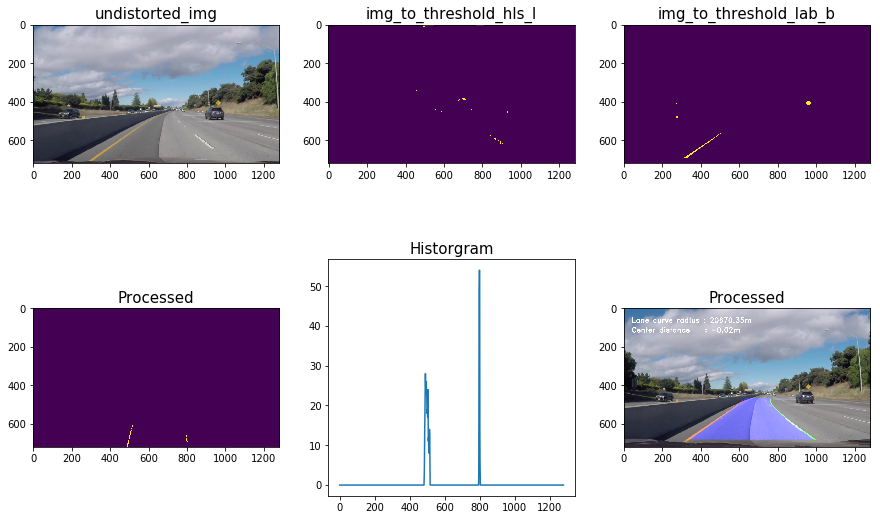

In [44]:
#load our test image

# #poor white line detection
img1 = plt.imread("camera_input/challenge_video/frame277.jpg") 

#high curve
# img1 = plt.imread("camera_input/challenge_video/frame100.jpg") 

# #dark bridge section
# img1 = plt.imread("camera_input/challenge_video/frame135.jpg") 

# #good test image
# img1 = plt.imread("test_images/test5.jpg") 

#HSV colorspace
hsv = cv2.cvtColor(img1, cv2.COLOR_RGB2HSV)
hsv_v_channel = hsv[:,:,2] #v – Value ( Intensity ).
print(hsv_v_channel.mean())


#test some pipeline parts
fig = plt.figure(figsize=(15, 20))

#undistort the image
undistorted_img = undistort(img1)

#get image augmented colorspace
aug_img = augmented_colorspace(undistorted_img)
#get bird eye view
top_aug_img = bird_eye_view(aug_img, getMinv=False)

plt.subplot(4,3,1)
plt.imshow(undistorted_img)
plt.title('undistorted_img',fontsize=15)

plt.subplot(4,3,2)
plt.imshow(img_to_threshold_hls_l(img1))
plt.title('img_to_threshold_hls_l',fontsize=15)

plt.subplot(4,3,3)
plt.imshow(img_to_threshold_lab_b(img1))
plt.title('img_to_threshold_lab_b',fontsize=15)


plt.subplot(4,3,4)
plt.imshow(top_aug_img)
plt.title('Processed',fontsize=15)

plt.subplot(4,3,5)
histogram = np.sum(augmented_img[augmented_img.shape[0]//2:,:], axis=0)
plt.plot(histogram)
plt.title('Historgram',fontsize=15)

out_img= Process_video_frame(img1)
plt.subplot(4,3,6)
plt.imshow(out_img)
plt.title('Processed',fontsize=15)
